# Optimize

run and compare optimization frameworks
- scipy.optimize (L-BFGS-B)
- Dlib
- Pptuna
- Hyperopt
- Platypus
- Nevergrad
- Ax


In [1]:
from datetime import datetime
from functools import partial
# import pandas_datareader as pdr
from concurrent import futures

import pytest
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

# optimizers
from scipy import optimize
import dlib     # http://dlib.net/
import optuna   # https://optuna.org/
import hyperopt # http://hyperopt.github.io/hyperopt/
from hyperopt import fmin, tpe, hp
import platypus    # https://github.com/Project-Platypus/Platypus
from platypus import MOEAD, Problem, Real
import nevergrad as ng  # https://facebookresearch.github.io/nevergrad/optimization.html
import ax  # https://ax.dev/

from SWRsimulation import SWRsimulationCE
from SWRsimulation.crra_ce import crra_ce

# cross sectional min max quartile range
# TODO:
# 1) smoother 
# init_withdrawal -> set previous to None, smoothing_factor per config
# withdrawal -> compute desired withdrawal based on previous
# min (desired, previous + (desired-previous)/smoothing_factor )

# 2) montecarlo - initialize array of trials at start and reuse it

# 3) take strategies for 0 and 1 and double check the CE values because it seems off. check strat 1 at CE 0 and strat 0 at CE1
# redo history several times without reinitializing with different parameters
# simulates take override simulation args
# init creates a list of samples, n_trials by n_ret_years
# for history , simulate creates a generator from samples and returns them

# 4) add chart of all spending paths

# chart of all optimizers, do with plotly, hover shows gamma, value, optimizer, elapsed time

# 4) do with deathrate

# multithreading, optimize for speed

print("%s %s" % ('numpy', np.__version__))
print("%s %s" % ('pandas', pd.__version__))
print("%s %s" % ('scipy', scipy.__version__))
print("%s %s" % ("dlib", dlib.__version__))
print("%s %s" % ('optuna', optuna.__version__))
print("%s %s" % ('hyperopt', hyperopt.__version__))
print("%s %s" % ("platypus", platypus.__version__))
print("%s %s" % ("nevergrad", ng.__version__))
print("%s %s" % ("ax", ax.__version__))


numpy 1.19.5
pandas 1.2.1
scipy 1.6.0
dlib 19.21.1
optuna 2.5.0
hyperopt 0.2.5
platypus 1.0.4
nevergrad 0.4.3
ax 0.1.19


In [2]:
N_TRIALS = 1000

In [3]:
def datestr():
    return datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")


### Load data

Data via Aswath Damodaran (thanks professor!)

http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html 

In [4]:
# load Damodaran data from pickle

RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 12]]
return_df.columns=['stocks', 'bonds', 'cpi']

return_df

stocks     bonds       cpi
Year                              
1928  0.438112  0.032196 -0.011522
1929 -0.082979  0.030179  0.000000
1930 -0.251236  0.005398 -0.026712
1931 -0.438375 -0.156808 -0.089321
1932 -0.086424  0.235896 -0.103014
...        ...       ...       ...
2016  0.117731  0.103651  0.012616
2017  0.216055  0.097239  0.021301
2018 -0.042269 -0.027626  0.024426
2019  0.312117  0.153295  0.022900
2020  0.180139  0.104115  0.012000

[93 rows x 3 columns]

In [5]:
# should adjust CPI to year-ending also but leave it for now
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df.to_pickle('real_return_df.pickle')

real_return_df

stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns]

### Function to optimize 

In [6]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
N_RET_YEARS = 30

def ce_experiment(n_ret_years, gamma, *params):
    # some optimizers pass an array, some pass a dict, some pass indiv unpacked params
    # global s   # for debugging keep last
    if len(params) == 1:   # unpack
        params = params[0]
        
    if type(params) == dict:
        fixed_spend = params['fixed_spend']
        variable_spend = params['variable_spend']
        alloc_stocks = params['alloc_stocks']
        n_ret_years = N_RET_YEARS
    elif type(params) == list or type(params) == tuple:
        fixed_spend, variable_spend, alloc_stocks = params     
        n_ret_years = N_RET_YEARS
    elif type(params) == np.ndarray:
        fixed_spend, variable_spend, alloc_stocks = params.tolist()
        n_ret_years = N_RET_YEARS
    else:
        raise Exception('bad argument to ce_experiment', type(params), params)
        
    if alloc_stocks > 1.0:
        return 0
    if alloc_stocks < 0.0:
        return 0
    
    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulationCE.SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
#                        'montecarlo': N_TRIALS,
#                        'montecarlo_replacement': False,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend,
                       'smoothing_factor': 1.0,
                      },
        'evaluation': {'gamma': gamma},
        'visualization': {}    
    })
    s.simulate()
    return -crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze first 2 args with partial
ce_experiment_1 = partial(ce_experiment, N_RET_YEARS, 1)

# unpacked args
print(ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS))

# list arg
print(ce_experiment_1([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS]))

# ndarray arg
print(ce_experiment_1(np.array([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS])))

# dict arg
print(ce_experiment_1({'fixed_spend': FIXED_SPEND, 
                       'variable_spend': VARIABLE_SPEND, 
                       'alloc_stocks': ALLOC_STOCKS}))



-9352.440807153926
-9352.440807153926
-9352.440807153926
-9352.440807153926


### scipy.optimize (L-BFGS-B)

In [7]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# quasi-Newton method

results_dict = {}
timings_dict = {}

# initial guess
x0 = np.array([0.5, 5.0, 1.0])
method = 'L-BFGS-B'
optimizer = "scipy.optimize (%s)" % method

MAX_ITER = N_TRIALS

study_params = []
study_values = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d iterations max" % (datestr(), optimizer, gamma, MAX_ITER))
    start_time = datetime.now()
    
    sobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    fixed_max = 5
    variable_max = 10
    alloc_max = 1

    result = optimize.minimize(sobjective, x0=x0, method=method,
                               options={'maxiter': MAX_ITER},
                               bounds=((0, fixed_max), (0, variable_max), (0, alloc_max))
                              )
    study_params.append(result.x)
    study_values.append(result.fun)

    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)

    print("%s Finishing optimizer %s, gamma %d, %d iterations in %s" % (datestr(), optimizer, gamma, result.nit, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), result.fun, result.x))
        

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

2021-02-12 15:35:11 Starting scipy.optimize (L-BFGS-B), gamma 0, 1000 iterations max
2021-02-12 15:35:14 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 0, 5 iterations in 0:00:03.718576
2021-02-12 15:35:14 best value -15532.416056, best params [0.         6.20410477 1.        ]
2021-02-12 15:35:14 Starting scipy.optimize (L-BFGS-B), gamma 1, 1000 iterations max
2021-02-12 15:35:21 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 1, 11 iterations in 0:00:06.835651
2021-02-12 15:35:21 best value -13517.859788, best params [0.29529652 6.23943231 1.        ]
2021-02-12 15:35:21 Starting scipy.optimize (L-BFGS-B), gamma 2, 1000 iterations max
2021-02-12 15:36:26 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 2, 14 iterations in 0:01:05.151094
2021-02-12 15:36:26 best value -12036.308515, best params [2.06403558 4.39369665 1.        ]
2021-02-12 15:36:26 Starting scipy.optimize (L-BFGS-B), gamma 4, 1000 iterations max
2021-02-12 15:38:59 Finishing optimizer scipy.optimize (L-

In [8]:
results = pd.DataFrame(study_params, columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['value'] = study_values
results['timing'] = study_timings
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      1.000000     0.000000     0.000000        6.204105   
1      1      1.000000     0.000000     0.295297        6.239432   
2      2      1.000000     0.000000     2.064036        4.393697   
3      4      0.890329     0.109671     2.615586        3.199853   
4      6      0.816224     0.183776     3.000151        2.265994   
5      8      0.785915     0.214085     3.188369        1.833849   
6     10      0.770464     0.229536     3.322693        1.534553   
7     12      0.902841     0.097159     2.662793        3.077798   
8     14      0.753637     0.246363     3.498058        1.154462   
9     16      0.754680     0.245320     3.556900        1.029995   

          value                 timing  
0 -15532.416056 0 days 00:00:03.718576  
1 -13517.859788 0 days 00:00:06.835651  
2 -12036.308515 0 days 00:01:05.151094  
3 -10318.960483 0 days 00:02:32.238141  
4  -9574.406303 0 days 00:00:42.044782  
5  -9163.997255 0 days 00:00:55.594386  
6  -8906.921628 0 days 00:01:06.633459  
7  -7980.752323 0 days 00:00:49.090811  
8  -8603.485064 0 days 00:01:23.308773  
9  -8506.558108 0 days 00:00:41.002561

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7ff8a9c30b30>}

Allocation:
{'asset_weights': array([0.75468013, 0.24531987])}

Withdrawal:
{'fixed': 3.5568999701583297,
 'fixed_pct': 3.5568999701583293,
 'variable': 0.01029994504412624,
 'variable_pct': 1.029994504412624}
mean annual spending over all cohorts 5.26
0.00% of portfolios exhausted by final year


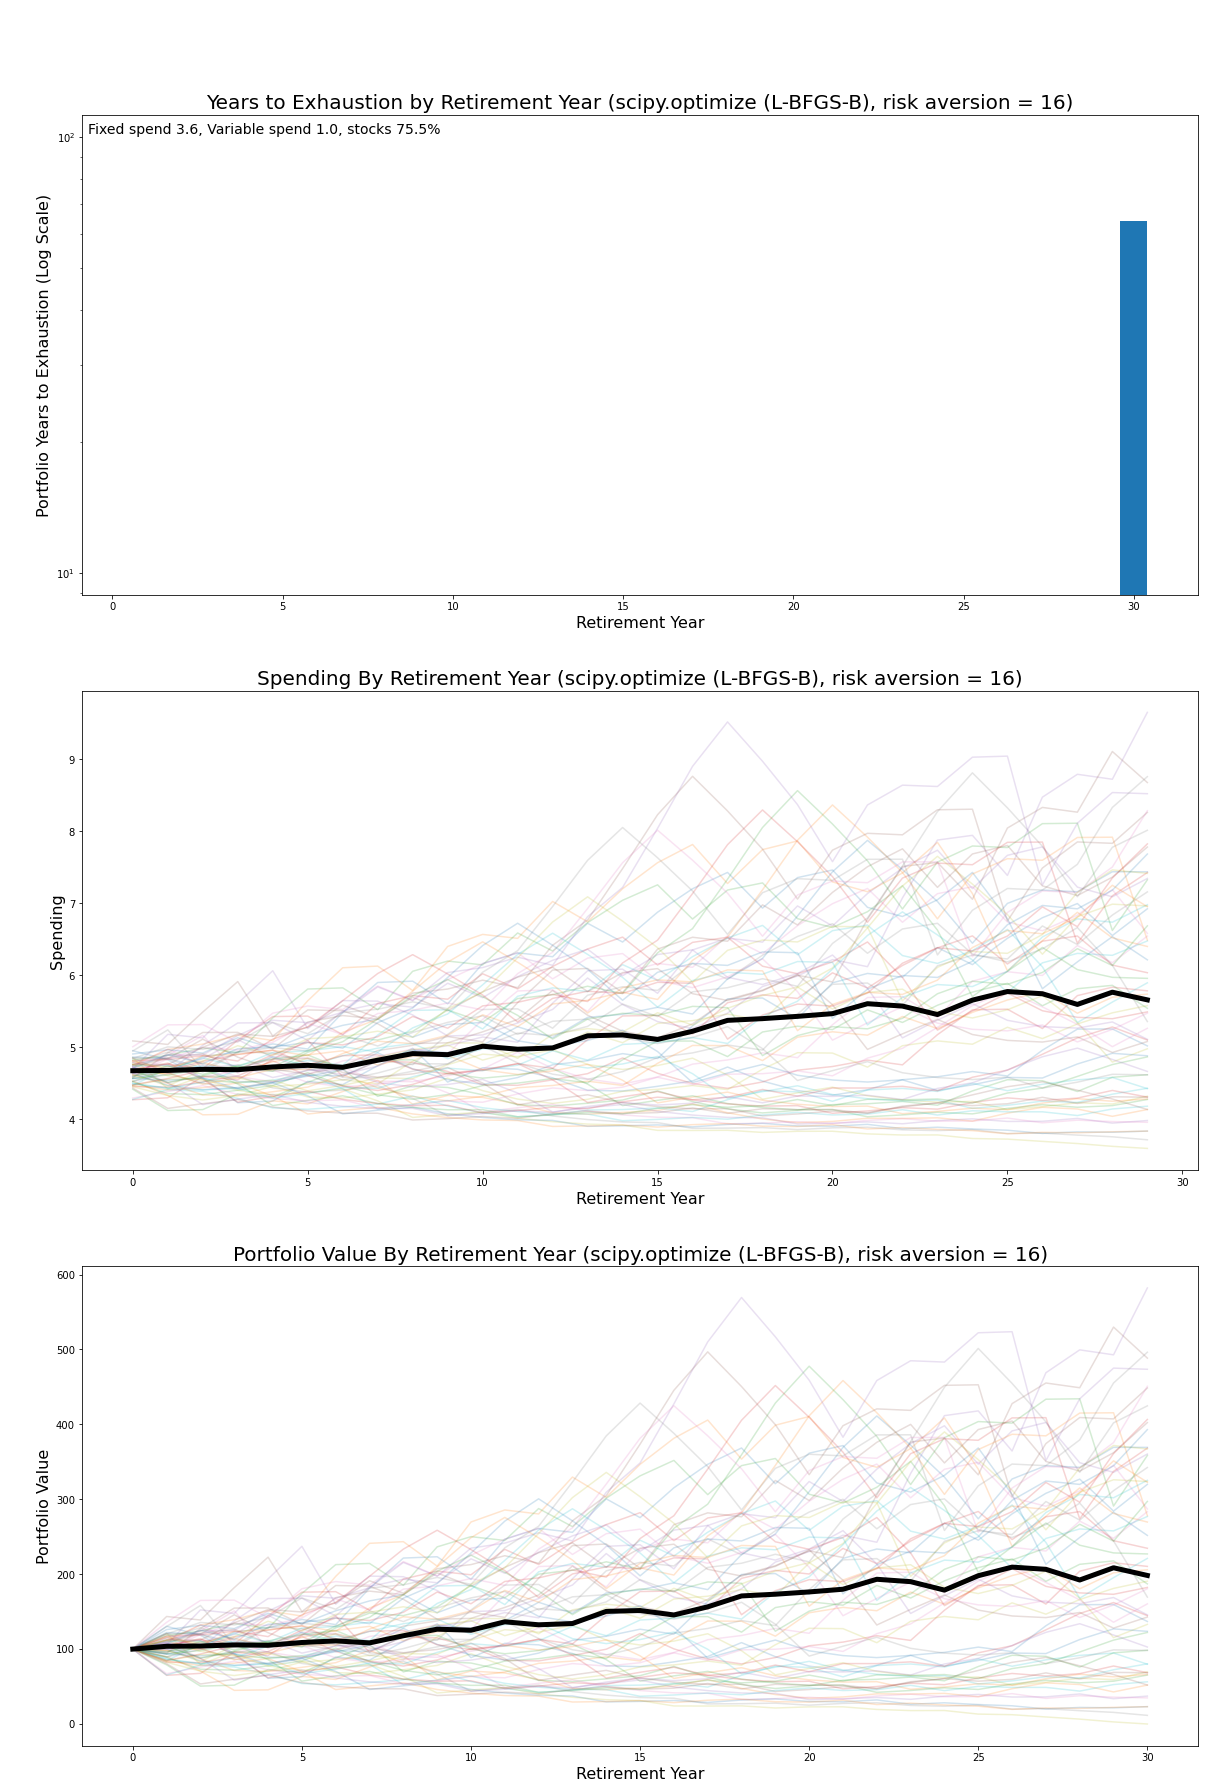

In [9]:
def run_strategy(resultsrow, verbose=True):

    FIXED_SPEND = resultsrow.fixed_spend
    VARIABLE_SPEND = resultsrow.variable_spend
    ALLOC_STOCKS = resultsrow.alloc_stocks
    ALLOC_BONDS = 1 - ALLOC_STOCKS
    GAMMA = resultsrow.gamma
    N_RET_YEARS = 30

    s = SWRsimulationCE.SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': N_RET_YEARS,
                      },
        'allocation': {'asset_weights': np.array([ALLOC_STOCKS, ALLOC_BONDS])}, # default is equal-weight 
        'withdrawal': {'fixed_pct': FIXED_SPEND,
                       'variable_pct': VARIABLE_SPEND},
        'evaluation': {'gamma': GAMMA},
        'visualization': {'histogram': True, 
                          'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                       'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (FIXED_SPEND, 
                                                                                                               VARIABLE_SPEND, 
                                                                                                               100 * ALLOC_STOCKS)
                                      },
                          'chart_2' : {'title': 'Spending By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                      },
                          'chart_3' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                      },
                         }    
    })
    
    if verbose:
        print(s)

    s.simulate()

    return s
    

run_strategy(results.iloc[-1]).visualize()


### Dlib

http://blog.dlib.net/2017/12/a-global-optimization-algorithm-worth.html


In [10]:
print("%s %s" % ("dlib", dlib.__version__))

n_trials = N_TRIALS
optimizer = "dlib"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

def objective_factory(N_RET_YEARS, gamma):
    # partial doesn't work for dlib i.e. objective = partial(ce_experiment, N_RET_YEARS, gamma)
    def objective(fixed_spend, variable_spend, alloc_stocks):
        return ce_experiment(N_RET_YEARS, gamma, fixed_spend, variable_spend, alloc_stocks)
    return objective
    
opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 

    objective = objective_factory(N_RET_YEARS, gamma)

    best = dlib.find_min_global(f=objective, 
                                bound1=[0., 0., 0.],   # lower bounds
                                bound2=[5., 10., 1.],  # variable_spend
                                num_function_calls=n_trials)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)

    study_params.append((best[1], 
                         best[0], 
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best value %s params %s" % (datestr(), best[1], best[0]))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

dlib 19.21.1
2021-02-12 15:44:37 Starting dlib, gamma 0, 1000 trials
2021-02-12 15:47:03 Finishing optimizer dlib, gamma 0, 1000 trials in 0:02:25.785379
2021-02-12 15:47:03 best value -15532.416056206732 params [0.0, 6.204087381548146, 1.0]
2021-02-12 15:47:03 Starting dlib, gamma 1, 1000 trials
2021-02-12 15:49:26 Finishing optimizer dlib, gamma 1, 1000 trials in 0:02:22.848684
2021-02-12 15:49:26 best value -13517.859787594858 params [0.29529193138131904, 6.239438620291712, 1.0]
2021-02-12 15:49:26 Starting dlib, gamma 2, 1000 trials
2021-02-12 15:51:51 Finishing optimizer dlib, gamma 2, 1000 trials in 0:02:25.218967
2021-02-12 15:51:51 best value -12028.65375869075 params [2.12458281920887, 4.193592549455626, 1.0]
2021-02-12 15:51:51 Starting dlib, gamma 4, 1000 trials
2021-02-12 15:54:23 Finishing optimizer dlib, gamma 4, 1000 trials in 0:02:31.861641
2021-02-12 15:54:23 best value -10315.396638679955 params [2.597496419261401, 3.2471789534082665, 0.8834139687575733]
2021-02-12 15

In [11]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      1.000000     0.000000     0.000000        6.204087   
1      1      1.000000     0.000000     0.295292        6.239439   
2      2      1.000000     0.000000     2.124583        4.193593   
3      4      0.883414     0.116586     2.597496        3.247179   
4      6      0.885044     0.114956     2.949184        2.327530   
5      8      0.737879     0.262121     2.886348        2.530720   
6     10      0.843963     0.156037     3.328163        1.521404   
7     12      0.631437     0.368563     3.255910        1.654755   
8     14      0.771177     0.228823     3.498851        1.153955   
9     16      0.782015     0.217985     3.146965        1.927315   

          value                 timing  
0 -15532.416056 0 days 00:02:25.785379  
1 -13517.859788 0 days 00:02:22.848684  
2 -12028.653759 0 days 00:02:25.218967  
3 -10315.396639 0 days 00:02:31.861641  
4  -9534.421992 0 days 00:02:42.442955  
5  -9057.062333 0 days 00:02:44.783337  
6  -8888.863970 0 days 00:02:42.817373  
7  -8659.229463 0 days 00:02:41.292656  
8  -8602.716036 0 days 00:02:39.471107  
9  -8278.872648 0 days 00:02:41.189067

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7ff8a9c30d60>}

Allocation:
{'asset_weights': array([0.78201474, 0.21798526])}

Withdrawal:
{'fixed': 3.146965316345454,
 'fixed_pct': 3.1469653163454545,
 'variable': 0.019273154394929225,
 'variable_pct': 1.9273154394929224}
mean annual spending over all cohorts 6.04
0.00% of portfolios exhausted by final year


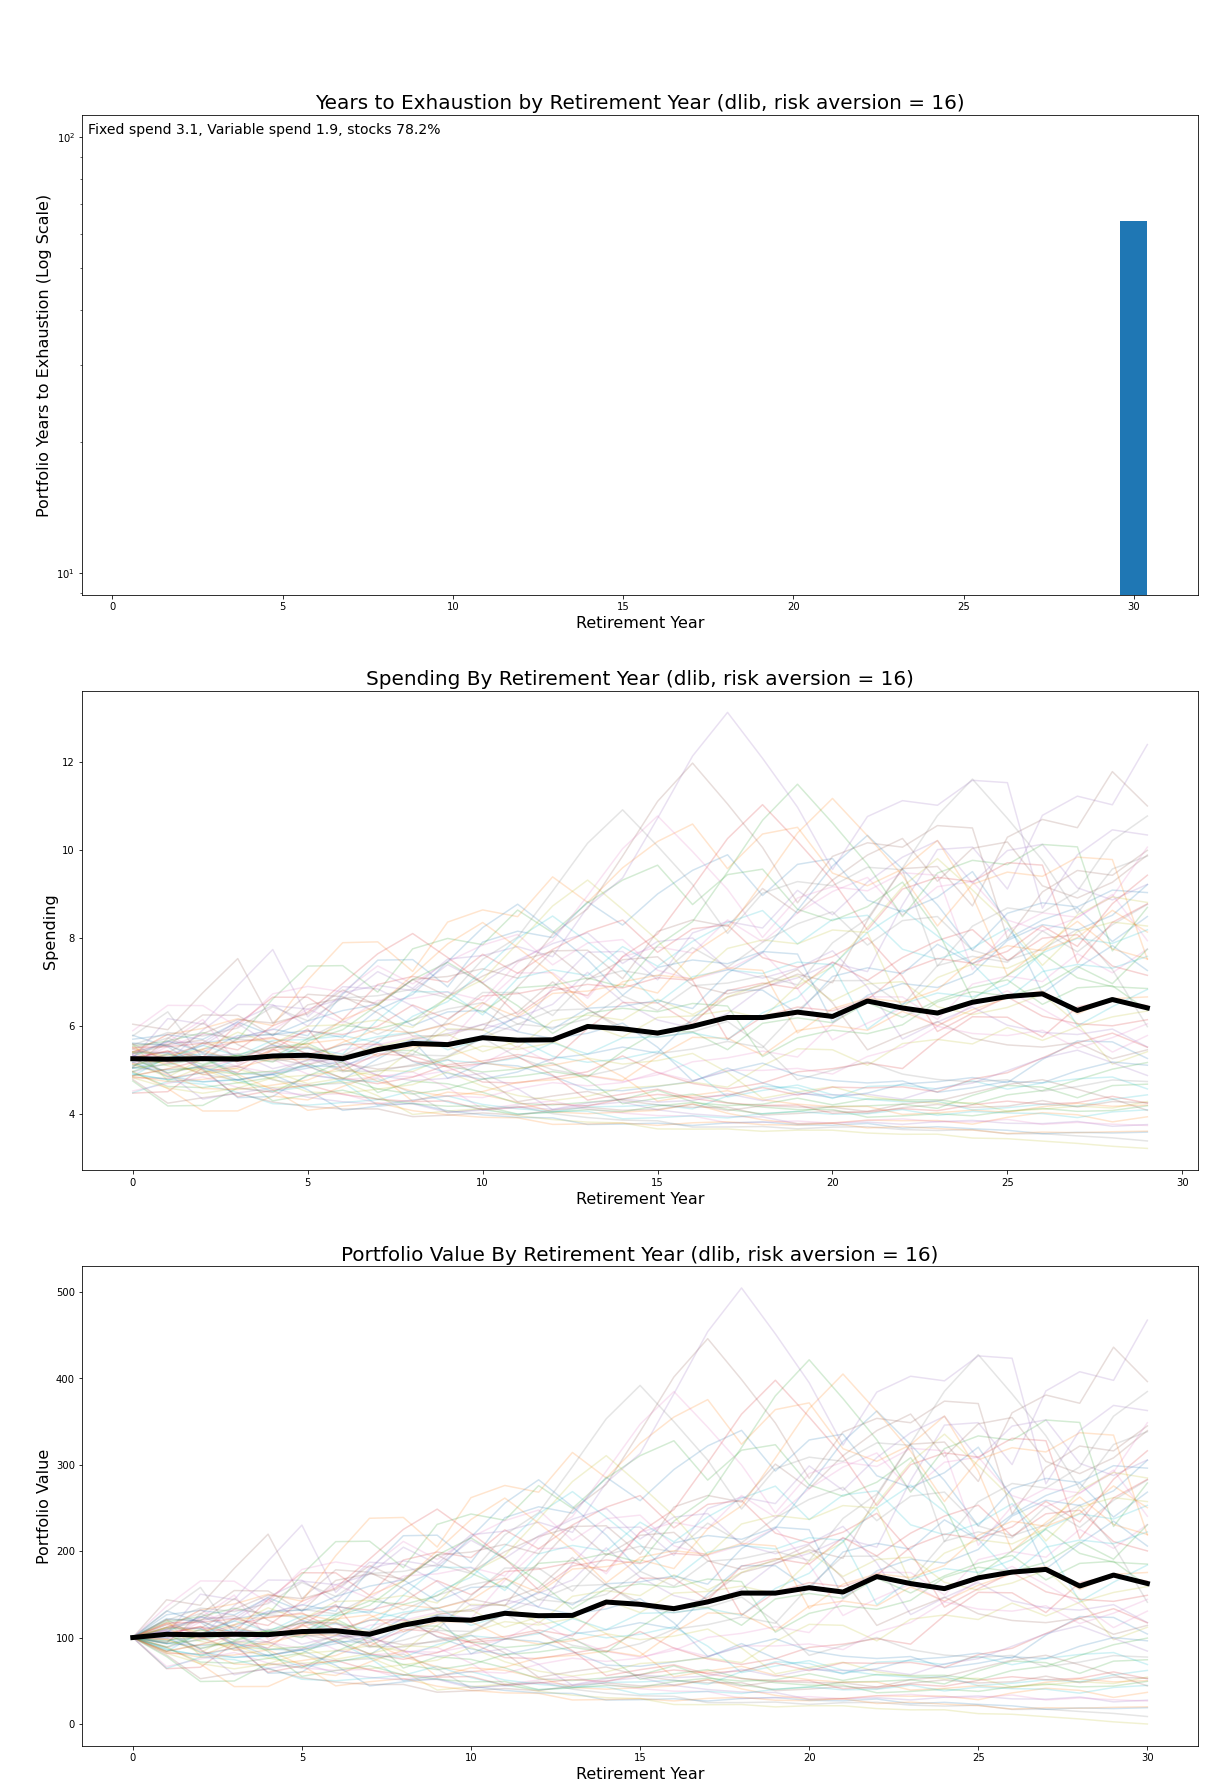

In [12]:
run_strategy(results.iloc[-1]).visualize()


### Optuna

https://optuna.org/


In [13]:
print("%s %s" % ('optuna', optuna.__version__))
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(gamma, trial):
    fixed_spend = trial.suggest_uniform('fixed_spend', 0, 5)
    variable_spend = trial.suggest_uniform('variable_spend', 0, 10)
    alloc_stocks = trial.suggest_uniform('alloc_stocks', 0, 1)
    oobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    return oobjective([fixed_spend, variable_spend, alloc_stocks])

study_params = []
study_values = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

n_trials = N_TRIALS
optimizer = "Optuna"

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    study = optuna.create_study()
    study.optimize(partial(objective, gamma), n_trials=n_trials)
    study_params.append(study.best_params)
    study_values.append(study.best_value)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)
    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), study.best_value, study.best_params))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))    

optuna 2.5.0
2021-02-12 16:10:36 Starting Optuna, gamma 0, 1000 trials
2021-02-12 16:12:58 Finishing optimizer Optuna, gamma 0, 1000 trials in 0:02:22.079418
2021-02-12 16:12:58 best value -15531.598820, best params {'fixed_spend': 0.00020056599706684997, 'variable_spend': 6.234790486972384, 'alloc_stocks': 0.9999386394869375}
2021-02-12 16:12:58 Starting Optuna, gamma 1, 1000 trials
2021-02-12 16:15:18 Finishing optimizer Optuna, gamma 1, 1000 trials in 0:02:20.024480
2021-02-12 16:15:18 best value -13517.588075, best params {'fixed_spend': 0.19232524649316518, 'variable_spend': 6.317720016071399, 'alloc_stocks': 0.9999774240841092}
2021-02-12 16:15:18 Starting Optuna, gamma 2, 1000 trials
2021-02-12 16:17:42 Finishing optimizer Optuna, gamma 2, 1000 trials in 0:02:23.975994
2021-02-12 16:17:42 best value -12034.687535, best params {'fixed_spend': 2.0281705734577353, 'variable_spend': 4.496328339018713, 'alloc_stocks': 0.9999207505573544}
2021-02-12 16:17:42 Starting Optuna, gamma 4, 

In [14]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['value'] = study_values
results['timing'] = study_timings
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      0.999939     0.000061     0.000201        6.234790   
1      1      0.999977     0.000023     0.192325        6.317720   
2      2      0.999921     0.000079     2.028171        4.496328   
3      4      0.890421     0.109579     2.670939        3.064658   
4      6      0.822026     0.177974     3.010181        2.238111   
5      8      0.796569     0.203431     3.129449        1.955399   
6     10      0.740371     0.259629     3.340024        1.493955   
7     12      0.760946     0.239054     3.469088        1.218758   
8     14      0.741706     0.258294     3.482191        1.189698   
9     16      0.791556     0.208444     3.572709        0.998734   

          value                 timing  
0 -15531.598820 0 days 00:02:22.079418  
1 -13517.588075 0 days 00:02:20.024480  
2 -12034.687535 0 days 00:02:23.975994  
3 -10324.656367 0 days 00:02:32.029654  
4  -9572.450455 0 days 00:02:45.988677  
5  -9154.582087 0 days 00:02:45.968516  
6  -8903.890586 0 days 00:02:46.391375  
7  -8727.727465 0 days 00:02:46.247559  
8  -8600.911320 0 days 00:02:46.252280  
9  -8502.420071 0 days 00:02:46.106559

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7ff8a19dc890>}

Allocation:
{'asset_weights': array([0.79155617, 0.20844383])}

Withdrawal:
{'fixed': 3.5727090067927647,
 'fixed_pct': 3.5727090067927647,
 'variable': 0.009987343203668526,
 'variable_pct': 0.9987343203668525}
mean annual spending over all cohorts 5.29
0.00% of portfolios exhausted by final year


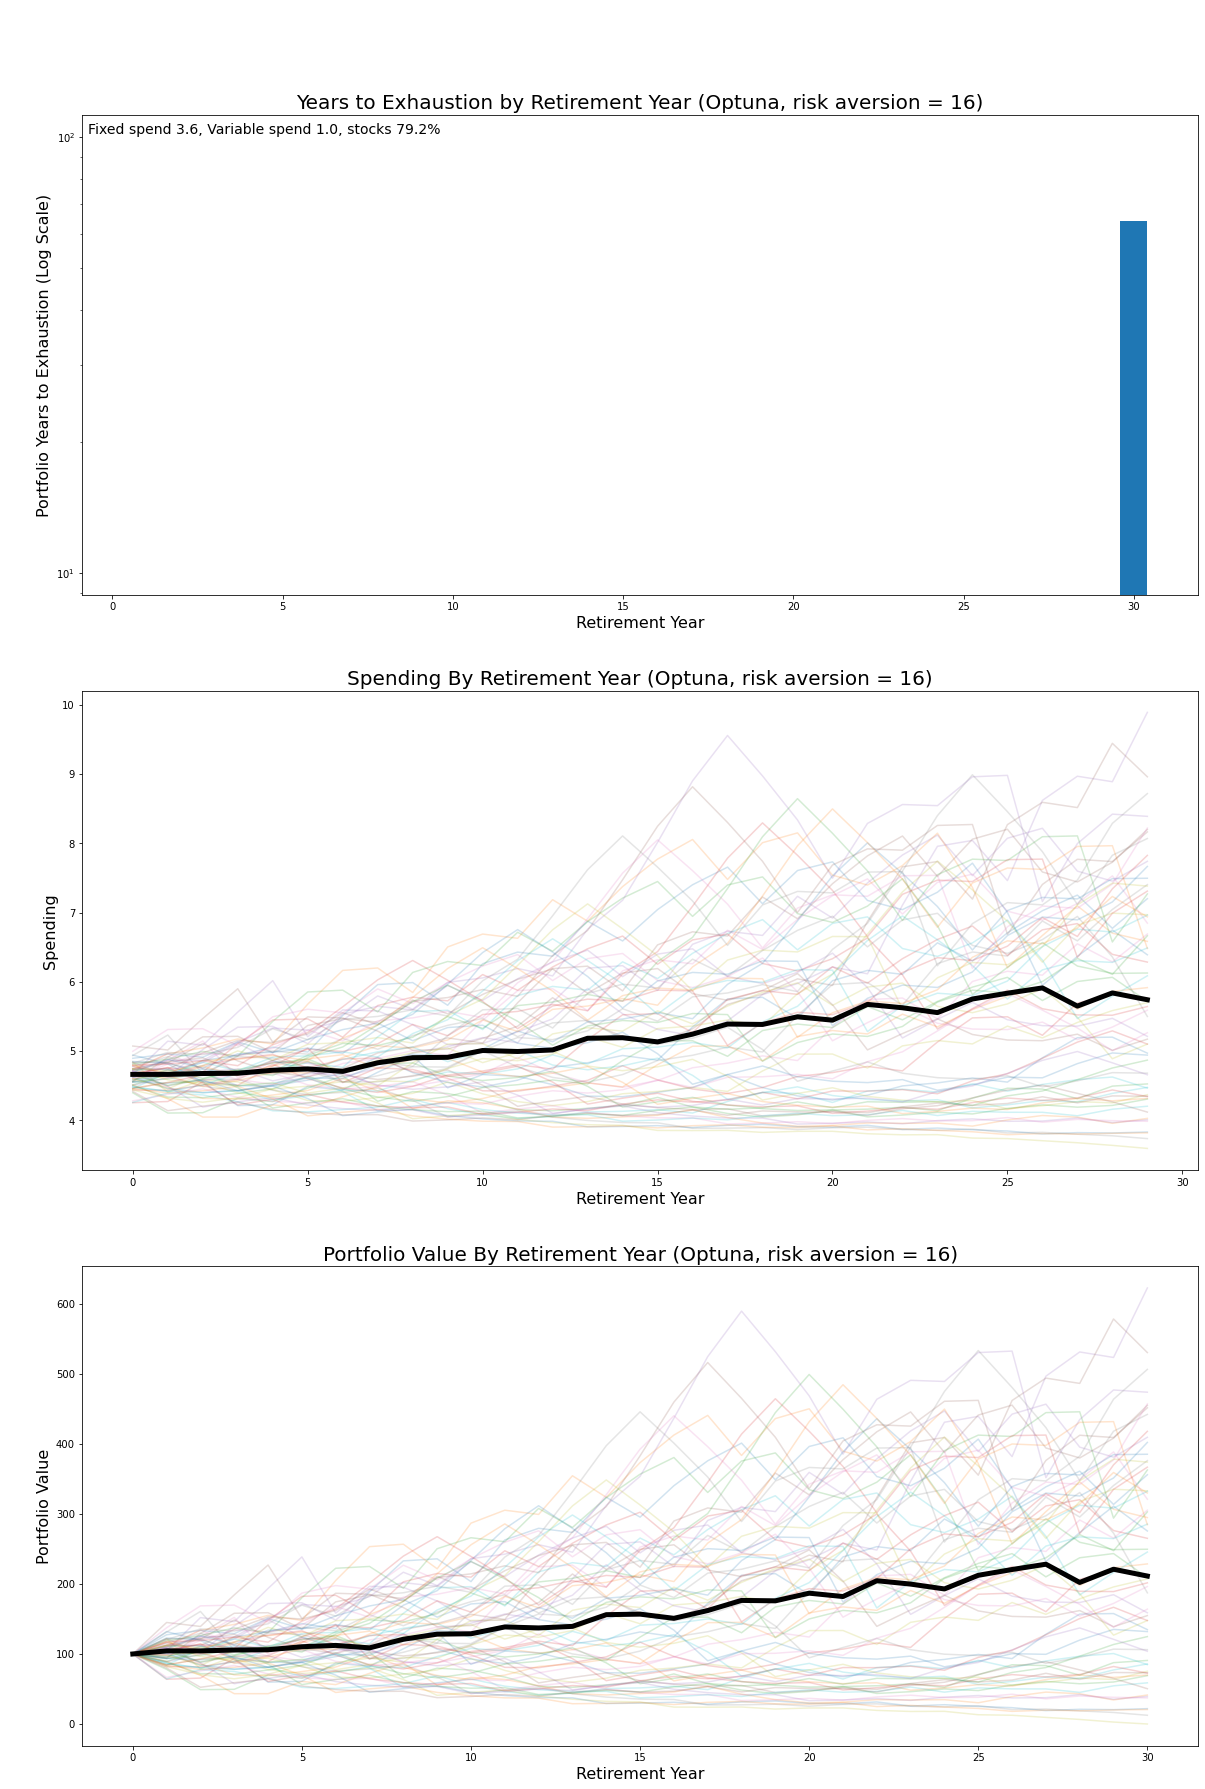

In [15]:
run_strategy(results.iloc[-1]).visualize()


### Hyperopt
http://hyperopt.github.io/hyperopt/

In [16]:
print("%s %s" % ('hyperopt', hyperopt.__version__))

n_trials = N_TRIALS
optimizer = "Hyperopt"

study_params = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    hobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    best = fmin(fn=hobjective,
                space={'fixed_spend': hp.uniform('fixed_spend', 0, 5),
                       'variable_spend': hp.uniform('variable_spend', 0, 10),
                       'alloc_stocks': hp.uniform('alloc_stocks', 0, 1),
                      },
                algo=tpe.suggest,
                max_evals=n_trials)
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), study_params[-1]))
        
opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

hyperopt 0.2.5
2021-02-12 16:36:52 Starting Hyperopt, gamma 0, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000820 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:19,  7.16trial/s, best loss: -9035.020250922422]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -9035.020251


  0%|          | 2/1000 [00:00<02:18,  7.21trial/s, best loss: -12287.343909058047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -12287.343909


  0%|          | 3/1000 [00:00<02:18,  7.21trial/s, best loss: -12287.343909058047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -12287.343909


  0%|          | 4/1000 [00:00<02:17,  7.25trial/s, best loss: -12287.343909058047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -12287.343909


  0%|          | 5/1000 [00:00<02:17,  7.26trial/s, best loss: -12287.343909058047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -12287.343909


  1%|          | 6/1000 [00:00<02:18,  7.19trial/s, best loss: -12287.343909058047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -12287.343909


  1%|          | 7/1000 [00:00<02:17,  7.20trial/s, best loss: -12287.343909058047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -12287.343909


  1%|          | 8/1000 [00:01<02:17,  7.21trial/s, best loss: -13639.890556996277]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -13639.890557


  1%|          | 9/1000 [00:01<02:17,  7.22trial/s, best loss: -13639.890556996277]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -13639.890557


  1%|          | 10/1000 [00:01<02:16,  7.23trial/s, best loss: -14327.86300358062]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -14327.863004


  1%|          | 11/1000 [00:01<02:16,  7.24trial/s, best loss: -14327.86300358062]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -14327.863004


  1%|          | 12/1000 [00:01<02:16,  7.25trial/s, best loss: -14327.86300358062]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -14327.863004


  1%|▏         | 13/1000 [00:01<02:15,  7.27trial/s, best loss: -14327.86300358062]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -14327.863004


  1%|▏         | 14/1000 [00:01<02:15,  7.25trial/s, best loss: -14327.86300358062]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -14327.863004


  2%|▏         | 15/1000 [00:02<02:15,  7.28trial/s, best loss: -14496.379836790162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -14496.379837


  2%|▏         | 16/1000 [00:02<02:15,  7.25trial/s, best loss: -14496.379836790162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -14496.379837


  2%|▏         | 17/1000 [00:02<02:16,  7.22trial/s, best loss: -14496.379836790162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -14496.379837


  2%|▏         | 18/1000 [00:02<02:15,  7.23trial/s, best loss: -14496.379836790162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -14496.379837


  2%|▏         | 19/1000 [00:02<02:15,  7.21trial/s, best loss: -14496.379836790162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -14496.379837


  2%|▏         | 20/1000 [00:02<02:15,  7.23trial/s, best loss: -14496.379836790162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -14496.379837


  2%|▏         | 21/1000 [00:02<02:16,  7.17trial/s, best loss: -15182.119681237282]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -15182.119681


  2%|▏         | 22/1000 [00:03<02:16,  7.15trial/s, best loss: -15182.119681237282]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -15182.119681


  2%|▏         | 23/1000 [00:03<02:17,  7.12trial/s, best loss: -15182.119681237282]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -15182.119681


  2%|▏         | 24/1000 [00:03<02:17,  7.11trial/s, best loss: -15271.23695575269] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -15271.236956


  2%|▎         | 25/1000 [00:03<02:17,  7.11trial/s, best loss: -15271.23695575269]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -15271.236956


  3%|▎         | 26/1000 [00:03<02:17,  7.10trial/s, best loss: -15459.1726514737] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -15459.172651


  3%|▎         | 27/1000 [00:03<02:18,  7.04trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -15459.172651


  3%|▎         | 28/1000 [00:03<02:17,  7.06trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -15459.172651


  3%|▎         | 29/1000 [00:04<02:17,  7.06trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -15459.172651


  3%|▎         | 30/1000 [00:04<02:17,  7.03trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -15459.172651


  3%|▎         | 31/1000 [00:04<02:18,  7.02trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -15459.172651


  3%|▎         | 32/1000 [00:04<02:17,  7.03trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -15459.172651


  3%|▎         | 33/1000 [00:04<02:17,  7.03trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -15459.172651


  3%|▎         | 34/1000 [00:04<02:18,  6.99trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -15459.172651


  4%|▎         | 35/1000 [00:04<02:17,  7.03trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -15459.172651


  4%|▎         | 36/1000 [00:05<02:18,  6.98trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -15459.172651


  4%|▎         | 37/1000 [00:05<02:18,  6.93trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -15459.172651


  4%|▍         | 38/1000 [00:05<02:18,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -15459.172651


  4%|▍         | 39/1000 [00:05<02:18,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -15459.172651


  4%|▍         | 40/1000 [00:05<02:18,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -15459.172651


  4%|▍         | 41/1000 [00:05<02:17,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -15459.172651


  4%|▍         | 42/1000 [00:05<02:16,  6.99trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -15459.172651


  4%|▍         | 43/1000 [00:06<02:17,  6.98trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -15459.172651


  4%|▍         | 44/1000 [00:06<02:16,  6.99trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -15459.172651


  4%|▍         | 45/1000 [00:06<02:16,  7.00trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -15459.172651


  5%|▍         | 46/1000 [00:06<02:16,  6.99trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -15459.172651


  5%|▍         | 47/1000 [00:06<02:16,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -15459.172651


  5%|▍         | 48/1000 [00:06<02:16,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -15459.172651


  5%|▍         | 49/1000 [00:06<02:15,  7.01trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -15459.172651


  5%|▌         | 50/1000 [00:07<02:14,  7.04trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -15459.172651


  5%|▌         | 51/1000 [00:07<02:15,  7.00trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -15459.172651


  5%|▌         | 52/1000 [00:07<02:15,  7.02trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -15459.172651


  5%|▌         | 53/1000 [00:07<02:14,  7.04trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -15459.172651


  5%|▌         | 54/1000 [00:07<02:14,  7.03trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -15459.172651


  6%|▌         | 55/1000 [00:07<02:14,  7.05trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -15459.172651


  6%|▌         | 56/1000 [00:07<02:14,  7.04trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -15459.172651


  6%|▌         | 57/1000 [00:08<02:13,  7.05trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -15459.172651


  6%|▌         | 58/1000 [00:08<02:14,  7.00trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -15459.172651


  6%|▌         | 59/1000 [00:08<02:14,  7.01trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -15459.172651


  6%|▌         | 60/1000 [00:08<02:13,  7.03trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -15459.172651


  6%|▌         | 61/1000 [00:08<02:13,  7.04trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -15459.172651


  6%|▌         | 62/1000 [00:08<02:13,  7.01trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -15459.172651


  6%|▋         | 63/1000 [00:08<02:13,  7.00trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -15459.172651


  6%|▋         | 64/1000 [00:09<02:13,  6.99trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -15459.172651


  6%|▋         | 65/1000 [00:09<02:13,  6.99trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -15459.172651


  7%|▋         | 66/1000 [00:09<02:13,  7.01trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -15459.172651


  7%|▋         | 67/1000 [00:09<02:12,  7.03trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -15459.172651


  7%|▋         | 68/1000 [00:09<02:12,  7.04trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -15459.172651


  7%|▋         | 69/1000 [00:09<02:12,  7.05trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -15459.172651


  7%|▋         | 70/1000 [00:09<02:12,  7.02trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -15459.172651


  7%|▋         | 71/1000 [00:10<02:12,  7.00trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -15459.172651


  7%|▋         | 72/1000 [00:10<02:12,  6.98trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -15459.172651


  7%|▋         | 73/1000 [00:10<02:13,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -15459.172651


  7%|▋         | 74/1000 [00:10<02:12,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -15459.172651


  8%|▊         | 75/1000 [00:10<02:40,  5.77trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -15459.172651


  8%|▊         | 76/1000 [00:10<02:31,  6.10trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -15459.172651


  8%|▊         | 77/1000 [00:11<02:26,  6.32trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -15459.172651


  8%|▊         | 78/1000 [00:11<02:21,  6.51trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -15459.172651


  8%|▊         | 79/1000 [00:11<02:19,  6.59trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -15459.172651


  8%|▊         | 80/1000 [00:11<02:18,  6.65trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -15459.172651


  8%|▊         | 81/1000 [00:11<02:16,  6.75trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -15459.172651


  8%|▊         | 82/1000 [00:11<02:14,  6.83trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -15459.172651


  8%|▊         | 83/1000 [00:11<02:15,  6.76trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -15459.172651


  8%|▊         | 84/1000 [00:12<02:15,  6.78trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -15459.172651


  8%|▊         | 85/1000 [00:12<02:14,  6.81trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -15459.172651


  9%|▊         | 86/1000 [00:12<02:13,  6.84trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -15459.172651


  9%|▊         | 87/1000 [00:12<02:13,  6.86trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -15459.172651


  9%|▉         | 88/1000 [00:12<02:12,  6.89trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -15459.172651


  9%|▉         | 89/1000 [00:12<02:12,  6.89trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -15459.172651


  9%|▉         | 90/1000 [00:12<02:11,  6.91trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -15459.172651


  9%|▉         | 91/1000 [00:13<02:11,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -15459.172651


  9%|▉         | 92/1000 [00:13<02:11,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -15459.172651


  9%|▉         | 93/1000 [00:13<02:11,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -15459.172651


  9%|▉         | 94/1000 [00:13<02:10,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -15459.172651


 10%|▉         | 95/1000 [00:13<02:10,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -15459.172651


 10%|▉         | 96/1000 [00:13<02:10,  6.93trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -15459.172651


 10%|▉         | 97/1000 [00:13<02:10,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -15459.172651


 10%|▉         | 98/1000 [00:14<02:10,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -15459.172651


 10%|▉         | 99/1000 [00:14<02:10,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -15459.172651


 10%|█         | 100/1000 [00:14<02:10,  6.90trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -15459.172651


 10%|█         | 101/1000 [00:14<02:10,  6.91trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -15459.172651


 10%|█         | 102/1000 [00:14<02:09,  6.91trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -15459.172651


 10%|█         | 103/1000 [00:14<02:09,  6.91trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -15459.172651


 10%|█         | 104/1000 [00:14<02:09,  6.93trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -15459.172651


 10%|█         | 105/1000 [00:15<02:10,  6.85trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -15459.172651


 11%|█         | 106/1000 [00:15<02:09,  6.88trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -15459.172651


 11%|█         | 107/1000 [00:15<02:09,  6.87trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -15459.172651


 11%|█         | 108/1000 [00:15<02:09,  6.89trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000704 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -15459.172651


 11%|█         | 109/1000 [00:15<02:09,  6.91trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -15459.172651


 11%|█         | 110/1000 [00:15<02:08,  6.91trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -15459.172651


 11%|█         | 111/1000 [00:15<02:08,  6.93trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -15459.172651


 11%|█         | 112/1000 [00:16<02:08,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -15459.172651


 11%|█▏        | 113/1000 [00:16<02:07,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -15459.172651


 11%|█▏        | 114/1000 [00:16<02:07,  6.93trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -15459.172651


 12%|█▏        | 115/1000 [00:16<02:08,  6.91trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -15459.172651


 12%|█▏        | 116/1000 [00:16<02:07,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -15459.172651


 12%|█▏        | 117/1000 [00:16<02:06,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -15459.172651


 12%|█▏        | 118/1000 [00:16<02:07,  6.93trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -15459.172651


 12%|█▏        | 119/1000 [00:17<02:07,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -15459.172651


 12%|█▏        | 120/1000 [00:17<02:07,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -15459.172651


 12%|█▏        | 121/1000 [00:17<02:06,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -15459.172651


 12%|█▏        | 122/1000 [00:17<02:06,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -15459.172651


 12%|█▏        | 123/1000 [00:17<02:05,  6.98trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -15459.172651


 12%|█▏        | 124/1000 [00:17<02:05,  6.99trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -15459.172651


 12%|█▎        | 125/1000 [00:17<02:05,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -15459.172651


 13%|█▎        | 126/1000 [00:18<02:05,  6.99trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001715 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -15459.172651


 13%|█▎        | 127/1000 [00:18<02:06,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -15459.172651


 13%|█▎        | 128/1000 [00:18<02:05,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -15459.172651


 13%|█▎        | 129/1000 [00:18<02:05,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -15459.172651


 13%|█▎        | 130/1000 [00:18<02:04,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -15459.172651


 13%|█▎        | 131/1000 [00:18<02:04,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -15459.172651


 13%|█▎        | 132/1000 [00:18<02:04,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -15459.172651


 13%|█▎        | 133/1000 [00:19<02:04,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -15459.172651


 13%|█▎        | 134/1000 [00:19<02:04,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -15459.172651


 14%|█▎        | 135/1000 [00:19<02:04,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -15459.172651


 14%|█▎        | 136/1000 [00:19<02:04,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -15459.172651


 14%|█▎        | 137/1000 [00:19<02:03,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -15459.172651


 14%|█▍        | 138/1000 [00:19<02:03,  6.98trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -15459.172651


 14%|█▍        | 139/1000 [00:19<02:03,  6.98trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -15459.172651


 14%|█▍        | 140/1000 [00:20<02:03,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -15459.172651


 14%|█▍        | 141/1000 [00:20<02:04,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -15459.172651


 14%|█▍        | 142/1000 [00:20<02:03,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -15459.172651


 14%|█▍        | 143/1000 [00:20<02:03,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -15459.172651


 14%|█▍        | 144/1000 [00:20<02:03,  6.93trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -15459.172651


 14%|█▍        | 145/1000 [00:20<02:03,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -15459.172651


 15%|█▍        | 146/1000 [00:20<02:02,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -15459.172651


 15%|█▍        | 147/1000 [00:21<02:02,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -15459.172651


 15%|█▍        | 148/1000 [00:21<02:02,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -15459.172651


 15%|█▍        | 149/1000 [00:21<02:02,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -15459.172651


 15%|█▌        | 150/1000 [00:21<02:02,  6.93trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -15459.172651


 15%|█▌        | 151/1000 [00:21<02:02,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -15459.172651


 15%|█▌        | 152/1000 [00:21<02:02,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -15459.172651


 15%|█▌        | 153/1000 [00:21<02:02,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -15459.172651


 15%|█▌        | 154/1000 [00:22<02:01,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -15459.172651


 16%|█▌        | 155/1000 [00:22<02:01,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -15459.172651


 16%|█▌        | 156/1000 [00:22<02:01,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -15459.172651


 16%|█▌        | 157/1000 [00:22<02:01,  6.93trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -15459.172651


 16%|█▌        | 158/1000 [00:22<02:01,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -15459.172651


 16%|█▌        | 159/1000 [00:22<02:00,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -15459.172651


 16%|█▌        | 160/1000 [00:22<02:00,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -15459.172651


 16%|█▌        | 161/1000 [00:23<02:25,  5.76trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -15459.172651


 16%|█▌        | 162/1000 [00:23<02:17,  6.11trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -15459.172651


 16%|█▋        | 163/1000 [00:23<02:11,  6.34trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -15459.172651


 16%|█▋        | 164/1000 [00:23<02:08,  6.50trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -15459.172651


 16%|█▋        | 165/1000 [00:23<02:05,  6.65trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -15459.172651


 17%|█▋        | 166/1000 [00:23<02:03,  6.74trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -15459.172651


 17%|█▋        | 167/1000 [00:24<02:02,  6.82trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -15459.172651


 17%|█▋        | 168/1000 [00:24<02:00,  6.88trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -15459.172651


 17%|█▋        | 169/1000 [00:24<02:00,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -15459.172651


 17%|█▋        | 170/1000 [00:24<01:59,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -15459.172651


 17%|█▋        | 171/1000 [00:24<01:59,  6.93trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -15459.172651


 17%|█▋        | 172/1000 [00:24<01:58,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -15459.172651


 17%|█▋        | 173/1000 [00:24<01:59,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -15459.172651


 17%|█▋        | 174/1000 [00:25<01:59,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -15459.172651


 18%|█▊        | 175/1000 [00:25<01:58,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -15459.172651


 18%|█▊        | 176/1000 [00:25<01:59,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -15459.172651


 18%|█▊        | 177/1000 [00:25<01:59,  6.91trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -15459.172651


 18%|█▊        | 178/1000 [00:25<01:58,  6.92trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -15459.172651


 18%|█▊        | 179/1000 [00:25<01:58,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -15459.172651


 18%|█▊        | 180/1000 [00:25<01:58,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -15459.172651


 18%|█▊        | 181/1000 [00:26<01:57,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -15459.172651


 18%|█▊        | 182/1000 [00:26<01:57,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -15459.172651


 18%|█▊        | 183/1000 [00:26<01:57,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -15459.172651


 18%|█▊        | 184/1000 [00:26<01:57,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -15459.172651


 18%|█▊        | 185/1000 [00:26<01:57,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -15459.172651


 19%|█▊        | 186/1000 [00:26<01:56,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -15459.172651


 19%|█▊        | 187/1000 [00:26<01:56,  6.97trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -15459.172651


 19%|█▉        | 188/1000 [00:27<01:56,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -15459.172651


 19%|█▉        | 189/1000 [00:27<01:56,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -15459.172651


 19%|█▉        | 190/1000 [00:27<01:56,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -15459.172651


 19%|█▉        | 191/1000 [00:27<01:56,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -15459.172651


 19%|█▉        | 192/1000 [00:27<01:56,  6.96trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -15459.172651


 19%|█▉        | 193/1000 [00:27<01:56,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -15459.172651


 19%|█▉        | 194/1000 [00:27<01:56,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -15459.172651


 20%|█▉        | 195/1000 [00:28<01:56,  6.89trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -15459.172651


 20%|█▉        | 196/1000 [00:28<01:56,  6.93trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -15459.172651


 20%|█▉        | 197/1000 [00:28<01:55,  6.94trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -15459.172651


 20%|█▉        | 198/1000 [00:28<01:55,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -15459.172651


 20%|█▉        | 199/1000 [00:28<01:55,  6.95trial/s, best loss: -15459.1726514737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -15459.172651


 20%|██        | 200/1000 [00:28<01:55,  6.93trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -15524.995350


 20%|██        | 201/1000 [00:28<01:55,  6.93trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -15524.995350


 20%|██        | 202/1000 [00:29<01:55,  6.92trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -15524.995350


 20%|██        | 203/1000 [00:29<01:54,  6.94trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -15524.995350


 20%|██        | 204/1000 [00:29<01:56,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -15524.995350


 20%|██        | 205/1000 [00:29<01:56,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -15524.995350


 21%|██        | 206/1000 [00:29<01:55,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -15524.995350


 21%|██        | 207/1000 [00:29<01:55,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -15524.995350


 21%|██        | 208/1000 [00:29<01:55,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -15524.995350


 21%|██        | 209/1000 [00:30<01:55,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -15524.995350


 21%|██        | 210/1000 [00:30<01:55,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -15524.995350


 21%|██        | 211/1000 [00:30<01:54,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -15524.995350


 21%|██        | 212/1000 [00:30<01:54,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -15524.995350


 21%|██▏       | 213/1000 [00:30<01:54,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -15524.995350


 21%|██▏       | 214/1000 [00:30<01:55,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -15524.995350


 22%|██▏       | 215/1000 [00:31<01:55,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -15524.995350


 22%|██▏       | 216/1000 [00:31<01:54,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -15524.995350


 22%|██▏       | 217/1000 [00:31<01:54,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -15524.995350


 22%|██▏       | 218/1000 [00:31<01:53,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -15524.995350


 22%|██▏       | 219/1000 [00:31<01:53,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -15524.995350


 22%|██▏       | 220/1000 [00:31<01:53,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -15524.995350


 22%|██▏       | 221/1000 [00:31<01:53,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -15524.995350


 22%|██▏       | 222/1000 [00:32<01:53,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -15524.995350


 22%|██▏       | 223/1000 [00:32<01:53,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -15524.995350


 22%|██▏       | 224/1000 [00:32<01:53,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -15524.995350


 22%|██▎       | 225/1000 [00:32<01:52,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -15524.995350


 23%|██▎       | 226/1000 [00:32<01:52,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -15524.995350


 23%|██▎       | 227/1000 [00:32<01:52,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -15524.995350


 23%|██▎       | 228/1000 [00:32<01:52,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -15524.995350


 23%|██▎       | 229/1000 [00:33<01:52,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -15524.995350


 23%|██▎       | 230/1000 [00:33<01:51,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -15524.995350


 23%|██▎       | 231/1000 [00:33<01:51,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -15524.995350


 23%|██▎       | 232/1000 [00:33<01:51,  6.90trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -15524.995350


 23%|██▎       | 233/1000 [00:33<01:51,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -15524.995350


 23%|██▎       | 234/1000 [00:33<01:51,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -15524.995350


 24%|██▎       | 235/1000 [00:33<01:51,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -15524.995350


 24%|██▎       | 236/1000 [00:34<01:51,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -15524.995350


 24%|██▎       | 237/1000 [00:34<01:51,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -15524.995350


 24%|██▍       | 238/1000 [00:34<02:12,  5.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -15524.995350


 24%|██▍       | 239/1000 [00:34<02:05,  6.06trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -15524.995350


 24%|██▍       | 240/1000 [00:34<02:00,  6.28trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -15524.995350


 24%|██▍       | 241/1000 [00:34<01:58,  6.42trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -15524.995350


 24%|██▍       | 242/1000 [00:35<01:55,  6.55trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -15524.995350


 24%|██▍       | 243/1000 [00:35<01:54,  6.63trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -15524.995350


 24%|██▍       | 244/1000 [00:35<01:52,  6.70trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -15524.995350


 24%|██▍       | 245/1000 [00:35<01:51,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -15524.995350


 25%|██▍       | 246/1000 [00:35<01:51,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -15524.995350


 25%|██▍       | 247/1000 [00:35<01:50,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -15524.995350


 25%|██▍       | 248/1000 [00:35<01:49,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -15524.995350


 25%|██▍       | 249/1000 [00:36<01:49,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -15524.995350


 25%|██▌       | 250/1000 [00:36<01:49,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -15524.995350


 25%|██▌       | 251/1000 [00:36<01:48,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -15524.995350


 25%|██▌       | 252/1000 [00:36<01:48,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -15524.995350


 25%|██▌       | 253/1000 [00:36<01:48,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -15524.995350


 25%|██▌       | 254/1000 [00:36<01:48,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -15524.995350


 26%|██▌       | 255/1000 [00:36<01:48,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -15524.995350


 26%|██▌       | 256/1000 [00:37<01:48,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -15524.995350


 26%|██▌       | 257/1000 [00:37<01:47,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -15524.995350


 26%|██▌       | 258/1000 [00:37<01:47,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -15524.995350


 26%|██▌       | 259/1000 [00:37<01:47,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -15524.995350


 26%|██▌       | 260/1000 [00:37<01:47,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -15524.995350


 26%|██▌       | 261/1000 [00:37<01:47,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -15524.995350


 26%|██▌       | 262/1000 [00:37<01:47,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -15524.995350


 26%|██▋       | 263/1000 [00:38<01:47,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -15524.995350


 26%|██▋       | 264/1000 [00:38<01:47,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -15524.995350


 26%|██▋       | 265/1000 [00:38<01:47,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -15524.995350


 27%|██▋       | 266/1000 [00:38<01:46,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -15524.995350


 27%|██▋       | 267/1000 [00:38<01:46,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -15524.995350


 27%|██▋       | 268/1000 [00:38<01:47,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -15524.995350


 27%|██▋       | 269/1000 [00:38<01:46,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -15524.995350


 27%|██▋       | 270/1000 [00:39<01:46,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -15524.995350


 27%|██▋       | 271/1000 [00:39<01:46,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -15524.995350


 27%|██▋       | 272/1000 [00:39<01:45,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -15524.995350


 27%|██▋       | 273/1000 [00:39<01:45,  6.90trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -15524.995350


 27%|██▋       | 274/1000 [00:39<01:45,  6.90trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -15524.995350


 28%|██▊       | 275/1000 [00:39<01:44,  6.92trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -15524.995350


 28%|██▊       | 276/1000 [00:39<01:45,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -15524.995350


 28%|██▊       | 277/1000 [00:40<01:45,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -15524.995350


 28%|██▊       | 278/1000 [00:40<01:45,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -15524.995350


 28%|██▊       | 279/1000 [00:40<01:45,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -15524.995350


 28%|██▊       | 280/1000 [00:40<01:45,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -15524.995350


 28%|██▊       | 281/1000 [00:40<01:45,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -15524.995350


 28%|██▊       | 282/1000 [00:40<01:45,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -15524.995350


 28%|██▊       | 283/1000 [00:41<01:45,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -15524.995350


 28%|██▊       | 284/1000 [00:41<01:44,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -15524.995350


 28%|██▊       | 285/1000 [00:41<01:44,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -15524.995350


 29%|██▊       | 286/1000 [00:41<01:45,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -15524.995350


 29%|██▊       | 287/1000 [00:41<01:44,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -15524.995350


 29%|██▉       | 288/1000 [00:41<01:44,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -15524.995350


 29%|██▉       | 289/1000 [00:41<01:43,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -15524.995350


 29%|██▉       | 290/1000 [00:42<01:43,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -15524.995350


 29%|██▉       | 291/1000 [00:42<01:42,  6.90trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -15524.995350


 29%|██▉       | 292/1000 [00:42<01:42,  6.91trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -15524.995350


 29%|██▉       | 293/1000 [00:42<01:42,  6.92trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -15524.995350


 29%|██▉       | 294/1000 [00:42<01:41,  6.92trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -15524.995350


 30%|██▉       | 295/1000 [00:42<01:41,  6.94trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -15524.995350


 30%|██▉       | 296/1000 [00:42<01:41,  6.94trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -15524.995350


 30%|██▉       | 297/1000 [00:43<01:41,  6.93trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -15524.995350


 30%|██▉       | 298/1000 [00:43<01:41,  6.92trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -15524.995350


 30%|██▉       | 299/1000 [00:43<01:41,  6.93trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -15524.995350


 30%|███       | 300/1000 [00:43<01:41,  6.90trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -15524.995350


 30%|███       | 301/1000 [00:43<01:41,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -15524.995350


 30%|███       | 302/1000 [00:43<01:41,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -15524.995350


 30%|███       | 303/1000 [00:43<01:41,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -15524.995350


 30%|███       | 304/1000 [00:44<01:41,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -15524.995350


 30%|███       | 305/1000 [00:44<01:41,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -15524.995350


 31%|███       | 306/1000 [00:44<01:41,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -15524.995350


 31%|███       | 307/1000 [00:44<01:41,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -15524.995350


 31%|███       | 308/1000 [00:44<01:40,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -15524.995350


 31%|███       | 309/1000 [00:44<01:40,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -15524.995350


 31%|███       | 310/1000 [00:44<01:40,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000677 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -15524.995350


 31%|███       | 311/1000 [00:45<01:40,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -15524.995350


 31%|███       | 312/1000 [00:45<01:40,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -15524.995350


 31%|███▏      | 313/1000 [00:45<01:40,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -15524.995350


 31%|███▏      | 314/1000 [00:45<01:40,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -15524.995350


 32%|███▏      | 315/1000 [00:45<01:40,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -15524.995350


 32%|███▏      | 316/1000 [00:45<01:40,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -15524.995350


 32%|███▏      | 317/1000 [00:46<01:58,  5.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -15524.995350


 32%|███▏      | 318/1000 [00:46<01:52,  6.04trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -15524.995350


 32%|███▏      | 319/1000 [00:46<01:48,  6.25trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -15524.995350


 32%|███▏      | 320/1000 [00:46<01:46,  6.40trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -15524.995350


 32%|███▏      | 321/1000 [00:46<01:43,  6.53trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -15524.995350


 32%|███▏      | 322/1000 [00:46<01:42,  6.62trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -15524.995350


 32%|███▏      | 323/1000 [00:46<01:41,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -15524.995350


 32%|███▏      | 324/1000 [00:47<01:41,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -15524.995350


 32%|███▎      | 325/1000 [00:47<01:40,  6.74trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -15524.995350


 33%|███▎      | 326/1000 [00:47<01:39,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -15524.995350


 33%|███▎      | 327/1000 [00:47<01:38,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -15524.995350


 33%|███▎      | 328/1000 [00:47<01:38,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -15524.995350


 33%|███▎      | 329/1000 [00:47<01:38,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -15524.995350


 33%|███▎      | 330/1000 [00:47<01:37,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -15524.995350


 33%|███▎      | 331/1000 [00:48<01:37,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -15524.995350


 33%|███▎      | 332/1000 [00:48<01:37,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -15524.995350


 33%|███▎      | 333/1000 [00:48<01:37,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -15524.995350


 33%|███▎      | 334/1000 [00:48<01:37,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -15524.995350


 34%|███▎      | 335/1000 [00:48<01:37,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -15524.995350


 34%|███▎      | 336/1000 [00:48<01:37,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -15524.995350


 34%|███▎      | 337/1000 [00:48<01:36,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -15524.995350


 34%|███▍      | 338/1000 [00:49<01:36,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -15524.995350


 34%|███▍      | 339/1000 [00:49<01:36,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -15524.995350


 34%|███▍      | 340/1000 [00:49<01:36,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -15524.995350


 34%|███▍      | 341/1000 [00:49<01:36,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -15524.995350


 34%|███▍      | 342/1000 [00:49<01:36,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -15524.995350


 34%|███▍      | 343/1000 [00:49<01:35,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -15524.995350


 34%|███▍      | 344/1000 [00:50<01:35,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -15524.995350


 34%|███▍      | 345/1000 [00:50<01:35,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -15524.995350


 35%|███▍      | 346/1000 [00:50<01:35,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -15524.995350


 35%|███▍      | 347/1000 [00:50<01:35,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -15524.995350


 35%|███▍      | 348/1000 [00:50<01:35,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -15524.995350


 35%|███▍      | 349/1000 [00:50<01:34,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -15524.995350


 35%|███▌      | 350/1000 [00:50<01:34,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -15524.995350


 35%|███▌      | 351/1000 [00:51<01:34,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -15524.995350


 35%|███▌      | 352/1000 [00:51<01:35,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -15524.995350


 35%|███▌      | 353/1000 [00:51<01:35,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -15524.995350


 35%|███▌      | 354/1000 [00:51<01:35,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -15524.995350


 36%|███▌      | 355/1000 [00:51<01:34,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -15524.995350


 36%|███▌      | 356/1000 [00:51<01:34,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -15524.995350


 36%|███▌      | 357/1000 [00:51<01:34,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -15524.995350


 36%|███▌      | 358/1000 [00:52<01:34,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -15524.995350


 36%|███▌      | 359/1000 [00:52<01:34,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -15524.995350


 36%|███▌      | 360/1000 [00:52<01:34,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -15524.995350


 36%|███▌      | 361/1000 [00:52<01:34,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -15524.995350


 36%|███▌      | 362/1000 [00:52<01:34,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -15524.995350


 36%|███▋      | 363/1000 [00:52<01:34,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -15524.995350


 36%|███▋      | 364/1000 [00:52<01:33,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -15524.995350


 36%|███▋      | 365/1000 [00:53<01:33,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -15524.995350


 37%|███▋      | 366/1000 [00:53<01:33,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -15524.995350


 37%|███▋      | 367/1000 [00:53<01:32,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -15524.995350


 37%|███▋      | 368/1000 [00:53<01:32,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001683 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -15524.995350


 37%|███▋      | 369/1000 [00:53<01:34,  6.71trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -15524.995350


 37%|███▋      | 370/1000 [00:53<01:33,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -15524.995350


 37%|███▋      | 371/1000 [00:53<01:32,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -15524.995350


 37%|███▋      | 372/1000 [00:54<01:32,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -15524.995350


 37%|███▋      | 373/1000 [00:54<01:31,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -15524.995350


 37%|███▋      | 374/1000 [00:54<01:31,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -15524.995350


 38%|███▊      | 375/1000 [00:54<01:31,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -15524.995350


 38%|███▊      | 376/1000 [00:54<01:30,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -15524.995350


 38%|███▊      | 377/1000 [00:54<01:30,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -15524.995350


 38%|███▊      | 378/1000 [00:54<01:30,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -15524.995350


 38%|███▊      | 379/1000 [00:55<01:30,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -15524.995350


 38%|███▊      | 380/1000 [00:55<01:30,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -15524.995350


 38%|███▊      | 381/1000 [00:55<01:30,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -15524.995350


 38%|███▊      | 382/1000 [00:55<01:30,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -15524.995350


 38%|███▊      | 383/1000 [00:55<01:29,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -15524.995350


 38%|███▊      | 384/1000 [00:55<01:29,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -15524.995350


 38%|███▊      | 385/1000 [00:56<01:29,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -15524.995350


 39%|███▊      | 386/1000 [00:56<01:29,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -15524.995350


 39%|███▊      | 387/1000 [00:56<01:29,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -15524.995350


 39%|███▉      | 388/1000 [00:56<01:28,  6.90trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -15524.995350


 39%|███▉      | 389/1000 [00:56<01:28,  6.91trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -15524.995350


 39%|███▉      | 390/1000 [00:56<01:28,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -15524.995350


 39%|███▉      | 391/1000 [00:56<01:28,  6.90trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -15524.995350


 39%|███▉      | 392/1000 [00:57<01:27,  6.92trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -15524.995350


 39%|███▉      | 393/1000 [00:57<01:28,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -15524.995350


 39%|███▉      | 394/1000 [00:57<01:28,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -15524.995350


 40%|███▉      | 395/1000 [00:57<01:44,  5.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -15524.995350


 40%|███▉      | 396/1000 [00:57<01:39,  6.08trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -15524.995350


 40%|███▉      | 397/1000 [00:57<01:36,  6.28trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -15524.995350


 40%|███▉      | 398/1000 [00:57<01:33,  6.44trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -15524.995350


 40%|███▉      | 399/1000 [00:58<01:31,  6.55trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -15524.995350


 40%|████      | 400/1000 [00:58<01:30,  6.64trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -15524.995350


 40%|████      | 401/1000 [00:58<01:29,  6.71trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -15524.995350


 40%|████      | 402/1000 [00:58<01:28,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -15524.995350


 40%|████      | 403/1000 [00:58<01:28,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -15524.995350


 40%|████      | 404/1000 [00:58<01:27,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -15524.995350


 40%|████      | 405/1000 [00:59<01:27,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -15524.995350


 41%|████      | 406/1000 [00:59<01:27,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -15524.995350


 41%|████      | 407/1000 [00:59<01:26,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -15524.995350


 41%|████      | 408/1000 [00:59<01:26,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -15524.995350


 41%|████      | 409/1000 [00:59<01:26,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -15524.995350


 41%|████      | 410/1000 [00:59<01:25,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -15524.995350


 41%|████      | 411/1000 [00:59<01:25,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -15524.995350


 41%|████      | 412/1000 [01:00<01:25,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -15524.995350


 41%|████▏     | 413/1000 [01:00<01:25,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -15524.995350


 41%|████▏     | 414/1000 [01:00<01:25,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -15524.995350


 42%|████▏     | 415/1000 [01:00<01:25,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -15524.995350


 42%|████▏     | 416/1000 [01:00<01:25,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -15524.995350


 42%|████▏     | 417/1000 [01:00<01:25,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -15524.995350


 42%|████▏     | 418/1000 [01:00<01:24,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -15524.995350


 42%|████▏     | 419/1000 [01:01<01:24,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -15524.995350


 42%|████▏     | 420/1000 [01:01<01:24,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -15524.995350


 42%|████▏     | 421/1000 [01:01<01:24,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -15524.995350


 42%|████▏     | 422/1000 [01:01<01:24,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -15524.995350


 42%|████▏     | 423/1000 [01:01<01:24,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -15524.995350


 42%|████▏     | 424/1000 [01:01<01:24,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -15524.995350


 42%|████▎     | 425/1000 [01:01<01:24,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -15524.995350


 43%|████▎     | 426/1000 [01:02<01:23,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -15524.995350


 43%|████▎     | 427/1000 [01:02<01:23,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -15524.995350


 43%|████▎     | 428/1000 [01:02<01:23,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -15524.995350


 43%|████▎     | 429/1000 [01:02<01:23,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -15524.995350


 43%|████▎     | 430/1000 [01:02<01:23,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -15524.995350


 43%|████▎     | 431/1000 [01:02<01:23,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -15524.995350


 43%|████▎     | 432/1000 [01:02<01:22,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -15524.995350


 43%|████▎     | 433/1000 [01:03<01:23,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -15524.995350


 43%|████▎     | 434/1000 [01:03<01:22,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -15524.995350


 44%|████▎     | 435/1000 [01:03<01:22,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -15524.995350


 44%|████▎     | 436/1000 [01:03<01:22,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -15524.995350


 44%|████▎     | 437/1000 [01:03<01:22,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -15524.995350


 44%|████▍     | 438/1000 [01:03<01:22,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -15524.995350


 44%|████▍     | 439/1000 [01:03<01:22,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -15524.995350


 44%|████▍     | 440/1000 [01:04<01:21,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -15524.995350


 44%|████▍     | 441/1000 [01:04<01:21,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -15524.995350


 44%|████▍     | 442/1000 [01:04<01:21,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -15524.995350


 44%|████▍     | 443/1000 [01:04<01:20,  6.89trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -15524.995350


 44%|████▍     | 444/1000 [01:04<01:21,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -15524.995350


 44%|████▍     | 445/1000 [01:04<01:21,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -15524.995350


 45%|████▍     | 446/1000 [01:05<01:20,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -15524.995350


 45%|████▍     | 447/1000 [01:05<01:20,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -15524.995350


 45%|████▍     | 448/1000 [01:05<01:20,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -15524.995350


 45%|████▍     | 449/1000 [01:05<01:20,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -15524.995350


 45%|████▌     | 450/1000 [01:05<01:20,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -15524.995350


 45%|████▌     | 451/1000 [01:05<01:20,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -15524.995350


 45%|████▌     | 452/1000 [01:05<01:20,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -15524.995350


 45%|████▌     | 453/1000 [01:06<01:20,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000685 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -15524.995350


 45%|████▌     | 454/1000 [01:06<01:19,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -15524.995350


 46%|████▌     | 455/1000 [01:06<01:19,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -15524.995350


 46%|████▌     | 456/1000 [01:06<01:19,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -15524.995350


 46%|████▌     | 457/1000 [01:06<01:19,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -15524.995350


 46%|████▌     | 458/1000 [01:06<01:18,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -15524.995350


 46%|████▌     | 459/1000 [01:06<01:18,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -15524.995350


 46%|████▌     | 460/1000 [01:07<01:18,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -15524.995350


 46%|████▌     | 461/1000 [01:07<01:18,  6.87trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -15524.995350


 46%|████▌     | 462/1000 [01:07<01:18,  6.88trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -15524.995350


 46%|████▋     | 463/1000 [01:07<01:18,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -15524.995350


 46%|████▋     | 464/1000 [01:07<01:18,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -15524.995350


 46%|████▋     | 465/1000 [01:07<01:18,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -15524.995350


 47%|████▋     | 466/1000 [01:07<01:18,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000707 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -15524.995350


 47%|████▋     | 467/1000 [01:08<01:17,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -15524.995350


 47%|████▋     | 468/1000 [01:08<01:18,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -15524.995350


 47%|████▋     | 469/1000 [01:08<01:17,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -15524.995350


 47%|████▋     | 470/1000 [01:08<01:17,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -15524.995350


 47%|████▋     | 471/1000 [01:08<01:17,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -15524.995350


 47%|████▋     | 472/1000 [01:08<01:31,  5.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -15524.995350


 47%|████▋     | 473/1000 [01:09<01:26,  6.06trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -15524.995350


 47%|████▋     | 474/1000 [01:09<01:24,  6.25trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -15524.995350


 48%|████▊     | 475/1000 [01:09<01:21,  6.41trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -15524.995350


 48%|████▊     | 476/1000 [01:09<01:20,  6.53trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -15524.995350


 48%|████▊     | 477/1000 [01:09<01:18,  6.63trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -15524.995350


 48%|████▊     | 478/1000 [01:09<01:17,  6.70trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -15524.995350


 48%|████▊     | 479/1000 [01:09<01:17,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -15524.995350


 48%|████▊     | 480/1000 [01:10<01:16,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -15524.995350


 48%|████▊     | 481/1000 [01:10<01:16,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -15524.995350


 48%|████▊     | 482/1000 [01:10<01:16,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -15524.995350


 48%|████▊     | 483/1000 [01:10<01:15,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -15524.995350


 48%|████▊     | 484/1000 [01:10<01:15,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -15524.995350


 48%|████▊     | 485/1000 [01:10<01:15,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -15524.995350


 49%|████▊     | 486/1000 [01:10<01:15,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -15524.995350


 49%|████▊     | 487/1000 [01:11<01:15,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -15524.995350


 49%|████▉     | 488/1000 [01:11<01:14,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -15524.995350


 49%|████▉     | 489/1000 [01:11<01:14,  6.86trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -15524.995350


 49%|████▉     | 490/1000 [01:11<01:14,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -15524.995350


 49%|████▉     | 491/1000 [01:11<01:14,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -15524.995350


 49%|████▉     | 492/1000 [01:11<01:14,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -15524.995350


 49%|████▉     | 493/1000 [01:11<01:14,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -15524.995350


 49%|████▉     | 494/1000 [01:12<01:14,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -15524.995350


 50%|████▉     | 495/1000 [01:12<01:14,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -15524.995350


 50%|████▉     | 496/1000 [01:12<01:13,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -15524.995350


 50%|████▉     | 497/1000 [01:12<01:13,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -15524.995350


 50%|████▉     | 498/1000 [01:12<01:13,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -15524.995350


 50%|████▉     | 499/1000 [01:12<01:13,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -15524.995350


 50%|█████     | 500/1000 [01:12<01:13,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -15524.995350


 50%|█████     | 501/1000 [01:13<01:13,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -15524.995350


 50%|█████     | 502/1000 [01:13<01:13,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -15524.995350


 50%|█████     | 503/1000 [01:13<01:13,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -15524.995350


 50%|█████     | 504/1000 [01:13<01:12,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -15524.995350


 50%|█████     | 505/1000 [01:13<01:12,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -15524.995350


 51%|█████     | 506/1000 [01:13<01:12,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -15524.995350


 51%|█████     | 507/1000 [01:14<01:12,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -15524.995350


 51%|█████     | 508/1000 [01:14<01:12,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -15524.995350


 51%|█████     | 509/1000 [01:14<01:11,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -15524.995350


 51%|█████     | 510/1000 [01:14<01:11,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -15524.995350


 51%|█████     | 511/1000 [01:14<01:11,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -15524.995350


 51%|█████     | 512/1000 [01:14<01:11,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000684 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -15524.995350


 51%|█████▏    | 513/1000 [01:14<01:11,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -15524.995350


 51%|█████▏    | 514/1000 [01:15<01:11,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -15524.995350


 52%|█████▏    | 515/1000 [01:15<01:11,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -15524.995350


 52%|█████▏    | 516/1000 [01:15<01:11,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -15524.995350


 52%|█████▏    | 517/1000 [01:15<01:10,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -15524.995350


 52%|█████▏    | 518/1000 [01:15<01:10,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -15524.995350


 52%|█████▏    | 519/1000 [01:15<01:10,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -15524.995350


 52%|█████▏    | 520/1000 [01:15<01:10,  6.84trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -15524.995350


 52%|█████▏    | 521/1000 [01:16<01:10,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -15524.995350


 52%|█████▏    | 522/1000 [01:16<01:10,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -15524.995350


 52%|█████▏    | 523/1000 [01:16<01:09,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -15524.995350


 52%|█████▏    | 524/1000 [01:16<01:09,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -15524.995350


 52%|█████▎    | 525/1000 [01:16<01:09,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -15524.995350


 53%|█████▎    | 526/1000 [01:16<01:09,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -15524.995350


 53%|█████▎    | 527/1000 [01:16<01:09,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -15524.995350


 53%|█████▎    | 528/1000 [01:17<01:09,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -15524.995350


 53%|█████▎    | 529/1000 [01:17<01:09,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -15524.995350


 53%|█████▎    | 530/1000 [01:17<01:08,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -15524.995350


 53%|█████▎    | 531/1000 [01:17<01:08,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -15524.995350


 53%|█████▎    | 532/1000 [01:17<01:08,  6.85trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -15524.995350


 53%|█████▎    | 533/1000 [01:17<01:08,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -15524.995350


 53%|█████▎    | 534/1000 [01:17<01:08,  6.83trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -15524.995350


 54%|█████▎    | 535/1000 [01:18<01:08,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -15524.995350


 54%|█████▎    | 536/1000 [01:18<01:08,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -15524.995350


 54%|█████▎    | 537/1000 [01:18<01:08,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -15524.995350


 54%|█████▍    | 538/1000 [01:18<01:07,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -15524.995350


 54%|█████▍    | 539/1000 [01:18<01:07,  6.82trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -15524.995350


 54%|█████▍    | 540/1000 [01:18<01:07,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -15524.995350


 54%|█████▍    | 541/1000 [01:19<01:07,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -15524.995350


 54%|█████▍    | 542/1000 [01:19<01:07,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -15524.995350


 54%|█████▍    | 543/1000 [01:19<01:07,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -15524.995350


 54%|█████▍    | 544/1000 [01:19<01:07,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -15524.995350


 55%|█████▍    | 545/1000 [01:19<01:06,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -15524.995350


 55%|█████▍    | 546/1000 [01:19<01:06,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -15524.995350


 55%|█████▍    | 547/1000 [01:19<01:19,  5.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -15524.995350


 55%|█████▍    | 548/1000 [01:20<01:14,  6.04trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -15524.995350


 55%|█████▍    | 549/1000 [01:20<01:12,  6.21trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -15524.995350


 55%|█████▌    | 550/1000 [01:20<01:10,  6.35trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -15524.995350


 55%|█████▌    | 551/1000 [01:20<01:09,  6.47trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -15524.995350


 55%|█████▌    | 552/1000 [01:20<01:08,  6.56trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -15524.995350


 55%|█████▌    | 553/1000 [01:20<01:07,  6.64trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -15524.995350


 55%|█████▌    | 554/1000 [01:21<01:06,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -15524.995350


 56%|█████▌    | 555/1000 [01:21<01:06,  6.71trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -15524.995350


 56%|█████▌    | 556/1000 [01:21<01:05,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -15524.995350


 56%|█████▌    | 557/1000 [01:21<01:05,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -15524.995350


 56%|█████▌    | 558/1000 [01:21<01:05,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -15524.995350


 56%|█████▌    | 559/1000 [01:21<01:04,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -15524.995350


 56%|█████▌    | 560/1000 [01:21<01:04,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -15524.995350


 56%|█████▌    | 561/1000 [01:22<01:04,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -15524.995350


 56%|█████▌    | 562/1000 [01:22<01:04,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -15524.995350


 56%|█████▋    | 563/1000 [01:22<01:04,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -15524.995350


 56%|█████▋    | 564/1000 [01:22<01:04,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -15524.995350


 56%|█████▋    | 565/1000 [01:22<01:04,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -15524.995350


 57%|█████▋    | 566/1000 [01:22<01:03,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -15524.995350


 57%|█████▋    | 567/1000 [01:22<01:03,  6.81trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -15524.995350


 57%|█████▋    | 568/1000 [01:23<01:03,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -15524.995350


 57%|█████▋    | 569/1000 [01:23<01:03,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -15524.995350


 57%|█████▋    | 570/1000 [01:23<01:03,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -15524.995350


 57%|█████▋    | 571/1000 [01:23<01:03,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -15524.995350


 57%|█████▋    | 572/1000 [01:23<01:03,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -15524.995350


 57%|█████▋    | 573/1000 [01:23<01:03,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -15524.995350


 57%|█████▋    | 574/1000 [01:23<01:02,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -15524.995350


 57%|█████▊    | 575/1000 [01:24<01:02,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -15524.995350


 58%|█████▊    | 576/1000 [01:24<01:02,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000723 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -15524.995350


 58%|█████▊    | 577/1000 [01:24<01:02,  6.80trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -15524.995350


 58%|█████▊    | 578/1000 [01:24<01:02,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -15524.995350


 58%|█████▊    | 579/1000 [01:24<01:02,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -15524.995350


 58%|█████▊    | 580/1000 [01:24<01:02,  6.74trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -15524.995350


 58%|█████▊    | 581/1000 [01:24<01:02,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -15524.995350


 58%|█████▊    | 582/1000 [01:25<01:01,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -15524.995350


 58%|█████▊    | 583/1000 [01:25<01:01,  6.74trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -15524.995350


 58%|█████▊    | 584/1000 [01:25<01:01,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -15524.995350


 58%|█████▊    | 585/1000 [01:25<01:01,  6.74trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -15524.995350


 59%|█████▊    | 586/1000 [01:25<01:01,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -15524.995350


 59%|█████▊    | 587/1000 [01:25<01:01,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -15524.995350


 59%|█████▉    | 588/1000 [01:26<01:00,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -15524.995350


 59%|█████▉    | 589/1000 [01:26<01:00,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -15524.995350


 59%|█████▉    | 590/1000 [01:26<01:00,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -15524.995350


 59%|█████▉    | 591/1000 [01:26<01:00,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -15524.995350


 59%|█████▉    | 592/1000 [01:26<01:00,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -15524.995350


 59%|█████▉    | 593/1000 [01:26<01:00,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -15524.995350


 59%|█████▉    | 594/1000 [01:26<01:00,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -15524.995350


 60%|█████▉    | 595/1000 [01:27<01:00,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -15524.995350


 60%|█████▉    | 596/1000 [01:27<01:00,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -15524.995350


 60%|█████▉    | 597/1000 [01:27<00:59,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -15524.995350


 60%|█████▉    | 598/1000 [01:27<00:59,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -15524.995350


 60%|█████▉    | 599/1000 [01:27<00:59,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -15524.995350


 60%|██████    | 600/1000 [01:27<00:59,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -15524.995350


 60%|██████    | 601/1000 [01:27<00:58,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -15524.995350


 60%|██████    | 602/1000 [01:28<00:58,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -15524.995350


 60%|██████    | 603/1000 [01:28<00:58,  6.74trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -15524.995350


 60%|██████    | 604/1000 [01:28<00:58,  6.74trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -15524.995350


 60%|██████    | 605/1000 [01:28<00:58,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -15524.995350


 61%|██████    | 606/1000 [01:28<00:58,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -15524.995350


 61%|██████    | 607/1000 [01:28<00:58,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -15524.995350


 61%|██████    | 608/1000 [01:28<00:58,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -15524.995350


 61%|██████    | 609/1000 [01:29<00:57,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -15524.995350


 61%|██████    | 610/1000 [01:29<00:57,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -15524.995350


 61%|██████    | 611/1000 [01:29<00:57,  6.74trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -15524.995350


 61%|██████    | 612/1000 [01:29<00:57,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -15524.995350


 61%|██████▏   | 613/1000 [01:29<00:57,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -15524.995350


 61%|██████▏   | 614/1000 [01:29<00:57,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -15524.995350


 62%|██████▏   | 615/1000 [01:30<00:57,  6.74trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -15524.995350


 62%|██████▏   | 616/1000 [01:30<00:57,  6.71trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -15524.995350


 62%|██████▏   | 617/1000 [01:30<00:56,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -15524.995350


 62%|██████▏   | 618/1000 [01:30<00:56,  6.71trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -15524.995350


 62%|██████▏   | 619/1000 [01:30<00:56,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -15524.995350


 62%|██████▏   | 620/1000 [01:30<00:56,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -15524.995350


 62%|██████▏   | 621/1000 [01:30<00:56,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -15524.995350


 62%|██████▏   | 622/1000 [01:31<00:56,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001744 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -15524.995350


 62%|██████▏   | 623/1000 [01:31<00:56,  6.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -15524.995350


 62%|██████▏   | 624/1000 [01:31<01:06,  5.64trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -15524.995350


 62%|██████▎   | 625/1000 [01:31<01:03,  5.91trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -15524.995350


 63%|██████▎   | 626/1000 [01:31<01:00,  6.14trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -15524.995350


 63%|██████▎   | 627/1000 [01:31<00:58,  6.33trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -15524.995350


 63%|██████▎   | 628/1000 [01:32<00:57,  6.44trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -15524.995350


 63%|██████▎   | 629/1000 [01:32<00:56,  6.53trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -15524.995350


 63%|██████▎   | 630/1000 [01:32<00:55,  6.63trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -15524.995350


 63%|██████▎   | 631/1000 [01:32<00:55,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -15524.995350


 63%|██████▎   | 632/1000 [01:32<00:54,  6.71trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -15524.995350


 63%|██████▎   | 633/1000 [01:32<00:54,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -15524.995350


 63%|██████▎   | 634/1000 [01:32<00:54,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -15524.995350


 64%|██████▎   | 635/1000 [01:33<00:54,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -15524.995350


 64%|██████▎   | 636/1000 [01:33<00:53,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -15524.995350


 64%|██████▎   | 637/1000 [01:33<00:53,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -15524.995350


 64%|██████▍   | 638/1000 [01:33<00:53,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -15524.995350


 64%|██████▍   | 639/1000 [01:33<00:53,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -15524.995350


 64%|██████▍   | 640/1000 [01:33<00:53,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -15524.995350


 64%|██████▍   | 641/1000 [01:33<00:52,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -15524.995350


 64%|██████▍   | 642/1000 [01:34<00:52,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -15524.995350


 64%|██████▍   | 643/1000 [01:34<00:52,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -15524.995350


 64%|██████▍   | 644/1000 [01:34<00:52,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -15524.995350


 64%|██████▍   | 645/1000 [01:34<00:52,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -15524.995350


 65%|██████▍   | 646/1000 [01:34<00:52,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -15524.995350


 65%|██████▍   | 647/1000 [01:34<00:51,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -15524.995350


 65%|██████▍   | 648/1000 [01:35<00:51,  6.79trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -15524.995350


 65%|██████▍   | 649/1000 [01:35<00:51,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -15524.995350


 65%|██████▌   | 650/1000 [01:35<00:51,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -15524.995350


 65%|██████▌   | 651/1000 [01:35<00:51,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -15524.995350


 65%|██████▌   | 652/1000 [01:35<00:51,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -15524.995350


 65%|██████▌   | 653/1000 [01:35<00:51,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -15524.995350


 65%|██████▌   | 654/1000 [01:35<00:52,  6.64trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -15524.995350


 66%|██████▌   | 655/1000 [01:36<00:51,  6.64trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -15524.995350


 66%|██████▌   | 656/1000 [01:36<00:51,  6.62trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -15524.995350


 66%|██████▌   | 657/1000 [01:36<00:51,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -15524.995350


 66%|██████▌   | 658/1000 [01:36<00:51,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -15524.995350


 66%|██████▌   | 659/1000 [01:36<00:50,  6.71trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -15524.995350


 66%|██████▌   | 660/1000 [01:36<00:50,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -15524.995350


 66%|██████▌   | 661/1000 [01:36<00:50,  6.70trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -15524.995350


 66%|██████▌   | 662/1000 [01:37<00:50,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -15524.995350


 66%|██████▋   | 663/1000 [01:37<00:50,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -15524.995350


 66%|██████▋   | 664/1000 [01:37<00:50,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -15524.995350


 66%|██████▋   | 665/1000 [01:37<00:50,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -15524.995350


 67%|██████▋   | 666/1000 [01:37<00:49,  6.70trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -15524.995350


 67%|██████▋   | 667/1000 [01:37<00:49,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -15524.995350


 67%|██████▋   | 668/1000 [01:38<00:49,  6.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -15524.995350


 67%|██████▋   | 669/1000 [01:38<00:49,  6.64trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -15524.995350


 67%|██████▋   | 670/1000 [01:38<00:49,  6.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -15524.995350


 67%|██████▋   | 671/1000 [01:38<00:49,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -15524.995350


 67%|██████▋   | 672/1000 [01:38<00:48,  6.72trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -15524.995350


 67%|██████▋   | 673/1000 [01:38<00:48,  6.71trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -15524.995350


 67%|██████▋   | 674/1000 [01:38<00:48,  6.71trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -15524.995350


 68%|██████▊   | 675/1000 [01:39<00:48,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -15524.995350


 68%|██████▊   | 676/1000 [01:39<00:48,  6.74trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -15524.995350


 68%|██████▊   | 677/1000 [01:39<00:47,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -15524.995350


 68%|██████▊   | 678/1000 [01:39<00:47,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -15524.995350


 68%|██████▊   | 679/1000 [01:39<00:47,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -15524.995350


 68%|██████▊   | 680/1000 [01:39<00:47,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -15524.995350


 68%|██████▊   | 681/1000 [01:39<00:47,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -15524.995350


 68%|██████▊   | 682/1000 [01:40<00:47,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -15524.995350


 68%|██████▊   | 683/1000 [01:40<00:46,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -15524.995350


 68%|██████▊   | 684/1000 [01:40<00:46,  6.77trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -15524.995350


 68%|██████▊   | 685/1000 [01:40<00:46,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -15524.995350


 69%|██████▊   | 686/1000 [01:40<00:46,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -15524.995350


 69%|██████▊   | 687/1000 [01:40<00:46,  6.78trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -15524.995350


 69%|██████▉   | 688/1000 [01:40<00:46,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -15524.995350


 69%|██████▉   | 689/1000 [01:41<00:46,  6.76trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -15524.995350


 69%|██████▉   | 690/1000 [01:41<00:45,  6.74trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -15524.995350


 69%|██████▉   | 691/1000 [01:41<00:45,  6.74trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -15524.995350


 69%|██████▉   | 692/1000 [01:41<00:45,  6.75trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -15524.995350


 69%|██████▉   | 693/1000 [01:41<00:45,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -15524.995350


 69%|██████▉   | 694/1000 [01:41<00:45,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -15524.995350


 70%|██████▉   | 695/1000 [01:42<00:45,  6.73trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001458 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -15524.995350


 70%|██████▉   | 696/1000 [01:42<00:45,  6.62trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -15524.995350


 70%|██████▉   | 697/1000 [01:42<00:45,  6.63trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -15524.995350


 70%|██████▉   | 698/1000 [01:42<00:45,  6.61trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -15524.995350


 70%|██████▉   | 699/1000 [01:42<00:45,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -15524.995350


 70%|███████   | 700/1000 [01:42<00:44,  6.70trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -15524.995350


 70%|███████   | 701/1000 [01:42<00:44,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -15524.995350


 70%|███████   | 702/1000 [01:43<00:52,  5.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -15524.995350


 70%|███████   | 703/1000 [01:43<00:50,  5.93trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -15524.995350


 70%|███████   | 704/1000 [01:43<00:48,  6.13trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -15524.995350


 70%|███████   | 705/1000 [01:43<00:47,  6.27trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -15524.995350


 71%|███████   | 706/1000 [01:43<00:46,  6.39trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -15524.995350


 71%|███████   | 707/1000 [01:43<00:45,  6.46trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -15524.995350


 71%|███████   | 708/1000 [01:44<00:44,  6.54trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -15524.995350


 71%|███████   | 709/1000 [01:44<00:44,  6.57trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -15524.995350


 71%|███████   | 710/1000 [01:44<00:43,  6.61trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -15524.995350


 71%|███████   | 711/1000 [01:44<00:43,  6.63trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -15524.995350


 71%|███████   | 712/1000 [01:44<00:43,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -15524.995350


 71%|███████▏  | 713/1000 [01:44<00:42,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -15524.995350


 71%|███████▏  | 714/1000 [01:44<00:42,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -15524.995350


 72%|███████▏  | 715/1000 [01:45<00:42,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -15524.995350


 72%|███████▏  | 716/1000 [01:45<00:42,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -15524.995350


 72%|███████▏  | 717/1000 [01:45<00:42,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -15524.995350


 72%|███████▏  | 718/1000 [01:45<00:42,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -15524.995350


 72%|███████▏  | 719/1000 [01:45<00:42,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -15524.995350


 72%|███████▏  | 720/1000 [01:45<00:41,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -15524.995350


 72%|███████▏  | 721/1000 [01:46<00:41,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -15524.995350


 72%|███████▏  | 722/1000 [01:46<00:41,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -15524.995350


 72%|███████▏  | 723/1000 [01:46<00:41,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -15524.995350


 72%|███████▏  | 724/1000 [01:46<00:41,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -15524.995350


 72%|███████▎  | 725/1000 [01:46<00:41,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -15524.995350


 73%|███████▎  | 726/1000 [01:46<00:41,  6.66trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -15524.995350


 73%|███████▎  | 727/1000 [01:46<00:41,  6.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -15524.995350


 73%|███████▎  | 728/1000 [01:47<00:40,  6.66trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000700 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -15524.995350


 73%|███████▎  | 729/1000 [01:47<00:40,  6.66trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -15524.995350


 73%|███████▎  | 730/1000 [01:47<00:40,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -15524.995350


 73%|███████▎  | 731/1000 [01:47<00:40,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -15524.995350


 73%|███████▎  | 732/1000 [01:47<00:40,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -15524.995350


 73%|███████▎  | 733/1000 [01:47<00:39,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -15524.995350


 73%|███████▎  | 734/1000 [01:47<00:39,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -15524.995350


 74%|███████▎  | 735/1000 [01:48<00:39,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -15524.995350


 74%|███████▎  | 736/1000 [01:48<00:39,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -15524.995350


 74%|███████▎  | 737/1000 [01:48<00:39,  6.66trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -15524.995350


 74%|███████▍  | 738/1000 [01:48<00:39,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -15524.995350


 74%|███████▍  | 739/1000 [01:48<00:39,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -15524.995350


 74%|███████▍  | 740/1000 [01:48<00:38,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -15524.995350


 74%|███████▍  | 741/1000 [01:49<00:38,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -15524.995350


 74%|███████▍  | 742/1000 [01:49<00:38,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -15524.995350


 74%|███████▍  | 743/1000 [01:49<00:38,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -15524.995350


 74%|███████▍  | 744/1000 [01:49<00:38,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -15524.995350


 74%|███████▍  | 745/1000 [01:49<00:38,  6.70trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -15524.995350


 75%|███████▍  | 746/1000 [01:49<00:37,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -15524.995350


 75%|███████▍  | 747/1000 [01:49<00:37,  6.70trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -15524.995350


 75%|███████▍  | 748/1000 [01:50<00:37,  6.70trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -15524.995350


 75%|███████▍  | 749/1000 [01:50<00:37,  6.71trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -15524.995350


 75%|███████▌  | 750/1000 [01:50<00:37,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -15524.995350


 75%|███████▌  | 751/1000 [01:50<00:37,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -15524.995350


 75%|███████▌  | 752/1000 [01:50<00:37,  6.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -15524.995350


 75%|███████▌  | 753/1000 [01:50<00:37,  6.66trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -15524.995350


 75%|███████▌  | 754/1000 [01:50<00:36,  6.66trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -15524.995350


 76%|███████▌  | 755/1000 [01:51<00:36,  6.66trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -15524.995350


 76%|███████▌  | 756/1000 [01:51<00:36,  6.63trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -15524.995350


 76%|███████▌  | 757/1000 [01:51<00:36,  6.66trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -15524.995350


 76%|███████▌  | 758/1000 [01:51<00:36,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -15524.995350


 76%|███████▌  | 759/1000 [01:51<00:36,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -15524.995350


 76%|███████▌  | 760/1000 [01:51<00:36,  6.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -15524.995350


 76%|███████▌  | 761/1000 [01:51<00:35,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -15524.995350


 76%|███████▌  | 762/1000 [01:52<00:35,  6.66trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -15524.995350


 76%|███████▋  | 763/1000 [01:52<00:35,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -15524.995350


 76%|███████▋  | 764/1000 [01:52<00:35,  6.62trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -15524.995350


 76%|███████▋  | 765/1000 [01:52<00:35,  6.64trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -15524.995350


 77%|███████▋  | 766/1000 [01:52<00:35,  6.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -15524.995350


 77%|███████▋  | 767/1000 [01:52<00:35,  6.64trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -15524.995350


 77%|███████▋  | 768/1000 [01:53<00:34,  6.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -15524.995350


 77%|███████▋  | 769/1000 [01:53<00:34,  6.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -15524.995350


 77%|███████▋  | 770/1000 [01:53<00:34,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -15524.995350


 77%|███████▋  | 771/1000 [01:53<00:34,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -15524.995350


 77%|███████▋  | 772/1000 [01:53<00:34,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -15524.995350


 77%|███████▋  | 773/1000 [01:53<00:33,  6.69trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -15524.995350


 77%|███████▋  | 774/1000 [01:53<00:33,  6.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -15524.995350


 78%|███████▊  | 775/1000 [01:54<00:33,  6.66trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -15524.995350


 78%|███████▊  | 776/1000 [01:54<00:33,  6.67trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -15524.995350


 78%|███████▊  | 777/1000 [01:54<00:33,  6.68trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -15524.995350


 78%|███████▊  | 778/1000 [01:54<00:33,  6.66trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -15524.995350


 78%|███████▊  | 779/1000 [01:54<00:39,  5.64trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -15524.995350


 78%|███████▊  | 780/1000 [01:54<00:37,  5.93trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -15524.995350


 78%|███████▊  | 781/1000 [01:55<00:35,  6.15trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -15524.995350


 78%|███████▊  | 782/1000 [01:55<00:34,  6.30trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -15524.995350


 78%|███████▊  | 783/1000 [01:55<00:33,  6.42trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -15524.995350


 78%|███████▊  | 784/1000 [01:55<00:33,  6.48trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -15524.995350


 78%|███████▊  | 785/1000 [01:55<00:33,  6.48trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -15524.995350


 79%|███████▊  | 786/1000 [01:55<00:32,  6.55trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -15524.995350


 79%|███████▊  | 787/1000 [01:55<00:32,  6.58trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -15524.995350


 79%|███████▉  | 788/1000 [01:56<00:32,  6.59trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -15524.995350


 79%|███████▉  | 789/1000 [01:56<00:31,  6.61trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -15524.995350


 79%|███████▉  | 790/1000 [01:56<00:31,  6.65trial/s, best loss: -15524.995350252566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -15524.995350


 79%|███████▉  | 791/1000 [01:56<00:31,  6.67trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -15528.504740


 79%|███████▉  | 792/1000 [01:56<00:31,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -15528.504740


 79%|███████▉  | 793/1000 [01:56<00:31,  6.63trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -15528.504740


 79%|███████▉  | 794/1000 [01:57<00:31,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -15528.504740


 80%|███████▉  | 795/1000 [01:57<00:30,  6.64trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -15528.504740


 80%|███████▉  | 796/1000 [01:57<00:30,  6.66trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -15528.504740


 80%|███████▉  | 797/1000 [01:57<00:30,  6.64trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -15528.504740


 80%|███████▉  | 798/1000 [01:57<00:30,  6.66trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -15528.504740


 80%|███████▉  | 799/1000 [01:57<00:30,  6.64trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -15528.504740


 80%|████████  | 800/1000 [01:57<00:30,  6.63trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -15528.504740


 80%|████████  | 801/1000 [01:58<00:29,  6.66trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -15528.504740


 80%|████████  | 802/1000 [01:58<00:29,  6.67trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -15528.504740


 80%|████████  | 803/1000 [01:58<00:29,  6.66trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -15528.504740


 80%|████████  | 804/1000 [01:58<00:29,  6.68trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -15528.504740


 80%|████████  | 805/1000 [01:58<00:29,  6.70trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -15528.504740


 81%|████████  | 806/1000 [01:58<00:29,  6.68trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -15528.504740


 81%|████████  | 807/1000 [01:58<00:28,  6.69trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -15528.504740


 81%|████████  | 808/1000 [01:59<00:28,  6.68trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -15528.504740


 81%|████████  | 809/1000 [01:59<00:28,  6.68trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -15528.504740


 81%|████████  | 810/1000 [01:59<00:28,  6.68trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -15528.504740


 81%|████████  | 811/1000 [01:59<00:28,  6.67trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -15528.504740


 81%|████████  | 812/1000 [01:59<00:28,  6.67trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -15528.504740


 81%|████████▏ | 813/1000 [01:59<00:28,  6.67trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -15528.504740


 81%|████████▏ | 814/1000 [02:00<00:28,  6.63trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -15528.504740


 82%|████████▏ | 815/1000 [02:00<00:27,  6.65trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -15528.504740


 82%|████████▏ | 816/1000 [02:00<00:27,  6.66trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -15528.504740


 82%|████████▏ | 817/1000 [02:00<00:27,  6.68trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -15528.504740


 82%|████████▏ | 818/1000 [02:00<00:27,  6.66trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -15528.504740


 82%|████████▏ | 819/1000 [02:00<00:27,  6.67trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -15528.504740


 82%|████████▏ | 820/1000 [02:00<00:27,  6.63trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -15528.504740


 82%|████████▏ | 821/1000 [02:01<00:26,  6.64trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -15528.504740


 82%|████████▏ | 822/1000 [02:01<00:26,  6.67trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -15528.504740


 82%|████████▏ | 823/1000 [02:01<00:26,  6.68trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -15528.504740


 82%|████████▏ | 824/1000 [02:01<00:26,  6.68trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -15528.504740


 82%|████████▎ | 825/1000 [02:01<00:26,  6.70trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -15528.504740


 83%|████████▎ | 826/1000 [02:01<00:26,  6.68trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -15528.504740


 83%|████████▎ | 827/1000 [02:01<00:25,  6.69trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -15528.504740


 83%|████████▎ | 828/1000 [02:02<00:25,  6.68trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -15528.504740


 83%|████████▎ | 829/1000 [02:02<00:25,  6.67trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -15528.504740


 83%|████████▎ | 830/1000 [02:02<00:25,  6.67trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -15528.504740


 83%|████████▎ | 831/1000 [02:02<00:25,  6.66trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -15528.504740


 83%|████████▎ | 832/1000 [02:02<00:25,  6.64trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -15528.504740


 83%|████████▎ | 833/1000 [02:02<00:25,  6.64trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -15528.504740


 83%|████████▎ | 834/1000 [02:03<00:25,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -15528.504740


 84%|████████▎ | 835/1000 [02:03<00:25,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -15528.504740


 84%|████████▎ | 836/1000 [02:03<00:24,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -15528.504740


 84%|████████▎ | 837/1000 [02:03<00:24,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -15528.504740


 84%|████████▍ | 838/1000 [02:03<00:24,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -15528.504740


 84%|████████▍ | 839/1000 [02:03<00:24,  6.65trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -15528.504740


 84%|████████▍ | 840/1000 [02:03<00:24,  6.65trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -15528.504740


 84%|████████▍ | 841/1000 [02:04<00:24,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001372 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -15528.504740


 84%|████████▍ | 842/1000 [02:04<00:24,  6.52trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -15528.504740


 84%|████████▍ | 843/1000 [02:04<00:23,  6.54trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -15528.504740


 84%|████████▍ | 844/1000 [02:04<00:23,  6.52trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -15528.504740


 84%|████████▍ | 845/1000 [02:04<00:23,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -15528.504740


 85%|████████▍ | 846/1000 [02:04<00:23,  6.56trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -15528.504740


 85%|████████▍ | 847/1000 [02:05<00:23,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -15528.504740


 85%|████████▍ | 848/1000 [02:05<00:27,  5.51trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -15528.504740


 85%|████████▍ | 849/1000 [02:05<00:26,  5.77trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -15528.504740


 85%|████████▌ | 850/1000 [02:05<00:25,  5.99trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -15528.504740


 85%|████████▌ | 851/1000 [02:05<00:24,  6.15trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -15528.504740


 85%|████████▌ | 852/1000 [02:05<00:23,  6.28trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -15528.504740


 85%|████████▌ | 853/1000 [02:06<00:23,  6.36trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -15528.504740


 85%|████████▌ | 854/1000 [02:06<00:22,  6.41trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -15528.504740


 86%|████████▌ | 855/1000 [02:06<00:22,  6.47trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -15528.504740


 86%|████████▌ | 856/1000 [02:06<00:22,  6.53trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -15528.504740


 86%|████████▌ | 857/1000 [02:06<00:21,  6.56trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -15528.504740


 86%|████████▌ | 858/1000 [02:06<00:21,  6.56trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -15528.504740


 86%|████████▌ | 859/1000 [02:06<00:21,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -15528.504740


 86%|████████▌ | 860/1000 [02:07<00:21,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -15528.504740


 86%|████████▌ | 861/1000 [02:07<00:21,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -15528.504740


 86%|████████▌ | 862/1000 [02:07<00:20,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -15528.504740


 86%|████████▋ | 863/1000 [02:07<00:20,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -15528.504740


 86%|████████▋ | 864/1000 [02:07<00:20,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -15528.504740


 86%|████████▋ | 865/1000 [02:07<00:20,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -15528.504740


 87%|████████▋ | 866/1000 [02:08<00:20,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -15528.504740


 87%|████████▋ | 867/1000 [02:08<00:20,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -15528.504740


 87%|████████▋ | 868/1000 [02:08<00:19,  6.63trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -15528.504740


 87%|████████▋ | 869/1000 [02:08<00:19,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -15528.504740


 87%|████████▋ | 870/1000 [02:08<00:19,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -15528.504740


 87%|████████▋ | 871/1000 [02:08<00:19,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -15528.504740


 87%|████████▋ | 872/1000 [02:08<00:19,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -15528.504740


 87%|████████▋ | 873/1000 [02:09<00:19,  6.51trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -15528.504740


 87%|████████▋ | 874/1000 [02:09<00:19,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -15528.504740


 88%|████████▊ | 875/1000 [02:09<00:19,  6.54trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -15528.504740


 88%|████████▊ | 876/1000 [02:09<00:18,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -15528.504740


 88%|████████▊ | 877/1000 [02:09<00:18,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -15528.504740


 88%|████████▊ | 878/1000 [02:09<00:18,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -15528.504740


 88%|████████▊ | 879/1000 [02:09<00:18,  6.63trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -15528.504740


 88%|████████▊ | 880/1000 [02:10<00:18,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -15528.504740


 88%|████████▊ | 881/1000 [02:10<00:18,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -15528.504740


 88%|████████▊ | 882/1000 [02:10<00:17,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000672 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -15528.504740


 88%|████████▊ | 883/1000 [02:10<00:17,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -15528.504740


 88%|████████▊ | 884/1000 [02:10<00:17,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -15528.504740


 88%|████████▊ | 885/1000 [02:10<00:17,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000692 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -15528.504740


 89%|████████▊ | 886/1000 [02:11<00:17,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -15528.504740


 89%|████████▊ | 887/1000 [02:11<00:17,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -15528.504740


 89%|████████▉ | 888/1000 [02:11<00:16,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -15528.504740


 89%|████████▉ | 889/1000 [02:11<00:16,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -15528.504740


 89%|████████▉ | 890/1000 [02:11<00:16,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -15528.504740


 89%|████████▉ | 891/1000 [02:11<00:16,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -15528.504740


 89%|████████▉ | 892/1000 [02:11<00:16,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -15528.504740


 89%|████████▉ | 893/1000 [02:12<00:16,  6.63trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -15528.504740


 89%|████████▉ | 894/1000 [02:12<00:16,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -15528.504740


 90%|████████▉ | 895/1000 [02:12<00:15,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -15528.504740


 90%|████████▉ | 896/1000 [02:12<00:15,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -15528.504740


 90%|████████▉ | 897/1000 [02:12<00:15,  6.57trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -15528.504740


 90%|████████▉ | 898/1000 [02:12<00:15,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -15528.504740


 90%|████████▉ | 899/1000 [02:13<00:15,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -15528.504740


 90%|█████████ | 900/1000 [02:13<00:15,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -15528.504740


 90%|█████████ | 901/1000 [02:13<00:14,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -15528.504740


 90%|█████████ | 902/1000 [02:13<00:14,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -15528.504740


 90%|█████████ | 903/1000 [02:13<00:14,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -15528.504740


 90%|█████████ | 904/1000 [02:13<00:14,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -15528.504740


 90%|█████████ | 905/1000 [02:13<00:14,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -15528.504740


 91%|█████████ | 906/1000 [02:14<00:14,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -15528.504740


 91%|█████████ | 907/1000 [02:14<00:14,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -15528.504740


 91%|█████████ | 908/1000 [02:14<00:16,  5.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -15528.504740


 91%|█████████ | 909/1000 [02:14<00:15,  5.86trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -15528.504740


 91%|█████████ | 910/1000 [02:14<00:14,  6.06trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -15528.504740


 91%|█████████ | 911/1000 [02:14<00:14,  6.23trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -15528.504740


 91%|█████████ | 912/1000 [02:15<00:13,  6.34trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -15528.504740


 91%|█████████▏| 913/1000 [02:15<00:13,  6.41trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000685 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -15528.504740


 91%|█████████▏| 914/1000 [02:15<00:13,  6.47trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -15528.504740


 92%|█████████▏| 915/1000 [02:15<00:13,  6.51trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -15528.504740


 92%|█████████▏| 916/1000 [02:15<00:12,  6.53trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -15528.504740


 92%|█████████▏| 917/1000 [02:15<00:12,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -15528.504740


 92%|█████████▏| 918/1000 [02:15<00:12,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -15528.504740


 92%|█████████▏| 919/1000 [02:16<00:12,  6.57trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -15528.504740


 92%|█████████▏| 920/1000 [02:16<00:12,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -15528.504740


 92%|█████████▏| 921/1000 [02:16<00:11,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -15528.504740


 92%|█████████▏| 922/1000 [02:16<00:11,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -15528.504740


 92%|█████████▏| 923/1000 [02:16<00:11,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -15528.504740


 92%|█████████▏| 924/1000 [02:16<00:11,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -15528.504740


 92%|█████████▎| 925/1000 [02:17<00:11,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -15528.504740


 93%|█████████▎| 926/1000 [02:17<00:11,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -15528.504740


 93%|█████████▎| 927/1000 [02:17<00:11,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -15528.504740


 93%|█████████▎| 928/1000 [02:17<00:10,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -15528.504740


 93%|█████████▎| 929/1000 [02:17<00:10,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -15528.504740


 93%|█████████▎| 930/1000 [02:17<00:10,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -15528.504740


 93%|█████████▎| 931/1000 [02:17<00:10,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -15528.504740


 93%|█████████▎| 932/1000 [02:18<00:10,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -15528.504740


 93%|█████████▎| 933/1000 [02:18<00:10,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -15528.504740


 93%|█████████▎| 934/1000 [02:18<00:09,  6.62trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -15528.504740


 94%|█████████▎| 935/1000 [02:18<00:09,  6.64trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -15528.504740


 94%|█████████▎| 936/1000 [02:18<00:09,  6.65trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -15528.504740


 94%|█████████▎| 937/1000 [02:18<00:09,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -15528.504740


 94%|█████████▍| 938/1000 [02:19<00:09,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -15528.504740


 94%|█████████▍| 939/1000 [02:19<00:09,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -15528.504740


 94%|█████████▍| 940/1000 [02:19<00:09,  6.57trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -15528.504740


 94%|█████████▍| 941/1000 [02:19<00:08,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -15528.504740


 94%|█████████▍| 942/1000 [02:19<00:08,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -15528.504740


 94%|█████████▍| 943/1000 [02:19<00:08,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -15528.504740


 94%|█████████▍| 944/1000 [02:19<00:08,  6.57trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -15528.504740


 94%|█████████▍| 945/1000 [02:20<00:08,  6.57trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -15528.504740


 95%|█████████▍| 946/1000 [02:20<00:08,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -15528.504740


 95%|█████████▍| 947/1000 [02:20<00:08,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -15528.504740


 95%|█████████▍| 948/1000 [02:20<00:07,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -15528.504740


 95%|█████████▍| 949/1000 [02:20<00:07,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -15528.504740


 95%|█████████▌| 950/1000 [02:20<00:07,  6.54trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -15528.504740


 95%|█████████▌| 951/1000 [02:20<00:07,  6.54trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -15528.504740


 95%|█████████▌| 952/1000 [02:21<00:07,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -15528.504740


 95%|█████████▌| 953/1000 [02:21<00:07,  6.57trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -15528.504740


 95%|█████████▌| 954/1000 [02:21<00:06,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -15528.504740


 96%|█████████▌| 955/1000 [02:21<00:06,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -15528.504740


 96%|█████████▌| 956/1000 [02:21<00:06,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -15528.504740


 96%|█████████▌| 957/1000 [02:21<00:06,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -15528.504740


 96%|█████████▌| 958/1000 [02:22<00:06,  6.56trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -15528.504740


 96%|█████████▌| 959/1000 [02:22<00:06,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -15528.504740


 96%|█████████▌| 960/1000 [02:22<00:06,  6.54trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -15528.504740


 96%|█████████▌| 961/1000 [02:22<00:05,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -15528.504740


 96%|█████████▌| 962/1000 [02:22<00:05,  6.56trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -15528.504740


 96%|█████████▋| 963/1000 [02:22<00:05,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -15528.504740


 96%|█████████▋| 964/1000 [02:22<00:05,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -15528.504740


 96%|█████████▋| 965/1000 [02:23<00:05,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -15528.504740


 97%|█████████▋| 966/1000 [02:23<00:05,  6.57trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -15528.504740


 97%|█████████▋| 967/1000 [02:23<00:05,  6.60trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -15528.504740


 97%|█████████▋| 968/1000 [02:23<00:05,  5.56trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -15528.504740


 97%|█████████▋| 969/1000 [02:23<00:05,  5.85trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -15528.504740


 97%|█████████▋| 970/1000 [02:23<00:04,  6.06trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -15528.504740


 97%|█████████▋| 971/1000 [02:24<00:04,  6.17trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -15528.504740


 97%|█████████▋| 972/1000 [02:24<00:04,  6.27trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -15528.504740


 97%|█████████▋| 973/1000 [02:24<00:04,  6.38trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -15528.504740


 97%|█████████▋| 974/1000 [02:24<00:04,  6.43trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -15528.504740


 98%|█████████▊| 975/1000 [02:24<00:03,  6.49trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -15528.504740


 98%|█████████▊| 976/1000 [02:24<00:03,  6.52trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -15528.504740


 98%|█████████▊| 977/1000 [02:25<00:03,  6.52trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -15528.504740


 98%|█████████▊| 978/1000 [02:25<00:03,  6.53trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -15528.504740


 98%|█████████▊| 979/1000 [02:25<00:03,  6.53trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -15528.504740


 98%|█████████▊| 980/1000 [02:25<00:03,  6.56trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -15528.504740


 98%|█████████▊| 981/1000 [02:25<00:02,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -15528.504740


 98%|█████████▊| 982/1000 [02:25<00:02,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -15528.504740


 98%|█████████▊| 983/1000 [02:25<00:02,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -15528.504740


 98%|█████████▊| 984/1000 [02:26<00:02,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -15528.504740


 98%|█████████▊| 985/1000 [02:26<00:02,  6.53trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -15528.504740


 99%|█████████▊| 986/1000 [02:26<00:02,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -15528.504740


 99%|█████████▊| 987/1000 [02:26<00:01,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -15528.504740


 99%|█████████▉| 988/1000 [02:26<00:01,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -15528.504740


 99%|█████████▉| 989/1000 [02:26<00:01,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -15528.504740


 99%|█████████▉| 990/1000 [02:27<00:01,  6.57trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -15528.504740


 99%|█████████▉| 991/1000 [02:27<00:01,  6.61trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -15528.504740


 99%|█████████▉| 992/1000 [02:27<00:01,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -15528.504740


 99%|█████████▉| 993/1000 [02:27<00:01,  6.57trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -15528.504740


 99%|█████████▉| 994/1000 [02:27<00:00,  6.56trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -15528.504740


100%|█████████▉| 995/1000 [02:27<00:00,  6.58trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -15528.504740


100%|█████████▉| 996/1000 [02:27<00:00,  6.59trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -15528.504740


100%|█████████▉| 997/1000 [02:28<00:00,  6.55trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -15528.504740


100%|█████████▉| 998/1000 [02:28<00:00,  6.57trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -15528.504740


100%|█████████▉| 999/1000 [02:28<00:00,  6.57trial/s, best loss: -15528.504740377293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -15528.504740


100%|██████████| 1000/1000 [02:28<00:00,  6.73trial/s, best loss: -15528.504740377293]
2021-02-12 16:39:20 Finishing optimizer Hyperopt, gamma 0, 1000 trials in 0:02:28.541563
2021-02-12 16:39:20 best params {'alloc_stocks': 0.9996681496752968, 'fixed_spend': 0.0006694329573731783, 'variable_spend': 6.154747575002083}
2021-02-12 16:39:20 Starting Hyperopt, gamma 1, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:11,  7.57trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:16,  7.33trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -12825.884773


  0%|          | 3/1000 [00:00<02:16,  7.30trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -12825.884773


  0%|          | 4/1000 [00:00<02:15,  7.35trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -12825.884773


  0%|          | 5/1000 [00:00<02:13,  7.45trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -12825.884773


  1%|          | 6/1000 [00:00<02:13,  7.44trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -12825.884773


  1%|          | 7/1000 [00:00<02:15,  7.30trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -12825.884773


  1%|          | 8/1000 [00:01<02:15,  7.30trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -12825.884773


  1%|          | 9/1000 [00:01<02:14,  7.40trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -12825.884773


  1%|          | 10/1000 [00:01<02:13,  7.40trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -12825.884773


  1%|          | 11/1000 [00:01<02:13,  7.42trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -12825.884773


  1%|          | 12/1000 [00:01<02:14,  7.36trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -12825.884773


  1%|▏         | 13/1000 [00:01<02:15,  7.30trial/s, best loss: -12825.884773492111]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -12825.884773


  1%|▏         | 14/1000 [00:01<02:15,  7.25trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -13410.570308


  2%|▏         | 15/1000 [00:02<02:15,  7.29trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -13410.570308


  2%|▏         | 16/1000 [00:02<02:13,  7.40trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -13410.570308


  2%|▏         | 17/1000 [00:02<02:14,  7.34trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -13410.570308


  2%|▏         | 18/1000 [00:02<02:14,  7.29trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -13410.570308


  2%|▏         | 19/1000 [00:02<02:12,  7.42trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -13410.570308


  2%|▏         | 20/1000 [00:02<02:11,  7.45trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -13410.570308


  2%|▏         | 21/1000 [00:02<02:13,  7.32trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000690 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -13410.570308


  2%|▏         | 22/1000 [00:02<02:15,  7.21trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -13410.570308


  2%|▏         | 23/1000 [00:03<02:16,  7.14trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -13410.570308


  2%|▏         | 24/1000 [00:03<02:17,  7.07trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -13410.570308


  2%|▎         | 25/1000 [00:03<02:17,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -13410.570308


  3%|▎         | 26/1000 [00:03<02:18,  7.02trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -13410.570308


  3%|▎         | 27/1000 [00:03<02:17,  7.06trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -13410.570308


  3%|▎         | 28/1000 [00:03<02:18,  7.04trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -13410.570308


  3%|▎         | 29/1000 [00:04<02:44,  5.89trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -13410.570308


  3%|▎         | 30/1000 [00:04<02:35,  6.23trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -13410.570308


  3%|▎         | 31/1000 [00:04<02:30,  6.45trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -13410.570308


  3%|▎         | 32/1000 [00:04<02:26,  6.60trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -13410.570308


  3%|▎         | 33/1000 [00:04<02:24,  6.70trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -13410.570308


  3%|▎         | 34/1000 [00:04<02:22,  6.79trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -13410.570308


  4%|▎         | 35/1000 [00:04<02:19,  6.92trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -13410.570308


  4%|▎         | 36/1000 [00:05<02:19,  6.92trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -13410.570308


  4%|▎         | 37/1000 [00:05<02:17,  6.98trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -13410.570308


  4%|▍         | 38/1000 [00:05<02:17,  6.99trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -13410.570308


  4%|▍         | 39/1000 [00:05<02:17,  7.01trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -13410.570308


  4%|▍         | 40/1000 [00:05<02:16,  7.02trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -13410.570308


  4%|▍         | 41/1000 [00:05<02:13,  7.16trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -13410.570308


  4%|▍         | 42/1000 [00:05<02:12,  7.22trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -13410.570308


  4%|▍         | 43/1000 [00:06<02:13,  7.15trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -13410.570308


  4%|▍         | 44/1000 [00:06<02:15,  7.06trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -13410.570308


  4%|▍         | 45/1000 [00:06<02:15,  7.06trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -13410.570308


  5%|▍         | 46/1000 [00:06<02:14,  7.09trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -13410.570308


  5%|▍         | 47/1000 [00:06<02:13,  7.11trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -13410.570308


  5%|▍         | 48/1000 [00:06<02:14,  7.07trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -13410.570308


  5%|▍         | 49/1000 [00:06<02:12,  7.16trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -13410.570308


  5%|▌         | 50/1000 [00:07<02:12,  7.16trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -13410.570308


  5%|▌         | 51/1000 [00:07<02:13,  7.13trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -13410.570308


  5%|▌         | 52/1000 [00:07<02:14,  7.05trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -13410.570308


  5%|▌         | 53/1000 [00:07<02:14,  7.02trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -13410.570308


  5%|▌         | 54/1000 [00:07<02:15,  7.01trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -13410.570308


  6%|▌         | 55/1000 [00:07<02:14,  7.04trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -13410.570308


  6%|▌         | 56/1000 [00:07<02:14,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -13410.570308


  6%|▌         | 57/1000 [00:08<02:14,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -13410.570308


  6%|▌         | 58/1000 [00:08<02:13,  7.06trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -13410.570308


  6%|▌         | 59/1000 [00:08<02:12,  7.09trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -13410.570308


  6%|▌         | 60/1000 [00:08<02:11,  7.14trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -13410.570308


  6%|▌         | 61/1000 [00:08<02:10,  7.18trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -13410.570308


  6%|▌         | 62/1000 [00:08<02:11,  7.14trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -13410.570308


  6%|▋         | 63/1000 [00:08<02:10,  7.17trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -13410.570308


  6%|▋         | 64/1000 [00:09<02:09,  7.26trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -13410.570308


  6%|▋         | 65/1000 [00:09<02:09,  7.19trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -13410.570308


  7%|▋         | 66/1000 [00:09<02:11,  7.12trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -13410.570308


  7%|▋         | 67/1000 [00:09<02:11,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -13410.570308


  7%|▋         | 68/1000 [00:09<02:12,  7.05trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -13410.570308


  7%|▋         | 69/1000 [00:09<02:12,  7.04trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -13410.570308


  7%|▋         | 70/1000 [00:09<02:12,  7.04trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -13410.570308


  7%|▋         | 71/1000 [00:10<02:11,  7.05trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -13410.570308


  7%|▋         | 72/1000 [00:10<02:11,  7.06trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -13410.570308


  7%|▋         | 73/1000 [00:10<02:11,  7.06trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -13410.570308


  7%|▋         | 74/1000 [00:10<02:10,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -13410.570308


  8%|▊         | 75/1000 [00:10<02:12,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -13410.570308


  8%|▊         | 76/1000 [00:10<02:11,  7.01trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -13410.570308


  8%|▊         | 77/1000 [00:10<02:11,  7.04trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -13410.570308


  8%|▊         | 78/1000 [00:11<02:10,  7.09trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -13410.570308


  8%|▊         | 79/1000 [00:11<02:09,  7.11trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -13410.570308


  8%|▊         | 80/1000 [00:11<02:09,  7.10trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -13410.570308


  8%|▊         | 81/1000 [00:11<02:09,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -13410.570308


  8%|▊         | 82/1000 [00:11<02:09,  7.09trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -13410.570308


  8%|▊         | 83/1000 [00:11<02:10,  7.03trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -13410.570308


  8%|▊         | 84/1000 [00:11<02:09,  7.06trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -13410.570308


  8%|▊         | 85/1000 [00:11<02:09,  7.05trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -13410.570308


  9%|▊         | 86/1000 [00:12<02:10,  7.03trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -13410.570308


  9%|▊         | 87/1000 [00:12<02:09,  7.05trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -13410.570308


  9%|▉         | 88/1000 [00:12<02:08,  7.11trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -13410.570308


  9%|▉         | 89/1000 [00:12<02:07,  7.14trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -13410.570308


  9%|▉         | 90/1000 [00:12<02:06,  7.19trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -13410.570308


  9%|▉         | 91/1000 [00:12<02:07,  7.11trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -13410.570308


  9%|▉         | 92/1000 [00:12<02:08,  7.07trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -13410.570308


  9%|▉         | 93/1000 [00:13<02:07,  7.09trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -13410.570308


  9%|▉         | 94/1000 [00:13<02:07,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -13410.570308


 10%|▉         | 95/1000 [00:13<02:07,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -13410.570308


 10%|▉         | 96/1000 [00:13<02:08,  7.06trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -13410.570308


 10%|▉         | 97/1000 [00:13<02:07,  7.10trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -13410.570308


 10%|▉         | 98/1000 [00:13<02:07,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -13410.570308


 10%|▉         | 99/1000 [00:13<02:08,  7.03trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -13410.570308


 10%|█         | 100/1000 [00:14<02:08,  7.01trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -13410.570308


 10%|█         | 101/1000 [00:14<02:07,  7.04trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -13410.570308


 10%|█         | 102/1000 [00:14<02:31,  5.92trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -13410.570308


 10%|█         | 103/1000 [00:14<02:24,  6.22trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -13410.570308


 10%|█         | 104/1000 [00:14<02:19,  6.43trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -13410.570308


 10%|█         | 105/1000 [00:14<02:15,  6.60trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -13410.570308


 11%|█         | 106/1000 [00:15<02:10,  6.83trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -13410.570308


 11%|█         | 107/1000 [00:15<02:07,  6.98trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -13410.570308


 11%|█         | 108/1000 [00:15<02:07,  7.01trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -13410.570308


 11%|█         | 109/1000 [00:15<02:04,  7.13trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -13410.570308


 11%|█         | 110/1000 [00:15<02:05,  7.10trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -13410.570308


 11%|█         | 111/1000 [00:15<02:03,  7.22trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -13410.570308


 11%|█         | 112/1000 [00:15<02:03,  7.18trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -13410.570308


 11%|█▏        | 113/1000 [00:16<02:04,  7.14trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -13410.570308


 11%|█▏        | 114/1000 [00:16<02:04,  7.13trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -13410.570308


 12%|█▏        | 115/1000 [00:16<02:04,  7.12trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -13410.570308


 12%|█▏        | 116/1000 [00:16<02:03,  7.16trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -13410.570308


 12%|█▏        | 117/1000 [00:16<02:04,  7.11trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -13410.570308


 12%|█▏        | 118/1000 [00:16<02:02,  7.21trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -13410.570308


 12%|█▏        | 119/1000 [00:16<02:02,  7.17trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -13410.570308


 12%|█▏        | 120/1000 [00:17<02:03,  7.15trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -13410.570308


 12%|█▏        | 121/1000 [00:17<02:03,  7.14trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -13410.570308


 12%|█▏        | 122/1000 [00:17<02:01,  7.21trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -13410.570308


 12%|█▏        | 123/1000 [00:17<02:01,  7.24trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -13410.570308


 12%|█▏        | 124/1000 [00:17<02:01,  7.19trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -13410.570308


 12%|█▎        | 125/1000 [00:17<02:02,  7.13trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -13410.570308


 13%|█▎        | 126/1000 [00:17<02:03,  7.07trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -13410.570308


 13%|█▎        | 127/1000 [00:17<02:02,  7.11trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -13410.570308


 13%|█▎        | 128/1000 [00:18<02:01,  7.16trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -13410.570308


 13%|█▎        | 129/1000 [00:18<02:03,  7.07trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -13410.570308


 13%|█▎        | 130/1000 [00:18<02:03,  7.03trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -13410.570308


 13%|█▎        | 131/1000 [00:18<02:03,  7.05trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -13410.570308


 13%|█▎        | 132/1000 [00:18<02:03,  7.03trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -13410.570308


 13%|█▎        | 133/1000 [00:18<02:03,  7.02trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -13410.570308


 13%|█▎        | 134/1000 [00:18<02:03,  7.02trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -13410.570308


 14%|█▎        | 135/1000 [00:19<02:03,  7.02trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -13410.570308


 14%|█▎        | 136/1000 [00:19<02:03,  7.01trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -13410.570308


 14%|█▎        | 137/1000 [00:19<02:03,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -13410.570308


 14%|█▍        | 138/1000 [00:19<02:03,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001563 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -13410.570308


 14%|█▍        | 139/1000 [00:19<02:04,  6.94trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -13410.570308


 14%|█▍        | 140/1000 [00:19<02:03,  6.95trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -13410.570308


 14%|█▍        | 141/1000 [00:19<02:02,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -13410.570308


 14%|█▍        | 142/1000 [00:20<02:01,  7.05trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -13410.570308


 14%|█▍        | 143/1000 [00:20<02:00,  7.09trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -13410.570308


 14%|█▍        | 144/1000 [00:20<02:01,  7.07trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -13410.570308


 14%|█▍        | 145/1000 [00:20<02:02,  6.97trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -13410.570308


 15%|█▍        | 146/1000 [00:20<02:02,  6.98trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -13410.570308


 15%|█▍        | 147/1000 [00:20<02:01,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -13410.570308


 15%|█▍        | 148/1000 [00:20<02:01,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -13410.570308


 15%|█▍        | 149/1000 [00:21<02:01,  6.99trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001697 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -13410.570308


 15%|█▌        | 150/1000 [00:21<02:02,  6.91trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -13410.570308


 15%|█▌        | 151/1000 [00:21<02:03,  6.89trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -13410.570308


 15%|█▌        | 152/1000 [00:21<02:02,  6.91trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -13410.570308


 15%|█▌        | 153/1000 [00:21<02:02,  6.93trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -13410.570308


 15%|█▌        | 154/1000 [00:21<02:01,  6.95trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -13410.570308


 16%|█▌        | 155/1000 [00:21<02:01,  6.97trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -13410.570308


 16%|█▌        | 156/1000 [00:22<02:01,  6.95trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -13410.570308


 16%|█▌        | 157/1000 [00:22<02:01,  6.94trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -13410.570308


 16%|█▌        | 158/1000 [00:22<02:02,  6.89trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -13410.570308


 16%|█▌        | 159/1000 [00:22<02:01,  6.92trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -13410.570308


 16%|█▌        | 160/1000 [00:22<02:01,  6.92trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -13410.570308


 16%|█▌        | 161/1000 [00:22<02:00,  6.94trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -13410.570308


 16%|█▌        | 162/1000 [00:22<02:00,  6.95trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -13410.570308


 16%|█▋        | 163/1000 [00:23<02:00,  6.96trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -13410.570308


 16%|█▋        | 164/1000 [00:23<02:00,  6.95trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -13410.570308


 16%|█▋        | 165/1000 [00:23<01:59,  6.97trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -13410.570308


 17%|█▋        | 166/1000 [00:23<01:59,  6.98trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -13410.570308


 17%|█▋        | 167/1000 [00:23<01:59,  6.99trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -13410.570308


 17%|█▋        | 168/1000 [00:23<01:58,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -13410.570308


 17%|█▋        | 169/1000 [00:23<01:57,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -13410.570308


 17%|█▋        | 170/1000 [00:24<01:57,  7.03trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -13410.570308


 17%|█▋        | 171/1000 [00:24<01:58,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -13410.570308


 17%|█▋        | 172/1000 [00:24<01:58,  7.01trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -13410.570308


 17%|█▋        | 173/1000 [00:24<01:58,  6.98trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -13410.570308


 17%|█▋        | 174/1000 [00:24<01:58,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -13410.570308


 18%|█▊        | 175/1000 [00:24<01:58,  6.97trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -13410.570308


 18%|█▊        | 176/1000 [00:25<01:58,  6.97trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -13410.570308


 18%|█▊        | 177/1000 [00:25<02:19,  5.88trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -13410.570308


 18%|█▊        | 178/1000 [00:25<02:12,  6.18trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -13410.570308


 18%|█▊        | 179/1000 [00:25<02:08,  6.37trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -13410.570308


 18%|█▊        | 180/1000 [00:25<02:04,  6.58trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -13410.570308


 18%|█▊        | 181/1000 [00:25<02:02,  6.68trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -13410.570308


 18%|█▊        | 182/1000 [00:25<02:00,  6.79trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -13410.570308


 18%|█▊        | 183/1000 [00:26<01:59,  6.86trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -13410.570308


 18%|█▊        | 184/1000 [00:26<01:59,  6.82trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -13410.570308


 18%|█▊        | 185/1000 [00:26<01:58,  6.87trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -13410.570308


 19%|█▊        | 186/1000 [00:26<01:57,  6.90trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -13410.570308


 19%|█▊        | 187/1000 [00:26<01:57,  6.95trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -13410.570308


 19%|█▉        | 188/1000 [00:26<01:56,  6.96trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -13410.570308


 19%|█▉        | 189/1000 [00:26<01:55,  7.02trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -13410.570308


 19%|█▉        | 190/1000 [00:27<01:55,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -13410.570308


 19%|█▉        | 191/1000 [00:27<01:55,  6.99trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -13410.570308


 19%|█▉        | 192/1000 [00:27<01:55,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -13410.570308


 19%|█▉        | 193/1000 [00:27<01:54,  7.02trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -13410.570308


 19%|█▉        | 194/1000 [00:27<01:54,  7.01trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -13410.570308


 20%|█▉        | 195/1000 [00:27<01:54,  7.05trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -13410.570308


 20%|█▉        | 196/1000 [00:27<01:53,  7.09trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -13410.570308


 20%|█▉        | 197/1000 [00:28<01:52,  7.13trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -13410.570308


 20%|█▉        | 198/1000 [00:28<01:51,  7.19trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -13410.570308


 20%|█▉        | 199/1000 [00:28<01:51,  7.18trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -13410.570308


 20%|██        | 200/1000 [00:28<01:51,  7.15trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -13410.570308


 20%|██        | 201/1000 [00:28<01:52,  7.09trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -13410.570308


 20%|██        | 202/1000 [00:28<01:52,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -13410.570308


 20%|██        | 203/1000 [00:28<01:52,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -13410.570308


 20%|██        | 204/1000 [00:29<01:52,  7.07trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -13410.570308


 20%|██        | 205/1000 [00:29<01:52,  7.05trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -13410.570308


 21%|██        | 206/1000 [00:29<01:50,  7.16trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -13410.570308


 21%|██        | 207/1000 [00:29<01:51,  7.12trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -13410.570308


 21%|██        | 208/1000 [00:29<01:51,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -13410.570308


 21%|██        | 209/1000 [00:29<01:51,  7.12trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -13410.570308


 21%|██        | 210/1000 [00:29<01:51,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -13410.570308


 21%|██        | 211/1000 [00:30<01:51,  7.07trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -13410.570308


 21%|██        | 212/1000 [00:30<01:51,  7.07trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -13410.570308


 21%|██▏       | 213/1000 [00:30<01:50,  7.11trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -13410.570308


 21%|██▏       | 214/1000 [00:30<01:49,  7.19trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -13410.570308


 22%|██▏       | 215/1000 [00:30<01:47,  7.28trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -13410.570308


 22%|██▏       | 216/1000 [00:30<01:49,  7.18trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -13410.570308


 22%|██▏       | 217/1000 [00:30<01:49,  7.15trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -13410.570308


 22%|██▏       | 218/1000 [00:31<01:50,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -13410.570308


 22%|██▏       | 219/1000 [00:31<01:50,  7.09trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -13410.570308


 22%|██▏       | 220/1000 [00:31<01:50,  7.06trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -13410.570308


 22%|██▏       | 221/1000 [00:31<01:49,  7.11trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -13410.570308


 22%|██▏       | 222/1000 [00:31<01:49,  7.08trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000679 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -13410.570308


 22%|██▏       | 223/1000 [00:31<01:50,  7.03trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -13410.570308


 22%|██▏       | 224/1000 [00:31<01:50,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -13410.570308


 22%|██▎       | 225/1000 [00:32<01:51,  6.96trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -13410.570308


 23%|██▎       | 226/1000 [00:32<01:50,  6.97trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -13410.570308


 23%|██▎       | 227/1000 [00:32<01:50,  6.99trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -13410.570308


 23%|██▎       | 228/1000 [00:32<01:49,  7.02trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -13410.570308


 23%|██▎       | 229/1000 [00:32<01:50,  6.98trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -13410.570308


 23%|██▎       | 230/1000 [00:32<01:49,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -13410.570308


 23%|██▎       | 231/1000 [00:32<01:50,  6.99trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -13410.570308


 23%|██▎       | 232/1000 [00:33<01:49,  7.01trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -13410.570308


 23%|██▎       | 233/1000 [00:33<01:49,  7.00trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -13410.570308


 23%|██▎       | 234/1000 [00:33<01:49,  7.01trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -13410.570308


 24%|██▎       | 235/1000 [00:33<01:47,  7.09trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -13410.570308


 24%|██▎       | 236/1000 [00:33<01:47,  7.10trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -13410.570308


 24%|██▎       | 237/1000 [00:33<01:47,  7.12trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -13410.570308


 24%|██▍       | 238/1000 [00:33<01:48,  7.03trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -13410.570308


 24%|██▍       | 239/1000 [00:34<01:48,  7.04trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -13410.570308


 24%|██▍       | 240/1000 [00:34<01:48,  6.99trial/s, best loss: -13410.570308208986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -13410.570308


 24%|██▍       | 241/1000 [00:34<01:47,  7.03trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -13492.741433


 24%|██▍       | 242/1000 [00:34<01:47,  7.03trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -13492.741433


 24%|██▍       | 243/1000 [00:34<01:48,  7.00trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -13492.741433


 24%|██▍       | 244/1000 [00:34<01:47,  7.02trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -13492.741433


 24%|██▍       | 245/1000 [00:34<01:48,  6.99trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -13492.741433


 25%|██▍       | 246/1000 [00:35<01:47,  6.98trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -13492.741433


 25%|██▍       | 247/1000 [00:35<01:47,  7.01trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -13492.741433


 25%|██▍       | 248/1000 [00:35<01:46,  7.05trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -13492.741433


 25%|██▍       | 249/1000 [00:35<01:46,  7.02trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -13492.741433


 25%|██▌       | 250/1000 [00:35<01:46,  7.02trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -13492.741433


 25%|██▌       | 251/1000 [00:35<02:06,  5.91trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -13492.741433


 25%|██▌       | 252/1000 [00:35<01:59,  6.26trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -13492.741433


 25%|██▌       | 253/1000 [00:36<01:55,  6.45trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -13492.741433


 25%|██▌       | 254/1000 [00:36<01:52,  6.60trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -13492.741433


 26%|██▌       | 255/1000 [00:36<01:51,  6.71trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -13492.741433


 26%|██▌       | 256/1000 [00:36<01:49,  6.80trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -13492.741433


 26%|██▌       | 257/1000 [00:36<01:48,  6.84trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -13492.741433


 26%|██▌       | 258/1000 [00:36<01:47,  6.88trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -13492.741433


 26%|██▌       | 259/1000 [00:36<01:47,  6.89trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -13492.741433


 26%|██▌       | 260/1000 [00:37<01:46,  6.92trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -13492.741433


 26%|██▌       | 261/1000 [00:37<01:46,  6.94trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -13492.741433


 26%|██▌       | 262/1000 [00:37<01:45,  6.97trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -13492.741433


 26%|██▋       | 263/1000 [00:37<01:45,  6.96trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -13492.741433


 26%|██▋       | 264/1000 [00:37<01:45,  6.97trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -13492.741433


 26%|██▋       | 265/1000 [00:37<01:45,  6.97trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -13492.741433


 27%|██▋       | 266/1000 [00:37<01:45,  6.96trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -13492.741433


 27%|██▋       | 267/1000 [00:38<01:44,  6.99trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -13492.741433


 27%|██▋       | 268/1000 [00:38<01:45,  6.97trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -13492.741433


 27%|██▋       | 269/1000 [00:38<01:45,  6.96trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -13492.741433


 27%|██▋       | 270/1000 [00:38<01:44,  6.97trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -13492.741433


 27%|██▋       | 271/1000 [00:38<01:44,  6.97trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -13492.741433


 27%|██▋       | 272/1000 [00:38<01:44,  6.99trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -13492.741433


 27%|██▋       | 273/1000 [00:38<01:44,  6.98trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -13492.741433


 27%|██▋       | 274/1000 [00:39<01:44,  6.97trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -13492.741433


 28%|██▊       | 275/1000 [00:39<01:44,  6.96trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -13492.741433


 28%|██▊       | 276/1000 [00:39<01:43,  6.97trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -13492.741433


 28%|██▊       | 277/1000 [00:39<01:43,  7.00trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -13492.741433


 28%|██▊       | 278/1000 [00:39<01:43,  6.99trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -13492.741433


 28%|██▊       | 279/1000 [00:39<01:43,  6.98trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -13492.741433


 28%|██▊       | 280/1000 [00:39<01:43,  6.98trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -13492.741433


 28%|██▊       | 281/1000 [00:40<01:43,  6.97trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -13492.741433


 28%|██▊       | 282/1000 [00:40<01:42,  7.00trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -13492.741433


 28%|██▊       | 283/1000 [00:40<01:42,  7.02trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -13492.741433


 28%|██▊       | 284/1000 [00:40<01:42,  7.00trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -13492.741433


 28%|██▊       | 285/1000 [00:40<01:42,  6.99trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -13492.741433


 29%|██▊       | 286/1000 [00:40<01:42,  6.98trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -13492.741433


 29%|██▊       | 287/1000 [00:40<01:42,  6.98trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -13492.741433


 29%|██▉       | 288/1000 [00:41<01:42,  6.98trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001100 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -13492.741433


 29%|██▉       | 289/1000 [00:41<01:44,  6.80trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -13492.741433


 29%|██▉       | 290/1000 [00:41<01:43,  6.83trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -13492.741433


 29%|██▉       | 291/1000 [00:41<01:43,  6.85trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -13492.741433


 29%|██▉       | 292/1000 [00:41<01:43,  6.87trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -13492.741433


 29%|██▉       | 293/1000 [00:41<01:42,  6.91trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -13492.741433


 29%|██▉       | 294/1000 [00:41<01:42,  6.91trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -13492.741433


 30%|██▉       | 295/1000 [00:42<01:41,  6.93trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -13492.741433


 30%|██▉       | 296/1000 [00:42<01:41,  6.95trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -13492.741433


 30%|██▉       | 297/1000 [00:42<01:41,  6.93trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -13492.741433


 30%|██▉       | 298/1000 [00:42<01:41,  6.91trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -13492.741433


 30%|██▉       | 299/1000 [00:42<01:41,  6.93trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -13492.741433


 30%|███       | 300/1000 [00:42<01:39,  7.04trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -13492.741433


 30%|███       | 301/1000 [00:42<01:39,  7.01trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -13492.741433


 30%|███       | 302/1000 [00:43<01:40,  6.97trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -13492.741433


 30%|███       | 303/1000 [00:43<01:40,  6.97trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -13492.741433


 30%|███       | 304/1000 [00:43<01:40,  6.93trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -13492.741433


 30%|███       | 305/1000 [00:43<01:40,  6.94trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -13492.741433


 31%|███       | 306/1000 [00:43<01:40,  6.92trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -13492.741433


 31%|███       | 307/1000 [00:43<01:39,  6.94trial/s, best loss: -13492.741432636281]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -13492.741433


 31%|███       | 308/1000 [00:44<01:39,  6.96trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -13511.404238


 31%|███       | 309/1000 [00:44<01:39,  6.96trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -13511.404238


 31%|███       | 310/1000 [00:44<01:39,  6.97trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -13511.404238


 31%|███       | 311/1000 [00:44<01:39,  6.96trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -13511.404238


 31%|███       | 312/1000 [00:44<01:38,  6.97trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -13511.404238


 31%|███▏      | 313/1000 [00:44<01:39,  6.93trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -13511.404238


 31%|███▏      | 314/1000 [00:44<01:38,  6.94trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -13511.404238


 32%|███▏      | 315/1000 [00:45<01:38,  6.95trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -13511.404238


 32%|███▏      | 316/1000 [00:45<01:38,  6.96trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -13511.404238


 32%|███▏      | 317/1000 [00:45<01:38,  6.94trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -13511.404238


 32%|███▏      | 318/1000 [00:45<01:38,  6.92trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -13511.404238


 32%|███▏      | 319/1000 [00:45<01:38,  6.94trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -13511.404238


 32%|███▏      | 320/1000 [00:45<01:38,  6.92trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001770 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -13511.404238


 32%|███▏      | 321/1000 [00:45<01:39,  6.82trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -13511.404238


 32%|███▏      | 322/1000 [00:46<01:39,  6.80trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -13511.404238


 32%|███▏      | 323/1000 [00:46<01:39,  6.82trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -13511.404238


 32%|███▏      | 324/1000 [00:46<01:58,  5.71trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -13511.404238


 32%|███▎      | 325/1000 [00:46<01:51,  6.04trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -13511.404238


 33%|███▎      | 326/1000 [00:46<01:47,  6.27trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -13511.404238


 33%|███▎      | 327/1000 [00:46<01:44,  6.46trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -13511.404238


 33%|███▎      | 328/1000 [00:47<01:42,  6.57trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -13511.404238


 33%|███▎      | 329/1000 [00:47<01:41,  6.62trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -13511.404238


 33%|███▎      | 330/1000 [00:47<01:40,  6.69trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -13511.404238


 33%|███▎      | 331/1000 [00:47<01:37,  6.83trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -13511.404238


 33%|███▎      | 332/1000 [00:47<01:37,  6.84trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -13511.404238


 33%|███▎      | 333/1000 [00:47<01:37,  6.85trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -13511.404238


 33%|███▎      | 334/1000 [00:47<01:36,  6.90trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -13511.404238


 34%|███▎      | 335/1000 [00:48<01:36,  6.89trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -13511.404238


 34%|███▎      | 336/1000 [00:48<01:34,  7.00trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -13511.404238


 34%|███▎      | 337/1000 [00:48<01:35,  6.97trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -13511.404238


 34%|███▍      | 338/1000 [00:48<01:35,  6.94trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -13511.404238


 34%|███▍      | 339/1000 [00:48<01:35,  6.93trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -13511.404238


 34%|███▍      | 340/1000 [00:48<01:35,  6.93trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -13511.404238


 34%|███▍      | 341/1000 [00:48<01:34,  7.00trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -13511.404238


 34%|███▍      | 342/1000 [00:49<01:34,  6.98trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -13511.404238


 34%|███▍      | 343/1000 [00:49<01:34,  6.96trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -13511.404238


 34%|███▍      | 344/1000 [00:49<01:34,  6.95trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -13511.404238


 34%|███▍      | 345/1000 [00:49<01:34,  6.92trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -13511.404238


 35%|███▍      | 346/1000 [00:49<01:33,  6.96trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -13511.404238


 35%|███▍      | 347/1000 [00:49<01:33,  6.98trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -13511.404238


 35%|███▍      | 348/1000 [00:49<01:33,  6.98trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -13511.404238


 35%|███▍      | 349/1000 [00:50<01:33,  6.96trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -13511.404238


 35%|███▌      | 350/1000 [00:50<01:33,  6.93trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -13511.404238


 35%|███▌      | 351/1000 [00:50<01:33,  6.92trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -13511.404238


 35%|███▌      | 352/1000 [00:50<01:33,  6.92trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -13511.404238


 35%|███▌      | 353/1000 [00:50<01:33,  6.94trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -13511.404238


 35%|███▌      | 354/1000 [00:50<01:33,  6.92trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -13511.404238


 36%|███▌      | 355/1000 [00:50<01:33,  6.91trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -13511.404238


 36%|███▌      | 356/1000 [00:51<01:33,  6.88trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -13511.404238


 36%|███▌      | 357/1000 [00:51<01:33,  6.90trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -13511.404238


 36%|███▌      | 358/1000 [00:51<01:33,  6.88trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -13511.404238


 36%|███▌      | 359/1000 [00:51<01:32,  6.95trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -13511.404238


 36%|███▌      | 360/1000 [00:51<01:32,  6.92trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -13511.404238


 36%|███▌      | 361/1000 [00:51<01:32,  6.90trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -13511.404238


 36%|███▌      | 362/1000 [00:51<01:31,  6.98trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -13511.404238


 36%|███▋      | 363/1000 [00:52<01:31,  6.95trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -13511.404238


 36%|███▋      | 364/1000 [00:52<01:31,  6.97trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -13511.404238


 36%|███▋      | 365/1000 [00:52<01:31,  6.97trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -13511.404238


 37%|███▋      | 366/1000 [00:52<01:31,  6.91trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -13511.404238


 37%|███▋      | 367/1000 [00:52<01:31,  6.90trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -13511.404238


 37%|███▋      | 368/1000 [00:52<01:31,  6.90trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -13511.404238


 37%|███▋      | 369/1000 [00:52<01:31,  6.87trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -13511.404238


 37%|███▋      | 370/1000 [00:53<01:31,  6.88trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -13511.404238


 37%|███▋      | 371/1000 [00:53<01:31,  6.89trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -13511.404238


 37%|███▋      | 372/1000 [00:53<01:31,  6.89trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -13511.404238


 37%|███▋      | 373/1000 [00:53<01:30,  6.93trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -13511.404238


 37%|███▋      | 374/1000 [00:53<01:30,  6.93trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -13511.404238


 38%|███▊      | 375/1000 [00:53<01:30,  6.91trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -13511.404238


 38%|███▊      | 376/1000 [00:53<01:30,  6.91trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -13511.404238


 38%|███▊      | 377/1000 [00:54<01:29,  6.97trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -13511.404238


 38%|███▊      | 378/1000 [00:54<01:29,  6.92trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -13511.404238


 38%|███▊      | 379/1000 [00:54<01:31,  6.81trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -13511.404238


 38%|███▊      | 380/1000 [00:54<01:30,  6.84trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -13511.404238


 38%|███▊      | 381/1000 [00:54<01:29,  6.91trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -13511.404238


 38%|███▊      | 382/1000 [00:54<01:29,  6.90trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -13511.404238


 38%|███▊      | 383/1000 [00:54<01:29,  6.90trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -13511.404238


 38%|███▊      | 384/1000 [00:55<01:28,  6.98trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -13511.404238


 38%|███▊      | 385/1000 [00:55<01:28,  6.97trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -13511.404238


 39%|███▊      | 386/1000 [00:55<01:28,  6.96trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -13511.404238


 39%|███▊      | 387/1000 [00:55<01:28,  6.96trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -13511.404238


 39%|███▉      | 388/1000 [00:55<01:28,  6.94trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -13511.404238


 39%|███▉      | 389/1000 [00:55<01:27,  6.95trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -13511.404238


 39%|███▉      | 390/1000 [00:55<01:27,  6.97trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -13511.404238


 39%|███▉      | 391/1000 [00:56<01:27,  6.98trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -13511.404238


 39%|███▉      | 392/1000 [00:56<01:27,  6.94trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -13511.404238


 39%|███▉      | 393/1000 [00:56<01:27,  6.93trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -13511.404238


 39%|███▉      | 394/1000 [00:56<01:27,  6.91trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -13511.404238


 40%|███▉      | 395/1000 [00:56<01:27,  6.91trial/s, best loss: -13511.404237923902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -13511.404238


 40%|███▉      | 396/1000 [00:56<01:27,  6.90trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -13512.394781


 40%|███▉      | 397/1000 [00:56<01:27,  6.93trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -13512.394781


 40%|███▉      | 398/1000 [00:57<01:26,  6.95trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -13512.394781


 40%|███▉      | 399/1000 [00:57<01:43,  5.81trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -13512.394781


 40%|████      | 400/1000 [00:57<01:38,  6.12trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -13512.394781


 40%|████      | 401/1000 [00:57<01:34,  6.35trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -13512.394781


 40%|████      | 402/1000 [00:57<01:31,  6.50trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -13512.394781


 40%|████      | 403/1000 [00:57<01:30,  6.62trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -13512.394781


 40%|████      | 404/1000 [00:58<01:29,  6.69trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -13512.394781


 40%|████      | 405/1000 [00:58<01:27,  6.77trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -13512.394781


 41%|████      | 406/1000 [00:58<01:27,  6.79trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -13512.394781


 41%|████      | 407/1000 [00:58<01:27,  6.81trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -13512.394781


 41%|████      | 408/1000 [00:58<01:26,  6.86trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -13512.394781


 41%|████      | 409/1000 [00:58<01:25,  6.88trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -13512.394781


 41%|████      | 410/1000 [00:58<01:25,  6.88trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -13512.394781


 41%|████      | 411/1000 [00:59<01:25,  6.90trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -13512.394781


 41%|████      | 412/1000 [00:59<01:25,  6.90trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -13512.394781


 41%|████▏     | 413/1000 [00:59<01:25,  6.89trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -13512.394781


 41%|████▏     | 414/1000 [00:59<01:24,  6.90trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -13512.394781


 42%|████▏     | 415/1000 [00:59<01:24,  6.91trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -13512.394781


 42%|████▏     | 416/1000 [00:59<01:24,  6.90trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -13512.394781


 42%|████▏     | 417/1000 [00:59<01:24,  6.89trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -13512.394781


 42%|████▏     | 418/1000 [01:00<01:24,  6.91trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -13512.394781


 42%|████▏     | 419/1000 [01:00<01:24,  6.91trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -13512.394781


 42%|████▏     | 420/1000 [01:00<01:24,  6.90trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -13512.394781


 42%|████▏     | 421/1000 [01:00<01:23,  6.92trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -13512.394781


 42%|████▏     | 422/1000 [01:00<01:23,  6.90trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -13512.394781


 42%|████▏     | 423/1000 [01:00<01:23,  6.90trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -13512.394781


 42%|████▏     | 424/1000 [01:00<01:23,  6.88trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -13512.394781


 42%|████▎     | 425/1000 [01:01<01:23,  6.85trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -13512.394781


 43%|████▎     | 426/1000 [01:01<01:23,  6.88trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -13512.394781


 43%|████▎     | 427/1000 [01:01<01:23,  6.87trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -13512.394781


 43%|████▎     | 428/1000 [01:01<01:23,  6.87trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -13512.394781


 43%|████▎     | 429/1000 [01:01<01:21,  6.99trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -13512.394781


 43%|████▎     | 430/1000 [01:01<01:21,  6.98trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -13512.394781


 43%|████▎     | 431/1000 [01:01<01:22,  6.93trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -13512.394781


 43%|████▎     | 432/1000 [01:02<01:21,  6.93trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -13512.394781


 43%|████▎     | 433/1000 [01:02<01:21,  6.92trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -13512.394781


 43%|████▎     | 434/1000 [01:02<01:21,  6.92trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -13512.394781


 44%|████▎     | 435/1000 [01:02<01:21,  6.90trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -13512.394781


 44%|████▎     | 436/1000 [01:02<01:21,  6.88trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -13512.394781


 44%|████▎     | 437/1000 [01:02<01:21,  6.87trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -13512.394781


 44%|████▍     | 438/1000 [01:02<01:21,  6.86trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -13512.394781


 44%|████▍     | 439/1000 [01:03<01:21,  6.87trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -13512.394781


 44%|████▍     | 440/1000 [01:03<01:21,  6.86trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -13512.394781


 44%|████▍     | 441/1000 [01:03<01:21,  6.89trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -13512.394781


 44%|████▍     | 442/1000 [01:03<01:20,  6.92trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -13512.394781


 44%|████▍     | 443/1000 [01:03<01:20,  6.92trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -13512.394781


 44%|████▍     | 444/1000 [01:03<01:20,  6.91trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -13512.394781


 44%|████▍     | 445/1000 [01:03<01:20,  6.92trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -13512.394781


 45%|████▍     | 446/1000 [01:04<01:20,  6.91trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -13512.394781


 45%|████▍     | 447/1000 [01:04<01:20,  6.89trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -13512.394781


 45%|████▍     | 448/1000 [01:04<01:18,  7.00trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -13512.394781


 45%|████▍     | 449/1000 [01:04<01:19,  6.95trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -13512.394781


 45%|████▌     | 450/1000 [01:04<01:19,  6.92trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -13512.394781


 45%|████▌     | 451/1000 [01:04<01:19,  6.89trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -13512.394781


 45%|████▌     | 452/1000 [01:05<01:19,  6.91trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -13512.394781


 45%|████▌     | 453/1000 [01:05<01:20,  6.82trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -13512.394781


 45%|████▌     | 454/1000 [01:05<01:19,  6.86trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -13512.394781


 46%|████▌     | 455/1000 [01:05<01:19,  6.89trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -13512.394781


 46%|████▌     | 456/1000 [01:05<01:18,  6.91trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -13512.394781


 46%|████▌     | 457/1000 [01:05<01:18,  6.92trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -13512.394781


 46%|████▌     | 458/1000 [01:05<01:18,  6.92trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -13512.394781


 46%|████▌     | 459/1000 [01:06<01:17,  6.99trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -13512.394781


 46%|████▌     | 460/1000 [01:06<01:17,  6.97trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -13512.394781


 46%|████▌     | 461/1000 [01:06<01:17,  6.94trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -13512.394781


 46%|████▌     | 462/1000 [01:06<01:17,  6.95trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -13512.394781


 46%|████▋     | 463/1000 [01:06<01:17,  6.93trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -13512.394781


 46%|████▋     | 464/1000 [01:06<01:17,  6.95trial/s, best loss: -13512.394780982293]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -13512.394781


 46%|████▋     | 465/1000 [01:06<01:17,  6.92trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000701 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -13515.638636


 47%|████▋     | 466/1000 [01:07<01:17,  6.89trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -13515.638636


 47%|████▋     | 467/1000 [01:07<01:17,  6.92trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -13515.638636


 47%|████▋     | 468/1000 [01:07<01:17,  6.89trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -13515.638636


 47%|████▋     | 469/1000 [01:07<01:15,  7.00trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -13515.638636


 47%|████▋     | 470/1000 [01:07<01:16,  6.97trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -13515.638636


 47%|████▋     | 471/1000 [01:07<01:16,  6.91trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -13515.638636


 47%|████▋     | 472/1000 [01:07<01:16,  6.90trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -13515.638636


 47%|████▋     | 473/1000 [01:08<01:16,  6.89trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -13515.638636


 47%|████▋     | 474/1000 [01:08<01:30,  5.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -13515.638636


 48%|████▊     | 475/1000 [01:08<01:25,  6.11trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -13515.638636


 48%|████▊     | 476/1000 [01:08<01:23,  6.31trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -13515.638636


 48%|████▊     | 477/1000 [01:08<01:20,  6.48trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -13515.638636


 48%|████▊     | 478/1000 [01:08<01:19,  6.59trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -13515.638636


 48%|████▊     | 479/1000 [01:09<01:18,  6.66trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -13515.638636


 48%|████▊     | 480/1000 [01:09<01:17,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -13515.638636


 48%|████▊     | 481/1000 [01:09<01:16,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -13515.638636


 48%|████▊     | 482/1000 [01:09<01:14,  6.97trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -13515.638636


 48%|████▊     | 483/1000 [01:09<01:14,  6.94trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -13515.638636


 48%|████▊     | 484/1000 [01:09<01:14,  6.94trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -13515.638636


 48%|████▊     | 485/1000 [01:09<01:14,  6.93trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -13515.638636


 49%|████▊     | 486/1000 [01:10<01:14,  6.90trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -13515.638636


 49%|████▊     | 487/1000 [01:10<01:14,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -13515.638636


 49%|████▉     | 488/1000 [01:10<01:13,  6.98trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -13515.638636


 49%|████▉     | 489/1000 [01:10<01:13,  6.97trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -13515.638636


 49%|████▉     | 490/1000 [01:10<01:13,  6.93trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -13515.638636


 49%|████▉     | 491/1000 [01:10<01:13,  6.89trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -13515.638636


 49%|████▉     | 492/1000 [01:10<01:13,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -13515.638636


 49%|████▉     | 493/1000 [01:11<01:13,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -13515.638636


 49%|████▉     | 494/1000 [01:11<01:13,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -13515.638636


 50%|████▉     | 495/1000 [01:11<01:13,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -13515.638636


 50%|████▉     | 496/1000 [01:11<01:13,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -13515.638636


 50%|████▉     | 497/1000 [01:11<01:13,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -13515.638636


 50%|████▉     | 498/1000 [01:11<01:13,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -13515.638636


 50%|████▉     | 499/1000 [01:11<01:12,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -13515.638636


 50%|█████     | 500/1000 [01:12<01:12,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -13515.638636


 50%|█████     | 501/1000 [01:12<01:12,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -13515.638636


 50%|█████     | 502/1000 [01:12<01:12,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -13515.638636


 50%|█████     | 503/1000 [01:12<01:12,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -13515.638636


 50%|█████     | 504/1000 [01:12<01:12,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -13515.638636


 50%|█████     | 505/1000 [01:12<01:12,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -13515.638636


 51%|█████     | 506/1000 [01:12<01:12,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -13515.638636


 51%|█████     | 507/1000 [01:13<01:11,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -13515.638636


 51%|█████     | 508/1000 [01:13<01:11,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -13515.638636


 51%|█████     | 509/1000 [01:13<01:11,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -13515.638636


 51%|█████     | 510/1000 [01:13<01:11,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -13515.638636


 51%|█████     | 511/1000 [01:13<01:11,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -13515.638636


 51%|█████     | 512/1000 [01:13<01:11,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -13515.638636


 51%|█████▏    | 513/1000 [01:13<01:10,  6.91trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -13515.638636


 51%|█████▏    | 514/1000 [01:14<01:10,  6.93trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -13515.638636


 52%|█████▏    | 515/1000 [01:14<01:09,  6.94trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -13515.638636


 52%|█████▏    | 516/1000 [01:14<01:09,  6.92trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -13515.638636


 52%|█████▏    | 517/1000 [01:14<01:09,  6.90trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -13515.638636


 52%|█████▏    | 518/1000 [01:14<01:10,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -13515.638636


 52%|█████▏    | 519/1000 [01:14<01:10,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -13515.638636


 52%|█████▏    | 520/1000 [01:14<01:10,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -13515.638636


 52%|█████▏    | 521/1000 [01:15<01:09,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -13515.638636


 52%|█████▏    | 522/1000 [01:15<01:09,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -13515.638636


 52%|█████▏    | 523/1000 [01:15<01:09,  6.89trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -13515.638636


 52%|█████▏    | 524/1000 [01:15<01:09,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -13515.638636


 52%|█████▎    | 525/1000 [01:15<01:09,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -13515.638636


 53%|█████▎    | 526/1000 [01:15<01:09,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -13515.638636


 53%|█████▎    | 527/1000 [01:15<01:08,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -13515.638636


 53%|█████▎    | 528/1000 [01:16<01:08,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -13515.638636


 53%|█████▎    | 529/1000 [01:16<01:08,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -13515.638636


 53%|█████▎    | 530/1000 [01:16<01:08,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -13515.638636


 53%|█████▎    | 531/1000 [01:16<01:08,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -13515.638636


 53%|█████▎    | 532/1000 [01:16<01:08,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -13515.638636


 53%|█████▎    | 533/1000 [01:16<01:07,  6.90trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -13515.638636


 53%|█████▎    | 534/1000 [01:16<01:07,  6.89trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -13515.638636


 54%|█████▎    | 535/1000 [01:17<01:07,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -13515.638636


 54%|█████▎    | 536/1000 [01:17<01:07,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -13515.638636


 54%|█████▎    | 537/1000 [01:17<01:07,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -13515.638636


 54%|█████▍    | 538/1000 [01:17<01:07,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -13515.638636


 54%|█████▍    | 539/1000 [01:17<01:07,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -13515.638636


 54%|█████▍    | 540/1000 [01:17<01:07,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -13515.638636


 54%|█████▍    | 541/1000 [01:18<01:06,  6.94trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -13515.638636


 54%|█████▍    | 542/1000 [01:18<01:06,  6.93trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -13515.638636


 54%|█████▍    | 543/1000 [01:18<01:06,  6.91trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -13515.638636


 54%|█████▍    | 544/1000 [01:18<01:06,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -13515.638636


 55%|█████▍    | 545/1000 [01:18<01:05,  6.92trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -13515.638636


 55%|█████▍    | 546/1000 [01:18<01:05,  6.89trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -13515.638636


 55%|█████▍    | 547/1000 [01:18<01:06,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -13515.638636


 55%|█████▍    | 548/1000 [01:19<01:18,  5.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -13515.638636


 55%|█████▍    | 549/1000 [01:19<01:14,  6.09trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -13515.638636


 55%|█████▌    | 550/1000 [01:19<01:11,  6.31trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -13515.638636


 55%|█████▌    | 551/1000 [01:19<01:09,  6.45trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -13515.638636


 55%|█████▌    | 552/1000 [01:19<01:07,  6.66trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -13515.638636


 55%|█████▌    | 553/1000 [01:19<01:06,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -13515.638636


 55%|█████▌    | 554/1000 [01:19<01:05,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -13515.638636


 56%|█████▌    | 555/1000 [01:20<01:05,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -13515.638636


 56%|█████▌    | 556/1000 [01:20<01:05,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -13515.638636


 56%|█████▌    | 557/1000 [01:20<01:04,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -13515.638636


 56%|█████▌    | 558/1000 [01:20<01:04,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -13515.638636


 56%|█████▌    | 559/1000 [01:20<01:04,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -13515.638636


 56%|█████▌    | 560/1000 [01:20<01:04,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -13515.638636


 56%|█████▌    | 561/1000 [01:21<01:04,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -13515.638636


 56%|█████▌    | 562/1000 [01:21<01:03,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -13515.638636


 56%|█████▋    | 563/1000 [01:21<01:03,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -13515.638636


 56%|█████▋    | 564/1000 [01:21<01:03,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -13515.638636


 56%|█████▋    | 565/1000 [01:21<01:03,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -13515.638636


 57%|█████▋    | 566/1000 [01:21<01:02,  6.89trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -13515.638636


 57%|█████▋    | 567/1000 [01:21<01:02,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -13515.638636


 57%|█████▋    | 568/1000 [01:22<01:02,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -13515.638636


 57%|█████▋    | 569/1000 [01:22<01:02,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -13515.638636


 57%|█████▋    | 570/1000 [01:22<01:02,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -13515.638636


 57%|█████▋    | 571/1000 [01:22<01:02,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -13515.638636


 57%|█████▋    | 572/1000 [01:22<01:02,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -13515.638636


 57%|█████▋    | 573/1000 [01:22<01:02,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -13515.638636


 57%|█████▋    | 574/1000 [01:22<01:02,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -13515.638636


 57%|█████▊    | 575/1000 [01:23<01:02,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -13515.638636


 58%|█████▊    | 576/1000 [01:23<01:01,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -13515.638636


 58%|█████▊    | 577/1000 [01:23<01:01,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -13515.638636


 58%|█████▊    | 578/1000 [01:23<01:01,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -13515.638636


 58%|█████▊    | 579/1000 [01:23<01:01,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -13515.638636


 58%|█████▊    | 580/1000 [01:23<01:01,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -13515.638636


 58%|█████▊    | 581/1000 [01:23<01:01,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -13515.638636


 58%|█████▊    | 582/1000 [01:24<01:00,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -13515.638636


 58%|█████▊    | 583/1000 [01:24<01:00,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -13515.638636


 58%|█████▊    | 584/1000 [01:24<01:00,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -13515.638636


 58%|█████▊    | 585/1000 [01:24<01:00,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -13515.638636


 59%|█████▊    | 586/1000 [01:24<01:00,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -13515.638636


 59%|█████▊    | 587/1000 [01:24<01:00,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -13515.638636


 59%|█████▉    | 588/1000 [01:24<01:00,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -13515.638636


 59%|█████▉    | 589/1000 [01:25<01:00,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -13515.638636


 59%|█████▉    | 590/1000 [01:25<01:00,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -13515.638636


 59%|█████▉    | 591/1000 [01:25<00:59,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -13515.638636


 59%|█████▉    | 592/1000 [01:25<00:59,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -13515.638636


 59%|█████▉    | 593/1000 [01:25<00:59,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -13515.638636


 59%|█████▉    | 594/1000 [01:25<00:59,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -13515.638636


 60%|█████▉    | 595/1000 [01:25<00:59,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -13515.638636


 60%|█████▉    | 596/1000 [01:26<00:58,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -13515.638636


 60%|█████▉    | 597/1000 [01:26<00:58,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -13515.638636


 60%|█████▉    | 598/1000 [01:26<00:58,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -13515.638636


 60%|█████▉    | 599/1000 [01:26<00:58,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -13515.638636


 60%|██████    | 600/1000 [01:26<00:58,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -13515.638636


 60%|██████    | 601/1000 [01:26<00:58,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -13515.638636


 60%|██████    | 602/1000 [01:26<00:58,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -13515.638636


 60%|██████    | 603/1000 [01:27<00:57,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -13515.638636


 60%|██████    | 604/1000 [01:27<00:57,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -13515.638636


 60%|██████    | 605/1000 [01:27<00:57,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -13515.638636


 61%|██████    | 606/1000 [01:27<00:57,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -13515.638636


 61%|██████    | 607/1000 [01:27<00:57,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -13515.638636


 61%|██████    | 608/1000 [01:27<00:57,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -13515.638636


 61%|██████    | 609/1000 [01:28<00:57,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -13515.638636


 61%|██████    | 610/1000 [01:28<00:57,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -13515.638636


 61%|██████    | 611/1000 [01:28<00:57,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -13515.638636


 61%|██████    | 612/1000 [01:28<00:57,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -13515.638636


 61%|██████▏   | 613/1000 [01:28<00:56,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -13515.638636


 61%|██████▏   | 614/1000 [01:28<00:56,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -13515.638636


 62%|██████▏   | 615/1000 [01:28<00:56,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -13515.638636


 62%|██████▏   | 616/1000 [01:29<00:56,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -13515.638636


 62%|██████▏   | 617/1000 [01:29<00:56,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -13515.638636


 62%|██████▏   | 618/1000 [01:29<00:55,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -13515.638636


 62%|██████▏   | 619/1000 [01:29<00:55,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -13515.638636


 62%|██████▏   | 620/1000 [01:29<01:05,  5.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -13515.638636


 62%|██████▏   | 621/1000 [01:29<01:02,  6.04trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -13515.638636


 62%|██████▏   | 622/1000 [01:30<01:00,  6.25trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -13515.638636


 62%|██████▏   | 623/1000 [01:30<00:58,  6.43trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -13515.638636


 62%|██████▏   | 624/1000 [01:30<00:57,  6.52trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -13515.638636


 62%|██████▎   | 625/1000 [01:30<00:56,  6.62trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -13515.638636


 63%|██████▎   | 626/1000 [01:30<00:56,  6.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -13515.638636


 63%|██████▎   | 627/1000 [01:30<00:55,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000698 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -13515.638636


 63%|██████▎   | 628/1000 [01:30<00:55,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -13515.638636


 63%|██████▎   | 629/1000 [01:31<00:54,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -13515.638636


 63%|██████▎   | 630/1000 [01:31<00:54,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -13515.638636


 63%|██████▎   | 631/1000 [01:31<00:54,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -13515.638636


 63%|██████▎   | 632/1000 [01:31<00:54,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -13515.638636


 63%|██████▎   | 633/1000 [01:31<00:54,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -13515.638636


 63%|██████▎   | 634/1000 [01:31<00:53,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -13515.638636


 64%|██████▎   | 635/1000 [01:31<00:53,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -13515.638636


 64%|██████▎   | 636/1000 [01:32<00:53,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -13515.638636


 64%|██████▎   | 637/1000 [01:32<00:53,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -13515.638636


 64%|██████▍   | 638/1000 [01:32<00:52,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -13515.638636


 64%|██████▍   | 639/1000 [01:32<00:52,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -13515.638636


 64%|██████▍   | 640/1000 [01:32<00:52,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -13515.638636


 64%|██████▍   | 641/1000 [01:32<00:52,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -13515.638636


 64%|██████▍   | 642/1000 [01:32<00:52,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -13515.638636


 64%|██████▍   | 643/1000 [01:33<00:52,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -13515.638636


 64%|██████▍   | 644/1000 [01:33<00:52,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -13515.638636


 64%|██████▍   | 645/1000 [01:33<00:52,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -13515.638636


 65%|██████▍   | 646/1000 [01:33<00:52,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -13515.638636


 65%|██████▍   | 647/1000 [01:33<00:51,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -13515.638636


 65%|██████▍   | 648/1000 [01:33<00:51,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -13515.638636


 65%|██████▍   | 649/1000 [01:33<00:51,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -13515.638636


 65%|██████▌   | 650/1000 [01:34<00:51,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -13515.638636


 65%|██████▌   | 651/1000 [01:34<00:51,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -13515.638636


 65%|██████▌   | 652/1000 [01:34<00:51,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -13515.638636


 65%|██████▌   | 653/1000 [01:34<00:50,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -13515.638636


 65%|██████▌   | 654/1000 [01:34<00:50,  6.90trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -13515.638636


 66%|██████▌   | 655/1000 [01:34<00:50,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -13515.638636


 66%|██████▌   | 656/1000 [01:34<00:50,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -13515.638636


 66%|██████▌   | 657/1000 [01:35<00:50,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -13515.638636


 66%|██████▌   | 658/1000 [01:35<00:49,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -13515.638636


 66%|██████▌   | 659/1000 [01:35<00:49,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -13515.638636


 66%|██████▌   | 660/1000 [01:35<00:49,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -13515.638636


 66%|██████▌   | 661/1000 [01:35<00:49,  6.89trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -13515.638636


 66%|██████▌   | 662/1000 [01:35<00:49,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -13515.638636


 66%|██████▋   | 663/1000 [01:36<00:49,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -13515.638636


 66%|██████▋   | 664/1000 [01:36<00:49,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -13515.638636


 66%|██████▋   | 665/1000 [01:36<00:49,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -13515.638636


 67%|██████▋   | 666/1000 [01:36<00:49,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -13515.638636


 67%|██████▋   | 667/1000 [01:36<00:48,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -13515.638636


 67%|██████▋   | 668/1000 [01:36<00:48,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000693 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -13515.638636


 67%|██████▋   | 669/1000 [01:36<00:48,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -13515.638636


 67%|██████▋   | 670/1000 [01:37<00:48,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -13515.638636


 67%|██████▋   | 671/1000 [01:37<00:48,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -13515.638636


 67%|██████▋   | 672/1000 [01:37<00:48,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -13515.638636


 67%|██████▋   | 673/1000 [01:37<00:48,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -13515.638636


 67%|██████▋   | 674/1000 [01:37<00:48,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -13515.638636


 68%|██████▊   | 675/1000 [01:37<00:47,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -13515.638636


 68%|██████▊   | 676/1000 [01:37<00:47,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -13515.638636


 68%|██████▊   | 677/1000 [01:38<00:47,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -13515.638636


 68%|██████▊   | 678/1000 [01:38<00:47,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -13515.638636


 68%|██████▊   | 679/1000 [01:38<00:47,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -13515.638636


 68%|██████▊   | 680/1000 [01:38<00:47,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -13515.638636


 68%|██████▊   | 681/1000 [01:38<00:46,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -13515.638636


 68%|██████▊   | 682/1000 [01:38<00:46,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -13515.638636


 68%|██████▊   | 683/1000 [01:38<00:46,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -13515.638636


 68%|██████▊   | 684/1000 [01:39<00:46,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -13515.638636


 68%|██████▊   | 685/1000 [01:39<00:46,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -13515.638636


 69%|██████▊   | 686/1000 [01:39<00:46,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -13515.638636


 69%|██████▊   | 687/1000 [01:39<00:46,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -13515.638636


 69%|██████▉   | 688/1000 [01:39<00:45,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -13515.638636


 69%|██████▉   | 689/1000 [01:39<00:45,  6.87trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -13515.638636


 69%|██████▉   | 690/1000 [01:39<00:45,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -13515.638636


 69%|██████▉   | 691/1000 [01:40<00:53,  5.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -13515.638636


 69%|██████▉   | 692/1000 [01:40<00:51,  6.02trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -13515.638636


 69%|██████▉   | 693/1000 [01:40<00:49,  6.21trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -13515.638636


 69%|██████▉   | 694/1000 [01:40<00:47,  6.45trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -13515.638636


 70%|██████▉   | 695/1000 [01:40<00:46,  6.54trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -13515.638636


 70%|██████▉   | 696/1000 [01:40<00:45,  6.61trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -13515.638636


 70%|██████▉   | 697/1000 [01:41<00:45,  6.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -13515.638636


 70%|██████▉   | 698/1000 [01:41<00:45,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -13515.638636


 70%|██████▉   | 699/1000 [01:41<00:44,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -13515.638636


 70%|███████   | 700/1000 [01:41<00:44,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -13515.638636


 70%|███████   | 701/1000 [01:41<00:44,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -13515.638636


 70%|███████   | 702/1000 [01:41<00:44,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -13515.638636


 70%|███████   | 703/1000 [01:41<00:43,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -13515.638636


 70%|███████   | 704/1000 [01:42<00:43,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -13515.638636


 70%|███████   | 705/1000 [01:42<00:43,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -13515.638636


 71%|███████   | 706/1000 [01:42<00:43,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -13515.638636


 71%|███████   | 707/1000 [01:42<00:43,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -13515.638636


 71%|███████   | 708/1000 [01:42<00:43,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -13515.638636


 71%|███████   | 709/1000 [01:42<00:42,  6.86trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -13515.638636


 71%|███████   | 710/1000 [01:43<00:41,  6.91trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -13515.638636


 71%|███████   | 711/1000 [01:43<00:42,  6.88trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -13515.638636


 71%|███████   | 712/1000 [01:43<00:42,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -13515.638636


 71%|███████▏  | 713/1000 [01:43<00:41,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -13515.638636


 71%|███████▏  | 714/1000 [01:43<00:41,  6.85trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -13515.638636


 72%|███████▏  | 715/1000 [01:43<00:41,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -13515.638636


 72%|███████▏  | 716/1000 [01:43<00:41,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -13515.638636


 72%|███████▏  | 717/1000 [01:44<00:41,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -13515.638636


 72%|███████▏  | 718/1000 [01:44<00:41,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -13515.638636


 72%|███████▏  | 719/1000 [01:44<00:41,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -13515.638636


 72%|███████▏  | 720/1000 [01:44<00:41,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -13515.638636


 72%|███████▏  | 721/1000 [01:44<00:41,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -13515.638636


 72%|███████▏  | 722/1000 [01:44<00:40,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -13515.638636


 72%|███████▏  | 723/1000 [01:44<00:40,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -13515.638636


 72%|███████▏  | 724/1000 [01:45<00:40,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -13515.638636


 72%|███████▎  | 725/1000 [01:45<00:40,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -13515.638636


 73%|███████▎  | 726/1000 [01:45<00:40,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -13515.638636


 73%|███████▎  | 727/1000 [01:45<00:40,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -13515.638636


 73%|███████▎  | 728/1000 [01:45<00:40,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -13515.638636


 73%|███████▎  | 729/1000 [01:45<00:39,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -13515.638636


 73%|███████▎  | 730/1000 [01:45<00:39,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -13515.638636


 73%|███████▎  | 731/1000 [01:46<00:39,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -13515.638636


 73%|███████▎  | 732/1000 [01:46<00:39,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -13515.638636


 73%|███████▎  | 733/1000 [01:46<00:39,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -13515.638636


 73%|███████▎  | 734/1000 [01:46<00:39,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -13515.638636


 74%|███████▎  | 735/1000 [01:46<00:39,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -13515.638636


 74%|███████▎  | 736/1000 [01:46<00:38,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -13515.638636


 74%|███████▎  | 737/1000 [01:46<00:38,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -13515.638636


 74%|███████▍  | 738/1000 [01:47<00:38,  6.81trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -13515.638636


 74%|███████▍  | 739/1000 [01:47<00:38,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -13515.638636


 74%|███████▍  | 740/1000 [01:47<00:38,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -13515.638636


 74%|███████▍  | 741/1000 [01:47<00:38,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -13515.638636


 74%|███████▍  | 742/1000 [01:47<00:38,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -13515.638636


 74%|███████▍  | 743/1000 [01:47<00:37,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -13515.638636


 74%|███████▍  | 744/1000 [01:48<00:37,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -13515.638636


 74%|███████▍  | 745/1000 [01:48<00:37,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -13515.638636


 75%|███████▍  | 746/1000 [01:48<00:37,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -13515.638636


 75%|███████▍  | 747/1000 [01:48<00:36,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -13515.638636


 75%|███████▍  | 748/1000 [01:48<00:36,  6.83trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -13515.638636


 75%|███████▍  | 749/1000 [01:48<00:36,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -13515.638636


 75%|███████▌  | 750/1000 [01:48<00:36,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -13515.638636


 75%|███████▌  | 751/1000 [01:49<00:36,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -13515.638636


 75%|███████▌  | 752/1000 [01:49<00:36,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -13515.638636


 75%|███████▌  | 753/1000 [01:49<00:36,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -13515.638636


 75%|███████▌  | 754/1000 [01:49<00:36,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -13515.638636


 76%|███████▌  | 755/1000 [01:49<00:35,  6.84trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -13515.638636


 76%|███████▌  | 756/1000 [01:49<00:35,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -13515.638636


 76%|███████▌  | 757/1000 [01:49<00:35,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001792 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -13515.638636


 76%|███████▌  | 758/1000 [01:50<00:36,  6.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -13515.638636


 76%|███████▌  | 759/1000 [01:50<00:36,  6.66trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -13515.638636


 76%|███████▌  | 760/1000 [01:50<00:36,  6.65trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001697 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -13515.638636


 76%|███████▌  | 761/1000 [01:50<00:36,  6.59trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -13515.638636


 76%|███████▌  | 762/1000 [01:50<00:35,  6.63trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -13515.638636


 76%|███████▋  | 763/1000 [01:50<00:35,  6.61trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000709 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -13515.638636


 76%|███████▋  | 764/1000 [01:50<00:35,  6.63trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -13515.638636


 76%|███████▋  | 765/1000 [01:51<00:41,  5.61trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -13515.638636


 77%|███████▋  | 766/1000 [01:51<00:39,  5.94trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -13515.638636


 77%|███████▋  | 767/1000 [01:51<00:37,  6.16trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -13515.638636


 77%|███████▋  | 768/1000 [01:51<00:36,  6.31trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -13515.638636


 77%|███████▋  | 769/1000 [01:51<00:35,  6.44trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -13515.638636


 77%|███████▋  | 770/1000 [01:51<00:35,  6.49trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -13515.638636


 77%|███████▋  | 771/1000 [01:52<00:34,  6.58trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -13515.638636


 77%|███████▋  | 772/1000 [01:52<00:34,  6.62trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -13515.638636


 77%|███████▋  | 773/1000 [01:52<00:34,  6.66trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -13515.638636


 77%|███████▋  | 774/1000 [01:52<00:33,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -13515.638636


 78%|███████▊  | 775/1000 [01:52<00:33,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -13515.638636


 78%|███████▊  | 776/1000 [01:52<00:32,  6.79trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -13515.638636


 78%|███████▊  | 777/1000 [01:53<00:32,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -13515.638636


 78%|███████▊  | 778/1000 [01:53<00:32,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -13515.638636


 78%|███████▊  | 779/1000 [01:53<00:32,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -13515.638636


 78%|███████▊  | 780/1000 [01:53<00:32,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -13515.638636


 78%|███████▊  | 781/1000 [01:53<00:32,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -13515.638636


 78%|███████▊  | 782/1000 [01:53<00:31,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -13515.638636


 78%|███████▊  | 783/1000 [01:53<00:31,  6.80trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -13515.638636


 78%|███████▊  | 784/1000 [01:54<00:32,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -13515.638636


 78%|███████▊  | 785/1000 [01:54<00:31,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -13515.638636


 79%|███████▊  | 786/1000 [01:54<00:31,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -13515.638636


 79%|███████▊  | 787/1000 [01:54<00:31,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -13515.638636


 79%|███████▉  | 788/1000 [01:54<00:31,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -13515.638636


 79%|███████▉  | 789/1000 [01:54<00:31,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -13515.638636


 79%|███████▉  | 790/1000 [01:54<00:31,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -13515.638636


 79%|███████▉  | 791/1000 [01:55<00:31,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -13515.638636


 79%|███████▉  | 792/1000 [01:55<00:30,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -13515.638636


 79%|███████▉  | 793/1000 [01:55<00:30,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -13515.638636


 79%|███████▉  | 794/1000 [01:55<00:30,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -13515.638636


 80%|███████▉  | 795/1000 [01:55<00:30,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -13515.638636


 80%|███████▉  | 796/1000 [01:55<00:30,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -13515.638636


 80%|███████▉  | 797/1000 [01:55<00:30,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -13515.638636


 80%|███████▉  | 798/1000 [01:56<00:30,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -13515.638636


 80%|███████▉  | 799/1000 [01:56<00:29,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -13515.638636


 80%|████████  | 800/1000 [01:56<00:29,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -13515.638636


 80%|████████  | 801/1000 [01:56<00:29,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -13515.638636


 80%|████████  | 802/1000 [01:56<00:29,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -13515.638636


 80%|████████  | 803/1000 [01:56<00:29,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -13515.638636


 80%|████████  | 804/1000 [01:57<00:29,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -13515.638636


 80%|████████  | 805/1000 [01:57<00:28,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -13515.638636


 81%|████████  | 806/1000 [01:57<00:28,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -13515.638636


 81%|████████  | 807/1000 [01:57<00:28,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -13515.638636


 81%|████████  | 808/1000 [01:57<00:28,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -13515.638636


 81%|████████  | 809/1000 [01:57<00:28,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -13515.638636


 81%|████████  | 810/1000 [01:57<00:28,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -13515.638636


 81%|████████  | 811/1000 [01:58<00:28,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -13515.638636


 81%|████████  | 812/1000 [01:58<00:28,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -13515.638636


 81%|████████▏ | 813/1000 [01:58<00:27,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -13515.638636


 81%|████████▏ | 814/1000 [01:58<00:27,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -13515.638636


 82%|████████▏ | 815/1000 [01:58<00:27,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -13515.638636


 82%|████████▏ | 816/1000 [01:58<00:27,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -13515.638636


 82%|████████▏ | 817/1000 [01:58<00:27,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -13515.638636


 82%|████████▏ | 818/1000 [01:59<00:26,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -13515.638636


 82%|████████▏ | 819/1000 [01:59<00:26,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -13515.638636


 82%|████████▏ | 820/1000 [01:59<00:26,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -13515.638636


 82%|████████▏ | 821/1000 [01:59<00:26,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -13515.638636


 82%|████████▏ | 822/1000 [01:59<00:26,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -13515.638636


 82%|████████▏ | 823/1000 [01:59<00:26,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -13515.638636


 82%|████████▏ | 824/1000 [01:59<00:26,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -13515.638636


 82%|████████▎ | 825/1000 [02:00<00:25,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -13515.638636


 83%|████████▎ | 826/1000 [02:00<00:25,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -13515.638636


 83%|████████▎ | 827/1000 [02:00<00:25,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -13515.638636


 83%|████████▎ | 828/1000 [02:00<00:25,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -13515.638636


 83%|████████▎ | 829/1000 [02:00<00:25,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -13515.638636


 83%|████████▎ | 830/1000 [02:00<00:25,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -13515.638636


 83%|████████▎ | 831/1000 [02:01<00:25,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -13515.638636


 83%|████████▎ | 832/1000 [02:01<00:24,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -13515.638636


 83%|████████▎ | 833/1000 [02:01<00:24,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -13515.638636


 83%|████████▎ | 834/1000 [02:01<00:24,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -13515.638636


 84%|████████▎ | 835/1000 [02:01<00:24,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -13515.638636


 84%|████████▎ | 836/1000 [02:01<00:28,  5.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -13515.638636


 84%|████████▎ | 837/1000 [02:01<00:27,  5.96trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -13515.638636


 84%|████████▍ | 838/1000 [02:02<00:26,  6.17trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -13515.638636


 84%|████████▍ | 839/1000 [02:02<00:25,  6.32trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -13515.638636


 84%|████████▍ | 840/1000 [02:02<00:24,  6.45trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -13515.638636


 84%|████████▍ | 841/1000 [02:02<00:24,  6.52trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -13515.638636


 84%|████████▍ | 842/1000 [02:02<00:24,  6.57trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -13515.638636


 84%|████████▍ | 843/1000 [02:02<00:23,  6.61trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000665 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -13515.638636


 84%|████████▍ | 844/1000 [02:03<00:23,  6.61trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -13515.638636


 84%|████████▍ | 845/1000 [02:03<00:23,  6.61trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -13515.638636


 85%|████████▍ | 846/1000 [02:03<00:23,  6.65trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -13515.638636


 85%|████████▍ | 847/1000 [02:03<00:22,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -13515.638636


 85%|████████▍ | 848/1000 [02:03<00:22,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -13515.638636


 85%|████████▍ | 849/1000 [02:03<00:22,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -13515.638636


 85%|████████▌ | 850/1000 [02:03<00:22,  6.68trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -13515.638636


 85%|████████▌ | 851/1000 [02:04<00:22,  6.68trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -13515.638636


 85%|████████▌ | 852/1000 [02:04<00:21,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -13515.638636


 85%|████████▌ | 853/1000 [02:04<00:21,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -13515.638636


 85%|████████▌ | 854/1000 [02:04<00:21,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -13515.638636


 86%|████████▌ | 855/1000 [02:04<00:21,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -13515.638636


 86%|████████▌ | 856/1000 [02:04<00:21,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -13515.638636


 86%|████████▌ | 857/1000 [02:04<00:21,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -13515.638636


 86%|████████▌ | 858/1000 [02:05<00:21,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -13515.638636


 86%|████████▌ | 859/1000 [02:05<00:21,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -13515.638636


 86%|████████▌ | 860/1000 [02:05<00:20,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -13515.638636


 86%|████████▌ | 861/1000 [02:05<00:20,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -13515.638636


 86%|████████▌ | 862/1000 [02:05<00:20,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -13515.638636


 86%|████████▋ | 863/1000 [02:05<00:20,  6.68trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -13515.638636


 86%|████████▋ | 864/1000 [02:06<00:20,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -13515.638636


 86%|████████▋ | 865/1000 [02:06<00:20,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -13515.638636


 87%|████████▋ | 866/1000 [02:06<00:19,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -13515.638636


 87%|████████▋ | 867/1000 [02:06<00:19,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -13515.638636


 87%|████████▋ | 868/1000 [02:06<00:19,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -13515.638636


 87%|████████▋ | 869/1000 [02:06<00:19,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -13515.638636


 87%|████████▋ | 870/1000 [02:06<00:19,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -13515.638636


 87%|████████▋ | 871/1000 [02:07<00:19,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -13515.638636


 87%|████████▋ | 872/1000 [02:07<00:18,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -13515.638636


 87%|████████▋ | 873/1000 [02:07<00:18,  6.78trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -13515.638636


 87%|████████▋ | 874/1000 [02:07<00:18,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -13515.638636


 88%|████████▊ | 875/1000 [02:07<00:18,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -13515.638636


 88%|████████▊ | 876/1000 [02:07<00:18,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -13515.638636


 88%|████████▊ | 877/1000 [02:07<00:18,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -13515.638636


 88%|████████▊ | 878/1000 [02:08<00:18,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -13515.638636


 88%|████████▊ | 879/1000 [02:08<00:18,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -13515.638636


 88%|████████▊ | 880/1000 [02:08<00:17,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -13515.638636


 88%|████████▊ | 881/1000 [02:08<00:17,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -13515.638636


 88%|████████▊ | 882/1000 [02:08<00:17,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -13515.638636


 88%|████████▊ | 883/1000 [02:08<00:17,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -13515.638636


 88%|████████▊ | 884/1000 [02:08<00:17,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -13515.638636


 88%|████████▊ | 885/1000 [02:09<00:17,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -13515.638636


 89%|████████▊ | 886/1000 [02:09<00:16,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -13515.638636


 89%|████████▊ | 887/1000 [02:09<00:16,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -13515.638636


 89%|████████▉ | 888/1000 [02:09<00:16,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -13515.638636


 89%|████████▉ | 889/1000 [02:09<00:16,  6.68trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -13515.638636


 89%|████████▉ | 890/1000 [02:09<00:16,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -13515.638636


 89%|████████▉ | 891/1000 [02:10<00:16,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -13515.638636


 89%|████████▉ | 892/1000 [02:10<00:16,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -13515.638636


 89%|████████▉ | 893/1000 [02:10<00:15,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -13515.638636


 89%|████████▉ | 894/1000 [02:10<00:15,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -13515.638636


 90%|████████▉ | 895/1000 [02:10<00:15,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -13515.638636


 90%|████████▉ | 896/1000 [02:10<00:15,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -13515.638636


 90%|████████▉ | 897/1000 [02:10<00:15,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -13515.638636


 90%|████████▉ | 898/1000 [02:11<00:15,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -13515.638636


 90%|████████▉ | 899/1000 [02:11<00:15,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -13515.638636


 90%|█████████ | 900/1000 [02:11<00:14,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -13515.638636


 90%|█████████ | 901/1000 [02:11<00:14,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -13515.638636


 90%|█████████ | 902/1000 [02:11<00:14,  6.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -13515.638636


 90%|█████████ | 903/1000 [02:11<00:14,  6.68trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -13515.638636


 90%|█████████ | 904/1000 [02:11<00:14,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -13515.638636


 90%|█████████ | 905/1000 [02:12<00:14,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -13515.638636


 91%|█████████ | 906/1000 [02:12<00:13,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -13515.638636


 91%|█████████ | 907/1000 [02:12<00:16,  5.64trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -13515.638636


 91%|█████████ | 908/1000 [02:12<00:15,  5.95trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -13515.638636


 91%|█████████ | 909/1000 [02:12<00:14,  6.11trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -13515.638636


 91%|█████████ | 910/1000 [02:12<00:14,  6.29trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -13515.638636


 91%|█████████ | 911/1000 [02:13<00:13,  6.38trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -13515.638636


 91%|█████████ | 912/1000 [02:13<00:13,  6.48trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -13515.638636


 91%|█████████▏| 913/1000 [02:13<00:13,  6.56trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -13515.638636


 91%|█████████▏| 914/1000 [02:13<00:12,  6.64trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -13515.638636


 92%|█████████▏| 915/1000 [02:13<00:12,  6.68trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -13515.638636


 92%|█████████▏| 916/1000 [02:13<00:12,  6.68trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -13515.638636


 92%|█████████▏| 917/1000 [02:13<00:12,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -13515.638636


 92%|█████████▏| 918/1000 [02:14<00:12,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -13515.638636


 92%|█████████▏| 919/1000 [02:14<00:11,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -13515.638636


 92%|█████████▏| 920/1000 [02:14<00:11,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -13515.638636


 92%|█████████▏| 921/1000 [02:14<00:11,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -13515.638636


 92%|█████████▏| 922/1000 [02:14<00:11,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -13515.638636


 92%|█████████▏| 923/1000 [02:14<00:11,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -13515.638636


 92%|█████████▏| 924/1000 [02:15<00:11,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -13515.638636


 92%|█████████▎| 925/1000 [02:15<00:11,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -13515.638636


 93%|█████████▎| 926/1000 [02:15<00:11,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -13515.638636


 93%|█████████▎| 927/1000 [02:15<00:10,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -13515.638636


 93%|█████████▎| 928/1000 [02:15<00:10,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -13515.638636


 93%|█████████▎| 929/1000 [02:15<00:10,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -13515.638636


 93%|█████████▎| 930/1000 [02:15<00:10,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -13515.638636


 93%|█████████▎| 931/1000 [02:16<00:10,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -13515.638636


 93%|█████████▎| 932/1000 [02:16<00:10,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -13515.638636


 93%|█████████▎| 933/1000 [02:16<00:09,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -13515.638636


 93%|█████████▎| 934/1000 [02:16<00:09,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -13515.638636


 94%|█████████▎| 935/1000 [02:16<00:09,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -13515.638636


 94%|█████████▎| 936/1000 [02:16<00:09,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -13515.638636


 94%|█████████▎| 937/1000 [02:16<00:09,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -13515.638636


 94%|█████████▍| 938/1000 [02:17<00:09,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -13515.638636


 94%|█████████▍| 939/1000 [02:17<00:09,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -13515.638636


 94%|█████████▍| 940/1000 [02:17<00:08,  6.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -13515.638636


 94%|█████████▍| 941/1000 [02:17<00:08,  6.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -13515.638636


 94%|█████████▍| 942/1000 [02:17<00:08,  6.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -13515.638636


 94%|█████████▍| 943/1000 [02:17<00:08,  6.66trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -13515.638636


 94%|█████████▍| 944/1000 [02:18<00:08,  6.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -13515.638636


 94%|█████████▍| 945/1000 [02:18<00:08,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -13515.638636


 95%|█████████▍| 946/1000 [02:18<00:08,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -13515.638636


 95%|█████████▍| 947/1000 [02:18<00:07,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -13515.638636


 95%|█████████▍| 948/1000 [02:18<00:07,  6.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001689 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -13515.638636


 95%|█████████▍| 949/1000 [02:18<00:07,  6.54trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -13515.638636


 95%|█████████▌| 950/1000 [02:18<00:07,  6.58trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -13515.638636


 95%|█████████▌| 951/1000 [02:19<00:07,  6.59trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -13515.638636


 95%|█████████▌| 952/1000 [02:19<00:07,  6.60trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -13515.638636


 95%|█████████▌| 953/1000 [02:19<00:07,  6.66trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -13515.638636


 95%|█████████▌| 954/1000 [02:19<00:06,  6.75trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -13515.638636


 96%|█████████▌| 955/1000 [02:19<00:06,  6.76trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -13515.638636


 96%|█████████▌| 956/1000 [02:19<00:06,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -13515.638636


 96%|█████████▌| 957/1000 [02:19<00:06,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -13515.638636


 96%|█████████▌| 958/1000 [02:20<00:06,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -13515.638636


 96%|█████████▌| 959/1000 [02:20<00:06,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -13515.638636


 96%|█████████▌| 960/1000 [02:20<00:05,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -13515.638636


 96%|█████████▌| 961/1000 [02:20<00:05,  6.68trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -13515.638636


 96%|█████████▌| 962/1000 [02:20<00:05,  6.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -13515.638636


 96%|█████████▋| 963/1000 [02:20<00:05,  6.69trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -13515.638636


 96%|█████████▋| 964/1000 [02:21<00:06,  5.63trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -13515.638636


 96%|█████████▋| 965/1000 [02:21<00:05,  5.92trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -13515.638636


 97%|█████████▋| 966/1000 [02:21<00:05,  6.13trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -13515.638636


 97%|█████████▋| 967/1000 [02:21<00:05,  6.30trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -13515.638636


 97%|█████████▋| 968/1000 [02:21<00:04,  6.41trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -13515.638636


 97%|█████████▋| 969/1000 [02:21<00:04,  6.52trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -13515.638636


 97%|█████████▋| 970/1000 [02:22<00:04,  6.58trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -13515.638636


 97%|█████████▋| 971/1000 [02:22<00:04,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -13515.638636


 97%|█████████▋| 972/1000 [02:22<00:04,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -13515.638636


 97%|█████████▋| 973/1000 [02:22<00:04,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -13515.638636


 97%|█████████▋| 974/1000 [02:22<00:03,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -13515.638636


 98%|█████████▊| 975/1000 [02:22<00:03,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -13515.638636


 98%|█████████▊| 976/1000 [02:22<00:03,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -13515.638636


 98%|█████████▊| 977/1000 [02:23<00:03,  6.82trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -13515.638636


 98%|█████████▊| 978/1000 [02:23<00:03,  6.77trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -13515.638636


 98%|█████████▊| 979/1000 [02:23<00:03,  6.74trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -13515.638636


 98%|█████████▊| 980/1000 [02:23<00:02,  6.73trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -13515.638636


 98%|█████████▊| 981/1000 [02:23<00:02,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -13515.638636


 98%|█████████▊| 982/1000 [02:23<00:02,  6.70trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -13515.638636


 98%|█████████▊| 983/1000 [02:23<00:02,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -13515.638636


 98%|█████████▊| 984/1000 [02:24<00:02,  6.71trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -13515.638636


 98%|█████████▊| 985/1000 [02:24<00:02,  6.68trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001707 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -13515.638636


 99%|█████████▊| 986/1000 [02:24<00:02,  6.58trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -13515.638636


 99%|█████████▊| 987/1000 [02:24<00:01,  6.57trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -13515.638636


 99%|█████████▉| 988/1000 [02:24<00:01,  6.59trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -13515.638636


 99%|█████████▉| 989/1000 [02:24<00:01,  6.60trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -13515.638636


 99%|█████████▉| 990/1000 [02:24<00:01,  6.61trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -13515.638636


 99%|█████████▉| 991/1000 [02:25<00:01,  6.61trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -13515.638636


 99%|█████████▉| 992/1000 [02:25<00:01,  6.57trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -13515.638636


 99%|█████████▉| 993/1000 [02:25<00:01,  6.57trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -13515.638636


 99%|█████████▉| 994/1000 [02:25<00:00,  6.60trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -13515.638636


100%|█████████▉| 995/1000 [02:25<00:00,  6.59trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -13515.638636


100%|█████████▉| 996/1000 [02:25<00:00,  6.60trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -13515.638636


100%|█████████▉| 997/1000 [02:26<00:00,  6.60trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -13515.638636


100%|█████████▉| 998/1000 [02:26<00:00,  6.72trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -13515.638636


100%|█████████▉| 999/1000 [02:26<00:00,  6.67trial/s, best loss: -13515.638636104668]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -13515.638636


100%|██████████| 1000/1000 [02:26<00:00,  6.83trial/s, best loss: -13515.638636104668]
2021-02-12 16:41:47 Finishing optimizer Hyperopt, gamma 1, 1000 trials in 0:02:26.503821
2021-02-12 16:41:47 best params {'alloc_stocks': 0.9997072060136244, 'fixed_spend': 0.16028153673403395, 'variable_spend': 6.386514593503171}
2021-02-12 16:41:47 Starting Hyperopt, gamma 2, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000721 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:15,  7.39trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:12,  7.52trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.000000


  0%|          | 3/1000 [00:00<02:14,  7.41trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.000000


  0%|          | 4/1000 [00:00<02:18,  7.21trial/s, best loss: -7878.699636386815]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -7878.699636


  0%|          | 5/1000 [00:00<02:15,  7.34trial/s, best loss: -7878.699636386815]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -7878.699636


  1%|          | 6/1000 [00:00<02:17,  7.25trial/s, best loss: -7878.699636386815]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -7878.699636


  1%|          | 7/1000 [00:00<02:17,  7.20trial/s, best loss: -7878.699636386815]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -7878.699636


  1%|          | 8/1000 [00:01<02:17,  7.22trial/s, best loss: -7878.699636386815]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001349 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -7878.699636


  1%|          | 9/1000 [00:01<02:18,  7.17trial/s, best loss: -7878.699636386815]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001354 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -7878.699636


  1%|          | 10/1000 [00:01<02:17,  7.23trial/s, best loss: -7878.699636386815]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -7878.699636


  1%|          | 11/1000 [00:01<02:14,  7.36trial/s, best loss: -7878.699636386815]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -7878.699636


  1%|          | 12/1000 [00:01<02:16,  7.24trial/s, best loss: -7878.699636386815]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -7878.699636


  1%|▏         | 13/1000 [00:01<02:44,  5.98trial/s, best loss: -7878.699636386815]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -7878.699636


  1%|▏         | 14/1000 [00:02<02:36,  6.28trial/s, best loss: -10103.734082152667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -10103.734082


  2%|▏         | 15/1000 [00:02<02:31,  6.50trial/s, best loss: -10103.734082152667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -10103.734082


  2%|▏         | 16/1000 [00:02<02:26,  6.71trial/s, best loss: -10103.734082152667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -10103.734082


  2%|▏         | 17/1000 [00:02<02:21,  6.92trial/s, best loss: -10103.734082152667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000687 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -10103.734082


  2%|▏         | 18/1000 [00:02<02:21,  6.93trial/s, best loss: -10103.734082152667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -10103.734082


  2%|▏         | 19/1000 [00:02<02:20,  6.99trial/s, best loss: -10103.734082152667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -10103.734082


  2%|▏         | 20/1000 [00:02<02:16,  7.20trial/s, best loss: -10103.734082152667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -10103.734082


  2%|▏         | 21/1000 [00:02<02:18,  7.09trial/s, best loss: -10103.734082152667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -10103.734082


  2%|▏         | 22/1000 [00:03<02:20,  6.96trial/s, best loss: -10103.734082152667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -10103.734082


  2%|▏         | 23/1000 [00:03<02:20,  6.95trial/s, best loss: -10103.734082152667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -10103.734082


  2%|▏         | 24/1000 [00:03<02:19,  7.02trial/s, best loss: -10103.734082152667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -10103.734082


  2%|▎         | 25/1000 [00:03<02:19,  6.98trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -11492.539104


  3%|▎         | 26/1000 [00:03<02:18,  7.04trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -11492.539104


  3%|▎         | 27/1000 [00:03<02:19,  6.99trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -11492.539104


  3%|▎         | 28/1000 [00:04<02:20,  6.94trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -11492.539104


  3%|▎         | 29/1000 [00:04<02:20,  6.92trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -11492.539104


  3%|▎         | 30/1000 [00:04<02:19,  6.95trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -11492.539104


  3%|▎         | 31/1000 [00:04<02:20,  6.90trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -11492.539104


  3%|▎         | 32/1000 [00:04<02:20,  6.91trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -11492.539104


  3%|▎         | 33/1000 [00:04<02:21,  6.85trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -11492.539104


  3%|▎         | 34/1000 [00:04<02:21,  6.84trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -11492.539104


  4%|▎         | 35/1000 [00:05<02:19,  6.93trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -11492.539104


  4%|▎         | 36/1000 [00:05<02:19,  6.92trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -11492.539104


  4%|▎         | 37/1000 [00:05<02:20,  6.88trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -11492.539104


  4%|▍         | 38/1000 [00:05<02:19,  6.90trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -11492.539104


  4%|▍         | 39/1000 [00:05<02:19,  6.91trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -11492.539104


  4%|▍         | 40/1000 [00:05<02:18,  6.91trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -11492.539104


  4%|▍         | 41/1000 [00:05<02:18,  6.91trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -11492.539104


  4%|▍         | 42/1000 [00:06<02:19,  6.89trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -11492.539104


  4%|▍         | 43/1000 [00:06<02:19,  6.85trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -11492.539104


  4%|▍         | 44/1000 [00:06<02:17,  6.97trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -11492.539104


  4%|▍         | 45/1000 [00:06<02:18,  6.89trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -11492.539104


  5%|▍         | 46/1000 [00:06<02:16,  6.99trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -11492.539104


  5%|▍         | 47/1000 [00:06<02:18,  6.90trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -11492.539104


  5%|▍         | 48/1000 [00:06<02:17,  6.92trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -11492.539104


  5%|▍         | 49/1000 [00:07<02:17,  6.90trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -11492.539104


  5%|▌         | 50/1000 [00:07<02:17,  6.92trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001772 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -11492.539104


  5%|▌         | 51/1000 [00:07<02:17,  6.89trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -11492.539104


  5%|▌         | 52/1000 [00:07<02:18,  6.86trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -11492.539104


  5%|▌         | 53/1000 [00:07<02:18,  6.83trial/s, best loss: -11492.539104000489]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -11492.539104


  5%|▌         | 54/1000 [00:07<02:18,  6.83trial/s, best loss: -11697.9405138474]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -11697.940514


  6%|▌         | 55/1000 [00:07<02:18,  6.82trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -11697.940514


  6%|▌         | 56/1000 [00:08<02:17,  6.86trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -11697.940514


  6%|▌         | 57/1000 [00:08<02:17,  6.84trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -11697.940514


  6%|▌         | 58/1000 [00:08<02:17,  6.87trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -11697.940514


  6%|▌         | 59/1000 [00:08<02:17,  6.87trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -11697.940514


  6%|▌         | 60/1000 [00:08<02:17,  6.85trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -11697.940514


  6%|▌         | 61/1000 [00:08<02:13,  7.02trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -11697.940514


  6%|▌         | 62/1000 [00:08<02:15,  6.94trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -11697.940514


  6%|▋         | 63/1000 [00:09<02:15,  6.90trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -11697.940514


  6%|▋         | 64/1000 [00:09<02:15,  6.89trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -11697.940514


  6%|▋         | 65/1000 [00:09<02:15,  6.88trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -11697.940514


  7%|▋         | 66/1000 [00:09<02:16,  6.84trial/s, best loss: -11697.9405138474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -11697.940514


  7%|▋         | 67/1000 [00:09<02:16,  6.84trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -11818.214607


  7%|▋         | 68/1000 [00:09<02:16,  6.81trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -11818.214607


  7%|▋         | 69/1000 [00:09<02:16,  6.80trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -11818.214607


  7%|▋         | 70/1000 [00:10<02:17,  6.78trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -11818.214607


  7%|▋         | 71/1000 [00:10<02:16,  6.79trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -11818.214607


  7%|▋         | 72/1000 [00:10<02:16,  6.77trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -11818.214607


  7%|▋         | 73/1000 [00:10<02:17,  6.76trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -11818.214607


  7%|▋         | 74/1000 [00:10<02:15,  6.86trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -11818.214607


  8%|▊         | 75/1000 [00:10<02:14,  6.86trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -11818.214607


  8%|▊         | 76/1000 [00:10<02:15,  6.84trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -11818.214607


  8%|▊         | 77/1000 [00:11<02:14,  6.88trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -11818.214607


  8%|▊         | 78/1000 [00:11<02:14,  6.86trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -11818.214607


  8%|▊         | 79/1000 [00:11<02:11,  6.98trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -11818.214607


  8%|▊         | 80/1000 [00:11<02:12,  6.94trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -11818.214607


  8%|▊         | 81/1000 [00:11<02:12,  6.91trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -11818.214607


  8%|▊         | 82/1000 [00:11<02:13,  6.90trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -11818.214607


  8%|▊         | 83/1000 [00:12<02:13,  6.89trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -11818.214607


  8%|▊         | 84/1000 [00:12<02:13,  6.88trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -11818.214607


  8%|▊         | 85/1000 [00:12<02:13,  6.86trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -11818.214607


  9%|▊         | 86/1000 [00:12<02:13,  6.87trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -11818.214607


  9%|▊         | 87/1000 [00:12<02:12,  6.87trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -11818.214607


  9%|▉         | 88/1000 [00:12<02:13,  6.85trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -11818.214607


  9%|▉         | 89/1000 [00:12<02:13,  6.81trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -11818.214607


  9%|▉         | 90/1000 [00:13<02:36,  5.81trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -11818.214607


  9%|▉         | 91/1000 [00:13<02:29,  6.08trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -11818.214607


  9%|▉         | 92/1000 [00:13<02:24,  6.27trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001415 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -11818.214607


  9%|▉         | 93/1000 [00:13<02:22,  6.35trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -11818.214607


  9%|▉         | 94/1000 [00:13<02:19,  6.48trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -11818.214607


 10%|▉         | 95/1000 [00:13<02:18,  6.55trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -11818.214607


 10%|▉         | 96/1000 [00:14<02:17,  6.57trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -11818.214607


 10%|▉         | 97/1000 [00:14<02:16,  6.64trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -11818.214607


 10%|▉         | 98/1000 [00:14<02:14,  6.69trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -11818.214607


 10%|▉         | 99/1000 [00:14<02:14,  6.72trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -11818.214607


 10%|█         | 100/1000 [00:14<02:13,  6.74trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001762 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -11818.214607


 10%|█         | 101/1000 [00:14<02:12,  6.77trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -11818.214607


 10%|█         | 102/1000 [00:14<02:10,  6.89trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -11818.214607


 10%|█         | 103/1000 [00:15<02:10,  6.86trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -11818.214607


 10%|█         | 104/1000 [00:15<02:11,  6.83trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -11818.214607


 10%|█         | 105/1000 [00:15<02:11,  6.83trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -11818.214607


 11%|█         | 106/1000 [00:15<02:09,  6.92trial/s, best loss: -11818.214607442678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -11818.214607


 11%|█         | 107/1000 [00:15<02:09,  6.90trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -11844.729806


 11%|█         | 108/1000 [00:15<02:09,  6.90trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -11844.729806


 11%|█         | 109/1000 [00:15<02:08,  6.93trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -11844.729806


 11%|█         | 110/1000 [00:16<02:08,  6.90trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -11844.729806


 11%|█         | 111/1000 [00:16<02:09,  6.88trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -11844.729806


 11%|█         | 112/1000 [00:16<02:09,  6.84trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -11844.729806


 11%|█▏        | 113/1000 [00:16<02:06,  7.01trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -11844.729806


 11%|█▏        | 114/1000 [00:16<02:08,  6.90trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -11844.729806


 12%|█▏        | 115/1000 [00:16<02:06,  6.98trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -11844.729806


 12%|█▏        | 116/1000 [00:16<02:07,  6.91trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -11844.729806


 12%|█▏        | 117/1000 [00:17<02:07,  6.94trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -11844.729806


 12%|█▏        | 118/1000 [00:17<02:08,  6.86trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -11844.729806


 12%|█▏        | 119/1000 [00:17<02:09,  6.82trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -11844.729806


 12%|█▏        | 120/1000 [00:17<02:09,  6.80trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -11844.729806


 12%|█▏        | 121/1000 [00:17<02:08,  6.85trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -11844.729806


 12%|█▏        | 122/1000 [00:17<02:08,  6.84trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -11844.729806


 12%|█▏        | 123/1000 [00:17<02:06,  6.94trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -11844.729806


 12%|█▏        | 124/1000 [00:18<02:07,  6.87trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -11844.729806


 12%|█▎        | 125/1000 [00:18<02:08,  6.83trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -11844.729806


 13%|█▎        | 126/1000 [00:18<02:08,  6.81trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -11844.729806


 13%|█▎        | 127/1000 [00:18<02:08,  6.78trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -11844.729806


 13%|█▎        | 128/1000 [00:18<02:07,  6.86trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -11844.729806


 13%|█▎        | 129/1000 [00:18<02:07,  6.86trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -11844.729806


 13%|█▎        | 130/1000 [00:18<02:07,  6.85trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -11844.729806


 13%|█▎        | 131/1000 [00:19<02:06,  6.85trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -11844.729806


 13%|█▎        | 132/1000 [00:19<02:07,  6.82trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -11844.729806


 13%|█▎        | 133/1000 [00:19<02:06,  6.84trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -11844.729806


 13%|█▎        | 134/1000 [00:19<02:07,  6.82trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -11844.729806


 14%|█▎        | 135/1000 [00:19<02:05,  6.89trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -11844.729806


 14%|█▎        | 136/1000 [00:19<02:05,  6.87trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -11844.729806


 14%|█▎        | 137/1000 [00:19<02:05,  6.89trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -11844.729806


 14%|█▍        | 138/1000 [00:20<02:03,  6.95trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -11844.729806


 14%|█▍        | 139/1000 [00:20<02:04,  6.90trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -11844.729806


 14%|█▍        | 140/1000 [00:20<02:03,  6.97trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -11844.729806


 14%|█▍        | 141/1000 [00:20<02:02,  7.00trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -11844.729806


 14%|█▍        | 142/1000 [00:20<02:05,  6.86trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -11844.729806


 14%|█▍        | 143/1000 [00:20<02:04,  6.88trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -11844.729806


 14%|█▍        | 144/1000 [00:20<02:05,  6.83trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -11844.729806


 14%|█▍        | 145/1000 [00:21<02:05,  6.81trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -11844.729806


 15%|█▍        | 146/1000 [00:21<02:05,  6.78trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -11844.729806


 15%|█▍        | 147/1000 [00:21<02:06,  6.75trial/s, best loss: -11844.729805966286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -11844.729806


 15%|█▍        | 148/1000 [00:21<02:06,  6.75trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -11885.401191


 15%|█▍        | 149/1000 [00:21<02:05,  6.77trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -11885.401191


 15%|█▌        | 150/1000 [00:21<02:05,  6.75trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -11885.401191


 15%|█▌        | 151/1000 [00:22<02:05,  6.77trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -11885.401191


 15%|█▌        | 152/1000 [00:22<02:04,  6.79trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -11885.401191


 15%|█▌        | 153/1000 [00:22<02:03,  6.86trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -11885.401191


 15%|█▌        | 154/1000 [00:22<02:04,  6.82trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -11885.401191


 16%|█▌        | 155/1000 [00:22<02:03,  6.83trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -11885.401191


 16%|█▌        | 156/1000 [00:22<02:03,  6.81trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -11885.401191


 16%|█▌        | 157/1000 [00:22<02:02,  6.86trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -11885.401191


 16%|█▌        | 158/1000 [00:23<02:02,  6.88trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -11885.401191


 16%|█▌        | 159/1000 [00:23<02:02,  6.86trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -11885.401191


 16%|█▌        | 160/1000 [00:23<02:02,  6.87trial/s, best loss: -11885.401190789968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -11885.401191


 16%|█▌        | 161/1000 [00:23<02:25,  5.76trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -11963.932601


 16%|█▌        | 162/1000 [00:23<02:19,  6.01trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -11963.932601


 16%|█▋        | 163/1000 [00:23<02:14,  6.24trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -11963.932601


 16%|█▋        | 164/1000 [00:24<02:09,  6.44trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -11963.932601


 16%|█▋        | 165/1000 [00:24<02:07,  6.57trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -11963.932601


 17%|█▋        | 166/1000 [00:24<02:03,  6.73trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -11963.932601


 17%|█▋        | 167/1000 [00:24<02:03,  6.73trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -11963.932601


 17%|█▋        | 168/1000 [00:24<02:03,  6.74trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -11963.932601


 17%|█▋        | 169/1000 [00:24<02:02,  6.81trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -11963.932601


 17%|█▋        | 170/1000 [00:24<02:02,  6.79trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -11963.932601


 17%|█▋        | 171/1000 [00:25<02:01,  6.81trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -11963.932601


 17%|█▋        | 172/1000 [00:25<02:01,  6.82trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -11963.932601


 17%|█▋        | 173/1000 [00:25<02:01,  6.81trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -11963.932601


 17%|█▋        | 174/1000 [00:25<02:01,  6.80trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -11963.932601


 18%|█▊        | 175/1000 [00:25<02:01,  6.78trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -11963.932601


 18%|█▊        | 176/1000 [00:25<02:01,  6.76trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -11963.932601


 18%|█▊        | 177/1000 [00:25<02:00,  6.82trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -11963.932601


 18%|█▊        | 178/1000 [00:26<02:00,  6.82trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -11963.932601


 18%|█▊        | 179/1000 [00:26<02:00,  6.84trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -11963.932601


 18%|█▊        | 180/1000 [00:26<01:59,  6.84trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -11963.932601


 18%|█▊        | 181/1000 [00:26<01:59,  6.83trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -11963.932601


 18%|█▊        | 182/1000 [00:26<01:59,  6.83trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -11963.932601


 18%|█▊        | 183/1000 [00:26<02:00,  6.78trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -11963.932601


 18%|█▊        | 184/1000 [00:26<02:00,  6.76trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -11963.932601


 18%|█▊        | 185/1000 [00:27<02:00,  6.75trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -11963.932601


 19%|█▊        | 186/1000 [00:27<02:00,  6.75trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -11963.932601


 19%|█▊        | 187/1000 [00:27<01:59,  6.81trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -11963.932601


 19%|█▉        | 188/1000 [00:27<01:59,  6.80trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -11963.932601


 19%|█▉        | 189/1000 [00:27<01:59,  6.80trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000685 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -11963.932601


 19%|█▉        | 190/1000 [00:27<01:59,  6.76trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -11963.932601


 19%|█▉        | 191/1000 [00:27<01:58,  6.80trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -11963.932601


 19%|█▉        | 192/1000 [00:28<01:59,  6.78trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -11963.932601


 19%|█▉        | 193/1000 [00:28<01:59,  6.77trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -11963.932601


 19%|█▉        | 194/1000 [00:28<01:59,  6.76trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -11963.932601


 20%|█▉        | 195/1000 [00:28<01:58,  6.77trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -11963.932601


 20%|█▉        | 196/1000 [00:28<01:58,  6.81trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -11963.932601


 20%|█▉        | 197/1000 [00:28<01:58,  6.78trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -11963.932601


 20%|█▉        | 198/1000 [00:29<01:58,  6.78trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -11963.932601


 20%|█▉        | 199/1000 [00:29<01:58,  6.78trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000677 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -11963.932601


 20%|██        | 200/1000 [00:29<01:58,  6.77trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -11963.932601


 20%|██        | 201/1000 [00:29<01:58,  6.76trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -11963.932601


 20%|██        | 202/1000 [00:29<01:58,  6.74trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -11963.932601


 20%|██        | 203/1000 [00:29<01:57,  6.76trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -11963.932601


 20%|██        | 204/1000 [00:29<01:57,  6.76trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -11963.932601


 20%|██        | 205/1000 [00:30<01:58,  6.73trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -11963.932601


 21%|██        | 206/1000 [00:30<01:59,  6.67trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -11963.932601


 21%|██        | 207/1000 [00:30<01:57,  6.74trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -11963.932601


 21%|██        | 208/1000 [00:30<01:56,  6.77trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -11963.932601


 21%|██        | 209/1000 [00:30<01:57,  6.72trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -11963.932601


 21%|██        | 210/1000 [00:30<01:56,  6.80trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -11963.932601


 21%|██        | 211/1000 [00:30<01:55,  6.82trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -11963.932601


 21%|██        | 212/1000 [00:31<01:55,  6.83trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -11963.932601


 21%|██▏       | 213/1000 [00:31<01:54,  6.85trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -11963.932601


 21%|██▏       | 214/1000 [00:31<01:54,  6.85trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -11963.932601


 22%|██▏       | 215/1000 [00:31<01:55,  6.82trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -11963.932601


 22%|██▏       | 216/1000 [00:31<01:55,  6.81trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -11963.932601


 22%|██▏       | 217/1000 [00:31<01:55,  6.77trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -11963.932601


 22%|██▏       | 218/1000 [00:31<01:52,  6.92trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -11963.932601


 22%|██▏       | 219/1000 [00:32<01:52,  6.96trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -11963.932601


 22%|██▏       | 220/1000 [00:32<01:53,  6.90trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -11963.932601


 22%|██▏       | 221/1000 [00:32<01:54,  6.80trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -11963.932601


 22%|██▏       | 222/1000 [00:32<01:53,  6.85trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -11963.932601


 22%|██▏       | 223/1000 [00:32<01:53,  6.83trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -11963.932601


 22%|██▏       | 224/1000 [00:32<01:53,  6.81trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -11963.932601


 22%|██▎       | 225/1000 [00:32<01:51,  6.92trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -11963.932601


 23%|██▎       | 226/1000 [00:33<01:52,  6.87trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -11963.932601


 23%|██▎       | 227/1000 [00:33<01:53,  6.82trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -11963.932601


 23%|██▎       | 228/1000 [00:33<01:53,  6.79trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -11963.932601


 23%|██▎       | 229/1000 [00:33<01:52,  6.86trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -11963.932601


 23%|██▎       | 230/1000 [00:33<01:52,  6.82trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -11963.932601


 23%|██▎       | 231/1000 [00:33<01:51,  6.89trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000691 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -11963.932601


 23%|██▎       | 232/1000 [00:34<01:51,  6.88trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -11963.932601


 23%|██▎       | 233/1000 [00:34<01:52,  6.82trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -11963.932601


 23%|██▎       | 234/1000 [00:34<01:52,  6.82trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -11963.932601


 24%|██▎       | 235/1000 [00:34<02:13,  5.75trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -11963.932601


 24%|██▎       | 236/1000 [00:34<02:06,  6.03trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -11963.932601


 24%|██▎       | 237/1000 [00:34<02:02,  6.22trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -11963.932601


 24%|██▍       | 238/1000 [00:34<01:56,  6.54trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000679 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -11963.932601


 24%|██▍       | 239/1000 [00:35<01:55,  6.56trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -11963.932601


 24%|██▍       | 240/1000 [00:35<01:54,  6.64trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -11963.932601


 24%|██▍       | 241/1000 [00:35<01:53,  6.68trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -11963.932601


 24%|██▍       | 242/1000 [00:35<01:53,  6.70trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -11963.932601


 24%|██▍       | 243/1000 [00:35<01:52,  6.74trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -11963.932601


 24%|██▍       | 244/1000 [00:35<01:50,  6.83trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -11963.932601


 24%|██▍       | 245/1000 [00:35<01:50,  6.85trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -11963.932601


 25%|██▍       | 246/1000 [00:36<01:50,  6.84trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -11963.932601


 25%|██▍       | 247/1000 [00:36<01:49,  6.86trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -11963.932601


 25%|██▍       | 248/1000 [00:36<01:50,  6.82trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -11963.932601


 25%|██▍       | 249/1000 [00:36<01:49,  6.84trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -11963.932601


 25%|██▌       | 250/1000 [00:36<01:50,  6.81trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -11963.932601


 25%|██▌       | 251/1000 [00:36<01:49,  6.82trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -11963.932601


 25%|██▌       | 252/1000 [00:37<01:49,  6.81trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -11963.932601


 25%|██▌       | 253/1000 [00:37<01:50,  6.77trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -11963.932601


 25%|██▌       | 254/1000 [00:37<01:50,  6.77trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -11963.932601


 26%|██▌       | 255/1000 [00:37<01:49,  6.77trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -11963.932601


 26%|██▌       | 256/1000 [00:37<01:50,  6.74trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -11963.932601


 26%|██▌       | 257/1000 [00:37<01:49,  6.76trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -11963.932601


 26%|██▌       | 258/1000 [00:37<01:49,  6.76trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -11963.932601


 26%|██▌       | 259/1000 [00:38<01:49,  6.75trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -11963.932601


 26%|██▌       | 260/1000 [00:38<01:49,  6.73trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -11963.932601


 26%|██▌       | 261/1000 [00:38<01:50,  6.72trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -11963.932601


 26%|██▌       | 262/1000 [00:38<01:50,  6.69trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -11963.932601


 26%|██▋       | 263/1000 [00:38<01:50,  6.69trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -11963.932601


 26%|██▋       | 264/1000 [00:38<01:49,  6.69trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -11963.932601


 26%|██▋       | 265/1000 [00:38<01:49,  6.71trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -11963.932601


 27%|██▋       | 266/1000 [00:39<01:49,  6.69trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -11963.932601


 27%|██▋       | 267/1000 [00:39<01:49,  6.69trial/s, best loss: -11963.932600885435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -11963.932601


 27%|██▋       | 268/1000 [00:39<01:49,  6.67trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -11980.112065


 27%|██▋       | 269/1000 [00:39<01:49,  6.67trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -11980.112065


 27%|██▋       | 270/1000 [00:39<01:49,  6.68trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -11980.112065


 27%|██▋       | 271/1000 [00:39<01:48,  6.72trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -11980.112065


 27%|██▋       | 272/1000 [00:40<01:48,  6.70trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -11980.112065


 27%|██▋       | 273/1000 [00:40<01:48,  6.69trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -11980.112065


 27%|██▋       | 274/1000 [00:40<01:48,  6.70trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -11980.112065


 28%|██▊       | 275/1000 [00:40<01:47,  6.72trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -11980.112065


 28%|██▊       | 276/1000 [00:40<01:47,  6.72trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -11980.112065


 28%|██▊       | 277/1000 [00:40<01:47,  6.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -11980.112065


 28%|██▊       | 278/1000 [00:40<01:47,  6.72trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -11980.112065


 28%|██▊       | 279/1000 [00:41<01:47,  6.71trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -11980.112065


 28%|██▊       | 280/1000 [00:41<01:47,  6.70trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -11980.112065


 28%|██▊       | 281/1000 [00:41<01:47,  6.72trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -11980.112065


 28%|██▊       | 282/1000 [00:41<01:47,  6.68trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -11980.112065


 28%|██▊       | 283/1000 [00:41<01:47,  6.69trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -11980.112065


 28%|██▊       | 284/1000 [00:41<01:46,  6.69trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -11980.112065


 28%|██▊       | 285/1000 [00:41<01:46,  6.72trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -11980.112065


 29%|██▊       | 286/1000 [00:42<01:45,  6.76trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -11980.112065


 29%|██▊       | 287/1000 [00:42<01:45,  6.76trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -11980.112065


 29%|██▉       | 288/1000 [00:42<01:46,  6.71trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -11980.112065


 29%|██▉       | 289/1000 [00:42<01:45,  6.72trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -11980.112065


 29%|██▉       | 290/1000 [00:42<01:45,  6.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -11980.112065


 29%|██▉       | 291/1000 [00:42<01:45,  6.72trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -11980.112065


 29%|██▉       | 292/1000 [00:42<01:44,  6.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -11980.112065


 29%|██▉       | 293/1000 [00:43<01:44,  6.78trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -11980.112065


 29%|██▉       | 294/1000 [00:43<01:44,  6.75trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -11980.112065


 30%|██▉       | 295/1000 [00:43<01:44,  6.77trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -11980.112065


 30%|██▉       | 296/1000 [00:43<01:44,  6.71trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -11980.112065


 30%|██▉       | 297/1000 [00:43<01:43,  6.77trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -11980.112065


 30%|██▉       | 298/1000 [00:43<01:42,  6.83trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -11980.112065


 30%|██▉       | 299/1000 [00:44<01:42,  6.82trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -11980.112065


 30%|███       | 300/1000 [00:44<01:43,  6.78trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -11980.112065


 30%|███       | 301/1000 [00:44<01:43,  6.75trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -11980.112065


 30%|███       | 302/1000 [00:44<01:42,  6.79trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -11980.112065


 30%|███       | 303/1000 [00:44<01:43,  6.76trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -11980.112065


 30%|███       | 304/1000 [00:44<01:43,  6.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -11980.112065


 30%|███       | 305/1000 [00:44<01:43,  6.72trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -11980.112065


 31%|███       | 306/1000 [00:45<02:02,  5.67trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -11980.112065


 31%|███       | 307/1000 [00:45<01:55,  5.99trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -11980.112065


 31%|███       | 308/1000 [00:45<01:51,  6.18trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -11980.112065


 31%|███       | 309/1000 [00:45<01:49,  6.29trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -11980.112065


 31%|███       | 310/1000 [00:45<01:47,  6.42trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -11980.112065


 31%|███       | 311/1000 [00:45<01:45,  6.50trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -11980.112065


 31%|███       | 312/1000 [00:46<01:44,  6.55trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -11980.112065


 31%|███▏      | 313/1000 [00:46<01:44,  6.59trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -11980.112065


 31%|███▏      | 314/1000 [00:46<01:43,  6.63trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -11980.112065


 32%|███▏      | 315/1000 [00:46<01:43,  6.62trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -11980.112065


 32%|███▏      | 316/1000 [00:46<01:42,  6.65trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -11980.112065


 32%|███▏      | 317/1000 [00:46<01:42,  6.64trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -11980.112065


 32%|███▏      | 318/1000 [00:46<01:42,  6.66trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -11980.112065


 32%|███▏      | 319/1000 [00:47<01:41,  6.69trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -11980.112065


 32%|███▏      | 320/1000 [00:47<01:41,  6.69trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -11980.112065


 32%|███▏      | 321/1000 [00:47<01:40,  6.78trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -11980.112065


 32%|███▏      | 322/1000 [00:47<01:40,  6.75trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001378 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -11980.112065


 32%|███▏      | 323/1000 [00:47<01:41,  6.64trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -11980.112065


 32%|███▏      | 324/1000 [00:47<01:41,  6.64trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -11980.112065


 32%|███▎      | 325/1000 [00:47<01:41,  6.67trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -11980.112065


 33%|███▎      | 326/1000 [00:48<01:41,  6.64trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -11980.112065


 33%|███▎      | 327/1000 [00:48<01:41,  6.65trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -11980.112065


 33%|███▎      | 328/1000 [00:48<01:40,  6.67trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -11980.112065


 33%|███▎      | 329/1000 [00:48<01:39,  6.75trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -11980.112065


 33%|███▎      | 330/1000 [00:48<01:39,  6.73trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -11980.112065


 33%|███▎      | 331/1000 [00:48<01:39,  6.72trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -11980.112065


 33%|███▎      | 332/1000 [00:49<01:39,  6.72trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -11980.112065


 33%|███▎      | 333/1000 [00:49<01:38,  6.77trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -11980.112065


 33%|███▎      | 334/1000 [00:49<01:37,  6.80trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -11980.112065


 34%|███▎      | 335/1000 [00:49<01:37,  6.80trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -11980.112065


 34%|███▎      | 336/1000 [00:49<01:37,  6.78trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -11980.112065


 34%|███▎      | 337/1000 [00:49<01:37,  6.78trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -11980.112065


 34%|███▍      | 338/1000 [00:49<01:38,  6.75trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -11980.112065


 34%|███▍      | 339/1000 [00:50<01:37,  6.81trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -11980.112065


 34%|███▍      | 340/1000 [00:50<01:36,  6.81trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -11980.112065


 34%|███▍      | 341/1000 [00:50<01:37,  6.79trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -11980.112065


 34%|███▍      | 342/1000 [00:50<01:37,  6.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -11980.112065


 34%|███▍      | 343/1000 [00:50<01:36,  6.81trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -11980.112065


 34%|███▍      | 344/1000 [00:50<01:36,  6.82trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -11980.112065


 34%|███▍      | 345/1000 [00:50<01:36,  6.80trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -11980.112065


 35%|███▍      | 346/1000 [00:51<01:36,  6.78trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -11980.112065


 35%|███▍      | 347/1000 [00:51<01:36,  6.79trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -11980.112065


 35%|███▍      | 348/1000 [00:51<01:36,  6.78trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -11980.112065


 35%|███▍      | 349/1000 [00:51<01:36,  6.76trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -11980.112065


 35%|███▌      | 350/1000 [00:51<01:36,  6.75trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -11980.112065


 35%|███▌      | 351/1000 [00:51<01:34,  6.88trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -11980.112065


 35%|███▌      | 352/1000 [00:51<01:34,  6.83trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -11980.112065


 35%|███▌      | 353/1000 [00:52<01:34,  6.82trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -11980.112065


 35%|███▌      | 354/1000 [00:52<01:33,  6.87trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -11980.112065


 36%|███▌      | 355/1000 [00:52<01:34,  6.84trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -11980.112065


 36%|███▌      | 356/1000 [00:52<01:34,  6.81trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -11980.112065


 36%|███▌      | 357/1000 [00:52<01:34,  6.79trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -11980.112065


 36%|███▌      | 358/1000 [00:52<01:35,  6.76trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -11980.112065


 36%|███▌      | 359/1000 [00:52<01:34,  6.77trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -11980.112065


 36%|███▌      | 360/1000 [00:53<01:33,  6.82trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -11980.112065


 36%|███▌      | 361/1000 [00:53<01:32,  6.87trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -11980.112065


 36%|███▌      | 362/1000 [00:53<01:32,  6.86trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -11980.112065


 36%|███▋      | 363/1000 [00:53<01:32,  6.91trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001709 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -11980.112065


 36%|███▋      | 364/1000 [00:53<01:34,  6.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -11980.112065


 36%|███▋      | 365/1000 [00:53<01:33,  6.80trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -11980.112065


 37%|███▋      | 366/1000 [00:54<01:33,  6.78trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -11980.112065


 37%|███▋      | 367/1000 [00:54<01:33,  6.76trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -11980.112065


 37%|███▋      | 368/1000 [00:54<01:33,  6.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -11980.112065


 37%|███▋      | 369/1000 [00:54<01:33,  6.75trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -11980.112065


 37%|███▋      | 370/1000 [00:54<01:33,  6.76trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -11980.112065


 37%|███▋      | 371/1000 [00:54<01:33,  6.75trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000665 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -11980.112065


 37%|███▋      | 372/1000 [00:54<01:33,  6.71trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -11980.112065


 37%|███▋      | 373/1000 [00:55<01:32,  6.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -11980.112065


 37%|███▋      | 374/1000 [00:55<01:32,  6.79trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -11980.112065


 38%|███▊      | 375/1000 [00:55<01:31,  6.81trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -11980.112065


 38%|███▊      | 376/1000 [00:55<01:31,  6.79trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -11980.112065


 38%|███▊      | 377/1000 [00:55<01:31,  6.83trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -11980.112065


 38%|███▊      | 378/1000 [00:55<01:48,  5.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -11980.112065


 38%|███▊      | 379/1000 [00:56<01:43,  6.03trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -11980.112065


 38%|███▊      | 380/1000 [00:56<01:38,  6.30trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -11980.112065


 38%|███▊      | 381/1000 [00:56<01:36,  6.44trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -11980.112065


 38%|███▊      | 382/1000 [00:56<01:34,  6.51trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -11980.112065


 38%|███▊      | 383/1000 [00:56<01:33,  6.59trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -11980.112065


 38%|███▊      | 384/1000 [00:56<01:32,  6.69trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -11980.112065


 38%|███▊      | 385/1000 [00:56<01:31,  6.69trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -11980.112065


 39%|███▊      | 386/1000 [00:57<01:31,  6.68trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -11980.112065


 39%|███▊      | 387/1000 [00:57<01:31,  6.71trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -11980.112065


 39%|███▉      | 388/1000 [00:57<01:29,  6.80trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -11980.112065


 39%|███▉      | 389/1000 [00:57<01:29,  6.80trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -11980.112065


 39%|███▉      | 390/1000 [00:57<01:29,  6.79trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -11980.112065


 39%|███▉      | 391/1000 [00:57<01:29,  6.78trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -11980.112065


 39%|███▉      | 392/1000 [00:57<01:29,  6.77trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -11980.112065


 39%|███▉      | 393/1000 [00:58<01:29,  6.76trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -11980.112065


 39%|███▉      | 394/1000 [00:58<01:29,  6.75trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -11980.112065


 40%|███▉      | 395/1000 [00:58<01:29,  6.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -11980.112065


 40%|███▉      | 396/1000 [00:58<01:29,  6.73trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -11980.112065


 40%|███▉      | 397/1000 [00:58<01:29,  6.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -11980.112065


 40%|███▉      | 398/1000 [00:58<01:29,  6.73trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -11980.112065


 40%|███▉      | 399/1000 [00:58<01:28,  6.76trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -11980.112065


 40%|████      | 400/1000 [00:59<01:29,  6.74trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -11980.112065


 40%|████      | 401/1000 [00:59<01:27,  6.81trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -11980.112065


 40%|████      | 402/1000 [00:59<01:27,  6.80trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -11980.112065


 40%|████      | 403/1000 [00:59<01:27,  6.78trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -11980.112065


 40%|████      | 404/1000 [00:59<01:27,  6.78trial/s, best loss: -11980.112064500703]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -11980.112065


 40%|████      | 405/1000 [00:59<01:27,  6.76trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -11996.606963


 41%|████      | 406/1000 [01:00<01:27,  6.77trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -11996.606963


 41%|████      | 407/1000 [01:00<01:27,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -11996.606963


 41%|████      | 408/1000 [01:00<01:27,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -11996.606963


 41%|████      | 409/1000 [01:00<01:27,  6.75trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -11996.606963


 41%|████      | 410/1000 [01:00<01:27,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -11996.606963


 41%|████      | 411/1000 [01:00<01:27,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000798 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -11996.606963


 41%|████      | 412/1000 [01:00<01:27,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -11996.606963


 41%|████▏     | 413/1000 [01:01<01:27,  6.69trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -11996.606963


 41%|████▏     | 414/1000 [01:01<01:27,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -11996.606963


 42%|████▏     | 415/1000 [01:01<01:27,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -11996.606963


 42%|████▏     | 416/1000 [01:01<01:27,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -11996.606963


 42%|████▏     | 417/1000 [01:01<01:26,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -11996.606963


 42%|████▏     | 418/1000 [01:01<01:26,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -11996.606963


 42%|████▏     | 419/1000 [01:01<01:26,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -11996.606963


 42%|████▏     | 420/1000 [01:02<01:26,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -11996.606963


 42%|████▏     | 421/1000 [01:02<01:26,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -11996.606963


 42%|████▏     | 422/1000 [01:02<01:26,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -11996.606963


 42%|████▏     | 423/1000 [01:02<01:25,  6.73trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -11996.606963


 42%|████▏     | 424/1000 [01:02<01:25,  6.75trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -11996.606963


 42%|████▎     | 425/1000 [01:02<01:25,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -11996.606963


 43%|████▎     | 426/1000 [01:02<01:25,  6.73trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -11996.606963


 43%|████▎     | 427/1000 [01:03<01:24,  6.75trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -11996.606963


 43%|████▎     | 428/1000 [01:03<01:24,  6.77trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -11996.606963


 43%|████▎     | 429/1000 [01:03<01:24,  6.77trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -11996.606963


 43%|████▎     | 430/1000 [01:03<01:24,  6.77trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -11996.606963


 43%|████▎     | 431/1000 [01:03<01:24,  6.77trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -11996.606963


 43%|████▎     | 432/1000 [01:03<01:24,  6.73trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -11996.606963


 43%|████▎     | 433/1000 [01:04<01:24,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -11996.606963


 43%|████▎     | 434/1000 [01:04<01:24,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -11996.606963


 44%|████▎     | 435/1000 [01:04<01:24,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -11996.606963


 44%|████▎     | 436/1000 [01:04<01:23,  6.79trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -11996.606963


 44%|████▎     | 437/1000 [01:04<01:23,  6.77trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -11996.606963


 44%|████▍     | 438/1000 [01:04<01:23,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -11996.606963


 44%|████▍     | 439/1000 [01:04<01:23,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -11996.606963


 44%|████▍     | 440/1000 [01:05<01:22,  6.76trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -11996.606963


 44%|████▍     | 441/1000 [01:05<01:22,  6.81trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -11996.606963


 44%|████▍     | 442/1000 [01:05<01:22,  6.75trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -11996.606963


 44%|████▍     | 443/1000 [01:05<01:22,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -11996.606963


 44%|████▍     | 444/1000 [01:05<01:22,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -11996.606963


 44%|████▍     | 445/1000 [01:05<01:22,  6.76trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -11996.606963


 45%|████▍     | 446/1000 [01:05<01:22,  6.73trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -11996.606963


 45%|████▍     | 447/1000 [01:06<01:21,  6.77trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -11996.606963


 45%|████▍     | 448/1000 [01:06<01:21,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -11996.606963


 45%|████▍     | 449/1000 [01:06<01:21,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -11996.606963


 45%|████▌     | 450/1000 [01:06<01:36,  5.69trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -11996.606963


 45%|████▌     | 451/1000 [01:06<01:31,  5.98trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -11996.606963


 45%|████▌     | 452/1000 [01:06<01:28,  6.18trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -11996.606963


 45%|████▌     | 453/1000 [01:07<01:26,  6.32trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -11996.606963


 45%|████▌     | 454/1000 [01:07<01:24,  6.44trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -11996.606963


 46%|████▌     | 455/1000 [01:07<01:23,  6.51trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -11996.606963


 46%|████▌     | 456/1000 [01:07<01:22,  6.59trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -11996.606963


 46%|████▌     | 457/1000 [01:07<01:22,  6.61trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -11996.606963


 46%|████▌     | 458/1000 [01:07<01:21,  6.68trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -11996.606963


 46%|████▌     | 459/1000 [01:07<01:20,  6.68trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000683 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -11996.606963


 46%|████▌     | 460/1000 [01:08<01:21,  6.65trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -11996.606963


 46%|████▌     | 461/1000 [01:08<01:20,  6.67trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -11996.606963


 46%|████▌     | 462/1000 [01:08<01:20,  6.69trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -11996.606963


 46%|████▋     | 463/1000 [01:08<01:20,  6.69trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -11996.606963


 46%|████▋     | 464/1000 [01:08<01:20,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -11996.606963


 46%|████▋     | 465/1000 [01:08<01:19,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -11996.606963


 47%|████▋     | 466/1000 [01:09<01:19,  6.73trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -11996.606963


 47%|████▋     | 467/1000 [01:09<01:19,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -11996.606963


 47%|████▋     | 468/1000 [01:09<01:18,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -11996.606963


 47%|████▋     | 469/1000 [01:09<01:19,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -11996.606963


 47%|████▋     | 470/1000 [01:09<01:19,  6.69trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -11996.606963


 47%|████▋     | 471/1000 [01:09<01:19,  6.66trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -11996.606963


 47%|████▋     | 472/1000 [01:09<01:18,  6.69trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -11996.606963


 47%|████▋     | 473/1000 [01:10<01:18,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -11996.606963


 47%|████▋     | 474/1000 [01:10<01:18,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -11996.606963


 48%|████▊     | 475/1000 [01:10<01:18,  6.69trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -11996.606963


 48%|████▊     | 476/1000 [01:10<01:17,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -11996.606963


 48%|████▊     | 477/1000 [01:10<01:17,  6.76trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -11996.606963


 48%|████▊     | 478/1000 [01:10<01:17,  6.76trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -11996.606963


 48%|████▊     | 479/1000 [01:10<01:17,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -11996.606963


 48%|████▊     | 480/1000 [01:11<01:17,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -11996.606963


 48%|████▊     | 481/1000 [01:11<01:17,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -11996.606963


 48%|████▊     | 482/1000 [01:11<01:16,  6.75trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -11996.606963


 48%|████▊     | 483/1000 [01:11<01:16,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -11996.606963


 48%|████▊     | 484/1000 [01:11<01:16,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -11996.606963


 48%|████▊     | 485/1000 [01:11<01:16,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -11996.606963


 49%|████▊     | 486/1000 [01:11<01:16,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -11996.606963


 49%|████▊     | 487/1000 [01:12<01:16,  6.68trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -11996.606963


 49%|████▉     | 488/1000 [01:12<01:16,  6.68trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -11996.606963


 49%|████▉     | 489/1000 [01:12<01:16,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -11996.606963


 49%|████▉     | 490/1000 [01:12<01:15,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -11996.606963


 49%|████▉     | 491/1000 [01:12<01:15,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -11996.606963


 49%|████▉     | 492/1000 [01:12<01:15,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000704 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -11996.606963


 49%|████▉     | 493/1000 [01:13<01:15,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -11996.606963


 49%|████▉     | 494/1000 [01:13<01:15,  6.68trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -11996.606963


 50%|████▉     | 495/1000 [01:13<01:15,  6.68trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -11996.606963


 50%|████▉     | 496/1000 [01:13<01:13,  6.82trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -11996.606963


 50%|████▉     | 497/1000 [01:13<01:14,  6.77trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -11996.606963


 50%|████▉     | 498/1000 [01:13<01:14,  6.73trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -11996.606963


 50%|████▉     | 499/1000 [01:13<01:14,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -11996.606963


 50%|█████     | 500/1000 [01:14<01:13,  6.77trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -11996.606963


 50%|█████     | 501/1000 [01:14<01:14,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -11996.606963


 50%|█████     | 502/1000 [01:14<01:13,  6.75trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -11996.606963


 50%|█████     | 503/1000 [01:14<01:13,  6.77trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -11996.606963


 50%|█████     | 504/1000 [01:14<01:13,  6.78trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -11996.606963


 50%|█████     | 505/1000 [01:14<01:13,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -11996.606963


 51%|█████     | 506/1000 [01:14<01:13,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -11996.606963


 51%|█████     | 507/1000 [01:15<01:13,  6.74trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -11996.606963


 51%|█████     | 508/1000 [01:15<01:13,  6.72trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -11996.606963


 51%|█████     | 509/1000 [01:15<01:13,  6.71trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -11996.606963


 51%|█████     | 510/1000 [01:15<01:13,  6.70trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -11996.606963


 51%|█████     | 511/1000 [01:15<01:12,  6.76trial/s, best loss: -11996.606962738737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -11996.606963


 51%|█████     | 512/1000 [01:15<01:12,  6.72trial/s, best loss: -12016.42237611212] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -12016.422376


 51%|█████▏    | 513/1000 [01:16<01:12,  6.75trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -12016.422376


 51%|█████▏    | 514/1000 [01:16<01:11,  6.76trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -12016.422376


 52%|█████▏    | 515/1000 [01:16<01:11,  6.79trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -12016.422376


 52%|█████▏    | 516/1000 [01:16<01:10,  6.85trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -12016.422376


 52%|█████▏    | 517/1000 [01:16<01:10,  6.80trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -12016.422376


 52%|█████▏    | 518/1000 [01:16<01:11,  6.77trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -12016.422376


 52%|█████▏    | 519/1000 [01:16<01:11,  6.72trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -12016.422376


 52%|█████▏    | 520/1000 [01:17<01:11,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -12016.422376


 52%|█████▏    | 521/1000 [01:17<01:10,  6.75trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -12016.422376


 52%|█████▏    | 522/1000 [01:17<01:11,  6.70trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -12016.422376


 52%|█████▏    | 523/1000 [01:17<01:11,  6.70trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -12016.422376


 52%|█████▏    | 524/1000 [01:17<01:23,  5.70trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -12016.422376


 52%|█████▎    | 525/1000 [01:17<01:19,  5.95trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -12016.422376


 53%|█████▎    | 526/1000 [01:18<01:16,  6.20trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -12016.422376


 53%|█████▎    | 527/1000 [01:18<01:14,  6.33trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000690 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -12016.422376


 53%|█████▎    | 528/1000 [01:18<01:13,  6.41trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -12016.422376


 53%|█████▎    | 529/1000 [01:18<01:12,  6.48trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -12016.422376


 53%|█████▎    | 530/1000 [01:18<01:11,  6.53trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -12016.422376


 53%|█████▎    | 531/1000 [01:18<01:10,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -12016.422376


 53%|█████▎    | 532/1000 [01:18<01:10,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -12016.422376


 53%|█████▎    | 533/1000 [01:19<01:09,  6.73trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -12016.422376


 53%|█████▎    | 534/1000 [01:19<01:08,  6.77trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -12016.422376


 54%|█████▎    | 535/1000 [01:19<01:08,  6.78trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -12016.422376


 54%|█████▎    | 536/1000 [01:19<01:08,  6.76trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -12016.422376


 54%|█████▎    | 537/1000 [01:19<01:08,  6.75trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -12016.422376


 54%|█████▍    | 538/1000 [01:19<01:08,  6.74trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -12016.422376


 54%|█████▍    | 539/1000 [01:19<01:08,  6.73trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -12016.422376


 54%|█████▍    | 540/1000 [01:20<01:08,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -12016.422376


 54%|█████▍    | 541/1000 [01:20<01:09,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -12016.422376


 54%|█████▍    | 542/1000 [01:20<01:08,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -12016.422376


 54%|█████▍    | 543/1000 [01:20<01:08,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -12016.422376


 54%|█████▍    | 544/1000 [01:20<01:08,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -12016.422376


 55%|█████▍    | 545/1000 [01:20<01:08,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -12016.422376


 55%|█████▍    | 546/1000 [01:21<01:08,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -12016.422376


 55%|█████▍    | 547/1000 [01:21<01:08,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -12016.422376


 55%|█████▍    | 548/1000 [01:21<01:07,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -12016.422376


 55%|█████▍    | 549/1000 [01:21<01:07,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -12016.422376


 55%|█████▌    | 550/1000 [01:21<01:06,  6.74trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -12016.422376


 55%|█████▌    | 551/1000 [01:21<01:06,  6.73trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -12016.422376


 55%|█████▌    | 552/1000 [01:21<01:06,  6.74trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -12016.422376


 55%|█████▌    | 553/1000 [01:22<01:06,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -12016.422376


 55%|█████▌    | 554/1000 [01:22<01:06,  6.70trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -12016.422376


 56%|█████▌    | 555/1000 [01:22<01:06,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -12016.422376


 56%|█████▌    | 556/1000 [01:22<01:06,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -12016.422376


 56%|█████▌    | 557/1000 [01:22<01:05,  6.79trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -12016.422376


 56%|█████▌    | 558/1000 [01:22<01:05,  6.77trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -12016.422376


 56%|█████▌    | 559/1000 [01:22<01:05,  6.77trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -12016.422376


 56%|█████▌    | 560/1000 [01:23<01:05,  6.74trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -12016.422376


 56%|█████▌    | 561/1000 [01:23<01:05,  6.72trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -12016.422376


 56%|█████▌    | 562/1000 [01:23<01:05,  6.70trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -12016.422376


 56%|█████▋    | 563/1000 [01:23<01:05,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -12016.422376


 56%|█████▋    | 564/1000 [01:23<01:04,  6.72trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -12016.422376


 56%|█████▋    | 565/1000 [01:23<01:04,  6.72trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -12016.422376


 57%|█████▋    | 566/1000 [01:23<01:04,  6.71trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -12016.422376


 57%|█████▋    | 567/1000 [01:24<01:04,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -12016.422376


 57%|█████▋    | 568/1000 [01:24<01:05,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -12016.422376


 57%|█████▋    | 569/1000 [01:24<01:04,  6.70trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -12016.422376


 57%|█████▋    | 570/1000 [01:24<01:04,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -12016.422376


 57%|█████▋    | 571/1000 [01:24<01:04,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -12016.422376


 57%|█████▋    | 572/1000 [01:24<01:04,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -12016.422376


 57%|█████▋    | 573/1000 [01:25<01:03,  6.72trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -12016.422376


 57%|█████▋    | 574/1000 [01:25<01:02,  6.82trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -12016.422376


 57%|█████▊    | 575/1000 [01:25<01:02,  6.79trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -12016.422376


 58%|█████▊    | 576/1000 [01:25<01:02,  6.73trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -12016.422376


 58%|█████▊    | 577/1000 [01:25<01:02,  6.73trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -12016.422376


 58%|█████▊    | 578/1000 [01:25<01:02,  6.71trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -12016.422376


 58%|█████▊    | 579/1000 [01:25<01:03,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -12016.422376


 58%|█████▊    | 580/1000 [01:26<01:03,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -12016.422376


 58%|█████▊    | 581/1000 [01:26<01:03,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -12016.422376


 58%|█████▊    | 582/1000 [01:26<01:02,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -12016.422376


 58%|█████▊    | 583/1000 [01:26<01:02,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -12016.422376


 58%|█████▊    | 584/1000 [01:26<01:02,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -12016.422376


 58%|█████▊    | 585/1000 [01:26<01:02,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -12016.422376


 59%|█████▊    | 586/1000 [01:26<01:02,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -12016.422376


 59%|█████▊    | 587/1000 [01:27<01:02,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -12016.422376


 59%|█████▉    | 588/1000 [01:27<01:02,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -12016.422376


 59%|█████▉    | 589/1000 [01:27<01:01,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -12016.422376


 59%|█████▉    | 590/1000 [01:27<01:01,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -12016.422376


 59%|█████▉    | 591/1000 [01:27<01:01,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -12016.422376


 59%|█████▉    | 592/1000 [01:27<01:01,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -12016.422376


 59%|█████▉    | 593/1000 [01:28<01:01,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -12016.422376


 59%|█████▉    | 594/1000 [01:28<01:01,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -12016.422376


 60%|█████▉    | 595/1000 [01:28<01:12,  5.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -12016.422376


 60%|█████▉    | 596/1000 [01:28<01:08,  5.90trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -12016.422376


 60%|█████▉    | 597/1000 [01:28<01:05,  6.11trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -12016.422376


 60%|█████▉    | 598/1000 [01:28<01:04,  6.25trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -12016.422376


 60%|█████▉    | 599/1000 [01:29<01:04,  6.25trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -12016.422376


 60%|██████    | 600/1000 [01:29<01:03,  6.34trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -12016.422376


 60%|██████    | 601/1000 [01:29<01:02,  6.38trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -12016.422376


 60%|██████    | 602/1000 [01:29<01:01,  6.45trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -12016.422376


 60%|██████    | 603/1000 [01:29<01:00,  6.55trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -12016.422376


 60%|██████    | 604/1000 [01:29<01:00,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -12016.422376


 60%|██████    | 605/1000 [01:29<01:00,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -12016.422376


 61%|██████    | 606/1000 [01:30<01:00,  6.57trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -12016.422376


 61%|██████    | 607/1000 [01:30<00:59,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -12016.422376


 61%|██████    | 608/1000 [01:30<00:59,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -12016.422376


 61%|██████    | 609/1000 [01:30<00:59,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -12016.422376


 61%|██████    | 610/1000 [01:30<00:59,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -12016.422376


 61%|██████    | 611/1000 [01:30<00:59,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -12016.422376


 61%|██████    | 612/1000 [01:31<00:58,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -12016.422376


 61%|██████▏   | 613/1000 [01:31<00:58,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -12016.422376


 61%|██████▏   | 614/1000 [01:31<00:58,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -12016.422376


 62%|██████▏   | 615/1000 [01:31<00:58,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -12016.422376


 62%|██████▏   | 616/1000 [01:31<00:58,  6.57trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -12016.422376


 62%|██████▏   | 617/1000 [01:31<00:58,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -12016.422376


 62%|██████▏   | 618/1000 [01:31<00:57,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -12016.422376


 62%|██████▏   | 619/1000 [01:32<00:57,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000666 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -12016.422376


 62%|██████▏   | 620/1000 [01:32<00:57,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -12016.422376


 62%|██████▏   | 621/1000 [01:32<00:57,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -12016.422376


 62%|██████▏   | 622/1000 [01:32<00:56,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -12016.422376


 62%|██████▏   | 623/1000 [01:32<00:56,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000673 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -12016.422376


 62%|██████▏   | 624/1000 [01:32<00:56,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -12016.422376


 62%|██████▎   | 625/1000 [01:32<00:56,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -12016.422376


 63%|██████▎   | 626/1000 [01:33<00:56,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -12016.422376


 63%|██████▎   | 627/1000 [01:33<00:55,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -12016.422376


 63%|██████▎   | 628/1000 [01:33<00:56,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -12016.422376


 63%|██████▎   | 629/1000 [01:33<00:56,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -12016.422376


 63%|██████▎   | 630/1000 [01:33<00:56,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -12016.422376


 63%|██████▎   | 631/1000 [01:33<00:56,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -12016.422376


 63%|██████▎   | 632/1000 [01:34<00:55,  6.57trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001700 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -12016.422376


 63%|██████▎   | 633/1000 [01:34<00:56,  6.48trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000684 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -12016.422376


 63%|██████▎   | 634/1000 [01:34<00:56,  6.51trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -12016.422376


 64%|██████▎   | 635/1000 [01:34<00:55,  6.54trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -12016.422376


 64%|██████▎   | 636/1000 [01:34<00:55,  6.55trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -12016.422376


 64%|██████▎   | 637/1000 [01:34<00:55,  6.57trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -12016.422376


 64%|██████▍   | 638/1000 [01:34<00:55,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -12016.422376


 64%|██████▍   | 639/1000 [01:35<00:54,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -12016.422376


 64%|██████▍   | 640/1000 [01:35<00:54,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -12016.422376


 64%|██████▍   | 641/1000 [01:35<00:54,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -12016.422376


 64%|██████▍   | 642/1000 [01:35<00:53,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -12016.422376


 64%|██████▍   | 643/1000 [01:35<00:53,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -12016.422376


 64%|██████▍   | 644/1000 [01:35<00:53,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -12016.422376


 64%|██████▍   | 645/1000 [01:36<00:53,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -12016.422376


 65%|██████▍   | 646/1000 [01:36<00:53,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -12016.422376


 65%|██████▍   | 647/1000 [01:36<00:53,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -12016.422376


 65%|██████▍   | 648/1000 [01:36<00:52,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -12016.422376


 65%|██████▍   | 649/1000 [01:36<00:52,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -12016.422376


 65%|██████▌   | 650/1000 [01:36<00:52,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -12016.422376


 65%|██████▌   | 651/1000 [01:36<00:52,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -12016.422376


 65%|██████▌   | 652/1000 [01:37<00:52,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -12016.422376


 65%|██████▌   | 653/1000 [01:37<00:52,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -12016.422376


 65%|██████▌   | 654/1000 [01:37<00:52,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -12016.422376


 66%|██████▌   | 655/1000 [01:37<00:51,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -12016.422376


 66%|██████▌   | 656/1000 [01:37<00:51,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -12016.422376


 66%|██████▌   | 657/1000 [01:37<00:51,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -12016.422376


 66%|██████▌   | 658/1000 [01:37<00:51,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -12016.422376


 66%|██████▌   | 659/1000 [01:38<00:51,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -12016.422376


 66%|██████▌   | 660/1000 [01:38<00:50,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -12016.422376


 66%|██████▌   | 661/1000 [01:38<00:50,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -12016.422376


 66%|██████▌   | 662/1000 [01:38<00:50,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -12016.422376


 66%|██████▋   | 663/1000 [01:38<00:50,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -12016.422376


 66%|██████▋   | 664/1000 [01:38<00:50,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -12016.422376


 66%|██████▋   | 665/1000 [01:39<00:59,  5.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -12016.422376


 67%|██████▋   | 666/1000 [01:39<00:56,  5.91trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -12016.422376


 67%|██████▋   | 667/1000 [01:39<00:54,  6.14trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -12016.422376


 67%|██████▋   | 668/1000 [01:39<00:52,  6.27trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -12016.422376


 67%|██████▋   | 669/1000 [01:39<00:52,  6.36trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -12016.422376


 67%|██████▋   | 670/1000 [01:39<00:51,  6.45trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -12016.422376


 67%|██████▋   | 671/1000 [01:39<00:50,  6.50trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -12016.422376


 67%|██████▋   | 672/1000 [01:40<00:50,  6.51trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -12016.422376


 67%|██████▋   | 673/1000 [01:40<00:49,  6.55trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -12016.422376


 67%|██████▋   | 674/1000 [01:40<00:49,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -12016.422376


 68%|██████▊   | 675/1000 [01:40<00:49,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -12016.422376


 68%|██████▊   | 676/1000 [01:40<00:48,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -12016.422376


 68%|██████▊   | 677/1000 [01:40<00:48,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -12016.422376


 68%|██████▊   | 678/1000 [01:41<00:48,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -12016.422376


 68%|██████▊   | 679/1000 [01:41<00:48,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -12016.422376


 68%|██████▊   | 680/1000 [01:41<00:48,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -12016.422376


 68%|██████▊   | 681/1000 [01:41<00:47,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -12016.422376


 68%|██████▊   | 682/1000 [01:41<00:47,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -12016.422376


 68%|██████▊   | 683/1000 [01:41<00:47,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -12016.422376


 68%|██████▊   | 684/1000 [01:41<00:47,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -12016.422376


 68%|██████▊   | 685/1000 [01:42<00:47,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -12016.422376


 69%|██████▊   | 686/1000 [01:42<00:47,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -12016.422376


 69%|██████▊   | 687/1000 [01:42<00:47,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -12016.422376


 69%|██████▉   | 688/1000 [01:42<00:46,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -12016.422376


 69%|██████▉   | 689/1000 [01:42<00:46,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -12016.422376


 69%|██████▉   | 690/1000 [01:42<00:46,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -12016.422376


 69%|██████▉   | 691/1000 [01:43<00:46,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -12016.422376


 69%|██████▉   | 692/1000 [01:43<00:46,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -12016.422376


 69%|██████▉   | 693/1000 [01:43<00:45,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -12016.422376


 69%|██████▉   | 694/1000 [01:43<00:45,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -12016.422376


 70%|██████▉   | 695/1000 [01:43<00:45,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -12016.422376


 70%|██████▉   | 696/1000 [01:43<00:45,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -12016.422376


 70%|██████▉   | 697/1000 [01:43<00:45,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -12016.422376


 70%|██████▉   | 698/1000 [01:44<00:45,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -12016.422376


 70%|██████▉   | 699/1000 [01:44<00:45,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -12016.422376


 70%|███████   | 700/1000 [01:44<00:45,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -12016.422376


 70%|███████   | 701/1000 [01:44<00:45,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -12016.422376


 70%|███████   | 702/1000 [01:44<00:45,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -12016.422376


 70%|███████   | 703/1000 [01:44<00:44,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -12016.422376


 70%|███████   | 704/1000 [01:44<00:44,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -12016.422376


 70%|███████   | 705/1000 [01:45<00:44,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -12016.422376


 71%|███████   | 706/1000 [01:45<00:44,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -12016.422376


 71%|███████   | 707/1000 [01:45<00:44,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -12016.422376


 71%|███████   | 708/1000 [01:45<00:44,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -12016.422376


 71%|███████   | 709/1000 [01:45<00:43,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -12016.422376


 71%|███████   | 710/1000 [01:45<00:43,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -12016.422376


 71%|███████   | 711/1000 [01:46<00:43,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -12016.422376


 71%|███████   | 712/1000 [01:46<00:43,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -12016.422376


 71%|███████▏  | 713/1000 [01:46<00:43,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -12016.422376


 71%|███████▏  | 714/1000 [01:46<00:43,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -12016.422376


 72%|███████▏  | 715/1000 [01:46<00:43,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -12016.422376


 72%|███████▏  | 716/1000 [01:46<00:42,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -12016.422376


 72%|███████▏  | 717/1000 [01:46<00:42,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -12016.422376


 72%|███████▏  | 718/1000 [01:47<00:42,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -12016.422376


 72%|███████▏  | 719/1000 [01:47<00:42,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -12016.422376


 72%|███████▏  | 720/1000 [01:47<00:42,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -12016.422376


 72%|███████▏  | 721/1000 [01:47<00:42,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -12016.422376


 72%|███████▏  | 722/1000 [01:47<00:42,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -12016.422376


 72%|███████▏  | 723/1000 [01:47<00:41,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -12016.422376


 72%|███████▏  | 724/1000 [01:47<00:41,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -12016.422376


 72%|███████▎  | 725/1000 [01:48<00:41,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -12016.422376


 73%|███████▎  | 726/1000 [01:48<00:41,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -12016.422376


 73%|███████▎  | 727/1000 [01:48<00:40,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -12016.422376


 73%|███████▎  | 728/1000 [01:48<00:40,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -12016.422376


 73%|███████▎  | 729/1000 [01:48<00:40,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -12016.422376


 73%|███████▎  | 730/1000 [01:48<00:39,  6.76trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -12016.422376


 73%|███████▎  | 731/1000 [01:49<00:39,  6.76trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -12016.422376


 73%|███████▎  | 732/1000 [01:49<00:39,  6.74trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -12016.422376


 73%|███████▎  | 733/1000 [01:49<00:39,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -12016.422376


 73%|███████▎  | 734/1000 [01:49<00:39,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -12016.422376


 74%|███████▎  | 735/1000 [01:49<00:47,  5.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -12016.422376


 74%|███████▎  | 736/1000 [01:49<00:44,  5.95trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -12016.422376


 74%|███████▎  | 737/1000 [01:50<00:42,  6.17trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -12016.422376


 74%|███████▍  | 738/1000 [01:50<00:41,  6.34trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -12016.422376


 74%|███████▍  | 739/1000 [01:50<00:40,  6.51trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -12016.422376


 74%|███████▍  | 740/1000 [01:50<00:39,  6.52trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -12016.422376


 74%|███████▍  | 741/1000 [01:50<00:39,  6.51trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -12016.422376


 74%|███████▍  | 742/1000 [01:50<00:39,  6.55trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -12016.422376


 74%|███████▍  | 743/1000 [01:50<00:39,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -12016.422376


 74%|███████▍  | 744/1000 [01:51<00:38,  6.57trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -12016.422376


 74%|███████▍  | 745/1000 [01:51<00:38,  6.54trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -12016.422376


 75%|███████▍  | 746/1000 [01:51<00:38,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -12016.422376


 75%|███████▍  | 747/1000 [01:51<00:38,  6.54trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -12016.422376


 75%|███████▍  | 748/1000 [01:51<00:38,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -12016.422376


 75%|███████▍  | 749/1000 [01:51<00:38,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -12016.422376


 75%|███████▌  | 750/1000 [01:51<00:37,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -12016.422376


 75%|███████▌  | 751/1000 [01:52<00:37,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -12016.422376


 75%|███████▌  | 752/1000 [01:52<00:37,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -12016.422376


 75%|███████▌  | 753/1000 [01:52<00:37,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -12016.422376


 75%|███████▌  | 754/1000 [01:52<00:37,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001764 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -12016.422376


 76%|███████▌  | 755/1000 [01:52<00:37,  6.55trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -12016.422376


 76%|███████▌  | 756/1000 [01:52<00:37,  6.57trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -12016.422376


 76%|███████▌  | 757/1000 [01:53<00:37,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -12016.422376


 76%|███████▌  | 758/1000 [01:53<00:36,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -12016.422376


 76%|███████▌  | 759/1000 [01:53<00:36,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -12016.422376


 76%|███████▌  | 760/1000 [01:53<00:36,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -12016.422376


 76%|███████▌  | 761/1000 [01:53<00:36,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -12016.422376


 76%|███████▌  | 762/1000 [01:53<00:35,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -12016.422376


 76%|███████▋  | 763/1000 [01:53<00:35,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -12016.422376


 76%|███████▋  | 764/1000 [01:54<00:35,  6.72trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -12016.422376


 76%|███████▋  | 765/1000 [01:54<00:35,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -12016.422376


 77%|███████▋  | 766/1000 [01:54<00:35,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -12016.422376


 77%|███████▋  | 767/1000 [01:54<00:35,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -12016.422376


 77%|███████▋  | 768/1000 [01:54<00:35,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -12016.422376


 77%|███████▋  | 769/1000 [01:54<00:35,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -12016.422376


 77%|███████▋  | 770/1000 [01:55<00:34,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -12016.422376


 77%|███████▋  | 771/1000 [01:55<00:34,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -12016.422376


 77%|███████▋  | 772/1000 [01:55<00:34,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -12016.422376


 77%|███████▋  | 773/1000 [01:55<00:34,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -12016.422376


 77%|███████▋  | 774/1000 [01:55<00:33,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -12016.422376


 78%|███████▊  | 775/1000 [01:55<00:33,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -12016.422376


 78%|███████▊  | 776/1000 [01:55<00:33,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -12016.422376


 78%|███████▊  | 777/1000 [01:56<00:33,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -12016.422376


 78%|███████▊  | 778/1000 [01:56<00:33,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -12016.422376


 78%|███████▊  | 779/1000 [01:56<00:33,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -12016.422376


 78%|███████▊  | 780/1000 [01:56<00:33,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -12016.422376


 78%|███████▊  | 781/1000 [01:56<00:33,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -12016.422376


 78%|███████▊  | 782/1000 [01:56<00:32,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -12016.422376


 78%|███████▊  | 783/1000 [01:56<00:32,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -12016.422376


 78%|███████▊  | 784/1000 [01:57<00:32,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -12016.422376


 78%|███████▊  | 785/1000 [01:57<00:32,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -12016.422376


 79%|███████▊  | 786/1000 [01:57<00:32,  6.57trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -12016.422376


 79%|███████▊  | 787/1000 [01:57<00:32,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -12016.422376


 79%|███████▉  | 788/1000 [01:57<00:32,  6.57trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -12016.422376


 79%|███████▉  | 789/1000 [01:57<00:32,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -12016.422376


 79%|███████▉  | 790/1000 [01:58<00:32,  6.55trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -12016.422376


 79%|███████▉  | 791/1000 [01:58<00:31,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -12016.422376


 79%|███████▉  | 792/1000 [01:58<00:31,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -12016.422376


 79%|███████▉  | 793/1000 [01:58<00:31,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -12016.422376


 79%|███████▉  | 794/1000 [01:58<00:31,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -12016.422376


 80%|███████▉  | 795/1000 [01:58<00:31,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -12016.422376


 80%|███████▉  | 796/1000 [01:58<00:31,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -12016.422376


 80%|███████▉  | 797/1000 [01:59<00:30,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -12016.422376


 80%|███████▉  | 798/1000 [01:59<00:30,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -12016.422376


 80%|███████▉  | 799/1000 [01:59<00:30,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -12016.422376


 80%|████████  | 800/1000 [01:59<00:30,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -12016.422376


 80%|████████  | 801/1000 [01:59<00:30,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -12016.422376


 80%|████████  | 802/1000 [01:59<00:30,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -12016.422376


 80%|████████  | 803/1000 [02:00<00:30,  6.54trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -12016.422376


 80%|████████  | 804/1000 [02:00<00:29,  6.54trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -12016.422376


 80%|████████  | 805/1000 [02:00<00:35,  5.55trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -12016.422376


 81%|████████  | 806/1000 [02:00<00:33,  5.83trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -12016.422376


 81%|████████  | 807/1000 [02:00<00:31,  6.03trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -12016.422376


 81%|████████  | 808/1000 [02:00<00:31,  6.19trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -12016.422376


 81%|████████  | 809/1000 [02:01<00:30,  6.27trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -12016.422376


 81%|████████  | 810/1000 [02:01<00:29,  6.34trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -12016.422376


 81%|████████  | 811/1000 [02:01<00:29,  6.41trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -12016.422376


 81%|████████  | 812/1000 [02:01<00:29,  6.46trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -12016.422376


 81%|████████▏ | 813/1000 [02:01<00:28,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -12016.422376


 81%|████████▏ | 814/1000 [02:01<00:28,  6.52trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -12016.422376


 82%|████████▏ | 815/1000 [02:01<00:28,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -12016.422376


 82%|████████▏ | 816/1000 [02:02<00:27,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -12016.422376


 82%|████████▏ | 817/1000 [02:02<00:27,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -12016.422376


 82%|████████▏ | 818/1000 [02:02<00:27,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -12016.422376


 82%|████████▏ | 819/1000 [02:02<00:27,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -12016.422376


 82%|████████▏ | 820/1000 [02:02<00:27,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -12016.422376


 82%|████████▏ | 821/1000 [02:02<00:27,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -12016.422376


 82%|████████▏ | 822/1000 [02:02<00:26,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -12016.422376


 82%|████████▏ | 823/1000 [02:03<00:26,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -12016.422376


 82%|████████▏ | 824/1000 [02:03<00:26,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -12016.422376


 82%|████████▎ | 825/1000 [02:03<00:26,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -12016.422376


 83%|████████▎ | 826/1000 [02:03<00:26,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -12016.422376


 83%|████████▎ | 827/1000 [02:03<00:25,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -12016.422376


 83%|████████▎ | 828/1000 [02:03<00:25,  6.72trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -12016.422376


 83%|████████▎ | 829/1000 [02:04<00:25,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -12016.422376


 83%|████████▎ | 830/1000 [02:04<00:25,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -12016.422376


 83%|████████▎ | 831/1000 [02:04<00:25,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -12016.422376


 83%|████████▎ | 832/1000 [02:04<00:25,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -12016.422376


 83%|████████▎ | 833/1000 [02:04<00:25,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -12016.422376


 83%|████████▎ | 834/1000 [02:04<00:25,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -12016.422376


 84%|████████▎ | 835/1000 [02:04<00:24,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -12016.422376


 84%|████████▎ | 836/1000 [02:05<00:24,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -12016.422376


 84%|████████▎ | 837/1000 [02:05<00:24,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001451 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -12016.422376


 84%|████████▍ | 838/1000 [02:05<00:24,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001456 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -12016.422376


 84%|████████▍ | 839/1000 [02:05<00:25,  6.42trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -12016.422376


 84%|████████▍ | 840/1000 [02:05<00:24,  6.42trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -12016.422376


 84%|████████▍ | 841/1000 [02:05<00:24,  6.43trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -12016.422376


 84%|████████▍ | 842/1000 [02:06<00:24,  6.46trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -12016.422376


 84%|████████▍ | 843/1000 [02:06<00:24,  6.50trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -12016.422376


 84%|████████▍ | 844/1000 [02:06<00:24,  6.46trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -12016.422376


 84%|████████▍ | 845/1000 [02:06<00:23,  6.46trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -12016.422376


 85%|████████▍ | 846/1000 [02:06<00:23,  6.48trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -12016.422376


 85%|████████▍ | 847/1000 [02:06<00:23,  6.51trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -12016.422376


 85%|████████▍ | 848/1000 [02:06<00:23,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -12016.422376


 85%|████████▍ | 849/1000 [02:07<00:23,  6.52trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -12016.422376


 85%|████████▌ | 850/1000 [02:07<00:23,  6.51trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -12016.422376


 85%|████████▌ | 851/1000 [02:07<00:23,  6.45trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -12016.422376


 85%|████████▌ | 852/1000 [02:07<00:23,  6.43trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -12016.422376


 85%|████████▌ | 853/1000 [02:07<00:22,  6.45trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -12016.422376


 85%|████████▌ | 854/1000 [02:07<00:22,  6.47trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -12016.422376


 86%|████████▌ | 855/1000 [02:08<00:22,  6.47trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -12016.422376


 86%|████████▌ | 856/1000 [02:08<00:22,  6.50trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -12016.422376


 86%|████████▌ | 857/1000 [02:08<00:21,  6.51trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -12016.422376


 86%|████████▌ | 858/1000 [02:08<00:21,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -12016.422376


 86%|████████▌ | 859/1000 [02:08<00:21,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -12016.422376


 86%|████████▌ | 860/1000 [02:08<00:21,  6.52trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -12016.422376


 86%|████████▌ | 861/1000 [02:08<00:21,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -12016.422376


 86%|████████▌ | 862/1000 [02:09<00:21,  6.52trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000704 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -12016.422376


 86%|████████▋ | 863/1000 [02:09<00:21,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -12016.422376


 86%|████████▋ | 864/1000 [02:09<00:20,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -12016.422376


 86%|████████▋ | 865/1000 [02:09<00:20,  6.51trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -12016.422376


 87%|████████▋ | 866/1000 [02:09<00:20,  6.50trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -12016.422376


 87%|████████▋ | 867/1000 [02:09<00:20,  6.51trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -12016.422376


 87%|████████▋ | 868/1000 [02:10<00:20,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -12016.422376


 87%|████████▋ | 869/1000 [02:10<00:20,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -12016.422376


 87%|████████▋ | 870/1000 [02:10<00:19,  6.55trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -12016.422376


 87%|████████▋ | 871/1000 [02:10<00:23,  5.50trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -12016.422376


 87%|████████▋ | 872/1000 [02:10<00:22,  5.79trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -12016.422376


 87%|████████▋ | 873/1000 [02:10<00:21,  5.99trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -12016.422376


 87%|████████▋ | 874/1000 [02:11<00:20,  6.13trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -12016.422376


 88%|████████▊ | 875/1000 [02:11<00:19,  6.26trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -12016.422376


 88%|████████▊ | 876/1000 [02:11<00:19,  6.32trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -12016.422376


 88%|████████▊ | 877/1000 [02:11<00:19,  6.37trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -12016.422376


 88%|████████▊ | 878/1000 [02:11<00:19,  6.34trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000735 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -12016.422376


 88%|████████▊ | 879/1000 [02:11<00:19,  6.36trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -12016.422376


 88%|████████▊ | 880/1000 [02:11<00:18,  6.39trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -12016.422376


 88%|████████▊ | 881/1000 [02:12<00:18,  6.41trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -12016.422376


 88%|████████▊ | 882/1000 [02:12<00:18,  6.43trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -12016.422376


 88%|████████▊ | 883/1000 [02:12<00:18,  6.44trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -12016.422376


 88%|████████▊ | 884/1000 [02:12<00:18,  6.44trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -12016.422376


 88%|████████▊ | 885/1000 [02:12<00:17,  6.47trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -12016.422376


 89%|████████▊ | 886/1000 [02:12<00:17,  6.46trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -12016.422376


 89%|████████▊ | 887/1000 [02:13<00:17,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -12016.422376


 89%|████████▉ | 888/1000 [02:13<00:17,  6.55trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -12016.422376


 89%|████████▉ | 889/1000 [02:13<00:17,  6.52trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -12016.422376


 89%|████████▉ | 890/1000 [02:13<00:16,  6.54trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -12016.422376


 89%|████████▉ | 891/1000 [02:13<00:16,  6.50trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001694 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -12016.422376


 89%|████████▉ | 892/1000 [02:13<00:16,  6.43trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -12016.422376


 89%|████████▉ | 893/1000 [02:13<00:16,  6.45trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -12016.422376


 89%|████████▉ | 894/1000 [02:14<00:16,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -12016.422376


 90%|████████▉ | 895/1000 [02:14<00:15,  6.57trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -12016.422376


 90%|████████▉ | 896/1000 [02:14<00:15,  6.55trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -12016.422376


 90%|████████▉ | 897/1000 [02:14<00:15,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -12016.422376


 90%|████████▉ | 898/1000 [02:14<00:15,  6.57trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -12016.422376


 90%|████████▉ | 899/1000 [02:14<00:15,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -12016.422376


 90%|█████████ | 900/1000 [02:15<00:15,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -12016.422376


 90%|█████████ | 901/1000 [02:15<00:14,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -12016.422376


 90%|█████████ | 902/1000 [02:15<00:14,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -12016.422376


 90%|█████████ | 903/1000 [02:15<00:14,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -12016.422376


 90%|█████████ | 904/1000 [02:15<00:14,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -12016.422376


 90%|█████████ | 905/1000 [02:15<00:14,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -12016.422376


 91%|█████████ | 906/1000 [02:15<00:14,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -12016.422376


 91%|█████████ | 907/1000 [02:16<00:13,  6.73trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -12016.422376


 91%|█████████ | 908/1000 [02:16<00:13,  6.71trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -12016.422376


 91%|█████████ | 909/1000 [02:16<00:13,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -12016.422376


 91%|█████████ | 910/1000 [02:16<00:13,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -12016.422376


 91%|█████████ | 911/1000 [02:16<00:13,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -12016.422376


 91%|█████████ | 912/1000 [02:16<00:13,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -12016.422376


 91%|█████████▏| 913/1000 [02:16<00:13,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -12016.422376


 91%|█████████▏| 914/1000 [02:17<00:12,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -12016.422376


 92%|█████████▏| 915/1000 [02:17<00:12,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -12016.422376


 92%|█████████▏| 916/1000 [02:17<00:12,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -12016.422376


 92%|█████████▏| 917/1000 [02:17<00:12,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -12016.422376


 92%|█████████▏| 918/1000 [02:17<00:12,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -12016.422376


 92%|█████████▏| 919/1000 [02:17<00:12,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -12016.422376


 92%|█████████▏| 920/1000 [02:18<00:12,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -12016.422376


 92%|█████████▏| 921/1000 [02:18<00:11,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -12016.422376


 92%|█████████▏| 922/1000 [02:18<00:11,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -12016.422376


 92%|█████████▏| 923/1000 [02:18<00:11,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000767 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -12016.422376


 92%|█████████▏| 924/1000 [02:18<00:11,  6.72trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -12016.422376


 92%|█████████▎| 925/1000 [02:18<00:13,  5.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -12016.422376


 93%|█████████▎| 926/1000 [02:19<00:12,  5.92trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -12016.422376


 93%|█████████▎| 927/1000 [02:19<00:11,  6.11trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -12016.422376


 93%|█████████▎| 928/1000 [02:19<00:11,  6.30trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -12016.422376


 93%|█████████▎| 929/1000 [02:19<00:11,  6.40trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -12016.422376


 93%|█████████▎| 930/1000 [02:19<00:10,  6.46trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -12016.422376


 93%|█████████▎| 931/1000 [02:19<00:10,  6.48trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -12016.422376


 93%|█████████▎| 932/1000 [02:19<00:10,  6.49trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -12016.422376


 93%|█████████▎| 933/1000 [02:20<00:10,  6.54trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -12016.422376


 93%|█████████▎| 934/1000 [02:20<00:10,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -12016.422376


 94%|█████████▎| 935/1000 [02:20<00:09,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000727 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -12016.422376


 94%|█████████▎| 936/1000 [02:20<00:09,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -12016.422376


 94%|█████████▎| 937/1000 [02:20<00:09,  6.70trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -12016.422376


 94%|█████████▍| 938/1000 [02:20<00:09,  6.69trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -12016.422376


 94%|█████████▍| 939/1000 [02:20<00:09,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -12016.422376


 94%|█████████▍| 940/1000 [02:21<00:09,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -12016.422376


 94%|█████████▍| 941/1000 [02:21<00:08,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -12016.422376


 94%|█████████▍| 942/1000 [02:21<00:08,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -12016.422376


 94%|█████████▍| 943/1000 [02:21<00:08,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -12016.422376


 94%|█████████▍| 944/1000 [02:21<00:08,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -12016.422376


 94%|█████████▍| 945/1000 [02:21<00:08,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -12016.422376


 95%|█████████▍| 946/1000 [02:22<00:08,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -12016.422376


 95%|█████████▍| 947/1000 [02:22<00:07,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -12016.422376


 95%|█████████▍| 948/1000 [02:22<00:07,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -12016.422376


 95%|█████████▍| 949/1000 [02:22<00:07,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -12016.422376


 95%|█████████▌| 950/1000 [02:22<00:07,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -12016.422376


 95%|█████████▌| 951/1000 [02:22<00:07,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -12016.422376


 95%|█████████▌| 952/1000 [02:22<00:07,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -12016.422376


 95%|█████████▌| 953/1000 [02:23<00:07,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -12016.422376


 95%|█████████▌| 954/1000 [02:23<00:06,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -12016.422376


 96%|█████████▌| 955/1000 [02:23<00:06,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -12016.422376


 96%|█████████▌| 956/1000 [02:23<00:06,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -12016.422376


 96%|█████████▌| 957/1000 [02:23<00:06,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -12016.422376


 96%|█████████▌| 958/1000 [02:23<00:06,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -12016.422376


 96%|█████████▌| 959/1000 [02:24<00:06,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -12016.422376


 96%|█████████▌| 960/1000 [02:24<00:06,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -12016.422376


 96%|█████████▌| 961/1000 [02:24<00:05,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -12016.422376


 96%|█████████▌| 962/1000 [02:24<00:05,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -12016.422376


 96%|█████████▋| 963/1000 [02:24<00:05,  6.67trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -12016.422376


 96%|█████████▋| 964/1000 [02:24<00:05,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -12016.422376


 96%|█████████▋| 965/1000 [02:24<00:05,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -12016.422376


 97%|█████████▋| 966/1000 [02:25<00:05,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -12016.422376


 97%|█████████▋| 967/1000 [02:25<00:05,  6.58trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -12016.422376


 97%|█████████▋| 968/1000 [02:25<00:04,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -12016.422376


 97%|█████████▋| 969/1000 [02:25<00:04,  6.63trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -12016.422376


 97%|█████████▋| 970/1000 [02:25<00:04,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -12016.422376


 97%|█████████▋| 971/1000 [02:25<00:04,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -12016.422376


 97%|█████████▋| 972/1000 [02:25<00:04,  6.60trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -12016.422376


 97%|█████████▋| 973/1000 [02:26<00:04,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -12016.422376


 97%|█████████▋| 974/1000 [02:26<00:03,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -12016.422376


 98%|█████████▊| 975/1000 [02:26<00:03,  6.68trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -12016.422376


 98%|█████████▊| 976/1000 [02:26<00:03,  6.70trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -12016.422376


 98%|█████████▊| 977/1000 [02:26<00:03,  6.65trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -12016.422376


 98%|█████████▊| 978/1000 [02:26<00:03,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -12016.422376


 98%|█████████▊| 979/1000 [02:27<00:03,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -12016.422376


 98%|█████████▊| 980/1000 [02:27<00:03,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -12016.422376


 98%|█████████▊| 981/1000 [02:27<00:02,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -12016.422376


 98%|█████████▊| 982/1000 [02:27<00:02,  6.53trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -12016.422376


 98%|█████████▊| 983/1000 [02:27<00:02,  6.52trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -12016.422376


 98%|█████████▊| 984/1000 [02:27<00:02,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -12016.422376


 98%|█████████▊| 985/1000 [02:27<00:02,  6.56trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -12016.422376


 99%|█████████▊| 986/1000 [02:28<00:02,  6.55trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -12016.422376


 99%|█████████▊| 987/1000 [02:28<00:01,  6.59trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -12016.422376


 99%|█████████▉| 988/1000 [02:28<00:01,  6.61trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -12016.422376


 99%|█████████▉| 989/1000 [02:28<00:01,  6.66trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -12016.422376


 99%|█████████▉| 990/1000 [02:28<00:01,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -12016.422376


 99%|█████████▉| 991/1000 [02:28<00:01,  6.64trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -12016.422376


 99%|█████████▉| 992/1000 [02:28<00:01,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -12016.422376


 99%|█████████▉| 993/1000 [02:29<00:01,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -12016.422376


 99%|█████████▉| 994/1000 [02:29<00:00,  6.62trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -12016.422376


100%|█████████▉| 995/1000 [02:29<00:00,  5.54trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -12016.422376


100%|█████████▉| 996/1000 [02:29<00:00,  5.85trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -12016.422376


100%|█████████▉| 997/1000 [02:29<00:00,  6.08trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -12016.422376


100%|█████████▉| 998/1000 [02:29<00:00,  6.22trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -12016.422376


100%|█████████▉| 999/1000 [02:30<00:00,  6.31trial/s, best loss: -12016.42237611212]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -12016.422376


100%|██████████| 1000/1000 [02:30<00:00,  6.65trial/s, best loss: -12016.42237611212]
2021-02-12 16:44:17 Finishing optimizer Hyperopt, gamma 2, 1000 trials in 0:02:30.307278
2021-02-12 16:44:17 best params {'alloc_stocks': 0.9994139081331427, 'fixed_spend': 1.9015183635151691, 'variable_spend': 4.767153202454962}
2021-02-12 16:44:17 Starting Hyperopt, gamma 4, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:18,  7.20trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:15,  7.39trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.000000


  0%|          | 3/1000 [00:00<02:20,  7.08trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.000000


  0%|          | 4/1000 [00:00<02:18,  7.20trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.000000


  0%|          | 5/1000 [00:00<02:14,  7.39trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.000000


  1%|          | 6/1000 [00:00<02:19,  7.15trial/s, best loss: -6613.659983175852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -6613.659983


  1%|          | 7/1000 [00:00<02:15,  7.35trial/s, best loss: -6613.659983175852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -6613.659983


  1%|          | 8/1000 [00:01<02:13,  7.45trial/s, best loss: -6613.659983175852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001762 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -6613.659983


  1%|          | 9/1000 [00:01<02:20,  7.07trial/s, best loss: -6613.659983175852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -6613.659983


  1%|          | 10/1000 [00:01<02:17,  7.20trial/s, best loss: -6613.659983175852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -6613.659983


  1%|          | 11/1000 [00:01<02:15,  7.31trial/s, best loss: -6613.659983175852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -6613.659983


  1%|          | 12/1000 [00:01<02:18,  7.12trial/s, best loss: -6613.659983175852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -6613.659983


  1%|▏         | 13/1000 [00:01<02:20,  7.01trial/s, best loss: -6613.659983175852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -6613.659983


  1%|▏         | 14/1000 [00:01<02:23,  6.89trial/s, best loss: -6613.659983175852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -6613.659983


  2%|▏         | 15/1000 [00:02<02:24,  6.80trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -7879.168144


  2%|▏         | 16/1000 [00:02<02:24,  6.82trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -7879.168144


  2%|▏         | 17/1000 [00:02<02:24,  6.79trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -7879.168144


  2%|▏         | 18/1000 [00:02<02:26,  6.72trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -7879.168144


  2%|▏         | 19/1000 [00:02<02:20,  7.00trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -7879.168144


  2%|▏         | 20/1000 [00:02<02:17,  7.15trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -7879.168144


  2%|▏         | 21/1000 [00:02<02:18,  7.07trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -7879.168144


  2%|▏         | 22/1000 [00:03<02:22,  6.89trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -7879.168144


  2%|▏         | 23/1000 [00:03<02:21,  6.90trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -7879.168144


  2%|▏         | 24/1000 [00:03<02:22,  6.85trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -7879.168144


  2%|▎         | 25/1000 [00:03<02:24,  6.75trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -7879.168144


  3%|▎         | 26/1000 [00:03<02:21,  6.86trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -7879.168144


  3%|▎         | 27/1000 [00:03<02:24,  6.73trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -7879.168144


  3%|▎         | 28/1000 [00:04<02:25,  6.69trial/s, best loss: -7879.168143962037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -7879.168144


  3%|▎         | 29/1000 [00:04<02:26,  6.64trial/s, best loss: -9347.704617073407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -9347.704617


  3%|▎         | 30/1000 [00:04<02:27,  6.57trial/s, best loss: -9347.704617073407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -9347.704617


  3%|▎         | 31/1000 [00:04<02:28,  6.52trial/s, best loss: -9347.704617073407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -9347.704617


  3%|▎         | 32/1000 [00:04<02:28,  6.53trial/s, best loss: -9347.704617073407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -9347.704617


  3%|▎         | 33/1000 [00:04<02:28,  6.51trial/s, best loss: -9347.704617073407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -9347.704617


  3%|▎         | 34/1000 [00:04<02:28,  6.50trial/s, best loss: -9347.704617073407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -9347.704617


  4%|▎         | 35/1000 [00:05<02:28,  6.49trial/s, best loss: -9389.721582945109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -9389.721583


  4%|▎         | 36/1000 [00:05<02:29,  6.47trial/s, best loss: -9389.721582945109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -9389.721583


  4%|▎         | 37/1000 [00:05<02:29,  6.45trial/s, best loss: -9389.721582945109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -9389.721583


  4%|▍         | 38/1000 [00:05<02:30,  6.41trial/s, best loss: -9565.695519950712]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -9565.695520


  4%|▍         | 39/1000 [00:05<02:29,  6.42trial/s, best loss: -9565.695519950712]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -9565.695520


  4%|▍         | 40/1000 [00:05<02:28,  6.44trial/s, best loss: -9565.695519950712]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -9565.695520


  4%|▍         | 41/1000 [00:06<02:29,  6.41trial/s, best loss: -9565.695519950712]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -9565.695520


  4%|▍         | 42/1000 [00:06<02:28,  6.44trial/s, best loss: -9565.695519950712]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -9565.695520


  4%|▍         | 43/1000 [00:06<02:29,  6.42trial/s, best loss: -9811.403374089352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -9811.403374


  4%|▍         | 44/1000 [00:06<02:28,  6.43trial/s, best loss: -9811.403374089352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -9811.403374


  4%|▍         | 45/1000 [00:06<02:30,  6.35trial/s, best loss: -9811.403374089352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -9811.403374


  5%|▍         | 46/1000 [00:06<02:28,  6.43trial/s, best loss: -9811.403374089352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -9811.403374


  5%|▍         | 47/1000 [00:06<02:29,  6.39trial/s, best loss: -10019.373598036884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -10019.373598


  5%|▍         | 48/1000 [00:07<02:28,  6.41trial/s, best loss: -10019.373598036884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -10019.373598


  5%|▍         | 49/1000 [00:07<02:28,  6.40trial/s, best loss: -10019.373598036884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -10019.373598


  5%|▌         | 50/1000 [00:07<02:28,  6.39trial/s, best loss: -10019.373598036884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -10019.373598


  5%|▌         | 51/1000 [00:07<02:27,  6.42trial/s, best loss: -10019.373598036884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -10019.373598


  5%|▌         | 52/1000 [00:07<02:26,  6.46trial/s, best loss: -10019.373598036884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -10019.373598


  5%|▌         | 53/1000 [00:07<02:20,  6.74trial/s, best loss: -10019.373598036884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -10019.373598


  5%|▌         | 54/1000 [00:08<02:22,  6.63trial/s, best loss: -10019.373598036884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -10019.373598


  6%|▌         | 55/1000 [00:08<02:22,  6.61trial/s, best loss: -10019.373598036884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -10019.373598


  6%|▌         | 56/1000 [00:08<02:23,  6.57trial/s, best loss: -10019.373598036884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -10019.373598


  6%|▌         | 57/1000 [00:08<02:23,  6.57trial/s, best loss: -10019.373598036884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -10019.373598


  6%|▌         | 58/1000 [00:08<02:23,  6.54trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -10038.200139


  6%|▌         | 59/1000 [00:08<02:24,  6.50trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -10038.200139


  6%|▌         | 60/1000 [00:08<02:24,  6.52trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -10038.200139


  6%|▌         | 61/1000 [00:09<02:22,  6.60trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -10038.200139


  6%|▌         | 62/1000 [00:09<02:45,  5.65trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -10038.200139


  6%|▋         | 63/1000 [00:09<02:36,  5.99trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -10038.200139


  6%|▋         | 64/1000 [00:09<02:28,  6.29trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -10038.200139


  6%|▋         | 65/1000 [00:09<02:27,  6.33trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -10038.200139


  7%|▋         | 66/1000 [00:09<02:27,  6.32trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -10038.200139


  7%|▋         | 67/1000 [00:10<02:27,  6.34trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001423 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -10038.200139


  7%|▋         | 68/1000 [00:10<02:27,  6.33trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -10038.200139


  7%|▋         | 69/1000 [00:10<02:25,  6.39trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -10038.200139


  7%|▋         | 70/1000 [00:10<02:25,  6.41trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -10038.200139


  7%|▋         | 71/1000 [00:10<02:24,  6.43trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -10038.200139


  7%|▋         | 72/1000 [00:10<02:23,  6.46trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -10038.200139


  7%|▋         | 73/1000 [00:11<02:25,  6.39trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -10038.200139


  7%|▋         | 74/1000 [00:11<02:25,  6.36trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -10038.200139


  8%|▊         | 75/1000 [00:11<02:25,  6.37trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -10038.200139


  8%|▊         | 76/1000 [00:11<02:23,  6.43trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -10038.200139


  8%|▊         | 77/1000 [00:11<02:22,  6.46trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -10038.200139


  8%|▊         | 78/1000 [00:11<02:23,  6.43trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -10038.200139


  8%|▊         | 79/1000 [00:11<02:23,  6.42trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -10038.200139


  8%|▊         | 80/1000 [00:12<02:23,  6.39trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -10038.200139


  8%|▊         | 81/1000 [00:12<02:23,  6.40trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -10038.200139


  8%|▊         | 82/1000 [00:12<02:24,  6.37trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -10038.200139


  8%|▊         | 83/1000 [00:12<02:22,  6.44trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -10038.200139


  8%|▊         | 84/1000 [00:12<02:22,  6.42trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -10038.200139


  8%|▊         | 85/1000 [00:12<02:22,  6.41trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -10038.200139


  9%|▊         | 86/1000 [00:13<02:20,  6.48trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -10038.200139


  9%|▊         | 87/1000 [00:13<02:18,  6.57trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -10038.200139


  9%|▉         | 88/1000 [00:13<02:18,  6.57trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -10038.200139


  9%|▉         | 89/1000 [00:13<02:14,  6.79trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -10038.200139


  9%|▉         | 90/1000 [00:13<02:13,  6.83trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -10038.200139


  9%|▉         | 91/1000 [00:13<02:15,  6.72trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -10038.200139


  9%|▉         | 92/1000 [00:13<02:17,  6.62trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -10038.200139


  9%|▉         | 93/1000 [00:14<02:18,  6.54trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -10038.200139


  9%|▉         | 94/1000 [00:14<02:18,  6.54trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -10038.200139


 10%|▉         | 95/1000 [00:14<02:19,  6.51trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000678 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -10038.200139


 10%|▉         | 96/1000 [00:14<02:17,  6.58trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -10038.200139


 10%|▉         | 97/1000 [00:14<02:15,  6.68trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -10038.200139


 10%|▉         | 98/1000 [00:14<02:14,  6.71trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -10038.200139


 10%|▉         | 99/1000 [00:15<02:15,  6.63trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -10038.200139


 10%|█         | 100/1000 [00:15<02:16,  6.58trial/s, best loss: -10038.200138723214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -10038.200139


 10%|█         | 101/1000 [00:15<02:17,  6.54trial/s, best loss: -10094.50474564167] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -10094.504746


 10%|█         | 102/1000 [00:15<02:18,  6.49trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -10094.504746


 10%|█         | 103/1000 [00:15<02:17,  6.51trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -10094.504746


 10%|█         | 104/1000 [00:15<02:18,  6.49trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -10094.504746


 10%|█         | 105/1000 [00:15<02:16,  6.56trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -10094.504746


 11%|█         | 106/1000 [00:16<02:17,  6.49trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -10094.504746


 11%|█         | 107/1000 [00:16<02:18,  6.45trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -10094.504746


 11%|█         | 108/1000 [00:16<02:17,  6.49trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -10094.504746


 11%|█         | 109/1000 [00:16<02:16,  6.51trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -10094.504746


 11%|█         | 110/1000 [00:16<02:17,  6.49trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -10094.504746


 11%|█         | 111/1000 [00:16<02:16,  6.49trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -10094.504746


 11%|█         | 112/1000 [00:17<02:17,  6.46trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -10094.504746


 11%|█▏        | 113/1000 [00:17<02:15,  6.53trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -10094.504746


 11%|█▏        | 114/1000 [00:17<02:14,  6.57trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -10094.504746


 12%|█▏        | 115/1000 [00:17<02:13,  6.61trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -10094.504746


 12%|█▏        | 116/1000 [00:17<02:13,  6.62trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -10094.504746


 12%|█▏        | 117/1000 [00:17<02:12,  6.64trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -10094.504746


 12%|█▏        | 118/1000 [00:17<02:13,  6.59trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -10094.504746


 12%|█▏        | 119/1000 [00:18<02:14,  6.54trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -10094.504746


 12%|█▏        | 120/1000 [00:18<02:15,  6.48trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -10094.504746


 12%|█▏        | 121/1000 [00:18<02:14,  6.54trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -10094.504746


 12%|█▏        | 122/1000 [00:18<02:15,  6.50trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -10094.504746


 12%|█▏        | 123/1000 [00:18<02:15,  6.46trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -10094.504746


 12%|█▏        | 124/1000 [00:18<02:15,  6.44trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -10094.504746


 12%|█▎        | 125/1000 [00:19<02:15,  6.45trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -10094.504746


 13%|█▎        | 126/1000 [00:19<02:15,  6.44trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -10094.504746


 13%|█▎        | 127/1000 [00:19<02:14,  6.50trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -10094.504746


 13%|█▎        | 128/1000 [00:19<02:15,  6.44trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -10094.504746


 13%|█▎        | 129/1000 [00:19<02:12,  6.55trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -10094.504746


 13%|█▎        | 130/1000 [00:19<02:13,  6.51trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -10094.504746


 13%|█▎        | 131/1000 [00:19<02:12,  6.57trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -10094.504746


 13%|█▎        | 132/1000 [00:20<02:11,  6.59trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -10094.504746


 13%|█▎        | 133/1000 [00:20<02:12,  6.53trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -10094.504746


 13%|█▎        | 134/1000 [00:20<02:11,  6.58trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -10094.504746


 14%|█▎        | 135/1000 [00:20<02:11,  6.58trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -10094.504746


 14%|█▎        | 136/1000 [00:20<02:36,  5.52trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -10094.504746


 14%|█▎        | 137/1000 [00:20<02:29,  5.78trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -10094.504746


 14%|█▍        | 138/1000 [00:21<02:21,  6.08trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -10094.504746


 14%|█▍        | 139/1000 [00:21<02:19,  6.17trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -10094.504746


 14%|█▍        | 140/1000 [00:21<02:12,  6.49trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -10094.504746


 14%|█▍        | 141/1000 [00:21<02:10,  6.59trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -10094.504746


 14%|█▍        | 142/1000 [00:21<02:10,  6.57trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -10094.504746


 14%|█▍        | 143/1000 [00:21<02:08,  6.67trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -10094.504746


 14%|█▍        | 144/1000 [00:21<02:08,  6.68trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -10094.504746


 14%|█▍        | 145/1000 [00:22<02:07,  6.70trial/s, best loss: -10094.50474564167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -10094.504746


 15%|█▍        | 146/1000 [00:22<02:09,  6.60trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -10253.025292


 15%|█▍        | 147/1000 [00:22<02:10,  6.56trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -10253.025292


 15%|█▍        | 148/1000 [00:22<02:10,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -10253.025292


 15%|█▍        | 149/1000 [00:22<02:11,  6.47trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -10253.025292


 15%|█▌        | 150/1000 [00:22<02:11,  6.44trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -10253.025292


 15%|█▌        | 151/1000 [00:23<02:11,  6.44trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -10253.025292


 15%|█▌        | 152/1000 [00:23<02:11,  6.45trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -10253.025292


 15%|█▌        | 153/1000 [00:23<02:11,  6.43trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -10253.025292


 15%|█▌        | 154/1000 [00:23<02:11,  6.43trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -10253.025292


 16%|█▌        | 155/1000 [00:23<02:11,  6.44trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -10253.025292


 16%|█▌        | 156/1000 [00:23<02:11,  6.40trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -10253.025292


 16%|█▌        | 157/1000 [00:23<02:11,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -10253.025292


 16%|█▌        | 158/1000 [00:24<02:11,  6.39trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -10253.025292


 16%|█▌        | 159/1000 [00:24<02:10,  6.45trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -10253.025292


 16%|█▌        | 160/1000 [00:24<02:10,  6.42trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -10253.025292


 16%|█▌        | 161/1000 [00:24<02:08,  6.52trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -10253.025292


 16%|█▌        | 162/1000 [00:24<02:09,  6.47trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -10253.025292


 16%|█▋        | 163/1000 [00:24<02:10,  6.43trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -10253.025292


 16%|█▋        | 164/1000 [00:25<02:10,  6.42trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -10253.025292


 16%|█▋        | 165/1000 [00:25<02:09,  6.44trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -10253.025292


 17%|█▋        | 166/1000 [00:25<02:10,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -10253.025292


 17%|█▋        | 167/1000 [00:25<02:09,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -10253.025292


 17%|█▋        | 168/1000 [00:25<02:10,  6.39trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -10253.025292


 17%|█▋        | 169/1000 [00:25<02:09,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -10253.025292


 17%|█▋        | 170/1000 [00:25<02:08,  6.45trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -10253.025292


 17%|█▋        | 171/1000 [00:26<02:07,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -10253.025292


 17%|█▋        | 172/1000 [00:26<02:07,  6.48trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -10253.025292


 17%|█▋        | 173/1000 [00:26<02:07,  6.46trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -10253.025292


 17%|█▋        | 174/1000 [00:26<02:08,  6.43trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -10253.025292


 18%|█▊        | 175/1000 [00:26<02:08,  6.40trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -10253.025292


 18%|█▊        | 176/1000 [00:26<02:07,  6.46trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -10253.025292


 18%|█▊        | 177/1000 [00:27<02:07,  6.45trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -10253.025292


 18%|█▊        | 178/1000 [00:27<02:07,  6.44trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -10253.025292


 18%|█▊        | 179/1000 [00:27<02:06,  6.48trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -10253.025292


 18%|█▊        | 180/1000 [00:27<02:07,  6.43trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -10253.025292


 18%|█▊        | 181/1000 [00:27<02:07,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -10253.025292


 18%|█▊        | 182/1000 [00:27<02:07,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -10253.025292


 18%|█▊        | 183/1000 [00:28<02:07,  6.39trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -10253.025292


 18%|█▊        | 184/1000 [00:28<02:05,  6.48trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -10253.025292


 18%|█▊        | 185/1000 [00:28<02:06,  6.46trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -10253.025292


 19%|█▊        | 186/1000 [00:28<02:06,  6.45trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -10253.025292


 19%|█▊        | 187/1000 [00:28<02:03,  6.60trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -10253.025292


 19%|█▉        | 188/1000 [00:28<02:02,  6.62trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -10253.025292


 19%|█▉        | 189/1000 [00:28<02:03,  6.58trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -10253.025292


 19%|█▉        | 190/1000 [00:29<02:04,  6.52trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -10253.025292


 19%|█▉        | 191/1000 [00:29<02:04,  6.48trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -10253.025292


 19%|█▉        | 192/1000 [00:29<02:04,  6.47trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -10253.025292


 19%|█▉        | 193/1000 [00:29<02:02,  6.60trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -10253.025292


 19%|█▉        | 194/1000 [00:29<02:02,  6.58trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -10253.025292


 20%|█▉        | 195/1000 [00:29<02:03,  6.52trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -10253.025292


 20%|█▉        | 196/1000 [00:30<02:05,  6.43trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -10253.025292


 20%|█▉        | 197/1000 [00:30<02:05,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -10253.025292


 20%|█▉        | 198/1000 [00:30<02:03,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -10253.025292


 20%|█▉        | 199/1000 [00:30<02:03,  6.48trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -10253.025292


 20%|██        | 200/1000 [00:30<02:03,  6.47trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -10253.025292


 20%|██        | 201/1000 [00:30<02:03,  6.46trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -10253.025292


 20%|██        | 202/1000 [00:30<02:03,  6.44trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -10253.025292


 20%|██        | 203/1000 [00:31<02:03,  6.46trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -10253.025292


 20%|██        | 204/1000 [00:31<02:01,  6.55trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -10253.025292


 20%|██        | 205/1000 [00:31<02:00,  6.61trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -10253.025292


 21%|██        | 206/1000 [00:31<02:01,  6.56trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -10253.025292


 21%|██        | 207/1000 [00:31<02:01,  6.54trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -10253.025292


 21%|██        | 208/1000 [00:31<02:21,  5.59trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -10253.025292


 21%|██        | 209/1000 [00:32<02:16,  5.81trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -10253.025292


 21%|██        | 210/1000 [00:32<02:09,  6.09trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -10253.025292


 21%|██        | 211/1000 [00:32<02:07,  6.20trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -10253.025292


 21%|██        | 212/1000 [00:32<02:05,  6.28trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -10253.025292


 21%|██▏       | 213/1000 [00:32<02:03,  6.35trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -10253.025292


 21%|██▏       | 214/1000 [00:32<02:02,  6.39trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -10253.025292


 22%|██▏       | 215/1000 [00:33<02:01,  6.44trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -10253.025292


 22%|██▏       | 216/1000 [00:33<02:01,  6.45trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -10253.025292


 22%|██▏       | 217/1000 [00:33<02:01,  6.44trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -10253.025292


 22%|██▏       | 218/1000 [00:33<02:00,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -10253.025292


 22%|██▏       | 219/1000 [00:33<02:00,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -10253.025292


 22%|██▏       | 220/1000 [00:33<01:59,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -10253.025292


 22%|██▏       | 221/1000 [00:33<01:59,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -10253.025292


 22%|██▏       | 222/1000 [00:34<01:59,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -10253.025292


 22%|██▏       | 223/1000 [00:34<01:59,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -10253.025292


 22%|██▏       | 224/1000 [00:34<01:59,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -10253.025292


 22%|██▎       | 225/1000 [00:34<01:59,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -10253.025292


 23%|██▎       | 226/1000 [00:34<01:59,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -10253.025292


 23%|██▎       | 227/1000 [00:34<01:58,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -10253.025292


 23%|██▎       | 228/1000 [00:35<01:57,  6.57trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -10253.025292


 23%|██▎       | 229/1000 [00:35<01:57,  6.55trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -10253.025292


 23%|██▎       | 230/1000 [00:35<01:56,  6.60trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -10253.025292


 23%|██▎       | 231/1000 [00:35<01:57,  6.55trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -10253.025292


 23%|██▎       | 232/1000 [00:35<01:55,  6.62trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -10253.025292


 23%|██▎       | 233/1000 [00:35<01:55,  6.62trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -10253.025292


 23%|██▎       | 234/1000 [00:35<01:56,  6.58trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -10253.025292


 24%|██▎       | 235/1000 [00:36<01:56,  6.55trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -10253.025292


 24%|██▎       | 236/1000 [00:36<01:56,  6.55trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -10253.025292


 24%|██▎       | 237/1000 [00:36<01:56,  6.53trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -10253.025292


 24%|██▍       | 238/1000 [00:36<01:57,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -10253.025292


 24%|██▍       | 239/1000 [00:36<01:56,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -10253.025292


 24%|██▍       | 240/1000 [00:36<01:56,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -10253.025292


 24%|██▍       | 241/1000 [00:36<01:56,  6.52trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -10253.025292


 24%|██▍       | 242/1000 [00:37<01:55,  6.58trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -10253.025292


 24%|██▍       | 243/1000 [00:37<01:55,  6.55trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -10253.025292


 24%|██▍       | 244/1000 [00:37<01:53,  6.65trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -10253.025292


 24%|██▍       | 245/1000 [00:37<01:54,  6.60trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -10253.025292


 25%|██▍       | 246/1000 [00:37<01:54,  6.58trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -10253.025292


 25%|██▍       | 247/1000 [00:37<01:54,  6.55trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -10253.025292


 25%|██▍       | 248/1000 [00:38<01:53,  6.65trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -10253.025292


 25%|██▍       | 249/1000 [00:38<01:53,  6.60trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -10253.025292


 25%|██▌       | 250/1000 [00:38<01:54,  6.56trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -10253.025292


 25%|██▌       | 251/1000 [00:38<01:54,  6.55trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -10253.025292


 25%|██▌       | 252/1000 [00:38<01:54,  6.53trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -10253.025292


 25%|██▌       | 253/1000 [00:38<01:54,  6.53trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -10253.025292


 25%|██▌       | 254/1000 [00:38<01:52,  6.62trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -10253.025292


 26%|██▌       | 255/1000 [00:39<01:53,  6.57trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -10253.025292


 26%|██▌       | 256/1000 [00:39<01:51,  6.66trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -10253.025292


 26%|██▌       | 257/1000 [00:39<01:51,  6.68trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -10253.025292


 26%|██▌       | 258/1000 [00:39<01:51,  6.64trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -10253.025292


 26%|██▌       | 259/1000 [00:39<01:52,  6.57trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -10253.025292


 26%|██▌       | 260/1000 [00:39<01:53,  6.54trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -10253.025292


 26%|██▌       | 261/1000 [00:40<01:53,  6.52trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -10253.025292


 26%|██▌       | 262/1000 [00:40<01:53,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -10253.025292


 26%|██▋       | 263/1000 [00:40<01:53,  6.52trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -10253.025292


 26%|██▋       | 264/1000 [00:40<01:53,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -10253.025292


 26%|██▋       | 265/1000 [00:40<01:52,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -10253.025292


 27%|██▋       | 266/1000 [00:40<01:53,  6.47trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -10253.025292


 27%|██▋       | 267/1000 [00:40<01:53,  6.46trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -10253.025292


 27%|██▋       | 268/1000 [00:41<01:53,  6.46trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -10253.025292


 27%|██▋       | 269/1000 [00:41<01:53,  6.46trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -10253.025292


 27%|██▋       | 270/1000 [00:41<01:52,  6.47trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -10253.025292


 27%|██▋       | 271/1000 [00:41<01:51,  6.53trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -10253.025292


 27%|██▋       | 272/1000 [00:41<01:51,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -10253.025292


 27%|██▋       | 273/1000 [00:41<01:51,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -10253.025292


 27%|██▋       | 274/1000 [00:42<01:51,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -10253.025292


 28%|██▊       | 275/1000 [00:42<01:51,  6.53trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -10253.025292


 28%|██▊       | 276/1000 [00:42<01:49,  6.58trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -10253.025292


 28%|██▊       | 277/1000 [00:42<01:50,  6.54trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -10253.025292


 28%|██▊       | 278/1000 [00:42<01:50,  6.52trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -10253.025292


 28%|██▊       | 279/1000 [00:42<02:09,  5.58trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -10253.025292


 28%|██▊       | 280/1000 [00:43<02:03,  5.83trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -10253.025292


 28%|██▊       | 281/1000 [00:43<01:59,  6.03trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -10253.025292


 28%|██▊       | 282/1000 [00:43<01:56,  6.15trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -10253.025292


 28%|██▊       | 283/1000 [00:43<01:55,  6.23trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -10253.025292


 28%|██▊       | 284/1000 [00:43<01:53,  6.31trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -10253.025292


 28%|██▊       | 285/1000 [00:43<01:51,  6.40trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -10253.025292


 29%|██▊       | 286/1000 [00:43<01:52,  6.37trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -10253.025292


 29%|██▊       | 287/1000 [00:44<01:51,  6.39trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -10253.025292


 29%|██▉       | 288/1000 [00:44<01:51,  6.39trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -10253.025292


 29%|██▉       | 289/1000 [00:44<01:50,  6.43trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -10253.025292


 29%|██▉       | 290/1000 [00:44<01:50,  6.42trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -10253.025292


 29%|██▉       | 291/1000 [00:44<01:50,  6.42trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -10253.025292


 29%|██▉       | 292/1000 [00:44<01:50,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -10253.025292


 29%|██▉       | 293/1000 [00:45<01:49,  6.48trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -10253.025292


 29%|██▉       | 294/1000 [00:45<01:49,  6.46trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -10253.025292


 30%|██▉       | 295/1000 [00:45<01:49,  6.45trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -10253.025292


 30%|██▉       | 296/1000 [00:45<01:49,  6.45trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -10253.025292


 30%|██▉       | 297/1000 [00:45<01:49,  6.44trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -10253.025292


 30%|██▉       | 298/1000 [00:45<01:49,  6.43trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -10253.025292


 30%|██▉       | 299/1000 [00:45<01:48,  6.48trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -10253.025292


 30%|███       | 300/1000 [00:46<01:46,  6.56trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -10253.025292


 30%|███       | 301/1000 [00:46<01:46,  6.56trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -10253.025292


 30%|███       | 302/1000 [00:46<01:46,  6.53trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -10253.025292


 30%|███       | 303/1000 [00:46<01:47,  6.48trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -10253.025292


 30%|███       | 304/1000 [00:46<01:46,  6.56trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -10253.025292


 30%|███       | 305/1000 [00:46<01:45,  6.57trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -10253.025292


 31%|███       | 306/1000 [00:47<01:44,  6.62trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -10253.025292


 31%|███       | 307/1000 [00:47<01:46,  6.53trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001691 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -10253.025292


 31%|███       | 308/1000 [00:47<01:46,  6.49trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -10253.025292


 31%|███       | 309/1000 [00:47<01:47,  6.43trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -10253.025292


 31%|███       | 310/1000 [00:47<01:47,  6.42trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -10253.025292


 31%|███       | 311/1000 [00:47<01:47,  6.39trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -10253.025292


 31%|███       | 312/1000 [00:47<01:47,  6.39trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -10253.025292


 31%|███▏      | 313/1000 [00:48<01:45,  6.49trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -10253.025292


 31%|███▏      | 314/1000 [00:48<01:44,  6.54trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -10253.025292


 32%|███▏      | 315/1000 [00:48<01:45,  6.49trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -10253.025292


 32%|███▏      | 316/1000 [00:48<01:45,  6.47trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -10253.025292


 32%|███▏      | 317/1000 [00:48<01:45,  6.45trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -10253.025292


 32%|███▏      | 318/1000 [00:48<01:46,  6.43trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -10253.025292


 32%|███▏      | 319/1000 [00:49<01:45,  6.48trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -10253.025292


 32%|███▏      | 320/1000 [00:49<01:40,  6.74trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -10253.025292


 32%|███▏      | 321/1000 [00:49<01:41,  6.70trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -10253.025292


 32%|███▏      | 322/1000 [00:49<01:38,  6.88trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -10253.025292


 32%|███▏      | 323/1000 [00:49<01:39,  6.77trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -10253.025292


 32%|███▏      | 324/1000 [00:49<01:41,  6.66trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -10253.025292


 32%|███▎      | 325/1000 [00:49<01:42,  6.60trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -10253.025292


 33%|███▎      | 326/1000 [00:50<01:41,  6.61trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -10253.025292


 33%|███▎      | 327/1000 [00:50<01:42,  6.57trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -10253.025292


 33%|███▎      | 328/1000 [00:50<01:43,  6.52trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -10253.025292


 33%|███▎      | 329/1000 [00:50<01:42,  6.57trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -10253.025292


 33%|███▎      | 330/1000 [00:50<01:42,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -10253.025292


 33%|███▎      | 331/1000 [00:50<01:42,  6.51trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -10253.025292


 33%|███▎      | 332/1000 [00:51<01:43,  6.48trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -10253.025292


 33%|███▎      | 333/1000 [00:51<01:40,  6.63trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -10253.025292


 33%|███▎      | 334/1000 [00:51<01:41,  6.56trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -10253.025292


 34%|███▎      | 335/1000 [00:51<01:42,  6.48trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -10253.025292


 34%|███▎      | 336/1000 [00:51<01:43,  6.44trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -10253.025292


 34%|███▎      | 337/1000 [00:51<01:43,  6.39trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -10253.025292


 34%|███▍      | 338/1000 [00:51<01:43,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -10253.025292


 34%|███▍      | 339/1000 [00:52<01:43,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -10253.025292


 34%|███▍      | 340/1000 [00:52<01:41,  6.50trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -10253.025292


 34%|███▍      | 341/1000 [00:52<01:41,  6.46trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -10253.025292


 34%|███▍      | 342/1000 [00:52<01:42,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -10253.025292


 34%|███▍      | 343/1000 [00:52<01:42,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -10253.025292


 34%|███▍      | 344/1000 [00:52<01:42,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -10253.025292


 34%|███▍      | 345/1000 [00:53<01:42,  6.42trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -10253.025292


 35%|███▍      | 346/1000 [00:53<01:41,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -10253.025292


 35%|███▍      | 347/1000 [00:53<01:41,  6.41trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -10253.025292


 35%|███▍      | 348/1000 [00:53<01:42,  6.38trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -10253.025292


 35%|███▍      | 349/1000 [00:53<01:39,  6.52trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -10253.025292


 35%|███▌      | 350/1000 [00:53<01:38,  6.58trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -10253.025292


 35%|███▌      | 351/1000 [00:54<01:57,  5.54trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -10253.025292


 35%|███▌      | 352/1000 [00:54<01:51,  5.79trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -10253.025292


 35%|███▌      | 353/1000 [00:54<01:47,  6.00trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -10253.025292


 35%|███▌      | 354/1000 [00:54<01:45,  6.13trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -10253.025292


 36%|███▌      | 355/1000 [00:54<01:43,  6.24trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -10253.025292


 36%|███▌      | 356/1000 [00:54<01:42,  6.30trial/s, best loss: -10253.025291769689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -10253.025292


 36%|███▌      | 357/1000 [00:54<01:41,  6.32trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -10280.086612


 36%|███▌      | 358/1000 [00:55<01:40,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -10280.086612


 36%|███▌      | 359/1000 [00:55<01:40,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -10280.086612


 36%|███▌      | 360/1000 [00:55<01:40,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -10280.086612


 36%|███▌      | 361/1000 [00:55<01:40,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -10280.086612


 36%|███▌      | 362/1000 [00:55<01:40,  6.34trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -10280.086612


 36%|███▋      | 363/1000 [00:55<01:39,  6.42trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -10280.086612


 36%|███▋      | 364/1000 [00:56<01:39,  6.42trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -10280.086612


 36%|███▋      | 365/1000 [00:56<01:38,  6.42trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -10280.086612


 37%|███▋      | 366/1000 [00:56<01:37,  6.48trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -10280.086612


 37%|███▋      | 367/1000 [00:56<01:38,  6.43trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -10280.086612


 37%|███▋      | 368/1000 [00:56<01:37,  6.45trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -10280.086612


 37%|███▋      | 369/1000 [00:56<01:38,  6.42trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -10280.086612


 37%|███▋      | 370/1000 [00:57<01:38,  6.38trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -10280.086612


 37%|███▋      | 371/1000 [00:57<01:38,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -10280.086612


 37%|███▋      | 372/1000 [00:57<01:38,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -10280.086612


 37%|███▋      | 373/1000 [00:57<01:38,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -10280.086612


 37%|███▋      | 374/1000 [00:57<01:38,  6.33trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001712 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -10280.086612


 38%|███▊      | 375/1000 [00:57<01:38,  6.32trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -10280.086612


 38%|███▊      | 376/1000 [00:57<01:38,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -10280.086612


 38%|███▊      | 377/1000 [00:58<01:37,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -10280.086612


 38%|███▊      | 378/1000 [00:58<01:37,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -10280.086612


 38%|███▊      | 379/1000 [00:58<01:37,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -10280.086612


 38%|███▊      | 380/1000 [00:58<01:35,  6.49trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -10280.086612


 38%|███▊      | 381/1000 [00:58<01:35,  6.45trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -10280.086612


 38%|███▊      | 382/1000 [00:58<01:36,  6.43trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -10280.086612


 38%|███▊      | 383/1000 [00:59<01:36,  6.38trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -10280.086612


 38%|███▊      | 384/1000 [00:59<01:36,  6.41trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -10280.086612


 38%|███▊      | 385/1000 [00:59<01:36,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -10280.086612


 39%|███▊      | 386/1000 [00:59<01:36,  6.35trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -10280.086612


 39%|███▊      | 387/1000 [00:59<01:36,  6.35trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -10280.086612


 39%|███▉      | 388/1000 [00:59<01:35,  6.40trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -10280.086612


 39%|███▉      | 389/1000 [00:59<01:35,  6.42trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -10280.086612


 39%|███▉      | 390/1000 [01:00<01:35,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -10280.086612


 39%|███▉      | 391/1000 [01:00<01:35,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -10280.086612


 39%|███▉      | 392/1000 [01:00<01:35,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -10280.086612


 39%|███▉      | 393/1000 [01:00<01:35,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -10280.086612


 39%|███▉      | 394/1000 [01:00<01:35,  6.35trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001534 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -10280.086612


 40%|███▉      | 395/1000 [01:00<01:36,  6.26trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -10280.086612


 40%|███▉      | 396/1000 [01:01<01:36,  6.29trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -10280.086612


 40%|███▉      | 397/1000 [01:01<01:36,  6.23trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -10280.086612


 40%|███▉      | 398/1000 [01:01<01:36,  6.26trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -10280.086612


 40%|███▉      | 399/1000 [01:01<01:35,  6.27trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -10280.086612


 40%|████      | 400/1000 [01:01<01:34,  6.32trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -10280.086612


 40%|████      | 401/1000 [01:01<01:33,  6.42trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -10280.086612


 40%|████      | 402/1000 [01:02<01:33,  6.39trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -10280.086612


 40%|████      | 403/1000 [01:02<01:33,  6.40trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -10280.086612


 40%|████      | 404/1000 [01:02<01:33,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -10280.086612


 40%|████      | 405/1000 [01:02<01:33,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -10280.086612


 41%|████      | 406/1000 [01:02<01:33,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -10280.086612


 41%|████      | 407/1000 [01:02<01:33,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -10280.086612


 41%|████      | 408/1000 [01:02<01:33,  6.32trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -10280.086612


 41%|████      | 409/1000 [01:03<01:33,  6.34trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -10280.086612


 41%|████      | 410/1000 [01:03<01:32,  6.35trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -10280.086612


 41%|████      | 411/1000 [01:03<01:32,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -10280.086612


 41%|████      | 412/1000 [01:03<01:32,  6.34trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -10280.086612


 41%|████▏     | 413/1000 [01:03<01:32,  6.33trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -10280.086612


 41%|████▏     | 414/1000 [01:03<01:32,  6.32trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -10280.086612


 42%|████▏     | 415/1000 [01:04<01:32,  6.32trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -10280.086612


 42%|████▏     | 416/1000 [01:04<01:32,  6.32trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -10280.086612


 42%|████▏     | 417/1000 [01:04<01:32,  6.31trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -10280.086612


 42%|████▏     | 418/1000 [01:04<01:32,  6.29trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -10280.086612


 42%|████▏     | 419/1000 [01:04<01:31,  6.32trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -10280.086612


 42%|████▏     | 420/1000 [01:04<01:31,  6.33trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -10280.086612


 42%|████▏     | 421/1000 [01:05<01:31,  6.31trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -10280.086612


 42%|████▏     | 422/1000 [01:05<01:31,  6.29trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -10280.086612


 42%|████▏     | 423/1000 [01:05<01:31,  6.29trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -10280.086612


 42%|████▏     | 424/1000 [01:05<01:31,  6.30trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -10280.086612


 42%|████▎     | 425/1000 [01:05<01:46,  5.40trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -10280.086612


 43%|████▎     | 426/1000 [01:05<01:41,  5.67trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -10280.086612


 43%|████▎     | 427/1000 [01:06<01:38,  5.84trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -10280.086612


 43%|████▎     | 428/1000 [01:06<01:35,  6.00trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -10280.086612


 43%|████▎     | 429/1000 [01:06<01:33,  6.08trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -10280.086612


 43%|████▎     | 430/1000 [01:06<01:33,  6.10trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -10280.086612


 43%|████▎     | 431/1000 [01:06<01:32,  6.16trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -10280.086612


 43%|████▎     | 432/1000 [01:06<01:31,  6.22trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -10280.086612


 43%|████▎     | 433/1000 [01:07<01:30,  6.26trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -10280.086612


 43%|████▎     | 434/1000 [01:07<01:30,  6.25trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -10280.086612


 44%|████▎     | 435/1000 [01:07<01:29,  6.31trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -10280.086612


 44%|████▎     | 436/1000 [01:07<01:29,  6.30trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -10280.086612


 44%|████▎     | 437/1000 [01:07<01:29,  6.26trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -10280.086612


 44%|████▍     | 438/1000 [01:07<01:30,  6.23trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -10280.086612


 44%|████▍     | 439/1000 [01:07<01:29,  6.25trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -10280.086612


 44%|████▍     | 440/1000 [01:08<01:28,  6.35trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -10280.086612


 44%|████▍     | 441/1000 [01:08<01:28,  6.34trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -10280.086612


 44%|████▍     | 442/1000 [01:08<01:27,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -10280.086612


 44%|████▍     | 443/1000 [01:08<01:27,  6.33trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -10280.086612


 44%|████▍     | 444/1000 [01:08<01:28,  6.29trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -10280.086612


 44%|████▍     | 445/1000 [01:08<01:28,  6.30trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -10280.086612


 45%|████▍     | 446/1000 [01:09<01:25,  6.44trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -10280.086612


 45%|████▍     | 447/1000 [01:09<01:26,  6.41trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -10280.086612


 45%|████▍     | 448/1000 [01:09<01:26,  6.38trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -10280.086612


 45%|████▍     | 449/1000 [01:09<01:26,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -10280.086612


 45%|████▌     | 450/1000 [01:09<01:26,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -10280.086612


 45%|████▌     | 451/1000 [01:09<01:26,  6.33trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -10280.086612


 45%|████▌     | 452/1000 [01:10<01:26,  6.33trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -10280.086612


 45%|████▌     | 453/1000 [01:10<01:25,  6.37trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -10280.086612


 45%|████▌     | 454/1000 [01:10<01:25,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -10280.086612


 46%|████▌     | 455/1000 [01:10<01:25,  6.35trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -10280.086612


 46%|████▌     | 456/1000 [01:10<01:25,  6.39trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -10280.086612


 46%|████▌     | 457/1000 [01:10<01:25,  6.36trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -10280.086612


 46%|████▌     | 458/1000 [01:10<01:25,  6.34trial/s, best loss: -10280.086612429619]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -10280.086612


 46%|████▌     | 459/1000 [01:11<01:25,  6.32trial/s, best loss: -10284.71605627478] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -10284.716056


 46%|████▌     | 460/1000 [01:11<01:25,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -10284.716056


 46%|████▌     | 461/1000 [01:11<01:25,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -10284.716056


 46%|████▌     | 462/1000 [01:11<01:25,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -10284.716056


 46%|████▋     | 463/1000 [01:11<01:25,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -10284.716056


 46%|████▋     | 464/1000 [01:11<01:25,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -10284.716056


 46%|████▋     | 465/1000 [01:12<01:25,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -10284.716056


 47%|████▋     | 466/1000 [01:12<01:25,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -10284.716056


 47%|████▋     | 467/1000 [01:12<01:24,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -10284.716056


 47%|████▋     | 468/1000 [01:12<01:24,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -10284.716056


 47%|████▋     | 469/1000 [01:12<01:23,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -10284.716056


 47%|████▋     | 470/1000 [01:12<01:23,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -10284.716056


 47%|████▋     | 471/1000 [01:13<01:23,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -10284.716056


 47%|████▋     | 472/1000 [01:13<01:23,  6.34trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -10284.716056


 47%|████▋     | 473/1000 [01:13<01:23,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -10284.716056


 47%|████▋     | 474/1000 [01:13<01:22,  6.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -10284.716056


 48%|████▊     | 475/1000 [01:13<01:22,  6.39trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -10284.716056


 48%|████▊     | 476/1000 [01:13<01:22,  6.37trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -10284.716056


 48%|████▊     | 477/1000 [01:13<01:21,  6.44trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -10284.716056


 48%|████▊     | 478/1000 [01:14<01:18,  6.64trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -10284.716056


 48%|████▊     | 479/1000 [01:14<01:19,  6.54trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -10284.716056


 48%|████▊     | 480/1000 [01:14<01:20,  6.47trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -10284.716056


 48%|████▊     | 481/1000 [01:14<01:19,  6.53trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -10284.716056


 48%|████▊     | 482/1000 [01:14<01:20,  6.47trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -10284.716056


 48%|████▊     | 483/1000 [01:14<01:20,  6.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -10284.716056


 48%|████▊     | 484/1000 [01:15<01:20,  6.42trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -10284.716056


 48%|████▊     | 485/1000 [01:15<01:20,  6.38trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -10284.716056


 49%|████▊     | 486/1000 [01:15<01:19,  6.44trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -10284.716056


 49%|████▊     | 487/1000 [01:15<01:20,  6.40trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -10284.716056


 49%|████▉     | 488/1000 [01:15<01:20,  6.39trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -10284.716056


 49%|████▉     | 489/1000 [01:15<01:19,  6.43trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -10284.716056


 49%|████▉     | 490/1000 [01:15<01:19,  6.42trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -10284.716056


 49%|████▉     | 491/1000 [01:16<01:19,  6.37trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -10284.716056


 49%|████▉     | 492/1000 [01:16<01:19,  6.38trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -10284.716056


 49%|████▉     | 493/1000 [01:16<01:19,  6.36trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -10284.716056


 49%|████▉     | 494/1000 [01:16<01:19,  6.35trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -10284.716056


 50%|████▉     | 495/1000 [01:16<01:19,  6.34trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -10284.716056


 50%|████▉     | 496/1000 [01:17<01:33,  5.40trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -10284.716056


 50%|████▉     | 497/1000 [01:17<01:28,  5.71trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -10284.716056


 50%|████▉     | 498/1000 [01:17<01:25,  5.87trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -10284.716056


 50%|████▉     | 499/1000 [01:17<01:23,  6.00trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -10284.716056


 50%|█████     | 500/1000 [01:17<01:21,  6.10trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -10284.716056


 50%|█████     | 501/1000 [01:17<01:21,  6.13trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -10284.716056


 50%|█████     | 502/1000 [01:17<01:17,  6.44trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -10284.716056


 50%|█████     | 503/1000 [01:18<01:17,  6.40trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -10284.716056


 50%|█████     | 504/1000 [01:18<01:18,  6.35trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -10284.716056


 50%|█████     | 505/1000 [01:18<01:17,  6.38trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -10284.716056


 51%|█████     | 506/1000 [01:18<01:17,  6.35trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -10284.716056


 51%|█████     | 507/1000 [01:18<01:15,  6.50trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -10284.716056


 51%|█████     | 508/1000 [01:18<01:16,  6.43trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -10284.716056


 51%|█████     | 509/1000 [01:19<01:16,  6.42trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -10284.716056


 51%|█████     | 510/1000 [01:19<01:16,  6.37trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -10284.716056


 51%|█████     | 511/1000 [01:19<01:16,  6.36trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -10284.716056


 51%|█████     | 512/1000 [01:19<01:16,  6.36trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -10284.716056


 51%|█████▏    | 513/1000 [01:19<01:17,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -10284.716056


 51%|█████▏    | 514/1000 [01:19<01:16,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -10284.716056


 52%|█████▏    | 515/1000 [01:19<01:16,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -10284.716056


 52%|█████▏    | 516/1000 [01:20<01:14,  6.54trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -10284.716056


 52%|█████▏    | 517/1000 [01:20<01:14,  6.47trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -10284.716056


 52%|█████▏    | 518/1000 [01:20<01:14,  6.48trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -10284.716056


 52%|█████▏    | 519/1000 [01:20<01:14,  6.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -10284.716056


 52%|█████▏    | 520/1000 [01:20<01:15,  6.40trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -10284.716056


 52%|█████▏    | 521/1000 [01:20<01:14,  6.45trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -10284.716056


 52%|█████▏    | 522/1000 [01:21<01:14,  6.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -10284.716056


 52%|█████▏    | 523/1000 [01:21<01:13,  6.49trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -10284.716056


 52%|█████▏    | 524/1000 [01:21<01:13,  6.51trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -10284.716056


 52%|█████▎    | 525/1000 [01:21<01:14,  6.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -10284.716056


 53%|█████▎    | 526/1000 [01:21<01:12,  6.50trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -10284.716056


 53%|█████▎    | 527/1000 [01:21<01:13,  6.45trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -10284.716056


 53%|█████▎    | 528/1000 [01:22<01:13,  6.40trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -10284.716056


 53%|█████▎    | 529/1000 [01:22<01:14,  6.35trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -10284.716056


 53%|█████▎    | 530/1000 [01:22<01:14,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -10284.716056


 53%|█████▎    | 531/1000 [01:22<01:14,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -10284.716056


 53%|█████▎    | 532/1000 [01:22<01:14,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -10284.716056


 53%|█████▎    | 533/1000 [01:22<01:14,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -10284.716056


 53%|█████▎    | 534/1000 [01:22<01:13,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -10284.716056


 54%|█████▎    | 535/1000 [01:23<01:13,  6.34trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -10284.716056


 54%|█████▎    | 536/1000 [01:23<01:12,  6.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -10284.716056


 54%|█████▎    | 537/1000 [01:23<01:12,  6.35trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -10284.716056


 54%|█████▍    | 538/1000 [01:23<01:12,  6.35trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -10284.716056


 54%|█████▍    | 539/1000 [01:23<01:11,  6.43trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -10284.716056


 54%|█████▍    | 540/1000 [01:23<01:11,  6.42trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -10284.716056


 54%|█████▍    | 541/1000 [01:24<01:11,  6.44trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -10284.716056


 54%|█████▍    | 542/1000 [01:24<01:11,  6.38trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -10284.716056


 54%|█████▍    | 543/1000 [01:24<01:11,  6.38trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -10284.716056


 54%|█████▍    | 544/1000 [01:24<01:11,  6.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -10284.716056


 55%|█████▍    | 545/1000 [01:24<01:11,  6.38trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -10284.716056


 55%|█████▍    | 546/1000 [01:24<01:09,  6.49trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -10284.716056


 55%|█████▍    | 547/1000 [01:24<01:10,  6.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -10284.716056


 55%|█████▍    | 548/1000 [01:25<01:09,  6.52trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -10284.716056


 55%|█████▍    | 549/1000 [01:25<01:09,  6.46trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -10284.716056


 55%|█████▌    | 550/1000 [01:25<01:09,  6.45trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -10284.716056


 55%|█████▌    | 551/1000 [01:25<01:09,  6.45trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -10284.716056


 55%|█████▌    | 552/1000 [01:25<01:09,  6.40trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -10284.716056


 55%|█████▌    | 553/1000 [01:25<01:10,  6.36trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -10284.716056


 55%|█████▌    | 554/1000 [01:26<01:10,  6.35trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -10284.716056


 56%|█████▌    | 555/1000 [01:26<01:10,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -10284.716056


 56%|█████▌    | 556/1000 [01:26<01:10,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -10284.716056


 56%|█████▌    | 557/1000 [01:26<01:10,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -10284.716056


 56%|█████▌    | 558/1000 [01:26<01:10,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -10284.716056


 56%|█████▌    | 559/1000 [01:26<01:09,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -10284.716056


 56%|█████▌    | 560/1000 [01:27<01:09,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -10284.716056


 56%|█████▌    | 561/1000 [01:27<01:08,  6.37trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -10284.716056


 56%|█████▌    | 562/1000 [01:27<01:09,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -10284.716056


 56%|█████▋    | 563/1000 [01:27<01:08,  6.34trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -10284.716056


 56%|█████▋    | 564/1000 [01:27<01:09,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -10284.716056


 56%|█████▋    | 565/1000 [01:27<01:09,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -10284.716056


 57%|█████▋    | 566/1000 [01:27<01:08,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -10284.716056


 57%|█████▋    | 567/1000 [01:28<01:09,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -10284.716056


 57%|█████▋    | 568/1000 [01:28<01:21,  5.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -10284.716056


 57%|█████▋    | 569/1000 [01:28<01:16,  5.66trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -10284.716056


 57%|█████▋    | 570/1000 [01:28<01:12,  5.94trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -10284.716056


 57%|█████▋    | 571/1000 [01:28<01:10,  6.09trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -10284.716056


 57%|█████▋    | 572/1000 [01:29<01:09,  6.17trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -10284.716056


 57%|█████▋    | 573/1000 [01:29<01:08,  6.19trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -10284.716056


 57%|█████▋    | 574/1000 [01:29<01:08,  6.21trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -10284.716056


 57%|█████▊    | 575/1000 [01:29<01:06,  6.42trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -10284.716056


 58%|█████▊    | 576/1000 [01:29<01:06,  6.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -10284.716056


 58%|█████▊    | 577/1000 [01:29<01:06,  6.38trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -10284.716056


 58%|█████▊    | 578/1000 [01:29<01:06,  6.36trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -10284.716056


 58%|█████▊    | 579/1000 [01:30<01:06,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -10284.716056


 58%|█████▊    | 580/1000 [01:30<01:06,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -10284.716056


 58%|█████▊    | 581/1000 [01:30<01:06,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -10284.716056


 58%|█████▊    | 582/1000 [01:30<01:06,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -10284.716056


 58%|█████▊    | 583/1000 [01:30<01:06,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -10284.716056


 58%|█████▊    | 584/1000 [01:30<01:06,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -10284.716056


 58%|█████▊    | 585/1000 [01:31<01:05,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -10284.716056


 59%|█████▊    | 586/1000 [01:31<01:05,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -10284.716056


 59%|█████▊    | 587/1000 [01:31<01:05,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -10284.716056


 59%|█████▉    | 588/1000 [01:31<01:05,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -10284.716056


 59%|█████▉    | 589/1000 [01:31<01:05,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -10284.716056


 59%|█████▉    | 590/1000 [01:31<01:05,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -10284.716056


 59%|█████▉    | 591/1000 [01:32<01:05,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -10284.716056


 59%|█████▉    | 592/1000 [01:32<01:05,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -10284.716056


 59%|█████▉    | 593/1000 [01:32<01:05,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -10284.716056


 59%|█████▉    | 594/1000 [01:32<01:04,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -10284.716056


 60%|█████▉    | 595/1000 [01:32<01:04,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -10284.716056


 60%|█████▉    | 596/1000 [01:32<01:04,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -10284.716056


 60%|█████▉    | 597/1000 [01:32<01:03,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -10284.716056


 60%|█████▉    | 598/1000 [01:33<01:03,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -10284.716056


 60%|█████▉    | 599/1000 [01:33<01:03,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -10284.716056


 60%|██████    | 600/1000 [01:33<01:03,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -10284.716056


 60%|██████    | 601/1000 [01:33<01:03,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -10284.716056


 60%|██████    | 602/1000 [01:33<01:03,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -10284.716056


 60%|██████    | 603/1000 [01:33<01:03,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -10284.716056


 60%|██████    | 604/1000 [01:34<01:02,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -10284.716056


 60%|██████    | 605/1000 [01:34<01:02,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -10284.716056


 61%|██████    | 606/1000 [01:34<01:02,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -10284.716056


 61%|██████    | 607/1000 [01:34<01:02,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -10284.716056


 61%|██████    | 608/1000 [01:34<01:02,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -10284.716056


 61%|██████    | 609/1000 [01:34<01:01,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -10284.716056


 61%|██████    | 610/1000 [01:35<01:01,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -10284.716056


 61%|██████    | 611/1000 [01:35<01:01,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -10284.716056


 61%|██████    | 612/1000 [01:35<01:01,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -10284.716056


 61%|██████▏   | 613/1000 [01:35<01:01,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -10284.716056


 61%|██████▏   | 614/1000 [01:35<01:01,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -10284.716056


 62%|██████▏   | 615/1000 [01:35<01:01,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -10284.716056


 62%|██████▏   | 616/1000 [01:36<01:01,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -10284.716056


 62%|██████▏   | 617/1000 [01:36<01:01,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -10284.716056


 62%|██████▏   | 618/1000 [01:36<01:00,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -10284.716056


 62%|██████▏   | 619/1000 [01:36<01:00,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -10284.716056


 62%|██████▏   | 620/1000 [01:36<01:00,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -10284.716056


 62%|██████▏   | 621/1000 [01:36<01:00,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -10284.716056


 62%|██████▏   | 622/1000 [01:36<01:00,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -10284.716056


 62%|██████▏   | 623/1000 [01:37<00:58,  6.40trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -10284.716056


 62%|██████▏   | 624/1000 [01:37<00:58,  6.39trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -10284.716056


 62%|██████▎   | 625/1000 [01:37<00:58,  6.38trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -10284.716056


 63%|██████▎   | 626/1000 [01:37<00:58,  6.35trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -10284.716056


 63%|██████▎   | 627/1000 [01:37<00:58,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -10284.716056


 63%|██████▎   | 628/1000 [01:37<00:59,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -10284.716056


 63%|██████▎   | 629/1000 [01:38<00:58,  6.35trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -10284.716056


 63%|██████▎   | 630/1000 [01:38<00:58,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -10284.716056


 63%|██████▎   | 631/1000 [01:38<00:58,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -10284.716056


 63%|██████▎   | 632/1000 [01:38<00:58,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -10284.716056


 63%|██████▎   | 633/1000 [01:38<00:58,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -10284.716056


 63%|██████▎   | 634/1000 [01:38<00:58,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -10284.716056


 64%|██████▎   | 635/1000 [01:39<00:58,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -10284.716056


 64%|██████▎   | 636/1000 [01:39<00:57,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -10284.716056


 64%|██████▎   | 637/1000 [01:39<00:57,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -10284.716056


 64%|██████▍   | 638/1000 [01:39<00:57,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -10284.716056


 64%|██████▍   | 639/1000 [01:39<00:57,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -10284.716056


 64%|██████▍   | 640/1000 [01:39<00:56,  6.34trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -10284.716056


 64%|██████▍   | 641/1000 [01:39<00:56,  6.40trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -10284.716056


 64%|██████▍   | 642/1000 [01:40<01:05,  5.47trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -10284.716056


 64%|██████▍   | 643/1000 [01:40<01:02,  5.68trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -10284.716056


 64%|██████▍   | 644/1000 [01:40<01:00,  5.84trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -10284.716056


 64%|██████▍   | 645/1000 [01:40<00:59,  5.96trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -10284.716056


 65%|██████▍   | 646/1000 [01:40<00:58,  6.03trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -10284.716056


 65%|██████▍   | 647/1000 [01:40<00:57,  6.10trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -10284.716056


 65%|██████▍   | 648/1000 [01:41<00:57,  6.16trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -10284.716056


 65%|██████▍   | 649/1000 [01:41<00:56,  6.20trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -10284.716056


 65%|██████▌   | 650/1000 [01:41<00:56,  6.21trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -10284.716056


 65%|██████▌   | 651/1000 [01:41<00:56,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -10284.716056


 65%|██████▌   | 652/1000 [01:41<00:55,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -10284.716056


 65%|██████▌   | 653/1000 [01:41<00:55,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -10284.716056


 65%|██████▌   | 654/1000 [01:42<00:55,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -10284.716056


 66%|██████▌   | 655/1000 [01:42<00:55,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -10284.716056


 66%|██████▌   | 656/1000 [01:42<00:54,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -10284.716056


 66%|██████▌   | 657/1000 [01:42<00:54,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -10284.716056


 66%|██████▌   | 658/1000 [01:42<00:54,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -10284.716056


 66%|██████▌   | 659/1000 [01:42<00:54,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -10284.716056


 66%|██████▌   | 660/1000 [01:43<00:54,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -10284.716056


 66%|██████▌   | 661/1000 [01:43<00:53,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -10284.716056


 66%|██████▌   | 662/1000 [01:43<00:53,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -10284.716056


 66%|██████▋   | 663/1000 [01:43<00:53,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -10284.716056


 66%|██████▋   | 664/1000 [01:43<00:53,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -10284.716056


 66%|██████▋   | 665/1000 [01:43<00:53,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -10284.716056


 67%|██████▋   | 666/1000 [01:44<00:53,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -10284.716056


 67%|██████▋   | 667/1000 [01:44<00:52,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -10284.716056


 67%|██████▋   | 668/1000 [01:44<00:52,  6.36trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -10284.716056


 67%|██████▋   | 669/1000 [01:44<00:52,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -10284.716056


 67%|██████▋   | 670/1000 [01:44<00:52,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -10284.716056


 67%|██████▋   | 671/1000 [01:44<00:52,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -10284.716056


 67%|██████▋   | 672/1000 [01:44<00:51,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -10284.716056


 67%|██████▋   | 673/1000 [01:45<00:51,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -10284.716056


 67%|██████▋   | 674/1000 [01:45<00:51,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -10284.716056


 68%|██████▊   | 675/1000 [01:45<00:51,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -10284.716056


 68%|██████▊   | 676/1000 [01:45<00:51,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -10284.716056


 68%|██████▊   | 677/1000 [01:45<00:50,  6.34trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -10284.716056


 68%|██████▊   | 678/1000 [01:45<00:51,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -10284.716056


 68%|██████▊   | 679/1000 [01:46<00:50,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -10284.716056


 68%|██████▊   | 680/1000 [01:46<00:51,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -10284.716056


 68%|██████▊   | 681/1000 [01:46<00:50,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -10284.716056


 68%|██████▊   | 682/1000 [01:46<00:50,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -10284.716056


 68%|██████▊   | 683/1000 [01:46<00:50,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -10284.716056


 68%|██████▊   | 684/1000 [01:46<00:50,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -10284.716056


 68%|██████▊   | 685/1000 [01:47<00:49,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -10284.716056


 69%|██████▊   | 686/1000 [01:47<00:49,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -10284.716056


 69%|██████▊   | 687/1000 [01:47<00:50,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -10284.716056


 69%|██████▉   | 688/1000 [01:47<00:50,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -10284.716056


 69%|██████▉   | 689/1000 [01:47<00:49,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -10284.716056


 69%|██████▉   | 690/1000 [01:47<00:49,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -10284.716056


 69%|██████▉   | 691/1000 [01:47<00:49,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -10284.716056


 69%|██████▉   | 692/1000 [01:48<00:49,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -10284.716056


 69%|██████▉   | 693/1000 [01:48<00:49,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -10284.716056


 69%|██████▉   | 694/1000 [01:48<00:49,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -10284.716056


 70%|██████▉   | 695/1000 [01:48<00:48,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -10284.716056


 70%|██████▉   | 696/1000 [01:48<00:47,  6.36trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -10284.716056


 70%|██████▉   | 697/1000 [01:48<00:47,  6.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -10284.716056


 70%|██████▉   | 698/1000 [01:49<00:47,  6.39trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -10284.716056


 70%|██████▉   | 699/1000 [01:49<00:47,  6.36trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -10284.716056


 70%|███████   | 700/1000 [01:49<00:47,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -10284.716056


 70%|███████   | 701/1000 [01:49<00:47,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -10284.716056


 70%|███████   | 702/1000 [01:49<00:47,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -10284.716056


 70%|███████   | 703/1000 [01:49<00:47,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -10284.716056


 70%|███████   | 704/1000 [01:50<00:47,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -10284.716056


 70%|███████   | 705/1000 [01:50<00:47,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000723 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -10284.716056


 71%|███████   | 706/1000 [01:50<00:47,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -10284.716056


 71%|███████   | 707/1000 [01:50<00:46,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -10284.716056


 71%|███████   | 708/1000 [01:50<00:46,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -10284.716056


 71%|███████   | 709/1000 [01:50<00:46,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -10284.716056


 71%|███████   | 710/1000 [01:51<00:46,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -10284.716056


 71%|███████   | 711/1000 [01:51<00:44,  6.43trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -10284.716056


 71%|███████   | 712/1000 [01:51<00:45,  6.38trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -10284.716056


 71%|███████▏  | 713/1000 [01:51<00:53,  5.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -10284.716056


 71%|███████▏  | 714/1000 [01:51<00:49,  5.73trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -10284.716056


 72%|███████▏  | 715/1000 [01:51<00:48,  5.87trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -10284.716056


 72%|███████▏  | 716/1000 [01:52<00:47,  6.03trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -10284.716056


 72%|███████▏  | 717/1000 [01:52<00:46,  6.13trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -10284.716056


 72%|███████▏  | 718/1000 [01:52<00:45,  6.19trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -10284.716056


 72%|███████▏  | 719/1000 [01:52<00:44,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -10284.716056


 72%|███████▏  | 720/1000 [01:52<00:44,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -10284.716056


 72%|███████▏  | 721/1000 [01:52<00:43,  6.37trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -10284.716056


 72%|███████▏  | 722/1000 [01:52<00:43,  6.36trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -10284.716056


 72%|███████▏  | 723/1000 [01:53<00:43,  6.37trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -10284.716056


 72%|███████▏  | 724/1000 [01:53<00:43,  6.34trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -10284.716056


 72%|███████▎  | 725/1000 [01:53<00:43,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -10284.716056


 73%|███████▎  | 726/1000 [01:53<00:43,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -10284.716056


 73%|███████▎  | 727/1000 [01:53<00:43,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -10284.716056


 73%|███████▎  | 728/1000 [01:53<00:43,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -10284.716056


 73%|███████▎  | 729/1000 [01:54<00:43,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -10284.716056


 73%|███████▎  | 730/1000 [01:54<00:41,  6.47trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -10284.716056


 73%|███████▎  | 731/1000 [01:54<00:41,  6.41trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -10284.716056


 73%|███████▎  | 732/1000 [01:54<00:42,  6.34trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -10284.716056


 73%|███████▎  | 733/1000 [01:54<00:42,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -10284.716056


 73%|███████▎  | 734/1000 [01:54<00:42,  6.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -10284.716056


 74%|███████▎  | 735/1000 [01:55<00:42,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -10284.716056


 74%|███████▎  | 736/1000 [01:55<00:42,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -10284.716056


 74%|███████▎  | 737/1000 [01:55<00:41,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -10284.716056


 74%|███████▍  | 738/1000 [01:55<00:41,  6.34trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -10284.716056


 74%|███████▍  | 739/1000 [01:55<00:41,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -10284.716056


 74%|███████▍  | 740/1000 [01:55<00:41,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -10284.716056


 74%|███████▍  | 741/1000 [01:55<00:41,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -10284.716056


 74%|███████▍  | 742/1000 [01:56<00:41,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -10284.716056


 74%|███████▍  | 743/1000 [01:56<00:41,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -10284.716056


 74%|███████▍  | 744/1000 [01:56<00:40,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -10284.716056


 74%|███████▍  | 745/1000 [01:56<00:40,  6.31trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -10284.716056


 75%|███████▍  | 746/1000 [01:56<00:40,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -10284.716056


 75%|███████▍  | 747/1000 [01:56<00:40,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -10284.716056


 75%|███████▍  | 748/1000 [01:57<00:40,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -10284.716056


 75%|███████▍  | 749/1000 [01:57<00:40,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -10284.716056


 75%|███████▌  | 750/1000 [01:57<00:39,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -10284.716056


 75%|███████▌  | 751/1000 [01:57<00:39,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -10284.716056


 75%|███████▌  | 752/1000 [01:57<00:39,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -10284.716056


 75%|███████▌  | 753/1000 [01:57<00:38,  6.34trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -10284.716056


 75%|███████▌  | 754/1000 [01:58<00:39,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -10284.716056


 76%|███████▌  | 755/1000 [01:58<00:39,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -10284.716056


 76%|███████▌  | 756/1000 [01:58<00:38,  6.36trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -10284.716056


 76%|███████▌  | 757/1000 [01:58<00:38,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -10284.716056


 76%|███████▌  | 758/1000 [01:58<00:38,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -10284.716056


 76%|███████▌  | 759/1000 [01:58<00:38,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -10284.716056


 76%|███████▌  | 760/1000 [01:59<00:38,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -10284.716056


 76%|███████▌  | 761/1000 [01:59<00:38,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -10284.716056


 76%|███████▌  | 762/1000 [01:59<00:37,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -10284.716056


 76%|███████▋  | 763/1000 [01:59<00:37,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -10284.716056


 76%|███████▋  | 764/1000 [01:59<00:37,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -10284.716056


 76%|███████▋  | 765/1000 [01:59<00:37,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -10284.716056


 77%|███████▋  | 766/1000 [01:59<00:37,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -10284.716056


 77%|███████▋  | 767/1000 [02:00<00:37,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -10284.716056


 77%|███████▋  | 768/1000 [02:00<00:37,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -10284.716056


 77%|███████▋  | 769/1000 [02:00<00:37,  6.17trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -10284.716056


 77%|███████▋  | 770/1000 [02:00<00:37,  6.19trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -10284.716056


 77%|███████▋  | 771/1000 [02:00<00:36,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -10284.716056


 77%|███████▋  | 772/1000 [02:00<00:36,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -10284.716056


 77%|███████▋  | 773/1000 [02:01<00:36,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -10284.716056


 77%|███████▋  | 774/1000 [02:01<00:36,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -10284.716056


 78%|███████▊  | 775/1000 [02:01<00:36,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -10284.716056


 78%|███████▊  | 776/1000 [02:01<00:35,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -10284.716056


 78%|███████▊  | 777/1000 [02:01<00:35,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -10284.716056


 78%|███████▊  | 778/1000 [02:01<00:35,  6.30trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -10284.716056


 78%|███████▊  | 779/1000 [02:02<00:35,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -10284.716056


 78%|███████▊  | 780/1000 [02:02<00:34,  6.37trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -10284.716056


 78%|███████▊  | 781/1000 [02:02<00:34,  6.35trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -10284.716056


 78%|███████▊  | 782/1000 [02:02<00:34,  6.35trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -10284.716056


 78%|███████▊  | 783/1000 [02:02<00:40,  5.36trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -10284.716056


 78%|███████▊  | 784/1000 [02:02<00:38,  5.65trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -10284.716056


 78%|███████▊  | 785/1000 [02:03<00:36,  5.82trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -10284.716056


 79%|███████▊  | 786/1000 [02:03<00:36,  5.94trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -10284.716056


 79%|███████▊  | 787/1000 [02:03<00:35,  6.04trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -10284.716056


 79%|███████▉  | 788/1000 [02:03<00:34,  6.10trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -10284.716056


 79%|███████▉  | 789/1000 [02:03<00:34,  6.14trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -10284.716056


 79%|███████▉  | 790/1000 [02:03<00:34,  6.17trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -10284.716056


 79%|███████▉  | 791/1000 [02:04<00:33,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -10284.716056


 79%|███████▉  | 792/1000 [02:04<00:33,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -10284.716056


 79%|███████▉  | 793/1000 [02:04<00:33,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -10284.716056


 79%|███████▉  | 794/1000 [02:04<00:32,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -10284.716056


 80%|███████▉  | 795/1000 [02:04<00:32,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -10284.716056


 80%|███████▉  | 796/1000 [02:04<00:32,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000701 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -10284.716056


 80%|███████▉  | 797/1000 [02:05<00:32,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -10284.716056


 80%|███████▉  | 798/1000 [02:05<00:32,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -10284.716056


 80%|███████▉  | 799/1000 [02:05<00:32,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -10284.716056


 80%|████████  | 800/1000 [02:05<00:32,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -10284.716056


 80%|████████  | 801/1000 [02:05<00:31,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000784 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -10284.716056


 80%|████████  | 802/1000 [02:05<00:31,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -10284.716056


 80%|████████  | 803/1000 [02:05<00:31,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -10284.716056


 80%|████████  | 804/1000 [02:06<00:31,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -10284.716056


 80%|████████  | 805/1000 [02:06<00:31,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -10284.716056


 81%|████████  | 806/1000 [02:06<00:31,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -10284.716056


 81%|████████  | 807/1000 [02:06<00:30,  6.28trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -10284.716056


 81%|████████  | 808/1000 [02:06<00:30,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -10284.716056


 81%|████████  | 809/1000 [02:06<00:30,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -10284.716056


 81%|████████  | 810/1000 [02:07<00:30,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -10284.716056


 81%|████████  | 811/1000 [02:07<00:30,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -10284.716056


 81%|████████  | 812/1000 [02:07<00:30,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -10284.716056


 81%|████████▏ | 813/1000 [02:07<00:29,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -10284.716056


 81%|████████▏ | 814/1000 [02:07<00:29,  6.21trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -10284.716056


 82%|████████▏ | 815/1000 [02:07<00:29,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -10284.716056


 82%|████████▏ | 816/1000 [02:08<00:29,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -10284.716056


 82%|████████▏ | 817/1000 [02:08<00:29,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -10284.716056


 82%|████████▏ | 818/1000 [02:08<00:29,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -10284.716056


 82%|████████▏ | 819/1000 [02:08<00:28,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -10284.716056


 82%|████████▏ | 820/1000 [02:08<00:28,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -10284.716056


 82%|████████▏ | 821/1000 [02:08<00:28,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -10284.716056


 82%|████████▏ | 822/1000 [02:09<00:28,  6.22trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -10284.716056


 82%|████████▏ | 823/1000 [02:09<00:28,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -10284.716056


 82%|████████▏ | 824/1000 [02:09<00:28,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -10284.716056


 82%|████████▎ | 825/1000 [02:09<00:28,  6.21trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -10284.716056


 83%|████████▎ | 826/1000 [02:09<00:27,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -10284.716056


 83%|████████▎ | 827/1000 [02:09<00:27,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -10284.716056


 83%|████████▎ | 828/1000 [02:09<00:27,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -10284.716056


 83%|████████▎ | 829/1000 [02:10<00:27,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -10284.716056


 83%|████████▎ | 830/1000 [02:10<00:27,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -10284.716056


 83%|████████▎ | 831/1000 [02:10<00:27,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -10284.716056


 83%|████████▎ | 832/1000 [02:10<00:26,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -10284.716056


 83%|████████▎ | 833/1000 [02:10<00:26,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -10284.716056


 83%|████████▎ | 834/1000 [02:10<00:26,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -10284.716056


 84%|████████▎ | 835/1000 [02:11<00:26,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000688 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -10284.716056


 84%|████████▎ | 836/1000 [02:11<00:26,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -10284.716056


 84%|████████▎ | 837/1000 [02:11<00:25,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -10284.716056


 84%|████████▍ | 838/1000 [02:11<00:25,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -10284.716056


 84%|████████▍ | 839/1000 [02:11<00:25,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -10284.716056


 84%|████████▍ | 840/1000 [02:11<00:25,  6.29trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -10284.716056


 84%|████████▍ | 841/1000 [02:12<00:25,  6.27trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -10284.716056


 84%|████████▍ | 842/1000 [02:12<00:25,  6.25trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -10284.716056


 84%|████████▍ | 843/1000 [02:12<00:25,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -10284.716056


 84%|████████▍ | 844/1000 [02:12<00:24,  6.26trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -10284.716056


 84%|████████▍ | 845/1000 [02:12<00:24,  6.24trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -10284.716056


 85%|████████▍ | 846/1000 [02:12<00:24,  6.23trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -10284.716056


 85%|████████▍ | 847/1000 [02:13<00:28,  5.33trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -10284.716056


 85%|████████▍ | 848/1000 [02:13<00:27,  5.59trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -10284.716056


 85%|████████▍ | 849/1000 [02:13<00:26,  5.74trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -10284.716056


 85%|████████▌ | 850/1000 [02:13<00:25,  5.88trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -10284.716056


 85%|████████▌ | 851/1000 [02:13<00:24,  5.97trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -10284.716056


 85%|████████▌ | 852/1000 [02:13<00:24,  6.11trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -10284.716056


 85%|████████▌ | 853/1000 [02:14<00:23,  6.14trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -10284.716056


 85%|████████▌ | 854/1000 [02:14<00:23,  6.16trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -10284.716056


 86%|████████▌ | 855/1000 [02:14<00:23,  6.15trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -10284.716056


 86%|████████▌ | 856/1000 [02:14<00:23,  6.16trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -10284.716056


 86%|████████▌ | 857/1000 [02:14<00:22,  6.32trial/s, best loss: -10284.71605627478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -10284.716056


 86%|████████▌ | 858/1000 [02:14<00:22,  6.27trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -10287.431610


 86%|████████▌ | 859/1000 [02:15<00:22,  6.23trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -10287.431610


 86%|████████▌ | 860/1000 [02:15<00:22,  6.25trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -10287.431610


 86%|████████▌ | 861/1000 [02:15<00:22,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -10287.431610


 86%|████████▌ | 862/1000 [02:15<00:22,  6.22trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -10287.431610


 86%|████████▋ | 863/1000 [02:15<00:21,  6.25trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -10287.431610


 86%|████████▋ | 864/1000 [02:15<00:21,  6.27trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -10287.431610


 86%|████████▋ | 865/1000 [02:15<00:21,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -10287.431610


 87%|████████▋ | 866/1000 [02:16<00:21,  6.28trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -10287.431610


 87%|████████▋ | 867/1000 [02:16<00:21,  6.29trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -10287.431610


 87%|████████▋ | 868/1000 [02:16<00:20,  6.33trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -10287.431610


 87%|████████▋ | 869/1000 [02:16<00:20,  6.31trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -10287.431610


 87%|████████▋ | 870/1000 [02:16<00:20,  6.33trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -10287.431610


 87%|████████▋ | 871/1000 [02:16<00:20,  6.31trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -10287.431610


 87%|████████▋ | 872/1000 [02:17<00:20,  6.26trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -10287.431610


 87%|████████▋ | 873/1000 [02:17<00:20,  6.22trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -10287.431610


 87%|████████▋ | 874/1000 [02:17<00:20,  6.23trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -10287.431610


 88%|████████▊ | 875/1000 [02:17<00:19,  6.30trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -10287.431610


 88%|████████▊ | 876/1000 [02:17<00:19,  6.27trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -10287.431610


 88%|████████▊ | 877/1000 [02:17<00:19,  6.26trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -10287.431610


 88%|████████▊ | 878/1000 [02:18<00:19,  6.26trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -10287.431610


 88%|████████▊ | 879/1000 [02:18<00:19,  6.23trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -10287.431610


 88%|████████▊ | 880/1000 [02:18<00:19,  6.21trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -10287.431610


 88%|████████▊ | 881/1000 [02:18<00:18,  6.27trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -10287.431610


 88%|████████▊ | 882/1000 [02:18<00:18,  6.26trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -10287.431610


 88%|████████▊ | 883/1000 [02:18<00:18,  6.23trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -10287.431610


 88%|████████▊ | 884/1000 [02:19<00:18,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -10287.431610


 88%|████████▊ | 885/1000 [02:19<00:18,  6.26trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -10287.431610


 89%|████████▊ | 886/1000 [02:19<00:18,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -10287.431610


 89%|████████▊ | 887/1000 [02:19<00:18,  6.21trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -10287.431610


 89%|████████▉ | 888/1000 [02:19<00:18,  6.19trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -10287.431610


 89%|████████▉ | 889/1000 [02:19<00:18,  6.16trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -10287.431610


 89%|████████▉ | 890/1000 [02:19<00:17,  6.15trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -10287.431610


 89%|████████▉ | 891/1000 [02:20<00:17,  6.17trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -10287.431610


 89%|████████▉ | 892/1000 [02:20<00:17,  6.17trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -10287.431610


 89%|████████▉ | 893/1000 [02:20<00:17,  6.17trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -10287.431610


 89%|████████▉ | 894/1000 [02:20<00:17,  6.17trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -10287.431610


 90%|████████▉ | 895/1000 [02:20<00:17,  6.17trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -10287.431610


 90%|████████▉ | 896/1000 [02:20<00:16,  6.18trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -10287.431610


 90%|████████▉ | 897/1000 [02:21<00:16,  6.19trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -10287.431610


 90%|████████▉ | 898/1000 [02:21<00:16,  6.19trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -10287.431610


 90%|████████▉ | 899/1000 [02:21<00:16,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -10287.431610


 90%|█████████ | 900/1000 [02:21<00:16,  6.23trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -10287.431610


 90%|█████████ | 901/1000 [02:21<00:15,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -10287.431610


 90%|█████████ | 902/1000 [02:21<00:15,  6.23trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -10287.431610


 90%|█████████ | 903/1000 [02:22<00:15,  6.27trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -10287.431610


 90%|█████████ | 904/1000 [02:22<00:15,  6.25trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -10287.431610


 90%|█████████ | 905/1000 [02:22<00:15,  6.23trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -10287.431610


 91%|█████████ | 906/1000 [02:22<00:15,  6.23trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -10287.431610


 91%|█████████ | 907/1000 [02:22<00:14,  6.22trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -10287.431610


 91%|█████████ | 908/1000 [02:22<00:14,  6.19trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -10287.431610


 91%|█████████ | 909/1000 [02:23<00:14,  6.19trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -10287.431610


 91%|█████████ | 910/1000 [02:23<00:14,  6.20trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -10287.431610


 91%|█████████ | 911/1000 [02:23<00:14,  6.19trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -10287.431610


 91%|█████████ | 912/1000 [02:23<00:14,  6.20trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -10287.431610


 91%|█████████▏| 913/1000 [02:23<00:16,  5.29trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -10287.431610


 91%|█████████▏| 914/1000 [02:23<00:15,  5.55trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -10287.431610


 92%|█████████▏| 915/1000 [02:24<00:14,  5.77trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -10287.431610


 92%|█████████▏| 916/1000 [02:24<00:14,  5.96trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -10287.431610


 92%|█████████▏| 917/1000 [02:24<00:13,  6.11trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -10287.431610


 92%|█████████▏| 918/1000 [02:24<00:13,  6.11trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -10287.431610


 92%|█████████▏| 919/1000 [02:24<00:13,  6.16trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -10287.431610


 92%|█████████▏| 920/1000 [02:24<00:12,  6.30trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -10287.431610


 92%|█████████▏| 921/1000 [02:25<00:12,  6.27trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -10287.431610


 92%|█████████▏| 922/1000 [02:25<00:12,  6.25trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -10287.431610


 92%|█████████▏| 923/1000 [02:25<00:12,  6.25trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -10287.431610


 92%|█████████▏| 924/1000 [02:25<00:12,  6.28trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -10287.431610


 92%|█████████▎| 925/1000 [02:25<00:12,  6.23trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -10287.431610


 93%|█████████▎| 926/1000 [02:25<00:11,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -10287.431610


 93%|█████████▎| 927/1000 [02:26<00:11,  6.31trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -10287.431610


 93%|█████████▎| 928/1000 [02:26<00:11,  6.35trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -10287.431610


 93%|█████████▎| 929/1000 [02:26<00:11,  6.29trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -10287.431610


 93%|█████████▎| 930/1000 [02:26<00:11,  6.28trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -10287.431610


 93%|█████████▎| 931/1000 [02:26<00:10,  6.32trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -10287.431610


 93%|█████████▎| 932/1000 [02:26<00:10,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -10287.431610


 93%|█████████▎| 933/1000 [02:26<00:10,  6.30trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -10287.431610


 93%|█████████▎| 934/1000 [02:27<00:10,  6.41trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -10287.431610


 94%|█████████▎| 935/1000 [02:27<00:10,  6.33trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -10287.431610


 94%|█████████▎| 936/1000 [02:27<00:10,  6.29trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -10287.431610


 94%|█████████▎| 937/1000 [02:27<00:09,  6.32trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -10287.431610


 94%|█████████▍| 938/1000 [02:27<00:09,  6.30trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -10287.431610


 94%|█████████▍| 939/1000 [02:27<00:09,  6.26trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -10287.431610


 94%|█████████▍| 940/1000 [02:28<00:09,  6.27trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -10287.431610


 94%|█████████▍| 941/1000 [02:28<00:09,  6.34trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -10287.431610


 94%|█████████▍| 942/1000 [02:28<00:09,  6.30trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -10287.431610


 94%|█████████▍| 943/1000 [02:28<00:09,  6.29trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -10287.431610


 94%|█████████▍| 944/1000 [02:28<00:08,  6.26trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -10287.431610


 94%|█████████▍| 945/1000 [02:28<00:08,  6.38trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -10287.431610


 95%|█████████▍| 946/1000 [02:29<00:08,  6.43trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -10287.431610


 95%|█████████▍| 947/1000 [02:29<00:08,  6.35trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -10287.431610


 95%|█████████▍| 948/1000 [02:29<00:08,  6.33trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -10287.431610


 95%|█████████▍| 949/1000 [02:29<00:08,  6.34trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -10287.431610


 95%|█████████▌| 950/1000 [02:29<00:07,  6.28trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -10287.431610


 95%|█████████▌| 951/1000 [02:29<00:07,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -10287.431610


 95%|█████████▌| 952/1000 [02:29<00:07,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -10287.431610


 95%|█████████▌| 953/1000 [02:30<00:07,  6.30trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -10287.431610


 95%|█████████▌| 954/1000 [02:30<00:07,  6.34trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -10287.431610


 96%|█████████▌| 955/1000 [02:30<00:07,  6.29trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -10287.431610


 96%|█████████▌| 956/1000 [02:30<00:07,  6.27trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -10287.431610


 96%|█████████▌| 957/1000 [02:30<00:06,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -10287.431610


 96%|█████████▌| 958/1000 [02:30<00:06,  6.27trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -10287.431610


 96%|█████████▌| 959/1000 [02:31<00:06,  6.21trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -10287.431610


 96%|█████████▌| 960/1000 [02:31<00:06,  6.21trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -10287.431610


 96%|█████████▌| 961/1000 [02:31<00:06,  6.22trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -10287.431610


 96%|█████████▌| 962/1000 [02:31<00:06,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -10287.431610


 96%|█████████▋| 963/1000 [02:31<00:05,  6.47trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -10287.431610


 96%|█████████▋| 964/1000 [02:31<00:05,  6.44trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -10287.431610


 96%|█████████▋| 965/1000 [02:32<00:05,  6.35trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -10287.431610


 97%|█████████▋| 966/1000 [02:32<00:05,  6.30trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -10287.431610


 97%|█████████▋| 967/1000 [02:32<00:06,  5.34trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -10287.431610


 97%|█████████▋| 968/1000 [02:32<00:05,  5.62trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -10287.431610


 97%|█████████▋| 969/1000 [02:32<00:05,  5.83trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -10287.431610


 97%|█████████▋| 970/1000 [02:32<00:05,  5.91trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -10287.431610


 97%|█████████▋| 971/1000 [02:33<00:04,  5.99trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -10287.431610


 97%|█████████▋| 972/1000 [02:33<00:04,  6.04trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -10287.431610


 97%|█████████▋| 973/1000 [02:33<00:04,  6.09trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -10287.431610


 97%|█████████▋| 974/1000 [02:33<00:04,  6.15trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -10287.431610


 98%|█████████▊| 975/1000 [02:33<00:04,  6.15trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -10287.431610


 98%|█████████▊| 976/1000 [02:33<00:03,  6.14trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -10287.431610


 98%|█████████▊| 977/1000 [02:34<00:03,  6.17trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -10287.431610


 98%|█████████▊| 978/1000 [02:34<00:03,  6.17trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -10287.431610


 98%|█████████▊| 979/1000 [02:34<00:03,  6.17trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -10287.431610


 98%|█████████▊| 980/1000 [02:34<00:03,  6.16trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -10287.431610


 98%|█████████▊| 981/1000 [02:34<00:03,  6.18trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -10287.431610


 98%|█████████▊| 982/1000 [02:34<00:02,  6.19trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -10287.431610


 98%|█████████▊| 983/1000 [02:35<00:02,  6.18trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -10287.431610


 98%|█████████▊| 984/1000 [02:35<00:02,  6.16trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -10287.431610


 98%|█████████▊| 985/1000 [02:35<00:02,  6.36trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -10287.431610


 99%|█████████▊| 986/1000 [02:35<00:02,  6.32trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -10287.431610


 99%|█████████▊| 987/1000 [02:35<00:02,  6.29trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -10287.431610


 99%|█████████▉| 988/1000 [02:35<00:01,  6.25trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -10287.431610


 99%|█████████▉| 989/1000 [02:35<00:01,  6.29trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -10287.431610


 99%|█████████▉| 990/1000 [02:36<00:01,  6.26trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -10287.431610


 99%|█████████▉| 991/1000 [02:36<00:01,  6.27trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -10287.431610


 99%|█████████▉| 992/1000 [02:36<00:01,  6.20trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -10287.431610


 99%|█████████▉| 993/1000 [02:36<00:01,  6.20trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -10287.431610


 99%|█████████▉| 994/1000 [02:36<00:00,  6.20trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -10287.431610


100%|█████████▉| 995/1000 [02:36<00:00,  6.26trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -10287.431610


100%|█████████▉| 996/1000 [02:37<00:00,  6.24trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -10287.431610


100%|█████████▉| 997/1000 [02:37<00:00,  6.35trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -10287.431610


100%|█████████▉| 998/1000 [02:37<00:00,  6.34trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -10287.431610


100%|█████████▉| 999/1000 [02:37<00:00,  6.33trial/s, best loss: -10287.431610293566]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -10287.431610


100%|██████████| 1000/1000 [02:37<00:00,  6.34trial/s, best loss: -10287.431610293566]
2021-02-12 16:46:55 Finishing optimizer Hyperopt, gamma 4, 1000 trials in 0:02:37.729521
2021-02-12 16:46:55 best params {'alloc_stocks': 0.853386681585039, 'fixed_spend': 2.731739951172811, 'variable_spend': 2.8191890563244097}
2021-02-12 16:46:55 Starting Hyperopt, gamma 6, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000742 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:45,  6.03trial/s, best loss: -4778.878424766876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -4778.878425


  0%|          | 2/1000 [00:00<02:42,  6.12trial/s, best loss: -4778.878424766876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -4778.878425


  0%|          | 3/1000 [00:00<02:44,  6.07trial/s, best loss: -4778.878424766876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -4778.878425


  0%|          | 4/1000 [00:00<02:37,  6.33trial/s, best loss: -4778.878424766876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -4778.878425


  0%|          | 5/1000 [00:00<02:27,  6.74trial/s, best loss: -4778.878424766876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -4778.878425


  1%|          | 6/1000 [00:00<02:34,  6.45trial/s, best loss: -4778.878424766876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -4778.878425


  1%|          | 7/1000 [00:01<02:36,  6.34trial/s, best loss: -4778.878424766876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -4778.878425


  1%|          | 8/1000 [00:01<02:39,  6.23trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -8468.339757


  1%|          | 9/1000 [00:01<02:29,  6.65trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -8468.339757


  1%|          | 10/1000 [00:01<02:30,  6.58trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -8468.339757


  1%|          | 11/1000 [00:01<02:34,  6.40trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -8468.339757


  1%|          | 12/1000 [00:01<02:36,  6.32trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -8468.339757


  1%|▏         | 13/1000 [00:02<02:38,  6.21trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -8468.339757


  1%|▏         | 14/1000 [00:02<02:29,  6.59trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -8468.339757


  2%|▏         | 15/1000 [00:02<02:34,  6.39trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -8468.339757


  2%|▏         | 16/1000 [00:02<02:35,  6.34trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -8468.339757


  2%|▏         | 17/1000 [00:02<02:37,  6.23trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -8468.339757


  2%|▏         | 18/1000 [00:02<02:39,  6.16trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -8468.339757


  2%|▏         | 19/1000 [00:02<02:36,  6.27trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -8468.339757


  2%|▏         | 20/1000 [00:03<02:38,  6.17trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -8468.339757


  2%|▏         | 21/1000 [00:03<02:38,  6.19trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -8468.339757


  2%|▏         | 22/1000 [00:03<02:36,  6.24trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -8468.339757


  2%|▏         | 23/1000 [00:03<02:39,  6.11trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -8468.339757


  2%|▏         | 24/1000 [00:03<02:41,  6.03trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -8468.339757


  2%|▎         | 25/1000 [00:03<02:43,  5.95trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -8468.339757


  3%|▎         | 26/1000 [00:04<02:39,  6.09trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -8468.339757


  3%|▎         | 27/1000 [00:04<02:42,  6.00trial/s, best loss: -8468.339756601574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -8468.339757


  3%|▎         | 28/1000 [00:04<03:08,  5.15trial/s, best loss: -8493.933043613957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -8493.933044


  3%|▎         | 29/1000 [00:04<02:58,  5.45trial/s, best loss: -8493.933043613957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -8493.933044


  3%|▎         | 30/1000 [00:04<02:50,  5.69trial/s, best loss: -8493.933043613957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -8493.933044


  3%|▎         | 31/1000 [00:05<02:48,  5.75trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -9468.384269


  3%|▎         | 32/1000 [00:05<02:47,  5.79trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -9468.384269


  3%|▎         | 33/1000 [00:05<02:46,  5.82trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -9468.384269


  3%|▎         | 34/1000 [00:05<02:43,  5.89trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -9468.384269


  4%|▎         | 35/1000 [00:05<02:43,  5.92trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -9468.384269


  4%|▎         | 36/1000 [00:05<02:43,  5.91trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -9468.384269


  4%|▎         | 37/1000 [00:06<02:42,  5.93trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -9468.384269


  4%|▍         | 38/1000 [00:06<02:38,  6.05trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -9468.384269


  4%|▍         | 39/1000 [00:06<02:40,  5.99trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -9468.384269


  4%|▍         | 40/1000 [00:06<02:41,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -9468.384269


  4%|▍         | 41/1000 [00:06<02:40,  5.97trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -9468.384269


  4%|▍         | 42/1000 [00:06<02:40,  5.98trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -9468.384269


  4%|▍         | 43/1000 [00:07<02:39,  6.02trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -9468.384269


  4%|▍         | 44/1000 [00:07<02:35,  6.15trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -9468.384269


  4%|▍         | 45/1000 [00:07<02:32,  6.27trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -9468.384269


  5%|▍         | 46/1000 [00:07<02:35,  6.13trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -9468.384269


  5%|▍         | 47/1000 [00:07<02:37,  6.03trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -9468.384269


  5%|▍         | 48/1000 [00:07<02:38,  5.99trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -9468.384269


  5%|▍         | 49/1000 [00:08<02:28,  6.39trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -9468.384269


  5%|▌         | 50/1000 [00:08<02:27,  6.42trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -9468.384269


  5%|▌         | 51/1000 [00:08<02:22,  6.65trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -9468.384269


  5%|▌         | 52/1000 [00:08<02:27,  6.41trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -9468.384269


  5%|▌         | 53/1000 [00:08<02:32,  6.22trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -9468.384269


  5%|▌         | 54/1000 [00:08<02:32,  6.20trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -9468.384269


  6%|▌         | 55/1000 [00:08<02:35,  6.10trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -9468.384269


  6%|▌         | 56/1000 [00:09<02:36,  6.02trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -9468.384269


  6%|▌         | 57/1000 [00:09<02:30,  6.28trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -9468.384269


  6%|▌         | 58/1000 [00:09<02:23,  6.57trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -9468.384269


  6%|▌         | 59/1000 [00:09<02:28,  6.35trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -9468.384269


  6%|▌         | 60/1000 [00:09<02:29,  6.31trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -9468.384269


  6%|▌         | 61/1000 [00:09<02:29,  6.29trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -9468.384269


  6%|▌         | 62/1000 [00:10<02:31,  6.18trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -9468.384269


  6%|▋         | 63/1000 [00:10<02:29,  6.28trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -9468.384269


  6%|▋         | 64/1000 [00:10<02:32,  6.15trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -9468.384269


  6%|▋         | 65/1000 [00:10<02:34,  6.04trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -9468.384269


  7%|▋         | 66/1000 [00:10<02:36,  5.97trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -9468.384269


  7%|▋         | 67/1000 [00:10<02:35,  6.01trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -9468.384269


  7%|▋         | 68/1000 [00:11<02:35,  5.99trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -9468.384269


  7%|▋         | 69/1000 [00:11<02:36,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -9468.384269


  7%|▋         | 70/1000 [00:11<02:36,  5.93trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -9468.384269


  7%|▋         | 71/1000 [00:11<02:37,  5.91trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -9468.384269


  7%|▋         | 72/1000 [00:11<02:37,  5.88trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -9468.384269


  7%|▋         | 73/1000 [00:11<02:37,  5.88trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -9468.384269


  7%|▋         | 74/1000 [00:12<02:37,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -9468.384269


  8%|▊         | 75/1000 [00:12<02:35,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -9468.384269


  8%|▊         | 76/1000 [00:12<02:35,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -9468.384269


  8%|▊         | 77/1000 [00:12<02:35,  5.94trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -9468.384269


  8%|▊         | 78/1000 [00:12<02:35,  5.92trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -9468.384269


  8%|▊         | 79/1000 [00:12<02:36,  5.89trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -9468.384269


  8%|▊         | 80/1000 [00:13<02:35,  5.92trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -9468.384269


  8%|▊         | 81/1000 [00:13<02:35,  5.91trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -9468.384269


  8%|▊         | 82/1000 [00:13<02:35,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -9468.384269


  8%|▊         | 83/1000 [00:13<02:35,  5.89trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -9468.384269


  8%|▊         | 84/1000 [00:13<02:33,  5.96trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -9468.384269


  8%|▊         | 85/1000 [00:13<02:34,  5.93trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -9468.384269


  9%|▊         | 86/1000 [00:14<02:32,  6.00trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -9468.384269


  9%|▊         | 87/1000 [00:14<02:33,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -9468.384269


  9%|▉         | 88/1000 [00:14<02:33,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -9468.384269


  9%|▉         | 89/1000 [00:14<02:30,  6.06trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -9468.384269


  9%|▉         | 90/1000 [00:14<02:31,  6.01trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -9468.384269


  9%|▉         | 91/1000 [00:14<02:31,  5.99trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -9468.384269


  9%|▉         | 92/1000 [00:15<02:31,  6.01trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -9468.384269


  9%|▉         | 93/1000 [00:15<02:32,  5.94trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -9468.384269


  9%|▉         | 94/1000 [00:15<02:22,  6.35trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -9468.384269


 10%|▉         | 95/1000 [00:15<02:17,  6.56trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -9468.384269


 10%|▉         | 96/1000 [00:15<02:20,  6.43trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -9468.384269


 10%|▉         | 97/1000 [00:15<02:20,  6.42trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -9468.384269


 10%|▉         | 98/1000 [00:16<02:21,  6.37trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -9468.384269


 10%|▉         | 99/1000 [00:16<02:24,  6.23trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -9468.384269


 10%|█         | 100/1000 [00:16<02:26,  6.14trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -9468.384269


 10%|█         | 101/1000 [00:16<02:23,  6.25trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -9468.384269


 10%|█         | 102/1000 [00:16<02:26,  6.14trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -9468.384269


 10%|█         | 103/1000 [00:16<02:51,  5.22trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -9468.384269


 10%|█         | 104/1000 [00:17<02:39,  5.63trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -9468.384269


 10%|█         | 105/1000 [00:17<02:37,  5.69trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -9468.384269


 11%|█         | 106/1000 [00:17<02:32,  5.85trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -9468.384269


 11%|█         | 107/1000 [00:17<02:32,  5.86trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -9468.384269


 11%|█         | 108/1000 [00:17<02:31,  5.87trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -9468.384269


 11%|█         | 109/1000 [00:17<02:31,  5.87trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -9468.384269


 11%|█         | 110/1000 [00:18<02:29,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -9468.384269


 11%|█         | 111/1000 [00:18<02:30,  5.92trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -9468.384269


 11%|█         | 112/1000 [00:18<02:30,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -9468.384269


 11%|█▏        | 113/1000 [00:18<02:30,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -9468.384269


 11%|█▏        | 114/1000 [00:18<02:28,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -9468.384269


 12%|█▏        | 115/1000 [00:18<02:29,  5.92trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -9468.384269


 12%|█▏        | 116/1000 [00:19<02:27,  5.99trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -9468.384269


 12%|█▏        | 117/1000 [00:19<02:24,  6.13trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -9468.384269


 12%|█▏        | 118/1000 [00:19<02:26,  6.04trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -9468.384269


 12%|█▏        | 119/1000 [00:19<02:25,  6.07trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -9468.384269


 12%|█▏        | 120/1000 [00:19<02:26,  6.00trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -9468.384269


 12%|█▏        | 121/1000 [00:19<02:20,  6.26trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -9468.384269


 12%|█▏        | 122/1000 [00:20<02:22,  6.17trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -9468.384269


 12%|█▏        | 123/1000 [00:20<02:24,  6.08trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -9468.384269


 12%|█▏        | 124/1000 [00:20<02:24,  6.07trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -9468.384269


 12%|█▎        | 125/1000 [00:20<02:25,  6.02trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -9468.384269


 13%|█▎        | 126/1000 [00:20<02:25,  6.02trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -9468.384269


 13%|█▎        | 127/1000 [00:20<02:25,  5.99trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -9468.384269


 13%|█▎        | 128/1000 [00:21<02:25,  5.98trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -9468.384269


 13%|█▎        | 129/1000 [00:21<02:24,  6.02trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -9468.384269


 13%|█▎        | 130/1000 [00:21<02:24,  6.01trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -9468.384269


 13%|█▎        | 131/1000 [00:21<02:23,  6.04trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -9468.384269


 13%|█▎        | 132/1000 [00:21<02:19,  6.23trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -9468.384269


 13%|█▎        | 133/1000 [00:21<02:21,  6.14trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -9468.384269


 13%|█▎        | 134/1000 [00:22<02:23,  6.03trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -9468.384269


 14%|█▎        | 135/1000 [00:22<02:25,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -9468.384269


 14%|█▎        | 136/1000 [00:22<02:16,  6.32trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -9468.384269


 14%|█▎        | 137/1000 [00:22<02:19,  6.17trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -9468.384269


 14%|█▍        | 138/1000 [00:22<02:21,  6.07trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -9468.384269


 14%|█▍        | 139/1000 [00:22<02:20,  6.13trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -9468.384269


 14%|█▍        | 140/1000 [00:23<02:17,  6.27trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -9468.384269


 14%|█▍        | 141/1000 [00:23<02:19,  6.14trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -9468.384269


 14%|█▍        | 142/1000 [00:23<02:17,  6.24trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -9468.384269


 14%|█▍        | 143/1000 [00:23<02:17,  6.23trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -9468.384269


 14%|█▍        | 144/1000 [00:23<02:18,  6.18trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -9468.384269


 14%|█▍        | 145/1000 [00:23<02:15,  6.33trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -9468.384269


 15%|█▍        | 146/1000 [00:24<02:18,  6.19trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -9468.384269


 15%|█▍        | 147/1000 [00:24<02:20,  6.08trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -9468.384269


 15%|█▍        | 148/1000 [00:24<02:21,  6.02trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -9468.384269


 15%|█▍        | 149/1000 [00:24<02:22,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -9468.384269


 15%|█▌        | 150/1000 [00:24<02:23,  5.92trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -9468.384269


 15%|█▌        | 151/1000 [00:24<02:23,  5.93trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -9468.384269


 15%|█▌        | 152/1000 [00:25<02:23,  5.91trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -9468.384269


 15%|█▌        | 153/1000 [00:25<02:23,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -9468.384269


 15%|█▌        | 154/1000 [00:25<02:23,  5.89trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -9468.384269


 16%|█▌        | 155/1000 [00:25<02:24,  5.84trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -9468.384269


 16%|█▌        | 156/1000 [00:25<02:24,  5.83trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -9468.384269


 16%|█▌        | 157/1000 [00:25<02:22,  5.93trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -9468.384269


 16%|█▌        | 158/1000 [00:26<02:22,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -9468.384269


 16%|█▌        | 159/1000 [00:26<02:19,  6.03trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -9468.384269


 16%|█▌        | 160/1000 [00:26<02:18,  6.05trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -9468.384269


 16%|█▌        | 161/1000 [00:26<02:20,  5.99trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -9468.384269


 16%|█▌        | 162/1000 [00:26<02:20,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -9468.384269


 16%|█▋        | 163/1000 [00:26<02:21,  5.92trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -9468.384269


 16%|█▋        | 164/1000 [00:27<02:22,  5.87trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -9468.384269


 16%|█▋        | 165/1000 [00:27<02:21,  5.88trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -9468.384269


 17%|█▋        | 166/1000 [00:27<02:22,  5.86trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -9468.384269


 17%|█▋        | 167/1000 [00:27<02:22,  5.87trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -9468.384269


 17%|█▋        | 168/1000 [00:27<02:22,  5.86trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -9468.384269


 17%|█▋        | 169/1000 [00:27<02:21,  5.89trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -9468.384269


 17%|█▋        | 170/1000 [00:28<02:20,  5.92trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -9468.384269


 17%|█▋        | 171/1000 [00:28<02:20,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -9468.384269


 17%|█▋        | 172/1000 [00:28<02:20,  5.88trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -9468.384269


 17%|█▋        | 173/1000 [00:28<02:21,  5.85trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -9468.384269


 17%|█▋        | 174/1000 [00:28<02:21,  5.85trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -9468.384269


 18%|█▊        | 175/1000 [00:28<02:20,  5.85trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -9468.384269


 18%|█▊        | 176/1000 [00:29<02:18,  5.94trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -9468.384269


 18%|█▊        | 177/1000 [00:29<02:40,  5.11trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -9468.384269


 18%|█▊        | 178/1000 [00:29<02:33,  5.34trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -9468.384269


 18%|█▊        | 179/1000 [00:29<02:26,  5.61trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000672 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -9468.384269


 18%|█▊        | 180/1000 [00:29<02:24,  5.66trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -9468.384269


 18%|█▊        | 181/1000 [00:30<02:22,  5.73trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -9468.384269


 18%|█▊        | 182/1000 [00:30<02:18,  5.89trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -9468.384269


 18%|█▊        | 183/1000 [00:30<02:18,  5.88trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -9468.384269


 18%|█▊        | 184/1000 [00:30<02:19,  5.85trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -9468.384269


 18%|█▊        | 185/1000 [00:30<02:16,  5.99trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -9468.384269


 19%|█▊        | 186/1000 [00:30<02:12,  6.12trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -9468.384269


 19%|█▊        | 187/1000 [00:31<02:07,  6.38trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -9468.384269


 19%|█▉        | 188/1000 [00:31<02:09,  6.25trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -9468.384269


 19%|█▉        | 189/1000 [00:31<02:12,  6.12trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -9468.384269


 19%|█▉        | 190/1000 [00:31<02:13,  6.05trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -9468.384269


 19%|█▉        | 191/1000 [00:31<02:15,  5.96trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -9468.384269


 19%|█▉        | 192/1000 [00:31<02:14,  5.99trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -9468.384269


 19%|█▉        | 193/1000 [00:32<02:15,  5.94trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -9468.384269


 19%|█▉        | 194/1000 [00:32<02:11,  6.11trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -9468.384269


 20%|█▉        | 195/1000 [00:32<02:13,  6.04trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -9468.384269


 20%|█▉        | 196/1000 [00:32<02:14,  5.97trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -9468.384269


 20%|█▉        | 197/1000 [00:32<02:14,  5.96trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -9468.384269


 20%|█▉        | 198/1000 [00:32<02:14,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -9468.384269


 20%|█▉        | 199/1000 [00:33<02:13,  6.02trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -9468.384269


 20%|██        | 200/1000 [00:33<02:14,  5.97trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -9468.384269


 20%|██        | 201/1000 [00:33<02:13,  6.00trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -9468.384269


 20%|██        | 202/1000 [00:33<02:13,  6.00trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -9468.384269


 20%|██        | 203/1000 [00:33<02:09,  6.14trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -9468.384269


 20%|██        | 204/1000 [00:33<02:11,  6.04trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -9468.384269


 20%|██        | 205/1000 [00:34<02:12,  6.00trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -9468.384269


 21%|██        | 206/1000 [00:34<02:10,  6.09trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -9468.384269


 21%|██        | 207/1000 [00:34<02:06,  6.28trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -9468.384269


 21%|██        | 208/1000 [00:34<02:06,  6.28trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -9468.384269


 21%|██        | 209/1000 [00:34<02:08,  6.16trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -9468.384269


 21%|██        | 210/1000 [00:34<02:10,  6.05trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -9468.384269


 21%|██        | 211/1000 [00:34<02:12,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -9468.384269


 21%|██        | 212/1000 [00:35<02:13,  5.92trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -9468.384269


 21%|██▏       | 213/1000 [00:35<02:13,  5.91trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -9468.384269


 21%|██▏       | 214/1000 [00:35<02:09,  6.07trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -9468.384269


 22%|██▏       | 215/1000 [00:35<02:08,  6.09trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -9468.384269


 22%|██▏       | 216/1000 [00:35<02:10,  6.01trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -9468.384269


 22%|██▏       | 217/1000 [00:35<02:10,  5.98trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -9468.384269


 22%|██▏       | 218/1000 [00:36<02:11,  5.94trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -9468.384269


 22%|██▏       | 219/1000 [00:36<02:12,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -9468.384269


 22%|██▏       | 220/1000 [00:36<02:12,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -9468.384269


 22%|██▏       | 221/1000 [00:36<02:10,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -9468.384269


 22%|██▏       | 222/1000 [00:36<02:10,  5.97trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -9468.384269


 22%|██▏       | 223/1000 [00:37<02:11,  5.92trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -9468.384269


 22%|██▏       | 224/1000 [00:37<02:11,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -9468.384269


 22%|██▎       | 225/1000 [00:37<02:12,  5.87trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -9468.384269


 23%|██▎       | 226/1000 [00:37<02:10,  5.95trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -9468.384269


 23%|██▎       | 227/1000 [00:37<02:10,  5.91trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -9468.384269


 23%|██▎       | 228/1000 [00:37<02:11,  5.88trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -9468.384269


 23%|██▎       | 229/1000 [00:38<02:10,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -9468.384269


 23%|██▎       | 230/1000 [00:38<02:03,  6.25trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -9468.384269


 23%|██▎       | 231/1000 [00:38<02:05,  6.12trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -9468.384269


 23%|██▎       | 232/1000 [00:38<02:05,  6.13trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -9468.384269


 23%|██▎       | 233/1000 [00:38<02:02,  6.27trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -9468.384269


 23%|██▎       | 234/1000 [00:38<02:04,  6.13trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -9468.384269


 24%|██▎       | 235/1000 [00:38<02:06,  6.03trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -9468.384269


 24%|██▎       | 236/1000 [00:39<02:02,  6.23trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -9468.384269


 24%|██▎       | 237/1000 [00:39<02:04,  6.11trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -9468.384269


 24%|██▍       | 238/1000 [00:39<02:06,  6.02trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -9468.384269


 24%|██▍       | 239/1000 [00:39<02:05,  6.05trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -9468.384269


 24%|██▍       | 240/1000 [00:39<02:05,  6.04trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -9468.384269


 24%|██▍       | 241/1000 [00:39<02:06,  5.99trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -9468.384269


 24%|██▍       | 242/1000 [00:40<02:08,  5.91trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -9468.384269


 24%|██▍       | 243/1000 [00:40<02:07,  5.92trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -9468.384269


 24%|██▍       | 244/1000 [00:40<02:08,  5.90trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -9468.384269


 24%|██▍       | 245/1000 [00:40<02:08,  5.89trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -9468.384269


 25%|██▍       | 246/1000 [00:40<02:08,  5.85trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -9468.384269


 25%|██▍       | 247/1000 [00:41<02:08,  5.84trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -9468.384269


 25%|██▍       | 248/1000 [00:41<02:08,  5.85trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -9468.384269


 25%|██▍       | 249/1000 [00:41<02:28,  5.06trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -9468.384269


 25%|██▌       | 250/1000 [00:41<02:22,  5.28trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -9468.384269


 25%|██▌       | 251/1000 [00:41<02:17,  5.43trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -9468.384269


 25%|██▌       | 252/1000 [00:41<02:14,  5.57trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -9468.384269


 25%|██▌       | 253/1000 [00:42<02:12,  5.62trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -9468.384269


 25%|██▌       | 254/1000 [00:42<02:08,  5.79trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -9468.384269


 26%|██▌       | 255/1000 [00:42<02:06,  5.89trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -9468.384269


 26%|██▌       | 256/1000 [00:42<02:06,  5.87trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -9468.384269


 26%|██▌       | 257/1000 [00:42<02:02,  6.04trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -9468.384269


 26%|██▌       | 258/1000 [00:42<02:04,  5.98trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -9468.384269


 26%|██▌       | 259/1000 [00:43<02:04,  5.94trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -9468.384269


 26%|██▌       | 260/1000 [00:43<02:05,  5.91trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -9468.384269


 26%|██▌       | 261/1000 [00:43<02:04,  5.91trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -9468.384269


 26%|██▌       | 262/1000 [00:43<02:05,  5.88trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -9468.384269


 26%|██▋       | 263/1000 [00:43<02:04,  5.91trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -9468.384269


 26%|██▋       | 264/1000 [00:43<02:05,  5.87trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001359 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -9468.384269


 26%|██▋       | 265/1000 [00:44<02:06,  5.80trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -9468.384269


 27%|██▋       | 266/1000 [00:44<02:07,  5.75trial/s, best loss: -9468.384269442186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -9468.384269


 27%|██▋       | 267/1000 [00:44<02:07,  5.77trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000691 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -9481.664137


 27%|██▋       | 268/1000 [00:44<02:06,  5.78trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -9481.664137


 27%|██▋       | 269/1000 [00:44<02:06,  5.79trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -9481.664137


 27%|██▋       | 270/1000 [00:45<02:06,  5.78trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -9481.664137


 27%|██▋       | 271/1000 [00:45<02:06,  5.78trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -9481.664137


 27%|██▋       | 272/1000 [00:45<02:05,  5.79trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -9481.664137


 27%|██▋       | 273/1000 [00:45<02:04,  5.83trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -9481.664137


 27%|██▋       | 274/1000 [00:45<02:04,  5.81trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -9481.664137


 28%|██▊       | 275/1000 [00:45<02:02,  5.90trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000683 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -9481.664137


 28%|██▊       | 276/1000 [00:46<02:03,  5.85trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -9481.664137


 28%|██▊       | 277/1000 [00:46<02:00,  5.99trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -9481.664137


 28%|██▊       | 278/1000 [00:46<02:01,  5.93trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -9481.664137


 28%|██▊       | 279/1000 [00:46<02:02,  5.90trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -9481.664137


 28%|██▊       | 280/1000 [00:46<02:00,  5.96trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001520 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -9481.664137


 28%|██▊       | 281/1000 [00:46<02:02,  5.86trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -9481.664137


 28%|██▊       | 282/1000 [00:47<02:00,  5.97trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -9481.664137


 28%|██▊       | 283/1000 [00:47<02:01,  5.91trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -9481.664137


 28%|██▊       | 284/1000 [00:47<02:01,  5.89trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -9481.664137


 28%|██▊       | 285/1000 [00:47<02:02,  5.86trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -9481.664137


 29%|██▊       | 286/1000 [00:47<02:01,  5.86trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -9481.664137


 29%|██▊       | 287/1000 [00:47<01:57,  6.06trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -9481.664137


 29%|██▉       | 288/1000 [00:48<01:58,  5.99trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -9481.664137


 29%|██▉       | 289/1000 [00:48<02:00,  5.92trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -9481.664137


 29%|██▉       | 290/1000 [00:48<01:59,  5.92trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -9481.664137


 29%|██▉       | 291/1000 [00:48<01:53,  6.26trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -9481.664137


 29%|██▉       | 292/1000 [00:48<01:55,  6.14trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -9481.664137


 29%|██▉       | 293/1000 [00:48<01:54,  6.16trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -9481.664137


 29%|██▉       | 294/1000 [00:49<01:54,  6.18trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -9481.664137


 30%|██▉       | 295/1000 [00:49<01:56,  6.07trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -9481.664137


 30%|██▉       | 296/1000 [00:49<01:57,  6.00trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -9481.664137


 30%|██▉       | 297/1000 [00:49<01:56,  6.02trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -9481.664137


 30%|██▉       | 298/1000 [00:49<01:59,  5.88trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -9481.664137


 30%|██▉       | 299/1000 [00:49<01:59,  5.85trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -9481.664137


 30%|███       | 300/1000 [00:50<01:59,  5.83trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -9481.664137


 30%|███       | 301/1000 [00:50<01:55,  6.06trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -9481.664137


 30%|███       | 302/1000 [00:50<01:56,  6.01trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -9481.664137


 30%|███       | 303/1000 [00:50<01:54,  6.09trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -9481.664137


 30%|███       | 304/1000 [00:50<01:55,  6.04trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -9481.664137


 30%|███       | 305/1000 [00:50<01:56,  5.96trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -9481.664137


 31%|███       | 306/1000 [00:51<01:56,  5.96trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -9481.664137


 31%|███       | 307/1000 [00:51<01:56,  5.96trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -9481.664137


 31%|███       | 308/1000 [00:51<01:56,  5.92trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -9481.664137


 31%|███       | 309/1000 [00:51<01:52,  6.14trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -9481.664137


 31%|███       | 310/1000 [00:51<01:49,  6.29trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000696 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -9481.664137


 31%|███       | 311/1000 [00:51<01:52,  6.15trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -9481.664137


 31%|███       | 312/1000 [00:52<01:53,  6.05trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -9481.664137


 31%|███▏      | 313/1000 [00:52<01:51,  6.14trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -9481.664137


 31%|███▏      | 314/1000 [00:52<01:53,  6.02trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -9481.664137


 32%|███▏      | 315/1000 [00:52<01:54,  5.99trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -9481.664137


 32%|███▏      | 316/1000 [00:52<01:55,  5.95trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -9481.664137


 32%|███▏      | 317/1000 [00:52<01:52,  6.05trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -9481.664137


 32%|███▏      | 318/1000 [00:53<01:54,  5.98trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -9481.664137


 32%|███▏      | 319/1000 [00:53<01:53,  6.02trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -9481.664137


 32%|███▏      | 320/1000 [00:53<02:12,  5.14trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -9481.664137


 32%|███▏      | 321/1000 [00:53<02:05,  5.41trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -9481.664137


 32%|███▏      | 322/1000 [00:53<02:03,  5.49trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -9481.664137


 32%|███▏      | 323/1000 [00:53<01:59,  5.68trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -9481.664137


 32%|███▏      | 324/1000 [00:54<01:58,  5.72trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -9481.664137


 32%|███▎      | 325/1000 [00:54<01:57,  5.76trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -9481.664137


 33%|███▎      | 326/1000 [00:54<01:56,  5.78trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -9481.664137


 33%|███▎      | 327/1000 [00:54<01:57,  5.75trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -9481.664137


 33%|███▎      | 328/1000 [00:54<01:56,  5.75trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -9481.664137


 33%|███▎      | 329/1000 [00:54<01:55,  5.83trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -9481.664137


 33%|███▎      | 330/1000 [00:55<01:51,  5.99trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -9481.664137


 33%|███▎      | 331/1000 [00:55<01:49,  6.10trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -9481.664137


 33%|███▎      | 332/1000 [00:55<01:50,  6.06trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -9481.664137


 33%|███▎      | 333/1000 [00:55<01:51,  5.98trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -9481.664137


 33%|███▎      | 334/1000 [00:55<01:52,  5.91trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -9481.664137


 34%|███▎      | 335/1000 [00:55<01:51,  5.98trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -9481.664137


 34%|███▎      | 336/1000 [00:56<01:51,  5.94trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -9481.664137


 34%|███▎      | 337/1000 [00:56<01:52,  5.91trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -9481.664137


 34%|███▍      | 338/1000 [00:56<01:52,  5.91trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -9481.664137


 34%|███▍      | 339/1000 [00:56<01:49,  6.05trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -9481.664137


 34%|███▍      | 340/1000 [00:56<01:48,  6.07trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -9481.664137


 34%|███▍      | 341/1000 [00:56<01:50,  5.95trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -9481.664137


 34%|███▍      | 342/1000 [00:57<01:44,  6.27trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -9481.664137


 34%|███▍      | 343/1000 [00:57<01:48,  6.06trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -9481.664137


 34%|███▍      | 344/1000 [00:57<01:47,  6.12trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -9481.664137


 34%|███▍      | 345/1000 [00:57<01:45,  6.22trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -9481.664137


 35%|███▍      | 346/1000 [00:57<01:47,  6.07trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -9481.664137


 35%|███▍      | 347/1000 [00:57<01:48,  6.01trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -9481.664137


 35%|███▍      | 348/1000 [00:58<01:50,  5.90trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -9481.664137


 35%|███▍      | 349/1000 [00:58<01:50,  5.88trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -9481.664137


 35%|███▌      | 350/1000 [00:58<01:48,  5.98trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -9481.664137


 35%|███▌      | 351/1000 [00:58<01:49,  5.90trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -9481.664137


 35%|███▌      | 352/1000 [00:58<01:47,  6.01trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -9481.664137


 35%|███▌      | 353/1000 [00:58<01:49,  5.92trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -9481.664137


 35%|███▌      | 354/1000 [00:59<01:47,  6.01trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -9481.664137


 36%|███▌      | 355/1000 [00:59<01:48,  5.93trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -9481.664137


 36%|███▌      | 356/1000 [00:59<01:48,  5.93trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -9481.664137


 36%|███▌      | 357/1000 [00:59<01:47,  6.01trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -9481.664137


 36%|███▌      | 358/1000 [00:59<01:44,  6.17trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -9481.664137


 36%|███▌      | 359/1000 [00:59<01:44,  6.13trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -9481.664137


 36%|███▌      | 360/1000 [01:00<01:45,  6.09trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -9481.664137


 36%|███▌      | 361/1000 [01:00<01:46,  5.99trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -9481.664137


 36%|███▌      | 362/1000 [01:00<01:47,  5.93trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -9481.664137


 36%|███▋      | 363/1000 [01:00<01:47,  5.95trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -9481.664137


 36%|███▋      | 364/1000 [01:00<01:47,  5.92trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -9481.664137


 36%|███▋      | 365/1000 [01:00<01:48,  5.85trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -9481.664137


 37%|███▋      | 366/1000 [01:01<01:48,  5.82trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -9481.664137


 37%|███▋      | 367/1000 [01:01<01:49,  5.80trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -9481.664137


 37%|███▋      | 368/1000 [01:01<01:44,  6.02trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -9481.664137


 37%|███▋      | 369/1000 [01:01<01:45,  5.95trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -9481.664137


 37%|███▋      | 370/1000 [01:01<01:46,  5.89trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -9481.664137


 37%|███▋      | 371/1000 [01:02<01:47,  5.87trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -9481.664137


 37%|███▋      | 372/1000 [01:02<01:47,  5.83trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000677 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -9481.664137


 37%|███▋      | 373/1000 [01:02<01:48,  5.80trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -9481.664137


 37%|███▋      | 374/1000 [01:02<01:45,  5.92trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -9481.664137


 38%|███▊      | 375/1000 [01:02<01:46,  5.87trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -9481.664137


 38%|███▊      | 376/1000 [01:02<01:47,  5.83trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -9481.664137


 38%|███▊      | 377/1000 [01:03<01:47,  5.81trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -9481.664137


 38%|███▊      | 378/1000 [01:03<01:45,  5.92trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -9481.664137


 38%|███▊      | 379/1000 [01:03<01:45,  5.88trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -9481.664137


 38%|███▊      | 380/1000 [01:03<01:46,  5.84trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -9481.664137


 38%|███▊      | 381/1000 [01:03<01:45,  5.84trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -9481.664137


 38%|███▊      | 382/1000 [01:03<01:46,  5.81trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -9481.664137


 38%|███▊      | 383/1000 [01:04<01:42,  6.02trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -9481.664137


 38%|███▊      | 384/1000 [01:04<01:43,  5.95trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -9481.664137


 38%|███▊      | 385/1000 [01:04<01:44,  5.89trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -9481.664137


 39%|███▊      | 386/1000 [01:04<01:44,  5.90trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -9481.664137


 39%|███▊      | 387/1000 [01:04<01:44,  5.85trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -9481.664137


 39%|███▉      | 388/1000 [01:04<01:43,  5.93trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -9481.664137


 39%|███▉      | 389/1000 [01:05<01:43,  5.90trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -9481.664137


 39%|███▉      | 390/1000 [01:05<01:42,  5.95trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -9481.664137


 39%|███▉      | 391/1000 [01:05<01:41,  6.01trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -9481.664137


 39%|███▉      | 392/1000 [01:05<01:57,  5.17trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001776 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -9481.664137


 39%|███▉      | 393/1000 [01:05<01:50,  5.51trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -9481.664137


 39%|███▉      | 394/1000 [01:05<01:48,  5.59trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -9481.664137


 40%|███▉      | 395/1000 [01:06<01:46,  5.66trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -9481.664137


 40%|███▉      | 396/1000 [01:06<01:45,  5.70trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -9481.664137


 40%|███▉      | 397/1000 [01:06<01:42,  5.89trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -9481.664137


 40%|███▉      | 398/1000 [01:06<01:41,  5.93trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -9481.664137


 40%|███▉      | 399/1000 [01:06<01:41,  5.93trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -9481.664137


 40%|████      | 400/1000 [01:06<01:40,  5.96trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -9481.664137


 40%|████      | 401/1000 [01:07<01:35,  6.29trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -9481.664137


 40%|████      | 402/1000 [01:07<01:37,  6.15trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -9481.664137


 40%|████      | 403/1000 [01:07<01:38,  6.06trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -9481.664137


 40%|████      | 404/1000 [01:07<01:40,  5.96trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -9481.664137


 40%|████      | 405/1000 [01:07<01:40,  5.90trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -9481.664137


 41%|████      | 406/1000 [01:07<01:41,  5.86trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -9481.664137


 41%|████      | 407/1000 [01:08<01:41,  5.84trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -9481.664137


 41%|████      | 408/1000 [01:08<01:41,  5.83trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -9481.664137


 41%|████      | 409/1000 [01:08<01:41,  5.84trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -9481.664137


 41%|████      | 410/1000 [01:08<01:41,  5.83trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -9481.664137


 41%|████      | 411/1000 [01:08<01:41,  5.82trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -9481.664137


 41%|████      | 412/1000 [01:09<01:40,  5.88trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -9481.664137


 41%|████▏     | 413/1000 [01:09<01:39,  5.88trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -9481.664137


 41%|████▏     | 414/1000 [01:09<01:40,  5.83trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -9481.664137


 42%|████▏     | 415/1000 [01:09<01:40,  5.81trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -9481.664137


 42%|████▏     | 416/1000 [01:09<01:40,  5.80trial/s, best loss: -9481.664136867783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -9481.664137


 42%|████▏     | 417/1000 [01:09<01:40,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -9492.319834


 42%|████▏     | 418/1000 [01:10<01:40,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -9492.319834


 42%|████▏     | 419/1000 [01:10<01:40,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -9492.319834


 42%|████▏     | 420/1000 [01:10<01:40,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -9492.319834


 42%|████▏     | 421/1000 [01:10<01:39,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -9492.319834


 42%|████▏     | 422/1000 [01:10<01:39,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -9492.319834


 42%|████▏     | 423/1000 [01:10<01:39,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -9492.319834


 42%|████▏     | 424/1000 [01:11<01:39,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -9492.319834


 42%|████▎     | 425/1000 [01:11<01:39,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -9492.319834


 43%|████▎     | 426/1000 [01:11<01:39,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -9492.319834


 43%|████▎     | 427/1000 [01:11<01:38,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -9492.319834


 43%|████▎     | 428/1000 [01:11<01:38,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -9492.319834


 43%|████▎     | 429/1000 [01:11<01:38,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -9492.319834


 43%|████▎     | 430/1000 [01:12<01:38,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -9492.319834


 43%|████▎     | 431/1000 [01:12<01:37,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -9492.319834


 43%|████▎     | 432/1000 [01:12<01:38,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -9492.319834


 43%|████▎     | 433/1000 [01:12<01:36,  5.85trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -9492.319834


 43%|████▎     | 434/1000 [01:12<01:37,  5.83trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -9492.319834


 44%|████▎     | 435/1000 [01:12<01:37,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -9492.319834


 44%|████▎     | 436/1000 [01:13<01:37,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -9492.319834


 44%|████▎     | 437/1000 [01:13<01:37,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -9492.319834


 44%|████▍     | 438/1000 [01:13<01:35,  5.88trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -9492.319834


 44%|████▍     | 439/1000 [01:13<01:35,  5.88trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -9492.319834


 44%|████▍     | 440/1000 [01:13<01:35,  5.84trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -9492.319834


 44%|████▍     | 441/1000 [01:13<01:35,  5.86trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -9492.319834


 44%|████▍     | 442/1000 [01:14<01:35,  5.83trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -9492.319834


 44%|████▍     | 443/1000 [01:14<01:35,  5.84trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -9492.319834


 44%|████▍     | 444/1000 [01:14<01:35,  5.83trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -9492.319834


 44%|████▍     | 445/1000 [01:14<01:35,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -9492.319834


 45%|████▍     | 446/1000 [01:14<01:35,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -9492.319834


 45%|████▍     | 447/1000 [01:15<01:34,  5.84trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -9492.319834


 45%|████▍     | 448/1000 [01:15<01:34,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -9492.319834


 45%|████▍     | 449/1000 [01:15<01:34,  5.85trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -9492.319834


 45%|████▌     | 450/1000 [01:15<01:34,  5.83trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -9492.319834


 45%|████▌     | 451/1000 [01:15<01:34,  5.82trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -9492.319834


 45%|████▌     | 452/1000 [01:15<01:34,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -9492.319834


 45%|████▌     | 453/1000 [01:16<01:34,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -9492.319834


 45%|████▌     | 454/1000 [01:16<01:34,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -9492.319834


 46%|████▌     | 455/1000 [01:16<01:34,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -9492.319834


 46%|████▌     | 456/1000 [01:16<01:33,  5.85trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -9492.319834


 46%|████▌     | 457/1000 [01:16<01:33,  5.83trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -9492.319834


 46%|████▌     | 458/1000 [01:16<01:33,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -9492.319834


 46%|████▌     | 459/1000 [01:17<01:32,  5.83trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -9492.319834


 46%|████▌     | 460/1000 [01:17<01:32,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -9492.319834


 46%|████▌     | 461/1000 [01:17<01:32,  5.83trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -9492.319834


 46%|████▌     | 462/1000 [01:17<01:31,  5.88trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -9492.319834


 46%|████▋     | 463/1000 [01:17<01:31,  5.85trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -9492.319834


 46%|████▋     | 464/1000 [01:17<01:31,  5.85trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -9492.319834


 46%|████▋     | 465/1000 [01:18<01:31,  5.82trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -9492.319834


 47%|████▋     | 466/1000 [01:18<01:45,  5.06trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -9492.319834


 47%|████▋     | 467/1000 [01:18<01:40,  5.31trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -9492.319834


 47%|████▋     | 468/1000 [01:18<01:37,  5.44trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -9492.319834


 47%|████▋     | 469/1000 [01:18<01:35,  5.53trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -9492.319834


 47%|████▋     | 470/1000 [01:19<01:34,  5.62trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -9492.319834


 47%|████▋     | 471/1000 [01:19<01:32,  5.69trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -9492.319834


 47%|████▋     | 472/1000 [01:19<01:32,  5.71trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -9492.319834


 47%|████▋     | 473/1000 [01:19<01:31,  5.76trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -9492.319834


 47%|████▋     | 474/1000 [01:19<01:29,  5.89trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -9492.319834


 48%|████▊     | 475/1000 [01:19<01:28,  5.93trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -9492.319834


 48%|████▊     | 476/1000 [01:20<01:28,  5.92trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -9492.319834


 48%|████▊     | 477/1000 [01:20<01:25,  6.12trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -9492.319834


 48%|████▊     | 478/1000 [01:20<01:27,  6.00trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -9492.319834


 48%|████▊     | 479/1000 [01:20<01:27,  5.93trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -9492.319834


 48%|████▊     | 480/1000 [01:20<01:28,  5.87trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -9492.319834


 48%|████▊     | 481/1000 [01:20<01:28,  5.84trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -9492.319834


 48%|████▊     | 482/1000 [01:21<01:29,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -9492.319834


 48%|████▊     | 483/1000 [01:21<01:28,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -9492.319834


 48%|████▊     | 484/1000 [01:21<01:27,  5.92trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -9492.319834


 48%|████▊     | 485/1000 [01:21<01:25,  6.03trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -9492.319834


 49%|████▊     | 486/1000 [01:21<01:26,  5.96trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -9492.319834


 49%|████▊     | 487/1000 [01:21<01:27,  5.88trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -9492.319834


 49%|████▉     | 488/1000 [01:22<01:27,  5.87trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -9492.319834


 49%|████▉     | 489/1000 [01:22<01:27,  5.82trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -9492.319834


 49%|████▉     | 490/1000 [01:22<01:27,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -9492.319834


 49%|████▉     | 491/1000 [01:22<01:26,  5.89trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -9492.319834


 49%|████▉     | 492/1000 [01:22<01:25,  5.92trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -9492.319834


 49%|████▉     | 493/1000 [01:22<01:25,  5.96trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -9492.319834


 49%|████▉     | 494/1000 [01:23<01:25,  5.91trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -9492.319834


 50%|████▉     | 495/1000 [01:23<01:26,  5.87trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -9492.319834


 50%|████▉     | 496/1000 [01:23<01:24,  5.97trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -9492.319834


 50%|████▉     | 497/1000 [01:23<01:24,  5.93trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -9492.319834


 50%|████▉     | 498/1000 [01:23<01:23,  6.01trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -9492.319834


 50%|████▉     | 499/1000 [01:23<01:24,  5.94trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -9492.319834


 50%|█████     | 500/1000 [01:24<01:24,  5.89trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -9492.319834


 50%|█████     | 501/1000 [01:24<01:24,  5.93trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -9492.319834


 50%|█████     | 502/1000 [01:24<01:24,  5.87trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -9492.319834


 50%|█████     | 503/1000 [01:24<01:24,  5.88trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -9492.319834


 50%|█████     | 504/1000 [01:24<01:24,  5.84trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -9492.319834


 50%|█████     | 505/1000 [01:24<01:24,  5.84trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -9492.319834


 51%|█████     | 506/1000 [01:25<01:22,  6.00trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -9492.319834


 51%|█████     | 507/1000 [01:25<01:23,  5.94trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -9492.319834


 51%|█████     | 508/1000 [01:25<01:23,  5.91trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -9492.319834


 51%|█████     | 509/1000 [01:25<01:22,  5.97trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -9492.319834


 51%|█████     | 510/1000 [01:25<01:22,  5.95trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -9492.319834


 51%|█████     | 511/1000 [01:25<01:19,  6.16trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -9492.319834


 51%|█████     | 512/1000 [01:26<01:20,  6.04trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -9492.319834


 51%|█████▏    | 513/1000 [01:26<01:21,  5.97trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -9492.319834


 51%|█████▏    | 514/1000 [01:26<01:19,  6.10trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -9492.319834


 52%|█████▏    | 515/1000 [01:26<01:19,  6.11trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -9492.319834


 52%|█████▏    | 516/1000 [01:26<01:20,  6.04trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -9492.319834


 52%|█████▏    | 517/1000 [01:26<01:20,  5.98trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -9492.319834


 52%|█████▏    | 518/1000 [01:27<01:21,  5.92trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -9492.319834


 52%|█████▏    | 519/1000 [01:27<01:21,  5.91trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -9492.319834


 52%|█████▏    | 520/1000 [01:27<01:21,  5.88trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -9492.319834


 52%|█████▏    | 521/1000 [01:27<01:21,  5.89trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -9492.319834


 52%|█████▏    | 522/1000 [01:27<01:16,  6.25trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -9492.319834


 52%|█████▏    | 523/1000 [01:27<01:17,  6.13trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -9492.319834


 52%|█████▏    | 524/1000 [01:28<01:17,  6.11trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -9492.319834


 52%|█████▎    | 525/1000 [01:28<01:14,  6.34trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -9492.319834


 53%|█████▎    | 526/1000 [01:28<01:16,  6.20trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -9492.319834


 53%|█████▎    | 527/1000 [01:28<01:18,  6.05trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -9492.319834


 53%|█████▎    | 528/1000 [01:28<01:19,  5.96trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -9492.319834


 53%|█████▎    | 529/1000 [01:28<01:19,  5.89trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -9492.319834


 53%|█████▎    | 530/1000 [01:29<01:20,  5.84trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -9492.319834


 53%|█████▎    | 531/1000 [01:29<01:21,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -9492.319834


 53%|█████▎    | 532/1000 [01:29<01:19,  5.87trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -9492.319834


 53%|█████▎    | 533/1000 [01:29<01:19,  5.84trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -9492.319834


 53%|█████▎    | 534/1000 [01:29<01:19,  5.86trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -9492.319834


 54%|█████▎    | 535/1000 [01:29<01:19,  5.85trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -9492.319834


 54%|█████▎    | 536/1000 [01:30<01:19,  5.82trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -9492.319834


 54%|█████▎    | 537/1000 [01:30<01:31,  5.06trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -9492.319834


 54%|█████▍    | 538/1000 [01:30<01:27,  5.27trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -9492.319834


 54%|█████▍    | 539/1000 [01:30<01:25,  5.41trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -9492.319834


 54%|█████▍    | 540/1000 [01:30<01:23,  5.51trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -9492.319834


 54%|█████▍    | 541/1000 [01:31<01:22,  5.58trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -9492.319834


 54%|█████▍    | 542/1000 [01:31<01:19,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -9492.319834


 54%|█████▍    | 543/1000 [01:31<01:18,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -9492.319834


 54%|█████▍    | 544/1000 [01:31<01:18,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -9492.319834


 55%|█████▍    | 545/1000 [01:31<01:16,  5.96trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -9492.319834


 55%|█████▍    | 546/1000 [01:31<01:16,  5.93trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -9492.319834


 55%|█████▍    | 547/1000 [01:32<01:17,  5.85trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -9492.319834


 55%|█████▍    | 548/1000 [01:32<01:16,  5.95trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -9492.319834


 55%|█████▍    | 549/1000 [01:32<01:16,  5.88trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -9492.319834


 55%|█████▌    | 550/1000 [01:32<01:16,  5.85trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -9492.319834


 55%|█████▌    | 551/1000 [01:32<01:15,  5.93trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -9492.319834


 55%|█████▌    | 552/1000 [01:32<01:14,  6.00trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -9492.319834


 55%|█████▌    | 553/1000 [01:33<01:14,  5.97trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -9492.319834


 55%|█████▌    | 554/1000 [01:33<01:15,  5.91trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -9492.319834


 56%|█████▌    | 555/1000 [01:33<01:15,  5.88trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -9492.319834


 56%|█████▌    | 556/1000 [01:33<01:15,  5.87trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -9492.319834


 56%|█████▌    | 557/1000 [01:33<01:15,  5.86trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -9492.319834


 56%|█████▌    | 558/1000 [01:33<01:16,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -9492.319834


 56%|█████▌    | 559/1000 [01:34<01:12,  6.04trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -9492.319834


 56%|█████▌    | 560/1000 [01:34<01:13,  5.96trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -9492.319834


 56%|█████▌    | 561/1000 [01:34<01:14,  5.92trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -9492.319834


 56%|█████▌    | 562/1000 [01:34<01:14,  5.87trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -9492.319834


 56%|█████▋    | 563/1000 [01:34<01:14,  5.83trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -9492.319834


 56%|█████▋    | 564/1000 [01:35<01:14,  5.82trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -9492.319834


 56%|█████▋    | 565/1000 [01:35<01:15,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -9492.319834


 57%|█████▋    | 566/1000 [01:35<01:14,  5.86trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -9492.319834


 57%|█████▋    | 567/1000 [01:35<01:14,  5.83trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -9492.319834


 57%|█████▋    | 568/1000 [01:35<01:12,  5.93trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -9492.319834


 57%|█████▋    | 569/1000 [01:35<01:13,  5.90trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -9492.319834


 57%|█████▋    | 570/1000 [01:36<01:13,  5.87trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -9492.319834


 57%|█████▋    | 571/1000 [01:36<01:10,  6.12trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -9492.319834


 57%|█████▋    | 572/1000 [01:36<01:11,  6.03trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -9492.319834


 57%|█████▋    | 573/1000 [01:36<01:11,  5.97trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -9492.319834


 57%|█████▋    | 574/1000 [01:36<01:11,  5.98trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -9492.319834


 57%|█████▊    | 575/1000 [01:36<01:11,  5.96trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -9492.319834


 58%|█████▊    | 576/1000 [01:37<01:11,  5.91trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -9492.319834


 58%|█████▊    | 577/1000 [01:37<01:11,  5.89trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -9492.319834


 58%|█████▊    | 578/1000 [01:37<01:12,  5.84trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -9492.319834


 58%|█████▊    | 579/1000 [01:37<01:12,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -9492.319834


 58%|█████▊    | 580/1000 [01:37<01:12,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -9492.319834


 58%|█████▊    | 581/1000 [01:37<01:12,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -9492.319834


 58%|█████▊    | 582/1000 [01:38<01:12,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -9492.319834


 58%|█████▊    | 583/1000 [01:38<01:12,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -9492.319834


 58%|█████▊    | 584/1000 [01:38<01:11,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -9492.319834


 58%|█████▊    | 585/1000 [01:38<01:11,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -9492.319834


 59%|█████▊    | 586/1000 [01:38<01:11,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -9492.319834


 59%|█████▊    | 587/1000 [01:38<01:11,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -9492.319834


 59%|█████▉    | 588/1000 [01:39<01:11,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -9492.319834


 59%|█████▉    | 589/1000 [01:39<01:11,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -9492.319834


 59%|█████▉    | 590/1000 [01:39<01:10,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -9492.319834


 59%|█████▉    | 591/1000 [01:39<01:10,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -9492.319834


 59%|█████▉    | 592/1000 [01:39<01:10,  5.76trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -9492.319834


 59%|█████▉    | 593/1000 [01:39<01:10,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -9492.319834


 59%|█████▉    | 594/1000 [01:40<01:09,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -9492.319834


 60%|█████▉    | 595/1000 [01:40<01:09,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -9492.319834


 60%|█████▉    | 596/1000 [01:40<01:10,  5.73trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -9492.319834


 60%|█████▉    | 597/1000 [01:40<01:10,  5.72trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -9492.319834


 60%|█████▉    | 598/1000 [01:40<01:09,  5.75trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -9492.319834


 60%|█████▉    | 599/1000 [01:41<01:09,  5.76trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -9492.319834


 60%|██████    | 600/1000 [01:41<01:09,  5.74trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -9492.319834


 60%|██████    | 601/1000 [01:41<01:09,  5.74trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -9492.319834


 60%|██████    | 602/1000 [01:41<01:09,  5.70trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -9492.319834


 60%|██████    | 603/1000 [01:41<01:09,  5.68trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -9492.319834


 60%|██████    | 604/1000 [01:41<01:09,  5.70trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -9492.319834


 60%|██████    | 605/1000 [01:42<01:09,  5.70trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -9492.319834


 61%|██████    | 606/1000 [01:42<01:09,  5.70trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -9492.319834


 61%|██████    | 607/1000 [01:42<01:09,  5.68trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -9492.319834


 61%|██████    | 608/1000 [01:42<01:08,  5.69trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -9492.319834


 61%|██████    | 609/1000 [01:42<01:19,  4.94trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -9492.319834


 61%|██████    | 610/1000 [01:43<01:15,  5.15trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -9492.319834


 61%|██████    | 611/1000 [01:43<01:13,  5.30trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -9492.319834


 61%|██████    | 612/1000 [01:43<01:11,  5.43trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -9492.319834


 61%|██████▏   | 613/1000 [01:43<01:10,  5.53trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -9492.319834


 61%|██████▏   | 614/1000 [01:43<01:09,  5.58trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -9492.319834


 62%|██████▏   | 615/1000 [01:43<01:08,  5.59trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -9492.319834


 62%|██████▏   | 616/1000 [01:44<01:08,  5.64trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -9492.319834


 62%|██████▏   | 617/1000 [01:44<01:07,  5.67trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -9492.319834


 62%|██████▏   | 618/1000 [01:44<01:04,  5.92trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -9492.319834


 62%|██████▏   | 619/1000 [01:44<01:04,  5.88trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -9492.319834


 62%|██████▏   | 620/1000 [01:44<01:05,  5.83trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -9492.319834


 62%|██████▏   | 621/1000 [01:44<01:05,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -9492.319834


 62%|██████▏   | 622/1000 [01:45<01:05,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -9492.319834


 62%|██████▏   | 623/1000 [01:45<01:05,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -9492.319834


 62%|██████▏   | 624/1000 [01:45<01:04,  5.86trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -9492.319834


 62%|██████▎   | 625/1000 [01:45<01:04,  5.83trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -9492.319834


 63%|██████▎   | 626/1000 [01:45<01:00,  6.15trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -9492.319834


 63%|██████▎   | 627/1000 [01:45<01:02,  5.99trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -9492.319834


 63%|██████▎   | 628/1000 [01:46<01:02,  5.92trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -9492.319834


 63%|██████▎   | 629/1000 [01:46<01:03,  5.87trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -9492.319834


 63%|██████▎   | 630/1000 [01:46<01:03,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -9492.319834


 63%|██████▎   | 631/1000 [01:46<01:03,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -9492.319834


 63%|██████▎   | 632/1000 [01:46<01:03,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -9492.319834


 63%|██████▎   | 633/1000 [01:46<01:02,  5.87trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -9492.319834


 63%|██████▎   | 634/1000 [01:47<01:03,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -9492.319834


 64%|██████▎   | 635/1000 [01:47<01:02,  5.82trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -9492.319834


 64%|██████▎   | 636/1000 [01:47<01:02,  5.82trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -9492.319834


 64%|██████▎   | 637/1000 [01:47<01:02,  5.81trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -9492.319834


 64%|██████▍   | 638/1000 [01:47<01:02,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -9492.319834


 64%|██████▍   | 639/1000 [01:48<01:02,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -9492.319834


 64%|██████▍   | 640/1000 [01:48<01:02,  5.74trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -9492.319834


 64%|██████▍   | 641/1000 [01:48<01:02,  5.73trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -9492.319834


 64%|██████▍   | 642/1000 [01:48<01:02,  5.75trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -9492.319834


 64%|██████▍   | 643/1000 [01:48<01:01,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -9492.319834


 64%|██████▍   | 644/1000 [01:48<01:01,  5.79trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -9492.319834


 64%|██████▍   | 645/1000 [01:49<01:01,  5.76trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -9492.319834


 65%|██████▍   | 646/1000 [01:49<01:01,  5.74trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -9492.319834


 65%|██████▍   | 647/1000 [01:49<01:01,  5.77trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -9492.319834


 65%|██████▍   | 648/1000 [01:49<01:01,  5.75trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -9492.319834


 65%|██████▍   | 649/1000 [01:49<01:01,  5.71trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -9492.319834


 65%|██████▌   | 650/1000 [01:49<01:01,  5.73trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -9492.319834


 65%|██████▌   | 651/1000 [01:50<01:01,  5.69trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -9492.319834


 65%|██████▌   | 652/1000 [01:50<01:00,  5.71trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -9492.319834


 65%|██████▌   | 653/1000 [01:50<01:00,  5.73trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -9492.319834


 65%|██████▌   | 654/1000 [01:50<01:00,  5.72trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -9492.319834


 66%|██████▌   | 655/1000 [01:50<01:00,  5.73trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -9492.319834


 66%|██████▌   | 656/1000 [01:50<01:00,  5.73trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -9492.319834


 66%|██████▌   | 657/1000 [01:51<00:59,  5.74trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -9492.319834


 66%|██████▌   | 658/1000 [01:51<00:59,  5.76trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -9492.319834


 66%|██████▌   | 659/1000 [01:51<00:59,  5.73trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -9492.319834


 66%|██████▌   | 660/1000 [01:51<00:59,  5.74trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -9492.319834


 66%|██████▌   | 661/1000 [01:51<00:59,  5.72trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -9492.319834


 66%|██████▌   | 662/1000 [01:52<00:59,  5.72trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -9492.319834


 66%|██████▋   | 663/1000 [01:52<00:58,  5.73trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -9492.319834


 66%|██████▋   | 664/1000 [01:52<00:58,  5.71trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -9492.319834


 66%|██████▋   | 665/1000 [01:52<00:58,  5.72trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -9492.319834


 67%|██████▋   | 666/1000 [01:52<00:58,  5.70trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -9492.319834


 67%|██████▋   | 667/1000 [01:52<00:58,  5.69trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -9492.319834


 67%|██████▋   | 668/1000 [01:53<00:57,  5.80trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001441 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -9492.319834


 67%|██████▋   | 669/1000 [01:53<00:57,  5.78trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -9492.319834


 67%|██████▋   | 670/1000 [01:53<00:57,  5.76trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -9492.319834


 67%|██████▋   | 671/1000 [01:53<00:57,  5.74trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -9492.319834


 67%|██████▋   | 672/1000 [01:53<00:57,  5.74trial/s, best loss: -9492.319834217918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -9492.319834


 67%|██████▋   | 673/1000 [01:53<00:56,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -9540.546563


 67%|██████▋   | 674/1000 [01:54<00:56,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -9540.546563


 68%|██████▊   | 675/1000 [01:54<00:56,  5.77trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -9540.546563


 68%|██████▊   | 676/1000 [01:54<00:56,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -9540.546563


 68%|██████▊   | 677/1000 [01:54<00:56,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -9540.546563


 68%|██████▊   | 678/1000 [01:54<00:56,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -9540.546563


 68%|██████▊   | 679/1000 [01:55<01:04,  4.95trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -9540.546563


 68%|██████▊   | 680/1000 [01:55<01:00,  5.27trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -9540.546563


 68%|██████▊   | 681/1000 [01:55<00:59,  5.38trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -9540.546563


 68%|██████▊   | 682/1000 [01:55<00:58,  5.48trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -9540.546563


 68%|██████▊   | 683/1000 [01:55<00:57,  5.54trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -9540.546563


 68%|██████▊   | 684/1000 [01:55<00:56,  5.58trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -9540.546563


 68%|██████▊   | 685/1000 [01:56<00:56,  5.62trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -9540.546563


 69%|██████▊   | 686/1000 [01:56<00:55,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -9540.546563


 69%|██████▊   | 687/1000 [01:56<00:54,  5.79trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -9540.546563


 69%|██████▉   | 688/1000 [01:56<00:54,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -9540.546563


 69%|██████▉   | 689/1000 [01:56<00:54,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -9540.546563


 69%|██████▉   | 690/1000 [01:56<00:53,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -9540.546563


 69%|██████▉   | 691/1000 [01:57<00:53,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -9540.546563


 69%|██████▉   | 692/1000 [01:57<00:53,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -9540.546563


 69%|██████▉   | 693/1000 [01:57<00:53,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -9540.546563


 69%|██████▉   | 694/1000 [01:57<00:52,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -9540.546563


 70%|██████▉   | 695/1000 [01:57<00:52,  5.84trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -9540.546563


 70%|██████▉   | 696/1000 [01:58<00:52,  5.83trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -9540.546563


 70%|██████▉   | 697/1000 [01:58<00:52,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -9540.546563


 70%|██████▉   | 698/1000 [01:58<00:52,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -9540.546563


 70%|██████▉   | 699/1000 [01:58<00:52,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -9540.546563


 70%|███████   | 700/1000 [01:58<00:52,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -9540.546563


 70%|███████   | 701/1000 [01:58<00:51,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -9540.546563


 70%|███████   | 702/1000 [01:59<00:51,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -9540.546563


 70%|███████   | 703/1000 [01:59<00:51,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -9540.546563


 70%|███████   | 704/1000 [01:59<00:51,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -9540.546563


 70%|███████   | 705/1000 [01:59<00:50,  5.86trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -9540.546563


 71%|███████   | 706/1000 [01:59<00:50,  5.81trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -9540.546563


 71%|███████   | 707/1000 [01:59<00:50,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -9540.546563


 71%|███████   | 708/1000 [02:00<00:50,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -9540.546563


 71%|███████   | 709/1000 [02:00<00:50,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -9540.546563


 71%|███████   | 710/1000 [02:00<00:50,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -9540.546563


 71%|███████   | 711/1000 [02:00<00:49,  5.85trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -9540.546563


 71%|███████   | 712/1000 [02:00<00:48,  5.94trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -9540.546563


 71%|███████▏  | 713/1000 [02:00<00:48,  5.89trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -9540.546563


 71%|███████▏  | 714/1000 [02:01<00:49,  5.81trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -9540.546563


 72%|███████▏  | 715/1000 [02:01<00:49,  5.81trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000723 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -9540.546563


 72%|███████▏  | 716/1000 [02:01<00:49,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -9540.546563


 72%|███████▏  | 717/1000 [02:01<00:49,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -9540.546563


 72%|███████▏  | 718/1000 [02:01<00:48,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -9540.546563


 72%|███████▏  | 719/1000 [02:01<00:48,  5.81trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -9540.546563


 72%|███████▏  | 720/1000 [02:02<00:45,  6.11trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -9540.546563


 72%|███████▏  | 721/1000 [02:02<00:45,  6.09trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -9540.546563


 72%|███████▏  | 722/1000 [02:02<00:46,  5.96trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -9540.546563


 72%|███████▏  | 723/1000 [02:02<00:47,  5.88trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -9540.546563


 72%|███████▏  | 724/1000 [02:02<00:47,  5.84trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -9540.546563


 72%|███████▎  | 725/1000 [02:03<00:47,  5.80trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -9540.546563


 73%|███████▎  | 726/1000 [02:03<00:47,  5.82trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -9540.546563


 73%|███████▎  | 727/1000 [02:03<00:46,  5.90trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -9540.546563


 73%|███████▎  | 728/1000 [02:03<00:46,  5.84trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -9540.546563


 73%|███████▎  | 729/1000 [02:03<00:46,  5.89trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -9540.546563


 73%|███████▎  | 730/1000 [02:03<00:46,  5.83trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -9540.546563


 73%|███████▎  | 731/1000 [02:04<00:46,  5.84trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000683 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -9540.546563


 73%|███████▎  | 732/1000 [02:04<00:45,  5.88trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000692 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -9540.546563


 73%|███████▎  | 733/1000 [02:04<00:45,  5.81trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -9540.546563


 73%|███████▎  | 734/1000 [02:04<00:45,  5.79trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -9540.546563


 74%|███████▎  | 735/1000 [02:04<00:45,  5.79trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -9540.546563


 74%|███████▎  | 736/1000 [02:04<00:45,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -9540.546563


 74%|███████▎  | 737/1000 [02:05<00:45,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -9540.546563


 74%|███████▍  | 738/1000 [02:05<00:44,  5.86trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -9540.546563


 74%|███████▍  | 739/1000 [02:05<00:44,  5.81trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000732 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -9540.546563


 74%|███████▍  | 740/1000 [02:05<00:44,  5.80trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -9540.546563


 74%|███████▍  | 741/1000 [02:05<00:44,  5.77trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -9540.546563


 74%|███████▍  | 742/1000 [02:05<00:44,  5.77trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -9540.546563


 74%|███████▍  | 743/1000 [02:06<00:44,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -9540.546563


 74%|███████▍  | 744/1000 [02:06<00:44,  5.77trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -9540.546563


 74%|███████▍  | 745/1000 [02:06<00:44,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -9540.546563


 75%|███████▍  | 746/1000 [02:06<00:44,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -9540.546563


 75%|███████▍  | 747/1000 [02:06<00:43,  5.79trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -9540.546563


 75%|███████▍  | 748/1000 [02:06<00:43,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -9540.546563


 75%|███████▍  | 749/1000 [02:07<00:43,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -9540.546563


 75%|███████▌  | 750/1000 [02:07<00:43,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -9540.546563


 75%|███████▌  | 751/1000 [02:07<00:50,  4.95trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -9540.546563


 75%|███████▌  | 752/1000 [02:07<00:48,  5.17trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -9540.546563


 75%|███████▌  | 753/1000 [02:07<00:46,  5.31trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -9540.546563


 75%|███████▌  | 754/1000 [02:08<00:45,  5.40trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -9540.546563


 76%|███████▌  | 755/1000 [02:08<00:44,  5.52trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -9540.546563


 76%|███████▌  | 756/1000 [02:08<00:43,  5.58trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -9540.546563


 76%|███████▌  | 757/1000 [02:08<00:42,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -9540.546563


 76%|███████▌  | 758/1000 [02:08<00:42,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -9540.546563


 76%|███████▌  | 759/1000 [02:08<00:42,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -9540.546563


 76%|███████▌  | 760/1000 [02:09<00:41,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -9540.546563


 76%|███████▌  | 761/1000 [02:09<00:41,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -9540.546563


 76%|███████▌  | 762/1000 [02:09<00:40,  5.90trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -9540.546563


 76%|███████▋  | 763/1000 [02:09<00:40,  5.87trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -9540.546563


 76%|███████▋  | 764/1000 [02:09<00:40,  5.82trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -9540.546563


 76%|███████▋  | 765/1000 [02:09<00:40,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -9540.546563


 77%|███████▋  | 766/1000 [02:10<00:40,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -9540.546563


 77%|███████▋  | 767/1000 [02:10<00:40,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -9540.546563


 77%|███████▋  | 768/1000 [02:10<00:40,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -9540.546563


 77%|███████▋  | 769/1000 [02:10<00:40,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -9540.546563


 77%|███████▋  | 770/1000 [02:10<00:39,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -9540.546563


 77%|███████▋  | 771/1000 [02:11<00:39,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -9540.546563


 77%|███████▋  | 772/1000 [02:11<00:37,  6.14trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -9540.546563


 77%|███████▋  | 773/1000 [02:11<00:37,  6.01trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -9540.546563


 77%|███████▋  | 774/1000 [02:11<00:37,  5.97trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000684 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -9540.546563


 78%|███████▊  | 775/1000 [02:11<00:38,  5.90trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -9540.546563


 78%|███████▊  | 776/1000 [02:11<00:38,  5.87trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -9540.546563


 78%|███████▊  | 777/1000 [02:12<00:38,  5.80trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -9540.546563


 78%|███████▊  | 778/1000 [02:12<00:38,  5.77trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -9540.546563


 78%|███████▊  | 779/1000 [02:12<00:38,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -9540.546563


 78%|███████▊  | 780/1000 [02:12<00:38,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -9540.546563


 78%|███████▊  | 781/1000 [02:12<00:38,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -9540.546563


 78%|███████▊  | 782/1000 [02:12<00:38,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -9540.546563


 78%|███████▊  | 783/1000 [02:13<00:37,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -9540.546563


 78%|███████▊  | 784/1000 [02:13<00:37,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -9540.546563


 78%|███████▊  | 785/1000 [02:13<00:37,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -9540.546563


 79%|███████▊  | 786/1000 [02:13<00:37,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -9540.546563


 79%|███████▊  | 787/1000 [02:13<00:36,  5.77trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -9540.546563


 79%|███████▉  | 788/1000 [02:13<00:37,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -9540.546563


 79%|███████▉  | 789/1000 [02:14<00:36,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -9540.546563


 79%|███████▉  | 790/1000 [02:14<00:36,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000682 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -9540.546563


 79%|███████▉  | 791/1000 [02:14<00:36,  5.69trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -9540.546563


 79%|███████▉  | 792/1000 [02:14<00:36,  5.69trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -9540.546563


 79%|███████▉  | 793/1000 [02:14<00:36,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -9540.546563


 79%|███████▉  | 794/1000 [02:15<00:36,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -9540.546563


 80%|███████▉  | 795/1000 [02:15<00:36,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -9540.546563


 80%|███████▉  | 796/1000 [02:15<00:35,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -9540.546563


 80%|███████▉  | 797/1000 [02:15<00:35,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -9540.546563


 80%|███████▉  | 798/1000 [02:15<00:35,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -9540.546563


 80%|███████▉  | 799/1000 [02:15<00:35,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -9540.546563


 80%|████████  | 800/1000 [02:16<00:35,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -9540.546563


 80%|████████  | 801/1000 [02:16<00:34,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -9540.546563


 80%|████████  | 802/1000 [02:16<00:34,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -9540.546563


 80%|████████  | 803/1000 [02:16<00:34,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -9540.546563


 80%|████████  | 804/1000 [02:16<00:34,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -9540.546563


 80%|████████  | 805/1000 [02:16<00:34,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -9540.546563


 81%|████████  | 806/1000 [02:17<00:33,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -9540.546563


 81%|████████  | 807/1000 [02:17<00:33,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -9540.546563


 81%|████████  | 808/1000 [02:17<00:33,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -9540.546563


 81%|████████  | 809/1000 [02:17<00:33,  5.69trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -9540.546563


 81%|████████  | 810/1000 [02:17<00:33,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -9540.546563


 81%|████████  | 811/1000 [02:17<00:32,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -9540.546563


 81%|████████  | 812/1000 [02:18<00:32,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -9540.546563


 81%|████████▏ | 813/1000 [02:18<00:32,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -9540.546563


 81%|████████▏ | 814/1000 [02:18<00:32,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -9540.546563


 82%|████████▏ | 815/1000 [02:18<00:32,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -9540.546563


 82%|████████▏ | 816/1000 [02:18<00:32,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -9540.546563


 82%|████████▏ | 817/1000 [02:19<00:32,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -9540.546563


 82%|████████▏ | 818/1000 [02:19<00:31,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -9540.546563


 82%|████████▏ | 819/1000 [02:19<00:31,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -9540.546563


 82%|████████▏ | 820/1000 [02:19<00:31,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -9540.546563


 82%|████████▏ | 821/1000 [02:19<00:31,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -9540.546563


 82%|████████▏ | 822/1000 [02:20<00:36,  4.93trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -9540.546563


 82%|████████▏ | 823/1000 [02:20<00:34,  5.15trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -9540.546563


 82%|████████▏ | 824/1000 [02:20<00:32,  5.34trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -9540.546563


 82%|████████▎ | 825/1000 [02:20<00:31,  5.53trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -9540.546563


 83%|████████▎ | 826/1000 [02:20<00:31,  5.60trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -9540.546563


 83%|████████▎ | 827/1000 [02:20<00:30,  5.65trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -9540.546563


 83%|████████▎ | 828/1000 [02:21<00:30,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -9540.546563


 83%|████████▎ | 829/1000 [02:21<00:29,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -9540.546563


 83%|████████▎ | 830/1000 [02:21<00:29,  5.86trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -9540.546563


 83%|████████▎ | 831/1000 [02:21<00:28,  5.83trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000704 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -9540.546563


 83%|████████▎ | 832/1000 [02:21<00:28,  5.81trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -9540.546563


 83%|████████▎ | 833/1000 [02:21<00:28,  5.80trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -9540.546563


 83%|████████▎ | 834/1000 [02:22<00:28,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -9540.546563


 84%|████████▎ | 835/1000 [02:22<00:28,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -9540.546563


 84%|████████▎ | 836/1000 [02:22<00:28,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -9540.546563


 84%|████████▎ | 837/1000 [02:22<00:28,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -9540.546563


 84%|████████▍ | 838/1000 [02:22<00:28,  5.77trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -9540.546563


 84%|████████▍ | 839/1000 [02:22<00:28,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -9540.546563


 84%|████████▍ | 840/1000 [02:23<00:27,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -9540.546563


 84%|████████▍ | 841/1000 [02:23<00:27,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -9540.546563


 84%|████████▍ | 842/1000 [02:23<00:27,  5.69trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -9540.546563


 84%|████████▍ | 843/1000 [02:23<00:27,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -9540.546563


 84%|████████▍ | 844/1000 [02:23<00:27,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -9540.546563


 84%|████████▍ | 845/1000 [02:24<00:26,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -9540.546563


 85%|████████▍ | 846/1000 [02:24<00:26,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -9540.546563


 85%|████████▍ | 847/1000 [02:24<00:26,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -9540.546563


 85%|████████▍ | 848/1000 [02:24<00:26,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -9540.546563


 85%|████████▍ | 849/1000 [02:24<00:26,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -9540.546563


 85%|████████▌ | 850/1000 [02:24<00:26,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -9540.546563


 85%|████████▌ | 851/1000 [02:25<00:26,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -9540.546563


 85%|████████▌ | 852/1000 [02:25<00:26,  5.69trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -9540.546563


 85%|████████▌ | 853/1000 [02:25<00:25,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -9540.546563


 85%|████████▌ | 854/1000 [02:25<00:25,  5.69trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -9540.546563


 86%|████████▌ | 855/1000 [02:25<00:25,  5.66trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -9540.546563


 86%|████████▌ | 856/1000 [02:25<00:25,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -9540.546563


 86%|████████▌ | 857/1000 [02:26<00:25,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -9540.546563


 86%|████████▌ | 858/1000 [02:26<00:24,  5.87trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000742 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -9540.546563


 86%|████████▌ | 859/1000 [02:26<00:24,  5.83trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -9540.546563


 86%|████████▌ | 860/1000 [02:26<00:23,  5.92trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -9540.546563


 86%|████████▌ | 861/1000 [02:26<00:23,  5.88trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -9540.546563


 86%|████████▌ | 862/1000 [02:26<00:23,  5.82trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -9540.546563


 86%|████████▋ | 863/1000 [02:27<00:23,  5.85trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -9540.546563


 86%|████████▋ | 864/1000 [02:27<00:23,  5.79trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -9540.546563


 86%|████████▋ | 865/1000 [02:27<00:23,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -9540.546563


 87%|████████▋ | 866/1000 [02:27<00:23,  5.82trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -9540.546563


 87%|████████▋ | 867/1000 [02:27<00:23,  5.77trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -9540.546563


 87%|████████▋ | 868/1000 [02:28<00:23,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -9540.546563


 87%|████████▋ | 869/1000 [02:28<00:22,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -9540.546563


 87%|████████▋ | 870/1000 [02:28<00:22,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -9540.546563


 87%|████████▋ | 871/1000 [02:28<00:22,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -9540.546563


 87%|████████▋ | 872/1000 [02:28<00:22,  5.66trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -9540.546563


 87%|████████▋ | 873/1000 [02:28<00:22,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -9540.546563


 87%|████████▋ | 874/1000 [02:29<00:25,  4.92trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -9540.546563


 88%|████████▊ | 875/1000 [02:29<00:23,  5.25trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -9540.546563


 88%|████████▊ | 876/1000 [02:29<00:22,  5.58trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -9540.546563


 88%|████████▊ | 877/1000 [02:29<00:21,  5.64trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -9540.546563


 88%|████████▊ | 878/1000 [02:29<00:21,  5.64trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -9540.546563


 88%|████████▊ | 879/1000 [02:29<00:21,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -9540.546563


 88%|████████▊ | 880/1000 [02:30<00:21,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -9540.546563


 88%|████████▊ | 881/1000 [02:30<00:21,  5.66trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -9540.546563


 88%|████████▊ | 882/1000 [02:30<00:20,  5.66trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -9540.546563


 88%|████████▊ | 883/1000 [02:30<00:20,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -9540.546563


 88%|████████▊ | 884/1000 [02:30<00:20,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -9540.546563


 88%|████████▊ | 885/1000 [02:31<00:20,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -9540.546563


 89%|████████▊ | 886/1000 [02:31<00:19,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -9540.546563


 89%|████████▊ | 887/1000 [02:31<00:19,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -9540.546563


 89%|████████▉ | 888/1000 [02:31<00:19,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -9540.546563


 89%|████████▉ | 889/1000 [02:31<00:19,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -9540.546563


 89%|████████▉ | 890/1000 [02:31<00:18,  5.81trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -9540.546563


 89%|████████▉ | 891/1000 [02:32<00:18,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -9540.546563


 89%|████████▉ | 892/1000 [02:32<00:18,  5.79trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -9540.546563


 89%|████████▉ | 893/1000 [02:32<00:17,  6.01trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -9540.546563


 89%|████████▉ | 894/1000 [02:32<00:18,  5.88trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -9540.546563


 90%|████████▉ | 895/1000 [02:32<00:18,  5.81trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -9540.546563


 90%|████████▉ | 896/1000 [02:32<00:18,  5.77trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -9540.546563


 90%|████████▉ | 897/1000 [02:33<00:17,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -9540.546563


 90%|████████▉ | 898/1000 [02:33<00:17,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -9540.546563


 90%|████████▉ | 899/1000 [02:33<00:17,  5.69trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -9540.546563


 90%|█████████ | 900/1000 [02:33<00:17,  5.65trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -9540.546563


 90%|█████████ | 901/1000 [02:33<00:17,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -9540.546563


 90%|█████████ | 902/1000 [02:33<00:17,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001362 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -9540.546563


 90%|█████████ | 903/1000 [02:34<00:17,  5.65trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -9540.546563


 90%|█████████ | 904/1000 [02:34<00:17,  5.63trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -9540.546563


 90%|█████████ | 905/1000 [02:34<00:16,  5.64trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -9540.546563


 91%|█████████ | 906/1000 [02:34<00:16,  5.77trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -9540.546563


 91%|█████████ | 907/1000 [02:34<00:16,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -9540.546563


 91%|█████████ | 908/1000 [02:35<00:15,  5.81trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -9540.546563


 91%|█████████ | 909/1000 [02:35<00:15,  5.77trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -9540.546563


 91%|█████████ | 910/1000 [02:35<00:15,  5.74trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -9540.546563


 91%|█████████ | 911/1000 [02:35<00:15,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -9540.546563


 91%|█████████ | 912/1000 [02:35<00:15,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -9540.546563


 91%|█████████▏| 913/1000 [02:35<00:15,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -9540.546563


 91%|█████████▏| 914/1000 [02:36<00:15,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -9540.546563


 92%|█████████▏| 915/1000 [02:36<00:14,  5.72trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -9540.546563


 92%|█████████▏| 916/1000 [02:36<00:14,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -9540.546563


 92%|█████████▏| 917/1000 [02:36<00:14,  5.65trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -9540.546563


 92%|█████████▏| 918/1000 [02:36<00:14,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -9540.546563


 92%|█████████▏| 919/1000 [02:36<00:14,  5.64trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -9540.546563


 92%|█████████▏| 920/1000 [02:37<00:14,  5.64trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -9540.546563


 92%|█████████▏| 921/1000 [02:37<00:14,  5.62trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -9540.546563


 92%|█████████▏| 922/1000 [02:37<00:13,  5.65trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -9540.546563


 92%|█████████▏| 923/1000 [02:37<00:13,  5.66trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -9540.546563


 92%|█████████▏| 924/1000 [02:37<00:13,  5.66trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -9540.546563


 92%|█████████▎| 925/1000 [02:38<00:13,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -9540.546563


 93%|█████████▎| 926/1000 [02:38<00:13,  5.63trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -9540.546563


 93%|█████████▎| 927/1000 [02:38<00:12,  5.65trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -9540.546563


 93%|█████████▎| 928/1000 [02:38<00:12,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -9540.546563


 93%|█████████▎| 929/1000 [02:38<00:12,  5.66trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -9540.546563


 93%|█████████▎| 930/1000 [02:38<00:12,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -9540.546563


 93%|█████████▎| 931/1000 [02:39<00:11,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -9540.546563


 93%|█████████▎| 932/1000 [02:39<00:11,  5.79trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -9540.546563


 93%|█████████▎| 933/1000 [02:39<00:11,  5.73trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -9540.546563


 93%|█████████▎| 934/1000 [02:39<00:11,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -9540.546563


 94%|█████████▎| 935/1000 [02:39<00:11,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -9540.546563


 94%|█████████▎| 936/1000 [02:39<00:10,  5.86trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -9540.546563


 94%|█████████▎| 937/1000 [02:40<00:10,  5.80trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -9540.546563


 94%|█████████▍| 938/1000 [02:40<00:12,  4.95trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -9540.546563


 94%|█████████▍| 939/1000 [02:40<00:11,  5.19trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -9540.546563


 94%|█████████▍| 940/1000 [02:40<00:11,  5.32trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -9540.546563


 94%|█████████▍| 941/1000 [02:40<00:10,  5.40trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -9540.546563


 94%|█████████▍| 942/1000 [02:41<00:10,  5.47trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -9540.546563


 94%|█████████▍| 943/1000 [02:41<00:10,  5.54trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -9540.546563


 94%|█████████▍| 944/1000 [02:41<00:10,  5.55trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -9540.546563


 94%|█████████▍| 945/1000 [02:41<00:09,  5.61trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -9540.546563


 95%|█████████▍| 946/1000 [02:41<00:09,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -9540.546563


 95%|█████████▍| 947/1000 [02:41<00:09,  5.64trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -9540.546563


 95%|█████████▍| 948/1000 [02:42<00:09,  5.64trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -9540.546563


 95%|█████████▍| 949/1000 [02:42<00:08,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -9540.546563


 95%|█████████▌| 950/1000 [02:42<00:08,  5.62trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -9540.546563


 95%|█████████▌| 951/1000 [02:42<00:08,  5.63trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -9540.546563


 95%|█████████▌| 952/1000 [02:42<00:08,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -9540.546563


 95%|█████████▌| 953/1000 [02:43<00:08,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000684 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -9540.546563


 95%|█████████▌| 954/1000 [02:43<00:08,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -9540.546563


 96%|█████████▌| 955/1000 [02:43<00:08,  5.62trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -9540.546563


 96%|█████████▌| 956/1000 [02:43<00:07,  5.59trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -9540.546563


 96%|█████████▌| 957/1000 [02:43<00:07,  5.59trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -9540.546563


 96%|█████████▌| 958/1000 [02:43<00:07,  5.58trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -9540.546563


 96%|█████████▌| 959/1000 [02:44<00:07,  5.61trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -9540.546563


 96%|█████████▌| 960/1000 [02:44<00:07,  5.63trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -9540.546563


 96%|█████████▌| 961/1000 [02:44<00:06,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -9540.546563


 96%|█████████▌| 962/1000 [02:44<00:06,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -9540.546563


 96%|█████████▋| 963/1000 [02:44<00:06,  5.66trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -9540.546563


 96%|█████████▋| 964/1000 [02:44<00:06,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -9540.546563


 96%|█████████▋| 965/1000 [02:45<00:06,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -9540.546563


 97%|█████████▋| 966/1000 [02:45<00:06,  5.66trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -9540.546563


 97%|█████████▋| 967/1000 [02:45<00:05,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -9540.546563


 97%|█████████▋| 968/1000 [02:45<00:05,  5.64trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -9540.546563


 97%|█████████▋| 969/1000 [02:45<00:05,  5.61trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -9540.546563


 97%|█████████▋| 970/1000 [02:46<00:05,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -9540.546563


 97%|█████████▋| 971/1000 [02:46<00:05,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -9540.546563


 97%|█████████▋| 972/1000 [02:46<00:04,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -9540.546563


 97%|█████████▋| 973/1000 [02:46<00:04,  5.82trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -9540.546563


 97%|█████████▋| 974/1000 [02:46<00:04,  5.85trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -9540.546563


 98%|█████████▊| 975/1000 [02:46<00:04,  5.78trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -9540.546563


 98%|█████████▊| 976/1000 [02:47<00:04,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -9540.546563


 98%|█████████▊| 977/1000 [02:47<00:04,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -9540.546563


 98%|█████████▊| 978/1000 [02:47<00:03,  5.69trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -9540.546563


 98%|█████████▊| 979/1000 [02:47<00:03,  5.75trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -9540.546563


 98%|█████████▊| 980/1000 [02:47<00:03,  5.69trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -9540.546563


 98%|█████████▊| 981/1000 [02:47<00:03,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -9540.546563


 98%|█████████▊| 982/1000 [02:48<00:03,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -9540.546563


 98%|█████████▊| 983/1000 [02:48<00:03,  5.66trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -9540.546563


 98%|█████████▊| 984/1000 [02:48<00:02,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -9540.546563


 98%|█████████▊| 985/1000 [02:48<00:02,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -9540.546563


 99%|█████████▊| 986/1000 [02:48<00:02,  5.64trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -9540.546563


 99%|█████████▊| 987/1000 [02:49<00:02,  5.76trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -9540.546563


 99%|█████████▉| 988/1000 [02:49<00:02,  5.70trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -9540.546563


 99%|█████████▉| 989/1000 [02:49<00:01,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -9540.546563


 99%|█████████▉| 990/1000 [02:49<00:01,  5.67trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -9540.546563


 99%|█████████▉| 991/1000 [02:49<00:01,  5.66trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -9540.546563


 99%|█████████▉| 992/1000 [02:49<00:01,  5.71trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -9540.546563


 99%|█████████▉| 993/1000 [02:50<00:01,  5.68trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -9540.546563


 99%|█████████▉| 994/1000 [02:50<00:01,  4.88trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -9540.546563


100%|█████████▉| 995/1000 [02:50<00:00,  5.10trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -9540.546563


100%|█████████▉| 996/1000 [02:50<00:00,  5.25trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -9540.546563


100%|█████████▉| 997/1000 [02:50<00:00,  5.36trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -9540.546563


100%|█████████▉| 998/1000 [02:51<00:00,  5.40trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001766 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -9540.546563


100%|█████████▉| 999/1000 [02:51<00:00,  5.46trial/s, best loss: -9540.546562740692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -9540.546563


100%|██████████| 1000/1000 [02:51<00:00,  5.83trial/s, best loss: -9540.546562740692]
2021-02-12 16:49:46 Finishing optimizer Hyperopt, gamma 6, 1000 trials in 0:02:51.432353
2021-02-12 16:49:46 best params {'alloc_stocks': 0.7856189450959788, 'fixed_spend': 2.9922778059885564, 'variable_spend': 2.213903784350097}
2021-02-12 16:49:46 Starting Hyperopt, gamma 8, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000777 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:48,  5.93trial/s, best loss: -6378.388805640256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -6378.388806


  0%|          | 2/1000 [00:00<02:47,  5.95trial/s, best loss: -6406.094729886525]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -6406.094730


  0%|          | 3/1000 [00:00<02:46,  5.97trial/s, best loss: -6406.094729886525]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -6406.094730


  0%|          | 4/1000 [00:00<02:45,  6.01trial/s, best loss: -6790.107022717977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -6790.107023


  0%|          | 5/1000 [00:00<02:36,  6.36trial/s, best loss: -6790.107022717977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -6790.107023


  1%|          | 6/1000 [00:00<02:31,  6.54trial/s, best loss: -6790.107022717977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -6790.107023


  1%|          | 7/1000 [00:01<02:30,  6.58trial/s, best loss: -6790.107022717977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -6790.107023


  1%|          | 8/1000 [00:01<02:35,  6.39trial/s, best loss: -6790.107022717977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -6790.107023


  1%|          | 9/1000 [00:01<02:38,  6.27trial/s, best loss: -7344.260963702029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -7344.260964


  1%|          | 10/1000 [00:01<02:39,  6.21trial/s, best loss: -7344.260963702029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -7344.260964


  1%|          | 11/1000 [00:01<02:41,  6.12trial/s, best loss: -7344.260963702029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -7344.260964


  1%|          | 12/1000 [00:01<02:37,  6.26trial/s, best loss: -7344.260963702029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -7344.260964


  1%|▏         | 13/1000 [00:02<02:39,  6.18trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -7397.100511


  1%|▏         | 14/1000 [00:02<02:32,  6.46trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -7397.100511


  2%|▏         | 15/1000 [00:02<02:31,  6.51trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -7397.100511


  2%|▏         | 16/1000 [00:02<02:34,  6.36trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -7397.100511


  2%|▏         | 17/1000 [00:02<02:29,  6.55trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -7397.100511


  2%|▏         | 18/1000 [00:02<02:33,  6.39trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -7397.100511


  2%|▏         | 19/1000 [00:03<02:36,  6.28trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -7397.100511


  2%|▏         | 20/1000 [00:03<02:34,  6.34trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -7397.100511


  2%|▏         | 21/1000 [00:03<02:37,  6.22trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -7397.100511


  2%|▏         | 22/1000 [00:03<02:36,  6.24trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -7397.100511


  2%|▏         | 23/1000 [00:03<02:38,  6.15trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -7397.100511


  2%|▏         | 24/1000 [00:03<02:39,  6.12trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -7397.100511


  2%|▎         | 25/1000 [00:03<02:38,  6.14trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -7397.100511


  3%|▎         | 26/1000 [00:04<02:37,  6.19trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -7397.100511


  3%|▎         | 27/1000 [00:04<02:39,  6.11trial/s, best loss: -7397.100511380412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -7397.100511


  3%|▎         | 28/1000 [00:04<02:41,  6.02trial/s, best loss: -8417.6020476388]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -8417.602048


  3%|▎         | 29/1000 [00:04<02:36,  6.19trial/s, best loss: -8417.6020476388]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -8417.602048


  3%|▎         | 30/1000 [00:04<02:38,  6.13trial/s, best loss: -8417.6020476388]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -8417.602048


  3%|▎         | 31/1000 [00:04<02:34,  6.25trial/s, best loss: -8417.6020476388]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -8417.602048


  3%|▎         | 32/1000 [00:05<02:38,  6.10trial/s, best loss: -8417.6020476388]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -8417.602048


  3%|▎         | 33/1000 [00:05<02:40,  6.04trial/s, best loss: -8417.6020476388]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -8417.602048


  3%|▎         | 34/1000 [00:05<02:41,  5.97trial/s, best loss: -8417.6020476388]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -8417.602048


  4%|▎         | 35/1000 [00:05<02:42,  5.94trial/s, best loss: -8417.6020476388]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -8417.602048


  4%|▎         | 36/1000 [00:05<02:43,  5.91trial/s, best loss: -8417.6020476388]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -8417.602048


  4%|▎         | 37/1000 [00:05<02:43,  5.89trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -8482.559207


  4%|▍         | 38/1000 [00:06<02:43,  5.90trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -8482.559207


  4%|▍         | 39/1000 [00:06<02:42,  5.92trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -8482.559207


  4%|▍         | 40/1000 [00:06<02:42,  5.90trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -8482.559207


  4%|▍         | 41/1000 [00:06<02:42,  5.90trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -8482.559207


  4%|▍         | 42/1000 [00:06<02:39,  6.01trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -8482.559207


  4%|▍         | 43/1000 [00:06<02:39,  6.00trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -8482.559207


  4%|▍         | 44/1000 [00:07<02:40,  5.97trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -8482.559207


  4%|▍         | 45/1000 [00:07<02:40,  5.93trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -8482.559207


  5%|▍         | 46/1000 [00:07<02:41,  5.93trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -8482.559207


  5%|▍         | 47/1000 [00:07<02:39,  5.99trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -8482.559207


  5%|▍         | 48/1000 [00:07<02:37,  6.04trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -8482.559207


  5%|▍         | 49/1000 [00:07<02:37,  6.02trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8482.559207


  5%|▌         | 50/1000 [00:08<02:36,  6.07trial/s, best loss: -8482.55920747411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8482.559207


  5%|▌         | 51/1000 [00:08<02:38,  5.97trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8678.584524


  5%|▌         | 52/1000 [00:08<02:36,  6.06trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8678.584524


  5%|▌         | 53/1000 [00:08<02:34,  6.12trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8678.584524


  5%|▌         | 54/1000 [00:08<02:33,  6.17trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8678.584524


  6%|▌         | 55/1000 [00:08<02:34,  6.11trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8678.584524


  6%|▌         | 56/1000 [00:09<02:36,  6.03trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8678.584524


  6%|▌         | 57/1000 [00:09<02:36,  6.01trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8678.584524


  6%|▌         | 58/1000 [00:09<02:38,  5.94trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8678.584524


  6%|▌         | 59/1000 [00:09<02:38,  5.94trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8678.584524


  6%|▌         | 60/1000 [00:09<02:34,  6.07trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8678.584524


  6%|▌         | 61/1000 [00:09<02:35,  6.03trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8678.584524


  6%|▌         | 62/1000 [00:10<02:29,  6.29trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8678.584524


  6%|▋         | 63/1000 [00:10<02:33,  6.12trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8678.584524


  6%|▋         | 64/1000 [00:10<02:31,  6.18trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8678.584524


  6%|▋         | 65/1000 [00:10<02:29,  6.25trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8678.584524


  7%|▋         | 66/1000 [00:10<02:32,  6.14trial/s, best loss: -8678.584524415082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8678.584524


  7%|▋         | 67/1000 [00:10<02:33,  6.07trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8906.171851


  7%|▋         | 68/1000 [00:11<02:33,  6.06trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8906.171851


  7%|▋         | 69/1000 [00:11<02:35,  6.00trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8906.171851


  7%|▋         | 70/1000 [00:11<02:35,  5.97trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8906.171851


  7%|▋         | 71/1000 [00:11<02:37,  5.91trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8906.171851


  7%|▋         | 72/1000 [00:11<03:01,  5.11trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8906.171851


  7%|▋         | 73/1000 [00:12<02:51,  5.41trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8906.171851


  7%|▋         | 74/1000 [00:12<02:44,  5.63trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8906.171851


  8%|▊         | 75/1000 [00:12<02:41,  5.72trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8906.171851


  8%|▊         | 76/1000 [00:12<02:40,  5.76trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8906.171851


  8%|▊         | 77/1000 [00:12<02:38,  5.83trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8906.171851


  8%|▊         | 78/1000 [00:12<02:35,  5.92trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8906.171851


  8%|▊         | 79/1000 [00:13<02:31,  6.08trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8906.171851


  8%|▊         | 80/1000 [00:13<02:25,  6.33trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8906.171851


  8%|▊         | 81/1000 [00:13<02:29,  6.16trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8906.171851


  8%|▊         | 82/1000 [00:13<02:27,  6.24trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8906.171851


  8%|▊         | 83/1000 [00:13<02:29,  6.15trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8906.171851


  8%|▊         | 84/1000 [00:13<02:30,  6.08trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8906.171851


  8%|▊         | 85/1000 [00:13<02:24,  6.33trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8906.171851


  9%|▊         | 86/1000 [00:14<02:23,  6.36trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8906.171851


  9%|▊         | 87/1000 [00:14<02:26,  6.21trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8906.171851


  9%|▉         | 88/1000 [00:14<02:28,  6.12trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8906.171851


  9%|▉         | 89/1000 [00:14<02:30,  6.04trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8906.171851


  9%|▉         | 90/1000 [00:14<02:31,  6.00trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8906.171851


  9%|▉         | 91/1000 [00:14<02:33,  5.94trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8906.171851


  9%|▉         | 92/1000 [00:15<02:33,  5.93trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8906.171851


  9%|▉         | 93/1000 [00:15<02:29,  6.08trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8906.171851


  9%|▉         | 94/1000 [00:15<02:30,  6.02trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8906.171851


 10%|▉         | 95/1000 [00:15<02:31,  5.96trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8906.171851


 10%|▉         | 96/1000 [00:15<02:28,  6.09trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8906.171851


 10%|▉         | 97/1000 [00:15<02:29,  6.02trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8906.171851


 10%|▉         | 98/1000 [00:16<02:31,  5.96trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8906.171851


 10%|▉         | 99/1000 [00:16<02:32,  5.93trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8906.171851


 10%|█         | 100/1000 [00:16<02:31,  5.92trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8906.171851


 10%|█         | 101/1000 [00:16<02:31,  5.92trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8906.171851


 10%|█         | 102/1000 [00:16<02:32,  5.90trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8906.171851


 10%|█         | 103/1000 [00:16<02:32,  5.89trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8906.171851


 10%|█         | 104/1000 [00:17<02:28,  6.02trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8906.171851


 10%|█         | 105/1000 [00:17<02:20,  6.37trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8906.171851


 11%|█         | 106/1000 [00:17<02:15,  6.61trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8906.171851


 11%|█         | 107/1000 [00:17<02:17,  6.49trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8906.171851


 11%|█         | 108/1000 [00:17<02:12,  6.76trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8906.171851


 11%|█         | 109/1000 [00:17<02:17,  6.47trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8906.171851


 11%|█         | 110/1000 [00:18<02:15,  6.55trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8906.171851


 11%|█         | 111/1000 [00:18<02:21,  6.30trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8906.171851


 11%|█         | 112/1000 [00:18<02:22,  6.22trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8906.171851


 11%|█▏        | 113/1000 [00:18<02:24,  6.15trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8906.171851


 11%|█▏        | 114/1000 [00:18<02:28,  5.99trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8906.171851


 12%|█▏        | 115/1000 [00:18<02:28,  5.95trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8906.171851


 12%|█▏        | 116/1000 [00:19<02:29,  5.91trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8906.171851


 12%|█▏        | 117/1000 [00:19<02:28,  5.96trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8906.171851


 12%|█▏        | 118/1000 [00:19<02:28,  5.94trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8906.171851


 12%|█▏        | 119/1000 [00:19<02:26,  6.01trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8906.171851


 12%|█▏        | 120/1000 [00:19<02:23,  6.12trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8906.171851


 12%|█▏        | 121/1000 [00:19<02:23,  6.13trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8906.171851


 12%|█▏        | 122/1000 [00:20<02:25,  6.03trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8906.171851


 12%|█▏        | 123/1000 [00:20<02:27,  5.96trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8906.171851


 12%|█▏        | 124/1000 [00:20<02:27,  5.93trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8906.171851


 12%|█▎        | 125/1000 [00:20<02:28,  5.90trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8906.171851


 13%|█▎        | 126/1000 [00:20<02:28,  5.87trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8906.171851


 13%|█▎        | 127/1000 [00:20<02:29,  5.85trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8906.171851


 13%|█▎        | 128/1000 [00:21<02:29,  5.85trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8906.171851


 13%|█▎        | 129/1000 [00:21<02:28,  5.87trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8906.171851


 13%|█▎        | 130/1000 [00:21<02:28,  5.87trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8906.171851


 13%|█▎        | 131/1000 [00:21<02:28,  5.84trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8906.171851


 13%|█▎        | 132/1000 [00:21<02:28,  5.83trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8906.171851


 13%|█▎        | 133/1000 [00:21<02:28,  5.84trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8906.171851


 13%|█▎        | 134/1000 [00:22<02:28,  5.82trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8906.171851


 14%|█▎        | 135/1000 [00:22<02:28,  5.81trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8906.171851


 14%|█▎        | 136/1000 [00:22<02:28,  5.82trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8906.171851


 14%|█▎        | 137/1000 [00:22<02:27,  5.86trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8906.171851


 14%|█▍        | 138/1000 [00:22<02:23,  6.02trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8906.171851


 14%|█▍        | 139/1000 [00:22<02:21,  6.08trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8906.171851


 14%|█▍        | 140/1000 [00:23<02:22,  6.02trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8906.171851


 14%|█▍        | 141/1000 [00:23<02:24,  5.95trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8906.171851


 14%|█▍        | 142/1000 [00:23<02:22,  6.02trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8906.171851


 14%|█▍        | 143/1000 [00:23<02:20,  6.11trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8906.171851


 14%|█▍        | 144/1000 [00:23<02:19,  6.12trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8906.171851


 14%|█▍        | 145/1000 [00:23<02:21,  6.03trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8906.171851


 15%|█▍        | 146/1000 [00:24<02:45,  5.15trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8906.171851


 15%|█▍        | 147/1000 [00:24<02:40,  5.33trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8906.171851


 15%|█▍        | 148/1000 [00:24<02:35,  5.46trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8906.171851


 15%|█▍        | 149/1000 [00:24<02:33,  5.55trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8906.171851


 15%|█▌        | 150/1000 [00:24<02:30,  5.65trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8906.171851


 15%|█▌        | 151/1000 [00:25<02:28,  5.71trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8906.171851


 15%|█▌        | 152/1000 [00:25<02:27,  5.77trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8906.171851


 15%|█▌        | 153/1000 [00:25<02:26,  5.80trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8906.171851


 15%|█▌        | 154/1000 [00:25<02:24,  5.85trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8906.171851


 16%|█▌        | 155/1000 [00:25<02:24,  5.84trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8906.171851


 16%|█▌        | 156/1000 [00:25<02:24,  5.85trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8906.171851


 16%|█▌        | 157/1000 [00:26<02:22,  5.90trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8906.171851


 16%|█▌        | 158/1000 [00:26<02:23,  5.88trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8906.171851


 16%|█▌        | 159/1000 [00:26<02:22,  5.92trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8906.171851


 16%|█▌        | 160/1000 [00:26<02:21,  5.95trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8906.171851


 16%|█▌        | 161/1000 [00:26<02:21,  5.93trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8906.171851


 16%|█▌        | 162/1000 [00:26<02:21,  5.91trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8906.171851


 16%|█▋        | 163/1000 [00:27<02:21,  5.91trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8906.171851


 16%|█▋        | 164/1000 [00:27<02:21,  5.89trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8906.171851


 16%|█▋        | 165/1000 [00:27<02:22,  5.86trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8906.171851


 17%|█▋        | 166/1000 [00:27<02:22,  5.85trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8906.171851


 17%|█▋        | 167/1000 [00:27<02:21,  5.88trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8906.171851


 17%|█▋        | 168/1000 [00:27<02:20,  5.92trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8906.171851


 17%|█▋        | 169/1000 [00:28<02:20,  5.91trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8906.171851


 17%|█▋        | 170/1000 [00:28<02:20,  5.91trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8906.171851


 17%|█▋        | 171/1000 [00:28<02:17,  6.02trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8906.171851


 17%|█▋        | 172/1000 [00:28<02:18,  5.96trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8906.171851


 17%|█▋        | 173/1000 [00:28<02:19,  5.94trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8906.171851


 17%|█▋        | 174/1000 [00:28<02:19,  5.93trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8906.171851


 18%|█▊        | 175/1000 [00:29<02:18,  5.96trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8906.171851


 18%|█▊        | 176/1000 [00:29<02:19,  5.92trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8906.171851


 18%|█▊        | 177/1000 [00:29<02:18,  5.92trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8906.171851


 18%|█▊        | 178/1000 [00:29<02:19,  5.88trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8906.171851


 18%|█▊        | 179/1000 [00:29<02:20,  5.84trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8906.171851


 18%|█▊        | 180/1000 [00:29<02:20,  5.86trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8906.171851


 18%|█▊        | 181/1000 [00:30<02:20,  5.84trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8906.171851


 18%|█▊        | 182/1000 [00:30<02:18,  5.89trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8906.171851


 18%|█▊        | 183/1000 [00:30<02:19,  5.87trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8906.171851


 18%|█▊        | 184/1000 [00:30<02:19,  5.84trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8906.171851


 18%|█▊        | 185/1000 [00:30<02:16,  5.98trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8906.171851


 19%|█▊        | 186/1000 [00:30<02:16,  5.94trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000673 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8906.171851


 19%|█▊        | 187/1000 [00:31<02:10,  6.21trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8906.171851


 19%|█▉        | 188/1000 [00:31<02:04,  6.54trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8906.171851


 19%|█▉        | 189/1000 [00:31<02:01,  6.70trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8906.171851


 19%|█▉        | 190/1000 [00:31<02:07,  6.37trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8906.171851


 19%|█▉        | 191/1000 [00:31<02:09,  6.25trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8906.171851


 19%|█▉        | 192/1000 [00:31<02:09,  6.22trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8906.171851


 19%|█▉        | 193/1000 [00:32<02:05,  6.41trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8906.171851


 19%|█▉        | 194/1000 [00:32<02:04,  6.46trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8906.171851


 20%|█▉        | 195/1000 [00:32<02:08,  6.27trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8906.171851


 20%|█▉        | 196/1000 [00:32<02:10,  6.16trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8906.171851


 20%|█▉        | 197/1000 [00:32<02:12,  6.06trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8906.171851


 20%|█▉        | 198/1000 [00:32<02:07,  6.29trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8906.171851


 20%|█▉        | 199/1000 [00:33<02:10,  6.13trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8906.171851


 20%|██        | 200/1000 [00:33<02:12,  6.05trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8906.171851


 20%|██        | 201/1000 [00:33<02:06,  6.31trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8906.171851


 20%|██        | 202/1000 [00:33<02:09,  6.17trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000702 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8906.171851


 20%|██        | 203/1000 [00:33<02:09,  6.14trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8906.171851


 20%|██        | 204/1000 [00:33<02:11,  6.05trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8906.171851


 20%|██        | 205/1000 [00:34<02:12,  6.01trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8906.171851


 21%|██        | 206/1000 [00:34<02:13,  5.97trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8906.171851


 21%|██        | 207/1000 [00:34<02:12,  5.98trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8906.171851


 21%|██        | 208/1000 [00:34<02:11,  6.00trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8906.171851


 21%|██        | 209/1000 [00:34<02:12,  5.95trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8906.171851


 21%|██        | 210/1000 [00:34<02:13,  5.91trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8906.171851


 21%|██        | 211/1000 [00:35<02:14,  5.89trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8906.171851


 21%|██        | 212/1000 [00:35<02:13,  5.91trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8906.171851


 21%|██▏       | 213/1000 [00:35<02:13,  5.89trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8906.171851


 21%|██▏       | 214/1000 [00:35<02:13,  5.88trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8906.171851


 22%|██▏       | 215/1000 [00:35<02:13,  5.86trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8906.171851


 22%|██▏       | 216/1000 [00:35<02:13,  5.86trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8906.171851


 22%|██▏       | 217/1000 [00:36<02:09,  6.03trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8906.171851


 22%|██▏       | 218/1000 [00:36<02:31,  5.17trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8906.171851


 22%|██▏       | 219/1000 [00:36<02:25,  5.38trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8906.171851


 22%|██▏       | 220/1000 [00:36<02:21,  5.51trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8906.171851


 22%|██▏       | 221/1000 [00:36<02:18,  5.61trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8906.171851


 22%|██▏       | 222/1000 [00:36<02:16,  5.68trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8906.171851


 22%|██▏       | 223/1000 [00:37<02:12,  5.88trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8906.171851


 22%|██▏       | 224/1000 [00:37<02:12,  5.86trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8906.171851


 22%|██▎       | 225/1000 [00:37<02:12,  5.85trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8906.171851


 23%|██▎       | 226/1000 [00:37<02:12,  5.86trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8906.171851


 23%|██▎       | 227/1000 [00:37<02:11,  5.86trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8906.171851


 23%|██▎       | 228/1000 [00:37<02:12,  5.84trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8906.171851


 23%|██▎       | 229/1000 [00:38<02:11,  5.84trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8906.171851


 23%|██▎       | 230/1000 [00:38<02:11,  5.84trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8906.171851


 23%|██▎       | 231/1000 [00:38<02:09,  5.94trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8906.171851


 23%|██▎       | 232/1000 [00:38<02:09,  5.95trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8906.171851


 23%|██▎       | 233/1000 [00:38<02:07,  6.01trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8906.171851


 23%|██▎       | 234/1000 [00:38<02:05,  6.11trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8906.171851


 24%|██▎       | 235/1000 [00:39<02:06,  6.06trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8906.171851


 24%|██▎       | 236/1000 [00:39<02:04,  6.16trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8906.171851


 24%|██▎       | 237/1000 [00:39<02:04,  6.11trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8906.171851


 24%|██▍       | 238/1000 [00:39<02:05,  6.05trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8906.171851


 24%|██▍       | 239/1000 [00:39<02:06,  6.00trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8906.171851


 24%|██▍       | 240/1000 [00:39<02:08,  5.93trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8906.171851


 24%|██▍       | 241/1000 [00:40<02:08,  5.90trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8906.171851


 24%|██▍       | 242/1000 [00:40<02:06,  5.99trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8906.171851


 24%|██▍       | 243/1000 [00:40<02:05,  6.02trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8906.171851


 24%|██▍       | 244/1000 [00:40<02:07,  5.94trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8906.171851


 24%|██▍       | 245/1000 [00:40<02:03,  6.13trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8906.171851


 25%|██▍       | 246/1000 [00:40<02:05,  5.99trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8906.171851


 25%|██▍       | 247/1000 [00:41<02:06,  5.97trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8906.171851


 25%|██▍       | 248/1000 [00:41<02:07,  5.92trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8906.171851


 25%|██▍       | 249/1000 [00:41<02:06,  5.92trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8906.171851


 25%|██▌       | 250/1000 [00:41<02:06,  5.93trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8906.171851


 25%|██▌       | 251/1000 [00:41<02:06,  5.92trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8906.171851


 25%|██▌       | 252/1000 [00:41<02:05,  5.94trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8906.171851


 25%|██▌       | 253/1000 [00:42<02:03,  6.04trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8906.171851


 25%|██▌       | 254/1000 [00:42<02:04,  6.00trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8906.171851


 26%|██▌       | 255/1000 [00:42<02:05,  5.94trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8906.171851


 26%|██▌       | 256/1000 [00:42<02:03,  6.03trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8906.171851


 26%|██▌       | 257/1000 [00:42<02:04,  5.96trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8906.171851


 26%|██▌       | 258/1000 [00:42<02:04,  5.94trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8906.171851


 26%|██▌       | 259/1000 [00:43<02:05,  5.91trial/s, best loss: -8906.171851479778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8906.171851


 26%|██▌       | 260/1000 [00:43<02:06,  5.87trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -9095.802058


 26%|██▌       | 261/1000 [00:43<02:05,  5.88trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -9095.802058


 26%|██▌       | 262/1000 [00:43<02:05,  5.87trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -9095.802058


 26%|██▋       | 263/1000 [00:43<02:05,  5.85trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -9095.802058


 26%|██▋       | 264/1000 [00:44<02:05,  5.87trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001786 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -9095.802058


 26%|██▋       | 265/1000 [00:44<02:06,  5.83trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -9095.802058


 27%|██▋       | 266/1000 [00:44<02:07,  5.76trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -9095.802058


 27%|██▋       | 267/1000 [00:44<02:06,  5.77trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -9095.802058


 27%|██▋       | 268/1000 [00:44<02:06,  5.79trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -9095.802058


 27%|██▋       | 269/1000 [00:44<02:06,  5.80trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -9095.802058


 27%|██▋       | 270/1000 [00:45<02:05,  5.80trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -9095.802058


 27%|██▋       | 271/1000 [00:45<02:05,  5.82trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -9095.802058


 27%|██▋       | 272/1000 [00:45<02:06,  5.77trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -9095.802058


 27%|██▋       | 273/1000 [00:45<02:01,  6.00trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -9095.802058


 27%|██▋       | 274/1000 [00:45<02:01,  5.97trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -9095.802058


 28%|██▊       | 275/1000 [00:45<02:01,  5.97trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -9095.802058


 28%|██▊       | 276/1000 [00:46<02:01,  5.94trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -9095.802058


 28%|██▊       | 277/1000 [00:46<02:02,  5.90trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -9095.802058


 28%|██▊       | 278/1000 [00:46<02:03,  5.87trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -9095.802058


 28%|██▊       | 279/1000 [00:46<02:03,  5.85trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -9095.802058


 28%|██▊       | 280/1000 [00:46<02:02,  5.87trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -9095.802058


 28%|██▊       | 281/1000 [00:46<02:00,  5.96trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -9095.802058


 28%|██▊       | 282/1000 [00:47<02:01,  5.90trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -9095.802058


 28%|██▊       | 283/1000 [00:47<02:01,  5.91trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -9095.802058


 28%|██▊       | 284/1000 [00:47<02:01,  5.89trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -9095.802058


 28%|██▊       | 285/1000 [00:47<02:00,  5.92trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -9095.802058


 29%|██▊       | 286/1000 [00:47<01:59,  6.00trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -9095.802058


 29%|██▊       | 287/1000 [00:47<01:59,  5.98trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -9095.802058


 29%|██▉       | 288/1000 [00:48<01:59,  5.94trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -9095.802058


 29%|██▉       | 289/1000 [00:48<02:19,  5.09trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -9095.802058


 29%|██▉       | 290/1000 [00:48<02:08,  5.53trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -9095.802058


 29%|██▉       | 291/1000 [00:48<02:06,  5.62trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -9095.802058


 29%|██▉       | 292/1000 [00:48<02:03,  5.74trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -9095.802058


 29%|██▉       | 293/1000 [00:49<02:02,  5.79trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -9095.802058


 29%|██▉       | 294/1000 [00:49<02:01,  5.79trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -9095.802058


 30%|██▉       | 295/1000 [00:49<02:01,  5.79trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -9095.802058


 30%|██▉       | 296/1000 [00:49<01:59,  5.91trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -9095.802058


 30%|██▉       | 297/1000 [00:49<01:58,  5.94trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -9095.802058


 30%|██▉       | 298/1000 [00:49<01:58,  5.91trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -9095.802058


 30%|██▉       | 299/1000 [00:50<01:59,  5.88trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -9095.802058


 30%|███       | 300/1000 [00:50<01:58,  5.88trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -9095.802058


 30%|███       | 301/1000 [00:50<01:58,  5.89trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -9095.802058


 30%|███       | 302/1000 [00:50<01:57,  5.95trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -9095.802058


 30%|███       | 303/1000 [00:50<01:59,  5.86trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -9095.802058


 30%|███       | 304/1000 [00:50<01:58,  5.88trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -9095.802058


 30%|███       | 305/1000 [00:51<01:57,  5.90trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -9095.802058


 31%|███       | 306/1000 [00:51<01:56,  5.95trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -9095.802058


 31%|███       | 307/1000 [00:51<01:56,  5.93trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -9095.802058


 31%|███       | 308/1000 [00:51<01:49,  6.33trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -9095.802058


 31%|███       | 309/1000 [00:51<01:51,  6.18trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -9095.802058


 31%|███       | 310/1000 [00:51<01:51,  6.21trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -9095.802058


 31%|███       | 311/1000 [00:52<01:51,  6.16trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -9095.802058


 31%|███       | 312/1000 [00:52<01:53,  6.05trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -9095.802058


 31%|███▏      | 313/1000 [00:52<01:54,  6.02trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -9095.802058


 31%|███▏      | 314/1000 [00:52<01:55,  5.93trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -9095.802058


 32%|███▏      | 315/1000 [00:52<01:55,  5.92trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -9095.802058


 32%|███▏      | 316/1000 [00:52<01:55,  5.95trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -9095.802058


 32%|███▏      | 317/1000 [00:53<01:55,  5.93trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -9095.802058


 32%|███▏      | 318/1000 [00:53<01:55,  5.89trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -9095.802058


 32%|███▏      | 319/1000 [00:53<01:56,  5.85trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -9095.802058


 32%|███▏      | 320/1000 [00:53<01:57,  5.79trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -9095.802058


 32%|███▏      | 321/1000 [00:53<01:58,  5.75trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -9095.802058


 32%|███▏      | 322/1000 [00:53<01:56,  5.82trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -9095.802058


 32%|███▏      | 323/1000 [00:54<01:55,  5.88trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -9095.802058


 32%|███▏      | 324/1000 [00:54<01:55,  5.86trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -9095.802058


 32%|███▎      | 325/1000 [00:54<01:55,  5.86trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -9095.802058


 33%|███▎      | 326/1000 [00:54<01:54,  5.87trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -9095.802058


 33%|███▎      | 327/1000 [00:54<01:53,  5.95trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -9095.802058


 33%|███▎      | 328/1000 [00:54<01:53,  5.91trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -9095.802058


 33%|███▎      | 329/1000 [00:55<01:53,  5.89trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -9095.802058


 33%|███▎      | 330/1000 [00:55<01:52,  5.96trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -9095.802058


 33%|███▎      | 331/1000 [00:55<01:50,  6.04trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -9095.802058


 33%|███▎      | 332/1000 [00:55<01:50,  6.04trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -9095.802058


 33%|███▎      | 333/1000 [00:55<01:51,  5.97trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -9095.802058


 33%|███▎      | 334/1000 [00:55<01:52,  5.92trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -9095.802058


 34%|███▎      | 335/1000 [00:56<01:52,  5.90trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -9095.802058


 34%|███▎      | 336/1000 [00:56<01:50,  5.98trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -9095.802058


 34%|███▎      | 337/1000 [00:56<01:49,  6.03trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -9095.802058


 34%|███▍      | 338/1000 [00:56<01:50,  5.97trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -9095.802058


 34%|███▍      | 339/1000 [00:56<01:51,  5.93trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -9095.802058


 34%|███▍      | 340/1000 [00:56<01:50,  5.97trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -9095.802058


 34%|███▍      | 341/1000 [00:57<01:49,  6.02trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -9095.802058


 34%|███▍      | 342/1000 [00:57<01:50,  5.94trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -9095.802058


 34%|███▍      | 343/1000 [00:57<01:51,  5.89trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -9095.802058


 34%|███▍      | 344/1000 [00:57<01:49,  5.97trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -9095.802058


 34%|███▍      | 345/1000 [00:57<01:50,  5.94trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -9095.802058


 35%|███▍      | 346/1000 [00:57<01:50,  5.90trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -9095.802058


 35%|███▍      | 347/1000 [00:58<01:50,  5.89trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -9095.802058


 35%|███▍      | 348/1000 [00:58<01:49,  5.98trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -9095.802058


 35%|███▍      | 349/1000 [00:58<01:49,  5.94trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -9095.802058


 35%|███▌      | 350/1000 [00:58<01:50,  5.88trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -9095.802058


 35%|███▌      | 351/1000 [00:58<01:50,  5.88trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -9095.802058


 35%|███▌      | 352/1000 [00:58<01:50,  5.86trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -9095.802058


 35%|███▌      | 353/1000 [00:59<01:50,  5.85trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -9095.802058


 35%|███▌      | 354/1000 [00:59<01:50,  5.83trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -9095.802058


 36%|███▌      | 355/1000 [00:59<01:47,  6.02trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -9095.802058


 36%|███▌      | 356/1000 [00:59<01:47,  6.02trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -9095.802058


 36%|███▌      | 357/1000 [00:59<01:48,  5.95trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -9095.802058


 36%|███▌      | 358/1000 [00:59<01:42,  6.25trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -9095.802058


 36%|███▌      | 359/1000 [01:00<01:43,  6.21trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -9095.802058


 36%|███▌      | 360/1000 [01:00<01:45,  6.06trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -9095.802058


 36%|███▌      | 361/1000 [01:00<02:03,  5.16trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -9095.802058


 36%|███▌      | 362/1000 [01:00<01:57,  5.43trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -9095.802058


 36%|███▋      | 363/1000 [01:00<01:55,  5.53trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -9095.802058


 36%|███▋      | 364/1000 [01:01<01:53,  5.63trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -9095.802058


 36%|███▋      | 365/1000 [01:01<01:49,  5.80trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -9095.802058


 37%|███▋      | 366/1000 [01:01<01:42,  6.18trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -9095.802058


 37%|███▋      | 367/1000 [01:01<01:44,  6.08trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -9095.802058


 37%|███▋      | 368/1000 [01:01<01:42,  6.19trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -9095.802058


 37%|███▋      | 369/1000 [01:01<01:43,  6.07trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -9095.802058


 37%|███▋      | 370/1000 [01:01<01:45,  5.98trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -9095.802058


 37%|███▋      | 371/1000 [01:02<01:43,  6.10trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -9095.802058


 37%|███▋      | 372/1000 [01:02<01:44,  6.02trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -9095.802058


 37%|███▋      | 373/1000 [01:02<01:44,  5.98trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -9095.802058


 37%|███▋      | 374/1000 [01:02<01:45,  5.92trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -9095.802058


 38%|███▊      | 375/1000 [01:02<01:46,  5.89trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -9095.802058


 38%|███▊      | 376/1000 [01:03<01:44,  5.95trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -9095.802058


 38%|███▊      | 377/1000 [01:03<01:44,  5.94trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -9095.802058


 38%|███▊      | 378/1000 [01:03<01:39,  6.25trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -9095.802058


 38%|███▊      | 379/1000 [01:03<01:41,  6.11trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -9095.802058


 38%|███▊      | 380/1000 [01:03<01:42,  6.03trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -9095.802058


 38%|███▊      | 381/1000 [01:03<01:43,  5.97trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -9095.802058


 38%|███▊      | 382/1000 [01:03<01:43,  6.00trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -9095.802058


 38%|███▊      | 383/1000 [01:04<01:44,  5.92trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -9095.802058


 38%|███▊      | 384/1000 [01:04<01:42,  6.02trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -9095.802058


 38%|███▊      | 385/1000 [01:04<01:42,  6.01trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000685 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -9095.802058


 39%|███▊      | 386/1000 [01:04<01:41,  6.08trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -9095.802058


 39%|███▊      | 387/1000 [01:04<01:39,  6.18trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -9095.802058


 39%|███▉      | 388/1000 [01:04<01:39,  6.17trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -9095.802058


 39%|███▉      | 389/1000 [01:05<01:38,  6.20trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -9095.802058


 39%|███▉      | 390/1000 [01:05<01:40,  6.08trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -9095.802058


 39%|███▉      | 391/1000 [01:05<01:39,  6.10trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -9095.802058


 39%|███▉      | 392/1000 [01:05<01:41,  6.01trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -9095.802058


 39%|███▉      | 393/1000 [01:05<01:41,  5.96trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -9095.802058


 39%|███▉      | 394/1000 [01:05<01:42,  5.92trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -9095.802058


 40%|███▉      | 395/1000 [01:06<01:43,  5.87trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -9095.802058


 40%|███▉      | 396/1000 [01:06<01:38,  6.13trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -9095.802058


 40%|███▉      | 397/1000 [01:06<01:39,  6.05trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -9095.802058


 40%|███▉      | 398/1000 [01:06<01:40,  6.00trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -9095.802058


 40%|███▉      | 399/1000 [01:06<01:41,  5.93trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -9095.802058


 40%|████      | 400/1000 [01:06<01:41,  5.91trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -9095.802058


 40%|████      | 401/1000 [01:07<01:41,  5.88trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -9095.802058


 40%|████      | 402/1000 [01:07<01:41,  5.87trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -9095.802058


 40%|████      | 403/1000 [01:07<01:42,  5.85trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -9095.802058


 40%|████      | 404/1000 [01:07<01:42,  5.83trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -9095.802058


 40%|████      | 405/1000 [01:07<01:41,  5.84trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -9095.802058


 41%|████      | 406/1000 [01:08<01:41,  5.82trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -9095.802058


 41%|████      | 407/1000 [01:08<01:41,  5.84trial/s, best loss: -9095.802058005043]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -9095.802058


 41%|████      | 408/1000 [01:08<01:41,  5.82trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -9100.590042


 41%|████      | 409/1000 [01:08<01:41,  5.80trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -9100.590042


 41%|████      | 410/1000 [01:08<01:41,  5.80trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000686 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -9100.590042


 41%|████      | 411/1000 [01:08<01:42,  5.77trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -9100.590042


 41%|████      | 412/1000 [01:09<01:41,  5.80trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -9100.590042


 41%|████▏     | 413/1000 [01:09<01:40,  5.85trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -9100.590042


 41%|████▏     | 414/1000 [01:09<01:40,  5.86trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -9100.590042


 42%|████▏     | 415/1000 [01:09<01:39,  5.87trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -9100.590042


 42%|████▏     | 416/1000 [01:09<01:39,  5.88trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -9100.590042


 42%|████▏     | 417/1000 [01:09<01:38,  5.89trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -9100.590042


 42%|████▏     | 418/1000 [01:10<01:39,  5.85trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -9100.590042


 42%|████▏     | 419/1000 [01:10<01:39,  5.83trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -9100.590042


 42%|████▏     | 420/1000 [01:10<01:39,  5.84trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -9100.590042


 42%|████▏     | 421/1000 [01:10<01:39,  5.81trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -9100.590042


 42%|████▏     | 422/1000 [01:10<01:39,  5.80trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -9100.590042


 42%|████▏     | 423/1000 [01:10<01:39,  5.80trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -9100.590042


 42%|████▏     | 424/1000 [01:11<01:39,  5.81trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -9100.590042


 42%|████▎     | 425/1000 [01:11<01:36,  5.93trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -9100.590042


 43%|████▎     | 426/1000 [01:11<01:37,  5.89trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -9100.590042


 43%|████▎     | 427/1000 [01:11<01:38,  5.84trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -9100.590042


 43%|████▎     | 428/1000 [01:11<01:37,  5.87trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -9100.590042


 43%|████▎     | 429/1000 [01:11<01:35,  5.97trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -9100.590042


 43%|████▎     | 430/1000 [01:12<01:35,  5.98trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -9100.590042


 43%|████▎     | 431/1000 [01:12<01:36,  5.92trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -9100.590042


 43%|████▎     | 432/1000 [01:12<01:36,  5.89trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -9100.590042


 43%|████▎     | 433/1000 [01:12<01:36,  5.90trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -9100.590042


 43%|████▎     | 434/1000 [01:12<01:32,  6.10trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -9100.590042


 44%|████▎     | 435/1000 [01:13<01:49,  5.17trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -9100.590042


 44%|████▎     | 436/1000 [01:13<01:45,  5.33trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -9100.590042


 44%|████▎     | 437/1000 [01:13<01:43,  5.45trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -9100.590042


 44%|████▍     | 438/1000 [01:13<01:41,  5.56trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -9100.590042


 44%|████▍     | 439/1000 [01:13<01:39,  5.62trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -9100.590042


 44%|████▍     | 440/1000 [01:13<01:36,  5.80trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -9100.590042


 44%|████▍     | 441/1000 [01:14<01:36,  5.78trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -9100.590042


 44%|████▍     | 442/1000 [01:14<01:33,  5.99trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -9100.590042


 44%|████▍     | 443/1000 [01:14<01:33,  5.93trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -9100.590042


 44%|████▍     | 444/1000 [01:14<01:34,  5.91trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -9100.590042


 44%|████▍     | 445/1000 [01:14<01:35,  5.78trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -9100.590042


 45%|████▍     | 446/1000 [01:14<01:34,  5.87trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -9100.590042


 45%|████▍     | 447/1000 [01:15<01:34,  5.83trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -9100.590042


 45%|████▍     | 448/1000 [01:15<01:33,  5.89trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -9100.590042


 45%|████▍     | 449/1000 [01:15<01:33,  5.90trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -9100.590042


 45%|████▌     | 450/1000 [01:15<01:33,  5.87trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -9100.590042


 45%|████▌     | 451/1000 [01:15<01:34,  5.84trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -9100.590042


 45%|████▌     | 452/1000 [01:15<01:34,  5.82trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -9100.590042


 45%|████▌     | 453/1000 [01:16<01:33,  5.83trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -9100.590042


 45%|████▌     | 454/1000 [01:16<01:32,  5.88trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -9100.590042


 46%|████▌     | 455/1000 [01:16<01:32,  5.87trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -9100.590042


 46%|████▌     | 456/1000 [01:16<01:33,  5.83trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -9100.590042


 46%|████▌     | 457/1000 [01:16<01:30,  6.00trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -9100.590042


 46%|████▌     | 458/1000 [01:16<01:29,  6.04trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -9100.590042


 46%|████▌     | 459/1000 [01:17<01:30,  5.99trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -9100.590042


 46%|████▌     | 460/1000 [01:17<01:31,  5.90trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -9100.590042


 46%|████▌     | 461/1000 [01:17<01:31,  5.87trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -9100.590042


 46%|████▌     | 462/1000 [01:17<01:32,  5.84trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -9100.590042


 46%|████▋     | 463/1000 [01:17<01:32,  5.81trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -9100.590042


 46%|████▋     | 464/1000 [01:17<01:32,  5.81trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -9100.590042


 46%|████▋     | 465/1000 [01:18<01:32,  5.80trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -9100.590042


 47%|████▋     | 466/1000 [01:18<01:31,  5.82trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -9100.590042


 47%|████▋     | 467/1000 [01:18<01:31,  5.83trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -9100.590042


 47%|████▋     | 468/1000 [01:18<01:31,  5.79trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -9100.590042


 47%|████▋     | 469/1000 [01:18<01:25,  6.19trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -9100.590042


 47%|████▋     | 470/1000 [01:18<01:26,  6.12trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -9100.590042


 47%|████▋     | 471/1000 [01:19<01:26,  6.14trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -9100.590042


 47%|████▋     | 472/1000 [01:19<01:27,  6.04trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -9100.590042


 47%|████▋     | 473/1000 [01:19<01:27,  6.02trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -9100.590042


 47%|████▋     | 474/1000 [01:19<01:29,  5.90trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -9100.590042


 48%|████▊     | 475/1000 [01:19<01:29,  5.86trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -9100.590042


 48%|████▊     | 476/1000 [01:19<01:27,  5.96trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -9100.590042


 48%|████▊     | 477/1000 [01:20<01:28,  5.91trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -9100.590042


 48%|████▊     | 478/1000 [01:20<01:28,  5.87trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -9100.590042


 48%|████▊     | 479/1000 [01:20<01:28,  5.87trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -9100.590042


 48%|████▊     | 480/1000 [01:20<01:27,  5.92trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -9100.590042


 48%|████▊     | 481/1000 [01:20<01:27,  5.90trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -9100.590042


 48%|████▊     | 482/1000 [01:21<01:28,  5.84trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -9100.590042


 48%|████▊     | 483/1000 [01:21<01:28,  5.83trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -9100.590042


 48%|████▊     | 484/1000 [01:21<01:27,  5.89trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -9100.590042


 48%|████▊     | 485/1000 [01:21<01:28,  5.85trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -9100.590042


 49%|████▊     | 486/1000 [01:21<01:28,  5.83trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -9100.590042


 49%|████▊     | 487/1000 [01:21<01:26,  5.92trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -9100.590042


 49%|████▉     | 488/1000 [01:22<01:27,  5.88trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -9100.590042


 49%|████▉     | 489/1000 [01:22<01:27,  5.86trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -9100.590042


 49%|████▉     | 490/1000 [01:22<01:27,  5.85trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -9100.590042


 49%|████▉     | 491/1000 [01:22<01:26,  5.91trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -9100.590042


 49%|████▉     | 492/1000 [01:22<01:26,  5.87trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -9100.590042


 49%|████▉     | 493/1000 [01:22<01:25,  5.96trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -9100.590042


 49%|████▉     | 494/1000 [01:23<01:26,  5.88trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -9100.590042


 50%|████▉     | 495/1000 [01:23<01:22,  6.15trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -9100.590042


 50%|████▉     | 496/1000 [01:23<01:24,  5.99trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -9100.590042


 50%|████▉     | 497/1000 [01:23<01:25,  5.88trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -9100.590042


 50%|████▉     | 498/1000 [01:23<01:25,  5.90trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -9100.590042


 50%|████▉     | 499/1000 [01:23<01:24,  5.94trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -9100.590042


 50%|█████     | 500/1000 [01:24<01:23,  5.97trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -9100.590042


 50%|█████     | 501/1000 [01:24<01:24,  5.88trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -9100.590042


 50%|█████     | 502/1000 [01:24<01:23,  5.94trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -9100.590042


 50%|█████     | 503/1000 [01:24<01:23,  5.93trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -9100.590042


 50%|█████     | 504/1000 [01:24<01:24,  5.88trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -9100.590042


 50%|█████     | 505/1000 [01:24<01:22,  6.00trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -9100.590042


 51%|█████     | 506/1000 [01:25<01:37,  5.09trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -9100.590042


 51%|█████     | 507/1000 [01:25<01:31,  5.36trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -9100.590042


 51%|█████     | 508/1000 [01:25<01:29,  5.47trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -9100.590042


 51%|█████     | 509/1000 [01:25<01:28,  5.55trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -9100.590042


 51%|█████     | 510/1000 [01:25<01:27,  5.57trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -9100.590042


 51%|█████     | 511/1000 [01:26<01:26,  5.64trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -9100.590042


 51%|█████     | 512/1000 [01:26<01:21,  6.02trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -9100.590042


 51%|█████▏    | 513/1000 [01:26<01:22,  5.93trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -9100.590042


 51%|█████▏    | 514/1000 [01:26<01:22,  5.91trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -9100.590042


 52%|█████▏    | 515/1000 [01:26<01:22,  5.87trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -9100.590042


 52%|█████▏    | 516/1000 [01:26<01:23,  5.83trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -9100.590042


 52%|█████▏    | 517/1000 [01:27<01:23,  5.82trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -9100.590042


 52%|█████▏    | 518/1000 [01:27<01:23,  5.79trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -9100.590042


 52%|█████▏    | 519/1000 [01:27<01:22,  5.85trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -9100.590042


 52%|█████▏    | 520/1000 [01:27<01:22,  5.80trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -9100.590042


 52%|█████▏    | 521/1000 [01:27<01:23,  5.74trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -9100.590042


 52%|█████▏    | 522/1000 [01:27<01:23,  5.73trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -9100.590042


 52%|█████▏    | 523/1000 [01:28<01:22,  5.75trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -9100.590042


 52%|█████▏    | 524/1000 [01:28<01:22,  5.75trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -9100.590042


 52%|█████▎    | 525/1000 [01:28<01:20,  5.87trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -9100.590042


 53%|█████▎    | 526/1000 [01:28<01:19,  5.93trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -9100.590042


 53%|█████▎    | 527/1000 [01:28<01:19,  5.96trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -9100.590042


 53%|█████▎    | 528/1000 [01:28<01:19,  5.93trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -9100.590042


 53%|█████▎    | 529/1000 [01:29<01:17,  6.08trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -9100.590042


 53%|█████▎    | 530/1000 [01:29<01:18,  5.99trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -9100.590042


 53%|█████▎    | 531/1000 [01:29<01:19,  5.89trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -9100.590042


 53%|█████▎    | 532/1000 [01:29<01:19,  5.88trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -9100.590042


 53%|█████▎    | 533/1000 [01:29<01:19,  5.85trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -9100.590042


 53%|█████▎    | 534/1000 [01:29<01:20,  5.80trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -9100.590042


 54%|█████▎    | 535/1000 [01:30<01:20,  5.81trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -9100.590042


 54%|█████▎    | 536/1000 [01:30<01:19,  5.83trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -9100.590042


 54%|█████▎    | 537/1000 [01:30<01:20,  5.78trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -9100.590042


 54%|█████▍    | 538/1000 [01:30<01:19,  5.78trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -9100.590042


 54%|█████▍    | 539/1000 [01:30<01:20,  5.71trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -9100.590042


 54%|█████▍    | 540/1000 [01:30<01:20,  5.73trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -9100.590042


 54%|█████▍    | 541/1000 [01:31<01:17,  5.91trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -9100.590042


 54%|█████▍    | 542/1000 [01:31<01:18,  5.85trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -9100.590042


 54%|█████▍    | 543/1000 [01:31<01:14,  6.17trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -9100.590042


 54%|█████▍    | 544/1000 [01:31<01:13,  6.18trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -9100.590042


 55%|█████▍    | 545/1000 [01:31<01:15,  6.04trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -9100.590042


 55%|█████▍    | 546/1000 [01:31<01:16,  5.95trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -9100.590042


 55%|█████▍    | 547/1000 [01:32<01:16,  5.91trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -9100.590042


 55%|█████▍    | 548/1000 [01:32<01:17,  5.85trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -9100.590042


 55%|█████▍    | 549/1000 [01:32<01:14,  6.07trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -9100.590042


 55%|█████▌    | 550/1000 [01:32<01:15,  6.00trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -9100.590042


 55%|█████▌    | 551/1000 [01:32<01:16,  5.91trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -9100.590042


 55%|█████▌    | 552/1000 [01:32<01:15,  5.91trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -9100.590042


 55%|█████▌    | 553/1000 [01:33<01:12,  6.12trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -9100.590042


 55%|█████▌    | 554/1000 [01:33<01:14,  6.01trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000689 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -9100.590042


 56%|█████▌    | 555/1000 [01:33<01:14,  6.00trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -9100.590042


 56%|█████▌    | 556/1000 [01:33<01:14,  5.96trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -9100.590042


 56%|█████▌    | 557/1000 [01:33<01:15,  5.86trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -9100.590042


 56%|█████▌    | 558/1000 [01:33<01:15,  5.88trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -9100.590042


 56%|█████▌    | 559/1000 [01:34<01:15,  5.88trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -9100.590042


 56%|█████▌    | 560/1000 [01:34<01:14,  5.89trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -9100.590042


 56%|█████▌    | 561/1000 [01:34<01:14,  5.86trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -9100.590042


 56%|█████▌    | 562/1000 [01:34<01:15,  5.83trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -9100.590042


 56%|█████▋    | 563/1000 [01:34<01:14,  5.86trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -9100.590042


 56%|█████▋    | 564/1000 [01:34<01:14,  5.86trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -9100.590042


 56%|█████▋    | 565/1000 [01:35<01:15,  5.79trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -9100.590042


 57%|█████▋    | 566/1000 [01:35<01:15,  5.78trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -9100.590042


 57%|█████▋    | 567/1000 [01:35<01:15,  5.76trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -9100.590042


 57%|█████▋    | 568/1000 [01:35<01:14,  5.80trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -9100.590042


 57%|█████▋    | 569/1000 [01:35<01:14,  5.76trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -9100.590042


 57%|█████▋    | 570/1000 [01:36<01:11,  5.97trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -9100.590042


 57%|█████▋    | 571/1000 [01:36<01:12,  5.92trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -9100.590042


 57%|█████▋    | 572/1000 [01:36<01:13,  5.86trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -9100.590042


 57%|█████▋    | 573/1000 [01:36<01:13,  5.83trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -9100.590042


 57%|█████▋    | 574/1000 [01:36<01:13,  5.79trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -9100.590042


 57%|█████▊    | 575/1000 [01:36<01:13,  5.77trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -9100.590042


 58%|█████▊    | 576/1000 [01:37<01:13,  5.77trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -9100.590042


 58%|█████▊    | 577/1000 [01:37<01:11,  5.92trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -9100.590042


 58%|█████▊    | 578/1000 [01:37<01:23,  5.05trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -9100.590042


 58%|█████▊    | 579/1000 [01:37<01:20,  5.25trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -9100.590042


 58%|█████▊    | 580/1000 [01:37<01:18,  5.37trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -9100.590042


 58%|█████▊    | 581/1000 [01:37<01:14,  5.63trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -9100.590042


 58%|█████▊    | 582/1000 [01:38<01:13,  5.65trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -9100.590042


 58%|█████▊    | 583/1000 [01:38<01:13,  5.71trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -9100.590042


 58%|█████▊    | 584/1000 [01:38<01:12,  5.74trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -9100.590042


 58%|█████▊    | 585/1000 [01:38<01:12,  5.75trial/s, best loss: -9100.590042194888]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -9100.590042


 59%|█████▊    | 586/1000 [01:38<01:11,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -9145.083079


 59%|█████▊    | 587/1000 [01:39<01:11,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -9145.083079


 59%|█████▉    | 588/1000 [01:39<01:11,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -9145.083079


 59%|█████▉    | 589/1000 [01:39<01:11,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -9145.083079


 59%|█████▉    | 590/1000 [01:39<01:11,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -9145.083079


 59%|█████▉    | 591/1000 [01:39<01:11,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -9145.083079


 59%|█████▉    | 592/1000 [01:39<01:11,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -9145.083079


 59%|█████▉    | 593/1000 [01:40<01:11,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -9145.083079


 59%|█████▉    | 594/1000 [01:40<01:10,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -9145.083079


 60%|█████▉    | 595/1000 [01:40<01:10,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -9145.083079


 60%|█████▉    | 596/1000 [01:40<01:10,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001698 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -9145.083079


 60%|█████▉    | 597/1000 [01:40<01:11,  5.66trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -9145.083079


 60%|█████▉    | 598/1000 [01:40<01:10,  5.68trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -9145.083079


 60%|█████▉    | 599/1000 [01:41<01:09,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -9145.083079


 60%|██████    | 600/1000 [01:41<01:08,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -9145.083079


 60%|██████    | 601/1000 [01:41<01:08,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -9145.083079


 60%|██████    | 602/1000 [01:41<01:08,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -9145.083079


 60%|██████    | 603/1000 [01:41<01:08,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -9145.083079


 60%|██████    | 604/1000 [01:41<01:08,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -9145.083079


 60%|██████    | 605/1000 [01:42<01:08,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -9145.083079


 61%|██████    | 606/1000 [01:42<01:07,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -9145.083079


 61%|██████    | 607/1000 [01:42<01:07,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -9145.083079


 61%|██████    | 608/1000 [01:42<01:07,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -9145.083079


 61%|██████    | 609/1000 [01:42<01:07,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -9145.083079


 61%|██████    | 610/1000 [01:43<01:07,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -9145.083079


 61%|██████    | 611/1000 [01:43<01:07,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -9145.083079


 61%|██████    | 612/1000 [01:43<01:07,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -9145.083079


 61%|██████▏   | 613/1000 [01:43<01:07,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -9145.083079


 61%|██████▏   | 614/1000 [01:43<01:06,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -9145.083079


 62%|██████▏   | 615/1000 [01:43<01:06,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -9145.083079


 62%|██████▏   | 616/1000 [01:44<01:06,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -9145.083079


 62%|██████▏   | 617/1000 [01:44<01:06,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -9145.083079


 62%|██████▏   | 618/1000 [01:44<01:05,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -9145.083079


 62%|██████▏   | 619/1000 [01:44<01:05,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -9145.083079


 62%|██████▏   | 620/1000 [01:44<01:05,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -9145.083079


 62%|██████▏   | 621/1000 [01:44<01:05,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -9145.083079


 62%|██████▏   | 622/1000 [01:45<01:05,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -9145.083079


 62%|██████▏   | 623/1000 [01:45<01:04,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -9145.083079


 62%|██████▏   | 624/1000 [01:45<01:05,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -9145.083079


 62%|██████▎   | 625/1000 [01:45<01:04,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -9145.083079


 63%|██████▎   | 626/1000 [01:45<01:04,  5.83trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -9145.083079


 63%|██████▎   | 627/1000 [01:45<01:04,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -9145.083079


 63%|██████▎   | 628/1000 [01:46<01:04,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -9145.083079


 63%|██████▎   | 629/1000 [01:46<01:04,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -9145.083079


 63%|██████▎   | 630/1000 [01:46<01:04,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -9145.083079


 63%|██████▎   | 631/1000 [01:46<01:04,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -9145.083079


 63%|██████▎   | 632/1000 [01:46<01:03,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -9145.083079


 63%|██████▎   | 633/1000 [01:47<01:04,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -9145.083079


 63%|██████▎   | 634/1000 [01:47<01:02,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -9145.083079


 64%|██████▎   | 635/1000 [01:47<01:02,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -9145.083079


 64%|██████▎   | 636/1000 [01:47<01:02,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -9145.083079


 64%|██████▎   | 637/1000 [01:47<01:02,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -9145.083079


 64%|██████▍   | 638/1000 [01:47<01:01,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -9145.083079


 64%|██████▍   | 639/1000 [01:48<01:02,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -9145.083079


 64%|██████▍   | 640/1000 [01:48<01:01,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -9145.083079


 64%|██████▍   | 641/1000 [01:48<01:02,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -9145.083079


 64%|██████▍   | 642/1000 [01:48<01:00,  5.95trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -9145.083079


 64%|██████▍   | 643/1000 [01:48<01:00,  5.90trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -9145.083079


 64%|██████▍   | 644/1000 [01:48<01:01,  5.83trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -9145.083079


 64%|██████▍   | 645/1000 [01:49<01:00,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -9145.083079


 65%|██████▍   | 646/1000 [01:49<01:01,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -9145.083079


 65%|██████▍   | 647/1000 [01:49<01:00,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -9145.083079


 65%|██████▍   | 648/1000 [01:49<01:00,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -9145.083079


 65%|██████▍   | 649/1000 [01:49<01:00,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -9145.083079


 65%|██████▌   | 650/1000 [01:49<01:00,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -9145.083079


 65%|██████▌   | 651/1000 [01:50<01:00,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -9145.083079


 65%|██████▌   | 652/1000 [01:50<01:09,  5.02trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -9145.083079


 65%|██████▌   | 653/1000 [01:50<01:06,  5.22trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -9145.083079


 65%|██████▌   | 654/1000 [01:50<01:03,  5.42trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -9145.083079


 66%|██████▌   | 655/1000 [01:50<01:02,  5.49trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -9145.083079


 66%|██████▌   | 656/1000 [01:51<01:01,  5.59trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -9145.083079


 66%|██████▌   | 657/1000 [01:51<01:00,  5.62trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -9145.083079


 66%|██████▌   | 658/1000 [01:51<01:00,  5.66trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -9145.083079


 66%|██████▌   | 659/1000 [01:51<00:59,  5.70trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -9145.083079


 66%|██████▌   | 660/1000 [01:51<00:59,  5.70trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -9145.083079


 66%|██████▌   | 661/1000 [01:51<00:59,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -9145.083079


 66%|██████▌   | 662/1000 [01:52<00:59,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -9145.083079


 66%|██████▋   | 663/1000 [01:52<00:58,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -9145.083079


 66%|██████▋   | 664/1000 [01:52<00:58,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -9145.083079


 66%|██████▋   | 665/1000 [01:52<00:57,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -9145.083079


 67%|██████▋   | 666/1000 [01:52<00:57,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -9145.083079


 67%|██████▋   | 667/1000 [01:52<00:57,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -9145.083079


 67%|██████▋   | 668/1000 [01:53<00:57,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -9145.083079


 67%|██████▋   | 669/1000 [01:53<00:57,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -9145.083079


 67%|██████▋   | 670/1000 [01:53<00:56,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -9145.083079


 67%|██████▋   | 671/1000 [01:53<00:56,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -9145.083079


 67%|██████▋   | 672/1000 [01:53<00:56,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000680 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -9145.083079


 67%|██████▋   | 673/1000 [01:53<00:55,  5.91trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -9145.083079


 67%|██████▋   | 674/1000 [01:54<00:55,  5.88trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -9145.083079


 68%|██████▊   | 675/1000 [01:54<00:55,  5.85trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -9145.083079


 68%|██████▊   | 676/1000 [01:54<00:55,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -9145.083079


 68%|██████▊   | 677/1000 [01:54<00:55,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -9145.083079


 68%|██████▊   | 678/1000 [01:54<00:55,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000677 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -9145.083079


 68%|██████▊   | 679/1000 [01:55<00:55,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -9145.083079


 68%|██████▊   | 680/1000 [01:55<00:55,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -9145.083079


 68%|██████▊   | 681/1000 [01:55<00:54,  5.83trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -9145.083079


 68%|██████▊   | 682/1000 [01:55<00:53,  5.96trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000683 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -9145.083079


 68%|██████▊   | 683/1000 [01:55<00:53,  5.98trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -9145.083079


 68%|██████▊   | 684/1000 [01:55<00:53,  5.91trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -9145.083079


 68%|██████▊   | 685/1000 [01:56<00:53,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -9145.083079


 69%|██████▊   | 686/1000 [01:56<00:53,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -9145.083079


 69%|██████▊   | 687/1000 [01:56<00:53,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -9145.083079


 69%|██████▉   | 688/1000 [01:56<00:53,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -9145.083079


 69%|██████▉   | 689/1000 [01:56<00:50,  6.17trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -9145.083079


 69%|██████▉   | 690/1000 [01:56<00:51,  6.03trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -9145.083079


 69%|██████▉   | 691/1000 [01:57<00:52,  5.93trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -9145.083079


 69%|██████▉   | 692/1000 [01:57<00:52,  5.88trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -9145.083079


 69%|██████▉   | 693/1000 [01:57<00:52,  5.90trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -9145.083079


 69%|██████▉   | 694/1000 [01:57<00:50,  6.06trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -9145.083079


 70%|██████▉   | 695/1000 [01:57<00:51,  5.94trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -9145.083079


 70%|██████▉   | 696/1000 [01:57<00:51,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -9145.083079


 70%|██████▉   | 697/1000 [01:58<00:52,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000720 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -9145.083079


 70%|██████▉   | 698/1000 [01:58<00:52,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -9145.083079


 70%|██████▉   | 699/1000 [01:58<00:50,  5.99trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -9145.083079


 70%|███████   | 700/1000 [01:58<00:50,  5.90trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -9145.083079


 70%|███████   | 701/1000 [01:58<00:51,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -9145.083079


 70%|███████   | 702/1000 [01:58<00:51,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -9145.083079


 70%|███████   | 703/1000 [01:59<00:51,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -9145.083079


 70%|███████   | 704/1000 [01:59<00:51,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -9145.083079


 70%|███████   | 705/1000 [01:59<00:51,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -9145.083079


 71%|███████   | 706/1000 [01:59<00:51,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -9145.083079


 71%|███████   | 707/1000 [01:59<00:51,  5.70trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -9145.083079


 71%|███████   | 708/1000 [01:59<00:51,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -9145.083079


 71%|███████   | 709/1000 [02:00<00:50,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -9145.083079


 71%|███████   | 710/1000 [02:00<00:50,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -9145.083079


 71%|███████   | 711/1000 [02:00<00:48,  5.98trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -9145.083079


 71%|███████   | 712/1000 [02:00<00:48,  5.89trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -9145.083079


 71%|███████▏  | 713/1000 [02:00<00:49,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -9145.083079


 71%|███████▏  | 714/1000 [02:00<00:49,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -9145.083079


 72%|███████▏  | 715/1000 [02:01<00:49,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -9145.083079


 72%|███████▏  | 716/1000 [02:01<00:48,  5.85trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -9145.083079


 72%|███████▏  | 717/1000 [02:01<00:48,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -9145.083079


 72%|███████▏  | 718/1000 [02:01<00:47,  5.92trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -9145.083079


 72%|███████▏  | 719/1000 [02:01<00:47,  5.89trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -9145.083079


 72%|███████▏  | 720/1000 [02:02<00:47,  5.89trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -9145.083079


 72%|███████▏  | 721/1000 [02:02<00:47,  5.93trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -9145.083079


 72%|███████▏  | 722/1000 [02:02<00:47,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -9145.083079


 72%|███████▏  | 723/1000 [02:02<00:55,  5.01trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -9145.083079


 72%|███████▏  | 724/1000 [02:02<00:52,  5.22trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -9145.083079


 72%|███████▎  | 725/1000 [02:02<00:51,  5.39trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -9145.083079


 73%|███████▎  | 726/1000 [02:03<00:50,  5.46trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -9145.083079


 73%|███████▎  | 727/1000 [02:03<00:49,  5.52trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -9145.083079


 73%|███████▎  | 728/1000 [02:03<00:48,  5.57trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -9145.083079


 73%|███████▎  | 729/1000 [02:03<00:48,  5.63trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -9145.083079


 73%|███████▎  | 730/1000 [02:03<00:47,  5.66trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -9145.083079


 73%|███████▎  | 731/1000 [02:04<00:47,  5.66trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -9145.083079


 73%|███████▎  | 732/1000 [02:04<00:47,  5.65trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -9145.083079


 73%|███████▎  | 733/1000 [02:04<00:46,  5.69trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -9145.083079


 73%|███████▎  | 734/1000 [02:04<00:46,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -9145.083079


 74%|███████▎  | 735/1000 [02:04<00:46,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -9145.083079


 74%|███████▎  | 736/1000 [02:04<00:46,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -9145.083079


 74%|███████▎  | 737/1000 [02:05<00:46,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -9145.083079


 74%|███████▍  | 738/1000 [02:05<00:45,  5.70trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -9145.083079


 74%|███████▍  | 739/1000 [02:05<00:45,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -9145.083079


 74%|███████▍  | 740/1000 [02:05<00:42,  6.09trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -9145.083079


 74%|███████▍  | 741/1000 [02:05<00:43,  6.02trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -9145.083079


 74%|███████▍  | 742/1000 [02:05<00:43,  5.95trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -9145.083079


 74%|███████▍  | 743/1000 [02:06<00:43,  5.88trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -9145.083079


 74%|███████▍  | 744/1000 [02:06<00:43,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -9145.083079


 74%|███████▍  | 745/1000 [02:06<00:43,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -9145.083079


 75%|███████▍  | 746/1000 [02:06<00:42,  5.93trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -9145.083079


 75%|███████▍  | 747/1000 [02:06<00:43,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -9145.083079


 75%|███████▍  | 748/1000 [02:06<00:42,  5.91trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -9145.083079


 75%|███████▍  | 749/1000 [02:07<00:42,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -9145.083079


 75%|███████▌  | 750/1000 [02:07<00:42,  5.83trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -9145.083079


 75%|███████▌  | 751/1000 [02:07<00:42,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -9145.083079


 75%|███████▌  | 752/1000 [02:07<00:43,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -9145.083079


 75%|███████▌  | 753/1000 [02:07<00:42,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -9145.083079


 75%|███████▌  | 754/1000 [02:07<00:42,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -9145.083079


 76%|███████▌  | 755/1000 [02:08<00:42,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -9145.083079


 76%|███████▌  | 756/1000 [02:08<00:42,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -9145.083079


 76%|███████▌  | 757/1000 [02:08<00:41,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -9145.083079


 76%|███████▌  | 758/1000 [02:08<00:40,  6.03trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -9145.083079


 76%|███████▌  | 759/1000 [02:08<00:40,  5.94trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -9145.083079


 76%|███████▌  | 760/1000 [02:08<00:40,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -9145.083079


 76%|███████▌  | 761/1000 [02:09<00:40,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -9145.083079


 76%|███████▌  | 762/1000 [02:09<00:40,  5.85trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -9145.083079


 76%|███████▋  | 763/1000 [02:09<00:38,  6.10trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -9145.083079


 76%|███████▋  | 764/1000 [02:09<00:39,  5.98trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -9145.083079


 76%|███████▋  | 765/1000 [02:09<00:39,  5.91trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -9145.083079


 77%|███████▋  | 766/1000 [02:09<00:39,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -9145.083079


 77%|███████▋  | 767/1000 [02:10<00:39,  5.95trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -9145.083079


 77%|███████▋  | 768/1000 [02:10<00:39,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -9145.083079


 77%|███████▋  | 769/1000 [02:10<00:39,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -9145.083079


 77%|███████▋  | 770/1000 [02:10<00:39,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -9145.083079


 77%|███████▋  | 771/1000 [02:10<00:39,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -9145.083079


 77%|███████▋  | 772/1000 [02:11<00:39,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -9145.083079


 77%|███████▋  | 773/1000 [02:11<00:38,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -9145.083079


 77%|███████▋  | 774/1000 [02:11<00:38,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -9145.083079


 78%|███████▊  | 775/1000 [02:11<00:38,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -9145.083079


 78%|███████▊  | 776/1000 [02:11<00:39,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -9145.083079


 78%|███████▊  | 777/1000 [02:11<00:38,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -9145.083079


 78%|███████▊  | 778/1000 [02:12<00:38,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -9145.083079


 78%|███████▊  | 779/1000 [02:12<00:38,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -9145.083079


 78%|███████▊  | 780/1000 [02:12<00:38,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -9145.083079


 78%|███████▊  | 781/1000 [02:12<00:38,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -9145.083079


 78%|███████▊  | 782/1000 [02:12<00:38,  5.69trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -9145.083079


 78%|███████▊  | 783/1000 [02:12<00:38,  5.69trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -9145.083079


 78%|███████▊  | 784/1000 [02:13<00:37,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -9145.083079


 78%|███████▊  | 785/1000 [02:13<00:37,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -9145.083079


 79%|███████▊  | 786/1000 [02:13<00:37,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -9145.083079


 79%|███████▊  | 787/1000 [02:13<00:37,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -9145.083079


 79%|███████▉  | 788/1000 [02:13<00:36,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -9145.083079


 79%|███████▉  | 789/1000 [02:13<00:36,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -9145.083079


 79%|███████▉  | 790/1000 [02:14<00:36,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -9145.083079


 79%|███████▉  | 791/1000 [02:14<00:36,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -9145.083079


 79%|███████▉  | 792/1000 [02:14<00:36,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -9145.083079


 79%|███████▉  | 793/1000 [02:14<00:42,  4.93trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -9145.083079


 79%|███████▉  | 794/1000 [02:14<00:39,  5.18trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -9145.083079


 80%|███████▉  | 795/1000 [02:15<00:38,  5.33trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -9145.083079


 80%|███████▉  | 796/1000 [02:15<00:37,  5.46trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -9145.083079


 80%|███████▉  | 797/1000 [02:15<00:36,  5.54trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000677 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -9145.083079


 80%|███████▉  | 798/1000 [02:15<00:36,  5.59trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -9145.083079


 80%|███████▉  | 799/1000 [02:15<00:35,  5.66trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -9145.083079


 80%|████████  | 800/1000 [02:15<00:35,  5.67trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -9145.083079


 80%|████████  | 801/1000 [02:16<00:35,  5.68trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -9145.083079


 80%|████████  | 802/1000 [02:16<00:34,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -9145.083079


 80%|████████  | 803/1000 [02:16<00:34,  5.67trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -9145.083079


 80%|████████  | 804/1000 [02:16<00:34,  5.70trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -9145.083079


 80%|████████  | 805/1000 [02:16<00:34,  5.70trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -9145.083079


 81%|████████  | 806/1000 [02:17<00:33,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -9145.083079


 81%|████████  | 807/1000 [02:17<00:33,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -9145.083079


 81%|████████  | 808/1000 [02:17<00:33,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -9145.083079


 81%|████████  | 809/1000 [02:17<00:33,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -9145.083079


 81%|████████  | 810/1000 [02:17<00:33,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -9145.083079


 81%|████████  | 811/1000 [02:17<00:32,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -9145.083079


 81%|████████  | 812/1000 [02:18<00:32,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -9145.083079


 81%|████████▏ | 813/1000 [02:18<00:32,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -9145.083079


 81%|████████▏ | 814/1000 [02:18<00:32,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -9145.083079


 82%|████████▏ | 815/1000 [02:18<00:32,  5.66trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -9145.083079


 82%|████████▏ | 816/1000 [02:18<00:32,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -9145.083079


 82%|████████▏ | 817/1000 [02:18<00:31,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -9145.083079


 82%|████████▏ | 818/1000 [02:19<00:31,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -9145.083079


 82%|████████▏ | 819/1000 [02:19<00:31,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -9145.083079


 82%|████████▏ | 820/1000 [02:19<00:31,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -9145.083079


 82%|████████▏ | 821/1000 [02:19<00:31,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -9145.083079


 82%|████████▏ | 822/1000 [02:19<00:30,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -9145.083079


 82%|████████▏ | 823/1000 [02:19<00:30,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -9145.083079


 82%|████████▏ | 824/1000 [02:20<00:30,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -9145.083079


 82%|████████▎ | 825/1000 [02:20<00:29,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -9145.083079


 83%|████████▎ | 826/1000 [02:20<00:29,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -9145.083079


 83%|████████▎ | 827/1000 [02:20<00:29,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -9145.083079


 83%|████████▎ | 828/1000 [02:20<00:29,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -9145.083079


 83%|████████▎ | 829/1000 [02:21<00:29,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -9145.083079


 83%|████████▎ | 830/1000 [02:21<00:29,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -9145.083079


 83%|████████▎ | 831/1000 [02:21<00:29,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -9145.083079


 83%|████████▎ | 832/1000 [02:21<00:29,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -9145.083079


 83%|████████▎ | 833/1000 [02:21<00:28,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -9145.083079


 83%|████████▎ | 834/1000 [02:21<00:28,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -9145.083079


 84%|████████▎ | 835/1000 [02:22<00:28,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -9145.083079


 84%|████████▎ | 836/1000 [02:22<00:28,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -9145.083079


 84%|████████▎ | 837/1000 [02:22<00:27,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -9145.083079


 84%|████████▍ | 838/1000 [02:22<00:27,  5.88trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -9145.083079


 84%|████████▍ | 839/1000 [02:22<00:27,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -9145.083079


 84%|████████▍ | 840/1000 [02:22<00:27,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -9145.083079


 84%|████████▍ | 841/1000 [02:23<00:27,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -9145.083079


 84%|████████▍ | 842/1000 [02:23<00:27,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -9145.083079


 84%|████████▍ | 843/1000 [02:23<00:27,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -9145.083079


 84%|████████▍ | 844/1000 [02:23<00:27,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -9145.083079


 84%|████████▍ | 845/1000 [02:23<00:26,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -9145.083079


 85%|████████▍ | 846/1000 [02:23<00:26,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -9145.083079


 85%|████████▍ | 847/1000 [02:24<00:26,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -9145.083079


 85%|████████▍ | 848/1000 [02:24<00:26,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -9145.083079


 85%|████████▍ | 849/1000 [02:24<00:26,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -9145.083079


 85%|████████▌ | 850/1000 [02:24<00:26,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -9145.083079


 85%|████████▌ | 851/1000 [02:24<00:25,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -9145.083079


 85%|████████▌ | 852/1000 [02:24<00:25,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -9145.083079


 85%|████████▌ | 853/1000 [02:25<00:25,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -9145.083079


 85%|████████▌ | 854/1000 [02:25<00:24,  5.90trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -9145.083079


 86%|████████▌ | 855/1000 [02:25<00:24,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -9145.083079


 86%|████████▌ | 856/1000 [02:25<00:24,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -9145.083079


 86%|████████▌ | 857/1000 [02:25<00:23,  6.13trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -9145.083079


 86%|████████▌ | 858/1000 [02:25<00:23,  6.01trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -9145.083079


 86%|████████▌ | 859/1000 [02:26<00:23,  5.97trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -9145.083079


 86%|████████▌ | 860/1000 [02:26<00:23,  5.92trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -9145.083079


 86%|████████▌ | 861/1000 [02:26<00:23,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -9145.083079


 86%|████████▌ | 862/1000 [02:26<00:23,  5.85trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -9145.083079


 86%|████████▋ | 863/1000 [02:26<00:23,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -9145.083079


 86%|████████▋ | 864/1000 [02:27<00:23,  5.89trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -9145.083079


 86%|████████▋ | 865/1000 [02:27<00:26,  5.05trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -9145.083079


 87%|████████▋ | 866/1000 [02:27<00:25,  5.27trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -9145.083079


 87%|████████▋ | 867/1000 [02:27<00:24,  5.39trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -9145.083079


 87%|████████▋ | 868/1000 [02:27<00:24,  5.47trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -9145.083079


 87%|████████▋ | 869/1000 [02:27<00:23,  5.52trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -9145.083079


 87%|████████▋ | 870/1000 [02:28<00:23,  5.59trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -9145.083079


 87%|████████▋ | 871/1000 [02:28<00:22,  5.67trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -9145.083079


 87%|████████▋ | 872/1000 [02:28<00:22,  5.69trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -9145.083079


 87%|████████▋ | 873/1000 [02:28<00:22,  5.70trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -9145.083079


 87%|████████▋ | 874/1000 [02:28<00:22,  5.70trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -9145.083079


 88%|████████▊ | 875/1000 [02:29<00:21,  5.93trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -9145.083079


 88%|████████▊ | 876/1000 [02:29<00:21,  5.89trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -9145.083079


 88%|████████▊ | 877/1000 [02:29<00:21,  5.84trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -9145.083079


 88%|████████▊ | 878/1000 [02:29<00:21,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -9145.083079


 88%|████████▊ | 879/1000 [02:29<00:21,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -9145.083079


 88%|████████▊ | 880/1000 [02:29<00:20,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -9145.083079


 88%|████████▊ | 881/1000 [02:30<00:20,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -9145.083079


 88%|████████▊ | 882/1000 [02:30<00:20,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -9145.083079


 88%|████████▊ | 883/1000 [02:30<00:20,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -9145.083079


 88%|████████▊ | 884/1000 [02:30<00:20,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -9145.083079


 88%|████████▊ | 885/1000 [02:30<00:19,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -9145.083079


 89%|████████▊ | 886/1000 [02:30<00:19,  5.91trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -9145.083079


 89%|████████▊ | 887/1000 [02:31<00:19,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -9145.083079


 89%|████████▉ | 888/1000 [02:31<00:18,  6.03trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -9145.083079


 89%|████████▉ | 889/1000 [02:31<00:18,  6.11trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -9145.083079


 89%|████████▉ | 890/1000 [02:31<00:18,  6.01trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -9145.083079


 89%|████████▉ | 891/1000 [02:31<00:18,  6.05trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -9145.083079


 89%|████████▉ | 892/1000 [02:31<00:18,  5.96trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -9145.083079


 89%|████████▉ | 893/1000 [02:32<00:18,  5.90trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -9145.083079


 89%|████████▉ | 894/1000 [02:32<00:18,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -9145.083079


 90%|████████▉ | 895/1000 [02:32<00:17,  6.02trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -9145.083079


 90%|████████▉ | 896/1000 [02:32<00:17,  5.99trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -9145.083079


 90%|████████▉ | 897/1000 [02:32<00:17,  5.96trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -9145.083079


 90%|████████▉ | 898/1000 [02:32<00:17,  5.90trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -9145.083079


 90%|████████▉ | 899/1000 [02:33<00:17,  5.83trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -9145.083079


 90%|█████████ | 900/1000 [02:33<00:17,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -9145.083079


 90%|█████████ | 901/1000 [02:33<00:17,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -9145.083079


 90%|█████████ | 902/1000 [02:33<00:17,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -9145.083079


 90%|█████████ | 903/1000 [02:33<00:16,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -9145.083079


 90%|█████████ | 904/1000 [02:33<00:16,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -9145.083079


 90%|█████████ | 905/1000 [02:34<00:16,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -9145.083079


 91%|█████████ | 906/1000 [02:34<00:16,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -9145.083079


 91%|█████████ | 907/1000 [02:34<00:16,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -9145.083079


 91%|█████████ | 908/1000 [02:34<00:15,  5.85trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -9145.083079


 91%|█████████ | 909/1000 [02:34<00:15,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -9145.083079


 91%|█████████ | 910/1000 [02:34<00:15,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -9145.083079


 91%|█████████ | 911/1000 [02:35<00:15,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -9145.083079


 91%|█████████ | 912/1000 [02:35<00:15,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -9145.083079


 91%|█████████▏| 913/1000 [02:35<00:14,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -9145.083079


 91%|█████████▏| 914/1000 [02:35<00:14,  6.02trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -9145.083079


 92%|█████████▏| 915/1000 [02:35<00:14,  6.04trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -9145.083079


 92%|█████████▏| 916/1000 [02:36<00:14,  5.93trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -9145.083079


 92%|█████████▏| 917/1000 [02:36<00:14,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -9145.083079


 92%|█████████▏| 918/1000 [02:36<00:14,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -9145.083079


 92%|█████████▏| 919/1000 [02:36<00:13,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -9145.083079


 92%|█████████▏| 920/1000 [02:36<00:13,  5.82trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -9145.083079


 92%|█████████▏| 921/1000 [02:36<00:13,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -9145.083079


 92%|█████████▏| 922/1000 [02:37<00:12,  6.14trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -9145.083079


 92%|█████████▏| 923/1000 [02:37<00:12,  6.00trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -9145.083079


 92%|█████████▏| 924/1000 [02:37<00:12,  6.13trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -9145.083079


 92%|█████████▎| 925/1000 [02:37<00:12,  6.00trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -9145.083079


 93%|█████████▎| 926/1000 [02:37<00:12,  5.91trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -9145.083079


 93%|█████████▎| 927/1000 [02:37<00:12,  5.90trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -9145.083079


 93%|█████████▎| 928/1000 [02:38<00:12,  5.83trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -9145.083079


 93%|█████████▎| 929/1000 [02:38<00:12,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -9145.083079


 93%|█████████▎| 930/1000 [02:38<00:14,  4.98trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -9145.083079


 93%|█████████▎| 931/1000 [02:38<00:13,  5.17trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001229 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -9145.083079


 93%|█████████▎| 932/1000 [02:38<00:12,  5.26trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -9145.083079


 93%|█████████▎| 933/1000 [02:39<00:12,  5.37trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -9145.083079


 93%|█████████▎| 934/1000 [02:39<00:12,  5.45trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -9145.083079


 94%|█████████▎| 935/1000 [02:39<00:11,  5.51trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -9145.083079


 94%|█████████▎| 936/1000 [02:39<00:11,  5.58trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -9145.083079


 94%|█████████▎| 937/1000 [02:39<00:11,  5.61trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -9145.083079


 94%|█████████▍| 938/1000 [02:39<00:11,  5.62trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -9145.083079


 94%|█████████▍| 939/1000 [02:40<00:10,  5.69trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -9145.083079


 94%|█████████▍| 940/1000 [02:40<00:10,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -9145.083079


 94%|█████████▍| 941/1000 [02:40<00:10,  5.67trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -9145.083079


 94%|█████████▍| 942/1000 [02:40<00:10,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -9145.083079


 94%|█████████▍| 943/1000 [02:40<00:09,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -9145.083079


 94%|█████████▍| 944/1000 [02:40<00:09,  5.72trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000675 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -9145.083079


 94%|█████████▍| 945/1000 [02:41<00:09,  5.69trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -9145.083079


 95%|█████████▍| 946/1000 [02:41<00:09,  5.68trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -9145.083079


 95%|█████████▍| 947/1000 [02:41<00:09,  5.78trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -9145.083079


 95%|█████████▍| 948/1000 [02:41<00:09,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -9145.083079


 95%|█████████▍| 949/1000 [02:41<00:08,  5.75trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -9145.083079


 95%|█████████▌| 950/1000 [02:41<00:08,  5.85trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -9145.083079


 95%|█████████▌| 951/1000 [02:42<00:08,  5.81trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -9145.083079


 95%|█████████▌| 952/1000 [02:42<00:08,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -9145.083079


 95%|█████████▌| 953/1000 [02:42<00:07,  5.99trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -9145.083079


 95%|█████████▌| 954/1000 [02:42<00:07,  5.89trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -9145.083079


 96%|█████████▌| 955/1000 [02:42<00:07,  5.94trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -9145.083079


 96%|█████████▌| 956/1000 [02:42<00:07,  5.86trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -9145.083079


 96%|█████████▌| 957/1000 [02:43<00:07,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000693 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -9145.083079


 96%|█████████▌| 958/1000 [02:43<00:07,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -9145.083079


 96%|█████████▌| 959/1000 [02:43<00:07,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -9145.083079


 96%|█████████▌| 960/1000 [02:43<00:06,  5.76trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -9145.083079


 96%|█████████▌| 961/1000 [02:43<00:06,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -9145.083079


 96%|█████████▌| 962/1000 [02:44<00:06,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -9145.083079


 96%|█████████▋| 963/1000 [02:44<00:06,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -9145.083079


 96%|█████████▋| 964/1000 [02:44<00:06,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -9145.083079


 96%|█████████▋| 965/1000 [02:44<00:05,  5.95trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -9145.083079


 97%|█████████▋| 966/1000 [02:44<00:05,  5.85trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -9145.083079


 97%|█████████▋| 967/1000 [02:44<00:05,  5.77trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -9145.083079


 97%|█████████▋| 968/1000 [02:45<00:05,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -9145.083079


 97%|█████████▋| 969/1000 [02:45<00:05,  5.74trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -9145.083079


 97%|█████████▋| 970/1000 [02:45<00:05,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -9145.083079


 97%|█████████▋| 971/1000 [02:45<00:05,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -9145.083079


 97%|█████████▋| 972/1000 [02:45<00:04,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -9145.083079


 97%|█████████▋| 973/1000 [02:45<00:04,  5.87trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -9145.083079


 97%|█████████▋| 974/1000 [02:46<00:04,  5.83trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -9145.083079


 98%|█████████▊| 975/1000 [02:46<00:04,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -9145.083079


 98%|█████████▊| 976/1000 [02:46<00:04,  5.85trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -9145.083079


 98%|█████████▊| 977/1000 [02:46<00:03,  5.80trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -9145.083079


 98%|█████████▊| 978/1000 [02:46<00:03,  5.85trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -9145.083079


 98%|█████████▊| 979/1000 [02:46<00:03,  5.79trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -9145.083079


 98%|█████████▊| 980/1000 [02:47<00:03,  5.73trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -9145.083079


 98%|█████████▊| 981/1000 [02:47<00:03,  5.69trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -9145.083079


 98%|█████████▊| 982/1000 [02:47<00:03,  5.70trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -9145.083079


 98%|█████████▊| 983/1000 [02:47<00:03,  5.66trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -9145.083079


 98%|█████████▊| 984/1000 [02:47<00:02,  5.65trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -9145.083079


 98%|█████████▊| 985/1000 [02:48<00:02,  5.66trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -9145.083079


 99%|█████████▊| 986/1000 [02:48<00:02,  5.64trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -9145.083079


 99%|█████████▊| 987/1000 [02:48<00:02,  5.66trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -9145.083079


 99%|█████████▉| 988/1000 [02:48<00:02,  5.66trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -9145.083079


 99%|█████████▉| 989/1000 [02:48<00:01,  5.66trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -9145.083079


 99%|█████████▉| 990/1000 [02:48<00:01,  5.68trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -9145.083079


 99%|█████████▉| 991/1000 [02:49<00:01,  5.69trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -9145.083079


 99%|█████████▉| 992/1000 [02:49<00:01,  5.69trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -9145.083079


 99%|█████████▉| 993/1000 [02:49<00:01,  5.71trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -9145.083079


 99%|█████████▉| 994/1000 [02:49<00:01,  4.99trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -9145.083079


100%|█████████▉| 995/1000 [02:49<00:00,  5.16trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -9145.083079


100%|█████████▉| 996/1000 [02:50<00:00,  5.34trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -9145.083079


100%|█████████▉| 997/1000 [02:50<00:00,  5.42trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -9145.083079


100%|█████████▉| 998/1000 [02:50<00:00,  5.49trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -9145.083079


100%|█████████▉| 999/1000 [02:50<00:00,  5.54trial/s, best loss: -9145.083079089134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -9145.083079


100%|██████████| 1000/1000 [02:50<00:00,  5.86trial/s, best loss: -9145.083079089134]
2021-02-12 16:52:37 Finishing optimizer Hyperopt, gamma 8, 1000 trials in 0:02:50.762447
2021-02-12 16:52:37 best params {'alloc_stocks': 0.7454385703626151, 'fixed_spend': 3.2243197705296858, 'variable_spend': 1.7648119930810078}
2021-02-12 16:52:37 Starting Hyperopt, gamma 10, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:29,  6.67trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:39,  6.24trial/s, best loss: -3598.532298971876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -3598.532299


  0%|          | 3/1000 [00:00<02:43,  6.09trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -7712.727269


  0%|          | 4/1000 [00:00<02:31,  6.57trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -7712.727269


  0%|          | 5/1000 [00:00<02:25,  6.85trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -7712.727269


  1%|          | 6/1000 [00:00<02:31,  6.55trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -7712.727269


  1%|          | 7/1000 [00:01<02:35,  6.37trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -7712.727269


  1%|          | 8/1000 [00:01<02:39,  6.22trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -7712.727269


  1%|          | 9/1000 [00:01<02:29,  6.63trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -7712.727269


  1%|          | 10/1000 [00:01<02:34,  6.42trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -7712.727269


  1%|          | 11/1000 [00:01<02:37,  6.27trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -7712.727269


  1%|          | 12/1000 [00:01<02:39,  6.19trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -7712.727269


  1%|▏         | 13/1000 [00:02<02:30,  6.58trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -7712.727269


  1%|▏         | 14/1000 [00:02<02:23,  6.86trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -7712.727269


  2%|▏         | 15/1000 [00:02<02:22,  6.93trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -7712.727269


  2%|▏         | 16/1000 [00:02<02:28,  6.62trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -7712.727269


  2%|▏         | 17/1000 [00:02<02:33,  6.42trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -7712.727269


  2%|▏         | 18/1000 [00:02<02:33,  6.40trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -7712.727269


  2%|▏         | 19/1000 [00:02<02:36,  6.28trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -7712.727269


  2%|▏         | 20/1000 [00:03<02:27,  6.63trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -7712.727269


  2%|▏         | 21/1000 [00:03<02:33,  6.39trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -7712.727269


  2%|▏         | 22/1000 [00:03<02:34,  6.34trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -7712.727269


  2%|▏         | 23/1000 [00:03<02:37,  6.19trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -7712.727269


  2%|▏         | 24/1000 [00:03<02:39,  6.12trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -7712.727269


  2%|▎         | 25/1000 [00:03<02:40,  6.08trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -7712.727269


  3%|▎         | 26/1000 [00:04<02:40,  6.05trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -7712.727269


  3%|▎         | 27/1000 [00:04<02:41,  6.01trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -7712.727269


  3%|▎         | 28/1000 [00:04<02:42,  5.96trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -7712.727269


  3%|▎         | 29/1000 [00:04<02:44,  5.91trial/s, best loss: -7712.727269421766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -7712.727269


  3%|▎         | 30/1000 [00:04<02:44,  5.91trial/s, best loss: -8483.5288505014]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -8483.528851


  3%|▎         | 31/1000 [00:04<02:44,  5.89trial/s, best loss: -8483.5288505014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -8483.528851


  3%|▎         | 32/1000 [00:05<02:42,  5.94trial/s, best loss: -8483.5288505014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -8483.528851


  3%|▎         | 33/1000 [00:05<02:38,  6.09trial/s, best loss: -8483.5288505014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -8483.528851


  3%|▎         | 34/1000 [00:05<02:40,  6.03trial/s, best loss: -8483.5288505014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -8483.528851


  4%|▎         | 35/1000 [00:05<02:40,  6.01trial/s, best loss: -8483.5288505014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -8483.528851


  4%|▎         | 36/1000 [00:05<02:41,  5.98trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -8561.056662


  4%|▎         | 37/1000 [00:05<02:41,  5.95trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -8561.056662


  4%|▍         | 38/1000 [00:06<02:41,  5.97trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -8561.056662


  4%|▍         | 39/1000 [00:06<02:40,  5.99trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -8561.056662


  4%|▍         | 40/1000 [00:06<02:38,  6.08trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -8561.056662


  4%|▍         | 41/1000 [00:06<02:35,  6.18trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -8561.056662


  4%|▍         | 42/1000 [00:06<02:27,  6.48trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -8561.056662


  4%|▍         | 43/1000 [00:06<02:31,  6.30trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -8561.056662


  4%|▍         | 44/1000 [00:07<02:34,  6.17trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -8561.056662


  4%|▍         | 45/1000 [00:07<02:37,  6.08trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -8561.056662


  5%|▍         | 46/1000 [00:07<02:27,  6.45trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -8561.056662


  5%|▍         | 47/1000 [00:07<02:32,  6.25trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -8561.056662


  5%|▍         | 48/1000 [00:07<02:30,  6.31trial/s, best loss: -8561.056661975083]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -8561.056662


  5%|▍         | 49/1000 [00:07<02:33,  6.21trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8802.481490


  5%|▌         | 50/1000 [00:08<02:34,  6.13trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8802.481490


  5%|▌         | 51/1000 [00:08<02:32,  6.21trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8802.481490


  5%|▌         | 52/1000 [00:08<02:34,  6.12trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8802.481490


  5%|▌         | 53/1000 [00:08<02:32,  6.21trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8802.481490


  5%|▌         | 54/1000 [00:08<02:34,  6.11trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8802.481490


  6%|▌         | 55/1000 [00:08<02:36,  6.04trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8802.481490


  6%|▌         | 56/1000 [00:09<02:37,  5.99trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8802.481490


  6%|▌         | 57/1000 [00:09<03:00,  5.24trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8802.481490


  6%|▌         | 58/1000 [00:09<02:50,  5.52trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8802.481490


  6%|▌         | 59/1000 [00:09<02:40,  5.85trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8802.481490


  6%|▌         | 60/1000 [00:09<02:38,  5.91trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8802.481490


  6%|▌         | 61/1000 [00:09<02:34,  6.07trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8802.481490


  6%|▌         | 62/1000 [00:10<02:35,  6.04trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8802.481490


  6%|▋         | 63/1000 [00:10<02:38,  5.93trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8802.481490


  6%|▋         | 64/1000 [00:10<02:37,  5.93trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8802.481490


  6%|▋         | 65/1000 [00:10<02:38,  5.90trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8802.481490


  7%|▋         | 66/1000 [00:10<02:39,  5.87trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001691 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8802.481490


  7%|▋         | 67/1000 [00:10<02:39,  5.84trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8802.481490


  7%|▋         | 68/1000 [00:11<02:38,  5.89trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8802.481490


  7%|▋         | 69/1000 [00:11<02:34,  6.03trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8802.481490


  7%|▋         | 70/1000 [00:11<02:35,  5.99trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8802.481490


  7%|▋         | 71/1000 [00:11<02:35,  5.97trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8802.481490


  7%|▋         | 72/1000 [00:11<02:36,  5.93trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8802.481490


  7%|▋         | 73/1000 [00:11<02:36,  5.93trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8802.481490


  7%|▋         | 74/1000 [00:12<02:36,  5.91trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8802.481490


  8%|▊         | 75/1000 [00:12<02:34,  5.97trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8802.481490


  8%|▊         | 76/1000 [00:12<02:35,  5.96trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8802.481490


  8%|▊         | 77/1000 [00:12<02:35,  5.94trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8802.481490


  8%|▊         | 78/1000 [00:12<02:34,  5.95trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8802.481490


  8%|▊         | 79/1000 [00:12<02:26,  6.30trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8802.481490


  8%|▊         | 80/1000 [00:13<02:27,  6.25trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8802.481490


  8%|▊         | 81/1000 [00:13<02:20,  6.56trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8802.481490


  8%|▊         | 82/1000 [00:13<02:23,  6.39trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8802.481490


  8%|▊         | 83/1000 [00:13<02:26,  6.25trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8802.481490


  8%|▊         | 84/1000 [00:13<02:29,  6.15trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8802.481490


  8%|▊         | 85/1000 [00:13<02:23,  6.37trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8802.481490


  9%|▊         | 86/1000 [00:13<02:20,  6.50trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8802.481490


  9%|▊         | 87/1000 [00:14<02:25,  6.30trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8802.481490


  9%|▉         | 88/1000 [00:14<02:19,  6.56trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8802.481490


  9%|▉         | 89/1000 [00:14<02:14,  6.78trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8802.481490


  9%|▉         | 90/1000 [00:14<02:16,  6.65trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8802.481490


  9%|▉         | 91/1000 [00:14<02:22,  6.39trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8802.481490


  9%|▉         | 92/1000 [00:14<02:26,  6.21trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8802.481490


  9%|▉         | 93/1000 [00:15<02:24,  6.29trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8802.481490


  9%|▉         | 94/1000 [00:15<02:23,  6.30trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8802.481490


 10%|▉         | 95/1000 [00:15<02:27,  6.15trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8802.481490


 10%|▉         | 96/1000 [00:15<02:29,  6.05trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8802.481490


 10%|▉         | 97/1000 [00:15<02:29,  6.04trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8802.481490


 10%|▉         | 98/1000 [00:15<02:29,  6.04trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8802.481490


 10%|▉         | 99/1000 [00:16<02:31,  5.95trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8802.481490


 10%|█         | 100/1000 [00:16<02:29,  6.02trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8802.481490


 10%|█         | 101/1000 [00:16<02:29,  6.00trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8802.481490


 10%|█         | 102/1000 [00:16<02:29,  6.01trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8802.481490


 10%|█         | 103/1000 [00:16<02:25,  6.15trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8802.481490


 10%|█         | 104/1000 [00:16<02:27,  6.06trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8802.481490


 10%|█         | 105/1000 [00:17<02:28,  6.01trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8802.481490


 11%|█         | 106/1000 [00:17<02:30,  5.94trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8802.481490


 11%|█         | 107/1000 [00:17<02:30,  5.92trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8802.481490


 11%|█         | 108/1000 [00:17<02:30,  5.91trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8802.481490


 11%|█         | 109/1000 [00:17<02:30,  5.93trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8802.481490


 11%|█         | 110/1000 [00:17<02:30,  5.92trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8802.481490


 11%|█         | 111/1000 [00:18<02:29,  5.96trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8802.481490


 11%|█         | 112/1000 [00:18<02:30,  5.90trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8802.481490


 11%|█▏        | 113/1000 [00:18<02:29,  5.94trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8802.481490


 11%|█▏        | 114/1000 [00:18<02:29,  5.92trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8802.481490


 12%|█▏        | 115/1000 [00:18<02:29,  5.91trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8802.481490


 12%|█▏        | 116/1000 [00:18<02:22,  6.21trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8802.481490


 12%|█▏        | 117/1000 [00:19<02:21,  6.24trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8802.481490


 12%|█▏        | 118/1000 [00:19<02:23,  6.13trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8802.481490


 12%|█▏        | 119/1000 [00:19<02:26,  6.02trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001688 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8802.481490


 12%|█▏        | 120/1000 [00:19<02:27,  5.97trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8802.481490


 12%|█▏        | 121/1000 [00:19<02:28,  5.91trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8802.481490


 12%|█▏        | 122/1000 [00:19<02:27,  5.96trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8802.481490


 12%|█▏        | 123/1000 [00:20<02:24,  6.09trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8802.481490


 12%|█▏        | 124/1000 [00:20<02:25,  6.04trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8802.481490


 12%|█▎        | 125/1000 [00:20<02:22,  6.15trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8802.481490


 13%|█▎        | 126/1000 [00:20<02:22,  6.14trial/s, best loss: -8802.481489545266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8802.481490


 13%|█▎        | 127/1000 [00:20<02:24,  6.05trial/s, best loss: -8851.86323804263] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8851.863238


 13%|█▎        | 128/1000 [00:20<02:25,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8851.863238


 13%|█▎        | 129/1000 [00:21<02:44,  5.30trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8851.863238


 13%|█▎        | 130/1000 [00:21<02:38,  5.50trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8851.863238


 13%|█▎        | 131/1000 [00:21<02:34,  5.62trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8851.863238


 13%|█▎        | 132/1000 [00:21<02:32,  5.70trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8851.863238


 13%|█▎        | 133/1000 [00:21<02:30,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8851.863238


 13%|█▎        | 134/1000 [00:21<02:28,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8851.863238


 14%|█▎        | 135/1000 [00:22<02:20,  6.15trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8851.863238


 14%|█▎        | 136/1000 [00:22<02:21,  6.10trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8851.863238


 14%|█▎        | 137/1000 [00:22<02:16,  6.32trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8851.863238


 14%|█▍        | 138/1000 [00:22<02:13,  6.48trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8851.863238


 14%|█▍        | 139/1000 [00:22<02:14,  6.40trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001690 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8851.863238


 14%|█▍        | 140/1000 [00:22<02:20,  6.12trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8851.863238


 14%|█▍        | 141/1000 [00:23<02:18,  6.18trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8851.863238


 14%|█▍        | 142/1000 [00:23<02:21,  6.04trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8851.863238


 14%|█▍        | 143/1000 [00:23<02:23,  5.99trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8851.863238


 14%|█▍        | 144/1000 [00:23<02:17,  6.21trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8851.863238


 14%|█▍        | 145/1000 [00:23<02:21,  6.06trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8851.863238


 15%|█▍        | 146/1000 [00:23<02:22,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8851.863238


 15%|█▍        | 147/1000 [00:24<02:23,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8851.863238


 15%|█▍        | 148/1000 [00:24<02:24,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8851.863238


 15%|█▍        | 149/1000 [00:24<02:24,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8851.863238


 15%|█▌        | 150/1000 [00:24<02:24,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8851.863238


 15%|█▌        | 151/1000 [00:24<02:24,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8851.863238


 15%|█▌        | 152/1000 [00:24<02:25,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8851.863238


 15%|█▌        | 153/1000 [00:25<02:24,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8851.863238


 15%|█▌        | 154/1000 [00:25<02:23,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8851.863238


 16%|█▌        | 155/1000 [00:25<02:22,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8851.863238


 16%|█▌        | 156/1000 [00:25<02:23,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8851.863238


 16%|█▌        | 157/1000 [00:25<02:23,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000666 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8851.863238


 16%|█▌        | 158/1000 [00:25<02:24,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8851.863238


 16%|█▌        | 159/1000 [00:26<02:23,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8851.863238


 16%|█▌        | 160/1000 [00:26<02:23,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8851.863238


 16%|█▌        | 161/1000 [00:26<02:23,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8851.863238


 16%|█▌        | 162/1000 [00:26<02:22,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8851.863238


 16%|█▋        | 163/1000 [00:26<02:21,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8851.863238


 16%|█▋        | 164/1000 [00:26<02:21,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8851.863238


 16%|█▋        | 165/1000 [00:27<02:18,  6.01trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8851.863238


 17%|█▋        | 166/1000 [00:27<02:20,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8851.863238


 17%|█▋        | 167/1000 [00:27<02:18,  6.00trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8851.863238


 17%|█▋        | 168/1000 [00:27<02:19,  5.95trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8851.863238


 17%|█▋        | 169/1000 [00:27<02:17,  6.06trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8851.863238


 17%|█▋        | 170/1000 [00:27<02:16,  6.10trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8851.863238


 17%|█▋        | 171/1000 [00:28<02:17,  6.02trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8851.863238


 17%|█▋        | 172/1000 [00:28<02:18,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8851.863238


 17%|█▋        | 173/1000 [00:28<02:19,  5.94trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8851.863238


 17%|█▋        | 174/1000 [00:28<02:19,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8851.863238


 18%|█▊        | 175/1000 [00:28<02:19,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8851.863238


 18%|█▊        | 176/1000 [00:28<02:19,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8851.863238


 18%|█▊        | 177/1000 [00:29<02:20,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8851.863238


 18%|█▊        | 178/1000 [00:29<02:20,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8851.863238


 18%|█▊        | 179/1000 [00:29<02:16,  6.00trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8851.863238


 18%|█▊        | 180/1000 [00:29<02:14,  6.09trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8851.863238


 18%|█▊        | 181/1000 [00:29<02:16,  6.00trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8851.863238


 18%|█▊        | 182/1000 [00:29<02:17,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8851.863238


 18%|█▊        | 183/1000 [00:30<02:17,  5.94trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8851.863238


 18%|█▊        | 184/1000 [00:30<02:12,  6.17trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8851.863238


 18%|█▊        | 185/1000 [00:30<02:11,  6.20trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8851.863238


 19%|█▊        | 186/1000 [00:30<02:14,  6.05trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8851.863238


 19%|█▊        | 187/1000 [00:30<02:15,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8851.863238


 19%|█▉        | 188/1000 [00:30<02:15,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8851.863238


 19%|█▉        | 189/1000 [00:31<02:16,  5.94trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8851.863238


 19%|█▉        | 190/1000 [00:31<02:14,  6.04trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8851.863238


 19%|█▉        | 191/1000 [00:31<02:15,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8851.863238


 19%|█▉        | 192/1000 [00:31<02:14,  6.02trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8851.863238


 19%|█▉        | 193/1000 [00:31<02:16,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8851.863238


 19%|█▉        | 194/1000 [00:31<02:16,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8851.863238


 20%|█▉        | 195/1000 [00:32<02:15,  5.95trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8851.863238


 20%|█▉        | 196/1000 [00:32<02:16,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8851.863238


 20%|█▉        | 197/1000 [00:32<02:07,  6.29trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8851.863238


 20%|█▉        | 198/1000 [00:32<02:10,  6.15trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8851.863238


 20%|█▉        | 199/1000 [00:32<02:10,  6.14trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8851.863238


 20%|██        | 200/1000 [00:32<02:13,  6.00trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8851.863238


 20%|██        | 201/1000 [00:33<02:14,  5.94trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8851.863238


 20%|██        | 202/1000 [00:33<02:11,  6.05trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8851.863238


 20%|██        | 203/1000 [00:33<02:28,  5.38trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8851.863238


 20%|██        | 204/1000 [00:33<02:24,  5.52trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8851.863238


 20%|██        | 205/1000 [00:33<02:17,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8851.863238


 21%|██        | 206/1000 [00:34<02:17,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8851.863238


 21%|██        | 207/1000 [00:34<02:16,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8851.863238


 21%|██        | 208/1000 [00:34<02:11,  6.02trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8851.863238


 21%|██        | 209/1000 [00:34<02:07,  6.22trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8851.863238


 21%|██        | 210/1000 [00:34<02:07,  6.18trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8851.863238


 21%|██        | 211/1000 [00:34<02:10,  6.05trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8851.863238


 21%|██        | 212/1000 [00:35<02:11,  6.00trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8851.863238


 21%|██▏       | 213/1000 [00:35<02:10,  6.04trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8851.863238


 21%|██▏       | 214/1000 [00:35<02:12,  5.95trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8851.863238


 22%|██▏       | 215/1000 [00:35<02:13,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8851.863238


 22%|██▏       | 216/1000 [00:35<02:11,  5.97trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8851.863238


 22%|██▏       | 217/1000 [00:35<02:11,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8851.863238


 22%|██▏       | 218/1000 [00:36<02:12,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8851.863238


 22%|██▏       | 219/1000 [00:36<02:12,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8851.863238


 22%|██▏       | 220/1000 [00:36<02:12,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8851.863238


 22%|██▏       | 221/1000 [00:36<02:13,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8851.863238


 22%|██▏       | 222/1000 [00:36<02:10,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8851.863238


 22%|██▏       | 223/1000 [00:36<02:10,  5.95trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8851.863238


 22%|██▏       | 224/1000 [00:37<02:08,  6.02trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8851.863238


 22%|██▎       | 225/1000 [00:37<02:11,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8851.863238


 23%|██▎       | 226/1000 [00:37<02:12,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8851.863238


 23%|██▎       | 227/1000 [00:37<02:06,  6.10trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8851.863238


 23%|██▎       | 228/1000 [00:37<02:07,  6.04trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8851.863238


 23%|██▎       | 229/1000 [00:37<02:08,  6.00trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8851.863238


 23%|██▎       | 230/1000 [00:38<02:09,  5.94trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8851.863238


 23%|██▎       | 231/1000 [00:38<02:09,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8851.863238


 23%|██▎       | 232/1000 [00:38<02:04,  6.17trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8851.863238


 23%|██▎       | 233/1000 [00:38<02:05,  6.10trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8851.863238


 23%|██▎       | 234/1000 [00:38<02:06,  6.07trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8851.863238


 24%|██▎       | 235/1000 [00:38<02:06,  6.04trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8851.863238


 24%|██▎       | 236/1000 [00:39<02:07,  5.97trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8851.863238


 24%|██▎       | 237/1000 [00:39<02:08,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8851.863238


 24%|██▍       | 238/1000 [00:39<02:09,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8851.863238


 24%|██▍       | 239/1000 [00:39<02:09,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8851.863238


 24%|██▍       | 240/1000 [00:39<02:09,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8851.863238


 24%|██▍       | 241/1000 [00:39<02:09,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8851.863238


 24%|██▍       | 242/1000 [00:40<02:06,  6.01trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8851.863238


 24%|██▍       | 243/1000 [00:40<01:59,  6.35trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8851.863238


 24%|██▍       | 244/1000 [00:40<02:02,  6.16trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8851.863238


 24%|██▍       | 245/1000 [00:40<02:01,  6.23trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8851.863238


 25%|██▍       | 246/1000 [00:40<01:57,  6.40trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8851.863238


 25%|██▍       | 247/1000 [00:40<02:00,  6.26trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8851.863238


 25%|██▍       | 248/1000 [00:40<02:02,  6.14trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8851.863238


 25%|██▍       | 249/1000 [00:41<02:04,  6.04trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8851.863238


 25%|██▌       | 250/1000 [00:41<02:05,  5.97trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8851.863238


 25%|██▌       | 251/1000 [00:41<02:06,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8851.863238


 25%|██▌       | 252/1000 [00:41<02:07,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8851.863238


 25%|██▌       | 253/1000 [00:41<02:01,  6.16trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8851.863238


 25%|██▌       | 254/1000 [00:42<02:03,  6.04trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8851.863238


 26%|██▌       | 255/1000 [00:42<02:02,  6.10trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8851.863238


 26%|██▌       | 256/1000 [00:42<02:02,  6.10trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8851.863238


 26%|██▌       | 257/1000 [00:42<02:02,  6.09trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8851.863238


 26%|██▌       | 258/1000 [00:42<02:03,  6.01trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8851.863238


 26%|██▌       | 259/1000 [00:42<02:04,  5.95trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8851.863238


 26%|██▌       | 260/1000 [00:43<02:05,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8851.863238


 26%|██▌       | 261/1000 [00:43<02:05,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8851.863238


 26%|██▌       | 262/1000 [00:43<02:06,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8851.863238


 26%|██▋       | 263/1000 [00:43<02:06,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8851.863238


 26%|██▋       | 264/1000 [00:43<02:06,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8851.863238


 26%|██▋       | 265/1000 [00:43<02:06,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8851.863238


 27%|██▋       | 266/1000 [00:44<02:06,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8851.863238


 27%|██▋       | 267/1000 [00:44<02:04,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8851.863238


 27%|██▋       | 268/1000 [00:44<02:04,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8851.863238


 27%|██▋       | 269/1000 [00:44<02:05,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8851.863238


 27%|██▋       | 270/1000 [00:44<02:05,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8851.863238


 27%|██▋       | 271/1000 [00:44<02:04,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8851.863238


 27%|██▋       | 272/1000 [00:45<02:04,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8851.863238


 27%|██▋       | 273/1000 [00:45<02:02,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8851.863238


 27%|██▋       | 274/1000 [00:45<02:03,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8851.863238


 28%|██▊       | 275/1000 [00:45<02:23,  5.05trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8851.863238


 28%|██▊       | 276/1000 [00:45<02:17,  5.27trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8851.863238


 28%|██▊       | 277/1000 [00:46<02:13,  5.41trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8851.863238


 28%|██▊       | 278/1000 [00:46<02:10,  5.52trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8851.863238


 28%|██▊       | 279/1000 [00:46<02:07,  5.63trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8851.863238


 28%|██▊       | 280/1000 [00:46<02:06,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8851.863238


 28%|██▊       | 281/1000 [00:46<02:03,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8851.863238


 28%|██▊       | 282/1000 [00:46<02:03,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8851.863238


 28%|██▊       | 283/1000 [00:47<02:02,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8851.863238


 28%|██▊       | 284/1000 [00:47<02:02,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8851.863238


 28%|██▊       | 285/1000 [00:47<02:00,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8851.863238


 29%|██▊       | 286/1000 [00:47<02:00,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8851.863238


 29%|██▊       | 287/1000 [00:47<01:58,  5.99trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8851.863238


 29%|██▉       | 288/1000 [00:47<01:59,  5.94trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8851.863238


 29%|██▉       | 289/1000 [00:48<02:00,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8851.863238


 29%|██▉       | 290/1000 [00:48<02:01,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8851.863238


 29%|██▉       | 291/1000 [00:48<02:01,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8851.863238


 29%|██▉       | 292/1000 [00:48<02:02,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8851.863238


 29%|██▉       | 293/1000 [00:48<02:00,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8851.863238


 29%|██▉       | 294/1000 [00:48<02:00,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8851.863238


 30%|██▉       | 295/1000 [00:49<02:00,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8851.863238


 30%|██▉       | 296/1000 [00:49<02:00,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8851.863238


 30%|██▉       | 297/1000 [00:49<02:00,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8851.863238


 30%|██▉       | 298/1000 [00:49<02:00,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8851.863238


 30%|██▉       | 299/1000 [00:49<02:00,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8851.863238


 30%|███       | 300/1000 [00:49<02:00,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8851.863238


 30%|███       | 301/1000 [00:50<02:00,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8851.863238


 30%|███       | 302/1000 [00:50<02:00,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8851.863238


 30%|███       | 303/1000 [00:50<01:57,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8851.863238


 30%|███       | 304/1000 [00:50<01:55,  6.01trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8851.863238


 30%|███       | 305/1000 [00:50<01:57,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8851.863238


 31%|███       | 306/1000 [00:50<01:58,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8851.863238


 31%|███       | 307/1000 [00:51<01:59,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8851.863238


 31%|███       | 308/1000 [00:51<01:59,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8851.863238


 31%|███       | 309/1000 [00:51<01:59,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8851.863238


 31%|███       | 310/1000 [00:51<01:58,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8851.863238


 31%|███       | 311/1000 [00:51<01:59,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8851.863238


 31%|███       | 312/1000 [00:51<01:58,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8851.863238


 31%|███▏      | 313/1000 [00:52<01:56,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8851.863238


 31%|███▏      | 314/1000 [00:52<01:52,  6.09trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8851.863238


 32%|███▏      | 315/1000 [00:52<01:53,  6.01trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8851.863238


 32%|███▏      | 316/1000 [00:52<01:54,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8851.863238


 32%|███▏      | 317/1000 [00:52<01:55,  5.94trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8851.863238


 32%|███▏      | 318/1000 [00:52<01:55,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8851.863238


 32%|███▏      | 319/1000 [00:53<01:54,  5.95trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8851.863238


 32%|███▏      | 320/1000 [00:53<01:55,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8851.863238


 32%|███▏      | 321/1000 [00:53<01:55,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001686 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8851.863238


 32%|███▏      | 322/1000 [00:53<01:56,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8851.863238


 32%|███▏      | 323/1000 [00:53<01:54,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8851.863238


 32%|███▏      | 324/1000 [00:53<01:52,  5.99trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8851.863238


 32%|███▎      | 325/1000 [00:54<01:53,  5.94trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8851.863238


 33%|███▎      | 326/1000 [00:54<01:50,  6.11trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8851.863238


 33%|███▎      | 327/1000 [00:54<01:47,  6.28trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8851.863238


 33%|███▎      | 328/1000 [00:54<01:45,  6.40trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8851.863238


 33%|███▎      | 329/1000 [00:54<01:47,  6.23trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8851.863238


 33%|███▎      | 330/1000 [00:54<01:49,  6.10trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8851.863238


 33%|███▎      | 331/1000 [00:55<01:50,  6.04trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8851.863238


 33%|███▎      | 332/1000 [00:55<01:49,  6.11trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8851.863238


 33%|███▎      | 333/1000 [00:55<01:50,  6.02trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8851.863238


 33%|███▎      | 334/1000 [00:55<01:52,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8851.863238


 34%|███▎      | 335/1000 [00:55<01:52,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8851.863238


 34%|███▎      | 336/1000 [00:55<01:52,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8851.863238


 34%|███▎      | 337/1000 [00:56<01:51,  5.95trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8851.863238


 34%|███▍      | 338/1000 [00:56<01:52,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001740 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8851.863238


 34%|███▍      | 339/1000 [00:56<01:53,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8851.863238


 34%|███▍      | 340/1000 [00:56<01:53,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8851.863238


 34%|███▍      | 341/1000 [00:56<01:51,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8851.863238


 34%|███▍      | 342/1000 [00:57<01:51,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8851.863238


 34%|███▍      | 343/1000 [00:57<01:50,  5.94trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8851.863238


 34%|███▍      | 344/1000 [00:57<01:51,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8851.863238


 34%|███▍      | 345/1000 [00:57<01:51,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8851.863238


 35%|███▍      | 346/1000 [00:57<02:07,  5.14trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001679 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8851.863238


 35%|███▍      | 347/1000 [00:57<02:03,  5.30trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8851.863238


 35%|███▍      | 348/1000 [00:58<02:00,  5.39trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8851.863238


 35%|███▍      | 349/1000 [00:58<01:58,  5.49trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8851.863238


 35%|███▌      | 350/1000 [00:58<01:55,  5.63trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8851.863238


 35%|███▌      | 351/1000 [00:58<01:54,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8851.863238


 35%|███▌      | 352/1000 [00:58<01:46,  6.09trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8851.863238


 35%|███▌      | 353/1000 [00:58<01:47,  6.00trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8851.863238


 35%|███▌      | 354/1000 [00:59<01:48,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8851.863238


 36%|███▌      | 355/1000 [00:59<01:47,  6.02trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8851.863238


 36%|███▌      | 356/1000 [00:59<01:48,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8851.863238


 36%|███▌      | 357/1000 [00:59<01:48,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8851.863238


 36%|███▌      | 358/1000 [00:59<01:49,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8851.863238


 36%|███▌      | 359/1000 [00:59<01:49,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8851.863238


 36%|███▌      | 360/1000 [01:00<01:47,  5.95trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8851.863238


 36%|███▌      | 361/1000 [01:00<01:46,  5.99trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8851.863238


 36%|███▌      | 362/1000 [01:00<01:46,  5.97trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8851.863238


 36%|███▋      | 363/1000 [01:00<01:47,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8851.863238


 36%|███▋      | 364/1000 [01:00<01:47,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8851.863238


 36%|███▋      | 365/1000 [01:00<01:48,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8851.863238


 37%|███▋      | 366/1000 [01:01<01:48,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8851.863238


 37%|███▋      | 367/1000 [01:01<01:48,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8851.863238


 37%|███▋      | 368/1000 [01:01<01:47,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8851.863238


 37%|███▋      | 369/1000 [01:01<01:46,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8851.863238


 37%|███▋      | 370/1000 [01:01<01:46,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8851.863238


 37%|███▋      | 371/1000 [01:01<01:45,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8851.863238


 37%|███▋      | 372/1000 [01:02<01:45,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8851.863238


 37%|███▋      | 373/1000 [01:02<01:44,  6.00trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8851.863238


 37%|███▋      | 374/1000 [01:02<01:45,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8851.863238


 38%|███▊      | 375/1000 [01:02<01:45,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8851.863238


 38%|███▊      | 376/1000 [01:02<01:45,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8851.863238


 38%|███▊      | 377/1000 [01:02<01:44,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8851.863238


 38%|███▊      | 378/1000 [01:03<01:45,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8851.863238


 38%|███▊      | 379/1000 [01:03<01:39,  6.24trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8851.863238


 38%|███▊      | 380/1000 [01:03<01:40,  6.17trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8851.863238


 38%|███▊      | 381/1000 [01:03<01:42,  6.06trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8851.863238


 38%|███▊      | 382/1000 [01:03<01:36,  6.39trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8851.863238


 38%|███▊      | 383/1000 [01:03<01:37,  6.34trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8851.863238


 38%|███▊      | 384/1000 [01:04<01:38,  6.26trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8851.863238


 38%|███▊      | 385/1000 [01:04<01:40,  6.11trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8851.863238


 39%|███▊      | 386/1000 [01:04<01:41,  6.05trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8851.863238


 39%|███▊      | 387/1000 [01:04<01:42,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8851.863238


 39%|███▉      | 388/1000 [01:04<01:43,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8851.863238


 39%|███▉      | 389/1000 [01:04<01:43,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8851.863238


 39%|███▉      | 390/1000 [01:05<01:43,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8851.863238


 39%|███▉      | 391/1000 [01:05<01:43,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8851.863238


 39%|███▉      | 392/1000 [01:05<01:43,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8851.863238


 39%|███▉      | 393/1000 [01:05<01:43,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8851.863238


 39%|███▉      | 394/1000 [01:05<01:44,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8851.863238


 40%|███▉      | 395/1000 [01:05<01:43,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8851.863238


 40%|███▉      | 396/1000 [01:06<01:43,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8851.863238


 40%|███▉      | 397/1000 [01:06<01:40,  5.97trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8851.863238


 40%|███▉      | 398/1000 [01:06<01:39,  6.07trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8851.863238


 40%|███▉      | 399/1000 [01:06<01:38,  6.13trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8851.863238


 40%|████      | 400/1000 [01:06<01:39,  6.02trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8851.863238


 40%|████      | 401/1000 [01:06<01:40,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8851.863238


 40%|████      | 402/1000 [01:07<01:41,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8851.863238


 40%|████      | 403/1000 [01:07<01:41,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8851.863238


 40%|████      | 404/1000 [01:07<01:42,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8851.863238


 40%|████      | 405/1000 [01:07<01:41,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8851.863238


 41%|████      | 406/1000 [01:07<01:41,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8851.863238


 41%|████      | 407/1000 [01:08<01:41,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8851.863238


 41%|████      | 408/1000 [01:08<01:40,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8851.863238


 41%|████      | 409/1000 [01:08<01:40,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8851.863238


 41%|████      | 410/1000 [01:08<01:40,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8851.863238


 41%|████      | 411/1000 [01:08<01:40,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8851.863238


 41%|████      | 412/1000 [01:08<01:40,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8851.863238


 41%|████▏     | 413/1000 [01:09<01:40,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8851.863238


 41%|████▏     | 414/1000 [01:09<01:41,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8851.863238


 42%|████▏     | 415/1000 [01:09<01:40,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8851.863238


 42%|████▏     | 416/1000 [01:09<01:39,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8851.863238


 42%|████▏     | 417/1000 [01:09<01:40,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8851.863238


 42%|████▏     | 418/1000 [01:09<01:55,  5.04trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8851.863238


 42%|████▏     | 419/1000 [01:10<01:50,  5.24trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8851.863238


 42%|████▏     | 420/1000 [01:10<01:47,  5.42trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8851.863238


 42%|████▏     | 421/1000 [01:10<01:45,  5.49trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8851.863238


 42%|████▏     | 422/1000 [01:10<01:42,  5.66trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8851.863238


 42%|████▏     | 423/1000 [01:10<01:41,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8851.863238


 42%|████▏     | 424/1000 [01:11<01:38,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8851.863238


 42%|████▎     | 425/1000 [01:11<01:38,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8851.863238


 43%|████▎     | 426/1000 [01:11<01:38,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8851.863238


 43%|████▎     | 427/1000 [01:11<01:38,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8851.863238


 43%|████▎     | 428/1000 [01:11<01:39,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8851.863238


 43%|████▎     | 429/1000 [01:11<01:38,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8851.863238


 43%|████▎     | 430/1000 [01:12<01:32,  6.14trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8851.863238


 43%|████▎     | 431/1000 [01:12<01:34,  6.03trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8851.863238


 43%|████▎     | 432/1000 [01:12<01:35,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8851.863238


 43%|████▎     | 433/1000 [01:12<01:35,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8851.863238


 43%|████▎     | 434/1000 [01:12<01:36,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8851.863238


 44%|████▎     | 435/1000 [01:12<01:36,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8851.863238


 44%|████▎     | 436/1000 [01:13<01:36,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8851.863238


 44%|████▎     | 437/1000 [01:13<01:36,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8851.863238


 44%|████▍     | 438/1000 [01:13<01:36,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8851.863238


 44%|████▍     | 439/1000 [01:13<01:35,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8851.863238


 44%|████▍     | 440/1000 [01:13<01:33,  6.02trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8851.863238


 44%|████▍     | 441/1000 [01:13<01:33,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8851.863238


 44%|████▍     | 442/1000 [01:14<01:34,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8851.863238


 44%|████▍     | 443/1000 [01:14<01:34,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8851.863238


 44%|████▍     | 444/1000 [01:14<01:34,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8851.863238


 44%|████▍     | 445/1000 [01:14<01:35,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8851.863238


 45%|████▍     | 446/1000 [01:14<01:34,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8851.863238


 45%|████▍     | 447/1000 [01:14<01:32,  5.99trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8851.863238


 45%|████▍     | 448/1000 [01:15<01:32,  5.99trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8851.863238


 45%|████▍     | 449/1000 [01:15<01:32,  5.94trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8851.863238


 45%|████▌     | 450/1000 [01:15<01:30,  6.05trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8851.863238


 45%|████▌     | 451/1000 [01:15<01:32,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001704 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8851.863238


 45%|████▌     | 452/1000 [01:15<01:33,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8851.863238


 45%|████▌     | 453/1000 [01:15<01:34,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001483 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8851.863238


 45%|████▌     | 454/1000 [01:16<01:35,  5.72trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8851.863238


 46%|████▌     | 455/1000 [01:16<01:32,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8851.863238


 46%|████▌     | 456/1000 [01:16<01:32,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8851.863238


 46%|████▌     | 457/1000 [01:16<01:32,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8851.863238


 46%|████▌     | 458/1000 [01:16<01:32,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8851.863238


 46%|████▌     | 459/1000 [01:16<01:32,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8851.863238


 46%|████▌     | 460/1000 [01:17<01:32,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8851.863238


 46%|████▌     | 461/1000 [01:17<01:32,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8851.863238


 46%|████▌     | 462/1000 [01:17<01:31,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8851.863238


 46%|████▋     | 463/1000 [01:17<01:31,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8851.863238


 46%|████▋     | 464/1000 [01:17<01:29,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8851.863238


 46%|████▋     | 465/1000 [01:17<01:30,  5.94trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8851.863238


 47%|████▋     | 466/1000 [01:18<01:30,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8851.863238


 47%|████▋     | 467/1000 [01:18<01:27,  6.10trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001694 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8851.863238


 47%|████▋     | 468/1000 [01:18<01:29,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8851.863238


 47%|████▋     | 469/1000 [01:18<01:30,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8851.863238


 47%|████▋     | 470/1000 [01:18<01:31,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8851.863238


 47%|████▋     | 471/1000 [01:18<01:31,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8851.863238


 47%|████▋     | 472/1000 [01:19<01:30,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8851.863238


 47%|████▋     | 473/1000 [01:19<01:30,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8851.863238


 47%|████▋     | 474/1000 [01:19<01:30,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8851.863238


 48%|████▊     | 475/1000 [01:19<01:30,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8851.863238


 48%|████▊     | 476/1000 [01:19<01:29,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8851.863238


 48%|████▊     | 477/1000 [01:20<01:27,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8851.863238


 48%|████▊     | 478/1000 [01:20<01:28,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8851.863238


 48%|████▊     | 479/1000 [01:20<01:26,  5.99trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8851.863238


 48%|████▊     | 480/1000 [01:20<01:26,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8851.863238


 48%|████▊     | 481/1000 [01:20<01:28,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8851.863238


 48%|████▊     | 482/1000 [01:20<01:28,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8851.863238


 48%|████▊     | 483/1000 [01:21<01:28,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8851.863238


 48%|████▊     | 484/1000 [01:21<01:28,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8851.863238


 48%|████▊     | 485/1000 [01:21<01:28,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8851.863238


 49%|████▊     | 486/1000 [01:21<01:23,  6.14trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8851.863238


 49%|████▊     | 487/1000 [01:21<01:23,  6.13trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8851.863238


 49%|████▉     | 488/1000 [01:21<01:25,  6.01trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8851.863238


 49%|████▉     | 489/1000 [01:22<01:22,  6.21trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8851.863238


 49%|████▉     | 490/1000 [01:22<01:24,  6.07trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8851.863238


 49%|████▉     | 491/1000 [01:22<01:25,  5.95trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8851.863238


 49%|████▉     | 492/1000 [01:22<01:39,  5.09trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8851.863238


 49%|████▉     | 493/1000 [01:22<01:36,  5.27trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8851.863238


 49%|████▉     | 494/1000 [01:22<01:27,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8851.863238


 50%|████▉     | 495/1000 [01:23<01:27,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001707 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8851.863238


 50%|████▉     | 496/1000 [01:23<01:29,  5.64trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001679 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8851.863238


 50%|████▉     | 497/1000 [01:23<01:29,  5.60trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8851.863238


 50%|████▉     | 498/1000 [01:23<01:25,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8851.863238


 50%|████▉     | 499/1000 [01:23<01:25,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8851.863238


 50%|█████     | 500/1000 [01:23<01:26,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8851.863238


 50%|█████     | 501/1000 [01:24<01:25,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8851.863238


 50%|█████     | 502/1000 [01:24<01:24,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8851.863238


 50%|█████     | 503/1000 [01:24<01:21,  6.07trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8851.863238


 50%|█████     | 504/1000 [01:24<01:22,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8851.863238


 50%|█████     | 505/1000 [01:24<01:21,  6.05trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8851.863238


 51%|█████     | 506/1000 [01:24<01:22,  5.99trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8851.863238


 51%|█████     | 507/1000 [01:25<01:23,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8851.863238


 51%|█████     | 508/1000 [01:25<01:23,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8851.863238


 51%|█████     | 509/1000 [01:25<01:24,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8851.863238


 51%|█████     | 510/1000 [01:25<01:24,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8851.863238


 51%|█████     | 511/1000 [01:25<01:24,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8851.863238


 51%|█████     | 512/1000 [01:25<01:23,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8851.863238


 51%|█████▏    | 513/1000 [01:26<01:23,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8851.863238


 51%|█████▏    | 514/1000 [01:26<01:24,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8851.863238


 52%|█████▏    | 515/1000 [01:26<01:24,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8851.863238


 52%|█████▏    | 516/1000 [01:26<01:24,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8851.863238


 52%|█████▏    | 517/1000 [01:26<01:24,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8851.863238


 52%|█████▏    | 518/1000 [01:27<01:23,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8851.863238


 52%|█████▏    | 519/1000 [01:27<01:21,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8851.863238


 52%|█████▏    | 520/1000 [01:27<01:21,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8851.863238


 52%|█████▏    | 521/1000 [01:27<01:21,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8851.863238


 52%|█████▏    | 522/1000 [01:27<01:18,  6.07trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8851.863238


 52%|█████▏    | 523/1000 [01:27<01:19,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001764 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8851.863238


 52%|█████▏    | 524/1000 [01:28<01:19,  5.97trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8851.863238


 52%|█████▎    | 525/1000 [01:28<01:20,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8851.863238


 53%|█████▎    | 526/1000 [01:28<01:20,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8851.863238


 53%|█████▎    | 527/1000 [01:28<01:21,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8851.863238


 53%|█████▎    | 528/1000 [01:28<01:21,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8851.863238


 53%|█████▎    | 529/1000 [01:28<01:21,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8851.863238


 53%|█████▎    | 530/1000 [01:29<01:21,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8851.863238


 53%|█████▎    | 531/1000 [01:29<01:20,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8851.863238


 53%|█████▎    | 532/1000 [01:29<01:19,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8851.863238


 53%|█████▎    | 533/1000 [01:29<01:18,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8851.863238


 53%|█████▎    | 534/1000 [01:29<01:19,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8851.863238


 54%|█████▎    | 535/1000 [01:29<01:16,  6.11trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8851.863238


 54%|█████▎    | 536/1000 [01:30<01:17,  6.02trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8851.863238


 54%|█████▎    | 537/1000 [01:30<01:18,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8851.863238


 54%|█████▍    | 538/1000 [01:30<01:18,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8851.863238


 54%|█████▍    | 539/1000 [01:30<01:19,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8851.863238


 54%|█████▍    | 540/1000 [01:30<01:18,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8851.863238


 54%|█████▍    | 541/1000 [01:30<01:19,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8851.863238


 54%|█████▍    | 542/1000 [01:31<01:19,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8851.863238


 54%|█████▍    | 543/1000 [01:31<01:17,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8851.863238


 54%|█████▍    | 544/1000 [01:31<01:16,  5.98trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8851.863238


 55%|█████▍    | 545/1000 [01:31<01:17,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8851.863238


 55%|█████▍    | 546/1000 [01:31<01:14,  6.10trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8851.863238


 55%|█████▍    | 547/1000 [01:31<01:13,  6.19trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8851.863238


 55%|█████▍    | 548/1000 [01:32<01:14,  6.05trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8851.863238


 55%|█████▍    | 549/1000 [01:32<01:15,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8851.863238


 55%|█████▌    | 550/1000 [01:32<01:15,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8851.863238


 55%|█████▌    | 551/1000 [01:32<01:16,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8851.863238


 55%|█████▌    | 552/1000 [01:32<01:16,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8851.863238


 55%|█████▌    | 553/1000 [01:32<01:15,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8851.863238


 55%|█████▌    | 554/1000 [01:33<01:15,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8851.863238


 56%|█████▌    | 555/1000 [01:33<01:16,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8851.863238


 56%|█████▌    | 556/1000 [01:33<01:15,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8851.863238


 56%|█████▌    | 557/1000 [01:33<01:16,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8851.863238


 56%|█████▌    | 558/1000 [01:33<01:15,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8851.863238


 56%|█████▌    | 559/1000 [01:33<01:15,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8851.863238


 56%|█████▌    | 560/1000 [01:34<01:16,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8851.863238


 56%|█████▌    | 561/1000 [01:34<01:16,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8851.863238


 56%|█████▌    | 562/1000 [01:34<01:11,  6.12trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8851.863238


 56%|█████▋    | 563/1000 [01:34<01:24,  5.15trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8851.863238


 56%|█████▋    | 564/1000 [01:34<01:21,  5.34trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8851.863238


 56%|█████▋    | 565/1000 [01:35<01:20,  5.44trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8851.863238


 57%|█████▋    | 566/1000 [01:35<01:15,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8851.863238


 57%|█████▋    | 567/1000 [01:35<01:13,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8851.863238


 57%|█████▋    | 568/1000 [01:35<01:13,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8851.863238


 57%|█████▋    | 569/1000 [01:35<01:14,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8851.863238


 57%|█████▋    | 570/1000 [01:35<01:13,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8851.863238


 57%|█████▋    | 571/1000 [01:36<01:11,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8851.863238


 57%|█████▋    | 572/1000 [01:36<01:12,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8851.863238


 57%|█████▋    | 573/1000 [01:36<01:12,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8851.863238


 57%|█████▋    | 574/1000 [01:36<01:11,  5.92trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000684 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8851.863238


 57%|█████▊    | 575/1000 [01:36<01:11,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8851.863238


 58%|█████▊    | 576/1000 [01:36<01:11,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8851.863238


 58%|█████▊    | 577/1000 [01:37<01:12,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8851.863238


 58%|█████▊    | 578/1000 [01:37<01:12,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8851.863238


 58%|█████▊    | 579/1000 [01:37<01:12,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8851.863238


 58%|█████▊    | 580/1000 [01:37<01:12,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8851.863238


 58%|█████▊    | 581/1000 [01:37<01:12,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8851.863238


 58%|█████▊    | 582/1000 [01:37<01:12,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8851.863238


 58%|█████▊    | 583/1000 [01:38<01:12,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8851.863238


 58%|█████▊    | 584/1000 [01:38<01:12,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8851.863238


 58%|█████▊    | 585/1000 [01:38<01:12,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8851.863238


 59%|█████▊    | 586/1000 [01:38<01:12,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8851.863238


 59%|█████▊    | 587/1000 [01:38<01:11,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8851.863238


 59%|█████▉    | 588/1000 [01:39<01:11,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8851.863238


 59%|█████▉    | 589/1000 [01:39<01:11,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8851.863238


 59%|█████▉    | 590/1000 [01:39<01:11,  5.72trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8851.863238


 59%|█████▉    | 591/1000 [01:39<01:11,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8851.863238


 59%|█████▉    | 592/1000 [01:39<01:11,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8851.863238


 59%|█████▉    | 593/1000 [01:39<01:10,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8851.863238


 59%|█████▉    | 594/1000 [01:40<01:10,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8851.863238


 60%|█████▉    | 595/1000 [01:40<01:10,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8851.863238


 60%|█████▉    | 596/1000 [01:40<01:10,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8851.863238


 60%|█████▉    | 597/1000 [01:40<01:09,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8851.863238


 60%|█████▉    | 598/1000 [01:40<01:09,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8851.863238


 60%|█████▉    | 599/1000 [01:40<01:09,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8851.863238


 60%|██████    | 600/1000 [01:41<01:09,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8851.863238


 60%|██████    | 601/1000 [01:41<01:09,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8851.863238


 60%|██████    | 602/1000 [01:41<01:09,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8851.863238


 60%|██████    | 603/1000 [01:41<01:08,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8851.863238


 60%|██████    | 604/1000 [01:41<01:08,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8851.863238


 60%|██████    | 605/1000 [01:41<01:08,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8851.863238


 61%|██████    | 606/1000 [01:42<01:08,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8851.863238


 61%|██████    | 607/1000 [01:42<01:08,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8851.863238


 61%|██████    | 608/1000 [01:42<01:08,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8851.863238


 61%|██████    | 609/1000 [01:42<01:06,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8851.863238


 61%|██████    | 610/1000 [01:42<01:06,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8851.863238


 61%|██████    | 611/1000 [01:42<01:07,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8851.863238


 61%|██████    | 612/1000 [01:43<01:07,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8851.863238


 61%|██████▏   | 613/1000 [01:43<01:06,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8851.863238


 61%|██████▏   | 614/1000 [01:43<01:07,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8851.863238


 62%|██████▏   | 615/1000 [01:43<01:06,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8851.863238


 62%|██████▏   | 616/1000 [01:43<01:07,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8851.863238


 62%|██████▏   | 617/1000 [01:44<01:05,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8851.863238


 62%|██████▏   | 618/1000 [01:44<01:05,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8851.863238


 62%|██████▏   | 619/1000 [01:44<01:05,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8851.863238


 62%|██████▏   | 620/1000 [01:44<01:05,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8851.863238


 62%|██████▏   | 621/1000 [01:44<01:04,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8851.863238


 62%|██████▏   | 622/1000 [01:44<01:05,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8851.863238


 62%|██████▏   | 623/1000 [01:45<01:05,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8851.863238


 62%|██████▏   | 624/1000 [01:45<01:05,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8851.863238


 62%|██████▎   | 625/1000 [01:45<01:05,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8851.863238


 63%|██████▎   | 626/1000 [01:45<01:04,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8851.863238


 63%|██████▎   | 627/1000 [01:45<01:04,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8851.863238


 63%|██████▎   | 628/1000 [01:45<01:02,  6.00trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8851.863238


 63%|██████▎   | 629/1000 [01:46<01:02,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8851.863238


 63%|██████▎   | 630/1000 [01:46<01:02,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8851.863238


 63%|██████▎   | 631/1000 [01:46<01:03,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8851.863238


 63%|██████▎   | 632/1000 [01:46<01:03,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8851.863238


 63%|██████▎   | 633/1000 [01:46<01:03,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8851.863238


 63%|██████▎   | 634/1000 [01:46<01:02,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8851.863238


 64%|██████▎   | 635/1000 [01:47<01:12,  5.05trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8851.863238


 64%|██████▎   | 636/1000 [01:47<01:08,  5.29trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8851.863238


 64%|██████▎   | 637/1000 [01:47<01:06,  5.42trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8851.863238


 64%|██████▍   | 638/1000 [01:47<01:05,  5.49trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8851.863238


 64%|██████▍   | 639/1000 [01:47<01:04,  5.63trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8851.863238


 64%|██████▍   | 640/1000 [01:48<01:03,  5.66trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8851.863238


 64%|██████▍   | 641/1000 [01:48<01:03,  5.65trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8851.863238


 64%|██████▍   | 642/1000 [01:48<01:02,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001692 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8851.863238


 64%|██████▍   | 643/1000 [01:48<01:03,  5.65trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8851.863238


 64%|██████▍   | 644/1000 [01:48<01:02,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8851.863238


 64%|██████▍   | 645/1000 [01:48<01:02,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8851.863238


 65%|██████▍   | 646/1000 [01:49<01:01,  5.72trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8851.863238


 65%|██████▍   | 647/1000 [01:49<01:01,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8851.863238


 65%|██████▍   | 648/1000 [01:49<01:00,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8851.863238


 65%|██████▍   | 649/1000 [01:49<00:59,  5.89trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8851.863238


 65%|██████▌   | 650/1000 [01:49<01:00,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8851.863238


 65%|██████▌   | 651/1000 [01:49<01:00,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8851.863238


 65%|██████▌   | 652/1000 [01:50<00:59,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8851.863238


 65%|██████▌   | 653/1000 [01:50<00:59,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8851.863238


 65%|██████▌   | 654/1000 [01:50<00:59,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8851.863238


 66%|██████▌   | 655/1000 [01:50<00:59,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8851.863238


 66%|██████▌   | 656/1000 [01:50<00:58,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8851.863238


 66%|██████▌   | 657/1000 [01:51<00:58,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001899 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8851.863238


 66%|██████▌   | 658/1000 [01:51<00:59,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8851.863238


 66%|██████▌   | 659/1000 [01:51<00:59,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8851.863238


 66%|██████▌   | 660/1000 [01:51<00:59,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8851.863238


 66%|██████▌   | 661/1000 [01:51<00:59,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8851.863238


 66%|██████▌   | 662/1000 [01:51<00:58,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8851.863238


 66%|██████▋   | 663/1000 [01:52<00:57,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8851.863238


 66%|██████▋   | 664/1000 [01:52<00:56,  5.91trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8851.863238


 66%|██████▋   | 665/1000 [01:52<00:57,  5.83trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8851.863238


 67%|██████▋   | 666/1000 [01:52<00:57,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8851.863238


 67%|██████▋   | 667/1000 [01:52<00:57,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8851.863238


 67%|██████▋   | 668/1000 [01:52<00:57,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8851.863238


 67%|██████▋   | 669/1000 [01:53<00:57,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8851.863238


 67%|██████▋   | 670/1000 [01:53<00:57,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8851.863238


 67%|██████▋   | 671/1000 [01:53<00:56,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8851.863238


 67%|██████▋   | 672/1000 [01:53<00:53,  6.15trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8851.863238


 67%|██████▋   | 673/1000 [01:53<00:54,  6.02trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8851.863238


 67%|██████▋   | 674/1000 [01:53<00:55,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8851.863238


 68%|██████▊   | 675/1000 [01:54<00:55,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8851.863238


 68%|██████▊   | 676/1000 [01:54<00:55,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8851.863238


 68%|██████▊   | 677/1000 [01:54<00:56,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8851.863238


 68%|██████▊   | 678/1000 [01:54<00:56,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8851.863238


 68%|██████▊   | 679/1000 [01:54<00:56,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8851.863238


 68%|██████▊   | 680/1000 [01:54<00:52,  6.05trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8851.863238


 68%|██████▊   | 681/1000 [01:55<00:53,  5.93trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8851.863238


 68%|██████▊   | 682/1000 [01:55<00:53,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8851.863238


 68%|██████▊   | 683/1000 [01:55<00:54,  5.84trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8851.863238


 68%|██████▊   | 684/1000 [01:55<00:54,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8851.863238


 68%|██████▊   | 685/1000 [01:55<00:54,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8851.863238


 69%|██████▊   | 686/1000 [01:55<00:54,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8851.863238


 69%|██████▊   | 687/1000 [01:56<00:54,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8851.863238


 69%|██████▉   | 688/1000 [01:56<00:54,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8851.863238


 69%|██████▉   | 689/1000 [01:56<00:54,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8851.863238


 69%|██████▉   | 690/1000 [01:56<00:54,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8851.863238


 69%|██████▉   | 691/1000 [01:56<00:54,  5.72trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8851.863238


 69%|██████▉   | 692/1000 [01:57<00:54,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8851.863238


 69%|██████▉   | 693/1000 [01:57<00:54,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8851.863238


 69%|██████▉   | 694/1000 [01:57<00:52,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8851.863238


 70%|██████▉   | 695/1000 [01:57<00:51,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8851.863238


 70%|██████▉   | 696/1000 [01:57<00:52,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8851.863238


 70%|██████▉   | 697/1000 [01:57<00:52,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8851.863238


 70%|██████▉   | 698/1000 [01:58<00:52,  5.78trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8851.863238


 70%|██████▉   | 699/1000 [01:58<00:50,  5.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8851.863238


 70%|███████   | 700/1000 [01:58<00:51,  5.85trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8851.863238


 70%|███████   | 701/1000 [01:58<00:50,  5.95trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8851.863238


 70%|███████   | 702/1000 [01:58<00:50,  5.87trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8851.863238


 70%|███████   | 703/1000 [01:58<00:51,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8851.863238


 70%|███████   | 704/1000 [01:59<00:50,  5.88trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8851.863238


 70%|███████   | 705/1000 [01:59<00:58,  5.01trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8851.863238


 71%|███████   | 706/1000 [01:59<00:56,  5.20trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8851.863238


 71%|███████   | 707/1000 [01:59<00:54,  5.34trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8851.863238


 71%|███████   | 708/1000 [01:59<00:53,  5.46trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8851.863238


 71%|███████   | 709/1000 [02:00<00:52,  5.53trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8851.863238


 71%|███████   | 710/1000 [02:00<00:51,  5.58trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8851.863238


 71%|███████   | 711/1000 [02:00<00:51,  5.61trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8851.863238


 71%|███████   | 712/1000 [02:00<00:50,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8851.863238


 71%|███████▏  | 713/1000 [02:00<00:50,  5.72trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8851.863238


 71%|███████▏  | 714/1000 [02:00<00:49,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8851.863238


 72%|███████▏  | 715/1000 [02:01<00:49,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8851.863238


 72%|███████▏  | 716/1000 [02:01<00:50,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8851.863238


 72%|███████▏  | 717/1000 [02:01<00:49,  5.70trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8851.863238


 72%|███████▏  | 718/1000 [02:01<00:49,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8851.863238


 72%|███████▏  | 719/1000 [02:01<00:49,  5.72trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8851.863238


 72%|███████▏  | 720/1000 [02:01<00:48,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8851.863238


 72%|███████▏  | 721/1000 [02:02<00:47,  5.82trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8851.863238


 72%|███████▏  | 722/1000 [02:02<00:48,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8851.863238


 72%|███████▏  | 723/1000 [02:02<00:48,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8851.863238


 72%|███████▏  | 724/1000 [02:02<00:46,  5.96trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8851.863238


 72%|███████▎  | 725/1000 [02:02<00:46,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8851.863238


 73%|███████▎  | 726/1000 [02:02<00:46,  5.86trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8851.863238


 73%|███████▎  | 727/1000 [02:03<00:46,  5.81trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8851.863238


 73%|███████▎  | 728/1000 [02:03<00:47,  5.76trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8851.863238


 73%|███████▎  | 729/1000 [02:03<00:47,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8851.863238


 73%|███████▎  | 730/1000 [02:03<00:47,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8851.863238


 73%|███████▎  | 731/1000 [02:03<00:46,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8851.863238


 73%|███████▎  | 732/1000 [02:04<00:46,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8851.863238


 73%|███████▎  | 733/1000 [02:04<00:46,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8851.863238


 73%|███████▎  | 734/1000 [02:04<00:46,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8851.863238


 74%|███████▎  | 735/1000 [02:04<00:46,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8851.863238


 74%|███████▎  | 736/1000 [02:04<00:46,  5.66trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8851.863238


 74%|███████▎  | 737/1000 [02:04<00:46,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8851.863238


 74%|███████▍  | 738/1000 [02:05<00:45,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8851.863238


 74%|███████▍  | 739/1000 [02:05<00:45,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8851.863238


 74%|███████▍  | 740/1000 [02:05<00:45,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8851.863238


 74%|███████▍  | 741/1000 [02:05<00:45,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8851.863238


 74%|███████▍  | 742/1000 [02:05<00:45,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8851.863238


 74%|███████▍  | 743/1000 [02:05<00:45,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8851.863238


 74%|███████▍  | 744/1000 [02:06<00:44,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8851.863238


 74%|███████▍  | 745/1000 [02:06<00:44,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000711 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8851.863238


 75%|███████▍  | 746/1000 [02:06<00:44,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8851.863238


 75%|███████▍  | 747/1000 [02:06<00:43,  5.79trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8851.863238


 75%|███████▍  | 748/1000 [02:06<00:43,  5.80trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8851.863238


 75%|███████▍  | 749/1000 [02:07<00:43,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8851.863238


 75%|███████▌  | 750/1000 [02:07<00:43,  5.72trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8851.863238


 75%|███████▌  | 751/1000 [02:07<00:43,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8851.863238


 75%|███████▌  | 752/1000 [02:07<00:43,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8851.863238


 75%|███████▌  | 753/1000 [02:07<00:43,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8851.863238


 75%|███████▌  | 754/1000 [02:07<00:42,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8851.863238


 76%|███████▌  | 755/1000 [02:08<00:42,  5.72trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8851.863238


 76%|███████▌  | 756/1000 [02:08<00:42,  5.70trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8851.863238


 76%|███████▌  | 757/1000 [02:08<00:42,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8851.863238


 76%|███████▌  | 758/1000 [02:08<00:42,  5.70trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8851.863238


 76%|███████▌  | 759/1000 [02:08<00:42,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8851.863238


 76%|███████▌  | 760/1000 [02:08<00:42,  5.66trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8851.863238


 76%|███████▌  | 761/1000 [02:09<00:41,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8851.863238


 76%|███████▌  | 762/1000 [02:09<00:41,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8851.863238


 76%|███████▋  | 763/1000 [02:09<00:41,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8851.863238


 76%|███████▋  | 764/1000 [02:09<00:41,  5.75trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8851.863238


 76%|███████▋  | 765/1000 [02:09<00:41,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8851.863238


 77%|███████▋  | 766/1000 [02:09<00:40,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8851.863238


 77%|███████▋  | 767/1000 [02:10<00:40,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001193 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8851.863238


 77%|███████▋  | 768/1000 [02:10<00:41,  5.64trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8851.863238


 77%|███████▋  | 769/1000 [02:10<00:40,  5.64trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8851.863238


 77%|███████▋  | 770/1000 [02:10<00:40,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8851.863238


 77%|███████▋  | 771/1000 [02:10<00:40,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8851.863238


 77%|███████▋  | 772/1000 [02:11<00:39,  5.77trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8851.863238


 77%|███████▋  | 773/1000 [02:11<00:39,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8851.863238


 77%|███████▋  | 774/1000 [02:11<00:39,  5.74trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8851.863238


 78%|███████▊  | 775/1000 [02:11<00:39,  5.70trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8851.863238


 78%|███████▊  | 776/1000 [02:11<00:39,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8851.863238


 78%|███████▊  | 777/1000 [02:12<00:45,  4.90trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8851.863238


 78%|███████▊  | 778/1000 [02:12<00:43,  5.11trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8851.863238


 78%|███████▊  | 779/1000 [02:12<00:41,  5.36trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8851.863238


 78%|███████▊  | 780/1000 [02:12<00:40,  5.44trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8851.863238


 78%|███████▊  | 781/1000 [02:12<00:39,  5.52trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8851.863238


 78%|███████▊  | 782/1000 [02:12<00:39,  5.53trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8851.863238


 78%|███████▊  | 783/1000 [02:13<00:38,  5.57trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8851.863238


 78%|███████▊  | 784/1000 [02:13<00:38,  5.63trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8851.863238


 78%|███████▊  | 785/1000 [02:13<00:38,  5.64trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8851.863238


 79%|███████▊  | 786/1000 [02:13<00:37,  5.64trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8851.863238


 79%|███████▊  | 787/1000 [02:13<00:37,  5.65trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8851.863238


 79%|███████▉  | 788/1000 [02:13<00:37,  5.63trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8851.863238


 79%|███████▉  | 789/1000 [02:14<00:37,  5.63trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8851.863238


 79%|███████▉  | 790/1000 [02:14<00:37,  5.65trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8851.863238


 79%|███████▉  | 791/1000 [02:14<00:36,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8851.863238


 79%|███████▉  | 792/1000 [02:14<00:36,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8851.863238


 79%|███████▉  | 793/1000 [02:14<00:36,  5.65trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8851.863238


 79%|███████▉  | 794/1000 [02:15<00:36,  5.64trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8851.863238


 80%|███████▉  | 795/1000 [02:15<00:36,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8851.863238


 80%|███████▉  | 796/1000 [02:15<00:35,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8851.863238


 80%|███████▉  | 797/1000 [02:15<00:35,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8851.863238


 80%|███████▉  | 798/1000 [02:15<00:35,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8851.863238


 80%|███████▉  | 799/1000 [02:15<00:35,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8851.863238


 80%|████████  | 800/1000 [02:16<00:34,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8851.863238


 80%|████████  | 801/1000 [02:16<00:34,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8851.863238


 80%|████████  | 802/1000 [02:16<00:34,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8851.863238


 80%|████████  | 803/1000 [02:16<00:34,  5.70trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8851.863238


 80%|████████  | 804/1000 [02:16<00:34,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8851.863238


 80%|████████  | 805/1000 [02:16<00:34,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8851.863238


 81%|████████  | 806/1000 [02:17<00:34,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8851.863238


 81%|████████  | 807/1000 [02:17<00:33,  5.70trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8851.863238


 81%|████████  | 808/1000 [02:17<00:33,  5.72trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8851.863238


 81%|████████  | 809/1000 [02:17<00:33,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8851.863238


 81%|████████  | 810/1000 [02:17<00:33,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8851.863238


 81%|████████  | 811/1000 [02:18<00:33,  5.65trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8851.863238


 81%|████████  | 812/1000 [02:18<00:33,  5.65trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8851.863238


 81%|████████▏ | 813/1000 [02:18<00:33,  5.66trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8851.863238


 81%|████████▏ | 814/1000 [02:18<00:32,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8851.863238


 82%|████████▏ | 815/1000 [02:18<00:32,  5.66trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8851.863238


 82%|████████▏ | 816/1000 [02:18<00:32,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8851.863238


 82%|████████▏ | 817/1000 [02:19<00:32,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8851.863238


 82%|████████▏ | 818/1000 [02:19<00:32,  5.66trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8851.863238


 82%|████████▏ | 819/1000 [02:19<00:31,  5.66trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8851.863238


 82%|████████▏ | 820/1000 [02:19<00:31,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8851.863238


 82%|████████▏ | 821/1000 [02:19<00:31,  5.65trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8851.863238


 82%|████████▏ | 822/1000 [02:19<00:31,  5.70trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8851.863238


 82%|████████▏ | 823/1000 [02:20<00:30,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8851.863238


 82%|████████▏ | 824/1000 [02:20<00:30,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8851.863238


 82%|████████▎ | 825/1000 [02:20<00:30,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8851.863238


 83%|████████▎ | 826/1000 [02:20<00:30,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8851.863238


 83%|████████▎ | 827/1000 [02:20<00:30,  5.73trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8851.863238


 83%|████████▎ | 828/1000 [02:20<00:30,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8851.863238


 83%|████████▎ | 829/1000 [02:21<00:29,  5.71trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8851.863238


 83%|████████▎ | 830/1000 [02:21<00:30,  5.66trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000911 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8851.863238


 83%|████████▎ | 831/1000 [02:21<00:29,  5.65trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8851.863238


 83%|████████▎ | 832/1000 [02:21<00:29,  5.66trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8851.863238


 83%|████████▎ | 833/1000 [02:21<00:29,  5.63trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8851.863238


 83%|████████▎ | 834/1000 [02:22<00:29,  5.64trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8851.863238


 84%|████████▎ | 835/1000 [02:22<00:29,  5.67trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8851.863238


 84%|████████▎ | 836/1000 [02:22<00:29,  5.64trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8851.863238


 84%|████████▎ | 837/1000 [02:22<00:28,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8851.863238


 84%|████████▍ | 838/1000 [02:22<00:28,  5.69trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8851.863238


 84%|████████▍ | 839/1000 [02:22<00:28,  5.68trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8851.863238


 84%|████████▍ | 840/1000 [02:23<00:28,  5.66trial/s, best loss: -8851.86323804263]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8851.863238


 84%|████████▍ | 841/1000 [02:23<00:28,  5.67trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8882.450182


 84%|████████▍ | 842/1000 [02:23<00:27,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8882.450182


 84%|████████▍ | 843/1000 [02:23<00:31,  4.94trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8882.450182


 84%|████████▍ | 844/1000 [02:23<00:30,  5.15trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8882.450182


 84%|████████▍ | 845/1000 [02:24<00:29,  5.28trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8882.450182


 85%|████████▍ | 846/1000 [02:24<00:28,  5.38trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8882.450182


 85%|████████▍ | 847/1000 [02:24<00:27,  5.50trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8882.450182


 85%|████████▍ | 848/1000 [02:24<00:26,  5.77trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8882.450182


 85%|████████▍ | 849/1000 [02:24<00:26,  5.70trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8882.450182


 85%|████████▌ | 850/1000 [02:24<00:26,  5.73trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8882.450182


 85%|████████▌ | 851/1000 [02:25<00:26,  5.66trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8882.450182


 85%|████████▌ | 852/1000 [02:25<00:26,  5.65trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8882.450182


 85%|████████▌ | 853/1000 [02:25<00:25,  5.68trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8882.450182


 85%|████████▌ | 854/1000 [02:25<00:25,  5.65trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8882.450182


 86%|████████▌ | 855/1000 [02:25<00:25,  5.66trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8882.450182


 86%|████████▌ | 856/1000 [02:26<00:25,  5.66trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8882.450182


 86%|████████▌ | 857/1000 [02:26<00:25,  5.70trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8882.450182


 86%|████████▌ | 858/1000 [02:26<00:24,  5.73trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8882.450182


 86%|████████▌ | 859/1000 [02:26<00:24,  5.71trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8882.450182


 86%|████████▌ | 860/1000 [02:26<00:24,  5.66trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8882.450182


 86%|████████▌ | 861/1000 [02:26<00:24,  5.67trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8882.450182


 86%|████████▌ | 862/1000 [02:27<00:24,  5.65trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8882.450182


 86%|████████▋ | 863/1000 [02:27<00:24,  5.67trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8882.450182


 86%|████████▋ | 864/1000 [02:27<00:23,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8882.450182


 86%|████████▋ | 865/1000 [02:27<00:23,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8882.450182


 87%|████████▋ | 866/1000 [02:27<00:22,  6.06trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8882.450182


 87%|████████▋ | 867/1000 [02:27<00:22,  5.93trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8882.450182


 87%|████████▋ | 868/1000 [02:28<00:22,  5.85trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8882.450182


 87%|████████▋ | 869/1000 [02:28<00:22,  5.84trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8882.450182


 87%|████████▋ | 870/1000 [02:28<00:22,  5.82trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8882.450182


 87%|████████▋ | 871/1000 [02:28<00:22,  5.79trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8882.450182


 87%|████████▋ | 872/1000 [02:28<00:22,  5.81trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8882.450182


 87%|████████▋ | 873/1000 [02:28<00:22,  5.77trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8882.450182


 87%|████████▋ | 874/1000 [02:29<00:22,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8882.450182


 88%|████████▊ | 875/1000 [02:29<00:21,  5.70trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8882.450182


 88%|████████▊ | 876/1000 [02:29<00:21,  5.71trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8882.450182


 88%|████████▊ | 877/1000 [02:29<00:21,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8882.450182


 88%|████████▊ | 878/1000 [02:29<00:20,  6.08trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8882.450182


 88%|████████▊ | 879/1000 [02:29<00:20,  6.01trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8882.450182


 88%|████████▊ | 880/1000 [02:30<00:20,  5.92trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8882.450182


 88%|████████▊ | 881/1000 [02:30<00:20,  5.85trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8882.450182


 88%|████████▊ | 882/1000 [02:30<00:20,  5.84trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000677 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8882.450182


 88%|████████▊ | 883/1000 [02:30<00:20,  5.77trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8882.450182


 88%|████████▊ | 884/1000 [02:30<00:20,  5.72trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8882.450182


 88%|████████▊ | 885/1000 [02:31<00:20,  5.70trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8882.450182


 89%|████████▊ | 886/1000 [02:31<00:18,  6.02trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8882.450182


 89%|████████▊ | 887/1000 [02:31<00:19,  5.89trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8882.450182


 89%|████████▉ | 888/1000 [02:31<00:19,  5.83trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8882.450182


 89%|████████▉ | 889/1000 [02:31<00:18,  5.84trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8882.450182


 89%|████████▉ | 890/1000 [02:31<00:19,  5.78trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8882.450182


 89%|████████▉ | 891/1000 [02:32<00:18,  5.80trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8882.450182


 89%|████████▉ | 892/1000 [02:32<00:18,  5.76trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8882.450182


 89%|████████▉ | 893/1000 [02:32<00:18,  5.74trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8882.450182


 89%|████████▉ | 894/1000 [02:32<00:18,  5.72trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8882.450182


 90%|████████▉ | 895/1000 [02:32<00:18,  5.73trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8882.450182


 90%|████████▉ | 896/1000 [02:32<00:18,  5.78trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8882.450182


 90%|████████▉ | 897/1000 [02:33<00:17,  5.76trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8882.450182


 90%|████████▉ | 898/1000 [02:33<00:17,  5.76trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8882.450182


 90%|████████▉ | 899/1000 [02:33<00:17,  5.76trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8882.450182


 90%|█████████ | 900/1000 [02:33<00:17,  5.73trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8882.450182


 90%|█████████ | 901/1000 [02:33<00:17,  5.72trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8882.450182


 90%|█████████ | 902/1000 [02:33<00:17,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8882.450182


 90%|█████████ | 903/1000 [02:34<00:17,  5.68trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8882.450182


 90%|█████████ | 904/1000 [02:34<00:16,  5.67trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8882.450182


 90%|█████████ | 905/1000 [02:34<00:16,  5.74trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8882.450182


 91%|█████████ | 906/1000 [02:34<00:16,  5.71trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8882.450182


 91%|█████████ | 907/1000 [02:34<00:16,  5.74trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8882.450182


 91%|█████████ | 908/1000 [02:35<00:16,  5.70trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8882.450182


 91%|█████████ | 909/1000 [02:35<00:15,  5.82trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8882.450182


 91%|█████████ | 910/1000 [02:35<00:15,  5.77trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8882.450182


 91%|█████████ | 911/1000 [02:35<00:15,  5.74trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8882.450182


 91%|█████████ | 912/1000 [02:35<00:15,  5.71trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8882.450182


 91%|█████████▏| 913/1000 [02:35<00:17,  4.95trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8882.450182


 91%|█████████▏| 914/1000 [02:36<00:16,  5.15trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8882.450182


 92%|█████████▏| 915/1000 [02:36<00:15,  5.34trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8882.450182


 92%|█████████▏| 916/1000 [02:36<00:15,  5.43trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8882.450182


 92%|█████████▏| 917/1000 [02:36<00:15,  5.52trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8882.450182


 92%|█████████▏| 918/1000 [02:36<00:14,  5.64trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8882.450182


 92%|█████████▏| 919/1000 [02:36<00:13,  5.80trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8882.450182


 92%|█████████▏| 920/1000 [02:37<00:13,  5.75trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8882.450182


 92%|█████████▏| 921/1000 [02:37<00:13,  5.75trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8882.450182


 92%|█████████▏| 922/1000 [02:37<00:13,  5.79trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8882.450182


 92%|█████████▏| 923/1000 [02:37<00:13,  5.77trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8882.450182


 92%|█████████▏| 924/1000 [02:37<00:13,  5.76trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8882.450182


 92%|█████████▎| 925/1000 [02:38<00:13,  5.59trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8882.450182


 93%|█████████▎| 926/1000 [02:38<00:12,  5.76trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8882.450182


 93%|█████████▎| 927/1000 [02:38<00:12,  5.73trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8882.450182


 93%|█████████▎| 928/1000 [02:38<00:12,  5.70trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8882.450182


 93%|█████████▎| 929/1000 [02:38<00:12,  5.72trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8882.450182


 93%|█████████▎| 930/1000 [02:38<00:12,  5.72trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001692 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8882.450182


 93%|█████████▎| 931/1000 [02:39<00:12,  5.63trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8882.450182


 93%|█████████▎| 932/1000 [02:39<00:11,  5.77trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001708 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8882.450182


 93%|█████████▎| 933/1000 [02:39<00:11,  5.60trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8882.450182


 93%|█████████▎| 934/1000 [02:39<00:11,  5.62trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8882.450182


 94%|█████████▎| 935/1000 [02:39<00:11,  5.63trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8882.450182


 94%|█████████▎| 936/1000 [02:39<00:11,  5.66trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8882.450182


 94%|█████████▎| 937/1000 [02:40<00:11,  5.66trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8882.450182


 94%|█████████▍| 938/1000 [02:40<00:10,  5.64trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8882.450182


 94%|█████████▍| 939/1000 [02:40<00:10,  5.64trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8882.450182


 94%|█████████▍| 940/1000 [02:40<00:10,  5.65trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8882.450182


 94%|█████████▍| 941/1000 [02:40<00:10,  5.67trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8882.450182


 94%|█████████▍| 942/1000 [02:41<00:10,  5.66trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8882.450182


 94%|█████████▍| 943/1000 [02:41<00:10,  5.65trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8882.450182


 94%|█████████▍| 944/1000 [02:41<00:09,  5.65trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8882.450182


 94%|█████████▍| 945/1000 [02:41<00:09,  5.67trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8882.450182


 95%|█████████▍| 946/1000 [02:41<00:09,  5.73trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8882.450182


 95%|█████████▍| 947/1000 [02:41<00:09,  5.70trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8882.450182


 95%|█████████▍| 948/1000 [02:42<00:09,  5.71trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8882.450182


 95%|█████████▍| 949/1000 [02:42<00:08,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8882.450182


 95%|█████████▌| 950/1000 [02:42<00:08,  5.68trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8882.450182


 95%|█████████▌| 951/1000 [02:42<00:08,  5.67trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8882.450182


 95%|█████████▌| 952/1000 [02:42<00:08,  5.73trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8882.450182


 95%|█████████▌| 953/1000 [02:42<00:08,  5.73trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8882.450182


 95%|█████████▌| 954/1000 [02:43<00:08,  5.72trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8882.450182


 96%|█████████▌| 955/1000 [02:43<00:07,  5.76trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8882.450182


 96%|█████████▌| 956/1000 [02:43<00:07,  5.76trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8882.450182


 96%|█████████▌| 957/1000 [02:43<00:07,  5.90trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8882.450182


 96%|█████████▌| 958/1000 [02:43<00:07,  5.85trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8882.450182


 96%|█████████▌| 959/1000 [02:44<00:07,  5.81trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8882.450182


 96%|█████████▌| 960/1000 [02:44<00:06,  5.73trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8882.450182


 96%|█████████▌| 961/1000 [02:44<00:07,  4.92trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8882.450182


 96%|█████████▌| 962/1000 [02:44<00:07,  5.15trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8882.450182


 96%|█████████▋| 963/1000 [02:44<00:06,  5.30trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8882.450182


 96%|█████████▋| 964/1000 [02:44<00:06,  5.39trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8882.450182


 96%|█████████▋| 965/1000 [02:45<00:06,  5.52trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8882.450182


 97%|█████████▋| 966/1000 [02:45<00:05,  5.81trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8882.450182


 97%|█████████▋| 967/1000 [02:45<00:05,  5.78trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8882.450182


 97%|█████████▋| 968/1000 [02:45<00:05,  5.72trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8882.450182


 97%|█████████▋| 969/1000 [02:45<00:05,  5.67trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8882.450182


 97%|█████████▋| 970/1000 [02:46<00:05,  5.70trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8882.450182


 97%|█████████▋| 971/1000 [02:46<00:05,  5.70trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8882.450182


 97%|█████████▋| 972/1000 [02:46<00:04,  5.68trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8882.450182


 97%|█████████▋| 973/1000 [02:46<00:04,  5.83trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8882.450182


 97%|█████████▋| 974/1000 [02:46<00:04,  5.75trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8882.450182


 98%|█████████▊| 975/1000 [02:46<00:04,  5.77trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8882.450182


 98%|█████████▊| 976/1000 [02:47<00:04,  5.76trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8882.450182


 98%|█████████▊| 977/1000 [02:47<00:04,  5.72trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8882.450182


 98%|█████████▊| 978/1000 [02:47<00:03,  5.71trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8882.450182


 98%|█████████▊| 979/1000 [02:47<00:03,  5.74trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8882.450182


 98%|█████████▊| 980/1000 [02:47<00:03,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8882.450182


 98%|█████████▊| 981/1000 [02:47<00:03,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8882.450182


 98%|█████████▊| 982/1000 [02:48<00:03,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8882.450182


 98%|█████████▊| 983/1000 [02:48<00:02,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8882.450182


 98%|█████████▊| 984/1000 [02:48<00:02,  5.68trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8882.450182


 98%|█████████▊| 985/1000 [02:48<00:02,  5.67trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8882.450182


 99%|█████████▊| 986/1000 [02:48<00:02,  5.64trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8882.450182


 99%|█████████▊| 987/1000 [02:48<00:02,  5.62trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8882.450182


 99%|█████████▉| 988/1000 [02:49<00:02,  5.62trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001761 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8882.450182


 99%|█████████▉| 989/1000 [02:49<00:01,  5.56trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8882.450182


 99%|█████████▉| 990/1000 [02:49<00:01,  5.59trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8882.450182


 99%|█████████▉| 991/1000 [02:49<00:01,  5.61trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8882.450182


 99%|█████████▉| 992/1000 [02:49<00:01,  5.60trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8882.450182


 99%|█████████▉| 993/1000 [02:50<00:01,  5.64trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8882.450182


 99%|█████████▉| 994/1000 [02:50<00:01,  5.69trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8882.450182


100%|█████████▉| 995/1000 [02:50<00:00,  5.68trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8882.450182


100%|█████████▉| 996/1000 [02:50<00:00,  5.79trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8882.450182


100%|█████████▉| 997/1000 [02:50<00:00,  5.77trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8882.450182


100%|█████████▉| 998/1000 [02:50<00:00,  5.74trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8882.450182


100%|█████████▉| 999/1000 [02:51<00:00,  5.84trial/s, best loss: -8882.45018248003]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8882.450182


100%|██████████| 1000/1000 [02:51<00:00,  5.84trial/s, best loss: -8882.45018248003]
2021-02-12 16:55:28 Finishing optimizer Hyperopt, gamma 10, 1000 trials in 0:02:51.269845
2021-02-12 16:55:28 best params {'alloc_stocks': 0.8337184596303645, 'fixed_spend': 3.3262236065031927, 'variable_spend': 1.5057819745485332}
2021-02-12 16:55:28 Starting Hyperopt, gamma 12, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000771 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:45,  6.04trial/s, best loss: -6146.843887094655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -6146.843887


  0%|          | 2/1000 [00:00<02:24,  6.90trial/s, best loss: -6146.843887094655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -6146.843887


  0%|          | 3/1000 [00:00<02:33,  6.50trial/s, best loss: -6146.843887094655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -6146.843887


  0%|          | 4/1000 [00:00<02:36,  6.37trial/s, best loss: -6146.843887094655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -6146.843887


  0%|          | 5/1000 [00:00<02:35,  6.39trial/s, best loss: -6146.843887094655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -6146.843887


  1%|          | 6/1000 [00:00<02:38,  6.26trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -6247.403453


  1%|          | 7/1000 [00:01<02:40,  6.19trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -6247.403453


  1%|          | 8/1000 [00:01<02:31,  6.56trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -6247.403453


  1%|          | 9/1000 [00:01<02:30,  6.60trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -6247.403453


  1%|          | 10/1000 [00:01<02:30,  6.57trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -6247.403453


  1%|          | 11/1000 [00:01<02:35,  6.37trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -6247.403453


  1%|          | 12/1000 [00:01<02:38,  6.25trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000691 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -6247.403453


  1%|▏         | 13/1000 [00:02<02:40,  6.15trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -6247.403453


  1%|▏         | 14/1000 [00:02<02:38,  6.23trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -6247.403453


  2%|▏         | 15/1000 [00:02<02:32,  6.46trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -6247.403453


  2%|▏         | 16/1000 [00:02<02:34,  6.37trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -6247.403453


  2%|▏         | 17/1000 [00:02<02:32,  6.43trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -6247.403453


  2%|▏         | 18/1000 [00:02<02:35,  6.30trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -6247.403453


  2%|▏         | 19/1000 [00:02<02:38,  6.19trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -6247.403453


  2%|▏         | 20/1000 [00:03<02:39,  6.13trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -6247.403453


  2%|▏         | 21/1000 [00:03<02:42,  6.04trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -6247.403453


  2%|▏         | 22/1000 [00:03<02:37,  6.22trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -6247.403453


  2%|▏         | 23/1000 [00:03<02:39,  6.13trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -6247.403453


  2%|▏         | 24/1000 [00:03<02:41,  6.03trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -6247.403453


  2%|▎         | 25/1000 [00:03<02:37,  6.17trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -6247.403453


  3%|▎         | 26/1000 [00:04<02:40,  6.08trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -6247.403453


  3%|▎         | 27/1000 [00:04<02:40,  6.05trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -6247.403453


  3%|▎         | 28/1000 [00:04<02:41,  6.02trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -6247.403453


  3%|▎         | 29/1000 [00:04<02:31,  6.42trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -6247.403453


  3%|▎         | 30/1000 [00:04<02:29,  6.48trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -6247.403453


  3%|▎         | 31/1000 [00:04<02:33,  6.29trial/s, best loss: -6247.4034533007125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -6247.403453


  3%|▎         | 32/1000 [00:05<02:37,  6.15trial/s, best loss: -7459.138009075894] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -7459.138009


  3%|▎         | 33/1000 [00:05<02:40,  6.03trial/s, best loss: -7459.138009075894]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -7459.138009


  3%|▎         | 34/1000 [00:05<03:07,  5.16trial/s, best loss: -7459.138009075894]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -7459.138009


  4%|▎         | 35/1000 [00:05<02:59,  5.37trial/s, best loss: -7459.138009075894]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -7459.138009


  4%|▎         | 36/1000 [00:05<02:54,  5.51trial/s, best loss: -7571.83147206692] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -7571.831472


  4%|▎         | 37/1000 [00:06<02:50,  5.64trial/s, best loss: -7668.60624517769]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -7668.606245


  4%|▍         | 38/1000 [00:06<02:48,  5.71trial/s, best loss: -7766.332193328385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -7766.332193


  4%|▍         | 39/1000 [00:06<02:43,  5.88trial/s, best loss: -7766.332193328385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -7766.332193


  4%|▍         | 40/1000 [00:06<02:43,  5.88trial/s, best loss: -7766.332193328385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -7766.332193


  4%|▍         | 41/1000 [00:06<02:41,  5.95trial/s, best loss: -7766.332193328385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -7766.332193


  4%|▍         | 42/1000 [00:06<02:42,  5.90trial/s, best loss: -8097.969185573934]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -8097.969186


  4%|▍         | 43/1000 [00:07<02:40,  5.97trial/s, best loss: -8097.969185573934]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -8097.969186


  4%|▍         | 44/1000 [00:07<02:35,  6.16trial/s, best loss: -8097.969185573934]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -8097.969186


  4%|▍         | 45/1000 [00:07<02:38,  6.04trial/s, best loss: -8097.969185573934]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -8097.969186


  5%|▍         | 46/1000 [00:07<02:39,  5.99trial/s, best loss: -8097.969185573934]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -8097.969186


  5%|▍         | 47/1000 [00:07<02:36,  6.11trial/s, best loss: -8097.969185573934]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -8097.969186


  5%|▍         | 48/1000 [00:07<02:34,  6.17trial/s, best loss: -8097.969185573934]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -8097.969186


  5%|▍         | 49/1000 [00:08<02:36,  6.07trial/s, best loss: -8097.969185573934]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8097.969186


  5%|▌         | 50/1000 [00:08<02:37,  6.04trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8461.514547


  5%|▌         | 51/1000 [00:08<02:37,  6.03trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8461.514547


  5%|▌         | 52/1000 [00:08<02:34,  6.12trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8461.514547


  5%|▌         | 53/1000 [00:08<02:36,  6.03trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8461.514547


  5%|▌         | 54/1000 [00:08<02:37,  6.00trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8461.514547


  6%|▌         | 55/1000 [00:09<02:37,  5.98trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001738 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8461.514547


  6%|▌         | 56/1000 [00:09<02:33,  6.15trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8461.514547


  6%|▌         | 57/1000 [00:09<02:36,  6.04trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8461.514547


  6%|▌         | 58/1000 [00:09<02:35,  6.07trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8461.514547


  6%|▌         | 59/1000 [00:09<02:30,  6.24trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8461.514547


  6%|▌         | 60/1000 [00:09<02:25,  6.46trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8461.514547


  6%|▌         | 61/1000 [00:09<02:29,  6.28trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8461.514547


  6%|▌         | 62/1000 [00:10<02:30,  6.25trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8461.514547


  6%|▋         | 63/1000 [00:10<02:32,  6.14trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8461.514547


  6%|▋         | 64/1000 [00:10<02:34,  6.05trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8461.514547


  6%|▋         | 65/1000 [00:10<02:35,  6.03trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8461.514547


  7%|▋         | 66/1000 [00:10<02:36,  5.97trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8461.514547


  7%|▋         | 67/1000 [00:10<02:37,  5.91trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8461.514547


  7%|▋         | 68/1000 [00:11<02:37,  5.91trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8461.514547


  7%|▋         | 69/1000 [00:11<02:37,  5.92trial/s, best loss: -8461.514546578148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8461.514547


  7%|▋         | 70/1000 [00:11<02:37,  5.90trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8692.029225


  7%|▋         | 71/1000 [00:11<02:33,  6.04trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8692.029225


  7%|▋         | 72/1000 [00:11<02:34,  5.99trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8692.029225


  7%|▋         | 73/1000 [00:11<02:33,  6.03trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8692.029225


  7%|▋         | 74/1000 [00:12<02:34,  5.98trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8692.029225


  8%|▊         | 75/1000 [00:12<02:34,  6.00trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8692.029225


  8%|▊         | 76/1000 [00:12<02:34,  5.98trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8692.029225


  8%|▊         | 77/1000 [00:12<02:34,  5.96trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8692.029225


  8%|▊         | 78/1000 [00:12<02:34,  5.95trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8692.029225


  8%|▊         | 79/1000 [00:12<02:26,  6.29trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8692.029225


  8%|▊         | 80/1000 [00:13<02:28,  6.20trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8692.029225


  8%|▊         | 81/1000 [00:13<02:27,  6.22trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8692.029225


  8%|▊         | 82/1000 [00:13<02:28,  6.18trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8692.029225


  8%|▊         | 83/1000 [00:13<02:29,  6.14trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8692.029225


  8%|▊         | 84/1000 [00:13<02:29,  6.13trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8692.029225


  8%|▊         | 85/1000 [00:13<02:27,  6.18trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8692.029225


  9%|▊         | 86/1000 [00:14<02:26,  6.23trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8692.029225


  9%|▊         | 87/1000 [00:14<02:29,  6.11trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8692.029225


  9%|▉         | 88/1000 [00:14<02:29,  6.11trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8692.029225


  9%|▉         | 89/1000 [00:14<02:30,  6.04trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8692.029225


  9%|▉         | 90/1000 [00:14<02:31,  6.01trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000690 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8692.029225


  9%|▉         | 91/1000 [00:14<02:30,  6.03trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8692.029225


  9%|▉         | 92/1000 [00:15<02:31,  5.99trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8692.029225


  9%|▉         | 93/1000 [00:15<02:31,  5.98trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8692.029225


  9%|▉         | 94/1000 [00:15<02:31,  5.99trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8692.029225


 10%|▉         | 95/1000 [00:15<02:23,  6.29trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8692.029225


 10%|▉         | 96/1000 [00:15<02:26,  6.16trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8692.029225


 10%|▉         | 97/1000 [00:15<02:28,  6.09trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8692.029225


 10%|▉         | 98/1000 [00:16<02:25,  6.21trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8692.029225


 10%|▉         | 99/1000 [00:16<02:27,  6.10trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8692.029225


 10%|█         | 100/1000 [00:16<02:29,  6.03trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8692.029225


 10%|█         | 101/1000 [00:16<02:29,  6.01trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8692.029225


 10%|█         | 102/1000 [00:16<02:27,  6.09trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8692.029225


 10%|█         | 103/1000 [00:16<02:20,  6.38trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8692.029225


 10%|█         | 104/1000 [00:17<02:23,  6.22trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8692.029225


 10%|█         | 105/1000 [00:17<02:50,  5.25trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8692.029225


 11%|█         | 106/1000 [00:17<02:41,  5.53trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8692.029225


 11%|█         | 107/1000 [00:17<02:29,  5.99trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8692.029225


 11%|█         | 108/1000 [00:17<02:29,  5.96trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8692.029225


 11%|█         | 109/1000 [00:17<02:26,  6.09trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8692.029225


 11%|█         | 110/1000 [00:18<02:25,  6.12trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8692.029225


 11%|█         | 111/1000 [00:18<02:27,  6.03trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8692.029225


 11%|█         | 112/1000 [00:18<02:25,  6.09trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8692.029225


 11%|█▏        | 113/1000 [00:18<02:26,  6.05trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8692.029225


 11%|█▏        | 114/1000 [00:18<02:27,  5.99trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8692.029225


 12%|█▏        | 115/1000 [00:18<02:26,  6.04trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8692.029225


 12%|█▏        | 116/1000 [00:19<02:26,  6.03trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8692.029225


 12%|█▏        | 117/1000 [00:19<02:27,  6.00trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8692.029225


 12%|█▏        | 118/1000 [00:19<02:20,  6.28trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8692.029225


 12%|█▏        | 119/1000 [00:19<02:23,  6.15trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8692.029225


 12%|█▏        | 120/1000 [00:19<02:24,  6.07trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8692.029225


 12%|█▏        | 121/1000 [00:19<02:25,  6.04trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8692.029225


 12%|█▏        | 122/1000 [00:20<02:22,  6.16trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8692.029225


 12%|█▏        | 123/1000 [00:20<02:25,  6.04trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8692.029225


 12%|█▏        | 124/1000 [00:20<02:20,  6.22trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8692.029225


 12%|█▎        | 125/1000 [00:20<02:21,  6.17trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8692.029225


 13%|█▎        | 126/1000 [00:20<02:19,  6.25trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8692.029225


 13%|█▎        | 127/1000 [00:20<02:19,  6.27trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8692.029225


 13%|█▎        | 128/1000 [00:21<02:21,  6.18trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8692.029225


 13%|█▎        | 129/1000 [00:21<02:17,  6.33trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8692.029225


 13%|█▎        | 130/1000 [00:21<02:12,  6.58trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8692.029225


 13%|█▎        | 131/1000 [00:21<02:17,  6.33trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8692.029225


 13%|█▎        | 132/1000 [00:21<02:19,  6.21trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8692.029225


 13%|█▎        | 133/1000 [00:21<02:21,  6.11trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8692.029225


 13%|█▎        | 134/1000 [00:21<02:23,  6.04trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8692.029225


 14%|█▎        | 135/1000 [00:22<02:24,  5.99trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8692.029225


 14%|█▎        | 136/1000 [00:22<02:22,  6.08trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8692.029225


 14%|█▎        | 137/1000 [00:22<02:21,  6.09trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8692.029225


 14%|█▍        | 138/1000 [00:22<02:15,  6.35trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8692.029225


 14%|█▍        | 139/1000 [00:22<02:19,  6.18trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8692.029225


 14%|█▍        | 140/1000 [00:22<02:20,  6.10trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8692.029225


 14%|█▍        | 141/1000 [00:23<02:19,  6.15trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8692.029225


 14%|█▍        | 142/1000 [00:23<02:19,  6.14trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8692.029225


 14%|█▍        | 143/1000 [00:23<02:15,  6.34trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8692.029225


 14%|█▍        | 144/1000 [00:23<02:13,  6.39trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8692.029225


 14%|█▍        | 145/1000 [00:23<02:17,  6.21trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8692.029225


 15%|█▍        | 146/1000 [00:23<02:19,  6.12trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8692.029225


 15%|█▍        | 147/1000 [00:24<02:21,  6.02trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8692.029225


 15%|█▍        | 148/1000 [00:24<02:22,  5.96trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8692.029225


 15%|█▍        | 149/1000 [00:24<02:22,  5.97trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8692.029225


 15%|█▌        | 150/1000 [00:24<02:23,  5.93trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8692.029225


 15%|█▌        | 151/1000 [00:24<02:22,  5.96trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8692.029225


 15%|█▌        | 152/1000 [00:24<02:22,  5.95trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8692.029225


 15%|█▌        | 153/1000 [00:25<02:23,  5.92trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8692.029225


 15%|█▌        | 154/1000 [00:25<02:23,  5.90trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8692.029225


 16%|█▌        | 155/1000 [00:25<02:23,  5.88trial/s, best loss: -8692.029225093911]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8692.029225


 16%|█▌        | 156/1000 [00:25<02:24,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8715.696311


 16%|█▌        | 157/1000 [00:25<02:20,  5.99trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8715.696311


 16%|█▌        | 158/1000 [00:25<02:21,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8715.696311


 16%|█▌        | 159/1000 [00:26<02:21,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8715.696311


 16%|█▌        | 160/1000 [00:26<02:21,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8715.696311


 16%|█▌        | 161/1000 [00:26<02:19,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8715.696311


 16%|█▌        | 162/1000 [00:26<02:17,  6.09trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8715.696311


 16%|█▋        | 163/1000 [00:26<02:18,  6.05trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8715.696311


 16%|█▋        | 164/1000 [00:26<02:19,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8715.696311


 16%|█▋        | 165/1000 [00:27<02:20,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8715.696311


 17%|█▋        | 166/1000 [00:27<02:20,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8715.696311


 17%|█▋        | 167/1000 [00:27<02:20,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001761 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8715.696311


 17%|█▋        | 168/1000 [00:27<02:22,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8715.696311


 17%|█▋        | 169/1000 [00:27<02:18,  6.00trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8715.696311


 17%|█▋        | 170/1000 [00:27<02:20,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8715.696311


 17%|█▋        | 171/1000 [00:28<02:20,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8715.696311


 17%|█▋        | 172/1000 [00:28<02:21,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8715.696311


 17%|█▋        | 173/1000 [00:28<02:21,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8715.696311


 17%|█▋        | 174/1000 [00:28<02:20,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8715.696311


 18%|█▊        | 175/1000 [00:28<02:20,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8715.696311


 18%|█▊        | 176/1000 [00:28<02:17,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8715.696311


 18%|█▊        | 177/1000 [00:29<02:17,  5.97trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8715.696311


 18%|█▊        | 178/1000 [00:29<02:18,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8715.696311


 18%|█▊        | 179/1000 [00:29<02:16,  6.02trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8715.696311


 18%|█▊        | 180/1000 [00:29<02:35,  5.29trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8715.696311


 18%|█▊        | 181/1000 [00:29<02:30,  5.45trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8715.696311


 18%|█▊        | 182/1000 [00:30<02:27,  5.56trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8715.696311


 18%|█▊        | 183/1000 [00:30<02:24,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8715.696311


 18%|█▊        | 184/1000 [00:30<02:23,  5.70trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8715.696311


 18%|█▊        | 185/1000 [00:30<02:18,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001761 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8715.696311


 19%|█▊        | 186/1000 [00:30<02:20,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8715.696311


 19%|█▊        | 187/1000 [00:30<02:17,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8715.696311


 19%|█▉        | 188/1000 [00:31<02:18,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8715.696311


 19%|█▉        | 189/1000 [00:31<02:18,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8715.696311


 19%|█▉        | 190/1000 [00:31<02:15,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8715.696311


 19%|█▉        | 191/1000 [00:31<02:08,  6.30trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8715.696311


 19%|█▉        | 192/1000 [00:31<02:10,  6.17trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8715.696311


 19%|█▉        | 193/1000 [00:31<02:13,  6.05trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8715.696311


 19%|█▉        | 194/1000 [00:32<02:11,  6.13trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8715.696311


 20%|█▉        | 195/1000 [00:32<02:11,  6.11trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8715.696311


 20%|█▉        | 196/1000 [00:32<02:13,  6.03trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8715.696311


 20%|█▉        | 197/1000 [00:32<02:07,  6.29trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8715.696311


 20%|█▉        | 198/1000 [00:32<02:10,  6.14trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8715.696311


 20%|█▉        | 199/1000 [00:32<02:12,  6.06trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8715.696311


 20%|██        | 200/1000 [00:33<02:13,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8715.696311


 20%|██        | 201/1000 [00:33<02:10,  6.11trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8715.696311


 20%|██        | 202/1000 [00:33<02:12,  6.02trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8715.696311


 20%|██        | 203/1000 [00:33<02:13,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8715.696311


 20%|██        | 204/1000 [00:33<02:13,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8715.696311


 20%|██        | 205/1000 [00:33<02:13,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8715.696311


 21%|██        | 206/1000 [00:34<02:14,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8715.696311


 21%|██        | 207/1000 [00:34<02:15,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8715.696311


 21%|██        | 208/1000 [00:34<02:11,  6.02trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8715.696311


 21%|██        | 209/1000 [00:34<02:12,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8715.696311


 21%|██        | 210/1000 [00:34<02:13,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8715.696311


 21%|██        | 211/1000 [00:34<02:06,  6.25trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8715.696311


 21%|██        | 212/1000 [00:35<02:09,  6.11trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8715.696311


 21%|██▏       | 213/1000 [00:35<02:09,  6.10trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8715.696311


 21%|██▏       | 214/1000 [00:35<02:10,  6.00trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8715.696311


 22%|██▏       | 215/1000 [00:35<02:07,  6.15trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8715.696311


 22%|██▏       | 216/1000 [00:35<02:09,  6.06trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8715.696311


 22%|██▏       | 217/1000 [00:35<02:09,  6.07trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8715.696311


 22%|██▏       | 218/1000 [00:36<02:08,  6.11trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8715.696311


 22%|██▏       | 219/1000 [00:36<02:09,  6.03trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8715.696311


 22%|██▏       | 220/1000 [00:36<02:10,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8715.696311


 22%|██▏       | 221/1000 [00:36<02:11,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8715.696311


 22%|██▏       | 222/1000 [00:36<02:11,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8715.696311


 22%|██▏       | 223/1000 [00:36<02:13,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8715.696311


 22%|██▏       | 224/1000 [00:37<02:13,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8715.696311


 22%|██▎       | 225/1000 [00:37<02:12,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8715.696311


 23%|██▎       | 226/1000 [00:37<02:12,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8715.696311


 23%|██▎       | 227/1000 [00:37<02:10,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8715.696311


 23%|██▎       | 228/1000 [00:37<02:11,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8715.696311


 23%|██▎       | 229/1000 [00:37<02:08,  6.00trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8715.696311


 23%|██▎       | 230/1000 [00:38<02:07,  6.03trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8715.696311


 23%|██▎       | 231/1000 [00:38<02:04,  6.16trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8715.696311


 23%|██▎       | 232/1000 [00:38<02:06,  6.05trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8715.696311


 23%|██▎       | 233/1000 [00:38<02:08,  5.99trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8715.696311


 23%|██▎       | 234/1000 [00:38<02:09,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8715.696311


 24%|██▎       | 235/1000 [00:38<02:07,  5.99trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8715.696311


 24%|██▎       | 236/1000 [00:39<02:04,  6.15trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8715.696311


 24%|██▎       | 237/1000 [00:39<02:04,  6.12trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8715.696311


 24%|██▍       | 238/1000 [00:39<02:07,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8715.696311


 24%|██▍       | 239/1000 [00:39<02:08,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8715.696311


 24%|██▍       | 240/1000 [00:39<02:09,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8715.696311


 24%|██▍       | 241/1000 [00:39<02:09,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8715.696311


 24%|██▍       | 242/1000 [00:40<02:08,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8715.696311


 24%|██▍       | 243/1000 [00:40<02:07,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8715.696311


 24%|██▍       | 244/1000 [00:40<02:08,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8715.696311


 24%|██▍       | 245/1000 [00:40<02:09,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8715.696311


 25%|██▍       | 246/1000 [00:40<02:09,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8715.696311


 25%|██▍       | 247/1000 [00:40<02:09,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8715.696311


 25%|██▍       | 248/1000 [00:41<02:08,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8715.696311


 25%|██▍       | 249/1000 [00:41<02:07,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8715.696311


 25%|██▌       | 250/1000 [00:41<02:07,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8715.696311


 25%|██▌       | 251/1000 [00:41<02:07,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8715.696311


 25%|██▌       | 252/1000 [00:41<02:27,  5.07trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8715.696311


 25%|██▌       | 253/1000 [00:42<02:22,  5.26trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8715.696311


 25%|██▌       | 254/1000 [00:42<02:10,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8715.696311


 26%|██▌       | 255/1000 [00:42<02:09,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8715.696311


 26%|██▌       | 256/1000 [00:42<02:09,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8715.696311


 26%|██▌       | 257/1000 [00:42<02:07,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8715.696311


 26%|██▌       | 258/1000 [00:42<02:07,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8715.696311


 26%|██▌       | 259/1000 [00:43<02:06,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8715.696311


 26%|██▌       | 260/1000 [00:43<02:07,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8715.696311


 26%|██▌       | 261/1000 [00:43<01:59,  6.20trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8715.696311


 26%|██▌       | 262/1000 [00:43<02:01,  6.07trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8715.696311


 26%|██▋       | 263/1000 [00:43<02:03,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8715.696311


 26%|██▋       | 264/1000 [00:43<02:04,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8715.696311


 26%|██▋       | 265/1000 [00:44<02:04,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8715.696311


 27%|██▋       | 266/1000 [00:44<02:03,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8715.696311


 27%|██▋       | 267/1000 [00:44<02:04,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8715.696311


 27%|██▋       | 268/1000 [00:44<02:05,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8715.696311


 27%|██▋       | 269/1000 [00:44<02:03,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8715.696311


 27%|██▋       | 270/1000 [00:44<02:04,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8715.696311


 27%|██▋       | 271/1000 [00:45<02:05,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8715.696311


 27%|██▋       | 272/1000 [00:45<02:05,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8715.696311


 27%|██▋       | 273/1000 [00:45<02:05,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8715.696311


 27%|██▋       | 274/1000 [00:45<02:05,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8715.696311


 28%|██▊       | 275/1000 [00:45<02:05,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8715.696311


 28%|██▊       | 276/1000 [00:45<02:03,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8715.696311


 28%|██▊       | 277/1000 [00:46<02:03,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8715.696311


 28%|██▊       | 278/1000 [00:46<02:02,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8715.696311


 28%|██▊       | 279/1000 [00:46<02:03,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8715.696311


 28%|██▊       | 280/1000 [00:46<02:03,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8715.696311


 28%|██▊       | 281/1000 [00:46<02:02,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8715.696311


 28%|██▊       | 282/1000 [00:46<02:03,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8715.696311


 28%|██▊       | 283/1000 [00:47<02:02,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8715.696311


 28%|██▊       | 284/1000 [00:47<02:02,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8715.696311


 28%|██▊       | 285/1000 [00:47<02:03,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8715.696311


 29%|██▊       | 286/1000 [00:47<02:03,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8715.696311


 29%|██▊       | 287/1000 [00:47<02:02,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8715.696311


 29%|██▉       | 288/1000 [00:47<02:02,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8715.696311


 29%|██▉       | 289/1000 [00:48<02:01,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8715.696311


 29%|██▉       | 290/1000 [00:48<02:01,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8715.696311


 29%|██▉       | 291/1000 [00:48<02:01,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8715.696311


 29%|██▉       | 292/1000 [00:48<01:59,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8715.696311


 29%|██▉       | 293/1000 [00:48<01:55,  6.12trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8715.696311


 29%|██▉       | 294/1000 [00:48<01:56,  6.04trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8715.696311


 30%|██▉       | 295/1000 [00:49<01:58,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8715.696311


 30%|██▉       | 296/1000 [00:49<01:57,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8715.696311


 30%|██▉       | 297/1000 [00:49<01:58,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8715.696311


 30%|██▉       | 298/1000 [00:49<01:59,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8715.696311


 30%|██▉       | 299/1000 [00:49<01:59,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8715.696311


 30%|███       | 300/1000 [00:49<01:52,  6.24trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8715.696311


 30%|███       | 301/1000 [00:50<01:52,  6.22trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8715.696311


 30%|███       | 302/1000 [00:50<01:53,  6.13trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000681 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8715.696311


 30%|███       | 303/1000 [00:50<01:55,  6.02trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8715.696311


 30%|███       | 304/1000 [00:50<01:58,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8715.696311


 30%|███       | 305/1000 [00:50<01:58,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8715.696311


 31%|███       | 306/1000 [00:50<01:58,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8715.696311


 31%|███       | 307/1000 [00:51<01:58,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8715.696311


 31%|███       | 308/1000 [00:51<01:57,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8715.696311


 31%|███       | 309/1000 [00:51<01:57,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8715.696311


 31%|███       | 310/1000 [00:51<01:53,  6.07trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8715.696311


 31%|███       | 311/1000 [00:51<01:47,  6.40trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8715.696311


 31%|███       | 312/1000 [00:51<01:50,  6.20trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8715.696311


 31%|███▏      | 313/1000 [00:52<01:50,  6.24trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8715.696311


 31%|███▏      | 314/1000 [00:52<01:51,  6.16trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8715.696311


 32%|███▏      | 315/1000 [00:52<01:50,  6.19trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8715.696311


 32%|███▏      | 316/1000 [00:52<01:52,  6.06trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8715.696311


 32%|███▏      | 317/1000 [00:52<01:55,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8715.696311


 32%|███▏      | 318/1000 [00:52<01:57,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8715.696311


 32%|███▏      | 319/1000 [00:53<01:57,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8715.696311


 32%|███▏      | 320/1000 [00:53<01:57,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8715.696311


 32%|███▏      | 321/1000 [00:53<01:56,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8715.696311


 32%|███▏      | 322/1000 [00:53<01:56,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8715.696311


 32%|███▏      | 323/1000 [00:53<01:55,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8715.696311


 32%|███▏      | 324/1000 [00:54<01:55,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8715.696311


 32%|███▎      | 325/1000 [00:54<01:53,  5.95trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8715.696311


 33%|███▎      | 326/1000 [00:54<02:10,  5.15trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8715.696311


 33%|███▎      | 327/1000 [00:54<02:06,  5.32trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8715.696311


 33%|███▎      | 328/1000 [00:54<02:01,  5.52trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8715.696311


 33%|███▎      | 329/1000 [00:54<02:00,  5.58trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8715.696311


 33%|███▎      | 330/1000 [00:55<02:00,  5.57trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8715.696311


 33%|███▎      | 331/1000 [00:55<01:56,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8715.696311


 33%|███▎      | 332/1000 [00:55<01:51,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8715.696311


 33%|███▎      | 333/1000 [00:55<01:51,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8715.696311


 33%|███▎      | 334/1000 [00:55<01:47,  6.17trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8715.696311


 34%|███▎      | 335/1000 [00:55<01:43,  6.42trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8715.696311


 34%|███▎      | 336/1000 [00:56<01:47,  6.18trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8715.696311


 34%|███▎      | 337/1000 [00:56<01:49,  6.06trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8715.696311


 34%|███▍      | 338/1000 [00:56<01:50,  6.00trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8715.696311


 34%|███▍      | 339/1000 [00:56<01:51,  5.95trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8715.696311


 34%|███▍      | 340/1000 [00:56<01:49,  6.02trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8715.696311


 34%|███▍      | 341/1000 [00:56<01:48,  6.07trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8715.696311


 34%|███▍      | 342/1000 [00:57<01:48,  6.09trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8715.696311


 34%|███▍      | 343/1000 [00:57<01:50,  5.97trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8715.696311


 34%|███▍      | 344/1000 [00:57<01:51,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8715.696311


 34%|███▍      | 345/1000 [00:57<01:51,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8715.696311


 35%|███▍      | 346/1000 [00:57<01:49,  5.95trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8715.696311


 35%|███▍      | 347/1000 [00:57<01:50,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8715.696311


 35%|███▍      | 348/1000 [00:58<01:50,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8715.696311


 35%|███▍      | 349/1000 [00:58<01:51,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8715.696311


 35%|███▌      | 350/1000 [00:58<01:51,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8715.696311


 35%|███▌      | 351/1000 [00:58<01:51,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8715.696311


 35%|███▌      | 352/1000 [00:58<01:51,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8715.696311


 35%|███▌      | 353/1000 [00:58<01:50,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8715.696311


 35%|███▌      | 354/1000 [00:59<01:51,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8715.696311


 36%|███▌      | 355/1000 [00:59<01:50,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8715.696311


 36%|███▌      | 356/1000 [00:59<01:46,  6.05trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8715.696311


 36%|███▌      | 357/1000 [00:59<01:44,  6.15trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8715.696311


 36%|███▌      | 358/1000 [00:59<01:44,  6.13trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8715.696311


 36%|███▌      | 359/1000 [00:59<01:41,  6.35trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8715.696311


 36%|███▌      | 360/1000 [01:00<01:39,  6.45trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8715.696311


 36%|███▌      | 361/1000 [01:00<01:42,  6.21trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8715.696311


 36%|███▌      | 362/1000 [01:00<01:44,  6.10trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8715.696311


 36%|███▋      | 363/1000 [01:00<01:45,  6.03trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8715.696311


 36%|███▋      | 364/1000 [01:00<01:44,  6.08trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8715.696311


 36%|███▋      | 365/1000 [01:00<01:43,  6.15trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8715.696311


 37%|███▋      | 366/1000 [01:01<01:44,  6.05trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8715.696311


 37%|███▋      | 367/1000 [01:01<01:41,  6.26trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8715.696311


 37%|███▋      | 368/1000 [01:01<01:43,  6.08trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8715.696311


 37%|███▋      | 369/1000 [01:01<01:45,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8715.696311


 37%|███▋      | 370/1000 [01:01<01:46,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8715.696311


 37%|███▋      | 371/1000 [01:01<01:45,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8715.696311


 37%|███▋      | 372/1000 [01:02<01:46,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8715.696311


 37%|███▋      | 373/1000 [01:02<01:46,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8715.696311


 37%|███▋      | 374/1000 [01:02<01:46,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8715.696311


 38%|███▊      | 375/1000 [01:02<01:44,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8715.696311


 38%|███▊      | 376/1000 [01:02<01:45,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8715.696311


 38%|███▊      | 377/1000 [01:02<01:40,  6.23trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8715.696311


 38%|███▊      | 378/1000 [01:03<01:41,  6.11trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8715.696311


 38%|███▊      | 379/1000 [01:03<01:43,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8715.696311


 38%|███▊      | 380/1000 [01:03<01:43,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8715.696311


 38%|███▊      | 381/1000 [01:03<01:45,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8715.696311


 38%|███▊      | 382/1000 [01:03<01:43,  5.95trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8715.696311


 38%|███▊      | 383/1000 [01:03<01:44,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8715.696311


 38%|███▊      | 384/1000 [01:04<01:44,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8715.696311


 38%|███▊      | 385/1000 [01:04<01:44,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8715.696311


 39%|███▊      | 386/1000 [01:04<01:42,  5.97trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8715.696311


 39%|███▊      | 387/1000 [01:04<01:42,  5.95trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8715.696311


 39%|███▉      | 388/1000 [01:04<01:42,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8715.696311


 39%|███▉      | 389/1000 [01:04<01:43,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8715.696311


 39%|███▉      | 390/1000 [01:05<01:43,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8715.696311


 39%|███▉      | 391/1000 [01:05<01:44,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8715.696311


 39%|███▉      | 392/1000 [01:05<01:43,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8715.696311


 39%|███▉      | 393/1000 [01:05<01:41,  5.95trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8715.696311


 39%|███▉      | 394/1000 [01:05<01:42,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8715.696311


 40%|███▉      | 395/1000 [01:05<01:41,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8715.696311


 40%|███▉      | 396/1000 [01:06<01:42,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8715.696311


 40%|███▉      | 397/1000 [01:06<01:59,  5.04trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8715.696311


 40%|███▉      | 398/1000 [01:06<01:52,  5.36trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8715.696311


 40%|███▉      | 399/1000 [01:06<01:50,  5.45trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8715.696311


 40%|████      | 400/1000 [01:06<01:46,  5.64trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8715.696311


 40%|████      | 401/1000 [01:07<01:45,  5.66trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8715.696311


 40%|████      | 402/1000 [01:07<01:45,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8715.696311


 40%|████      | 403/1000 [01:07<01:44,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8715.696311


 40%|████      | 404/1000 [01:07<01:43,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8715.696311


 40%|████      | 405/1000 [01:07<01:43,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8715.696311


 41%|████      | 406/1000 [01:07<01:43,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8715.696311


 41%|████      | 407/1000 [01:08<01:42,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8715.696311


 41%|████      | 408/1000 [01:08<01:42,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8715.696311


 41%|████      | 409/1000 [01:08<01:41,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8715.696311


 41%|████      | 410/1000 [01:08<01:41,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8715.696311


 41%|████      | 411/1000 [01:08<01:41,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8715.696311


 41%|████      | 412/1000 [01:08<01:41,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8715.696311


 41%|████▏     | 413/1000 [01:09<01:42,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8715.696311


 41%|████▏     | 414/1000 [01:09<01:42,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8715.696311


 42%|████▏     | 415/1000 [01:09<01:40,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8715.696311


 42%|████▏     | 416/1000 [01:09<01:40,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8715.696311


 42%|████▏     | 417/1000 [01:09<01:40,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8715.696311


 42%|████▏     | 418/1000 [01:09<01:39,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000694 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8715.696311


 42%|████▏     | 419/1000 [01:10<01:39,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8715.696311


 42%|████▏     | 420/1000 [01:10<01:37,  5.97trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8715.696311


 42%|████▏     | 421/1000 [01:10<01:36,  5.99trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8715.696311


 42%|████▏     | 422/1000 [01:10<01:37,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8715.696311


 42%|████▏     | 423/1000 [01:10<01:37,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8715.696311


 42%|████▏     | 424/1000 [01:11<01:38,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8715.696311


 42%|████▎     | 425/1000 [01:11<01:36,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8715.696311


 43%|████▎     | 426/1000 [01:11<01:35,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8715.696311


 43%|████▎     | 427/1000 [01:11<01:36,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8715.696311


 43%|████▎     | 428/1000 [01:11<01:36,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8715.696311


 43%|████▎     | 429/1000 [01:11<01:37,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8715.696311


 43%|████▎     | 430/1000 [01:12<01:35,  5.97trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8715.696311


 43%|████▎     | 431/1000 [01:12<01:36,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8715.696311


 43%|████▎     | 432/1000 [01:12<01:33,  6.10trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8715.696311


 43%|████▎     | 433/1000 [01:12<01:34,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8715.696311


 43%|████▎     | 434/1000 [01:12<01:35,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8715.696311


 44%|████▎     | 435/1000 [01:12<01:35,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8715.696311


 44%|████▎     | 436/1000 [01:13<01:35,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000722 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8715.696311


 44%|████▎     | 437/1000 [01:13<01:36,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8715.696311


 44%|████▍     | 438/1000 [01:13<01:36,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8715.696311


 44%|████▍     | 439/1000 [01:13<01:35,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8715.696311


 44%|████▍     | 440/1000 [01:13<01:35,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8715.696311


 44%|████▍     | 441/1000 [01:13<01:36,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8715.696311


 44%|████▍     | 442/1000 [01:14<01:29,  6.24trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8715.696311


 44%|████▍     | 443/1000 [01:14<01:31,  6.11trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8715.696311


 44%|████▍     | 444/1000 [01:14<01:31,  6.08trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8715.696311


 44%|████▍     | 445/1000 [01:14<01:31,  6.03trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8715.696311


 45%|████▍     | 446/1000 [01:14<01:33,  5.95trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8715.696311


 45%|████▍     | 447/1000 [01:14<01:33,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8715.696311


 45%|████▍     | 448/1000 [01:15<01:33,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8715.696311


 45%|████▍     | 449/1000 [01:15<01:33,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8715.696311


 45%|████▌     | 450/1000 [01:15<01:34,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8715.696311


 45%|████▌     | 451/1000 [01:15<01:34,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8715.696311


 45%|████▌     | 452/1000 [01:15<01:34,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8715.696311


 45%|████▌     | 453/1000 [01:15<01:34,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8715.696311


 45%|████▌     | 454/1000 [01:16<01:34,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8715.696311


 46%|████▌     | 455/1000 [01:16<01:34,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8715.696311


 46%|████▌     | 456/1000 [01:16<01:32,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8715.696311


 46%|████▌     | 457/1000 [01:16<01:32,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8715.696311


 46%|████▌     | 458/1000 [01:16<01:32,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8715.696311


 46%|████▌     | 459/1000 [01:16<01:32,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8715.696311


 46%|████▌     | 460/1000 [01:17<01:33,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8715.696311


 46%|████▌     | 461/1000 [01:17<01:32,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8715.696311


 46%|████▌     | 462/1000 [01:17<01:31,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8715.696311


 46%|████▋     | 463/1000 [01:17<01:26,  6.19trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8715.696311


 46%|████▋     | 464/1000 [01:17<01:28,  6.06trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8715.696311


 46%|████▋     | 465/1000 [01:17<01:29,  5.97trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8715.696311


 47%|████▋     | 466/1000 [01:18<01:29,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8715.696311


 47%|████▋     | 467/1000 [01:18<01:29,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8715.696311


 47%|████▋     | 468/1000 [01:18<01:30,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8715.696311


 47%|████▋     | 469/1000 [01:18<01:45,  5.04trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8715.696311


 47%|████▋     | 470/1000 [01:18<01:40,  5.26trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8715.696311


 47%|████▋     | 471/1000 [01:19<01:36,  5.47trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8715.696311


 47%|████▋     | 472/1000 [01:19<01:35,  5.55trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8715.696311


 47%|████▋     | 473/1000 [01:19<01:34,  5.60trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8715.696311


 47%|████▋     | 474/1000 [01:19<01:33,  5.64trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8715.696311


 48%|████▊     | 475/1000 [01:19<01:32,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8715.696311


 48%|████▊     | 476/1000 [01:19<01:31,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8715.696311


 48%|████▊     | 477/1000 [01:20<01:27,  6.00trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8715.696311


 48%|████▊     | 478/1000 [01:20<01:27,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8715.696311


 48%|████▊     | 479/1000 [01:20<01:27,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8715.696311


 48%|████▊     | 480/1000 [01:20<01:27,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8715.696311


 48%|████▊     | 481/1000 [01:20<01:27,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8715.696311


 48%|████▊     | 482/1000 [01:20<01:26,  5.95trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8715.696311


 48%|████▊     | 483/1000 [01:21<01:27,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8715.696311


 48%|████▊     | 484/1000 [01:21<01:27,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8715.696311


 48%|████▊     | 485/1000 [01:21<01:28,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8715.696311


 49%|████▊     | 486/1000 [01:21<01:28,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8715.696311


 49%|████▊     | 487/1000 [01:21<01:27,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8715.696311


 49%|████▉     | 488/1000 [01:21<01:27,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8715.696311


 49%|████▉     | 489/1000 [01:22<01:27,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8715.696311


 49%|████▉     | 490/1000 [01:22<01:26,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8715.696311


 49%|████▉     | 491/1000 [01:22<01:26,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8715.696311


 49%|████▉     | 492/1000 [01:22<01:25,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8715.696311


 49%|████▉     | 493/1000 [01:22<01:26,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8715.696311


 49%|████▉     | 494/1000 [01:22<01:26,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8715.696311


 50%|████▉     | 495/1000 [01:23<01:26,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8715.696311


 50%|████▉     | 496/1000 [01:23<01:26,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8715.696311


 50%|████▉     | 497/1000 [01:23<01:24,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8715.696311


 50%|████▉     | 498/1000 [01:23<01:24,  5.97trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8715.696311


 50%|████▉     | 499/1000 [01:23<01:25,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8715.696311


 50%|█████     | 500/1000 [01:23<01:25,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8715.696311


 50%|█████     | 501/1000 [01:24<01:25,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8715.696311


 50%|█████     | 502/1000 [01:24<01:19,  6.24trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8715.696311


 50%|█████     | 503/1000 [01:24<01:21,  6.11trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8715.696311


 50%|█████     | 504/1000 [01:24<01:22,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8715.696311


 50%|█████     | 505/1000 [01:24<01:23,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8715.696311


 51%|█████     | 506/1000 [01:24<01:24,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8715.696311


 51%|█████     | 507/1000 [01:25<01:24,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8715.696311


 51%|█████     | 508/1000 [01:25<01:24,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8715.696311


 51%|█████     | 509/1000 [01:25<01:22,  5.95trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8715.696311


 51%|█████     | 510/1000 [01:25<01:23,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8715.696311


 51%|█████     | 511/1000 [01:25<01:23,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8715.696311


 51%|█████     | 512/1000 [01:25<01:21,  5.99trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8715.696311


 51%|█████▏    | 513/1000 [01:26<01:22,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8715.696311


 51%|█████▏    | 514/1000 [01:26<01:22,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8715.696311


 52%|█████▏    | 515/1000 [01:26<01:22,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8715.696311


 52%|█████▏    | 516/1000 [01:26<01:23,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8715.696311


 52%|█████▏    | 517/1000 [01:26<01:22,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8715.696311


 52%|█████▏    | 518/1000 [01:27<01:22,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8715.696311


 52%|█████▏    | 519/1000 [01:27<01:22,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8715.696311


 52%|█████▏    | 520/1000 [01:27<01:22,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8715.696311


 52%|█████▏    | 521/1000 [01:27<01:22,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8715.696311


 52%|█████▏    | 522/1000 [01:27<01:22,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8715.696311


 52%|█████▏    | 523/1000 [01:27<01:22,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8715.696311


 52%|█████▏    | 524/1000 [01:28<01:17,  6.17trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8715.696311


 52%|█████▎    | 525/1000 [01:28<01:18,  6.04trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8715.696311


 53%|█████▎    | 526/1000 [01:28<01:19,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8715.696311


 53%|█████▎    | 527/1000 [01:28<01:18,  6.04trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8715.696311


 53%|█████▎    | 528/1000 [01:28<01:19,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8715.696311


 53%|█████▎    | 529/1000 [01:28<01:20,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8715.696311


 53%|█████▎    | 530/1000 [01:29<01:19,  5.95trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8715.696311


 53%|█████▎    | 531/1000 [01:29<01:19,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8715.696311


 53%|█████▎    | 532/1000 [01:29<01:19,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8715.696311


 53%|█████▎    | 533/1000 [01:29<01:19,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8715.696311


 53%|█████▎    | 534/1000 [01:29<01:19,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8715.696311


 54%|█████▎    | 535/1000 [01:29<01:19,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8715.696311


 54%|█████▎    | 536/1000 [01:30<01:19,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8715.696311


 54%|█████▎    | 537/1000 [01:30<01:19,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8715.696311


 54%|█████▍    | 538/1000 [01:30<01:19,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8715.696311


 54%|█████▍    | 539/1000 [01:30<01:19,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8715.696311


 54%|█████▍    | 540/1000 [01:30<01:19,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8715.696311


 54%|█████▍    | 541/1000 [01:31<01:31,  5.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8715.696311


 54%|█████▍    | 542/1000 [01:31<01:27,  5.23trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8715.696311


 54%|█████▍    | 543/1000 [01:31<01:23,  5.47trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8715.696311


 54%|█████▍    | 544/1000 [01:31<01:21,  5.60trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8715.696311


 55%|█████▍    | 545/1000 [01:31<01:20,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8715.696311


 55%|█████▍    | 546/1000 [01:31<01:16,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8715.696311


 55%|█████▍    | 547/1000 [01:32<01:16,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8715.696311


 55%|█████▍    | 548/1000 [01:32<01:17,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8715.696311


 55%|█████▍    | 549/1000 [01:32<01:17,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8715.696311


 55%|█████▌    | 550/1000 [01:32<01:17,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8715.696311


 55%|█████▌    | 551/1000 [01:32<01:17,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8715.696311


 55%|█████▌    | 552/1000 [01:32<01:17,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8715.696311


 55%|█████▌    | 553/1000 [01:33<01:16,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8715.696311


 55%|█████▌    | 554/1000 [01:33<01:13,  6.04trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8715.696311


 56%|█████▌    | 555/1000 [01:33<01:12,  6.11trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8715.696311


 56%|█████▌    | 556/1000 [01:33<01:13,  6.06trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8715.696311


 56%|█████▌    | 557/1000 [01:33<01:14,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8715.696311


 56%|█████▌    | 558/1000 [01:33<01:15,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8715.696311


 56%|█████▌    | 559/1000 [01:34<01:16,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8715.696311


 56%|█████▌    | 560/1000 [01:34<01:15,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8715.696311


 56%|█████▌    | 561/1000 [01:34<01:15,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8715.696311


 56%|█████▌    | 562/1000 [01:34<01:15,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8715.696311


 56%|█████▋    | 563/1000 [01:34<01:15,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8715.696311


 56%|█████▋    | 564/1000 [01:34<01:11,  6.11trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8715.696311


 56%|█████▋    | 565/1000 [01:35<01:11,  6.08trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8715.696311


 57%|█████▋    | 566/1000 [01:35<01:10,  6.19trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8715.696311


 57%|█████▋    | 567/1000 [01:35<01:10,  6.19trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8715.696311


 57%|█████▋    | 568/1000 [01:35<01:11,  6.07trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8715.696311


 57%|█████▋    | 569/1000 [01:35<01:11,  6.00trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8715.696311


 57%|█████▋    | 570/1000 [01:35<01:13,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8715.696311


 57%|█████▋    | 571/1000 [01:36<01:13,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8715.696311


 57%|█████▋    | 572/1000 [01:36<01:12,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8715.696311


 57%|█████▋    | 573/1000 [01:36<01:11,  5.97trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8715.696311


 57%|█████▋    | 574/1000 [01:36<01:11,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8715.696311


 57%|█████▊    | 575/1000 [01:36<01:11,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8715.696311


 58%|█████▊    | 576/1000 [01:36<01:08,  6.20trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8715.696311


 58%|█████▊    | 577/1000 [01:37<01:09,  6.10trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8715.696311


 58%|█████▊    | 578/1000 [01:37<01:10,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8715.696311


 58%|█████▊    | 579/1000 [01:37<01:10,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8715.696311


 58%|█████▊    | 580/1000 [01:37<01:11,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8715.696311


 58%|█████▊    | 581/1000 [01:37<01:11,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8715.696311


 58%|█████▊    | 582/1000 [01:37<01:11,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8715.696311


 58%|█████▊    | 583/1000 [01:38<01:12,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8715.696311


 58%|█████▊    | 584/1000 [01:38<01:11,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8715.696311


 58%|█████▊    | 585/1000 [01:38<01:11,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8715.696311


 59%|█████▊    | 586/1000 [01:38<01:11,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8715.696311


 59%|█████▊    | 587/1000 [01:38<01:11,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8715.696311


 59%|█████▉    | 588/1000 [01:38<01:11,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8715.696311


 59%|█████▉    | 589/1000 [01:39<01:10,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8715.696311


 59%|█████▉    | 590/1000 [01:39<01:10,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8715.696311


 59%|█████▉    | 591/1000 [01:39<01:10,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8715.696311


 59%|█████▉    | 592/1000 [01:39<01:10,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8715.696311


 59%|█████▉    | 593/1000 [01:39<01:10,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8715.696311


 59%|█████▉    | 594/1000 [01:39<01:10,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8715.696311


 60%|█████▉    | 595/1000 [01:40<01:10,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8715.696311


 60%|█████▉    | 596/1000 [01:40<01:10,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8715.696311


 60%|█████▉    | 597/1000 [01:40<01:08,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8715.696311


 60%|█████▉    | 598/1000 [01:40<01:09,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8715.696311


 60%|█████▉    | 599/1000 [01:40<01:09,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8715.696311


 60%|██████    | 600/1000 [01:41<01:09,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8715.696311


 60%|██████    | 601/1000 [01:41<01:09,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8715.696311


 60%|██████    | 602/1000 [01:41<01:09,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8715.696311


 60%|██████    | 603/1000 [01:41<01:08,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8715.696311


 60%|██████    | 604/1000 [01:41<01:08,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8715.696311


 60%|██████    | 605/1000 [01:41<01:08,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8715.696311


 61%|██████    | 606/1000 [01:42<01:08,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8715.696311


 61%|██████    | 607/1000 [01:42<01:08,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8715.696311


 61%|██████    | 608/1000 [01:42<01:08,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8715.696311


 61%|██████    | 609/1000 [01:42<01:08,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8715.696311


 61%|██████    | 610/1000 [01:42<01:07,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8715.696311


 61%|██████    | 611/1000 [01:43<01:17,  5.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8715.696311


 61%|██████    | 612/1000 [01:43<01:14,  5.22trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8715.696311


 61%|██████▏   | 613/1000 [01:43<01:12,  5.36trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8715.696311


 61%|██████▏   | 614/1000 [01:43<01:10,  5.47trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8715.696311


 62%|██████▏   | 615/1000 [01:43<01:08,  5.58trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8715.696311


 62%|██████▏   | 616/1000 [01:43<01:08,  5.63trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8715.696311


 62%|██████▏   | 617/1000 [01:44<01:07,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8715.696311


 62%|██████▏   | 618/1000 [01:44<01:07,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8715.696311


 62%|██████▏   | 619/1000 [01:44<01:07,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8715.696311


 62%|██████▏   | 620/1000 [01:44<01:06,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8715.696311


 62%|██████▏   | 621/1000 [01:44<01:04,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8715.696311


 62%|██████▏   | 622/1000 [01:44<01:04,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8715.696311


 62%|██████▏   | 623/1000 [01:45<01:04,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8715.696311


 62%|██████▏   | 624/1000 [01:45<01:04,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8715.696311


 62%|██████▎   | 625/1000 [01:45<01:04,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8715.696311


 63%|██████▎   | 626/1000 [01:45<01:04,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8715.696311


 63%|██████▎   | 627/1000 [01:45<01:04,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8715.696311


 63%|██████▎   | 628/1000 [01:45<01:04,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8715.696311


 63%|██████▎   | 629/1000 [01:46<01:04,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8715.696311


 63%|██████▎   | 630/1000 [01:46<01:02,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8715.696311


 63%|██████▎   | 631/1000 [01:46<01:03,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8715.696311


 63%|██████▎   | 632/1000 [01:46<01:03,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8715.696311


 63%|██████▎   | 633/1000 [01:46<01:03,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8715.696311


 63%|██████▎   | 634/1000 [01:46<01:02,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8715.696311


 64%|██████▎   | 635/1000 [01:47<01:02,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8715.696311


 64%|██████▎   | 636/1000 [01:47<01:02,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8715.696311


 64%|██████▎   | 637/1000 [01:47<01:03,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8715.696311


 64%|██████▍   | 638/1000 [01:47<01:01,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8715.696311


 64%|██████▍   | 639/1000 [01:47<01:00,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8715.696311


 64%|██████▍   | 640/1000 [01:48<01:01,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8715.696311


 64%|██████▍   | 641/1000 [01:48<01:01,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8715.696311


 64%|██████▍   | 642/1000 [01:48<01:01,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8715.696311


 64%|██████▍   | 643/1000 [01:48<01:01,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8715.696311


 64%|██████▍   | 644/1000 [01:48<01:01,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8715.696311


 64%|██████▍   | 645/1000 [01:48<01:01,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8715.696311


 65%|██████▍   | 646/1000 [01:49<01:01,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8715.696311


 65%|██████▍   | 647/1000 [01:49<01:00,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8715.696311


 65%|██████▍   | 648/1000 [01:49<01:00,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8715.696311


 65%|██████▍   | 649/1000 [01:49<01:00,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8715.696311


 65%|██████▌   | 650/1000 [01:49<01:00,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8715.696311


 65%|██████▌   | 651/1000 [01:49<01:00,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8715.696311


 65%|██████▌   | 652/1000 [01:50<00:59,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8715.696311


 65%|██████▌   | 653/1000 [01:50<00:59,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8715.696311


 65%|██████▌   | 654/1000 [01:50<00:59,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8715.696311


 66%|██████▌   | 655/1000 [01:50<00:59,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8715.696311


 66%|██████▌   | 656/1000 [01:50<00:58,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8715.696311


 66%|██████▌   | 657/1000 [01:50<00:59,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8715.696311


 66%|██████▌   | 658/1000 [01:51<00:58,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8715.696311


 66%|██████▌   | 659/1000 [01:51<00:58,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8715.696311


 66%|██████▌   | 660/1000 [01:51<00:58,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8715.696311


 66%|██████▌   | 661/1000 [01:51<00:58,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8715.696311


 66%|██████▌   | 662/1000 [01:51<00:58,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8715.696311


 66%|██████▋   | 663/1000 [01:51<00:58,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000701 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8715.696311


 66%|██████▋   | 664/1000 [01:52<00:58,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8715.696311


 66%|██████▋   | 665/1000 [01:52<00:58,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8715.696311


 67%|██████▋   | 666/1000 [01:52<00:57,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8715.696311


 67%|██████▋   | 667/1000 [01:52<00:58,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000672 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8715.696311


 67%|██████▋   | 668/1000 [01:52<00:58,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8715.696311


 67%|██████▋   | 669/1000 [01:53<00:57,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8715.696311


 67%|██████▋   | 670/1000 [01:53<00:56,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8715.696311


 67%|██████▋   | 671/1000 [01:53<00:56,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8715.696311


 67%|██████▋   | 672/1000 [01:53<00:56,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8715.696311


 67%|██████▋   | 673/1000 [01:53<00:56,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8715.696311


 67%|██████▋   | 674/1000 [01:53<00:56,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8715.696311


 68%|██████▊   | 675/1000 [01:54<00:56,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8715.696311


 68%|██████▊   | 676/1000 [01:54<00:55,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8715.696311


 68%|██████▊   | 677/1000 [01:54<00:54,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8715.696311


 68%|██████▊   | 678/1000 [01:54<00:54,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8715.696311


 68%|██████▊   | 679/1000 [01:54<00:54,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8715.696311


 68%|██████▊   | 680/1000 [01:54<00:55,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8715.696311


 68%|██████▊   | 681/1000 [01:55<01:03,  5.06trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8715.696311


 68%|██████▊   | 682/1000 [01:55<01:00,  5.25trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8715.696311


 68%|██████▊   | 683/1000 [01:55<00:58,  5.39trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8715.696311


 68%|██████▊   | 684/1000 [01:55<00:57,  5.48trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8715.696311


 68%|██████▊   | 685/1000 [01:55<00:57,  5.52trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8715.696311


 69%|██████▊   | 686/1000 [01:56<00:54,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8715.696311


 69%|██████▊   | 687/1000 [01:56<00:53,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8715.696311


 69%|██████▉   | 688/1000 [01:56<00:52,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8715.696311


 69%|██████▉   | 689/1000 [01:56<00:52,  5.97trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8715.696311


 69%|██████▉   | 690/1000 [01:56<00:52,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8715.696311


 69%|██████▉   | 691/1000 [01:56<00:53,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8715.696311


 69%|██████▉   | 692/1000 [01:57<00:53,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8715.696311


 69%|██████▉   | 693/1000 [01:57<00:53,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8715.696311


 69%|██████▉   | 694/1000 [01:57<00:52,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8715.696311


 70%|██████▉   | 695/1000 [01:57<00:51,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8715.696311


 70%|██████▉   | 696/1000 [01:57<00:52,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8715.696311


 70%|██████▉   | 697/1000 [01:57<00:51,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8715.696311


 70%|██████▉   | 698/1000 [01:58<00:52,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8715.696311


 70%|██████▉   | 699/1000 [01:58<00:51,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8715.696311


 70%|███████   | 700/1000 [01:58<00:50,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8715.696311


 70%|███████   | 701/1000 [01:58<00:50,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8715.696311


 70%|███████   | 702/1000 [01:58<00:51,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8715.696311


 70%|███████   | 703/1000 [01:58<00:51,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8715.696311


 70%|███████   | 704/1000 [01:59<00:51,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8715.696311


 70%|███████   | 705/1000 [01:59<00:50,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8715.696311


 71%|███████   | 706/1000 [01:59<00:50,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8715.696311


 71%|███████   | 707/1000 [01:59<00:50,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8715.696311


 71%|███████   | 708/1000 [01:59<00:50,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8715.696311


 71%|███████   | 709/1000 [01:59<00:50,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8715.696311


 71%|███████   | 710/1000 [02:00<00:50,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8715.696311


 71%|███████   | 711/1000 [02:00<00:50,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8715.696311


 71%|███████   | 712/1000 [02:00<00:50,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8715.696311


 71%|███████▏  | 713/1000 [02:00<00:49,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8715.696311


 71%|███████▏  | 714/1000 [02:00<00:49,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8715.696311


 72%|███████▏  | 715/1000 [02:01<00:48,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8715.696311


 72%|███████▏  | 716/1000 [02:01<00:49,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8715.696311


 72%|███████▏  | 717/1000 [02:01<00:49,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8715.696311


 72%|███████▏  | 718/1000 [02:01<00:49,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8715.696311


 72%|███████▏  | 719/1000 [02:01<00:46,  6.08trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8715.696311


 72%|███████▏  | 720/1000 [02:01<00:46,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8715.696311


 72%|███████▏  | 721/1000 [02:02<00:47,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8715.696311


 72%|███████▏  | 722/1000 [02:02<00:44,  6.23trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8715.696311


 72%|███████▏  | 723/1000 [02:02<00:45,  6.06trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8715.696311


 72%|███████▏  | 724/1000 [02:02<00:45,  6.03trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8715.696311


 72%|███████▎  | 725/1000 [02:02<00:46,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8715.696311


 73%|███████▎  | 726/1000 [02:02<00:46,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8715.696311


 73%|███████▎  | 727/1000 [02:03<00:47,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8715.696311


 73%|███████▎  | 728/1000 [02:03<00:47,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8715.696311


 73%|███████▎  | 729/1000 [02:03<00:46,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8715.696311


 73%|███████▎  | 730/1000 [02:03<00:46,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8715.696311


 73%|███████▎  | 731/1000 [02:03<00:46,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8715.696311


 73%|███████▎  | 732/1000 [02:03<00:45,  5.91trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8715.696311


 73%|███████▎  | 733/1000 [02:04<00:42,  6.23trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8715.696311


 73%|███████▎  | 734/1000 [02:04<00:43,  6.10trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8715.696311


 74%|███████▎  | 735/1000 [02:04<00:43,  6.10trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8715.696311


 74%|███████▎  | 736/1000 [02:04<00:44,  5.97trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8715.696311


 74%|███████▎  | 737/1000 [02:04<00:44,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8715.696311


 74%|███████▍  | 738/1000 [02:04<00:44,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8715.696311


 74%|███████▍  | 739/1000 [02:05<00:43,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8715.696311


 74%|███████▍  | 740/1000 [02:05<00:44,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8715.696311


 74%|███████▍  | 741/1000 [02:05<00:44,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8715.696311


 74%|███████▍  | 742/1000 [02:05<00:43,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8715.696311


 74%|███████▍  | 743/1000 [02:05<00:43,  5.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8715.696311


 74%|███████▍  | 744/1000 [02:05<00:43,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8715.696311


 74%|███████▍  | 745/1000 [02:06<00:43,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8715.696311


 75%|███████▍  | 746/1000 [02:06<00:43,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8715.696311


 75%|███████▍  | 747/1000 [02:06<00:43,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8715.696311


 75%|███████▍  | 748/1000 [02:06<00:43,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8715.696311


 75%|███████▍  | 749/1000 [02:06<00:43,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8715.696311


 75%|███████▌  | 750/1000 [02:06<00:43,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8715.696311


 75%|███████▌  | 751/1000 [02:07<00:43,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8715.696311


 75%|███████▌  | 752/1000 [02:07<00:40,  6.12trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8715.696311


 75%|███████▌  | 753/1000 [02:07<00:47,  5.16trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8715.696311


 75%|███████▌  | 754/1000 [02:07<00:45,  5.46trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8715.696311


 76%|███████▌  | 755/1000 [02:07<00:44,  5.53trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8715.696311


 76%|███████▌  | 756/1000 [02:08<00:42,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8715.696311


 76%|███████▌  | 757/1000 [02:08<00:42,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8715.696311


 76%|███████▌  | 758/1000 [02:08<00:42,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8715.696311


 76%|███████▌  | 759/1000 [02:08<00:42,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8715.696311


 76%|███████▌  | 760/1000 [02:08<00:40,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8715.696311


 76%|███████▌  | 761/1000 [02:08<00:40,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8715.696311


 76%|███████▌  | 762/1000 [02:09<00:40,  5.83trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8715.696311


 76%|███████▋  | 763/1000 [02:09<00:39,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8715.696311


 76%|███████▋  | 764/1000 [02:09<00:40,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8715.696311


 76%|███████▋  | 765/1000 [02:09<00:40,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8715.696311


 77%|███████▋  | 766/1000 [02:09<00:39,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000715 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8715.696311


 77%|███████▋  | 767/1000 [02:09<00:39,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8715.696311


 77%|███████▋  | 768/1000 [02:10<00:39,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8715.696311


 77%|███████▋  | 769/1000 [02:10<00:40,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8715.696311


 77%|███████▋  | 770/1000 [02:10<00:40,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8715.696311


 77%|███████▋  | 771/1000 [02:10<00:40,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8715.696311


 77%|███████▋  | 772/1000 [02:10<00:39,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8715.696311


 77%|███████▋  | 773/1000 [02:10<00:39,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8715.696311


 77%|███████▋  | 774/1000 [02:11<00:39,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8715.696311


 78%|███████▊  | 775/1000 [02:11<00:39,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8715.696311


 78%|███████▊  | 776/1000 [02:11<00:38,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8715.696311


 78%|███████▊  | 777/1000 [02:11<00:38,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8715.696311


 78%|███████▊  | 778/1000 [02:11<00:38,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8715.696311


 78%|███████▊  | 779/1000 [02:12<00:38,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8715.696311


 78%|███████▊  | 780/1000 [02:12<00:38,  5.70trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8715.696311


 78%|███████▊  | 781/1000 [02:12<00:38,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8715.696311


 78%|███████▊  | 782/1000 [02:12<00:38,  5.70trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8715.696311


 78%|███████▊  | 783/1000 [02:12<00:37,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8715.696311


 78%|███████▊  | 784/1000 [02:12<00:37,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8715.696311


 78%|███████▊  | 785/1000 [02:13<00:36,  5.92trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8715.696311


 79%|███████▊  | 786/1000 [02:13<00:36,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8715.696311


 79%|███████▊  | 787/1000 [02:13<00:36,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8715.696311


 79%|███████▉  | 788/1000 [02:13<00:36,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8715.696311


 79%|███████▉  | 789/1000 [02:13<00:36,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8715.696311


 79%|███████▉  | 790/1000 [02:13<00:36,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8715.696311


 79%|███████▉  | 791/1000 [02:14<00:36,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8715.696311


 79%|███████▉  | 792/1000 [02:14<00:36,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8715.696311


 79%|███████▉  | 793/1000 [02:14<00:36,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8715.696311


 79%|███████▉  | 794/1000 [02:14<00:36,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8715.696311


 80%|███████▉  | 795/1000 [02:14<00:36,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8715.696311


 80%|███████▉  | 796/1000 [02:14<00:35,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8715.696311


 80%|███████▉  | 797/1000 [02:15<00:35,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8715.696311


 80%|███████▉  | 798/1000 [02:15<00:35,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8715.696311


 80%|███████▉  | 799/1000 [02:15<00:35,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8715.696311


 80%|████████  | 800/1000 [02:15<00:34,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8715.696311


 80%|████████  | 801/1000 [02:15<00:34,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8715.696311


 80%|████████  | 802/1000 [02:16<00:34,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8715.696311


 80%|████████  | 803/1000 [02:16<00:34,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8715.696311


 80%|████████  | 804/1000 [02:16<00:34,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8715.696311


 80%|████████  | 805/1000 [02:16<00:33,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8715.696311


 81%|████████  | 806/1000 [02:16<00:33,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8715.696311


 81%|████████  | 807/1000 [02:16<00:33,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8715.696311


 81%|████████  | 808/1000 [02:17<00:33,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8715.696311


 81%|████████  | 809/1000 [02:17<00:33,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8715.696311


 81%|████████  | 810/1000 [02:17<00:33,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8715.696311


 81%|████████  | 811/1000 [02:17<00:32,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8715.696311


 81%|████████  | 812/1000 [02:17<00:32,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8715.696311


 81%|████████▏ | 813/1000 [02:17<00:32,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8715.696311


 81%|████████▏ | 814/1000 [02:18<00:32,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8715.696311


 82%|████████▏ | 815/1000 [02:18<00:32,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8715.696311


 82%|████████▏ | 816/1000 [02:18<00:31,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8715.696311


 82%|████████▏ | 817/1000 [02:18<00:31,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8715.696311


 82%|████████▏ | 818/1000 [02:18<00:31,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8715.696311


 82%|████████▏ | 819/1000 [02:18<00:31,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8715.696311


 82%|████████▏ | 820/1000 [02:19<00:31,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8715.696311


 82%|████████▏ | 821/1000 [02:19<00:31,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8715.696311


 82%|████████▏ | 822/1000 [02:19<00:31,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8715.696311


 82%|████████▏ | 823/1000 [02:19<00:30,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8715.696311


 82%|████████▏ | 824/1000 [02:19<00:35,  4.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8715.696311


 82%|████████▎ | 825/1000 [02:20<00:33,  5.22trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8715.696311


 83%|████████▎ | 826/1000 [02:20<00:32,  5.35trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8715.696311


 83%|████████▎ | 827/1000 [02:20<00:31,  5.45trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8715.696311


 83%|████████▎ | 828/1000 [02:20<00:30,  5.66trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8715.696311


 83%|████████▎ | 829/1000 [02:20<00:30,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8715.696311


 83%|████████▎ | 830/1000 [02:20<00:29,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8715.696311


 83%|████████▎ | 831/1000 [02:21<00:27,  6.06trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8715.696311


 83%|████████▎ | 832/1000 [02:21<00:28,  5.94trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8715.696311


 83%|████████▎ | 833/1000 [02:21<00:28,  5.84trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8715.696311


 83%|████████▎ | 834/1000 [02:21<00:28,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8715.696311


 84%|████████▎ | 835/1000 [02:21<00:28,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8715.696311


 84%|████████▎ | 836/1000 [02:21<00:28,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8715.696311


 84%|████████▎ | 837/1000 [02:22<00:28,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8715.696311


 84%|████████▍ | 838/1000 [02:22<00:28,  5.70trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000845 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8715.696311


 84%|████████▍ | 839/1000 [02:22<00:28,  5.66trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8715.696311


 84%|████████▍ | 840/1000 [02:22<00:28,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8715.696311


 84%|████████▍ | 841/1000 [02:22<00:26,  6.04trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8715.696311


 84%|████████▍ | 842/1000 [02:23<00:26,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8715.696311


 84%|████████▍ | 843/1000 [02:23<00:26,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8715.696311


 84%|████████▍ | 844/1000 [02:23<00:26,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8715.696311


 84%|████████▍ | 845/1000 [02:23<00:26,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8715.696311


 85%|████████▍ | 846/1000 [02:23<00:26,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8715.696311


 85%|████████▍ | 847/1000 [02:23<00:26,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8715.696311


 85%|████████▍ | 848/1000 [02:24<00:26,  5.67trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8715.696311


 85%|████████▍ | 849/1000 [02:24<00:26,  5.66trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8715.696311


 85%|████████▌ | 850/1000 [02:24<00:26,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8715.696311


 85%|████████▌ | 851/1000 [02:24<00:26,  5.67trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8715.696311


 85%|████████▌ | 852/1000 [02:24<00:26,  5.67trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8715.696311


 85%|████████▌ | 853/1000 [02:24<00:26,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8715.696311


 85%|████████▌ | 854/1000 [02:25<00:25,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8715.696311


 86%|████████▌ | 855/1000 [02:25<00:25,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8715.696311


 86%|████████▌ | 856/1000 [02:25<00:25,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8715.696311


 86%|████████▌ | 857/1000 [02:25<00:24,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8715.696311


 86%|████████▌ | 858/1000 [02:25<00:24,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000680 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8715.696311


 86%|████████▌ | 859/1000 [02:26<00:24,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8715.696311


 86%|████████▌ | 860/1000 [02:26<00:24,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8715.696311


 86%|████████▌ | 861/1000 [02:26<00:24,  5.67trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8715.696311


 86%|████████▌ | 862/1000 [02:26<00:24,  5.70trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8715.696311


 86%|████████▋ | 863/1000 [02:26<00:24,  5.67trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8715.696311


 86%|████████▋ | 864/1000 [02:26<00:24,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8715.696311


 86%|████████▋ | 865/1000 [02:27<00:23,  5.64trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8715.696311


 87%|████████▋ | 866/1000 [02:27<00:23,  5.62trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8715.696311


 87%|████████▋ | 867/1000 [02:27<00:23,  5.64trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8715.696311


 87%|████████▋ | 868/1000 [02:27<00:23,  5.62trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8715.696311


 87%|████████▋ | 869/1000 [02:27<00:23,  5.62trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8715.696311


 87%|████████▋ | 870/1000 [02:27<00:22,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8715.696311


 87%|████████▋ | 871/1000 [02:28<00:22,  5.64trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8715.696311


 87%|████████▋ | 872/1000 [02:28<00:22,  5.66trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8715.696311


 87%|████████▋ | 873/1000 [02:28<00:22,  5.70trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8715.696311


 87%|████████▋ | 874/1000 [02:28<00:21,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8715.696311


 88%|████████▊ | 875/1000 [02:28<00:21,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8715.696311


 88%|████████▊ | 876/1000 [02:29<00:21,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8715.696311


 88%|████████▊ | 877/1000 [02:29<00:21,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8715.696311


 88%|████████▊ | 878/1000 [02:29<00:21,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8715.696311


 88%|████████▊ | 879/1000 [02:29<00:21,  5.70trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8715.696311


 88%|████████▊ | 880/1000 [02:29<00:20,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8715.696311


 88%|████████▊ | 881/1000 [02:29<00:20,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8715.696311


 88%|████████▊ | 882/1000 [02:30<00:23,  4.93trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8715.696311


 88%|████████▊ | 883/1000 [02:30<00:22,  5.09trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8715.696311


 88%|████████▊ | 884/1000 [02:30<00:22,  5.25trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8715.696311


 88%|████████▊ | 885/1000 [02:30<00:21,  5.36trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8715.696311


 89%|████████▊ | 886/1000 [02:30<00:20,  5.45trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8715.696311


 89%|████████▊ | 887/1000 [02:31<00:20,  5.47trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8715.696311


 89%|████████▉ | 888/1000 [02:31<00:20,  5.56trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8715.696311


 89%|████████▉ | 889/1000 [02:31<00:19,  5.56trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8715.696311


 89%|████████▉ | 890/1000 [02:31<00:19,  5.56trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001455 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8715.696311


 89%|████████▉ | 891/1000 [02:31<00:19,  5.54trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8715.696311


 89%|████████▉ | 892/1000 [02:31<00:19,  5.56trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8715.696311


 89%|████████▉ | 893/1000 [02:32<00:19,  5.58trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8715.696311


 89%|████████▉ | 894/1000 [02:32<00:18,  5.61trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8715.696311


 90%|████████▉ | 895/1000 [02:32<00:18,  5.60trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8715.696311


 90%|████████▉ | 896/1000 [02:32<00:18,  5.64trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8715.696311


 90%|████████▉ | 897/1000 [02:32<00:17,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8715.696311


 90%|████████▉ | 898/1000 [02:32<00:17,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8715.696311


 90%|████████▉ | 899/1000 [02:33<00:17,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8715.696311


 90%|█████████ | 900/1000 [02:33<00:17,  5.70trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8715.696311


 90%|█████████ | 901/1000 [02:33<00:17,  5.67trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8715.696311


 90%|█████████ | 902/1000 [02:33<00:17,  5.63trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8715.696311


 90%|█████████ | 903/1000 [02:33<00:17,  5.62trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000668 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8715.696311


 90%|█████████ | 904/1000 [02:34<00:17,  5.63trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8715.696311


 90%|█████████ | 905/1000 [02:34<00:16,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8715.696311


 91%|█████████ | 906/1000 [02:34<00:16,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8715.696311


 91%|█████████ | 907/1000 [02:34<00:16,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8715.696311


 91%|█████████ | 908/1000 [02:34<00:15,  6.00trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8715.696311


 91%|█████████ | 909/1000 [02:34<00:15,  5.90trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8715.696311


 91%|█████████ | 910/1000 [02:35<00:14,  6.03trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8715.696311


 91%|█████████ | 911/1000 [02:35<00:14,  6.14trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8715.696311


 91%|█████████ | 912/1000 [02:35<00:14,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8715.696311


 91%|█████████▏| 913/1000 [02:35<00:14,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8715.696311


 91%|█████████▏| 914/1000 [02:35<00:14,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8715.696311


 92%|█████████▏| 915/1000 [02:35<00:14,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001680 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8715.696311


 92%|█████████▏| 916/1000 [02:36<00:14,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8715.696311


 92%|█████████▏| 917/1000 [02:36<00:14,  5.67trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8715.696311


 92%|█████████▏| 918/1000 [02:36<00:14,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8715.696311


 92%|█████████▏| 919/1000 [02:36<00:14,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8715.696311


 92%|█████████▏| 920/1000 [02:36<00:14,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8715.696311


 92%|█████████▏| 921/1000 [02:36<00:13,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8715.696311


 92%|█████████▏| 922/1000 [02:37<00:13,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8715.696311


 92%|█████████▏| 923/1000 [02:37<00:13,  5.70trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8715.696311


 92%|█████████▏| 924/1000 [02:37<00:13,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8715.696311


 92%|█████████▎| 925/1000 [02:37<00:13,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8715.696311


 93%|█████████▎| 926/1000 [02:37<00:12,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8715.696311


 93%|█████████▎| 927/1000 [02:37<00:11,  6.09trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8715.696311


 93%|█████████▎| 928/1000 [02:38<00:12,  5.96trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8715.696311


 93%|█████████▎| 929/1000 [02:38<00:12,  5.85trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8715.696311


 93%|█████████▎| 930/1000 [02:38<00:11,  5.98trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8715.696311


 93%|█████████▎| 931/1000 [02:38<00:11,  5.89trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8715.696311


 93%|█████████▎| 932/1000 [02:38<00:11,  5.87trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8715.696311


 93%|█████████▎| 933/1000 [02:39<00:11,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8715.696311


 93%|█████████▎| 934/1000 [02:39<00:11,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8715.696311


 94%|█████████▎| 935/1000 [02:39<00:11,  5.72trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8715.696311


 94%|█████████▎| 936/1000 [02:39<00:11,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8715.696311


 94%|█████████▎| 937/1000 [02:39<00:12,  4.95trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8715.696311


 94%|█████████▍| 938/1000 [02:39<00:12,  5.15trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8715.696311


 94%|█████████▍| 939/1000 [02:40<00:11,  5.30trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8715.696311


 94%|█████████▍| 940/1000 [02:40<00:11,  5.39trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8715.696311


 94%|█████████▍| 941/1000 [02:40<00:10,  5.48trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8715.696311


 94%|█████████▍| 942/1000 [02:40<00:10,  5.55trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8715.696311


 94%|█████████▍| 943/1000 [02:40<00:10,  5.67trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8715.696311


 94%|█████████▍| 944/1000 [02:41<00:09,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8715.696311


 94%|█████████▍| 945/1000 [02:41<00:09,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8715.696311


 95%|█████████▍| 946/1000 [02:41<00:09,  5.66trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8715.696311


 95%|█████████▍| 947/1000 [02:41<00:08,  6.03trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8715.696311


 95%|█████████▍| 948/1000 [02:41<00:08,  6.01trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8715.696311


 95%|█████████▍| 949/1000 [02:41<00:08,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8715.696311


 95%|█████████▌| 950/1000 [02:42<00:08,  5.79trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8715.696311


 95%|█████████▌| 951/1000 [02:42<00:08,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8715.696311


 95%|█████████▌| 952/1000 [02:42<00:08,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8715.696311


 95%|█████████▌| 953/1000 [02:42<00:08,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8715.696311


 95%|█████████▌| 954/1000 [02:42<00:07,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8715.696311


 96%|█████████▌| 955/1000 [02:42<00:07,  5.78trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8715.696311


 96%|█████████▌| 956/1000 [02:43<00:07,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8715.696311


 96%|█████████▌| 957/1000 [02:43<00:07,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8715.696311


 96%|█████████▌| 958/1000 [02:43<00:07,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8715.696311


 96%|█████████▌| 959/1000 [02:43<00:07,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8715.696311


 96%|█████████▌| 960/1000 [02:43<00:07,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8715.696311


 96%|█████████▌| 961/1000 [02:43<00:06,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8715.696311


 96%|█████████▌| 962/1000 [02:44<00:06,  5.80trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8715.696311


 96%|█████████▋| 963/1000 [02:44<00:06,  5.88trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8715.696311


 96%|█████████▋| 964/1000 [02:44<00:06,  5.82trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8715.696311


 96%|█████████▋| 965/1000 [02:44<00:06,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8715.696311


 97%|█████████▋| 966/1000 [02:44<00:05,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8715.696311


 97%|█████████▋| 967/1000 [02:45<00:05,  5.86trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8715.696311


 97%|█████████▋| 968/1000 [02:45<00:05,  5.81trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8715.696311


 97%|█████████▋| 969/1000 [02:45<00:05,  5.74trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8715.696311


 97%|█████████▋| 970/1000 [02:45<00:05,  5.70trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8715.696311


 97%|█████████▋| 971/1000 [02:45<00:05,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8715.696311


 97%|█████████▋| 972/1000 [02:45<00:04,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8715.696311


 97%|█████████▋| 973/1000 [02:46<00:04,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8715.696311


 97%|█████████▋| 974/1000 [02:46<00:04,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8715.696311


 98%|█████████▊| 975/1000 [02:46<00:04,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8715.696311


 98%|█████████▊| 976/1000 [02:46<00:04,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8715.696311


 98%|█████████▊| 977/1000 [02:46<00:04,  5.67trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8715.696311


 98%|█████████▊| 978/1000 [02:46<00:03,  5.76trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8715.696311


 98%|█████████▊| 979/1000 [02:47<00:03,  5.75trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8715.696311


 98%|█████████▊| 980/1000 [02:47<00:03,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8715.696311


 98%|█████████▊| 981/1000 [02:47<00:03,  5.73trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8715.696311


 98%|█████████▊| 982/1000 [02:47<00:03,  5.70trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8715.696311


 98%|█████████▊| 983/1000 [02:47<00:02,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8715.696311


 98%|█████████▊| 984/1000 [02:47<00:02,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8715.696311


 98%|█████████▊| 985/1000 [02:48<00:02,  5.77trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8715.696311


 99%|█████████▊| 986/1000 [02:48<00:02,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8715.696311


 99%|█████████▊| 987/1000 [02:48<00:02,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8715.696311


 99%|█████████▉| 988/1000 [02:48<00:02,  5.71trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8715.696311


 99%|█████████▉| 989/1000 [02:48<00:01,  5.68trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8715.696311


 99%|█████████▉| 990/1000 [02:49<00:01,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8715.696311


 99%|█████████▉| 991/1000 [02:49<00:01,  5.62trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8715.696311


 99%|█████████▉| 992/1000 [02:49<00:01,  5.66trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8715.696311


 99%|█████████▉| 993/1000 [02:49<00:01,  5.65trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8715.696311


 99%|█████████▉| 994/1000 [02:49<00:01,  5.64trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8715.696311


100%|█████████▉| 995/1000 [02:49<00:00,  5.69trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8715.696311


100%|█████████▉| 996/1000 [02:50<00:00,  5.66trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8715.696311


100%|█████████▉| 997/1000 [02:50<00:00,  5.64trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8715.696311


100%|█████████▉| 998/1000 [02:50<00:00,  5.63trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8715.696311


100%|█████████▉| 999/1000 [02:50<00:00,  5.64trial/s, best loss: -8715.696310782298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8715.696311


100%|██████████| 1000/1000 [02:50<00:00,  5.85trial/s, best loss: -8715.696310782298]
2021-02-12 16:58:19 Finishing optimizer Hyperopt, gamma 12, 1000 trials in 0:02:50.818510
2021-02-12 16:58:19 best params {'alloc_stocks': 0.6984108947045597, 'fixed_spend': 3.4177545408513894, 'variable_spend': 1.3249913606209152}
2021-02-12 16:58:19 Starting Hyperopt, gamma 14, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000692 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:20,  7.09trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:35,  6.44trial/s, best loss: -3932.0882227085845]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -3932.088223


  0%|          | 3/1000 [00:00<02:37,  6.34trial/s, best loss: -3932.0882227085845]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -3932.088223


  0%|          | 4/1000 [00:00<02:40,  6.20trial/s, best loss: -8310.884448057312] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -8310.884448


  0%|          | 5/1000 [00:00<02:32,  6.54trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -8310.884448


  1%|          | 6/1000 [00:00<02:53,  5.73trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -8310.884448


  1%|          | 7/1000 [00:01<02:46,  5.98trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -8310.884448


  1%|          | 8/1000 [00:01<02:46,  5.96trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -8310.884448


  1%|          | 9/1000 [00:01<02:40,  6.16trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -8310.884448


  1%|          | 10/1000 [00:01<02:42,  6.08trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -8310.884448


  1%|          | 11/1000 [00:01<02:32,  6.49trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -8310.884448


  1%|          | 12/1000 [00:01<02:30,  6.56trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -8310.884448


  1%|▏         | 13/1000 [00:02<02:34,  6.39trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -8310.884448


  1%|▏         | 14/1000 [00:02<02:31,  6.52trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -8310.884448


  2%|▏         | 15/1000 [00:02<02:24,  6.81trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -8310.884448


  2%|▏         | 16/1000 [00:02<02:30,  6.56trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -8310.884448


  2%|▏         | 17/1000 [00:02<02:32,  6.44trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -8310.884448


  2%|▏         | 18/1000 [00:02<02:24,  6.78trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -8310.884448


  2%|▏         | 19/1000 [00:02<02:30,  6.52trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -8310.884448


  2%|▏         | 20/1000 [00:03<02:23,  6.84trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -8310.884448


  2%|▏         | 21/1000 [00:03<02:29,  6.54trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -8310.884448


  2%|▏         | 22/1000 [00:03<02:33,  6.35trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -8310.884448


  2%|▏         | 23/1000 [00:03<02:36,  6.23trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -8310.884448


  2%|▏         | 24/1000 [00:03<02:39,  6.10trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -8310.884448


  2%|▎         | 25/1000 [00:03<02:41,  6.03trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -8310.884448


  3%|▎         | 26/1000 [00:04<02:42,  6.01trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -8310.884448


  3%|▎         | 27/1000 [00:04<02:41,  6.02trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -8310.884448


  3%|▎         | 28/1000 [00:04<02:38,  6.13trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -8310.884448


  3%|▎         | 29/1000 [00:04<02:39,  6.07trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -8310.884448


  3%|▎         | 30/1000 [00:04<02:30,  6.45trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -8310.884448


  3%|▎         | 31/1000 [00:04<02:26,  6.60trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -8310.884448


  3%|▎         | 32/1000 [00:05<02:32,  6.37trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -8310.884448


  3%|▎         | 33/1000 [00:05<02:36,  6.18trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -8310.884448


  3%|▎         | 34/1000 [00:05<02:34,  6.24trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -8310.884448


  4%|▎         | 35/1000 [00:05<02:30,  6.41trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -8310.884448


  4%|▎         | 36/1000 [00:05<02:34,  6.23trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -8310.884448


  4%|▎         | 37/1000 [00:05<02:27,  6.51trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -8310.884448


  4%|▍         | 38/1000 [00:06<02:32,  6.32trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -8310.884448


  4%|▍         | 39/1000 [00:06<02:28,  6.48trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -8310.884448


  4%|▍         | 40/1000 [00:06<02:32,  6.30trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -8310.884448


  4%|▍         | 41/1000 [00:06<02:35,  6.16trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -8310.884448


  4%|▍         | 42/1000 [00:06<02:38,  6.05trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -8310.884448


  4%|▍         | 43/1000 [00:06<02:39,  5.99trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -8310.884448


  4%|▍         | 44/1000 [00:07<02:41,  5.94trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -8310.884448


  4%|▍         | 45/1000 [00:07<02:36,  6.12trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -8310.884448


  5%|▍         | 46/1000 [00:07<02:37,  6.07trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -8310.884448


  5%|▍         | 47/1000 [00:07<02:27,  6.46trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -8310.884448


  5%|▍         | 48/1000 [00:07<02:26,  6.48trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -8310.884448


  5%|▍         | 49/1000 [00:07<02:31,  6.26trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8310.884448


  5%|▌         | 50/1000 [00:07<02:25,  6.52trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8310.884448


  5%|▌         | 51/1000 [00:08<02:26,  6.49trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8310.884448


  5%|▌         | 52/1000 [00:08<02:30,  6.29trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8310.884448


  5%|▌         | 53/1000 [00:08<02:33,  6.15trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8310.884448


  5%|▌         | 54/1000 [00:08<02:35,  6.07trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8310.884448


  6%|▌         | 55/1000 [00:08<02:31,  6.24trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8310.884448


  6%|▌         | 56/1000 [00:08<02:34,  6.11trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8310.884448


  6%|▌         | 57/1000 [00:09<02:36,  6.04trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8310.884448


  6%|▌         | 58/1000 [00:09<02:26,  6.43trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8310.884448


  6%|▌         | 59/1000 [00:09<02:29,  6.31trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8310.884448


  6%|▌         | 60/1000 [00:09<02:22,  6.61trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8310.884448


  6%|▌         | 61/1000 [00:09<02:26,  6.39trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8310.884448


  6%|▌         | 62/1000 [00:09<02:31,  6.20trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8310.884448


  6%|▋         | 63/1000 [00:10<02:33,  6.11trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8310.884448


  6%|▋         | 64/1000 [00:10<02:35,  6.00trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8310.884448


  6%|▋         | 65/1000 [00:10<02:34,  6.05trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8310.884448


  7%|▋         | 66/1000 [00:10<02:35,  6.00trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8310.884448


  7%|▋         | 67/1000 [00:10<02:35,  6.01trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8310.884448


  7%|▋         | 68/1000 [00:10<02:34,  6.03trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8310.884448


  7%|▋         | 69/1000 [00:11<02:33,  6.08trial/s, best loss: -8310.884448057312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8310.884448


  7%|▋         | 70/1000 [00:11<02:34,  6.01trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8572.520921


  7%|▋         | 71/1000 [00:11<02:34,  6.00trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8572.520921


  7%|▋         | 72/1000 [00:11<02:34,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8572.520921


  7%|▋         | 73/1000 [00:11<02:29,  6.20trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8572.520921


  7%|▋         | 74/1000 [00:11<02:31,  6.13trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8572.520921


  8%|▊         | 75/1000 [00:12<02:32,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8572.520921


  8%|▊         | 76/1000 [00:12<02:34,  6.00trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8572.520921


  8%|▊         | 77/1000 [00:12<02:31,  6.09trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8572.520921


  8%|▊         | 78/1000 [00:12<02:58,  5.17trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8572.520921


  8%|▊         | 79/1000 [00:12<02:52,  5.34trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8572.520921


  8%|▊         | 80/1000 [00:12<02:45,  5.57trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8572.520921


  8%|▊         | 81/1000 [00:13<02:42,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8572.520921


  8%|▊         | 82/1000 [00:13<02:40,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8572.520921


  8%|▊         | 83/1000 [00:13<02:39,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8572.520921


  8%|▊         | 84/1000 [00:13<02:35,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8572.520921


  8%|▊         | 85/1000 [00:13<02:33,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8572.520921


  9%|▊         | 86/1000 [00:13<02:32,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8572.520921


  9%|▊         | 87/1000 [00:14<02:29,  6.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8572.520921


  9%|▉         | 88/1000 [00:14<02:30,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8572.520921


  9%|▉         | 89/1000 [00:14<02:27,  6.19trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000666 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8572.520921


  9%|▉         | 90/1000 [00:14<02:29,  6.09trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8572.520921


  9%|▉         | 91/1000 [00:14<02:29,  6.10trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8572.520921


  9%|▉         | 92/1000 [00:14<02:30,  6.04trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8572.520921


  9%|▉         | 93/1000 [00:15<02:28,  6.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8572.520921


  9%|▉         | 94/1000 [00:15<02:24,  6.28trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8572.520921


 10%|▉         | 95/1000 [00:15<02:22,  6.37trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8572.520921


 10%|▉         | 96/1000 [00:15<02:25,  6.20trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8572.520921


 10%|▉         | 97/1000 [00:15<02:28,  6.08trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8572.520921


 10%|▉         | 98/1000 [00:15<02:29,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8572.520921


 10%|▉         | 99/1000 [00:16<02:28,  6.07trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8572.520921


 10%|█         | 100/1000 [00:16<02:25,  6.19trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8572.520921


 10%|█         | 101/1000 [00:16<02:26,  6.13trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8572.520921


 10%|█         | 102/1000 [00:16<02:28,  6.06trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8572.520921


 10%|█         | 103/1000 [00:16<02:29,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8572.520921


 10%|█         | 104/1000 [00:16<02:31,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8572.520921


 10%|█         | 105/1000 [00:17<02:31,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8572.520921


 11%|█         | 106/1000 [00:17<02:26,  6.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8572.520921


 11%|█         | 107/1000 [00:17<02:28,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001710 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8572.520921


 11%|█         | 108/1000 [00:17<02:30,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8572.520921


 11%|█         | 109/1000 [00:17<02:31,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8572.520921


 11%|█         | 110/1000 [00:17<02:31,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8572.520921


 11%|█         | 111/1000 [00:18<02:25,  6.10trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8572.520921


 11%|█         | 112/1000 [00:18<02:25,  6.10trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8572.520921


 11%|█▏        | 113/1000 [00:18<02:27,  6.01trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8572.520921


 11%|█▏        | 114/1000 [00:18<02:28,  5.96trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8572.520921


 12%|█▏        | 115/1000 [00:18<02:27,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8572.520921


 12%|█▏        | 116/1000 [00:18<02:24,  6.12trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8572.520921


 12%|█▏        | 117/1000 [00:19<02:18,  6.37trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8572.520921


 12%|█▏        | 118/1000 [00:19<02:21,  6.23trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8572.520921


 12%|█▏        | 119/1000 [00:19<02:23,  6.14trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8572.520921


 12%|█▏        | 120/1000 [00:19<02:24,  6.07trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8572.520921


 12%|█▏        | 121/1000 [00:19<02:24,  6.10trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8572.520921


 12%|█▏        | 122/1000 [00:19<02:25,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8572.520921


 12%|█▏        | 123/1000 [00:19<02:17,  6.36trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8572.520921


 12%|█▏        | 124/1000 [00:20<02:21,  6.20trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8572.520921


 12%|█▎        | 125/1000 [00:20<02:23,  6.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8572.520921


 13%|█▎        | 126/1000 [00:20<02:21,  6.20trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8572.520921


 13%|█▎        | 127/1000 [00:20<02:14,  6.50trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8572.520921


 13%|█▎        | 128/1000 [00:20<02:14,  6.49trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8572.520921


 13%|█▎        | 129/1000 [00:20<02:18,  6.27trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8572.520921


 13%|█▎        | 130/1000 [00:21<02:19,  6.22trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8572.520921


 13%|█▎        | 131/1000 [00:21<02:21,  6.13trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8572.520921


 13%|█▎        | 132/1000 [00:21<02:14,  6.45trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8572.520921


 13%|█▎        | 133/1000 [00:21<02:17,  6.30trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8572.520921


 13%|█▎        | 134/1000 [00:21<02:11,  6.61trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8572.520921


 14%|█▎        | 135/1000 [00:21<02:15,  6.38trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8572.520921


 14%|█▎        | 136/1000 [00:22<02:18,  6.25trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8572.520921


 14%|█▎        | 137/1000 [00:22<02:21,  6.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8572.520921


 14%|█▍        | 138/1000 [00:22<02:22,  6.04trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8572.520921


 14%|█▍        | 139/1000 [00:22<02:22,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8572.520921


 14%|█▍        | 140/1000 [00:22<02:24,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8572.520921


 14%|█▍        | 141/1000 [00:22<02:21,  6.07trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8572.520921


 14%|█▍        | 142/1000 [00:23<02:22,  6.00trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8572.520921


 14%|█▍        | 143/1000 [00:23<02:18,  6.19trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8572.520921


 14%|█▍        | 144/1000 [00:23<02:20,  6.09trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8572.520921


 14%|█▍        | 145/1000 [00:23<02:18,  6.15trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8572.520921


 15%|█▍        | 146/1000 [00:23<02:20,  6.09trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8572.520921


 15%|█▍        | 147/1000 [00:23<02:21,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8572.520921


 15%|█▍        | 148/1000 [00:24<02:21,  6.00trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8572.520921


 15%|█▍        | 149/1000 [00:24<02:43,  5.22trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8572.520921


 15%|█▌        | 150/1000 [00:24<02:37,  5.40trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8572.520921


 15%|█▌        | 151/1000 [00:24<02:33,  5.53trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8572.520921


 15%|█▌        | 152/1000 [00:24<02:26,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8572.520921


 15%|█▌        | 153/1000 [00:24<02:25,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8572.520921


 15%|█▌        | 154/1000 [00:25<02:24,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8572.520921


 16%|█▌        | 155/1000 [00:25<02:24,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8572.520921


 16%|█▌        | 156/1000 [00:25<02:23,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8572.520921


 16%|█▌        | 157/1000 [00:25<02:24,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8572.520921


 16%|█▌        | 158/1000 [00:25<02:19,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8572.520921


 16%|█▌        | 159/1000 [00:25<02:20,  6.01trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8572.520921


 16%|█▌        | 160/1000 [00:26<02:20,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8572.520921


 16%|█▌        | 161/1000 [00:26<02:21,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8572.520921


 16%|█▌        | 162/1000 [00:26<02:21,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8572.520921


 16%|█▋        | 163/1000 [00:26<02:22,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8572.520921


 16%|█▋        | 164/1000 [00:26<02:22,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8572.520921


 16%|█▋        | 165/1000 [00:26<02:15,  6.17trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8572.520921


 17%|█▋        | 166/1000 [00:27<02:16,  6.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8572.520921


 17%|█▋        | 167/1000 [00:27<02:17,  6.04trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8572.520921


 17%|█▋        | 168/1000 [00:27<02:19,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8572.520921


 17%|█▋        | 169/1000 [00:27<02:19,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8572.520921


 17%|█▋        | 170/1000 [00:27<02:19,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8572.520921


 17%|█▋        | 171/1000 [00:27<02:20,  5.92trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8572.520921


 17%|█▋        | 172/1000 [00:28<02:11,  6.32trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8572.520921


 17%|█▋        | 173/1000 [00:28<02:13,  6.18trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8572.520921


 17%|█▋        | 174/1000 [00:28<02:15,  6.09trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8572.520921


 18%|█▊        | 175/1000 [00:28<02:17,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8572.520921


 18%|█▊        | 176/1000 [00:28<02:18,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8572.520921


 18%|█▊        | 177/1000 [00:28<02:15,  6.08trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8572.520921


 18%|█▊        | 178/1000 [00:29<02:16,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8572.520921


 18%|█▊        | 179/1000 [00:29<02:17,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8572.520921


 18%|█▊        | 180/1000 [00:29<02:15,  6.06trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8572.520921


 18%|█▊        | 181/1000 [00:29<02:15,  6.06trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8572.520921


 18%|█▊        | 182/1000 [00:29<02:17,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8572.520921


 18%|█▊        | 183/1000 [00:29<02:15,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8572.520921


 18%|█▊        | 184/1000 [00:30<02:16,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8572.520921


 18%|█▊        | 185/1000 [00:30<02:17,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8572.520921


 19%|█▊        | 186/1000 [00:30<02:08,  6.33trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8572.520921


 19%|█▊        | 187/1000 [00:30<02:11,  6.18trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8572.520921


 19%|█▉        | 188/1000 [00:30<02:11,  6.20trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8572.520921


 19%|█▉        | 189/1000 [00:30<02:14,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8572.520921


 19%|█▉        | 190/1000 [00:31<02:16,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8572.520921


 19%|█▉        | 191/1000 [00:31<02:08,  6.27trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8572.520921


 19%|█▉        | 192/1000 [00:31<02:11,  6.15trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8572.520921


 19%|█▉        | 193/1000 [00:31<02:11,  6.12trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8572.520921


 19%|█▉        | 194/1000 [00:31<02:08,  6.26trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8572.520921


 20%|█▉        | 195/1000 [00:31<02:11,  6.13trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8572.520921


 20%|█▉        | 196/1000 [00:32<02:13,  6.04trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8572.520921


 20%|█▉        | 197/1000 [00:32<02:14,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8572.520921


 20%|█▉        | 198/1000 [00:32<02:14,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8572.520921


 20%|█▉        | 199/1000 [00:32<02:11,  6.08trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8572.520921


 20%|██        | 200/1000 [00:32<02:06,  6.34trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8572.520921


 20%|██        | 201/1000 [00:32<02:07,  6.28trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8572.520921


 20%|██        | 202/1000 [00:33<02:09,  6.16trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8572.520921


 20%|██        | 203/1000 [00:33<02:11,  6.07trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8572.520921


 20%|██        | 204/1000 [00:33<02:10,  6.12trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8572.520921


 20%|██        | 205/1000 [00:33<02:12,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8572.520921


 21%|██        | 206/1000 [00:33<02:12,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8572.520921


 21%|██        | 207/1000 [00:33<02:08,  6.16trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8572.520921


 21%|██        | 208/1000 [00:34<02:10,  6.09trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8572.520921


 21%|██        | 209/1000 [00:34<02:10,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8572.520921


 21%|██        | 210/1000 [00:34<02:12,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8572.520921


 21%|██        | 211/1000 [00:34<02:12,  5.96trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8572.520921


 21%|██        | 212/1000 [00:34<02:04,  6.32trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8572.520921


 21%|██▏       | 213/1000 [00:34<02:04,  6.30trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8572.520921


 21%|██▏       | 214/1000 [00:35<02:05,  6.26trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8572.520921


 22%|██▏       | 215/1000 [00:35<02:05,  6.25trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8572.520921


 22%|██▏       | 216/1000 [00:35<02:07,  6.15trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8572.520921


 22%|██▏       | 217/1000 [00:35<02:10,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8572.520921


 22%|██▏       | 218/1000 [00:35<02:09,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8572.520921


 22%|██▏       | 219/1000 [00:35<02:02,  6.36trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8572.520921


 22%|██▏       | 220/1000 [00:35<02:05,  6.20trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8572.520921


 22%|██▏       | 221/1000 [00:36<02:08,  6.07trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8572.520921


 22%|██▏       | 222/1000 [00:36<02:09,  6.00trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000692 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8572.520921


 22%|██▏       | 223/1000 [00:36<02:32,  5.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8572.520921


 22%|██▏       | 224/1000 [00:36<02:22,  5.46trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8572.520921


 22%|██▎       | 225/1000 [00:36<02:17,  5.62trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8572.520921


 23%|██▎       | 226/1000 [00:37<02:13,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8572.520921


 23%|██▎       | 227/1000 [00:37<02:13,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8572.520921


 23%|██▎       | 228/1000 [00:37<02:11,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8572.520921


 23%|██▎       | 229/1000 [00:37<02:11,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8572.520921


 23%|██▎       | 230/1000 [00:37<02:03,  6.21trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8572.520921


 23%|██▎       | 231/1000 [00:37<02:05,  6.12trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8572.520921


 23%|██▎       | 232/1000 [00:38<02:05,  6.13trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8572.520921


 23%|██▎       | 233/1000 [00:38<02:07,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8572.520921


 23%|██▎       | 234/1000 [00:38<02:05,  6.08trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8572.520921


 24%|██▎       | 235/1000 [00:38<02:07,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8572.520921


 24%|██▎       | 236/1000 [00:38<02:08,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8572.520921


 24%|██▎       | 237/1000 [00:38<02:05,  6.07trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8572.520921


 24%|██▍       | 238/1000 [00:39<02:05,  6.08trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8572.520921


 24%|██▍       | 239/1000 [00:39<02:06,  6.00trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8572.520921


 24%|██▍       | 240/1000 [00:39<01:59,  6.36trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8572.520921


 24%|██▍       | 241/1000 [00:39<02:02,  6.19trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8572.520921


 24%|██▍       | 242/1000 [00:39<02:04,  6.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8572.520921


 24%|██▍       | 243/1000 [00:39<02:04,  6.06trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8572.520921


 24%|██▍       | 244/1000 [00:40<02:06,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8572.520921


 24%|██▍       | 245/1000 [00:40<02:07,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8572.520921


 25%|██▍       | 246/1000 [00:40<02:03,  6.12trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8572.520921


 25%|██▍       | 247/1000 [00:40<02:04,  6.07trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8572.520921


 25%|██▍       | 248/1000 [00:40<02:04,  6.03trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8572.520921


 25%|██▍       | 249/1000 [00:40<02:04,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8572.520921


 25%|██▌       | 250/1000 [00:41<02:05,  5.96trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8572.520921


 25%|██▌       | 251/1000 [00:41<02:04,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8572.520921


 25%|██▌       | 252/1000 [00:41<02:04,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8572.520921


 25%|██▌       | 253/1000 [00:41<02:05,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8572.520921


 25%|██▌       | 254/1000 [00:41<02:06,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8572.520921


 26%|██▌       | 255/1000 [00:41<02:04,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8572.520921


 26%|██▌       | 256/1000 [00:42<02:04,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8572.520921


 26%|██▌       | 257/1000 [00:42<02:04,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8572.520921


 26%|██▌       | 258/1000 [00:42<02:04,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8572.520921


 26%|██▌       | 259/1000 [00:42<02:04,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8572.520921


 26%|██▌       | 260/1000 [00:42<02:04,  5.92trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8572.520921


 26%|██▌       | 261/1000 [00:42<02:05,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8572.520921


 26%|██▌       | 262/1000 [00:43<02:05,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8572.520921


 26%|██▋       | 263/1000 [00:43<02:05,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8572.520921


 26%|██▋       | 264/1000 [00:43<02:03,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8572.520921


 26%|██▋       | 265/1000 [00:43<02:03,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8572.520921


 27%|██▋       | 266/1000 [00:43<02:04,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8572.520921


 27%|██▋       | 267/1000 [00:43<02:05,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8572.520921


 27%|██▋       | 268/1000 [00:44<02:05,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8572.520921


 27%|██▋       | 269/1000 [00:44<02:05,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8572.520921


 27%|██▋       | 270/1000 [00:44<02:02,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8572.520921


 27%|██▋       | 271/1000 [00:44<02:03,  5.92trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8572.520921


 27%|██▋       | 272/1000 [00:44<02:03,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8572.520921


 27%|██▋       | 273/1000 [00:44<02:02,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8572.520921


 27%|██▋       | 274/1000 [00:45<02:02,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8572.520921


 28%|██▊       | 275/1000 [00:45<02:03,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8572.520921


 28%|██▊       | 276/1000 [00:45<02:00,  6.01trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8572.520921


 28%|██▊       | 277/1000 [00:45<02:01,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8572.520921


 28%|██▊       | 278/1000 [00:45<02:02,  5.92trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8572.520921


 28%|██▊       | 279/1000 [00:45<02:02,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8572.520921


 28%|██▊       | 280/1000 [00:46<02:02,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8572.520921


 28%|██▊       | 281/1000 [00:46<02:01,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8572.520921


 28%|██▊       | 282/1000 [00:46<02:01,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8572.520921


 28%|██▊       | 283/1000 [00:46<02:01,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8572.520921


 28%|██▊       | 284/1000 [00:46<02:02,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8572.520921


 28%|██▊       | 285/1000 [00:46<02:02,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8572.520921


 29%|██▊       | 286/1000 [00:47<02:01,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8572.520921


 29%|██▊       | 287/1000 [00:47<02:01,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8572.520921


 29%|██▉       | 288/1000 [00:47<02:01,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8572.520921


 29%|██▉       | 289/1000 [00:47<02:01,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8572.520921


 29%|██▉       | 290/1000 [00:47<01:58,  6.00trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8572.520921


 29%|██▉       | 291/1000 [00:47<01:59,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000666 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8572.520921


 29%|██▉       | 292/1000 [00:48<02:00,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8572.520921


 29%|██▉       | 293/1000 [00:48<02:00,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8572.520921


 29%|██▉       | 294/1000 [00:48<01:59,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8572.520921


 30%|██▉       | 295/1000 [00:48<02:18,  5.10trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8572.520921


 30%|██▉       | 296/1000 [00:48<02:12,  5.31trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8572.520921


 30%|██▉       | 297/1000 [00:49<02:09,  5.43trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8572.520921


 30%|██▉       | 298/1000 [00:49<02:06,  5.57trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8572.520921


 30%|██▉       | 299/1000 [00:49<02:03,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8572.520921


 30%|███       | 300/1000 [00:49<02:00,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8572.520921


 30%|███       | 301/1000 [00:49<02:00,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8572.520921


 30%|███       | 302/1000 [00:49<01:59,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8572.520921


 30%|███       | 303/1000 [00:50<01:59,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8572.520921


 30%|███       | 304/1000 [00:50<01:59,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8572.520921


 30%|███       | 305/1000 [00:50<01:59,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8572.520921


 31%|███       | 306/1000 [00:50<01:57,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8572.520921


 31%|███       | 307/1000 [00:50<01:56,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8572.520921


 31%|███       | 308/1000 [00:50<01:57,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8572.520921


 31%|███       | 309/1000 [00:51<01:57,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8572.520921


 31%|███       | 310/1000 [00:51<01:58,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8572.520921


 31%|███       | 311/1000 [00:51<01:56,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8572.520921


 31%|███       | 312/1000 [00:51<01:55,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8572.520921


 31%|███▏      | 313/1000 [00:51<01:54,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8572.520921


 31%|███▏      | 314/1000 [00:51<01:55,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8572.520921


 32%|███▏      | 315/1000 [00:52<01:55,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8572.520921


 32%|███▏      | 316/1000 [00:52<01:56,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8572.520921


 32%|███▏      | 317/1000 [00:52<01:56,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8572.520921


 32%|███▏      | 318/1000 [00:52<01:56,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8572.520921


 32%|███▏      | 319/1000 [00:52<01:53,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8572.520921


 32%|███▏      | 320/1000 [00:52<01:54,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8572.520921


 32%|███▏      | 321/1000 [00:53<01:51,  6.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8572.520921


 32%|███▏      | 322/1000 [00:53<01:47,  6.28trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8572.520921


 32%|███▏      | 323/1000 [00:53<01:50,  6.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8572.520921


 32%|███▏      | 324/1000 [00:53<01:51,  6.04trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8572.520921


 32%|███▎      | 325/1000 [00:53<01:52,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8572.520921


 33%|███▎      | 326/1000 [00:53<01:53,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8572.520921


 33%|███▎      | 327/1000 [00:54<01:53,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8572.520921


 33%|███▎      | 328/1000 [00:54<01:52,  5.96trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8572.520921


 33%|███▎      | 329/1000 [00:54<01:53,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8572.520921


 33%|███▎      | 330/1000 [00:54<01:53,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8572.520921


 33%|███▎      | 331/1000 [00:54<01:53,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8572.520921


 33%|███▎      | 332/1000 [00:54<01:53,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8572.520921


 33%|███▎      | 333/1000 [00:55<01:50,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8572.520921


 33%|███▎      | 334/1000 [00:55<01:50,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8572.520921


 34%|███▎      | 335/1000 [00:55<01:50,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8572.520921


 34%|███▎      | 336/1000 [00:55<01:51,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000712 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8572.520921


 34%|███▎      | 337/1000 [00:55<01:51,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8572.520921


 34%|███▍      | 338/1000 [00:55<01:45,  6.29trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8572.520921


 34%|███▍      | 339/1000 [00:56<01:44,  6.30trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8572.520921


 34%|███▍      | 340/1000 [00:56<01:47,  6.17trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8572.520921


 34%|███▍      | 341/1000 [00:56<01:48,  6.06trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8572.520921


 34%|███▍      | 342/1000 [00:56<01:49,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8572.520921


 34%|███▍      | 343/1000 [00:56<01:49,  6.01trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8572.520921


 34%|███▍      | 344/1000 [00:56<01:44,  6.28trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8572.520921


 34%|███▍      | 345/1000 [00:57<01:46,  6.13trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8572.520921


 35%|███▍      | 346/1000 [00:57<01:48,  6.04trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8572.520921


 35%|███▍      | 347/1000 [00:57<01:48,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8572.520921


 35%|███▍      | 348/1000 [00:57<01:47,  6.09trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8572.520921


 35%|███▍      | 349/1000 [00:57<01:48,  6.00trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8572.520921


 35%|███▌      | 350/1000 [00:57<01:49,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8572.520921


 35%|███▌      | 351/1000 [00:58<01:49,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8572.520921


 35%|███▌      | 352/1000 [00:58<01:47,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8572.520921


 35%|███▌      | 353/1000 [00:58<01:48,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8572.520921


 35%|███▌      | 354/1000 [00:58<01:49,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8572.520921


 36%|███▌      | 355/1000 [00:58<01:49,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8572.520921


 36%|███▌      | 356/1000 [00:58<01:50,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8572.520921


 36%|███▌      | 357/1000 [00:59<01:50,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8572.520921


 36%|███▌      | 358/1000 [00:59<01:50,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8572.520921


 36%|███▌      | 359/1000 [00:59<01:50,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8572.520921


 36%|███▌      | 360/1000 [00:59<01:49,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8572.520921


 36%|███▌      | 361/1000 [00:59<01:47,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8572.520921


 36%|███▌      | 362/1000 [00:59<01:48,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8572.520921


 36%|███▋      | 363/1000 [01:00<01:46,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8572.520921


 36%|███▋      | 364/1000 [01:00<01:47,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8572.520921


 36%|███▋      | 365/1000 [01:00<01:47,  5.92trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8572.520921


 37%|███▋      | 366/1000 [01:00<02:05,  5.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8572.520921


 37%|███▋      | 367/1000 [01:00<02:00,  5.25trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8572.520921


 37%|███▋      | 368/1000 [01:01<01:57,  5.40trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8572.520921


 37%|███▋      | 369/1000 [01:01<01:54,  5.53trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8572.520921


 37%|███▋      | 370/1000 [01:01<01:52,  5.60trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8572.520921


 37%|███▋      | 371/1000 [01:01<01:51,  5.63trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8572.520921


 37%|███▋      | 372/1000 [01:01<01:50,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8572.520921


 37%|███▋      | 373/1000 [01:01<01:50,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8572.520921


 37%|███▋      | 374/1000 [01:02<01:49,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8572.520921


 38%|███▊      | 375/1000 [01:02<01:47,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8572.520921


 38%|███▊      | 376/1000 [01:02<01:46,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8572.520921


 38%|███▊      | 377/1000 [01:02<01:47,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8572.520921


 38%|███▊      | 378/1000 [01:02<01:47,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8572.520921


 38%|███▊      | 379/1000 [01:02<01:46,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8572.520921


 38%|███▊      | 380/1000 [01:03<01:46,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8572.520921


 38%|███▊      | 381/1000 [01:03<01:46,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8572.520921


 38%|███▊      | 382/1000 [01:03<01:46,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8572.520921


 38%|███▊      | 383/1000 [01:03<01:46,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8572.520921


 38%|███▊      | 384/1000 [01:03<01:45,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8572.520921


 38%|███▊      | 385/1000 [01:04<01:45,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8572.520921


 39%|███▊      | 386/1000 [01:04<01:44,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8572.520921


 39%|███▊      | 387/1000 [01:04<01:37,  6.26trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8572.520921


 39%|███▉      | 388/1000 [01:04<01:39,  6.16trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8572.520921


 39%|███▉      | 389/1000 [01:04<01:40,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8572.520921


 39%|███▉      | 390/1000 [01:04<01:42,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8572.520921


 39%|███▉      | 391/1000 [01:04<01:39,  6.15trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8572.520921


 39%|███▉      | 392/1000 [01:05<01:40,  6.03trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8572.520921


 39%|███▉      | 393/1000 [01:05<01:37,  6.24trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8572.520921


 39%|███▉      | 394/1000 [01:05<01:38,  6.14trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8572.520921


 40%|███▉      | 395/1000 [01:05<01:40,  6.04trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8572.520921


 40%|███▉      | 396/1000 [01:05<01:34,  6.37trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8572.520921


 40%|███▉      | 397/1000 [01:05<01:38,  6.14trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8572.520921


 40%|███▉      | 398/1000 [01:06<01:39,  6.06trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8572.520921


 40%|███▉      | 399/1000 [01:06<01:40,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8572.520921


 40%|████      | 400/1000 [01:06<01:41,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8572.520921


 40%|████      | 401/1000 [01:06<01:41,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8572.520921


 40%|████      | 402/1000 [01:06<01:42,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8572.520921


 40%|████      | 403/1000 [01:07<01:42,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8572.520921


 40%|████      | 404/1000 [01:07<01:41,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8572.520921


 40%|████      | 405/1000 [01:07<01:42,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8572.520921


 41%|████      | 406/1000 [01:07<01:42,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8572.520921


 41%|████      | 407/1000 [01:07<01:42,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8572.520921


 41%|████      | 408/1000 [01:07<01:42,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8572.520921


 41%|████      | 409/1000 [01:08<01:42,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8572.520921


 41%|████      | 410/1000 [01:08<01:41,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8572.520921


 41%|████      | 411/1000 [01:08<01:42,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8572.520921


 41%|████      | 412/1000 [01:08<01:42,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8572.520921


 41%|████▏     | 413/1000 [01:08<01:41,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8572.520921


 41%|████▏     | 414/1000 [01:08<01:40,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8572.520921


 42%|████▏     | 415/1000 [01:09<01:40,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8572.520921


 42%|████▏     | 416/1000 [01:09<01:39,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8572.520921


 42%|████▏     | 417/1000 [01:09<01:39,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8572.520921


 42%|████▏     | 418/1000 [01:09<01:40,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8572.520921


 42%|████▏     | 419/1000 [01:09<01:39,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8572.520921


 42%|████▏     | 420/1000 [01:09<01:39,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8572.520921


 42%|████▏     | 421/1000 [01:10<01:40,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8572.520921


 42%|████▏     | 422/1000 [01:10<01:39,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8572.520921


 42%|████▏     | 423/1000 [01:10<01:39,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8572.520921


 42%|████▏     | 424/1000 [01:10<01:39,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8572.520921


 42%|████▎     | 425/1000 [01:10<01:39,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8572.520921


 43%|████▎     | 426/1000 [01:10<01:38,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8572.520921


 43%|████▎     | 427/1000 [01:11<01:37,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8572.520921


 43%|████▎     | 428/1000 [01:11<01:37,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8572.520921


 43%|████▎     | 429/1000 [01:11<01:37,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8572.520921


 43%|████▎     | 430/1000 [01:11<01:37,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8572.520921


 43%|████▎     | 431/1000 [01:11<01:37,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8572.520921


 43%|████▎     | 432/1000 [01:11<01:36,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8572.520921


 43%|████▎     | 433/1000 [01:12<01:36,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8572.520921


 43%|████▎     | 434/1000 [01:12<01:35,  5.96trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8572.520921


 44%|████▎     | 435/1000 [01:12<01:35,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8572.520921


 44%|████▎     | 436/1000 [01:12<01:35,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8572.520921


 44%|████▎     | 437/1000 [01:12<01:35,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8572.520921


 44%|████▍     | 438/1000 [01:13<01:51,  5.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8572.520921


 44%|████▍     | 439/1000 [01:13<01:46,  5.27trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8572.520921


 44%|████▍     | 440/1000 [01:13<01:43,  5.43trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8572.520921


 44%|████▍     | 441/1000 [01:13<01:40,  5.56trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8572.520921


 44%|████▍     | 442/1000 [01:13<01:39,  5.63trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8572.520921


 44%|████▍     | 443/1000 [01:13<01:37,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8572.520921


 44%|████▍     | 444/1000 [01:14<01:37,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8572.520921


 44%|████▍     | 445/1000 [01:14<01:35,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8572.520921


 45%|████▍     | 446/1000 [01:14<01:35,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8572.520921


 45%|████▍     | 447/1000 [01:14<01:35,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8572.520921


 45%|████▍     | 448/1000 [01:14<01:35,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8572.520921


 45%|████▍     | 449/1000 [01:14<01:34,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8572.520921


 45%|████▌     | 450/1000 [01:15<01:34,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8572.520921


 45%|████▌     | 451/1000 [01:15<01:33,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8572.520921


 45%|████▌     | 452/1000 [01:15<01:32,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8572.520921


 45%|████▌     | 453/1000 [01:15<01:33,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8572.520921


 45%|████▌     | 454/1000 [01:15<01:33,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8572.520921


 46%|████▌     | 455/1000 [01:16<01:33,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8572.520921


 46%|████▌     | 456/1000 [01:16<01:32,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8572.520921


 46%|████▌     | 457/1000 [01:16<01:33,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8572.520921


 46%|████▌     | 458/1000 [01:16<01:33,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8572.520921


 46%|████▌     | 459/1000 [01:16<01:33,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8572.520921


 46%|████▌     | 460/1000 [01:16<01:28,  6.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8572.520921


 46%|████▌     | 461/1000 [01:17<01:28,  6.08trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8572.520921


 46%|████▌     | 462/1000 [01:17<01:30,  5.96trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8572.520921


 46%|████▋     | 463/1000 [01:17<01:30,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8572.520921


 46%|████▋     | 464/1000 [01:17<01:28,  6.04trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8572.520921


 46%|████▋     | 465/1000 [01:17<01:29,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8572.520921


 47%|████▋     | 466/1000 [01:17<01:30,  5.92trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8572.520921


 47%|████▋     | 467/1000 [01:18<01:30,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8572.520921


 47%|████▋     | 468/1000 [01:18<01:30,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8572.520921


 47%|████▋     | 469/1000 [01:18<01:30,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8572.520921


 47%|████▋     | 470/1000 [01:18<01:31,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8572.520921


 47%|████▋     | 471/1000 [01:18<01:30,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8572.520921


 47%|████▋     | 472/1000 [01:18<01:30,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8572.520921


 47%|████▋     | 473/1000 [01:19<01:30,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8572.520921


 47%|████▋     | 474/1000 [01:19<01:30,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8572.520921


 48%|████▊     | 475/1000 [01:19<01:29,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8572.520921


 48%|████▊     | 476/1000 [01:19<01:28,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8572.520921


 48%|████▊     | 477/1000 [01:19<01:28,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8572.520921


 48%|████▊     | 478/1000 [01:19<01:29,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8572.520921


 48%|████▊     | 479/1000 [01:20<01:29,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8572.520921


 48%|████▊     | 480/1000 [01:20<01:29,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8572.520921


 48%|████▊     | 481/1000 [01:20<01:29,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8572.520921


 48%|████▊     | 482/1000 [01:20<01:29,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8572.520921


 48%|████▊     | 483/1000 [01:20<01:28,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8572.520921


 48%|████▊     | 484/1000 [01:20<01:29,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8572.520921


 48%|████▊     | 485/1000 [01:21<01:28,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8572.520921


 49%|████▊     | 486/1000 [01:21<01:28,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8572.520921


 49%|████▊     | 487/1000 [01:21<01:23,  6.14trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8572.520921


 49%|████▉     | 488/1000 [01:21<01:19,  6.44trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8572.520921


 49%|████▉     | 489/1000 [01:21<01:21,  6.30trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8572.520921


 49%|████▉     | 490/1000 [01:21<01:23,  6.13trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8572.520921


 49%|████▉     | 491/1000 [01:22<01:24,  6.04trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8572.520921


 49%|████▉     | 492/1000 [01:22<01:25,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8572.520921


 49%|████▉     | 493/1000 [01:22<01:26,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8572.520921


 49%|████▉     | 494/1000 [01:22<01:26,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8572.520921


 50%|████▉     | 495/1000 [01:22<01:26,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000717 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8572.520921


 50%|████▉     | 496/1000 [01:22<01:27,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8572.520921


 50%|████▉     | 497/1000 [01:23<01:24,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8572.520921


 50%|████▉     | 498/1000 [01:23<01:25,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8572.520921


 50%|████▉     | 499/1000 [01:23<01:25,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8572.520921


 50%|█████     | 500/1000 [01:23<01:23,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8572.520921


 50%|█████     | 501/1000 [01:23<01:24,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8572.520921


 50%|█████     | 502/1000 [01:23<01:24,  5.92trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8572.520921


 50%|█████     | 503/1000 [01:24<01:24,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8572.520921


 50%|█████     | 504/1000 [01:24<01:24,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8572.520921


 50%|█████     | 505/1000 [01:24<01:24,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8572.520921


 51%|█████     | 506/1000 [01:24<01:23,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8572.520921


 51%|█████     | 507/1000 [01:24<01:24,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8572.520921


 51%|█████     | 508/1000 [01:24<01:24,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8572.520921


 51%|█████     | 509/1000 [01:25<01:22,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8572.520921


 51%|█████     | 510/1000 [01:25<01:23,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8572.520921


 51%|█████     | 511/1000 [01:25<01:21,  6.03trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8572.520921


 51%|█████     | 512/1000 [01:25<01:33,  5.20trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8572.520921


 51%|█████▏    | 513/1000 [01:25<01:28,  5.50trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8572.520921


 51%|█████▏    | 514/1000 [01:26<01:27,  5.57trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8572.520921


 52%|█████▏    | 515/1000 [01:26<01:23,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8572.520921


 52%|█████▏    | 516/1000 [01:26<01:23,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8572.520921


 52%|█████▏    | 517/1000 [01:26<01:23,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8572.520921


 52%|█████▏    | 518/1000 [01:26<01:23,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8572.520921


 52%|█████▏    | 519/1000 [01:26<01:24,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8572.520921


 52%|█████▏    | 520/1000 [01:27<01:24,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8572.520921


 52%|█████▏    | 521/1000 [01:27<01:23,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8572.520921


 52%|█████▏    | 522/1000 [01:27<01:23,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8572.520921


 52%|█████▏    | 523/1000 [01:27<01:22,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8572.520921


 52%|█████▏    | 524/1000 [01:27<01:22,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8572.520921


 52%|█████▎    | 525/1000 [01:27<01:20,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8572.520921


 53%|█████▎    | 526/1000 [01:28<01:19,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8572.520921


 53%|█████▎    | 527/1000 [01:28<01:16,  6.15trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8572.520921


 53%|█████▎    | 528/1000 [01:28<01:18,  6.03trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8572.520921


 53%|█████▎    | 529/1000 [01:28<01:18,  5.96trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8572.520921


 53%|█████▎    | 530/1000 [01:28<01:19,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8572.520921


 53%|█████▎    | 531/1000 [01:28<01:19,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8572.520921


 53%|█████▎    | 532/1000 [01:29<01:20,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8572.520921


 53%|█████▎    | 533/1000 [01:29<01:18,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8572.520921


 53%|█████▎    | 534/1000 [01:29<01:18,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8572.520921


 54%|█████▎    | 535/1000 [01:29<01:19,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8572.520921


 54%|█████▎    | 536/1000 [01:29<01:19,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000685 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8572.520921


 54%|█████▎    | 537/1000 [01:29<01:19,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8572.520921


 54%|█████▍    | 538/1000 [01:30<01:18,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8572.520921


 54%|█████▍    | 539/1000 [01:30<01:18,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8572.520921


 54%|█████▍    | 540/1000 [01:30<01:18,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8572.520921


 54%|█████▍    | 541/1000 [01:30<01:16,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8572.520921


 54%|█████▍    | 542/1000 [01:30<01:17,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8572.520921


 54%|█████▍    | 543/1000 [01:30<01:18,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8572.520921


 54%|█████▍    | 544/1000 [01:31<01:18,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8572.520921


 55%|█████▍    | 545/1000 [01:31<01:18,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8572.520921


 55%|█████▍    | 546/1000 [01:31<01:18,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8572.520921


 55%|█████▍    | 547/1000 [01:31<01:18,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8572.520921


 55%|█████▍    | 548/1000 [01:31<01:14,  6.08trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8572.520921


 55%|█████▍    | 549/1000 [01:31<01:13,  6.10trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8572.520921


 55%|█████▌    | 550/1000 [01:32<01:14,  6.08trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8572.520921


 55%|█████▌    | 551/1000 [01:32<01:15,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8572.520921


 55%|█████▌    | 552/1000 [01:32<01:16,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8572.520921


 55%|█████▌    | 553/1000 [01:32<01:14,  6.03trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8572.520921


 55%|█████▌    | 554/1000 [01:32<01:15,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8572.520921


 56%|█████▌    | 555/1000 [01:33<01:15,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8572.520921


 56%|█████▌    | 556/1000 [01:33<01:16,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8572.520921


 56%|█████▌    | 557/1000 [01:33<01:16,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000668 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8572.520921


 56%|█████▌    | 558/1000 [01:33<01:16,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8572.520921


 56%|█████▌    | 559/1000 [01:33<01:16,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8572.520921


 56%|█████▌    | 560/1000 [01:33<01:15,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8572.520921


 56%|█████▌    | 561/1000 [01:34<01:15,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8572.520921


 56%|█████▌    | 562/1000 [01:34<01:14,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8572.520921


 56%|█████▋    | 563/1000 [01:34<01:15,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8572.520921


 56%|█████▋    | 564/1000 [01:34<01:13,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8572.520921


 56%|█████▋    | 565/1000 [01:34<01:13,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8572.520921


 57%|█████▋    | 566/1000 [01:34<01:13,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8572.520921


 57%|█████▋    | 567/1000 [01:35<01:13,  5.92trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8572.520921


 57%|█████▋    | 568/1000 [01:35<01:13,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8572.520921


 57%|█████▋    | 569/1000 [01:35<01:13,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8572.520921


 57%|█████▋    | 570/1000 [01:35<01:13,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8572.520921


 57%|█████▋    | 571/1000 [01:35<01:13,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8572.520921


 57%|█████▋    | 572/1000 [01:35<01:11,  5.96trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8572.520921


 57%|█████▋    | 573/1000 [01:36<01:12,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8572.520921


 57%|█████▋    | 574/1000 [01:36<01:12,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8572.520921


 57%|█████▊    | 575/1000 [01:36<01:12,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8572.520921


 58%|█████▊    | 576/1000 [01:36<01:12,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8572.520921


 58%|█████▊    | 577/1000 [01:36<01:13,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8572.520921


 58%|█████▊    | 578/1000 [01:36<01:12,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8572.520921


 58%|█████▊    | 579/1000 [01:37<01:13,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8572.520921


 58%|█████▊    | 580/1000 [01:37<01:12,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8572.520921


 58%|█████▊    | 581/1000 [01:37<01:12,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8572.520921


 58%|█████▊    | 582/1000 [01:37<01:12,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8572.520921


 58%|█████▊    | 583/1000 [01:37<01:23,  4.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8572.520921


 58%|█████▊    | 584/1000 [01:38<01:20,  5.18trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8572.520921


 58%|█████▊    | 585/1000 [01:38<01:17,  5.34trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8572.520921


 59%|█████▊    | 586/1000 [01:38<01:16,  5.44trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8572.520921


 59%|█████▊    | 587/1000 [01:38<01:14,  5.53trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8572.520921


 59%|█████▉    | 588/1000 [01:38<01:13,  5.61trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8572.520921


 59%|█████▉    | 589/1000 [01:38<01:12,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8572.520921


 59%|█████▉    | 590/1000 [01:39<01:11,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8572.520921


 59%|█████▉    | 591/1000 [01:39<01:11,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8572.520921


 59%|█████▉    | 592/1000 [01:39<01:10,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8572.520921


 59%|█████▉    | 593/1000 [01:39<01:10,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8572.520921


 59%|█████▉    | 594/1000 [01:39<01:10,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8572.520921


 60%|█████▉    | 595/1000 [01:39<01:09,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8572.520921


 60%|█████▉    | 596/1000 [01:40<01:09,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8572.520921


 60%|█████▉    | 597/1000 [01:40<01:08,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8572.520921


 60%|█████▉    | 598/1000 [01:40<01:07,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8572.520921


 60%|█████▉    | 599/1000 [01:40<01:07,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8572.520921


 60%|██████    | 600/1000 [01:40<01:06,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8572.520921


 60%|██████    | 601/1000 [01:40<01:06,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8572.520921


 60%|██████    | 602/1000 [01:41<01:07,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8572.520921


 60%|██████    | 603/1000 [01:41<01:07,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8572.520921


 60%|██████    | 604/1000 [01:41<01:07,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8572.520921


 60%|██████    | 605/1000 [01:41<01:07,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8572.520921


 61%|██████    | 606/1000 [01:41<01:07,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8572.520921


 61%|██████    | 607/1000 [01:42<01:07,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8572.520921


 61%|██████    | 608/1000 [01:42<01:07,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8572.520921


 61%|██████    | 609/1000 [01:42<01:07,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8572.520921


 61%|██████    | 610/1000 [01:42<01:07,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8572.520921


 61%|██████    | 611/1000 [01:42<01:07,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8572.520921


 61%|██████    | 612/1000 [01:42<01:07,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8572.520921


 61%|██████▏   | 613/1000 [01:43<01:07,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8572.520921


 61%|██████▏   | 614/1000 [01:43<01:06,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8572.520921


 62%|██████▏   | 615/1000 [01:43<01:06,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8572.520921


 62%|██████▏   | 616/1000 [01:43<01:06,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8572.520921


 62%|██████▏   | 617/1000 [01:43<01:06,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8572.520921


 62%|██████▏   | 618/1000 [01:43<01:06,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8572.520921


 62%|██████▏   | 619/1000 [01:44<01:05,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8572.520921


 62%|██████▏   | 620/1000 [01:44<01:05,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8572.520921


 62%|██████▏   | 621/1000 [01:44<01:05,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8572.520921


 62%|██████▏   | 622/1000 [01:44<01:05,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8572.520921


 62%|██████▏   | 623/1000 [01:44<01:05,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8572.520921


 62%|██████▏   | 624/1000 [01:44<01:05,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8572.520921


 62%|██████▎   | 625/1000 [01:45<01:05,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8572.520921


 63%|██████▎   | 626/1000 [01:45<01:04,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8572.520921


 63%|██████▎   | 627/1000 [01:45<01:04,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8572.520921


 63%|██████▎   | 628/1000 [01:45<01:04,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8572.520921


 63%|██████▎   | 629/1000 [01:45<01:04,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8572.520921


 63%|██████▎   | 630/1000 [01:46<01:03,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8572.520921


 63%|██████▎   | 631/1000 [01:46<01:03,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8572.520921


 63%|██████▎   | 632/1000 [01:46<01:02,  5.92trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8572.520921


 63%|██████▎   | 633/1000 [01:46<01:02,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8572.520921


 63%|██████▎   | 634/1000 [01:46<01:02,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8572.520921


 64%|██████▎   | 635/1000 [01:46<01:02,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8572.520921


 64%|██████▎   | 636/1000 [01:47<00:59,  6.14trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8572.520921


 64%|██████▎   | 637/1000 [01:47<00:59,  6.06trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8572.520921


 64%|██████▍   | 638/1000 [01:47<01:00,  5.96trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8572.520921


 64%|██████▍   | 639/1000 [01:47<01:00,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8572.520921


 64%|██████▍   | 640/1000 [01:47<01:01,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8572.520921


 64%|██████▍   | 641/1000 [01:47<01:01,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8572.520921


 64%|██████▍   | 642/1000 [01:48<01:01,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8572.520921


 64%|██████▍   | 643/1000 [01:48<01:01,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8572.520921


 64%|██████▍   | 644/1000 [01:48<01:01,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8572.520921


 64%|██████▍   | 645/1000 [01:48<01:01,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8572.520921


 65%|██████▍   | 646/1000 [01:48<01:00,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8572.520921


 65%|██████▍   | 647/1000 [01:48<01:00,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8572.520921


 65%|██████▍   | 648/1000 [01:49<01:00,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8572.520921


 65%|██████▍   | 649/1000 [01:49<01:00,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8572.520921


 65%|██████▌   | 650/1000 [01:49<01:00,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8572.520921


 65%|██████▌   | 651/1000 [01:49<01:00,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8572.520921


 65%|██████▌   | 652/1000 [01:49<00:59,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8572.520921


 65%|██████▌   | 653/1000 [01:50<01:09,  4.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8572.520921


 65%|██████▌   | 654/1000 [01:50<01:06,  5.23trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8572.520921


 66%|██████▌   | 655/1000 [01:50<01:04,  5.36trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8572.520921


 66%|██████▌   | 656/1000 [01:50<01:03,  5.42trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8572.520921


 66%|██████▌   | 657/1000 [01:50<01:02,  5.49trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8572.520921


 66%|██████▌   | 658/1000 [01:50<01:01,  5.55trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8572.520921


 66%|██████▌   | 659/1000 [01:51<01:00,  5.62trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8572.520921


 66%|██████▌   | 660/1000 [01:51<00:59,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8572.520921


 66%|██████▌   | 661/1000 [01:51<00:59,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8572.520921


 66%|██████▌   | 662/1000 [01:51<00:59,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8572.520921


 66%|██████▋   | 663/1000 [01:51<00:58,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8572.520921


 66%|██████▋   | 664/1000 [01:51<00:58,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8572.520921


 66%|██████▋   | 665/1000 [01:52<00:58,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8572.520921


 67%|██████▋   | 666/1000 [01:52<00:58,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8572.520921


 67%|██████▋   | 667/1000 [01:52<00:58,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000676 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8572.520921


 67%|██████▋   | 668/1000 [01:52<00:55,  6.03trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8572.520921


 67%|██████▋   | 669/1000 [01:52<00:54,  6.04trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8572.520921


 67%|██████▋   | 670/1000 [01:52<00:54,  6.07trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8572.520921


 67%|██████▋   | 671/1000 [01:53<00:54,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8572.520921


 67%|██████▋   | 672/1000 [01:53<00:55,  5.92trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8572.520921


 67%|██████▋   | 673/1000 [01:53<00:55,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8572.520921


 67%|██████▋   | 674/1000 [01:53<00:55,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8572.520921


 68%|██████▊   | 675/1000 [01:53<00:55,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8572.520921


 68%|██████▊   | 676/1000 [01:54<00:56,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8572.520921


 68%|██████▊   | 677/1000 [01:54<00:55,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8572.520921


 68%|██████▊   | 678/1000 [01:54<00:55,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8572.520921


 68%|██████▊   | 679/1000 [01:54<00:55,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8572.520921


 68%|██████▊   | 680/1000 [01:54<00:56,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8572.520921


 68%|██████▊   | 681/1000 [01:54<00:52,  6.09trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8572.520921


 68%|██████▊   | 682/1000 [01:55<00:53,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8572.520921


 68%|██████▊   | 683/1000 [01:55<00:53,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8572.520921


 68%|██████▊   | 684/1000 [01:55<00:52,  5.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8572.520921


 68%|██████▊   | 685/1000 [01:55<00:53,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8572.520921


 69%|██████▊   | 686/1000 [01:55<00:53,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8572.520921


 69%|██████▊   | 687/1000 [01:55<00:54,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8572.520921


 69%|██████▉   | 688/1000 [01:56<00:54,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8572.520921


 69%|██████▉   | 689/1000 [01:56<00:54,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8572.520921


 69%|██████▉   | 690/1000 [01:56<00:50,  6.11trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8572.520921


 69%|██████▉   | 691/1000 [01:56<00:51,  6.01trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8572.520921


 69%|██████▉   | 692/1000 [01:56<00:51,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8572.520921


 69%|██████▉   | 693/1000 [01:56<00:52,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8572.520921


 69%|██████▉   | 694/1000 [01:57<00:52,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8572.520921


 70%|██████▉   | 695/1000 [01:57<00:52,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8572.520921


 70%|██████▉   | 696/1000 [01:57<00:52,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8572.520921


 70%|██████▉   | 697/1000 [01:57<00:52,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8572.520921


 70%|██████▉   | 698/1000 [01:57<00:52,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8572.520921


 70%|██████▉   | 699/1000 [01:57<00:52,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8572.520921


 70%|███████   | 700/1000 [01:58<00:52,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8572.520921


 70%|███████   | 701/1000 [01:58<00:51,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8572.520921


 70%|███████   | 702/1000 [01:58<00:52,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8572.520921


 70%|███████   | 703/1000 [01:58<00:51,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8572.520921


 70%|███████   | 704/1000 [01:58<00:51,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8572.520921


 70%|███████   | 705/1000 [01:58<00:49,  5.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8572.520921


 71%|███████   | 706/1000 [01:59<00:48,  6.01trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8572.520921


 71%|███████   | 707/1000 [01:59<00:48,  6.07trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8572.520921


 71%|███████   | 708/1000 [01:59<00:49,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8572.520921


 71%|███████   | 709/1000 [01:59<00:49,  5.92trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8572.520921


 71%|███████   | 710/1000 [01:59<00:49,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8572.520921


 71%|███████   | 711/1000 [01:59<00:49,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8572.520921


 71%|███████   | 712/1000 [02:00<00:49,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8572.520921


 71%|███████▏  | 713/1000 [02:00<00:49,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8572.520921


 71%|███████▏  | 714/1000 [02:00<00:49,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8572.520921


 72%|███████▏  | 715/1000 [02:00<00:49,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8572.520921


 72%|███████▏  | 716/1000 [02:00<00:49,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8572.520921


 72%|███████▏  | 717/1000 [02:01<00:49,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8572.520921


 72%|███████▏  | 718/1000 [02:01<00:49,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8572.520921


 72%|███████▏  | 719/1000 [02:01<00:49,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8572.520921


 72%|███████▏  | 720/1000 [02:01<00:49,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8572.520921


 72%|███████▏  | 721/1000 [02:01<00:48,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8572.520921


 72%|███████▏  | 722/1000 [02:01<00:48,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8572.520921


 72%|███████▏  | 723/1000 [02:02<00:56,  4.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8572.520921


 72%|███████▏  | 724/1000 [02:02<00:53,  5.16trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8572.520921


 72%|███████▎  | 725/1000 [02:02<00:51,  5.33trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8572.520921


 73%|███████▎  | 726/1000 [02:02<00:50,  5.46trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8572.520921


 73%|███████▎  | 727/1000 [02:02<00:49,  5.57trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8572.520921


 73%|███████▎  | 728/1000 [02:03<00:48,  5.63trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8572.520921


 73%|███████▎  | 729/1000 [02:03<00:47,  5.66trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8572.520921


 73%|███████▎  | 730/1000 [02:03<00:47,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8572.520921


 73%|███████▎  | 731/1000 [02:03<00:47,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8572.520921


 73%|███████▎  | 732/1000 [02:03<00:47,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8572.520921


 73%|███████▎  | 733/1000 [02:03<00:46,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8572.520921


 73%|███████▎  | 734/1000 [02:04<00:46,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8572.520921


 74%|███████▎  | 735/1000 [02:04<00:46,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8572.520921


 74%|███████▎  | 736/1000 [02:04<00:45,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8572.520921


 74%|███████▎  | 737/1000 [02:04<00:44,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000680 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8572.520921


 74%|███████▍  | 738/1000 [02:04<00:45,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8572.520921


 74%|███████▍  | 739/1000 [02:04<00:45,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8572.520921


 74%|███████▍  | 740/1000 [02:05<00:45,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8572.520921


 74%|███████▍  | 741/1000 [02:05<00:45,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8572.520921


 74%|███████▍  | 742/1000 [02:05<00:45,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8572.520921


 74%|███████▍  | 743/1000 [02:05<00:44,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8572.520921


 74%|███████▍  | 744/1000 [02:05<00:43,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8572.520921


 74%|███████▍  | 745/1000 [02:05<00:43,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8572.520921


 75%|███████▍  | 746/1000 [02:06<00:43,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8572.520921


 75%|███████▍  | 747/1000 [02:06<00:41,  6.15trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8572.520921


 75%|███████▍  | 748/1000 [02:06<00:41,  6.03trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8572.520921


 75%|███████▍  | 749/1000 [02:06<00:40,  6.18trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8572.520921


 75%|███████▌  | 750/1000 [02:06<00:41,  6.02trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8572.520921


 75%|███████▌  | 751/1000 [02:06<00:40,  6.08trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8572.520921


 75%|███████▌  | 752/1000 [02:07<00:41,  6.04trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8572.520921


 75%|███████▌  | 753/1000 [02:07<00:41,  5.93trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8572.520921


 75%|███████▌  | 754/1000 [02:07<00:39,  6.23trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8572.520921


 76%|███████▌  | 755/1000 [02:07<00:40,  6.05trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8572.520921


 76%|███████▌  | 756/1000 [02:07<00:41,  5.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8572.520921


 76%|███████▌  | 757/1000 [02:07<00:40,  5.95trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8572.520921


 76%|███████▌  | 758/1000 [02:08<00:40,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8572.520921


 76%|███████▌  | 759/1000 [02:08<00:41,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8572.520921


 76%|███████▌  | 760/1000 [02:08<00:40,  5.91trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8572.520921


 76%|███████▌  | 761/1000 [02:08<00:40,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8572.520921


 76%|███████▌  | 762/1000 [02:08<00:41,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8572.520921


 76%|███████▋  | 763/1000 [02:08<00:41,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8572.520921


 76%|███████▋  | 764/1000 [02:09<00:41,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8572.520921


 76%|███████▋  | 765/1000 [02:09<00:41,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8572.520921


 77%|███████▋  | 766/1000 [02:09<00:41,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000693 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8572.520921


 77%|███████▋  | 767/1000 [02:09<00:40,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8572.520921


 77%|███████▋  | 768/1000 [02:09<00:40,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8572.520921


 77%|███████▋  | 769/1000 [02:10<00:39,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8572.520921


 77%|███████▋  | 770/1000 [02:10<00:39,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8572.520921


 77%|███████▋  | 771/1000 [02:10<00:39,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8572.520921


 77%|███████▋  | 772/1000 [02:10<00:39,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8572.520921


 77%|███████▋  | 773/1000 [02:10<00:39,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8572.520921


 77%|███████▋  | 774/1000 [02:10<00:39,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8572.520921


 78%|███████▊  | 775/1000 [02:11<00:38,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8572.520921


 78%|███████▊  | 776/1000 [02:11<00:38,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8572.520921


 78%|███████▊  | 777/1000 [02:11<00:39,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8572.520921


 78%|███████▊  | 778/1000 [02:11<00:38,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8572.520921


 78%|███████▊  | 779/1000 [02:11<00:37,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8572.520921


 78%|███████▊  | 780/1000 [02:11<00:37,  5.89trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8572.520921


 78%|███████▊  | 781/1000 [02:12<00:37,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8572.520921


 78%|███████▊  | 782/1000 [02:12<00:37,  5.84trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8572.520921


 78%|███████▊  | 783/1000 [02:12<00:37,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8572.520921


 78%|███████▊  | 784/1000 [02:12<00:37,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8572.520921


 78%|███████▊  | 785/1000 [02:12<00:36,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8572.520921


 79%|███████▊  | 786/1000 [02:12<00:36,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8572.520921


 79%|███████▊  | 787/1000 [02:13<00:36,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8572.520921


 79%|███████▉  | 788/1000 [02:13<00:36,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8572.520921


 79%|███████▉  | 789/1000 [02:13<00:36,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8572.520921


 79%|███████▉  | 790/1000 [02:13<00:36,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8572.520921


 79%|███████▉  | 791/1000 [02:13<00:36,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8572.520921


 79%|███████▉  | 792/1000 [02:14<00:35,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8572.520921


 79%|███████▉  | 793/1000 [02:14<00:41,  4.99trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8572.520921


 79%|███████▉  | 794/1000 [02:14<00:39,  5.21trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8572.520921


 80%|███████▉  | 795/1000 [02:14<00:38,  5.34trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8572.520921


 80%|███████▉  | 796/1000 [02:14<00:37,  5.45trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8572.520921


 80%|███████▉  | 797/1000 [02:14<00:36,  5.55trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8572.520921


 80%|███████▉  | 798/1000 [02:15<00:36,  5.60trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8572.520921


 80%|███████▉  | 799/1000 [02:15<00:35,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8572.520921


 80%|████████  | 800/1000 [02:15<00:35,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8572.520921


 80%|████████  | 801/1000 [02:15<00:34,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8572.520921


 80%|████████  | 802/1000 [02:15<00:34,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8572.520921


 80%|████████  | 803/1000 [02:16<00:34,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8572.520921


 80%|████████  | 804/1000 [02:16<00:34,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8572.520921


 80%|████████  | 805/1000 [02:16<00:33,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8572.520921


 81%|████████  | 806/1000 [02:16<00:33,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8572.520921


 81%|████████  | 807/1000 [02:16<00:33,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8572.520921


 81%|████████  | 808/1000 [02:16<00:33,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8572.520921


 81%|████████  | 809/1000 [02:17<00:33,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8572.520921


 81%|████████  | 810/1000 [02:17<00:33,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8572.520921


 81%|████████  | 811/1000 [02:17<00:32,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8572.520921


 81%|████████  | 812/1000 [02:17<00:32,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8572.520921


 81%|████████▏ | 813/1000 [02:17<00:32,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8572.520921


 81%|████████▏ | 814/1000 [02:17<00:32,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8572.520921


 82%|████████▏ | 815/1000 [02:18<00:32,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8572.520921


 82%|████████▏ | 816/1000 [02:18<00:32,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8572.520921


 82%|████████▏ | 817/1000 [02:18<00:32,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8572.520921


 82%|████████▏ | 818/1000 [02:18<00:32,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8572.520921


 82%|████████▏ | 819/1000 [02:18<00:31,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8572.520921


 82%|████████▏ | 820/1000 [02:18<00:31,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8572.520921


 82%|████████▏ | 821/1000 [02:19<00:31,  5.66trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8572.520921


 82%|████████▏ | 822/1000 [02:19<00:31,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8572.520921


 82%|████████▏ | 823/1000 [02:19<00:31,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8572.520921


 82%|████████▏ | 824/1000 [02:19<00:30,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8572.520921


 82%|████████▎ | 825/1000 [02:19<00:30,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8572.520921


 83%|████████▎ | 826/1000 [02:20<00:30,  5.66trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8572.520921


 83%|████████▎ | 827/1000 [02:20<00:30,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8572.520921


 83%|████████▎ | 828/1000 [02:20<00:30,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8572.520921


 83%|████████▎ | 829/1000 [02:20<00:29,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8572.520921


 83%|████████▎ | 830/1000 [02:20<00:29,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8572.520921


 83%|████████▎ | 831/1000 [02:20<00:29,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8572.520921


 83%|████████▎ | 832/1000 [02:21<00:29,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8572.520921


 83%|████████▎ | 833/1000 [02:21<00:29,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8572.520921


 83%|████████▎ | 834/1000 [02:21<00:28,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8572.520921


 84%|████████▎ | 835/1000 [02:21<00:28,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8572.520921


 84%|████████▎ | 836/1000 [02:21<00:28,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8572.520921


 84%|████████▎ | 837/1000 [02:21<00:28,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8572.520921


 84%|████████▍ | 838/1000 [02:22<00:28,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8572.520921


 84%|████████▍ | 839/1000 [02:22<00:28,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8572.520921


 84%|████████▍ | 840/1000 [02:22<00:28,  5.66trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8572.520921


 84%|████████▍ | 841/1000 [02:22<00:28,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8572.520921


 84%|████████▍ | 842/1000 [02:22<00:28,  5.64trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8572.520921


 84%|████████▍ | 843/1000 [02:23<00:27,  5.63trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8572.520921


 84%|████████▍ | 844/1000 [02:23<00:27,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8572.520921


 84%|████████▍ | 845/1000 [02:23<00:27,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8572.520921


 85%|████████▍ | 846/1000 [02:23<00:27,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8572.520921


 85%|████████▍ | 847/1000 [02:23<00:26,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8572.520921


 85%|████████▍ | 848/1000 [02:23<00:26,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8572.520921


 85%|████████▍ | 849/1000 [02:24<00:26,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8572.520921


 85%|████████▌ | 850/1000 [02:24<00:26,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8572.520921


 85%|████████▌ | 851/1000 [02:24<00:26,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8572.520921


 85%|████████▌ | 852/1000 [02:24<00:25,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8572.520921


 85%|████████▌ | 853/1000 [02:24<00:25,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8572.520921


 85%|████████▌ | 854/1000 [02:24<00:25,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8572.520921


 86%|████████▌ | 855/1000 [02:25<00:29,  4.94trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8572.520921


 86%|████████▌ | 856/1000 [02:25<00:28,  5.14trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8572.520921


 86%|████████▌ | 857/1000 [02:25<00:26,  5.33trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8572.520921


 86%|████████▌ | 858/1000 [02:25<00:26,  5.41trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8572.520921


 86%|████████▌ | 859/1000 [02:25<00:25,  5.49trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8572.520921


 86%|████████▌ | 860/1000 [02:26<00:25,  5.56trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8572.520921


 86%|████████▌ | 861/1000 [02:26<00:24,  5.62trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8572.520921


 86%|████████▌ | 862/1000 [02:26<00:24,  5.63trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8572.520921


 86%|████████▋ | 863/1000 [02:26<00:24,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8572.520921


 86%|████████▋ | 864/1000 [02:26<00:23,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8572.520921


 86%|████████▋ | 865/1000 [02:26<00:23,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8572.520921


 87%|████████▋ | 866/1000 [02:27<00:23,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8572.520921


 87%|████████▋ | 867/1000 [02:27<00:23,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8572.520921


 87%|████████▋ | 868/1000 [02:27<00:23,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8572.520921


 87%|████████▋ | 869/1000 [02:27<00:21,  6.07trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8572.520921


 87%|████████▋ | 870/1000 [02:27<00:21,  6.00trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8572.520921


 87%|████████▋ | 871/1000 [02:27<00:21,  5.88trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8572.520921


 87%|████████▋ | 872/1000 [02:28<00:22,  5.81trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8572.520921


 87%|████████▋ | 873/1000 [02:28<00:22,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8572.520921


 87%|████████▋ | 874/1000 [02:28<00:21,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8572.520921


 88%|████████▊ | 875/1000 [02:28<00:21,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8572.520921


 88%|████████▊ | 876/1000 [02:28<00:21,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8572.520921


 88%|████████▊ | 877/1000 [02:29<00:21,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8572.520921


 88%|████████▊ | 878/1000 [02:29<00:21,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8572.520921


 88%|████████▊ | 879/1000 [02:29<00:20,  5.77trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8572.520921


 88%|████████▊ | 880/1000 [02:29<00:20,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8572.520921


 88%|████████▊ | 881/1000 [02:29<00:20,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8572.520921


 88%|████████▊ | 882/1000 [02:29<00:20,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8572.520921


 88%|████████▊ | 883/1000 [02:30<00:20,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8572.520921


 88%|████████▊ | 884/1000 [02:30<00:20,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000696 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8572.520921


 88%|████████▊ | 885/1000 [02:30<00:20,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8572.520921


 89%|████████▊ | 886/1000 [02:30<00:19,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8572.520921


 89%|████████▊ | 887/1000 [02:30<00:19,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8572.520921


 89%|████████▉ | 888/1000 [02:30<00:18,  6.13trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8572.520921


 89%|████████▉ | 889/1000 [02:31<00:18,  5.98trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8572.520921


 89%|████████▉ | 890/1000 [02:31<00:18,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8572.520921


 89%|████████▉ | 891/1000 [02:31<00:18,  5.86trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8572.520921


 89%|████████▉ | 892/1000 [02:31<00:18,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8572.520921


 89%|████████▉ | 893/1000 [02:31<00:18,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8572.520921


 89%|████████▉ | 894/1000 [02:31<00:18,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8572.520921


 90%|████████▉ | 895/1000 [02:32<00:18,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8572.520921


 90%|████████▉ | 896/1000 [02:32<00:18,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8572.520921


 90%|████████▉ | 897/1000 [02:32<00:17,  5.83trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8572.520921


 90%|████████▉ | 898/1000 [02:32<00:17,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8572.520921


 90%|████████▉ | 899/1000 [02:32<00:17,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8572.520921


 90%|█████████ | 900/1000 [02:32<00:17,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8572.520921


 90%|█████████ | 901/1000 [02:33<00:17,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8572.520921


 90%|█████████ | 902/1000 [02:33<00:17,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8572.520921


 90%|█████████ | 903/1000 [02:33<00:16,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8572.520921


 90%|█████████ | 904/1000 [02:33<00:16,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8572.520921


 90%|█████████ | 905/1000 [02:33<00:15,  5.96trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8572.520921


 91%|█████████ | 906/1000 [02:34<00:15,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8572.520921


 91%|█████████ | 907/1000 [02:34<00:15,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8572.520921


 91%|█████████ | 908/1000 [02:34<00:15,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8572.520921


 91%|█████████ | 909/1000 [02:34<00:18,  4.97trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8572.520921


 91%|█████████ | 910/1000 [02:34<00:17,  5.15trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8572.520921


 91%|█████████ | 911/1000 [02:34<00:16,  5.33trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8572.520921


 91%|█████████ | 912/1000 [02:35<00:15,  5.52trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8572.520921


 91%|█████████▏| 913/1000 [02:35<00:15,  5.58trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8572.520921


 91%|█████████▏| 914/1000 [02:35<00:14,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8572.520921


 92%|█████████▏| 915/1000 [02:35<00:14,  5.79trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8572.520921


 92%|█████████▏| 916/1000 [02:35<00:14,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8572.520921


 92%|█████████▏| 917/1000 [02:36<00:14,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8572.520921


 92%|█████████▏| 918/1000 [02:36<00:14,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8572.520921


 92%|█████████▏| 919/1000 [02:36<00:13,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8572.520921


 92%|█████████▏| 920/1000 [02:36<00:13,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8572.520921


 92%|█████████▏| 921/1000 [02:36<00:13,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8572.520921


 92%|█████████▏| 922/1000 [02:36<00:13,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8572.520921


 92%|█████████▏| 923/1000 [02:37<00:13,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8572.520921


 92%|█████████▏| 924/1000 [02:37<00:13,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8572.520921


 92%|█████████▎| 925/1000 [02:37<00:12,  5.80trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8572.520921


 93%|█████████▎| 926/1000 [02:37<00:12,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8572.520921


 93%|█████████▎| 927/1000 [02:37<00:12,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8572.520921


 93%|█████████▎| 928/1000 [02:37<00:12,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8572.520921


 93%|█████████▎| 929/1000 [02:38<00:12,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8572.520921


 93%|█████████▎| 930/1000 [02:38<00:12,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8572.520921


 93%|█████████▎| 931/1000 [02:38<00:12,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8572.520921


 93%|█████████▎| 932/1000 [02:38<00:11,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8572.520921


 93%|█████████▎| 933/1000 [02:38<00:11,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8572.520921


 93%|█████████▎| 934/1000 [02:38<00:11,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8572.520921


 94%|█████████▎| 935/1000 [02:39<00:11,  5.90trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8572.520921


 94%|█████████▎| 936/1000 [02:39<00:10,  5.85trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8572.520921


 94%|█████████▎| 937/1000 [02:39<00:10,  5.87trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8572.520921


 94%|█████████▍| 938/1000 [02:39<00:10,  5.82trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8572.520921


 94%|█████████▍| 939/1000 [02:39<00:10,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8572.520921


 94%|█████████▍| 940/1000 [02:39<00:10,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8572.520921


 94%|█████████▍| 941/1000 [02:40<00:10,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8572.520921


 94%|█████████▍| 942/1000 [02:40<00:10,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8572.520921


 94%|█████████▍| 943/1000 [02:40<00:10,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8572.520921


 94%|█████████▍| 944/1000 [02:40<00:09,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8572.520921


 94%|█████████▍| 945/1000 [02:40<00:09,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8572.520921


 95%|█████████▍| 946/1000 [02:41<00:09,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8572.520921


 95%|█████████▍| 947/1000 [02:41<00:09,  5.76trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8572.520921


 95%|█████████▍| 948/1000 [02:41<00:09,  5.74trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8572.520921


 95%|█████████▍| 949/1000 [02:41<00:08,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8572.520921


 95%|█████████▌| 950/1000 [02:41<00:08,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8572.520921


 95%|█████████▌| 951/1000 [02:41<00:08,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8572.520921


 95%|█████████▌| 952/1000 [02:42<00:08,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8572.520921


 95%|█████████▌| 953/1000 [02:42<00:08,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8572.520921


 95%|█████████▌| 954/1000 [02:42<00:08,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8572.520921


 96%|█████████▌| 955/1000 [02:42<00:07,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8572.520921


 96%|█████████▌| 956/1000 [02:42<00:07,  5.66trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8572.520921


 96%|█████████▌| 957/1000 [02:42<00:07,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8572.520921


 96%|█████████▌| 958/1000 [02:43<00:07,  5.66trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8572.520921


 96%|█████████▌| 959/1000 [02:43<00:07,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8572.520921


 96%|█████████▌| 960/1000 [02:43<00:07,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8572.520921


 96%|█████████▌| 961/1000 [02:43<00:06,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8572.520921


 96%|█████████▌| 962/1000 [02:43<00:06,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8572.520921


 96%|█████████▋| 963/1000 [02:44<00:06,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8572.520921


 96%|█████████▋| 964/1000 [02:44<00:07,  5.01trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8572.520921


 96%|█████████▋| 965/1000 [02:44<00:06,  5.33trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8572.520921


 97%|█████████▋| 966/1000 [02:44<00:06,  5.42trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8572.520921


 97%|█████████▋| 967/1000 [02:44<00:06,  5.48trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8572.520921


 97%|█████████▋| 968/1000 [02:44<00:05,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8572.520921


 97%|█████████▋| 969/1000 [02:45<00:05,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8572.520921


 97%|█████████▋| 970/1000 [02:45<00:05,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8572.520921


 97%|█████████▋| 971/1000 [02:45<00:05,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8572.520921


 97%|█████████▋| 972/1000 [02:45<00:04,  5.62trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8572.520921


 97%|█████████▋| 973/1000 [02:45<00:04,  5.63trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8572.520921


 97%|█████████▋| 974/1000 [02:46<00:04,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8572.520921


 98%|█████████▊| 975/1000 [02:46<00:04,  5.68trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8572.520921


 98%|█████████▊| 976/1000 [02:46<00:04,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8572.520921


 98%|█████████▊| 977/1000 [02:46<00:04,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8572.520921


 98%|█████████▊| 978/1000 [02:46<00:03,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8572.520921


 98%|█████████▊| 979/1000 [02:46<00:03,  5.66trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8572.520921


 98%|█████████▊| 980/1000 [02:47<00:03,  5.61trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8572.520921


 98%|█████████▊| 981/1000 [02:47<00:03,  5.63trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8572.520921


 98%|█████████▊| 982/1000 [02:47<00:03,  5.65trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8572.520921


 98%|█████████▊| 983/1000 [02:47<00:02,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8572.520921


 98%|█████████▊| 984/1000 [02:47<00:02,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8572.520921


 98%|█████████▊| 985/1000 [02:47<00:02,  5.66trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8572.520921


 99%|█████████▊| 986/1000 [02:48<00:02,  5.67trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8572.520921


 99%|█████████▊| 987/1000 [02:48<00:02,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8572.520921


 99%|█████████▉| 988/1000 [02:48<00:02,  5.73trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8572.520921


 99%|█████████▉| 989/1000 [02:48<00:01,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8572.520921


 99%|█████████▉| 990/1000 [02:48<00:01,  5.72trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8572.520921


 99%|█████████▉| 991/1000 [02:49<00:01,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8572.520921


 99%|█████████▉| 992/1000 [02:49<00:01,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8572.520921


 99%|█████████▉| 993/1000 [02:49<00:01,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8572.520921


 99%|█████████▉| 994/1000 [02:49<00:01,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8572.520921


100%|█████████▉| 995/1000 [02:49<00:00,  5.70trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8572.520921


100%|█████████▉| 996/1000 [02:49<00:00,  5.71trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8572.520921


100%|█████████▉| 997/1000 [02:50<00:00,  5.78trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8572.520921


100%|█████████▉| 998/1000 [02:50<00:00,  5.75trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8572.520921


100%|█████████▉| 999/1000 [02:50<00:00,  5.69trial/s, best loss: -8572.520921201967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8572.520921


100%|██████████| 1000/1000 [02:50<00:00,  5.86trial/s, best loss: -8572.520921201967]
2021-02-12 17:01:10 Finishing optimizer Hyperopt, gamma 14, 1000 trials in 0:02:50.593958
2021-02-12 17:01:10 best params {'alloc_stocks': 0.8385109200771882, 'fixed_spend': 3.467333202953506, 'variable_spend': 1.2050807843085685}
2021-02-12 17:01:10 Starting Hyperopt, gamma 16, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000750 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:38,  6.30trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:42,  6.16trial/s, best loss: -5806.27818357741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -5806.278184


  0%|          | 3/1000 [00:00<02:40,  6.21trial/s, best loss: -5806.27818357741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -5806.278184


  0%|          | 4/1000 [00:00<02:42,  6.13trial/s, best loss: -5806.27818357741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -5806.278184


  0%|          | 5/1000 [00:00<02:38,  6.27trial/s, best loss: -5806.27818357741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -5806.278184


  1%|          | 6/1000 [00:00<02:39,  6.22trial/s, best loss: -5806.27818357741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -5806.278184


  1%|          | 7/1000 [00:01<02:41,  6.14trial/s, best loss: -5806.27818357741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -5806.278184


  1%|          | 8/1000 [00:01<02:30,  6.58trial/s, best loss: -5806.27818357741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -5806.278184


  1%|          | 9/1000 [00:01<02:35,  6.39trial/s, best loss: -5806.27818357741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -5806.278184


  1%|          | 10/1000 [00:01<02:38,  6.23trial/s, best loss: -5806.27818357741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -5806.278184


  1%|          | 11/1000 [00:01<02:41,  6.11trial/s, best loss: -5806.27818357741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -5806.278184


  1%|          | 12/1000 [00:01<02:37,  6.28trial/s, best loss: -5806.27818357741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -5806.278184


  1%|▏         | 13/1000 [00:02<02:38,  6.21trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -7978.539261


  1%|▏         | 14/1000 [00:02<02:35,  6.35trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -7978.539261


  2%|▏         | 15/1000 [00:02<02:28,  6.63trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -7978.539261


  2%|▏         | 16/1000 [00:02<02:24,  6.82trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -7978.539261


  2%|▏         | 17/1000 [00:02<02:19,  7.03trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -7978.539261


  2%|▏         | 18/1000 [00:02<02:19,  7.06trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -7978.539261


  2%|▏         | 19/1000 [00:02<02:26,  6.71trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -7978.539261


  2%|▏         | 20/1000 [00:03<02:31,  6.47trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -7978.539261


  2%|▏         | 21/1000 [00:03<02:35,  6.30trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -7978.539261


  2%|▏         | 22/1000 [00:03<02:28,  6.59trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -7978.539261


  2%|▏         | 23/1000 [00:03<02:29,  6.53trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -7978.539261


  2%|▏         | 24/1000 [00:03<02:30,  6.50trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -7978.539261


  2%|▎         | 25/1000 [00:03<02:35,  6.29trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -7978.539261


  3%|▎         | 26/1000 [00:04<02:38,  6.16trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -7978.539261


  3%|▎         | 27/1000 [00:04<03:02,  5.34trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -7978.539261


  3%|▎         | 28/1000 [00:04<02:56,  5.51trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -7978.539261


  3%|▎         | 29/1000 [00:04<02:51,  5.65trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -7978.539261


  3%|▎         | 30/1000 [00:04<02:49,  5.71trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -7978.539261


  3%|▎         | 31/1000 [00:04<02:48,  5.76trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -7978.539261


  3%|▎         | 32/1000 [00:05<02:43,  5.91trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -7978.539261


  3%|▎         | 33/1000 [00:05<02:44,  5.88trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -7978.539261


  3%|▎         | 34/1000 [00:05<02:44,  5.87trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -7978.539261


  4%|▎         | 35/1000 [00:05<02:41,  5.97trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -7978.539261


  4%|▎         | 36/1000 [00:05<02:42,  5.94trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -7978.539261


  4%|▎         | 37/1000 [00:05<02:32,  6.32trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -7978.539261


  4%|▍         | 38/1000 [00:06<02:36,  6.13trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -7978.539261


  4%|▍         | 39/1000 [00:06<02:38,  6.07trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -7978.539261


  4%|▍         | 40/1000 [00:06<02:39,  6.03trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -7978.539261


  4%|▍         | 41/1000 [00:06<02:39,  6.00trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -7978.539261


  4%|▍         | 42/1000 [00:06<02:41,  5.92trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -7978.539261


  4%|▍         | 43/1000 [00:06<02:41,  5.91trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -7978.539261


  4%|▍         | 44/1000 [00:07<02:36,  6.13trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -7978.539261


  4%|▍         | 45/1000 [00:07<02:27,  6.47trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -7978.539261


  5%|▍         | 46/1000 [00:07<02:30,  6.33trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -7978.539261


  5%|▍         | 47/1000 [00:07<02:32,  6.25trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -7978.539261


  5%|▍         | 48/1000 [00:07<02:35,  6.12trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -7978.539261


  5%|▍         | 49/1000 [00:07<02:35,  6.13trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -7978.539261


  5%|▌         | 50/1000 [00:08<02:36,  6.06trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -7978.539261


  5%|▌         | 51/1000 [00:08<02:33,  6.17trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -7978.539261


  5%|▌         | 52/1000 [00:08<02:36,  6.05trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -7978.539261


  5%|▌         | 53/1000 [00:08<02:37,  6.00trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -7978.539261


  5%|▌         | 54/1000 [00:08<02:31,  6.24trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -7978.539261


  6%|▌         | 55/1000 [00:08<02:29,  6.32trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -7978.539261


  6%|▌         | 56/1000 [00:09<02:23,  6.58trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000713 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -7978.539261


  6%|▌         | 57/1000 [00:09<02:29,  6.33trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -7978.539261


  6%|▌         | 58/1000 [00:09<02:28,  6.34trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -7978.539261


  6%|▌         | 59/1000 [00:09<02:32,  6.19trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -7978.539261


  6%|▌         | 60/1000 [00:09<02:30,  6.24trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -7978.539261


  6%|▌         | 61/1000 [00:09<02:33,  6.11trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -7978.539261


  6%|▌         | 62/1000 [00:10<02:35,  6.05trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -7978.539261


  6%|▋         | 63/1000 [00:10<02:31,  6.18trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -7978.539261


  6%|▋         | 64/1000 [00:10<02:35,  6.03trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -7978.539261


  6%|▋         | 65/1000 [00:10<02:36,  5.99trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -7978.539261


  7%|▋         | 66/1000 [00:10<02:34,  6.04trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -7978.539261


  7%|▋         | 67/1000 [00:10<02:35,  5.99trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -7978.539261


  7%|▋         | 68/1000 [00:11<02:36,  5.97trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -7978.539261


  7%|▋         | 69/1000 [00:11<02:36,  5.93trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -7978.539261


  7%|▋         | 70/1000 [00:11<02:37,  5.92trial/s, best loss: -7978.5392612311325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -7978.539261


  7%|▋         | 71/1000 [00:11<02:37,  5.90trial/s, best loss: -8027.240073097854] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8027.240073


  7%|▋         | 72/1000 [00:11<02:37,  5.88trial/s, best loss: -8027.240073097854]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8027.240073


  7%|▋         | 73/1000 [00:11<02:38,  5.85trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8224.252137


  7%|▋         | 74/1000 [00:12<02:37,  5.89trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8224.252137


  8%|▊         | 75/1000 [00:12<02:33,  6.03trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8224.252137


  8%|▊         | 76/1000 [00:12<02:34,  5.97trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8224.252137


  8%|▊         | 77/1000 [00:12<02:24,  6.37trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8224.252137


  8%|▊         | 78/1000 [00:12<02:25,  6.34trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8224.252137


  8%|▊         | 79/1000 [00:12<02:18,  6.65trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8224.252137


  8%|▊         | 80/1000 [00:12<02:22,  6.45trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8224.252137


  8%|▊         | 81/1000 [00:13<02:25,  6.32trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8224.252137


  8%|▊         | 82/1000 [00:13<02:25,  6.31trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8224.252137


  8%|▊         | 83/1000 [00:13<02:29,  6.15trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8224.252137


  8%|▊         | 84/1000 [00:13<02:30,  6.07trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8224.252137


  8%|▊         | 85/1000 [00:13<02:33,  5.97trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8224.252137


  9%|▊         | 86/1000 [00:13<02:30,  6.08trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8224.252137


  9%|▊         | 87/1000 [00:14<02:27,  6.18trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8224.252137


  9%|▉         | 88/1000 [00:14<02:23,  6.34trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8224.252137


  9%|▉         | 89/1000 [00:14<02:23,  6.36trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8224.252137


  9%|▉         | 90/1000 [00:14<02:26,  6.22trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8224.252137


  9%|▉         | 91/1000 [00:14<02:26,  6.19trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8224.252137


  9%|▉         | 92/1000 [00:14<02:25,  6.22trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8224.252137


  9%|▉         | 93/1000 [00:15<02:28,  6.10trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8224.252137


  9%|▉         | 94/1000 [00:15<02:29,  6.05trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8224.252137


 10%|▉         | 95/1000 [00:15<02:30,  6.02trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8224.252137


 10%|▉         | 96/1000 [00:15<02:30,  6.00trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8224.252137


 10%|▉         | 97/1000 [00:15<02:21,  6.37trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8224.252137


 10%|▉         | 98/1000 [00:15<02:47,  5.38trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8224.252137


 10%|▉         | 99/1000 [00:16<02:36,  5.76trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8224.252137


 10%|█         | 100/1000 [00:16<02:34,  5.82trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8224.252137


 10%|█         | 101/1000 [00:16<02:34,  5.83trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8224.252137


 10%|█         | 102/1000 [00:16<02:32,  5.89trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8224.252137


 10%|█         | 103/1000 [00:16<02:32,  5.90trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8224.252137


 10%|█         | 104/1000 [00:16<02:29,  5.98trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8224.252137


 10%|█         | 105/1000 [00:17<02:28,  6.02trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8224.252137


 11%|█         | 106/1000 [00:17<02:29,  5.98trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8224.252137


 11%|█         | 107/1000 [00:17<02:29,  5.96trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8224.252137


 11%|█         | 108/1000 [00:17<02:29,  5.96trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8224.252137


 11%|█         | 109/1000 [00:17<02:30,  5.92trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8224.252137


 11%|█         | 110/1000 [00:17<02:31,  5.89trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8224.252137


 11%|█         | 111/1000 [00:18<02:21,  6.28trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8224.252137


 11%|█         | 112/1000 [00:18<02:24,  6.14trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000665 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8224.252137


 11%|█▏        | 113/1000 [00:18<02:22,  6.21trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8224.252137


 11%|█▏        | 114/1000 [00:18<02:14,  6.57trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8224.252137


 12%|█▏        | 115/1000 [00:18<02:19,  6.34trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8224.252137


 12%|█▏        | 116/1000 [00:18<02:20,  6.31trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8224.252137


 12%|█▏        | 117/1000 [00:19<02:13,  6.63trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8224.252137


 12%|█▏        | 118/1000 [00:19<02:15,  6.53trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8224.252137


 12%|█▏        | 119/1000 [00:19<02:19,  6.30trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8224.252137


 12%|█▏        | 120/1000 [00:19<02:19,  6.30trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8224.252137


 12%|█▏        | 121/1000 [00:19<02:22,  6.15trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8224.252137


 12%|█▏        | 122/1000 [00:19<02:21,  6.20trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8224.252137


 12%|█▏        | 123/1000 [00:20<02:23,  6.10trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8224.252137


 12%|█▏        | 124/1000 [00:20<02:25,  6.02trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8224.252137


 12%|█▎        | 125/1000 [00:20<02:22,  6.16trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8224.252137


 13%|█▎        | 126/1000 [00:20<02:22,  6.12trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8224.252137


 13%|█▎        | 127/1000 [00:20<02:24,  6.03trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8224.252137


 13%|█▎        | 128/1000 [00:20<02:26,  5.97trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8224.252137


 13%|█▎        | 129/1000 [00:21<02:26,  5.95trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8224.252137


 13%|█▎        | 130/1000 [00:21<02:26,  5.92trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8224.252137


 13%|█▎        | 131/1000 [00:21<02:26,  5.93trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8224.252137


 13%|█▎        | 132/1000 [00:21<02:23,  6.05trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8224.252137


 13%|█▎        | 133/1000 [00:21<02:19,  6.21trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8224.252137


 13%|█▎        | 134/1000 [00:21<02:16,  6.36trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8224.252137


 14%|█▎        | 135/1000 [00:21<02:19,  6.18trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8224.252137


 14%|█▎        | 136/1000 [00:22<02:19,  6.21trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8224.252137


 14%|█▎        | 137/1000 [00:22<02:21,  6.10trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8224.252137


 14%|█▍        | 138/1000 [00:22<02:18,  6.23trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8224.252137


 14%|█▍        | 139/1000 [00:22<02:20,  6.13trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8224.252137


 14%|█▍        | 140/1000 [00:22<02:21,  6.06trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8224.252137


 14%|█▍        | 141/1000 [00:22<02:23,  6.00trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8224.252137


 14%|█▍        | 142/1000 [00:23<02:24,  5.95trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8224.252137


 14%|█▍        | 143/1000 [00:23<02:24,  5.91trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8224.252137


 14%|█▍        | 144/1000 [00:23<02:20,  6.10trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8224.252137


 14%|█▍        | 145/1000 [00:23<02:22,  6.01trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8224.252137


 15%|█▍        | 146/1000 [00:23<02:22,  5.99trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8224.252137


 15%|█▍        | 147/1000 [00:23<02:23,  5.95trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8224.252137


 15%|█▍        | 148/1000 [00:24<02:22,  5.96trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8224.252137


 15%|█▍        | 149/1000 [00:24<02:24,  5.91trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8224.252137


 15%|█▌        | 150/1000 [00:24<02:24,  5.89trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8224.252137


 15%|█▌        | 151/1000 [00:24<02:24,  5.87trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8224.252137


 15%|█▌        | 152/1000 [00:24<02:23,  5.91trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8224.252137


 15%|█▌        | 153/1000 [00:25<02:23,  5.89trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8224.252137


 15%|█▌        | 154/1000 [00:25<02:24,  5.85trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8224.252137


 16%|█▌        | 155/1000 [00:25<02:23,  5.87trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8224.252137


 16%|█▌        | 156/1000 [00:25<02:24,  5.85trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8224.252137


 16%|█▌        | 157/1000 [00:25<02:23,  5.86trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8224.252137


 16%|█▌        | 158/1000 [00:25<02:20,  5.98trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8224.252137


 16%|█▌        | 159/1000 [00:26<02:21,  5.95trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8224.252137


 16%|█▌        | 160/1000 [00:26<02:22,  5.91trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8224.252137


 16%|█▌        | 161/1000 [00:26<02:22,  5.88trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8224.252137


 16%|█▌        | 162/1000 [00:26<02:22,  5.87trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8224.252137


 16%|█▋        | 163/1000 [00:26<02:22,  5.89trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8224.252137


 16%|█▋        | 164/1000 [00:26<02:21,  5.92trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8224.252137


 16%|█▋        | 165/1000 [00:27<02:20,  5.95trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8224.252137


 17%|█▋        | 166/1000 [00:27<02:20,  5.92trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8224.252137


 17%|█▋        | 167/1000 [00:27<02:20,  5.92trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8224.252137


 17%|█▋        | 168/1000 [00:27<02:21,  5.88trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8224.252137


 17%|█▋        | 169/1000 [00:27<02:22,  5.82trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8224.252137


 17%|█▋        | 170/1000 [00:27<02:21,  5.87trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8224.252137


 17%|█▋        | 171/1000 [00:28<02:21,  5.85trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8224.252137


 17%|█▋        | 172/1000 [00:28<02:42,  5.08trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8224.252137


 17%|█▋        | 173/1000 [00:28<02:32,  5.42trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8224.252137


 17%|█▋        | 174/1000 [00:28<02:27,  5.60trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8224.252137


 18%|█▊        | 175/1000 [00:28<02:25,  5.66trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8224.252137


 18%|█▊        | 176/1000 [00:28<02:23,  5.75trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8224.252137


 18%|█▊        | 177/1000 [00:29<02:20,  5.87trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8224.252137


 18%|█▊        | 178/1000 [00:29<02:19,  5.87trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8224.252137


 18%|█▊        | 179/1000 [00:29<02:20,  5.84trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8224.252137


 18%|█▊        | 180/1000 [00:29<02:20,  5.83trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8224.252137


 18%|█▊        | 181/1000 [00:29<02:11,  6.24trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8224.252137


 18%|█▊        | 182/1000 [00:29<02:12,  6.18trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8224.252137


 18%|█▊        | 183/1000 [00:30<02:12,  6.19trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8224.252137


 18%|█▊        | 184/1000 [00:30<02:14,  6.06trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8224.252137


 18%|█▊        | 185/1000 [00:30<02:13,  6.12trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8224.252137


 19%|█▊        | 186/1000 [00:30<02:14,  6.05trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8224.252137


 19%|█▊        | 187/1000 [00:30<02:15,  5.98trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8224.252137


 19%|█▉        | 188/1000 [00:30<02:16,  5.94trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8224.252137


 19%|█▉        | 189/1000 [00:31<02:10,  6.23trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8224.252137


 19%|█▉        | 190/1000 [00:31<02:12,  6.10trial/s, best loss: -8224.252136746829]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8224.252137


 19%|█▉        | 191/1000 [00:31<02:13,  6.04trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8291.017120


 19%|█▉        | 192/1000 [00:31<02:14,  5.99trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8291.017120


 19%|█▉        | 193/1000 [00:31<02:13,  6.06trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8291.017120


 19%|█▉        | 194/1000 [00:31<02:12,  6.09trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8291.017120


 20%|█▉        | 195/1000 [00:32<02:13,  6.04trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8291.017120


 20%|█▉        | 196/1000 [00:32<02:05,  6.40trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8291.017120


 20%|█▉        | 197/1000 [00:32<02:06,  6.33trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8291.017120


 20%|█▉        | 198/1000 [00:32<02:08,  6.25trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8291.017120


 20%|█▉        | 199/1000 [00:32<02:11,  6.11trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8291.017120


 20%|██        | 200/1000 [00:32<02:11,  6.07trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8291.017120


 20%|██        | 201/1000 [00:33<02:10,  6.13trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8291.017120


 20%|██        | 202/1000 [00:33<02:11,  6.05trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8291.017120


 20%|██        | 203/1000 [00:33<02:13,  5.98trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8291.017120


 20%|██        | 204/1000 [00:33<02:14,  5.92trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8291.017120


 20%|██        | 205/1000 [00:33<02:06,  6.31trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8291.017120


 21%|██        | 206/1000 [00:33<02:08,  6.17trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8291.017120


 21%|██        | 207/1000 [00:34<02:10,  6.06trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8291.017120


 21%|██        | 208/1000 [00:34<02:11,  6.00trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8291.017120


 21%|██        | 209/1000 [00:34<02:10,  6.06trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8291.017120


 21%|██        | 210/1000 [00:34<02:04,  6.36trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8291.017120


 21%|██        | 211/1000 [00:34<01:59,  6.58trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8291.017120


 21%|██        | 212/1000 [00:34<02:03,  6.37trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8291.017120


 21%|██▏       | 213/1000 [00:34<02:01,  6.48trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8291.017120


 21%|██▏       | 214/1000 [00:35<02:05,  6.28trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8291.017120


 22%|██▏       | 215/1000 [00:35<02:07,  6.14trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8291.017120


 22%|██▏       | 216/1000 [00:35<02:10,  6.03trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8291.017120


 22%|██▏       | 217/1000 [00:35<02:07,  6.13trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8291.017120


 22%|██▏       | 218/1000 [00:35<02:08,  6.06trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8291.017120


 22%|██▏       | 219/1000 [00:36<02:10,  6.00trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8291.017120


 22%|██▏       | 220/1000 [00:36<02:11,  5.95trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8291.017120


 22%|██▏       | 221/1000 [00:36<02:11,  5.93trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8291.017120


 22%|██▏       | 222/1000 [00:36<02:11,  5.90trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8291.017120


 22%|██▏       | 223/1000 [00:36<02:10,  5.96trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8291.017120


 22%|██▏       | 224/1000 [00:36<02:09,  5.99trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8291.017120


 22%|██▎       | 225/1000 [00:37<02:09,  5.96trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8291.017120


 23%|██▎       | 226/1000 [00:37<02:10,  5.92trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8291.017120


 23%|██▎       | 227/1000 [00:37<02:08,  6.00trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8291.017120


 23%|██▎       | 228/1000 [00:37<02:02,  6.31trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8291.017120


 23%|██▎       | 229/1000 [00:37<02:03,  6.22trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8291.017120


 23%|██▎       | 230/1000 [00:37<02:06,  6.08trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8291.017120


 23%|██▎       | 231/1000 [00:38<02:08,  5.98trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8291.017120


 23%|██▎       | 232/1000 [00:38<02:08,  5.96trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8291.017120


 23%|██▎       | 233/1000 [00:38<02:01,  6.33trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8291.017120


 23%|██▎       | 234/1000 [00:38<02:04,  6.16trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8291.017120


 24%|██▎       | 235/1000 [00:38<02:04,  6.15trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8291.017120


 24%|██▎       | 236/1000 [00:38<02:06,  6.06trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8291.017120


 24%|██▎       | 237/1000 [00:38<02:06,  6.02trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8291.017120


 24%|██▍       | 238/1000 [00:39<02:05,  6.07trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8291.017120


 24%|██▍       | 239/1000 [00:39<02:04,  6.13trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8291.017120


 24%|██▍       | 240/1000 [00:39<02:05,  6.07trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8291.017120


 24%|██▍       | 241/1000 [00:39<01:57,  6.45trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8291.017120


 24%|██▍       | 242/1000 [00:39<02:00,  6.27trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8291.017120


 24%|██▍       | 243/1000 [00:40<02:24,  5.25trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8291.017120


 24%|██▍       | 244/1000 [00:40<02:19,  5.42trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8291.017120


 24%|██▍       | 245/1000 [00:40<02:11,  5.76trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8291.017120


 25%|██▍       | 246/1000 [00:40<02:06,  5.95trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8291.017120


 25%|██▍       | 247/1000 [00:40<02:07,  5.92trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8291.017120


 25%|██▍       | 248/1000 [00:40<02:02,  6.16trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8291.017120


 25%|██▍       | 249/1000 [00:41<02:04,  6.05trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8291.017120


 25%|██▌       | 250/1000 [00:41<02:05,  5.97trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8291.017120


 25%|██▌       | 251/1000 [00:41<02:06,  5.94trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8291.017120


 25%|██▌       | 252/1000 [00:41<02:06,  5.92trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8291.017120


 25%|██▌       | 253/1000 [00:41<02:04,  6.00trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8291.017120


 25%|██▌       | 254/1000 [00:41<02:05,  5.96trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8291.017120


 26%|██▌       | 255/1000 [00:42<02:05,  5.92trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8291.017120


 26%|██▌       | 256/1000 [00:42<02:06,  5.90trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8291.017120


 26%|██▌       | 257/1000 [00:42<02:06,  5.89trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8291.017120


 26%|██▌       | 258/1000 [00:42<02:06,  5.87trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8291.017120


 26%|██▌       | 259/1000 [00:42<02:06,  5.85trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8291.017120


 26%|██▌       | 260/1000 [00:42<02:06,  5.85trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8291.017120


 26%|██▌       | 261/1000 [00:43<02:05,  5.89trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8291.017120


 26%|██▌       | 262/1000 [00:43<02:05,  5.88trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8291.017120


 26%|██▋       | 263/1000 [00:43<02:05,  5.87trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8291.017120


 26%|██▋       | 264/1000 [00:43<02:05,  5.88trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8291.017120


 26%|██▋       | 265/1000 [00:43<02:05,  5.84trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8291.017120


 27%|██▋       | 266/1000 [00:43<02:05,  5.85trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8291.017120


 27%|██▋       | 267/1000 [00:44<02:05,  5.86trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8291.017120


 27%|██▋       | 268/1000 [00:44<02:04,  5.89trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8291.017120


 27%|██▋       | 269/1000 [00:44<02:04,  5.85trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8291.017120


 27%|██▋       | 270/1000 [00:44<02:05,  5.83trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8291.017120


 27%|██▋       | 271/1000 [00:44<02:05,  5.82trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8291.017120


 27%|██▋       | 272/1000 [00:44<02:04,  5.84trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8291.017120


 27%|██▋       | 273/1000 [00:45<02:04,  5.83trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8291.017120


 27%|██▋       | 274/1000 [00:45<02:04,  5.85trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8291.017120


 28%|██▊       | 275/1000 [00:45<02:01,  5.98trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8291.017120


 28%|██▊       | 276/1000 [00:45<01:59,  6.05trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8291.017120


 28%|██▊       | 277/1000 [00:45<02:00,  6.01trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8291.017120


 28%|██▊       | 278/1000 [00:45<02:01,  5.94trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8291.017120


 28%|██▊       | 279/1000 [00:46<02:02,  5.91trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8291.017120


 28%|██▊       | 280/1000 [00:46<02:01,  5.93trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8291.017120


 28%|██▊       | 281/1000 [00:46<02:01,  5.92trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8291.017120


 28%|██▊       | 282/1000 [00:46<02:01,  5.91trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8291.017120


 28%|██▊       | 283/1000 [00:46<01:59,  6.00trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8291.017120


 28%|██▊       | 284/1000 [00:46<02:00,  5.96trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8291.017120


 28%|██▊       | 285/1000 [00:47<01:59,  5.97trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8291.017120


 29%|██▊       | 286/1000 [00:47<02:00,  5.92trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8291.017120


 29%|██▊       | 287/1000 [00:47<02:01,  5.88trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8291.017120


 29%|██▉       | 288/1000 [00:47<02:01,  5.87trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8291.017120


 29%|██▉       | 289/1000 [00:47<02:01,  5.84trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8291.017120


 29%|██▉       | 290/1000 [00:47<02:00,  5.87trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8291.017120


 29%|██▉       | 291/1000 [00:48<01:59,  5.93trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8291.017120


 29%|██▉       | 292/1000 [00:48<01:59,  5.91trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8291.017120


 29%|██▉       | 293/1000 [00:48<02:00,  5.87trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8291.017120


 29%|██▉       | 294/1000 [00:48<01:59,  5.89trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8291.017120


 30%|██▉       | 295/1000 [00:48<01:57,  6.00trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8291.017120


 30%|██▉       | 296/1000 [00:48<01:55,  6.08trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8291.017120


 30%|██▉       | 297/1000 [00:49<01:56,  6.02trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8291.017120


 30%|██▉       | 298/1000 [00:49<01:58,  5.95trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8291.017120


 30%|██▉       | 299/1000 [00:49<01:57,  5.96trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8291.017120


 30%|███       | 300/1000 [00:49<01:58,  5.91trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8291.017120


 30%|███       | 301/1000 [00:49<01:59,  5.87trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8291.017120


 30%|███       | 302/1000 [00:49<01:59,  5.86trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8291.017120


 30%|███       | 303/1000 [00:50<01:58,  5.90trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8291.017120


 30%|███       | 304/1000 [00:50<01:58,  5.88trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8291.017120


 30%|███       | 305/1000 [00:50<01:58,  5.86trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8291.017120


 31%|███       | 306/1000 [00:50<01:53,  6.12trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8291.017120


 31%|███       | 307/1000 [00:50<01:49,  6.30trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8291.017120


 31%|███       | 308/1000 [00:50<01:52,  6.16trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8291.017120


 31%|███       | 309/1000 [00:51<01:54,  6.04trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8291.017120


 31%|███       | 310/1000 [00:51<01:55,  5.97trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8291.017120


 31%|███       | 311/1000 [00:51<01:53,  6.06trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8291.017120


 31%|███       | 312/1000 [00:51<01:54,  5.99trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8291.017120


 31%|███▏      | 313/1000 [00:51<01:55,  5.92trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8291.017120


 31%|███▏      | 314/1000 [00:51<01:54,  5.99trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8291.017120


 32%|███▏      | 315/1000 [00:52<02:14,  5.11trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8291.017120


 32%|███▏      | 316/1000 [00:52<02:08,  5.32trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8291.017120


 32%|███▏      | 317/1000 [00:52<02:02,  5.56trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8291.017120


 32%|███▏      | 318/1000 [00:52<02:00,  5.64trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8291.017120


 32%|███▏      | 319/1000 [00:52<01:59,  5.68trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8291.017120


 32%|███▏      | 320/1000 [00:53<01:56,  5.82trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8291.017120


 32%|███▏      | 321/1000 [00:53<01:56,  5.84trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8291.017120


 32%|███▏      | 322/1000 [00:53<01:52,  6.02trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8291.017120


 32%|███▏      | 323/1000 [00:53<01:51,  6.08trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8291.017120


 32%|███▏      | 324/1000 [00:53<01:53,  5.97trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8291.017120


 32%|███▎      | 325/1000 [00:53<01:52,  5.97trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8291.017120


 33%|███▎      | 326/1000 [00:54<01:46,  6.34trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8291.017120


 33%|███▎      | 327/1000 [00:54<01:48,  6.20trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8291.017120


 33%|███▎      | 328/1000 [00:54<01:50,  6.11trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8291.017120


 33%|███▎      | 329/1000 [00:54<01:50,  6.09trial/s, best loss: -8291.017120470766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8291.017120


 33%|███▎      | 330/1000 [00:54<01:51,  6.01trial/s, best loss: -8374.81693647412] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8374.816936


 33%|███▎      | 331/1000 [00:54<01:52,  5.97trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8374.816936


 33%|███▎      | 332/1000 [00:55<01:52,  5.94trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8374.816936


 33%|███▎      | 333/1000 [00:55<01:52,  5.93trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8374.816936


 33%|███▎      | 334/1000 [00:55<01:51,  5.98trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8374.816936


 34%|███▎      | 335/1000 [00:55<01:51,  5.96trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8374.816936


 34%|███▎      | 336/1000 [00:55<01:52,  5.93trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8374.816936


 34%|███▎      | 337/1000 [00:55<01:51,  5.92trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8374.816936


 34%|███▍      | 338/1000 [00:56<01:51,  5.93trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8374.816936


 34%|███▍      | 339/1000 [00:56<01:51,  5.93trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8374.816936


 34%|███▍      | 340/1000 [00:56<01:51,  5.90trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8374.816936


 34%|███▍      | 341/1000 [00:56<01:51,  5.90trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8374.816936


 34%|███▍      | 342/1000 [00:56<01:51,  5.90trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8374.816936


 34%|███▍      | 343/1000 [00:56<01:50,  5.94trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001745 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8374.816936


 34%|███▍      | 344/1000 [00:57<01:52,  5.83trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8374.816936


 34%|███▍      | 345/1000 [00:57<01:51,  5.88trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8374.816936


 35%|███▍      | 346/1000 [00:57<01:51,  5.88trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8374.816936


 35%|███▍      | 347/1000 [00:57<01:51,  5.88trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8374.816936


 35%|███▍      | 348/1000 [00:57<01:51,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8374.816936


 35%|███▍      | 349/1000 [00:57<01:44,  6.26trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8374.816936


 35%|███▌      | 350/1000 [00:58<01:45,  6.14trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8374.816936


 35%|███▌      | 351/1000 [00:58<01:47,  6.05trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001452 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8374.816936


 35%|███▌      | 352/1000 [00:58<01:49,  5.91trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8374.816936


 35%|███▌      | 353/1000 [00:58<01:50,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8374.816936


 35%|███▌      | 354/1000 [00:58<01:50,  5.87trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8374.816936


 36%|███▌      | 355/1000 [00:58<01:50,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8374.816936


 36%|███▌      | 356/1000 [00:59<01:49,  5.88trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8374.816936


 36%|███▌      | 357/1000 [00:59<01:50,  5.83trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8374.816936


 36%|███▌      | 358/1000 [00:59<01:49,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8374.816936


 36%|███▌      | 359/1000 [00:59<01:49,  5.88trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8374.816936


 36%|███▌      | 360/1000 [00:59<01:47,  5.97trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8374.816936


 36%|███▌      | 361/1000 [00:59<01:48,  5.90trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8374.816936


 36%|███▌      | 362/1000 [01:00<01:48,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8374.816936


 36%|███▋      | 363/1000 [01:00<01:49,  5.82trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8374.816936


 36%|███▋      | 364/1000 [01:00<01:48,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8374.816936


 36%|███▋      | 365/1000 [01:00<01:48,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8374.816936


 37%|███▋      | 366/1000 [01:00<01:48,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8374.816936


 37%|███▋      | 367/1000 [01:00<01:48,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8374.816936


 37%|███▋      | 368/1000 [01:01<01:48,  5.82trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8374.816936


 37%|███▋      | 369/1000 [01:01<01:47,  5.87trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8374.816936


 37%|███▋      | 370/1000 [01:01<01:45,  5.95trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8374.816936


 37%|███▋      | 371/1000 [01:01<01:44,  6.01trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8374.816936


 37%|███▋      | 372/1000 [01:01<01:45,  5.93trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8374.816936


 37%|███▋      | 373/1000 [01:01<01:46,  5.89trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8374.816936


 37%|███▋      | 374/1000 [01:02<01:46,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8374.816936


 38%|███▊      | 375/1000 [01:02<01:47,  5.82trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8374.816936


 38%|███▊      | 376/1000 [01:02<01:47,  5.82trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8374.816936


 38%|███▊      | 377/1000 [01:02<01:45,  5.93trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8374.816936


 38%|███▊      | 378/1000 [01:02<01:42,  6.05trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8374.816936


 38%|███▊      | 379/1000 [01:03<01:44,  5.96trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8374.816936


 38%|███▊      | 380/1000 [01:03<01:40,  6.16trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8374.816936


 38%|███▊      | 381/1000 [01:03<01:38,  6.31trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8374.816936


 38%|███▊      | 382/1000 [01:03<01:40,  6.15trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8374.816936


 38%|███▊      | 383/1000 [01:03<01:42,  6.04trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8374.816936


 38%|███▊      | 384/1000 [01:03<01:43,  5.97trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8374.816936


 38%|███▊      | 385/1000 [01:03<01:39,  6.17trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8374.816936


 39%|███▊      | 386/1000 [01:04<01:41,  6.05trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8374.816936


 39%|███▊      | 387/1000 [01:04<01:42,  5.98trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8374.816936


 39%|███▉      | 388/1000 [01:04<01:43,  5.94trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8374.816936


 39%|███▉      | 389/1000 [01:04<02:00,  5.07trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8374.816936


 39%|███▉      | 390/1000 [01:04<01:55,  5.30trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8374.816936


 39%|███▉      | 391/1000 [01:05<01:48,  5.63trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8374.816936


 39%|███▉      | 392/1000 [01:05<01:46,  5.72trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8374.816936


 39%|███▉      | 393/1000 [01:05<01:45,  5.74trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8374.816936


 39%|███▉      | 394/1000 [01:05<01:39,  6.12trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8374.816936


 40%|███▉      | 395/1000 [01:05<01:39,  6.06trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8374.816936


 40%|███▉      | 396/1000 [01:05<01:41,  5.94trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8374.816936


 40%|███▉      | 397/1000 [01:06<01:42,  5.89trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8374.816936


 40%|███▉      | 398/1000 [01:06<01:43,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8374.816936


 40%|███▉      | 399/1000 [01:06<01:43,  5.80trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8374.816936


 40%|████      | 400/1000 [01:06<01:40,  5.95trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8374.816936


 40%|████      | 401/1000 [01:06<01:40,  5.94trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8374.816936


 40%|████      | 402/1000 [01:06<01:42,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8374.816936


 40%|████      | 403/1000 [01:07<01:42,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8374.816936


 40%|████      | 404/1000 [01:07<01:42,  5.80trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8374.816936


 40%|████      | 405/1000 [01:07<01:42,  5.80trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8374.816936


 41%|████      | 406/1000 [01:07<01:42,  5.78trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8374.816936


 41%|████      | 407/1000 [01:07<01:42,  5.77trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8374.816936


 41%|████      | 408/1000 [01:07<01:42,  5.77trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8374.816936


 41%|████      | 409/1000 [01:08<01:41,  5.82trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8374.816936


 41%|████      | 410/1000 [01:08<01:42,  5.77trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8374.816936


 41%|████      | 411/1000 [01:08<01:42,  5.77trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8374.816936


 41%|████      | 412/1000 [01:08<01:41,  5.77trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8374.816936


 41%|████▏     | 413/1000 [01:08<01:41,  5.76trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000675 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8374.816936


 41%|████▏     | 414/1000 [01:09<01:42,  5.74trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8374.816936


 42%|████▏     | 415/1000 [01:09<01:42,  5.73trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8374.816936


 42%|████▏     | 416/1000 [01:09<01:41,  5.74trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8374.816936


 42%|████▏     | 417/1000 [01:09<01:39,  5.89trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8374.816936


 42%|████▏     | 418/1000 [01:09<01:39,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8374.816936


 42%|████▏     | 419/1000 [01:09<01:39,  5.83trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8374.816936


 42%|████▏     | 420/1000 [01:10<01:40,  5.79trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8374.816936


 42%|████▏     | 421/1000 [01:10<01:40,  5.75trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8374.816936


 42%|████▏     | 422/1000 [01:10<01:40,  5.77trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8374.816936


 42%|████▏     | 423/1000 [01:10<01:40,  5.77trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8374.816936


 42%|████▏     | 424/1000 [01:10<01:40,  5.75trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8374.816936


 42%|████▎     | 425/1000 [01:10<01:39,  5.75trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8374.816936


 43%|████▎     | 426/1000 [01:11<01:39,  5.79trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8374.816936


 43%|████▎     | 427/1000 [01:11<01:38,  5.82trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8374.816936


 43%|████▎     | 428/1000 [01:11<01:38,  5.81trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8374.816936


 43%|████▎     | 429/1000 [01:11<01:38,  5.77trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8374.816936


 43%|████▎     | 430/1000 [01:11<01:39,  5.75trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8374.816936


 43%|████▎     | 431/1000 [01:11<01:39,  5.74trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8374.816936


 43%|████▎     | 432/1000 [01:12<01:38,  5.74trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8374.816936


 43%|████▎     | 433/1000 [01:12<01:39,  5.72trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8374.816936


 43%|████▎     | 434/1000 [01:12<01:38,  5.73trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8374.816936


 44%|████▎     | 435/1000 [01:12<01:38,  5.76trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8374.816936


 44%|████▎     | 436/1000 [01:12<01:35,  5.89trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8374.816936


 44%|████▎     | 437/1000 [01:12<01:35,  5.89trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8374.816936


 44%|████▍     | 438/1000 [01:13<01:36,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8374.816936


 44%|████▍     | 439/1000 [01:13<01:36,  5.81trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8374.816936


 44%|████▍     | 440/1000 [01:13<01:33,  6.01trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8374.816936


 44%|████▍     | 441/1000 [01:13<01:33,  5.97trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8374.816936


 44%|████▍     | 442/1000 [01:13<01:33,  5.94trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8374.816936


 44%|████▍     | 443/1000 [01:13<01:34,  5.88trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8374.816936


 44%|████▍     | 444/1000 [01:14<01:35,  5.81trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8374.816936


 44%|████▍     | 445/1000 [01:14<01:34,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8374.816936


 45%|████▍     | 446/1000 [01:14<01:35,  5.82trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8374.816936


 45%|████▍     | 447/1000 [01:14<01:35,  5.81trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8374.816936


 45%|████▍     | 448/1000 [01:14<01:34,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8374.816936


 45%|████▍     | 449/1000 [01:15<01:34,  5.81trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8374.816936


 45%|████▌     | 450/1000 [01:15<01:28,  6.18trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8374.816936


 45%|████▌     | 451/1000 [01:15<01:30,  6.05trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8374.816936


 45%|████▌     | 452/1000 [01:15<01:31,  5.97trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8374.816936


 45%|████▌     | 453/1000 [01:15<01:32,  5.93trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8374.816936


 45%|████▌     | 454/1000 [01:15<01:32,  5.87trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8374.816936


 46%|████▌     | 455/1000 [01:16<01:33,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8374.816936


 46%|████▌     | 456/1000 [01:16<01:32,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8374.816936


 46%|████▌     | 457/1000 [01:16<01:33,  5.80trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8374.816936


 46%|████▌     | 458/1000 [01:16<01:33,  5.80trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8374.816936


 46%|████▌     | 459/1000 [01:16<01:32,  5.87trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8374.816936


 46%|████▌     | 460/1000 [01:16<01:47,  5.01trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8374.816936


 46%|████▌     | 461/1000 [01:17<01:43,  5.22trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8374.816936


 46%|████▌     | 462/1000 [01:17<01:40,  5.36trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8374.816936


 46%|████▋     | 463/1000 [01:17<01:38,  5.44trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8374.816936


 46%|████▋     | 464/1000 [01:17<01:37,  5.51trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8374.816936


 46%|████▋     | 465/1000 [01:17<01:36,  5.57trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001686 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8374.816936


 47%|████▋     | 466/1000 [01:18<01:35,  5.57trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8374.816936


 47%|████▋     | 467/1000 [01:18<01:33,  5.72trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8374.816936


 47%|████▋     | 468/1000 [01:18<01:32,  5.77trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8374.816936


 47%|████▋     | 469/1000 [01:18<01:32,  5.75trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8374.816936


 47%|████▋     | 470/1000 [01:18<01:29,  5.94trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8374.816936


 47%|████▋     | 471/1000 [01:18<01:29,  5.91trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8374.816936


 47%|████▋     | 472/1000 [01:19<01:30,  5.83trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8374.816936


 47%|████▋     | 473/1000 [01:19<01:28,  5.94trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8374.816936


 47%|████▋     | 474/1000 [01:19<01:29,  5.90trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8374.816936


 48%|████▊     | 475/1000 [01:19<01:29,  5.88trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8374.816936


 48%|████▊     | 476/1000 [01:19<01:29,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8374.816936


 48%|████▊     | 477/1000 [01:19<01:25,  6.14trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8374.816936


 48%|████▊     | 478/1000 [01:20<01:24,  6.21trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8374.816936


 48%|████▊     | 479/1000 [01:20<01:26,  6.05trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8374.816936


 48%|████▊     | 480/1000 [01:20<01:25,  6.05trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8374.816936


 48%|████▊     | 481/1000 [01:20<01:26,  5.97trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8374.816936


 48%|████▊     | 482/1000 [01:20<01:28,  5.88trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8374.816936


 48%|████▊     | 483/1000 [01:20<01:28,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8374.816936


 48%|████▊     | 484/1000 [01:21<01:27,  5.90trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8374.816936


 48%|████▊     | 485/1000 [01:21<01:27,  5.88trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8374.816936


 49%|████▊     | 486/1000 [01:21<01:27,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8374.816936


 49%|████▊     | 487/1000 [01:21<01:28,  5.82trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8374.816936


 49%|████▉     | 488/1000 [01:21<01:27,  5.87trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8374.816936


 49%|████▉     | 489/1000 [01:21<01:27,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8374.816936


 49%|████▉     | 490/1000 [01:22<01:27,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8374.816936


 49%|████▉     | 491/1000 [01:22<01:26,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8374.816936


 49%|████▉     | 492/1000 [01:22<01:25,  5.95trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8374.816936


 49%|████▉     | 493/1000 [01:22<01:26,  5.87trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8374.816936


 49%|████▉     | 494/1000 [01:22<01:26,  5.82trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8374.816936


 50%|████▉     | 495/1000 [01:22<01:26,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8374.816936


 50%|████▉     | 496/1000 [01:23<01:26,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8374.816936


 50%|████▉     | 497/1000 [01:23<01:26,  5.81trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8374.816936


 50%|████▉     | 498/1000 [01:23<01:21,  6.15trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8374.816936


 50%|████▉     | 499/1000 [01:23<01:22,  6.08trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8374.816936


 50%|█████     | 500/1000 [01:23<01:23,  5.98trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8374.816936


 50%|█████     | 501/1000 [01:23<01:24,  5.91trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8374.816936


 50%|█████     | 502/1000 [01:24<01:23,  5.94trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8374.816936


 50%|█████     | 503/1000 [01:24<01:19,  6.23trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8374.816936


 50%|█████     | 504/1000 [01:24<01:20,  6.19trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8374.816936


 50%|█████     | 505/1000 [01:24<01:21,  6.07trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8374.816936


 51%|█████     | 506/1000 [01:24<01:22,  5.97trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8374.816936


 51%|█████     | 507/1000 [01:24<01:23,  5.87trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8374.816936


 51%|█████     | 508/1000 [01:25<01:24,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8374.816936


 51%|█████     | 509/1000 [01:25<01:23,  5.87trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8374.816936


 51%|█████     | 510/1000 [01:25<01:24,  5.83trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8374.816936


 51%|█████     | 511/1000 [01:25<01:23,  5.83trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8374.816936


 51%|█████     | 512/1000 [01:25<01:24,  5.81trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8374.816936


 51%|█████▏    | 513/1000 [01:25<01:23,  5.80trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8374.816936


 51%|█████▏    | 514/1000 [01:26<01:22,  5.88trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8374.816936


 52%|█████▏    | 515/1000 [01:26<01:22,  5.91trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8374.816936


 52%|█████▏    | 516/1000 [01:26<01:22,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8374.816936


 52%|█████▏    | 517/1000 [01:26<01:20,  5.99trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8374.816936


 52%|█████▏    | 518/1000 [01:26<01:18,  6.15trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8374.816936


 52%|█████▏    | 519/1000 [01:26<01:19,  6.01trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8374.816936


 52%|█████▏    | 520/1000 [01:27<01:20,  5.97trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8374.816936


 52%|█████▏    | 521/1000 [01:27<01:20,  5.96trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8374.816936


 52%|█████▏    | 522/1000 [01:27<01:19,  5.98trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8374.816936


 52%|█████▏    | 523/1000 [01:27<01:15,  6.32trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8374.816936


 52%|█████▏    | 524/1000 [01:27<01:17,  6.14trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8374.816936


 52%|█████▎    | 525/1000 [01:27<01:18,  6.04trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8374.816936


 53%|█████▎    | 526/1000 [01:28<01:20,  5.90trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8374.816936


 53%|█████▎    | 527/1000 [01:28<01:20,  5.88trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8374.816936


 53%|█████▎    | 528/1000 [01:28<01:20,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8374.816936


 53%|█████▎    | 529/1000 [01:28<01:20,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8374.816936


 53%|█████▎    | 530/1000 [01:28<01:20,  5.82trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8374.816936


 53%|█████▎    | 531/1000 [01:28<01:19,  5.90trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8374.816936


 53%|█████▎    | 532/1000 [01:29<01:30,  5.16trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8374.816936


 53%|█████▎    | 533/1000 [01:29<01:27,  5.34trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8374.816936


 53%|█████▎    | 534/1000 [01:29<01:24,  5.49trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8374.816936


 54%|█████▎    | 535/1000 [01:29<01:21,  5.72trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8374.816936


 54%|█████▎    | 536/1000 [01:29<01:20,  5.76trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8374.816936


 54%|█████▎    | 537/1000 [01:30<01:19,  5.82trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8374.816936


 54%|█████▍    | 538/1000 [01:30<01:19,  5.81trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8374.816936


 54%|█████▍    | 539/1000 [01:30<01:19,  5.81trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8374.816936


 54%|█████▍    | 540/1000 [01:30<01:19,  5.78trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8374.816936


 54%|█████▍    | 541/1000 [01:30<01:18,  5.81trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8374.816936


 54%|█████▍    | 542/1000 [01:30<01:18,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8374.816936


 54%|█████▍    | 543/1000 [01:31<01:18,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8374.816936


 54%|█████▍    | 544/1000 [01:31<01:17,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8374.816936


 55%|█████▍    | 545/1000 [01:31<01:17,  5.83trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8374.816936


 55%|█████▍    | 546/1000 [01:31<01:17,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8374.816936


 55%|█████▍    | 547/1000 [01:31<01:18,  5.80trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8374.816936


 55%|█████▍    | 548/1000 [01:31<01:18,  5.78trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8374.816936


 55%|█████▍    | 549/1000 [01:32<01:17,  5.80trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8374.816936


 55%|█████▌    | 550/1000 [01:32<01:16,  5.89trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8374.816936


 55%|█████▌    | 551/1000 [01:32<01:15,  5.97trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8374.816936


 55%|█████▌    | 552/1000 [01:32<01:15,  5.90trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8374.816936


 55%|█████▌    | 553/1000 [01:32<01:16,  5.87trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8374.816936


 55%|█████▌    | 554/1000 [01:32<01:15,  5.89trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8374.816936


 56%|█████▌    | 555/1000 [01:33<01:16,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8374.816936


 56%|█████▌    | 556/1000 [01:33<01:16,  5.80trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8374.816936


 56%|█████▌    | 557/1000 [01:33<01:14,  5.93trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8374.816936


 56%|█████▌    | 558/1000 [01:33<01:15,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8374.816936


 56%|█████▌    | 559/1000 [01:33<01:14,  5.89trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8374.816936


 56%|█████▌    | 560/1000 [01:33<01:15,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8374.816936


 56%|█████▌    | 561/1000 [01:34<01:15,  5.80trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8374.816936


 56%|█████▌    | 562/1000 [01:34<01:14,  5.85trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8374.816936


 56%|█████▋    | 563/1000 [01:34<01:14,  5.90trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8374.816936


 56%|█████▋    | 564/1000 [01:34<01:14,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8374.816936


 56%|█████▋    | 565/1000 [01:34<01:14,  5.81trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8374.816936


 57%|█████▋    | 566/1000 [01:35<01:15,  5.79trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8374.816936


 57%|█████▋    | 567/1000 [01:35<01:14,  5.79trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8374.816936


 57%|█████▋    | 568/1000 [01:35<01:14,  5.76trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8374.816936


 57%|█████▋    | 569/1000 [01:35<01:14,  5.78trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8374.816936


 57%|█████▋    | 570/1000 [01:35<01:14,  5.78trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8374.816936


 57%|█████▋    | 571/1000 [01:35<01:13,  5.86trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8374.816936


 57%|█████▋    | 572/1000 [01:36<01:11,  5.99trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8374.816936


 57%|█████▋    | 573/1000 [01:36<01:11,  5.95trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8374.816936


 57%|█████▋    | 574/1000 [01:36<01:12,  5.91trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8374.816936


 57%|█████▊    | 575/1000 [01:36<01:12,  5.84trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8374.816936


 58%|█████▊    | 576/1000 [01:36<01:09,  6.13trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8374.816936


 58%|█████▊    | 577/1000 [01:36<01:09,  6.08trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8374.816936


 58%|█████▊    | 578/1000 [01:37<01:10,  5.96trial/s, best loss: -8374.81693647412]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8374.816936


 58%|█████▊    | 579/1000 [01:37<01:11,  5.88trial/s, best loss: -8396.311835495308]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8396.311835


 58%|█████▊    | 580/1000 [01:37<01:11,  5.86trial/s, best loss: -8396.311835495308]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8396.311835


 58%|█████▊    | 581/1000 [01:37<01:12,  5.81trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8419.731064


 58%|█████▊    | 582/1000 [01:37<01:12,  5.78trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8419.731064


 58%|█████▊    | 583/1000 [01:37<01:12,  5.78trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8419.731064


 58%|█████▊    | 584/1000 [01:38<01:12,  5.76trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8419.731064


 58%|█████▊    | 585/1000 [01:38<01:11,  5.77trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8419.731064


 59%|█████▊    | 586/1000 [01:38<01:11,  5.80trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8419.731064


 59%|█████▊    | 587/1000 [01:38<01:11,  5.80trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8419.731064


 59%|█████▉    | 588/1000 [01:38<01:11,  5.78trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8419.731064


 59%|█████▉    | 589/1000 [01:38<01:11,  5.76trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8419.731064


 59%|█████▉    | 590/1000 [01:39<01:11,  5.74trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8419.731064


 59%|█████▉    | 591/1000 [01:39<01:10,  5.78trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8419.731064


 59%|█████▉    | 592/1000 [01:39<01:10,  5.78trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8419.731064


 59%|█████▉    | 593/1000 [01:39<01:10,  5.81trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8419.731064


 59%|█████▉    | 594/1000 [01:39<01:10,  5.80trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8419.731064


 60%|█████▉    | 595/1000 [01:39<01:10,  5.78trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8419.731064


 60%|█████▉    | 596/1000 [01:40<01:10,  5.77trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8419.731064


 60%|█████▉    | 597/1000 [01:40<01:10,  5.75trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8419.731064


 60%|█████▉    | 598/1000 [01:40<01:10,  5.74trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8419.731064


 60%|█████▉    | 599/1000 [01:40<01:09,  5.75trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8419.731064


 60%|██████    | 600/1000 [01:40<01:09,  5.74trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8419.731064


 60%|██████    | 601/1000 [01:41<01:09,  5.78trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8419.731064


 60%|██████    | 602/1000 [01:41<01:09,  5.76trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8419.731064


 60%|██████    | 603/1000 [01:41<01:09,  5.73trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8419.731064


 60%|██████    | 604/1000 [01:41<01:19,  4.95trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8419.731064


 60%|██████    | 605/1000 [01:41<01:15,  5.26trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8419.731064


 61%|██████    | 606/1000 [01:41<01:13,  5.39trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8419.731064


 61%|██████    | 607/1000 [01:42<01:11,  5.47trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8419.731064


 61%|██████    | 608/1000 [01:42<01:10,  5.56trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8419.731064


 61%|██████    | 609/1000 [01:42<01:09,  5.61trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8419.731064


 61%|██████    | 610/1000 [01:42<01:09,  5.62trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8419.731064


 61%|██████    | 611/1000 [01:42<01:08,  5.65trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8419.731064


 61%|██████    | 612/1000 [01:43<01:08,  5.66trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8419.731064


 61%|██████▏   | 613/1000 [01:43<01:08,  5.68trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8419.731064


 61%|██████▏   | 614/1000 [01:43<01:07,  5.72trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8419.731064


 62%|██████▏   | 615/1000 [01:43<01:06,  5.80trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8419.731064


 62%|██████▏   | 616/1000 [01:43<01:06,  5.76trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8419.731064


 62%|██████▏   | 617/1000 [01:43<01:06,  5.76trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8419.731064


 62%|██████▏   | 618/1000 [01:44<01:06,  5.78trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8419.731064


 62%|██████▏   | 619/1000 [01:44<01:06,  5.77trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8419.731064


 62%|██████▏   | 620/1000 [01:44<01:06,  5.75trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8419.731064


 62%|██████▏   | 621/1000 [01:44<01:05,  5.77trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8419.731064


 62%|██████▏   | 622/1000 [01:44<01:05,  5.77trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8419.731064


 62%|██████▏   | 623/1000 [01:44<01:05,  5.79trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8419.731064


 62%|██████▏   | 624/1000 [01:45<01:05,  5.75trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8419.731064


 62%|██████▎   | 625/1000 [01:45<01:04,  5.85trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8419.731064


 63%|██████▎   | 626/1000 [01:45<01:04,  5.83trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8419.731064


 63%|██████▎   | 627/1000 [01:45<01:04,  5.79trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8419.731064


 63%|██████▎   | 628/1000 [01:45<01:04,  5.76trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8419.731064


 63%|██████▎   | 629/1000 [01:45<01:04,  5.75trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8419.731064


 63%|██████▎   | 630/1000 [01:46<01:04,  5.73trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8419.731064


 63%|██████▎   | 631/1000 [01:46<01:03,  5.80trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8419.731064


 63%|██████▎   | 632/1000 [01:46<01:01,  5.95trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8419.731064


 63%|██████▎   | 633/1000 [01:46<01:02,  5.88trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8419.731064


 63%|██████▎   | 634/1000 [01:46<01:02,  5.81trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8419.731064


 64%|██████▎   | 635/1000 [01:47<01:02,  5.86trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8419.731064


 64%|██████▎   | 636/1000 [01:47<01:02,  5.81trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8419.731064


 64%|██████▎   | 637/1000 [01:47<01:02,  5.82trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8419.731064


 64%|██████▍   | 638/1000 [01:47<01:02,  5.78trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8419.731064


 64%|██████▍   | 639/1000 [01:47<01:02,  5.78trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8419.731064


 64%|██████▍   | 640/1000 [01:47<01:01,  5.83trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8419.731064


 64%|██████▍   | 641/1000 [01:48<01:01,  5.79trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8419.731064


 64%|██████▍   | 642/1000 [01:48<01:01,  5.84trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8419.731064


 64%|██████▍   | 643/1000 [01:48<01:01,  5.80trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8419.731064


 64%|██████▍   | 644/1000 [01:48<01:00,  5.84trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8419.731064


 64%|██████▍   | 645/1000 [01:48<01:01,  5.80trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8419.731064


 65%|██████▍   | 646/1000 [01:48<01:01,  5.76trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8419.731064


 65%|██████▍   | 647/1000 [01:49<00:59,  5.90trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8419.731064


 65%|██████▍   | 648/1000 [01:49<01:00,  5.82trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8419.731064


 65%|██████▍   | 649/1000 [01:49<00:59,  5.85trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8419.731064


 65%|██████▌   | 650/1000 [01:49<00:59,  5.89trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8419.731064


 65%|██████▌   | 651/1000 [01:49<00:59,  5.86trial/s, best loss: -8419.731064010897]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8419.731064


 65%|██████▌   | 652/1000 [01:49<00:59,  5.81trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8473.086211


 65%|██████▌   | 653/1000 [01:50<00:59,  5.79trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8473.086211


 65%|██████▌   | 654/1000 [01:50<01:00,  5.76trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8473.086211


 66%|██████▌   | 655/1000 [01:50<00:59,  5.77trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8473.086211


 66%|██████▌   | 656/1000 [01:50<00:59,  5.78trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8473.086211


 66%|██████▌   | 657/1000 [01:50<00:57,  6.01trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8473.086211


 66%|██████▌   | 658/1000 [01:50<00:57,  5.91trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8473.086211


 66%|██████▌   | 659/1000 [01:51<00:58,  5.87trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8473.086211


 66%|██████▌   | 660/1000 [01:51<00:58,  5.78trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8473.086211


 66%|██████▌   | 661/1000 [01:51<00:58,  5.84trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8473.086211


 66%|██████▌   | 662/1000 [01:51<00:58,  5.80trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8473.086211


 66%|██████▋   | 663/1000 [01:51<00:58,  5.81trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8473.086211


 66%|██████▋   | 664/1000 [01:51<00:57,  5.82trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8473.086211


 66%|██████▋   | 665/1000 [01:52<00:58,  5.77trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8473.086211


 67%|██████▋   | 666/1000 [01:52<00:57,  5.77trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8473.086211


 67%|██████▋   | 667/1000 [01:52<00:57,  5.80trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8473.086211


 67%|██████▋   | 668/1000 [01:52<00:56,  5.84trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8473.086211


 67%|██████▋   | 669/1000 [01:52<00:57,  5.79trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8473.086211


 67%|██████▋   | 670/1000 [01:52<00:53,  6.17trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8473.086211


 67%|██████▋   | 671/1000 [01:53<00:54,  6.03trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8473.086211


 67%|██████▋   | 672/1000 [01:53<00:55,  5.93trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8473.086211


 67%|██████▋   | 673/1000 [01:53<00:55,  5.86trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8473.086211


 67%|██████▋   | 674/1000 [01:53<01:04,  5.07trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8473.086211


 68%|██████▊   | 675/1000 [01:53<01:02,  5.24trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8473.086211


 68%|██████▊   | 676/1000 [01:54<01:00,  5.40trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8473.086211


 68%|██████▊   | 677/1000 [01:54<00:58,  5.49trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8473.086211


 68%|██████▊   | 678/1000 [01:54<00:57,  5.60trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8473.086211


 68%|██████▊   | 679/1000 [01:54<00:56,  5.65trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8473.086211


 68%|██████▊   | 680/1000 [01:54<00:56,  5.67trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8473.086211


 68%|██████▊   | 681/1000 [01:54<00:56,  5.67trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8473.086211


 68%|██████▊   | 682/1000 [01:55<00:55,  5.68trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8473.086211


 68%|██████▊   | 683/1000 [01:55<00:55,  5.72trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8473.086211


 68%|██████▊   | 684/1000 [01:55<00:55,  5.74trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8473.086211


 68%|██████▊   | 685/1000 [01:55<00:53,  5.85trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8473.086211


 69%|██████▊   | 686/1000 [01:55<00:54,  5.81trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8473.086211


 69%|██████▊   | 687/1000 [01:56<00:53,  5.80trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8473.086211


 69%|██████▉   | 688/1000 [01:56<00:53,  5.79trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8473.086211


 69%|██████▉   | 689/1000 [01:56<00:54,  5.76trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8473.086211


 69%|██████▉   | 690/1000 [01:56<00:53,  5.76trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8473.086211


 69%|██████▉   | 691/1000 [01:56<00:53,  5.76trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8473.086211


 69%|██████▉   | 692/1000 [01:56<00:53,  5.78trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8473.086211


 69%|██████▉   | 693/1000 [01:57<00:53,  5.75trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8473.086211


 69%|██████▉   | 694/1000 [01:57<00:52,  5.82trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8473.086211


 70%|██████▉   | 695/1000 [01:57<00:52,  5.81trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8473.086211


 70%|██████▉   | 696/1000 [01:57<00:52,  5.83trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8473.086211


 70%|██████▉   | 697/1000 [01:57<00:51,  5.86trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8473.086211


 70%|██████▉   | 698/1000 [01:57<00:51,  5.82trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8473.086211


 70%|██████▉   | 699/1000 [01:58<00:52,  5.79trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8473.086211


 70%|███████   | 700/1000 [01:58<00:51,  5.77trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8473.086211


 70%|███████   | 701/1000 [01:58<00:51,  5.76trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8473.086211


 70%|███████   | 702/1000 [01:58<00:51,  5.74trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8473.086211


 70%|███████   | 703/1000 [01:58<00:51,  5.72trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8473.086211


 70%|███████   | 704/1000 [01:58<00:51,  5.72trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8473.086211


 70%|███████   | 705/1000 [01:59<00:50,  5.79trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8473.086211


 71%|███████   | 706/1000 [01:59<00:50,  5.87trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8473.086211


 71%|███████   | 707/1000 [01:59<00:50,  5.81trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8473.086211


 71%|███████   | 708/1000 [01:59<00:50,  5.77trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8473.086211


 71%|███████   | 709/1000 [01:59<00:50,  5.77trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8473.086211


 71%|███████   | 710/1000 [02:00<00:49,  5.80trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8473.086211


 71%|███████   | 711/1000 [02:00<00:49,  5.84trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8473.086211


 71%|███████   | 712/1000 [02:00<00:49,  5.77trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001595 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8473.086211


 71%|███████▏  | 713/1000 [02:00<00:49,  5.78trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8473.086211


 71%|███████▏  | 714/1000 [02:00<00:48,  5.91trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8473.086211


 72%|███████▏  | 715/1000 [02:00<00:48,  5.82trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8473.086211


 72%|███████▏  | 716/1000 [02:01<00:49,  5.76trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8473.086211


 72%|███████▏  | 717/1000 [02:01<00:49,  5.73trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8473.086211


 72%|███████▏  | 718/1000 [02:01<00:49,  5.73trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8473.086211


 72%|███████▏  | 719/1000 [02:01<00:48,  5.74trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8473.086211


 72%|███████▏  | 720/1000 [02:01<00:48,  5.72trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001689 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8473.086211


 72%|███████▏  | 721/1000 [02:01<00:48,  5.79trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8473.086211


 72%|███████▏  | 722/1000 [02:02<00:47,  5.87trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8473.086211


 72%|███████▏  | 723/1000 [02:02<00:46,  5.90trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8473.086211


 72%|███████▏  | 724/1000 [02:02<00:47,  5.85trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8473.086211


 72%|███████▎  | 725/1000 [02:02<00:47,  5.79trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8473.086211


 73%|███████▎  | 726/1000 [02:02<00:47,  5.78trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8473.086211


 73%|███████▎  | 727/1000 [02:02<00:47,  5.78trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8473.086211


 73%|███████▎  | 728/1000 [02:03<00:46,  5.79trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8473.086211


 73%|███████▎  | 729/1000 [02:03<00:47,  5.76trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8473.086211


 73%|███████▎  | 730/1000 [02:03<00:47,  5.71trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8473.086211


 73%|███████▎  | 731/1000 [02:03<00:47,  5.70trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8473.086211


 73%|███████▎  | 732/1000 [02:03<00:47,  5.69trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8473.086211


 73%|███████▎  | 733/1000 [02:03<00:46,  5.80trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8473.086211


 73%|███████▎  | 734/1000 [02:04<00:43,  6.17trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8473.086211


 74%|███████▎  | 735/1000 [02:04<00:43,  6.14trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8473.086211


 74%|███████▎  | 736/1000 [02:04<00:42,  6.19trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8473.086211


 74%|███████▎  | 737/1000 [02:04<00:43,  6.03trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8473.086211


 74%|███████▍  | 738/1000 [02:04<00:44,  5.94trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8473.086211


 74%|███████▍  | 739/1000 [02:04<00:44,  5.85trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8473.086211


 74%|███████▍  | 740/1000 [02:05<00:42,  6.08trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8473.086211


 74%|███████▍  | 741/1000 [02:05<00:42,  6.15trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8473.086211


 74%|███████▍  | 742/1000 [02:05<00:42,  6.03trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8473.086211


 74%|███████▍  | 743/1000 [02:05<00:43,  5.96trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8473.086211


 74%|███████▍  | 744/1000 [02:05<00:43,  5.86trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8473.086211


 74%|███████▍  | 745/1000 [02:05<00:44,  5.77trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8473.086211


 75%|███████▍  | 746/1000 [02:06<00:51,  4.97trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8473.086211


 75%|███████▍  | 747/1000 [02:06<00:47,  5.29trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8473.086211


 75%|███████▍  | 748/1000 [02:06<00:46,  5.42trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8473.086211


 75%|███████▍  | 749/1000 [02:06<00:45,  5.48trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8473.086211


 75%|███████▌  | 750/1000 [02:06<00:44,  5.61trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8473.086211


 75%|███████▌  | 751/1000 [02:07<00:44,  5.61trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8473.086211


 75%|███████▌  | 752/1000 [02:07<00:43,  5.67trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8473.086211


 75%|███████▌  | 753/1000 [02:07<00:43,  5.66trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8473.086211


 75%|███████▌  | 754/1000 [02:07<00:42,  5.74trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8473.086211


 76%|███████▌  | 755/1000 [02:07<00:42,  5.71trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8473.086211


 76%|███████▌  | 756/1000 [02:07<00:40,  6.01trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8473.086211


 76%|███████▌  | 757/1000 [02:08<00:41,  5.89trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8473.086211


 76%|███████▌  | 758/1000 [02:08<00:38,  6.21trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8473.086211


 76%|███████▌  | 759/1000 [02:08<00:38,  6.27trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8473.086211


 76%|███████▌  | 760/1000 [02:08<00:39,  6.10trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8473.086211


 76%|███████▌  | 761/1000 [02:08<00:39,  5.99trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8473.086211


 76%|███████▌  | 762/1000 [02:08<00:39,  6.03trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8473.086211


 76%|███████▋  | 763/1000 [02:09<00:39,  5.99trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8473.086211


 76%|███████▋  | 764/1000 [02:09<00:40,  5.89trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8473.086211


 76%|███████▋  | 765/1000 [02:09<00:40,  5.83trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8473.086211


 77%|███████▋  | 766/1000 [02:09<00:40,  5.77trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8473.086211


 77%|███████▋  | 767/1000 [02:09<00:40,  5.73trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8473.086211


 77%|███████▋  | 768/1000 [02:09<00:40,  5.72trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8473.086211


 77%|███████▋  | 769/1000 [02:10<00:40,  5.72trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8473.086211


 77%|███████▋  | 770/1000 [02:10<00:39,  5.76trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8473.086211


 77%|███████▋  | 771/1000 [02:10<00:39,  5.74trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8473.086211


 77%|███████▋  | 772/1000 [02:10<00:38,  5.86trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8473.086211


 77%|███████▋  | 773/1000 [02:10<00:39,  5.78trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8473.086211


 77%|███████▋  | 774/1000 [02:11<00:39,  5.70trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000690 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8473.086211


 78%|███████▊  | 775/1000 [02:11<00:39,  5.71trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8473.086211


 78%|███████▊  | 776/1000 [02:11<00:39,  5.72trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8473.086211


 78%|███████▊  | 777/1000 [02:11<00:38,  5.75trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8473.086211


 78%|███████▊  | 778/1000 [02:11<00:38,  5.76trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8473.086211


 78%|███████▊  | 779/1000 [02:11<00:37,  5.83trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8473.086211


 78%|███████▊  | 780/1000 [02:12<00:38,  5.71trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8473.086211


 78%|███████▊  | 781/1000 [02:12<00:38,  5.69trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8473.086211


 78%|███████▊  | 782/1000 [02:12<00:38,  5.65trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8473.086211


 78%|███████▊  | 783/1000 [02:12<00:38,  5.64trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8473.086211


 78%|███████▊  | 784/1000 [02:12<00:38,  5.64trial/s, best loss: -8473.086210881773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8473.086211


 78%|███████▊  | 785/1000 [02:12<00:38,  5.65trial/s, best loss: -8478.96378899213] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8478.963789


 79%|███████▊  | 786/1000 [02:13<00:37,  5.64trial/s, best loss: -8478.96378899213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8478.963789


 79%|███████▊  | 787/1000 [02:13<00:37,  5.63trial/s, best loss: -8478.96378899213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8478.963789


 79%|███████▉  | 788/1000 [02:13<00:37,  5.63trial/s, best loss: -8478.96378899213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8478.963789


 79%|███████▉  | 789/1000 [02:13<00:37,  5.67trial/s, best loss: -8478.96378899213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8478.963789


 79%|███████▉  | 790/1000 [02:13<00:37,  5.66trial/s, best loss: -8478.96378899213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8478.963789


 79%|███████▉  | 791/1000 [02:14<00:36,  5.66trial/s, best loss: -8478.96378899213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8478.963789


 79%|███████▉  | 792/1000 [02:14<00:36,  5.66trial/s, best loss: -8478.96378899213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8478.963789


 79%|███████▉  | 793/1000 [02:14<00:36,  5.66trial/s, best loss: -8478.96378899213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8478.963789


 79%|███████▉  | 794/1000 [02:14<00:36,  5.66trial/s, best loss: -8478.96378899213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8478.963789


 80%|███████▉  | 795/1000 [02:14<00:36,  5.68trial/s, best loss: -8478.96378899213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8478.963789


 80%|███████▉  | 796/1000 [02:14<00:35,  5.68trial/s, best loss: -8478.96378899213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8478.963789


 80%|███████▉  | 797/1000 [02:15<00:35,  5.69trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8487.360651


 80%|███████▉  | 798/1000 [02:15<00:35,  5.66trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8487.360651


 80%|███████▉  | 799/1000 [02:15<00:35,  5.64trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8487.360651


 80%|████████  | 800/1000 [02:15<00:35,  5.63trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8487.360651


 80%|████████  | 801/1000 [02:15<00:35,  5.65trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8487.360651


 80%|████████  | 802/1000 [02:15<00:34,  5.66trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8487.360651


 80%|████████  | 803/1000 [02:16<00:34,  5.67trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8487.360651


 80%|████████  | 804/1000 [02:16<00:34,  5.65trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8487.360651


 80%|████████  | 805/1000 [02:16<00:34,  5.65trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8487.360651


 81%|████████  | 806/1000 [02:16<00:34,  5.67trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8487.360651


 81%|████████  | 807/1000 [02:16<00:34,  5.67trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8487.360651


 81%|████████  | 808/1000 [02:17<00:33,  5.68trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8487.360651


 81%|████████  | 809/1000 [02:17<00:33,  5.69trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8487.360651


 81%|████████  | 810/1000 [02:17<00:33,  5.70trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8487.360651


 81%|████████  | 811/1000 [02:17<00:33,  5.69trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8487.360651


 81%|████████  | 812/1000 [02:17<00:32,  5.71trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8487.360651


 81%|████████▏ | 813/1000 [02:17<00:32,  5.67trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8487.360651


 81%|████████▏ | 814/1000 [02:18<00:32,  5.65trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8487.360651


 82%|████████▏ | 815/1000 [02:18<00:32,  5.64trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8487.360651


 82%|████████▏ | 816/1000 [02:18<00:32,  5.65trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8487.360651


 82%|████████▏ | 817/1000 [02:18<00:37,  4.89trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8487.360651


 82%|████████▏ | 818/1000 [02:18<00:35,  5.13trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8487.360651


 82%|████████▏ | 819/1000 [02:19<00:34,  5.25trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000668 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8487.360651


 82%|████████▏ | 820/1000 [02:19<00:33,  5.38trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8487.360651


 82%|████████▏ | 821/1000 [02:19<00:32,  5.44trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8487.360651


 82%|████████▏ | 822/1000 [02:19<00:32,  5.46trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8487.360651


 82%|████████▏ | 823/1000 [02:19<00:31,  5.54trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8487.360651


 82%|████████▏ | 824/1000 [02:19<00:31,  5.59trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8487.360651


 82%|████████▎ | 825/1000 [02:20<00:31,  5.64trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8487.360651


 83%|████████▎ | 826/1000 [02:20<00:30,  5.62trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8487.360651


 83%|████████▎ | 827/1000 [02:20<00:30,  5.65trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8487.360651


 83%|████████▎ | 828/1000 [02:20<00:30,  5.70trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8487.360651


 83%|████████▎ | 829/1000 [02:20<00:30,  5.66trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8487.360651


 83%|████████▎ | 830/1000 [02:20<00:30,  5.63trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8487.360651


 83%|████████▎ | 831/1000 [02:21<00:29,  5.73trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8487.360651


 83%|████████▎ | 832/1000 [02:21<00:29,  5.70trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8487.360651


 83%|████████▎ | 833/1000 [02:21<00:29,  5.69trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8487.360651


 83%|████████▎ | 834/1000 [02:21<00:29,  5.66trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8487.360651


 84%|████████▎ | 835/1000 [02:21<00:27,  5.93trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8487.360651


 84%|████████▎ | 836/1000 [02:22<00:28,  5.83trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8487.360651


 84%|████████▎ | 837/1000 [02:22<00:27,  5.82trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8487.360651


 84%|████████▍ | 838/1000 [02:22<00:28,  5.78trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8487.360651


 84%|████████▍ | 839/1000 [02:22<00:28,  5.71trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8487.360651


 84%|████████▍ | 840/1000 [02:22<00:28,  5.64trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8487.360651


 84%|████████▍ | 841/1000 [02:22<00:28,  5.65trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8487.360651


 84%|████████▍ | 842/1000 [02:23<00:27,  5.67trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8487.360651


 84%|████████▍ | 843/1000 [02:23<00:27,  5.66trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8487.360651


 84%|████████▍ | 844/1000 [02:23<00:27,  5.68trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8487.360651


 84%|████████▍ | 845/1000 [02:23<00:27,  5.66trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8487.360651


 85%|████████▍ | 846/1000 [02:23<00:27,  5.67trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001695 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8487.360651


 85%|████████▍ | 847/1000 [02:23<00:27,  5.61trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8487.360651


 85%|████████▍ | 848/1000 [02:24<00:27,  5.60trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8487.360651


 85%|████████▍ | 849/1000 [02:24<00:26,  5.65trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8487.360651


 85%|████████▌ | 850/1000 [02:24<00:26,  5.66trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8487.360651


 85%|████████▌ | 851/1000 [02:24<00:26,  5.69trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8487.360651


 85%|████████▌ | 852/1000 [02:24<00:26,  5.67trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8487.360651


 85%|████████▌ | 853/1000 [02:25<00:25,  5.78trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8487.360651


 85%|████████▌ | 854/1000 [02:25<00:25,  5.75trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8487.360651


 86%|████████▌ | 855/1000 [02:25<00:25,  5.77trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8487.360651


 86%|████████▌ | 856/1000 [02:25<00:25,  5.73trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8487.360651


 86%|████████▌ | 857/1000 [02:25<00:24,  5.73trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8487.360651


 86%|████████▌ | 858/1000 [02:25<00:24,  5.73trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8487.360651


 86%|████████▌ | 859/1000 [02:26<00:23,  6.02trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8487.360651


 86%|████████▌ | 860/1000 [02:26<00:23,  5.92trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8487.360651


 86%|████████▌ | 861/1000 [02:26<00:23,  5.87trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8487.360651


 86%|████████▌ | 862/1000 [02:26<00:22,  6.21trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8487.360651


 86%|████████▋ | 863/1000 [02:26<00:22,  6.04trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8487.360651


 86%|████████▋ | 864/1000 [02:26<00:22,  5.92trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8487.360651


 86%|████████▋ | 865/1000 [02:27<00:23,  5.85trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8487.360651


 87%|████████▋ | 866/1000 [02:27<00:22,  5.96trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8487.360651


 87%|████████▋ | 867/1000 [02:27<00:22,  5.87trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8487.360651


 87%|████████▋ | 868/1000 [02:27<00:22,  5.82trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8487.360651


 87%|████████▋ | 869/1000 [02:27<00:22,  5.80trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8487.360651


 87%|████████▋ | 870/1000 [02:27<00:22,  5.74trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8487.360651


 87%|████████▋ | 871/1000 [02:28<00:22,  5.76trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8487.360651


 87%|████████▋ | 872/1000 [02:28<00:22,  5.81trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8487.360651


 87%|████████▋ | 873/1000 [02:28<00:21,  5.79trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8487.360651


 87%|████████▋ | 874/1000 [02:28<00:21,  5.73trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000688 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8487.360651


 88%|████████▊ | 875/1000 [02:28<00:21,  5.72trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8487.360651


 88%|████████▊ | 876/1000 [02:28<00:21,  5.69trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8487.360651


 88%|████████▊ | 877/1000 [02:29<00:21,  5.69trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8487.360651


 88%|████████▊ | 878/1000 [02:29<00:21,  5.70trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8487.360651


 88%|████████▊ | 879/1000 [02:29<00:21,  5.69trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8487.360651


 88%|████████▊ | 880/1000 [02:29<00:21,  5.70trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8487.360651


 88%|████████▊ | 881/1000 [02:29<00:20,  5.95trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8487.360651


 88%|████████▊ | 882/1000 [02:29<00:20,  5.86trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8487.360651


 88%|████████▊ | 883/1000 [02:30<00:19,  5.86trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8487.360651


 88%|████████▊ | 884/1000 [02:30<00:19,  5.89trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8487.360651


 88%|████████▊ | 885/1000 [02:30<00:19,  5.91trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8487.360651


 89%|████████▊ | 886/1000 [02:30<00:19,  5.92trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8487.360651


 89%|████████▊ | 887/1000 [02:30<00:19,  5.83trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8487.360651


 89%|████████▉ | 888/1000 [02:31<00:19,  5.80trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8487.360651


 89%|████████▉ | 889/1000 [02:31<00:22,  4.99trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8487.360651


 89%|████████▉ | 890/1000 [02:31<00:21,  5.20trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8487.360651


 89%|████████▉ | 891/1000 [02:31<00:20,  5.33trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8487.360651


 89%|████████▉ | 892/1000 [02:31<00:19,  5.50trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8487.360651


 89%|████████▉ | 893/1000 [02:31<00:19,  5.54trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8487.360651


 89%|████████▉ | 894/1000 [02:32<00:19,  5.55trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8487.360651


 90%|████████▉ | 895/1000 [02:32<00:18,  5.57trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8487.360651


 90%|████████▉ | 896/1000 [02:32<00:18,  5.62trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8487.360651


 90%|████████▉ | 897/1000 [02:32<00:18,  5.61trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8487.360651


 90%|████████▉ | 898/1000 [02:32<00:18,  5.63trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8487.360651


 90%|████████▉ | 899/1000 [02:33<00:17,  5.64trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8487.360651


 90%|█████████ | 900/1000 [02:33<00:17,  5.65trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8487.360651


 90%|█████████ | 901/1000 [02:33<00:17,  5.68trial/s, best loss: -8487.360651416266]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8487.360651


 90%|█████████ | 902/1000 [02:33<00:17,  5.67trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8490.024788


 90%|█████████ | 903/1000 [02:33<00:17,  5.69trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8490.024788


 90%|█████████ | 904/1000 [02:33<00:16,  5.67trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8490.024788


 90%|█████████ | 905/1000 [02:34<00:16,  5.75trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8490.024788


 91%|█████████ | 906/1000 [02:34<00:16,  5.71trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8490.024788


 91%|█████████ | 907/1000 [02:34<00:16,  5.69trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8490.024788


 91%|█████████ | 908/1000 [02:34<00:16,  5.75trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8490.024788


 91%|█████████ | 909/1000 [02:34<00:15,  5.97trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8490.024788


 91%|█████████ | 910/1000 [02:34<00:15,  5.91trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8490.024788


 91%|█████████ | 911/1000 [02:35<00:15,  5.93trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8490.024788


 91%|█████████ | 912/1000 [02:35<00:14,  5.97trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8490.024788


 91%|█████████▏| 913/1000 [02:35<00:14,  5.91trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8490.024788


 91%|█████████▏| 914/1000 [02:35<00:14,  5.86trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8490.024788


 92%|█████████▏| 915/1000 [02:35<00:14,  5.79trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8490.024788


 92%|█████████▏| 916/1000 [02:35<00:14,  5.76trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8490.024788


 92%|█████████▏| 917/1000 [02:36<00:14,  5.89trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8490.024788


 92%|█████████▏| 918/1000 [02:36<00:14,  5.81trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001682 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8490.024788


 92%|█████████▏| 919/1000 [02:36<00:14,  5.67trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8490.024788


 92%|█████████▏| 920/1000 [02:36<00:14,  5.68trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8490.024788


 92%|█████████▏| 921/1000 [02:36<00:13,  5.69trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8490.024788


 92%|█████████▏| 922/1000 [02:37<00:13,  5.66trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8490.024788


 92%|█████████▏| 923/1000 [02:37<00:13,  5.65trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8490.024788


 92%|█████████▏| 924/1000 [02:37<00:13,  5.71trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8490.024788


 92%|█████████▎| 925/1000 [02:37<00:13,  5.69trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8490.024788


 93%|█████████▎| 926/1000 [02:37<00:12,  5.71trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8490.024788


 93%|█████████▎| 927/1000 [02:37<00:12,  5.71trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8490.024788


 93%|█████████▎| 928/1000 [02:38<00:12,  5.71trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8490.024788


 93%|█████████▎| 929/1000 [02:38<00:12,  5.69trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8490.024788


 93%|█████████▎| 930/1000 [02:38<00:12,  5.64trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8490.024788


 93%|█████████▎| 931/1000 [02:38<00:12,  5.65trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8490.024788


 93%|█████████▎| 932/1000 [02:38<00:11,  5.71trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8490.024788


 93%|█████████▎| 933/1000 [02:38<00:11,  5.68trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8490.024788


 93%|█████████▎| 934/1000 [02:39<00:11,  5.64trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8490.024788


 94%|█████████▎| 935/1000 [02:39<00:11,  5.67trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8490.024788


 94%|█████████▎| 936/1000 [02:39<00:11,  5.67trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8490.024788


 94%|█████████▎| 937/1000 [02:39<00:12,  4.89trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8490.024788


 94%|█████████▍| 938/1000 [02:39<00:12,  5.10trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8490.024788


 94%|█████████▍| 939/1000 [02:40<00:11,  5.24trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8490.024788


 94%|█████████▍| 940/1000 [02:40<00:11,  5.45trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8490.024788


 94%|█████████▍| 941/1000 [02:40<00:10,  5.59trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8490.024788


 94%|█████████▍| 942/1000 [02:40<00:10,  5.58trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8490.024788


 94%|█████████▍| 943/1000 [02:40<00:10,  5.59trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8490.024788


 94%|█████████▍| 944/1000 [02:40<00:10,  5.59trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8490.024788


 94%|█████████▍| 945/1000 [02:41<00:09,  5.58trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8490.024788


 95%|█████████▍| 946/1000 [02:41<00:09,  5.60trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8490.024788


 95%|█████████▍| 947/1000 [02:41<00:09,  5.61trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8490.024788


 95%|█████████▍| 948/1000 [02:41<00:09,  5.58trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8490.024788


 95%|█████████▍| 949/1000 [02:41<00:09,  5.61trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8490.024788


 95%|█████████▌| 950/1000 [02:42<00:08,  5.64trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8490.024788


 95%|█████████▌| 951/1000 [02:42<00:08,  5.62trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8490.024788


 95%|█████████▌| 952/1000 [02:42<00:08,  5.68trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8490.024788


 95%|█████████▌| 953/1000 [02:42<00:08,  5.66trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8490.024788


 95%|█████████▌| 954/1000 [02:42<00:08,  5.64trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8490.024788


 96%|█████████▌| 955/1000 [02:42<00:07,  5.71trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8490.024788


 96%|█████████▌| 956/1000 [02:43<00:07,  5.70trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8490.024788


 96%|█████████▌| 957/1000 [02:43<00:07,  5.70trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8490.024788


 96%|█████████▌| 958/1000 [02:43<00:07,  5.70trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8490.024788


 96%|█████████▌| 959/1000 [02:43<00:07,  5.69trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8490.024788


 96%|█████████▌| 960/1000 [02:43<00:07,  5.64trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8490.024788


 96%|█████████▌| 961/1000 [02:44<00:06,  5.58trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8490.024788


 96%|█████████▌| 962/1000 [02:44<00:06,  5.63trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8490.024788


 96%|█████████▋| 963/1000 [02:44<00:06,  5.62trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8490.024788


 96%|█████████▋| 964/1000 [02:44<00:06,  5.58trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8490.024788


 96%|█████████▋| 965/1000 [02:44<00:06,  5.59trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8490.024788


 97%|█████████▋| 966/1000 [02:44<00:06,  5.57trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8490.024788


 97%|█████████▋| 967/1000 [02:45<00:05,  5.60trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8490.024788


 97%|█████████▋| 968/1000 [02:45<00:05,  5.57trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8490.024788


 97%|█████████▋| 969/1000 [02:45<00:05,  5.63trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8490.024788


 97%|█████████▋| 970/1000 [02:45<00:05,  5.64trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8490.024788


 97%|█████████▋| 971/1000 [02:45<00:05,  5.67trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8490.024788


 97%|█████████▋| 972/1000 [02:45<00:04,  5.77trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8490.024788


 97%|█████████▋| 973/1000 [02:46<00:04,  5.84trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8490.024788


 97%|█████████▋| 974/1000 [02:46<00:04,  5.76trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8490.024788


 98%|█████████▊| 975/1000 [02:46<00:04,  5.76trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8490.024788


 98%|█████████▊| 976/1000 [02:46<00:04,  5.74trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8490.024788


 98%|█████████▊| 977/1000 [02:46<00:04,  5.71trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8490.024788


 98%|█████████▊| 978/1000 [02:47<00:03,  5.67trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8490.024788


 98%|█████████▊| 979/1000 [02:47<00:03,  5.67trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8490.024788


 98%|█████████▊| 980/1000 [02:47<00:03,  5.64trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8490.024788


 98%|█████████▊| 981/1000 [02:47<00:03,  5.66trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8490.024788


 98%|█████████▊| 982/1000 [02:47<00:03,  5.65trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8490.024788


 98%|█████████▊| 983/1000 [02:47<00:03,  5.62trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8490.024788


 98%|█████████▊| 984/1000 [02:48<00:02,  5.61trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8490.024788


 98%|█████████▊| 985/1000 [02:48<00:02,  5.70trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8490.024788


 99%|█████████▊| 986/1000 [02:48<00:02,  5.68trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8490.024788


 99%|█████████▊| 987/1000 [02:48<00:02,  5.65trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8490.024788


 99%|█████████▉| 988/1000 [02:48<00:02,  5.67trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8490.024788


 99%|█████████▉| 989/1000 [02:48<00:01,  5.64trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8490.024788


 99%|█████████▉| 990/1000 [02:49<00:01,  5.68trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8490.024788


 99%|█████████▉| 991/1000 [02:49<00:01,  5.68trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8490.024788


 99%|█████████▉| 992/1000 [02:49<00:01,  5.66trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8490.024788


 99%|█████████▉| 993/1000 [02:49<00:01,  4.88trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8490.024788


 99%|█████████▉| 994/1000 [02:49<00:01,  5.12trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8490.024788


100%|█████████▉| 995/1000 [02:50<00:00,  5.26trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8490.024788


100%|█████████▉| 996/1000 [02:50<00:00,  5.31trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8490.024788


100%|█████████▉| 997/1000 [02:50<00:00,  5.47trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8490.024788


100%|█████████▉| 998/1000 [02:50<00:00,  5.51trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8490.024788


100%|█████████▉| 999/1000 [02:50<00:00,  5.53trial/s, best loss: -8490.024788230927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8490.024788


100%|██████████| 1000/1000 [02:50<00:00,  5.85trial/s, best loss: -8490.024788230927]
2021-02-12 17:04:01 Finishing optimizer Hyperopt, gamma 16, 1000 trials in 0:02:50.983059
2021-02-12 17:04:01 best params {'alloc_stocks': 0.777638693720145, 'fixed_spend': 3.584579319777328, 'variable_spend': 0.9539193004216265}
2021-02-12 17:04:01 Finished Hyperopt in 0:27:08.943696


In [17]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
study_values = []

for t in results.itertuples():
    hobjective = partial(ce_experiment, N_RET_YEARS, t.gamma)
    study_values.append(hobjective({'fixed_spend': t.fixed_spend, 
                                    'variable_spend': t.variable_spend, 
                                    'alloc_stocks': t.alloc_stocks, 
                                   }))
results['value'] = study_values
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      0.999668     0.000332     0.000669        6.154748   
1      1      0.999707     0.000293     0.160282        6.386515   
2      2      0.999414     0.000586     1.901518        4.767153   
3      4      0.853387     0.146613     2.731740        2.819189   
4      6      0.785619     0.214381     2.992278        2.213904   
5      8      0.745439     0.254561     3.224320        1.764812   
6     10      0.833718     0.166282     3.326224        1.505782   
7     12      0.698411     0.301589     3.417755        1.324991   
8     14      0.838511     0.161489     3.467333        1.205081   
9     16      0.777639     0.222361     3.584579        0.953919   

          value                 timing  
0 -15528.504740 0 days 00:02:28.541563  
1 -13515.638636 0 days 00:02:26.503821  
2 -12016.422376 0 days 00:02:30.307278  
3 -10287.431610 0 days 00:02:37.729521  
4  -9540.546563 0 days 00:02:51.432353  
5  -9145.083079 0 days 00:02:50.762447  
6  -8882.450182 0 days 00:02:51.269845  
7  -8715.696311 0 days 00:02:50.818510  
8  -8572.520921 0 days 00:02:50.593958  
9  -8490.024788 0 days 00:02:50.983059

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7ff8a9c33f20>}

Allocation:
{'asset_weights': array([0.77763869, 0.22236131])}

Withdrawal:
{'fixed': 3.584579319777328,
 'fixed_pct': 3.584579319777328,
 'variable': 0.009539193004216266,
 'variable_pct': 0.9539193004216265}
mean annual spending over all cohorts 5.22
0.00% of portfolios exhausted by final year


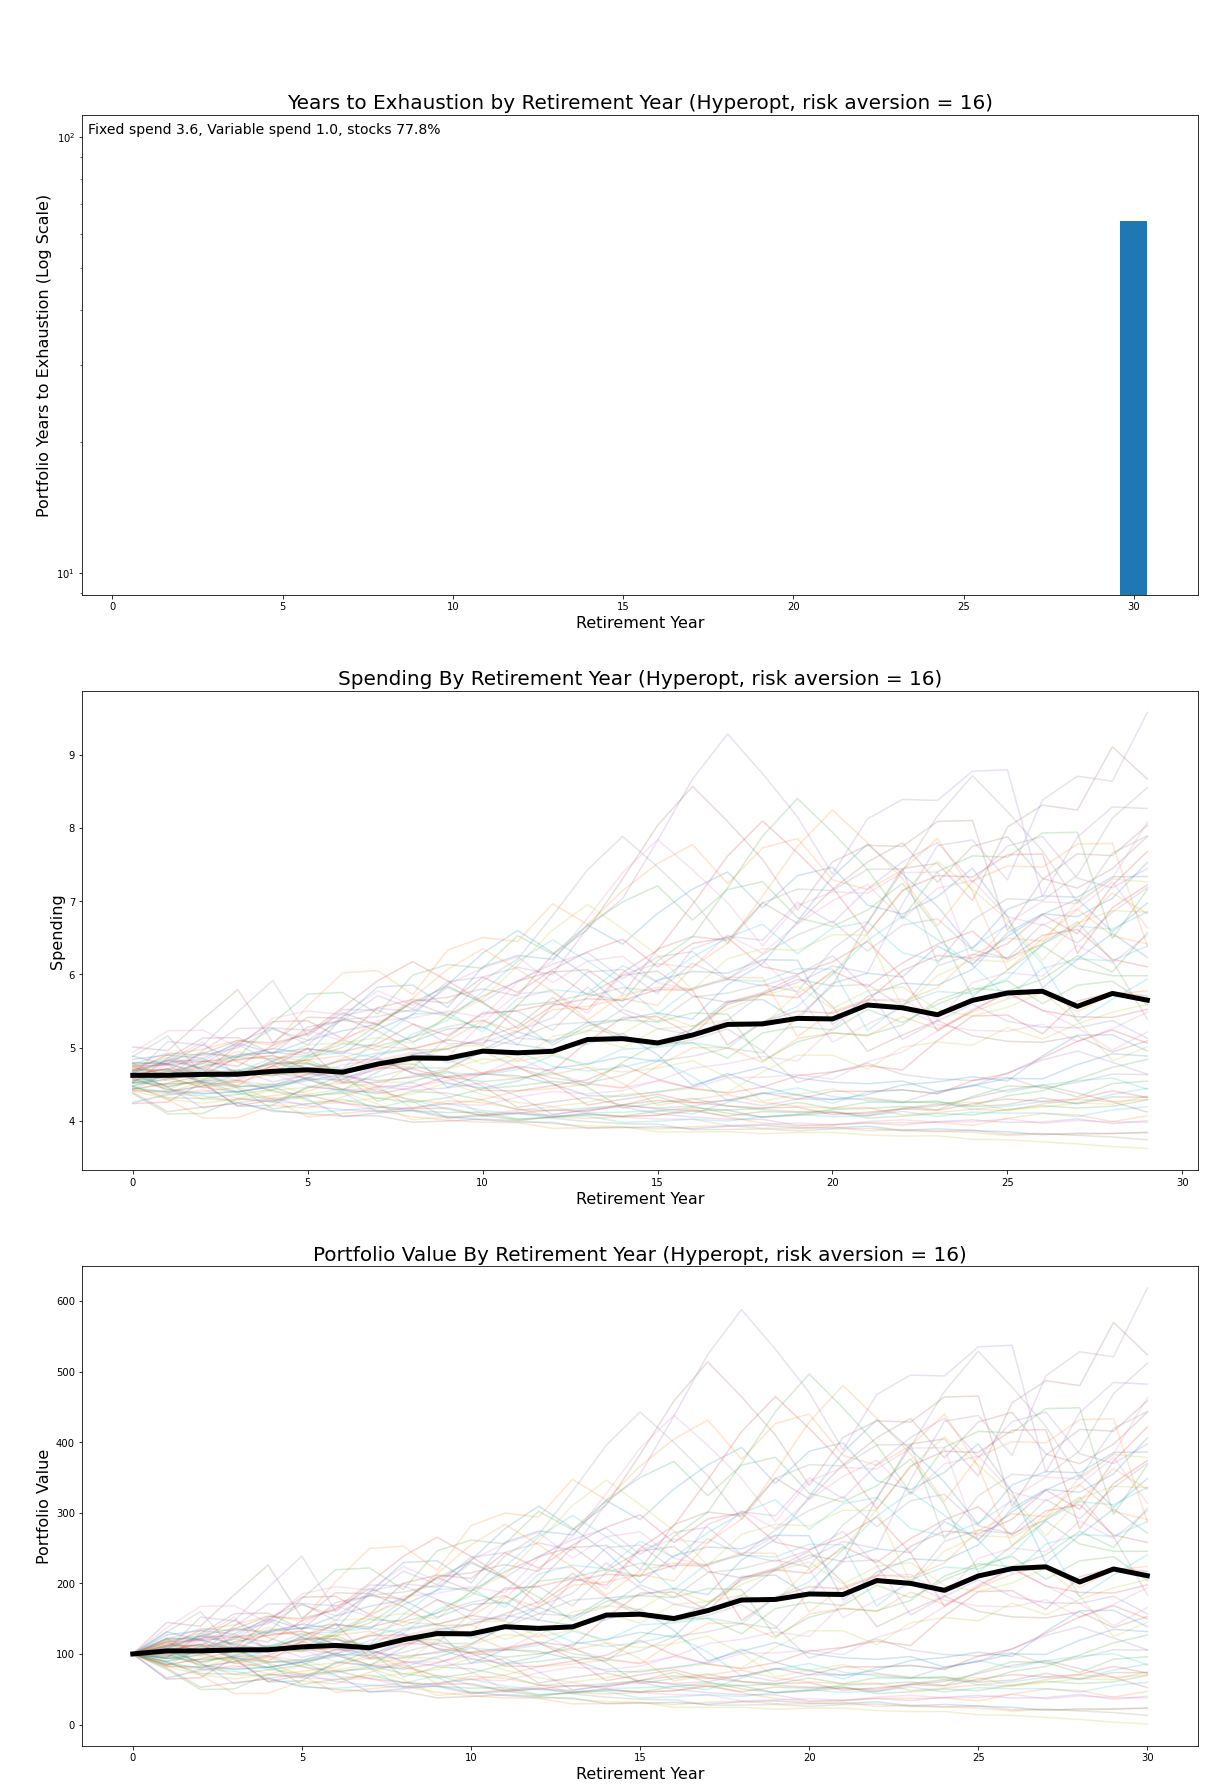

In [18]:
run_strategy(results.iloc[-1]).visualize()


### Platypus
https://github.com/Project-Platypus/Platypus

In [19]:
print("%s %s" % ("platypus", platypus.__version__))
n_trials = N_TRIALS
optimizer = "Platypus (MOEAD)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    # number inputs, outputs
    problem = Problem(3, 1)
    # ranges
    problem.types[0] = Real(0, 5)   # fixed_spend
    problem.types[1] = Real(0, 10)  # variable_spend
    problem.types[2] = Real(0, 1)   # alloc_stocks

    # platypus wants a numpy array return because it's a multi-objective algo
    f = partial(ce_experiment, N_RET_YEARS, gamma)
    def pobjective(params):
        return np.array([f(params)])

    problem.function = pobjective
    algorithm = MOEAD(problem)
    algorithm.run(n_trials)
    best = sorted([(s.objectives[0], s.variables) for s in algorithm.result if s.feasible])[0]
    # tuple of best objective value, best params
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), best))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

INFO:Platypus:MOEAD starting


platypus 1.0.4
2021-02-12 17:04:03 Starting Platypus (MOEAD), gamma 0, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1061, Elapsed Time: 0:02:36.432603
INFO:Platypus:MOEAD starting


2021-02-12 17:06:40 Finishing optimizer Platypus (MOEAD), gamma 0, 1000 trials in 0:02:36.434281
2021-02-12 17:06:40 best params (-15531.79840968987, [0.0005748173891525349, 6.21173385542738, 0.99995505811978])
2021-02-12 17:06:40 Starting Platypus (MOEAD), gamma 1, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1061, Elapsed Time: 0:02:33.809305
INFO:Platypus:MOEAD starting


2021-02-12 17:09:13 Finishing optimizer Platypus (MOEAD), gamma 1, 1000 trials in 0:02:33.811083
2021-02-12 17:09:13 best params (-13517.381660946718, [0.3146556787221999, 6.266945374106973, 0.9999681710471756])
2021-02-12 17:09:13 Starting Platypus (MOEAD), gamma 2, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1066, Elapsed Time: 0:02:38.108914
INFO:Platypus:MOEAD starting


2021-02-12 17:11:51 Finishing optimizer Platypus (MOEAD), gamma 2, 1000 trials in 0:02:38.110192
2021-02-12 17:11:51 best params (-12035.180858698744, [2.052927255537944, 4.424894406279564, 0.999339259390617])
2021-02-12 17:11:51 Starting Platypus (MOEAD), gamma 4, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1055, Elapsed Time: 0:02:44.899448
INFO:Platypus:MOEAD starting


2021-02-12 17:14:36 Finishing optimizer Platypus (MOEAD), gamma 4, 1000 trials in 0:02:44.900663
2021-02-12 17:14:36 best params (-10326.480827495483, [2.705489215859455, 2.9741251303971694, 0.8848903558321645])
2021-02-12 17:14:36 Starting Platypus (MOEAD), gamma 6, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1067, Elapsed Time: 0:03:01.122782
INFO:Platypus:MOEAD starting


2021-02-12 17:17:37 Finishing optimizer Platypus (MOEAD), gamma 6, 1000 trials in 0:03:01.123934
2021-02-12 17:17:37 best params (-9568.435168377853, [2.9466238580938877, 2.3812994930851428, 0.8133438869453268])
2021-02-12 17:17:37 Starting Platypus (MOEAD), gamma 8, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1056, Elapsed Time: 0:02:58.473275
INFO:Platypus:MOEAD starting


2021-02-12 17:20:36 Finishing optimizer Platypus (MOEAD), gamma 8, 1000 trials in 0:02:58.474582
2021-02-12 17:20:36 best params (-9151.862787854952, [3.091598328794192, 2.0557817550463344, 0.7879412070705041])
2021-02-12 17:20:36 Starting Platypus (MOEAD), gamma 10, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1060, Elapsed Time: 0:02:59.964953
INFO:Platypus:MOEAD starting


2021-02-12 17:23:36 Finishing optimizer Platypus (MOEAD), gamma 10, 1000 trials in 0:02:59.966736
2021-02-12 17:23:36 best params (-8816.6230368436, [3.56094252856427, 1.0068846125016262, 0.8347258233659852])
2021-02-12 17:23:36 Starting Platypus (MOEAD), gamma 12, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1055, Elapsed Time: 0:02:59.787166
INFO:Platypus:MOEAD starting


2021-02-12 17:26:36 Finishing optimizer Platypus (MOEAD), gamma 12, 1000 trials in 0:02:59.788859
2021-02-12 17:26:36 best params (-8729.07219967241, [3.452951725017569, 1.2516534993684847, 0.7492524213702607])
2021-02-12 17:26:36 Starting Platypus (MOEAD), gamma 14, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1068, Elapsed Time: 0:03:00.832768
INFO:Platypus:MOEAD starting


2021-02-12 17:29:37 Finishing optimizer Platypus (MOEAD), gamma 14, 1000 trials in 0:03:00.834030
2021-02-12 17:29:37 best params (-8511.34457773601, [3.2360703292373536, 1.7019176368226687, 0.7439549562268748])
2021-02-12 17:29:37 Starting Platypus (MOEAD), gamma 16, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1058, Elapsed Time: 0:03:00.349455


2021-02-12 17:32:37 Finishing optimizer Platypus (MOEAD), gamma 16, 1000 trials in 0:03:00.351022
2021-02-12 17:32:37 best params (-8351.932420641608, [3.229809757000774, 1.6165008593850572, 0.7530394444800531])
2021-02-12 17:32:37 Finished Platypus (MOEAD) in 0:28:33.797395


In [20]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results

gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      0.999955     0.000045     0.000575        6.211734   
1      1      0.999968     0.000032     0.314656        6.266945   
2      2      0.999339     0.000661     2.052927        4.424894   
3      4      0.884890     0.115110     2.705489        2.974125   
4      6      0.813344     0.186656     2.946624        2.381299   
5      8      0.787941     0.212059     3.091598        2.055782   
6     10      0.834726     0.165274     3.560943        1.006885   
7     12      0.749252     0.250748     3.452952        1.251653   
8     14      0.743955     0.256045     3.236070        1.701918   
9     16      0.753039     0.246961     3.229810        1.616501   

          value                 timing  
0 -15531.798410 0 days 00:02:36.434281  
1 -13517.381661 0 days 00:02:33.811083  
2 -12035.180859 0 days 00:02:38.110192  
3 -10326.480827 0 days 00:02:44.900663  
4  -9568.435168 0 days 00:03:01.123934  
5  -9151.862788 0 days 00:02:58.474582  
6  -8816.623037 0 days 00:02:59.966736  
7  -8729.072200 0 days 00:02:59.788859  
8  -8511.344578 0 days 00:03:00.834030  
9  -8351.932421 0 days 00:03:00.351022

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7ff8a18fef90>}

Allocation:
{'asset_weights': array([0.75303944, 0.24696056])}

Withdrawal:
{'fixed': 3.229809757000774,
 'fixed_pct': 3.229809757000774,
 'variable': 0.01616500859385057,
 'variable_pct': 1.6165008593850572}
mean annual spending over all cohorts 5.72
0.00% of portfolios exhausted by final year


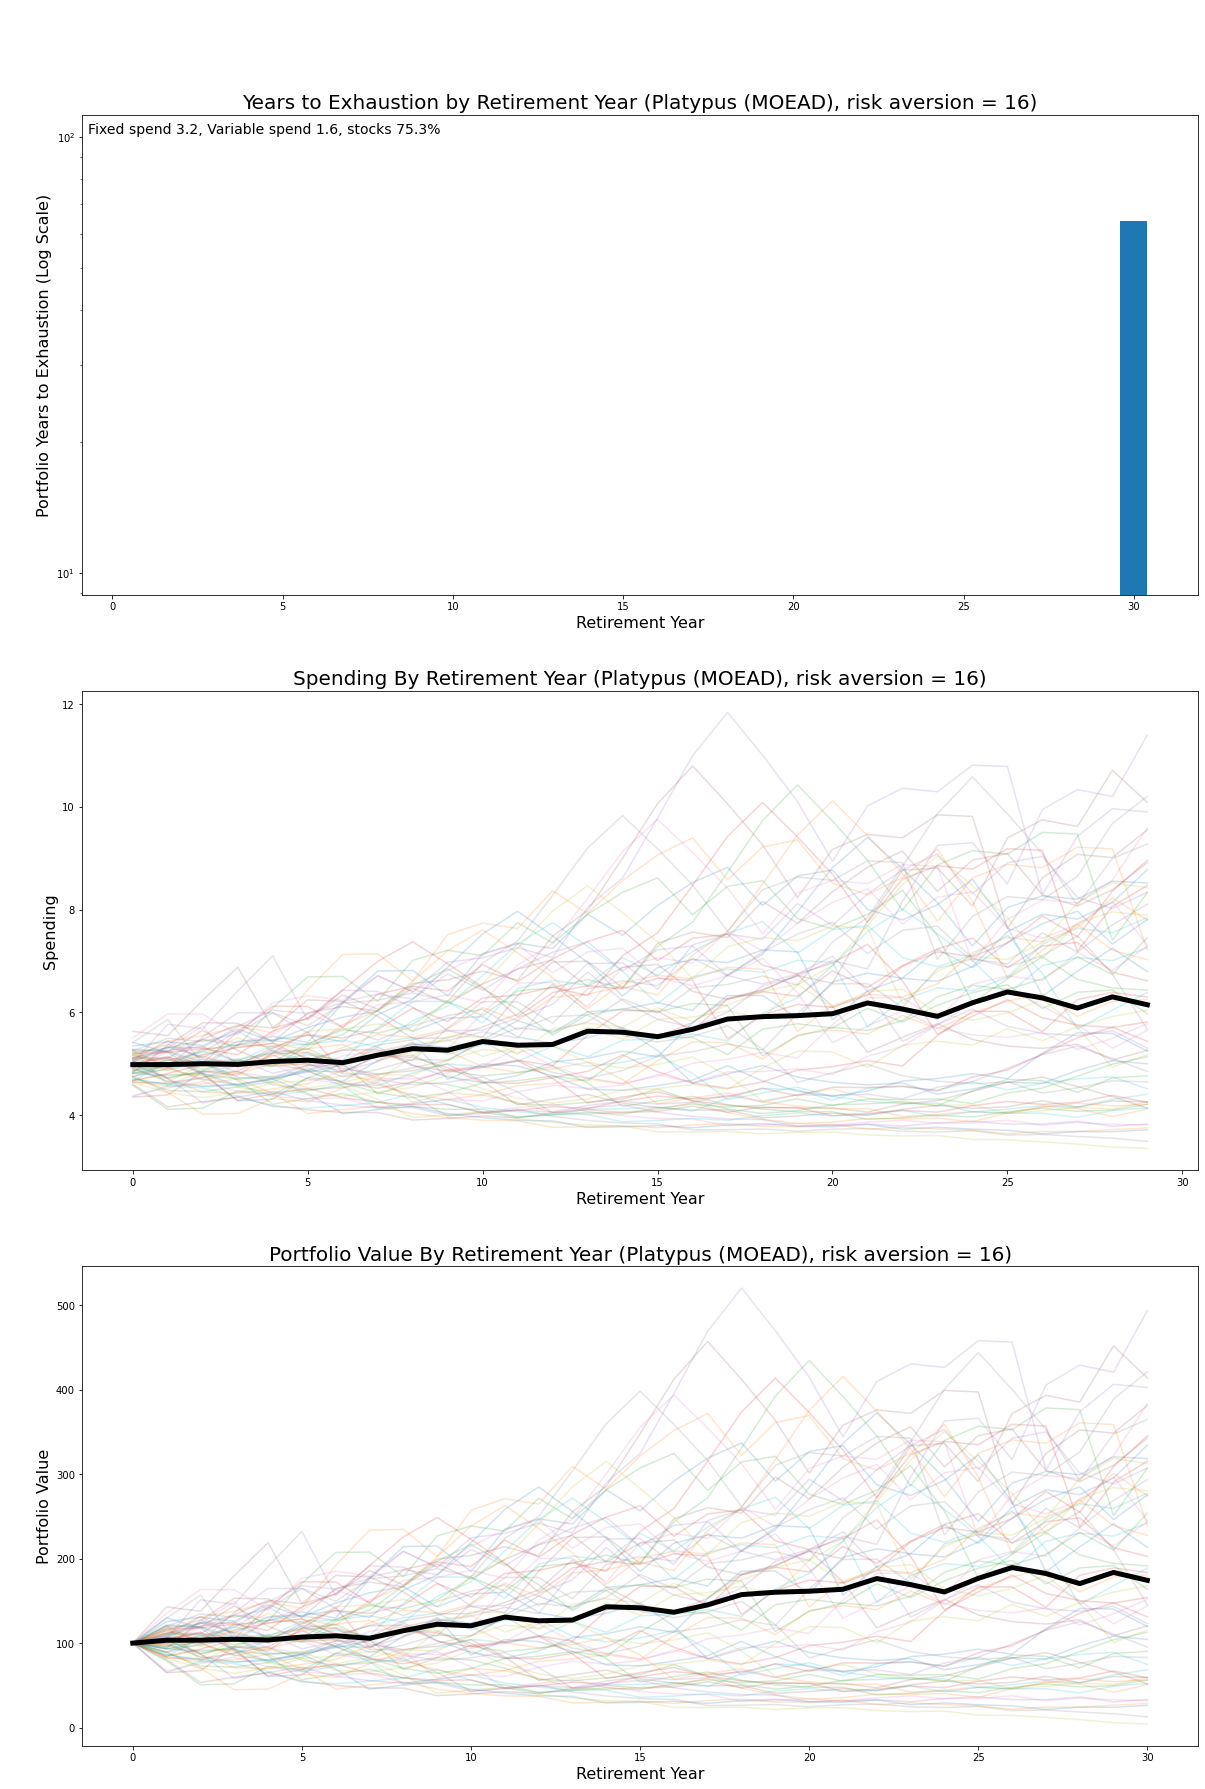

In [21]:
run_strategy(results.iloc[-1]).visualize()


### Nevergrad
https://facebookresearch.github.io/nevergrad/optimization.html

In [ ]:
print("%s %s" % ("nevergrad", ng.__version__))

n_trials = N_TRIALS
optimizer = "Nevergrad (OnePlusOne)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    nobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    opt = ng.optimizers.OnePlusOne(parametrization=3, budget=n_trials, num_workers=10)

    opt.parametrization.register_cheap_constraint(lambda x: x[0] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[0] <= 5)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] <= 10)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] <= 1)
    with futures.ThreadPoolExecutor(max_workers=opt.num_workers) as executor:
        recommendation = opt.minimize(nobjective, executor=executor, batch_mode=False)
    
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)    
    study_params.append((recommendation.loss, recommendation.value.tolist()))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %f" % (datestr(), recommendation.value, recommendation.loss))
        
opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

nevergrad 0.4.3
2021-02-12 17:32:38 Starting Nevergrad (OnePlusOne), gamma 0, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.



2021-02-12 17:36:42 Finishing optimizer Nevergrad (OnePlusOne), gamma 0, 1000 trials in 0:04:04.348627
2021-02-12 17:36:42 best params [0.51939283 7.57549219 1.        ] value -15090.088284
2021-02-12 17:36:42 Starting Nevergrad (OnePlusOne), gamma 1, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-12 17:40:47 Finishing optimizer Nevergrad (OnePlusOne), gamma 1, 1000 trials in 0:04:04.885165
2021-02-12 17:40:47 best params [1.49013988 2.55144913 1.        ] value -11318.917070
2021-02-12 17:40:47 Starting Nevergrad (OnePlusOne), gamma 2, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-12 17:45:00 Finishing optimizer Nevergrad (OnePlusOne), gamma 2, 1000 trials in 0:04:12.825997
2021-02-12 17:45:00 best params [1.14551851 4.82714521 1.        ] value -11853.981718
2021-02-12 17:45:00 Starting Nevergrad (OnePlusOne), gamma 4, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-12 17:49:30 Finishing optimizer Nevergrad (OnePlusOne), gamma 4, 1000 trials in 0:04:29.792660
2021-02-12 17:49:30 best params [2.68589615 3.02209158 0.88647704] value -10326.464217
2021-02-12 17:49:30 Starting Nevergrad (OnePlusOne), gamma 6, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



In [ ]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


In [ ]:
run_strategy(results.iloc[-1]).visualize()


### Ax
https://ax.dev/

In [ ]:
print("%s %s" % ("ax", ax.__version__))

n_trials = N_TRIALS // 3  # otherwise very slow
optimizer = "Ax (defaults)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    aobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    
    best_parameters, best_values, experiment, model = ax.optimize(
        parameters=[
            {
                "name": "fixed_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 5.0],
            },
            {
                "name": "variable_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 10.0],
            },
            {
                "name": "alloc_stocks",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 1.0],
            },
        ],
        evaluation_function=aobjective,
        minimize=True,
        total_trials=n_trials,
        #verbose_logging=False
    )
    
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)
    
    study_params.append((best_values[0]['objective'], 
                         [best_parameters['fixed_spend'], 
                          best_parameters['variable_spend'], 
                          best_parameters['alloc_stocks']]
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %s" % (datestr(), best_values[0]['objective'], best_parameters))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

In [ ]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


In [ ]:
run_strategy(results.iloc[-1]).visualize()


In [ ]:
# from scipy.optimize import basinhopping
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html
# slow and performs poorly
# gamma = 1
# x0 = np.array([1.0, 5.0, 0.5])
# optimizer = "basinhopping"

# stepsize = 0.25
# T = 50
# minimizer_kwargs = {"method": "BFGS"}
# MAX_ITER = 100

# def print_fun(x, f, accepted):
#     print("%s at minimum %.4f accepted %d (%s)" % (datestr(), f, int(accepted), x))
        
# class MyBounds(object):
#     def __init__(self, 
#                  xmax=[5.0, 10.0, 1.0], 
#                  xmin=[0.0,  0.0, 0.0] ):
#         self.xmax = np.array(xmax)
#         self.xmin = np.array(xmin)
#     def __call__(self, **kwargs):
#         x = kwargs["x_new"]
#         tmax = bool(np.all(x <= self.xmax))
#         tmin = bool(np.all(x >= self.xmin))
#         return tmax and tmin
# mybounds = MyBounds()

# print("%s Starting %s, gamma %d, %d iterations max" % (datestr(), optimizer, gamma, MAX_ITER))
# start_time = datetime.now()
# bobjective = partial(ce_experiment, N_RET_YEARS, gamma)
# ret = basinhopping(bobjective, x0, minimizer_kwargs=minimizer_kwargs,
#                    niter=MAX_ITER, stepsize=stepsize, T=T,
#                    accept_test=mybounds,
#                    callback=print_fun)



### Visualize combined results

In [ ]:
# plot all results

plt.figure(figsize=(15,10))
plt.title('Best CE value by gamma, selected optimizers')
plt.xlabel('Gamma')
plt.ylabel('CE value')
# for opt in results_dict.keys():
# skip last 2 which are more messy and never best
# maybe they need more iterations but they are taking plenty of time already
for opt in ['scipy.optimize (L-BFGS-B)', 'dlib', 'Optuna', 'Hyperopt', 'Platypus (MOEAD)']:
    plt.plot(results_dict[opt]['gamma'], -results_dict[opt]['value'], label=opt)
    
plt.legend();



In [ ]:
df_list = []
for optimizer in results_dict.keys():
    results_dict[optimizer]['optimizer'] = optimizer
    df_list.append(results_dict[optimizer])
all_results = pd.concat(df_list)
all_results['value'] = - all_results['value']



In [ ]:
mean_spends = []
exhaustions = []

for row in all_results.itertuples():
    s = run_strategy(row, verbose=False)
    mean_spends.append(np.mean([z['mean_spend'] for z in s.latest_simulation]))
    exhaustions.append(np.mean([z['years_to_exhaustion'] for z in s.latest_simulation]))
    minimum_spends.append(np.min([z['min_spend'] for z in s.latest_simulation]))
    
all_results['mean_spend'] = mean_spends
all_results['min_spend'] = min_spends
all_results['exhaustion'] = exhaustions
all_results['ce_annual_spend'] = all_results['value'] / N_RET_YEARS / (len(real_return_df) - N_RET_YEARS + 1)

In [ ]:
all_results['group_gamma_max'] = all_results.groupby(['gamma'])['value'].transform(max)
all_results.loc[all_results['value'] == all_results['group_gamma_max']].sort_values('gamma')

In [ ]:
pd.DataFrame(timings_dict.values(), index=timings_dict.keys(), columns=['timing'])

In [ ]:
# higher average should be favored at gamma=0
FIXED_SPEND = 0.295292
VARIABLE_SPEND = 6.239439
ALLOC_STOCKS = 0.5
ALLOC_BONDS = 0.5
GAMMA  = 1.0

s = SWRsimulationCE.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([ALLOC_STOCKS, ALLOC_BONDS])}, 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND,
                  },
    'evaluation': {'gamma': GAMMA},
    'visualization': {}    
})

print(s)

s.simulate()

-crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), GAMMA)


In [ ]:
timings_dict

In [ ]:
s0 = run_strategy(results.iloc[0], verbose=False)
# check one iteration
print("%-20s %.6f" % ('mean_spend', s0.latest_simulation[0]['mean_spend']))
print("%-20s %.6f" % ('mean of spend', s0.latest_simulation[0]['trial']['spend'].mean()))
print("%-20s %.6f" % ('ce_spend', s0.latest_simulation[0]['ce_spend'] / N_RET_YEARS))
print("%-20s %.6f" % ('ce of spend', crra_ce(s0.latest_simulation[0]['trial']['spend'], 0) / N_RET_YEARS))
# -crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), 0)

# check all iterations
print("%-20s %.6f" % ("mean of mean_spend", np.mean([z['mean_spend'] for z in s0.latest_simulation])))
print("%-20s %.6f" % ("mean of ce_spend", np.mean([z['ce_spend'] for z in s0.latest_simulation]) / N_RET_YEARS))
print("%-20s %.6f" % ("total ce_spend", crra_ce(np.array([z['ce_spend'] for z in s0.latest_simulation]), 0) / N_RET_YEARS / (len(real_return_df) - N_RET_YEARS + 1)))
